In [1]:
# Please install pytorch if it is needed
# pip install torch

In [2]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

# For data preprocess
import numpy as np
import pandas as pd
import csv
import os
from scipy.stats import norm
from scipy import stats
from random import randrange, random, randint
import time
import warnings
warnings.filterwarnings('ignore')

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# 1.Boston Dataset Analysis

## 1.1 MLP

In [3]:
df = pd.read_csv('Boston.csv')
df = df[df['crim'] < 20]  # Remove the outliers. The same data preprocessing as it is in Linear section

In [5]:
class NeuralNet(nn.Module):
    ''' 
    A fully-connected neural network.
    '''
    
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        
        # Define the structure of NN.
        self.net = nn.Sequential(
            nn.Linear(input_dim, 100), 
            nn.ReLU(),  # Activation function is ReLu
            nn.Linear(100, 1)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        '''
        Compute output of the network
        '''
        return self.net(x).squeeze(1)

    def cal_loss(self, pred, target, alpha=0, L1_w=0):
        ''' 
        Calculate loss.
        The following formula is used when using regularization:
        loss = MSEloss + alpha*((1-L1_wt)*|params|**2 + L1_wt*|params|)
        where L1_wt decides the ratio of L1 and L2 penalty terms and alpha controls the total weight
        of regularization terms
        '''
        
        # Regularization. Lasso when L1_w is 1. Ridge regularization when L1_w is 0.
        # Elastic net when L1_w is between 0 and 1. 
        
        L1_term = 0
        L2_term = 0
        
        if alpha != 0:
            for name, w in self.net.named_parameters():
                if 'weight' in name:
                    L1_term += alpha * torch.norm(w, p = 1).to(device)  # lasso regularization
                    L2_term += alpha * torch.norm(w, p = 2).to(device)  # ridge regularization

        return self.criterion(pred, target) + alpha * ((1-L1_w) * L2_term + L1_w * L1_term)

In [6]:
class BostonDataset(Dataset):
    """
    Define a Dataset class for pytorch.
    """
    
    def __init__(self, df, mode='train', random_state=0):
        self.mode = mode
        
        # Normlization
        scalar = StandardScaler()
        df = scalar.fit_transform(df)
        df = pd.DataFrame(df)
        
        # Target feature and input features
        target = df.iloc[:,0]
        data = df.iloc[:, 1:]
        
        # Generation the indices of traning data and testing data. By setting different random state we can get different splits. 
        # Different from k-fold validation, the testing data may overlap.
        indices_train, indices_test = train_test_split([i for i in range(data.shape[0])], test_size = 0.2, random_state = random_state)
        
        if mode == 'train':
            indices = indices_train
        elif mode == 'test':
            indices = indices_test
            
        data = data.to_numpy()
        target = target.to_numpy()
        self.data = torch.FloatTensor(data[indices])
        self.target = torch.FloatTensor(target[indices])
        self.dim = self.data.shape[1]

        print('Finish reading the {} data. {}samples and dim = {}'.format(self.mode, len(self.data), self.dim))
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    
    def __len__(self):
        return len(self.data)


In [7]:
# data loader

def data_loader(df, mode, batch_size, n_jobs=0, random_state=0):
    """
    Output the training and testing data.
    """
    dataset = BostonDataset(df, mode=mode,random_state=random_state)
    dataloader = DataLoader(dataset, batch_size, 
                            shuffle=(mode == 'train'), 
                            drop_last=False,
                            num_workers=n_jobs, pin_memory=True)
    
    return dataloader

In [8]:
def train(train_data, test_data, model, config, device):
    """
    Define the training process. 
    """
    
    n_epochs = config['n_epochs']  # The number of epoches. 
    
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])  # Define the optimizer
    
    min_loss = float('1000.')  # Initialize the loss 
    
    loss_record = {'train':[], 'test': []}
    
    cnt_no_improvement = 0  # Count the number of iterations with no improvement. 
    
    epoch = 0  # Initialize the number of epoch
    
    # Train the model for n_epochs
    while epoch  < n_epochs:
        model.train()  # Set the model to be traning mode.
        for x, y in train_data:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = model.cal_loss(y_hat, y, alpha=config['alpha'], L1_w=config['L1_w'])  # calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the parameters
            loss_record['train'].append(loss.detach().cpu().item())
        
        test_loss,_ = test(test_data, model, config, device)  # Calculate the loss on testing dataset
        
        # Update the lowest loss
        
        if test_loss < min_loss:
            min_loss = test_loss
            print('epoch {}, loss {:.6f}'.format(epoch + 1, min_loss))
            cnt_no_improvement = 0
        else:
            cnt_no_improvement += 1
            
        epoch += 1
        loss_record['test'].append(test_loss)
            
        # Stop training if there is no improvement after config['early_stop'] iterations. 
        if cnt_no_improvement > config['early_stop']:
            break
    
    print('Final loss is {:.6f} after {} epochs'.format(min_loss, epoch))

    return min_loss, loss_record

In [9]:
def test(data, model, config, device):
    """
    Calculate the loss on testing dataset.
    """
    
    model.eval()
    total_loss = 0
    for x, y in data:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_hat = model(x)
            loss = model.cal_loss(y_hat, y)
        total_loss += loss.detach().cpu().item() * len(x)
    total_loss = total_loss / len(data.dataset)
    return total_loss, y_hat

In [10]:
def get_device():
    '''
    If GPU is available, use GPU
    '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()                 # get the current available device ('cpu' or 'cuda')
os.makedirs('models', exist_ok=True)  # The trained model will be saved to ./models/

# Set the configuration for training
config = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8             # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', # model will be saved here
    'L1_w': 0,                       # weight of L1 term
    'alpha': 0                       # weight of regularizaition terms
}

In [11]:

# Set the configuration of MLP without penalty term
config_default = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8             # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', #  model will be saved here
    'L1_w': 0,                       # weight of L1 term
    'alpha': 0                       # weight of regularizaition terms
}

# Evaluate the model on 5 different resampling splits
loss_record_5_fold = []  # Record the MSEs
for j in range(5):
    train_data = data_loader(df, 'train', config['batch_size'],random_state=j)
    test_data = data_loader(df, 'test', config['batch_size'],random_state=j)
    model = NeuralNet(train_data.dataset.dim)

    model_loss, _ = train(train_data, test_data, model, config_default, device)

    loss_record_5_fold.append(model_loss)

mean_loss = np.mean(loss_record_5_fold)  # Calculate the mean of 5 MSEs
std_loss = np.std(loss_record_5_fold)  # Calculate the standard deviation of 5 MSEs
print('The mean loss is {}\nSTD is {}'.format(mean_loss, std_loss))

Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.706963
epoch 2, loss 0.555873
epoch 3, loss 0.442656
epoch 4, loss 0.364305
epoch 5, loss 0.314125
epoch 6, loss 0.282563
epoch 7, loss 0.261891
epoch 8, loss 0.247201
epoch 9, loss 0.236597
epoch 10, loss 0.228045
epoch 11, loss 0.220753
epoch 12, loss 0.214037
epoch 13, loss 0.208758
epoch 14, loss 0.203318
epoch 15, loss 0.198954
epoch 16, loss 0.194620
epoch 17, loss 0.190556
epoch 18, loss 0.187277
epoch 19, loss 0.183404
epoch 20, loss 0.180150
epoch 21, loss 0.177313
epoch 22, loss 0.174804
epoch 23, loss 0.172250
epoch 24, loss 0.169425
epoch 25, loss 0.167572
epoch 26, loss 0.165450
epoch 27, loss 0.163450
epoch 28, loss 0.161660
epoch 29, loss 0.159989
epoch 30, loss 0.158537
epoch 31, loss 0.156948
epoch 32, loss 0.155686
epoch 33, loss 0.153989
epoch 34, loss 0.152576
epoch 35, loss 0.151278
epoch 36, loss 0.150470
epoch 37, loss 0.149501
epoch 38, los

epoch 685, loss 0.101732
epoch 686, loss 0.101689
epoch 687, loss 0.101666
epoch 690, loss 0.101610
epoch 691, loss 0.101558
epoch 697, loss 0.101542
epoch 698, loss 0.101438
epoch 706, loss 0.101415
epoch 709, loss 0.101408
epoch 710, loss 0.101228
epoch 711, loss 0.101209
epoch 714, loss 0.101064
epoch 721, loss 0.100989
epoch 727, loss 0.100937
epoch 728, loss 0.100855
epoch 729, loss 0.100820
epoch 736, loss 0.100788
epoch 737, loss 0.100651
epoch 739, loss 0.100592
epoch 744, loss 0.100555
epoch 745, loss 0.100522
epoch 752, loss 0.100446
epoch 757, loss 0.100313
epoch 767, loss 0.100225
epoch 769, loss 0.100119
epoch 770, loss 0.100052
epoch 786, loss 0.100033
epoch 788, loss 0.100012
epoch 790, loss 0.099817
epoch 801, loss 0.099800
epoch 802, loss 0.099793
epoch 806, loss 0.099710
epoch 809, loss 0.099633
epoch 816, loss 0.099488
epoch 820, loss 0.099479
epoch 824, loss 0.099453
epoch 825, loss 0.099452
epoch 826, loss 0.099418
epoch 827, loss 0.099347
epoch 828, loss 0.099259


epoch 45, loss 0.345883
epoch 46, loss 0.345342
epoch 47, loss 0.343822
epoch 48, loss 0.343213
epoch 49, loss 0.341849
epoch 50, loss 0.340975
epoch 51, loss 0.340217
epoch 52, loss 0.339109
epoch 53, loss 0.338703
epoch 54, loss 0.337812
epoch 55, loss 0.337199
epoch 56, loss 0.336786
epoch 57, loss 0.336170
epoch 58, loss 0.334912
epoch 59, loss 0.334142
epoch 60, loss 0.334044
epoch 61, loss 0.333951
epoch 63, loss 0.332693
epoch 64, loss 0.331410
epoch 65, loss 0.330782
epoch 67, loss 0.330663
epoch 68, loss 0.330295
epoch 69, loss 0.329833
epoch 70, loss 0.329279
epoch 71, loss 0.329214
epoch 72, loss 0.328133
epoch 73, loss 0.327364
epoch 75, loss 0.326997
epoch 76, loss 0.326648
epoch 79, loss 0.326107
epoch 80, loss 0.325768
epoch 81, loss 0.325446
epoch 83, loss 0.324816
epoch 84, loss 0.324736
epoch 85, loss 0.323900
epoch 86, loss 0.323767
epoch 87, loss 0.323030
epoch 90, loss 0.322817
epoch 91, loss 0.321899
epoch 96, loss 0.321573
epoch 97, loss 0.320639
epoch 101, loss 

epoch 173, loss 0.240699
epoch 174, loss 0.240421
epoch 175, loss 0.240340
epoch 176, loss 0.240165
epoch 177, loss 0.240113
epoch 178, loss 0.239915
epoch 179, loss 0.239664
epoch 180, loss 0.239218
epoch 182, loss 0.239043
epoch 183, loss 0.238808
epoch 184, loss 0.238774
epoch 185, loss 0.238328
epoch 186, loss 0.238231
epoch 187, loss 0.238013
epoch 189, loss 0.237733
epoch 191, loss 0.237675
epoch 192, loss 0.237654
epoch 193, loss 0.237348
epoch 194, loss 0.237138
epoch 196, loss 0.236534
epoch 197, loss 0.236405
epoch 198, loss 0.236371
epoch 199, loss 0.236337
epoch 200, loss 0.236115
epoch 202, loss 0.236060
epoch 203, loss 0.235968
epoch 204, loss 0.235838
epoch 205, loss 0.235412
epoch 207, loss 0.235109
epoch 208, loss 0.235040
epoch 209, loss 0.234621
epoch 210, loss 0.234508
epoch 213, loss 0.234339
epoch 214, loss 0.234162
epoch 215, loss 0.233966
epoch 216, loss 0.233807
epoch 218, loss 0.233389
epoch 219, loss 0.233349
epoch 220, loss 0.233170
epoch 222, loss 0.233103


epoch 144, loss 0.223850
epoch 145, loss 0.223249
epoch 148, loss 0.223152
epoch 149, loss 0.222783
epoch 151, loss 0.222514
epoch 152, loss 0.221878
epoch 153, loss 0.221707
epoch 154, loss 0.221521
epoch 155, loss 0.221204
epoch 156, loss 0.220860
epoch 157, loss 0.220815
epoch 159, loss 0.220707
epoch 161, loss 0.220356
epoch 162, loss 0.220192
epoch 163, loss 0.219788
epoch 164, loss 0.219643
epoch 166, loss 0.219336
epoch 167, loss 0.219159
epoch 168, loss 0.218822
epoch 170, loss 0.218405
epoch 171, loss 0.218112
epoch 175, loss 0.217656
epoch 176, loss 0.216925
epoch 177, loss 0.216894
epoch 178, loss 0.216516
epoch 181, loss 0.216465
epoch 182, loss 0.216141
epoch 186, loss 0.216072
epoch 187, loss 0.215913
epoch 188, loss 0.215586
epoch 189, loss 0.215296
epoch 190, loss 0.215114
epoch 191, loss 0.215028
epoch 193, loss 0.214626
epoch 195, loss 0.214396
epoch 196, loss 0.214211
epoch 197, loss 0.214111
epoch 198, loss 0.213854
epoch 200, loss 0.213709
epoch 201, loss 0.213596


## 1.2 MLP with L1 regularization

In [13]:
# Tune hyperparameters
# Tune alpha only

# Set the configuration of MLP with L1 penalty term
config_random_L1 = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', #  model will be saved here
    'L1_w': 1,      # weight of L1 term
    # ossible weight of regularizaition terms
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]
}

def random_search_L1(iteration, config_random):
    """
    Random search function to find the best alpha.
    """
    iteration = iteration
    min_loss = 1000
    config_best = None
    
    config_record = []
    for i in range(iteration):
        config_candidate = config_random.copy()
        alpha_index = randint(0,len(config_candidate['alpha'])-1)  # Randomly select a possible value of total penalty weight
        
        if alpha_index in config_record:  # if a config has been tested then skip it
            continue
        
        config_record.append(alpha_index)
        
        loss_record_5_fold = []
        
        config_candidate['alpha'] = config_candidate['alpha'][alpha_index]
        
        # Evaluate the model on 5 different resampling splits
        for j in range(5):
            train_data_L1 = data_loader(df, 'train', config_candidate['batch_size'], random_state=j)
            test_data_L1 = data_loader(df, 'test', config_candidate['batch_size'], random_state=j)
            model_L1 = NeuralNet(train_data_L1.dataset.dim)

            model_loss_L1, model_loss_record_L1 = train(train_data_L1, test_data_L1, model_L1, config_candidate, device)
            
            loss_record_5_fold.append(model_loss_L1)
        
        mean_loss = np.mean(loss_record_5_fold)
        std_loss = np.std(loss_record_5_fold)
        
        if mean_loss < min_loss:
            min_loss = mean_loss
            config_best = config_candidate

    print('The lowest mean loss is {}, STD : {}\nConfig is {}'.format(min_loss, std_loss, config_best))

time_start = time.time()
random_search_L1(50, config_random_L1)
time_end = time.time()
print('Total Time: ', time_end-time_start)

test
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.596142
epoch 2, loss 0.495546
epoch 3, loss 0.411751
epoch 4, loss 0.348088
epoch 5, loss 0.304890
epoch 6, loss 0.274760
epoch 7, loss 0.253389
epoch 8, loss 0.237327
epoch 9, loss 0.224970
epoch 10, loss 0.215568
epoch 11, loss 0.207339
epoch 12, loss 0.200058
epoch 13, loss 0.194001
epoch 14, loss 0.188381
epoch 15, loss 0.183618
epoch 16, loss 0.179358
epoch 17, loss 0.174900
epoch 18, loss 0.171261
epoch 19, loss 0.168454
epoch 20, loss 0.165392
epoch 21, loss 0.162443
epoch 22, loss 0.159875
epoch 23, loss 0.157973
epoch 24, loss 0.155988
epoch 25, loss 0.154143
epoch 26, loss 0.152565
epoch 27, loss 0.151126
epoch 28, loss 0.149763
epoch 29, loss 0.148126
epoch 30, loss 0.146731
epoch 31, loss 0.145892
epoch 32, loss 0.145063
epoch 33, loss 0.144063
epoch 34, loss 0.143089
epoch 35, loss 0.142275
epoch 36, loss 0.141438
epoch 37, loss 0.140730
epoch 38

epoch 624, loss 0.092147
epoch 625, loss 0.092116
epoch 626, loss 0.092050
epoch 627, loss 0.092042
epoch 628, loss 0.091990
epoch 633, loss 0.091858
epoch 634, loss 0.091854
epoch 635, loss 0.091680
epoch 641, loss 0.091631
epoch 643, loss 0.091606
epoch 647, loss 0.091480
epoch 648, loss 0.091470
epoch 649, loss 0.091406
epoch 651, loss 0.091392
epoch 653, loss 0.091344
epoch 654, loss 0.091252
epoch 660, loss 0.091166
epoch 662, loss 0.091110
epoch 663, loss 0.090964
epoch 674, loss 0.090942
epoch 675, loss 0.090908
epoch 676, loss 0.090876
epoch 677, loss 0.090783
epoch 686, loss 0.090769
epoch 687, loss 0.090728
epoch 688, loss 0.090680
epoch 691, loss 0.090673
epoch 694, loss 0.090646
epoch 695, loss 0.090642
epoch 697, loss 0.090603
epoch 698, loss 0.090571
epoch 699, loss 0.090463
epoch 701, loss 0.090449
epoch 704, loss 0.090405
epoch 706, loss 0.090392
epoch 708, loss 0.090373
epoch 709, loss 0.090326
epoch 710, loss 0.090271
epoch 712, loss 0.090217
epoch 713, loss 0.090095


epoch 31, loss 0.399160
epoch 32, loss 0.397025
epoch 33, loss 0.394102
epoch 34, loss 0.392960
epoch 35, loss 0.390857
epoch 36, loss 0.388750
epoch 37, loss 0.387212
epoch 38, loss 0.385547
epoch 39, loss 0.383866
epoch 40, loss 0.383394
epoch 41, loss 0.382617
epoch 42, loss 0.380662
epoch 43, loss 0.379681
epoch 44, loss 0.378412
epoch 45, loss 0.376744
epoch 46, loss 0.375884
epoch 47, loss 0.374684
epoch 48, loss 0.374022
epoch 50, loss 0.373540
epoch 51, loss 0.372462
epoch 52, loss 0.370444
epoch 53, loss 0.369849
epoch 54, loss 0.369002
epoch 55, loss 0.368450
epoch 56, loss 0.368269
epoch 57, loss 0.367649
epoch 58, loss 0.367392
epoch 59, loss 0.365836
epoch 60, loss 0.365803
epoch 61, loss 0.365402
epoch 62, loss 0.363021
epoch 64, loss 0.362214
epoch 65, loss 0.362105
epoch 66, loss 0.361688
epoch 67, loss 0.361437
epoch 68, loss 0.360637
epoch 69, loss 0.360164
epoch 70, loss 0.359959
epoch 71, loss 0.358918
epoch 72, loss 0.358479
epoch 73, loss 0.357097
epoch 74, loss 0

epoch 93, loss 0.239604
epoch 94, loss 0.238903
epoch 95, loss 0.238262
epoch 96, loss 0.238102
epoch 97, loss 0.237403
epoch 98, loss 0.237218
epoch 99, loss 0.236567
epoch 100, loss 0.236086
epoch 101, loss 0.235780
epoch 102, loss 0.235201
epoch 103, loss 0.234872
epoch 104, loss 0.234418
epoch 105, loss 0.233844
epoch 106, loss 0.233675
epoch 107, loss 0.233304
epoch 108, loss 0.233141
epoch 109, loss 0.232563
epoch 110, loss 0.232051
epoch 111, loss 0.231809
epoch 112, loss 0.231354
epoch 113, loss 0.230988
epoch 114, loss 0.230702
epoch 115, loss 0.230561
epoch 116, loss 0.229894
epoch 117, loss 0.229594
epoch 118, loss 0.229247
epoch 119, loss 0.229103
epoch 120, loss 0.228740
epoch 121, loss 0.228258
epoch 122, loss 0.228054
epoch 123, loss 0.227683
epoch 124, loss 0.227549
epoch 125, loss 0.227052
epoch 126, loss 0.226584
epoch 127, loss 0.226389
epoch 128, loss 0.226137
epoch 129, loss 0.225688
epoch 130, loss 0.225529
epoch 131, loss 0.225032
epoch 132, loss 0.224676
epoch 1

epoch 88, loss 0.234039
epoch 89, loss 0.233690
epoch 90, loss 0.233563
epoch 91, loss 0.233308
epoch 92, loss 0.233013
epoch 93, loss 0.232853
epoch 94, loss 0.232298
epoch 95, loss 0.232102
epoch 96, loss 0.231813
epoch 97, loss 0.231713
epoch 98, loss 0.231528
epoch 99, loss 0.231441
epoch 100, loss 0.230985
epoch 101, loss 0.230680
epoch 102, loss 0.230558
epoch 103, loss 0.230438
epoch 104, loss 0.230012
epoch 105, loss 0.229853
epoch 106, loss 0.229577
epoch 107, loss 0.229239
epoch 109, loss 0.229074
epoch 110, loss 0.228896
epoch 112, loss 0.228690
epoch 113, loss 0.228349
epoch 115, loss 0.228004
epoch 117, loss 0.227715
epoch 118, loss 0.227350
epoch 119, loss 0.227283
epoch 120, loss 0.227012
epoch 121, loss 0.226846
epoch 122, loss 0.226730
epoch 124, loss 0.226268
epoch 125, loss 0.226089
epoch 126, loss 0.225883
epoch 127, loss 0.225867
epoch 128, loss 0.225573
epoch 129, loss 0.225363
epoch 130, loss 0.225260
epoch 131, loss 0.224853
epoch 133, loss 0.224655
epoch 136, l

epoch 103, loss 0.113601
epoch 104, loss 0.113433
epoch 105, loss 0.113297
epoch 106, loss 0.113006
epoch 108, loss 0.112994
epoch 109, loss 0.112751
epoch 110, loss 0.112536
epoch 111, loss 0.112468
epoch 112, loss 0.112329
epoch 113, loss 0.112245
epoch 114, loss 0.112225
epoch 115, loss 0.111925
epoch 116, loss 0.111742
epoch 117, loss 0.111695
epoch 118, loss 0.111602
epoch 119, loss 0.111571
epoch 120, loss 0.111343
epoch 121, loss 0.111310
epoch 122, loss 0.111235
epoch 123, loss 0.110996
epoch 124, loss 0.110888
epoch 125, loss 0.110812
epoch 127, loss 0.110708
epoch 128, loss 0.110678
epoch 129, loss 0.110656
epoch 130, loss 0.110487
epoch 131, loss 0.110396
epoch 132, loss 0.110208
epoch 133, loss 0.110101
epoch 134, loss 0.110072
epoch 135, loss 0.109971
epoch 137, loss 0.109909
epoch 138, loss 0.109852
epoch 139, loss 0.109659
epoch 140, loss 0.109574
epoch 141, loss 0.109506
epoch 142, loss 0.109328
epoch 144, loss 0.109294
epoch 146, loss 0.109107
epoch 147, loss 0.109024


epoch 18, loss 0.302193
epoch 19, loss 0.296565
epoch 20, loss 0.291331
epoch 21, loss 0.287436
epoch 22, loss 0.284002
epoch 23, loss 0.279482
epoch 24, loss 0.276185
epoch 25, loss 0.273627
epoch 26, loss 0.270722
epoch 27, loss 0.268295
epoch 28, loss 0.265564
epoch 29, loss 0.263984
epoch 30, loss 0.261631
epoch 31, loss 0.259607
epoch 32, loss 0.257286
epoch 33, loss 0.255767
epoch 34, loss 0.254483
epoch 35, loss 0.253191
epoch 36, loss 0.252137
epoch 37, loss 0.250455
epoch 38, loss 0.249463
epoch 39, loss 0.247622
epoch 40, loss 0.246802
epoch 41, loss 0.245801
epoch 42, loss 0.244830
epoch 43, loss 0.243627
epoch 44, loss 0.242822
epoch 45, loss 0.242534
epoch 46, loss 0.241570
epoch 47, loss 0.240638
epoch 48, loss 0.240023
epoch 49, loss 0.239304
epoch 50, loss 0.238672
epoch 51, loss 0.237671
epoch 53, loss 0.237264
epoch 54, loss 0.235791
epoch 55, loss 0.235727
epoch 56, loss 0.235316
epoch 57, loss 0.235305
epoch 58, loss 0.234242
epoch 59, loss 0.233461
epoch 60, loss 0

epoch 95, loss 0.329535
epoch 96, loss 0.329341
epoch 97, loss 0.328829
epoch 99, loss 0.328288
epoch 100, loss 0.327872
epoch 101, loss 0.327741
epoch 102, loss 0.326830
epoch 105, loss 0.326679
epoch 106, loss 0.326591
epoch 110, loss 0.326226
epoch 111, loss 0.325738
epoch 112, loss 0.324832
epoch 115, loss 0.324241
epoch 119, loss 0.323964
epoch 122, loss 0.323916
epoch 123, loss 0.323386
epoch 124, loss 0.322932
epoch 127, loss 0.322728
epoch 128, loss 0.322201
epoch 131, loss 0.321768
epoch 132, loss 0.321615
epoch 133, loss 0.321474
epoch 135, loss 0.321035
epoch 140, loss 0.321012
epoch 141, loss 0.320162
epoch 145, loss 0.319873
epoch 146, loss 0.319744
epoch 149, loss 0.319244
epoch 152, loss 0.319068
epoch 156, loss 0.318857
epoch 160, loss 0.318571
epoch 161, loss 0.318520
epoch 162, loss 0.318157
epoch 163, loss 0.317910
epoch 165, loss 0.317597
epoch 168, loss 0.317211
epoch 169, loss 0.316843
epoch 177, loss 0.316528
epoch 179, loss 0.316455
epoch 183, loss 0.315912
epoc

epoch 253, loss 0.207366
epoch 254, loss 0.207094
epoch 255, loss 0.206757
epoch 257, loss 0.206554
epoch 258, loss 0.206225
epoch 262, loss 0.206129
epoch 265, loss 0.205785
epoch 269, loss 0.205508
epoch 270, loss 0.205306
epoch 271, loss 0.205241
epoch 272, loss 0.205053
epoch 273, loss 0.204743
epoch 279, loss 0.204375
epoch 281, loss 0.204294
epoch 283, loss 0.203819
epoch 286, loss 0.203674
epoch 289, loss 0.203393
epoch 296, loss 0.202925
epoch 299, loss 0.202873
epoch 300, loss 0.202852
epoch 301, loss 0.202666
epoch 302, loss 0.202635
epoch 303, loss 0.201999
epoch 308, loss 0.201734
epoch 309, loss 0.201628
epoch 312, loss 0.201445
epoch 313, loss 0.201141
epoch 315, loss 0.201025
epoch 316, loss 0.200775
epoch 320, loss 0.200742
epoch 322, loss 0.200379
epoch 323, loss 0.200317
epoch 324, loss 0.200200
epoch 328, loss 0.200141
epoch 329, loss 0.199668
epoch 333, loss 0.199549
epoch 336, loss 0.199117
epoch 343, loss 0.198479
epoch 354, loss 0.197877
epoch 360, loss 0.197740


epoch 267, loss 0.206597
epoch 268, loss 0.206338
epoch 269, loss 0.206259
epoch 270, loss 0.206124
epoch 272, loss 0.205893
epoch 274, loss 0.205874
epoch 275, loss 0.205803
epoch 276, loss 0.205741
epoch 277, loss 0.205597
epoch 278, loss 0.205367
epoch 280, loss 0.205329
epoch 281, loss 0.205149
epoch 282, loss 0.205095
epoch 283, loss 0.205073
epoch 284, loss 0.205021
epoch 285, loss 0.204894
epoch 287, loss 0.204443
epoch 289, loss 0.204401
epoch 290, loss 0.204283
epoch 292, loss 0.204140
epoch 294, loss 0.204005
epoch 295, loss 0.203731
epoch 296, loss 0.203492
epoch 298, loss 0.203424
epoch 299, loss 0.203250
epoch 300, loss 0.203237
epoch 301, loss 0.202976
epoch 302, loss 0.202901
epoch 303, loss 0.202768
epoch 306, loss 0.202718
epoch 307, loss 0.202694
epoch 308, loss 0.202609
epoch 310, loss 0.202431
epoch 312, loss 0.202300
epoch 313, loss 0.202050
epoch 315, loss 0.201993
epoch 316, loss 0.201685
epoch 317, loss 0.201611
epoch 318, loss 0.201528
epoch 323, loss 0.201282


epoch 366, loss 0.119209
epoch 367, loss 0.119107
epoch 368, loss 0.119075
epoch 369, loss 0.118916
epoch 372, loss 0.118882
epoch 374, loss 0.118755
epoch 375, loss 0.118701
epoch 377, loss 0.118531
epoch 380, loss 0.118426
epoch 382, loss 0.118412
epoch 384, loss 0.118274
epoch 385, loss 0.118212
epoch 386, loss 0.118167
epoch 388, loss 0.118093
epoch 389, loss 0.118004
epoch 391, loss 0.117939
epoch 392, loss 0.117866
epoch 393, loss 0.117796
epoch 396, loss 0.117684
epoch 397, loss 0.117584
epoch 398, loss 0.117559
epoch 400, loss 0.117517
epoch 402, loss 0.117390
epoch 403, loss 0.117199
epoch 404, loss 0.117183
epoch 405, loss 0.117121
epoch 406, loss 0.117080
epoch 409, loss 0.117019
epoch 411, loss 0.116974
epoch 412, loss 0.116902
epoch 413, loss 0.116733
epoch 417, loss 0.116618
epoch 421, loss 0.116563
epoch 422, loss 0.116446
epoch 423, loss 0.116260
epoch 426, loss 0.116241
epoch 429, loss 0.116220
epoch 430, loss 0.116165
epoch 431, loss 0.115987
epoch 432, loss 0.115866


epoch 990, loss 0.097581
epoch 991, loss 0.097421
epoch 995, loss 0.097421
epoch 996, loss 0.097382
epoch 997, loss 0.097340
epoch 998, loss 0.097335
epoch 1000, loss 0.097281
Final loss is 0.097281 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.963490
epoch 2, loss 0.762177
epoch 3, loss 0.611960
epoch 4, loss 0.513927
epoch 5, loss 0.451513
epoch 6, loss 0.414325
epoch 7, loss 0.390816
epoch 8, loss 0.373029
epoch 9, loss 0.359442
epoch 10, loss 0.348371
epoch 11, loss 0.339762
epoch 12, loss 0.331758
epoch 13, loss 0.325291
epoch 14, loss 0.318612
epoch 15, loss 0.313907
epoch 16, loss 0.309244
epoch 17, loss 0.304040
epoch 18, loss 0.300341
epoch 19, loss 0.296156
epoch 20, loss 0.292223
epoch 21, loss 0.289814
epoch 22, loss 0.286847
epoch 23, loss 0.283864
epoch 24, loss 0.281589
epoch 25, loss 0.279363
epoch 26, loss 0.277547
epoch 27, loss 0.275374
epoch 28, loss 0.272822
epoch 29, lo

epoch 69, loss 0.391365
epoch 70, loss 0.390262
epoch 71, loss 0.389971
epoch 72, loss 0.389746
epoch 74, loss 0.389202
epoch 75, loss 0.388859
epoch 76, loss 0.388816
epoch 78, loss 0.387790
epoch 80, loss 0.387359
epoch 81, loss 0.386012
epoch 84, loss 0.385716
epoch 85, loss 0.384784
epoch 88, loss 0.384313
epoch 89, loss 0.384011
epoch 90, loss 0.383851
epoch 92, loss 0.383460
epoch 93, loss 0.382986
epoch 94, loss 0.382699
epoch 95, loss 0.382534
epoch 96, loss 0.381427
epoch 97, loss 0.381315
epoch 99, loss 0.381189
epoch 100, loss 0.380869
epoch 101, loss 0.380403
epoch 102, loss 0.379908
epoch 104, loss 0.379878
epoch 105, loss 0.379660
epoch 106, loss 0.379258
epoch 109, loss 0.378767
epoch 110, loss 0.377726
epoch 111, loss 0.377385
epoch 113, loss 0.376949
epoch 114, loss 0.376592
epoch 118, loss 0.376287
epoch 120, loss 0.375879
epoch 121, loss 0.375550
epoch 122, loss 0.375026
epoch 124, loss 0.374270
epoch 125, loss 0.373820
epoch 134, loss 0.373391
epoch 135, loss 0.3731

epoch 39, loss 0.274223
epoch 40, loss 0.273233
epoch 41, loss 0.272986
epoch 42, loss 0.272278
epoch 43, loss 0.271887
epoch 44, loss 0.271091
epoch 45, loss 0.270321
epoch 46, loss 0.269531
epoch 47, loss 0.268727
epoch 48, loss 0.268356
epoch 49, loss 0.267494
epoch 50, loss 0.266946
epoch 51, loss 0.266833
epoch 52, loss 0.265731
epoch 53, loss 0.265639
epoch 54, loss 0.265052
epoch 55, loss 0.264273
epoch 56, loss 0.263596
epoch 57, loss 0.263390
epoch 58, loss 0.263218
epoch 59, loss 0.262501
epoch 60, loss 0.261924
epoch 61, loss 0.261301
epoch 62, loss 0.260782
epoch 63, loss 0.260341
epoch 64, loss 0.259633
epoch 65, loss 0.259357
epoch 66, loss 0.258911
epoch 67, loss 0.257986
epoch 68, loss 0.257582
epoch 69, loss 0.257166
epoch 70, loss 0.256959
epoch 71, loss 0.256756
epoch 72, loss 0.255814
epoch 73, loss 0.255552
epoch 74, loss 0.255092
epoch 75, loss 0.254413
epoch 76, loss 0.253684
epoch 77, loss 0.253432
epoch 78, loss 0.252818
epoch 80, loss 0.252196
epoch 81, loss 0

epoch 848, loss 0.185096
epoch 859, loss 0.185035
epoch 865, loss 0.184994
epoch 866, loss 0.184969
epoch 869, loss 0.184877
epoch 873, loss 0.184721
epoch 880, loss 0.184657
epoch 890, loss 0.184437
epoch 898, loss 0.184411
epoch 899, loss 0.184365
epoch 910, loss 0.184290
epoch 918, loss 0.184097
epoch 919, loss 0.184064
epoch 922, loss 0.184061
epoch 936, loss 0.183912
epoch 939, loss 0.183836
epoch 947, loss 0.183701
epoch 961, loss 0.183669
epoch 963, loss 0.183544
epoch 966, loss 0.183543
epoch 969, loss 0.183286
epoch 979, loss 0.183274
epoch 980, loss 0.183192
epoch 987, loss 0.182913
Final loss is 0.182913 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.786105
epoch 2, loss 0.706303
epoch 3, loss 0.627705
epoch 4, loss 0.562357
epoch 5, loss 0.512354
epoch 6, loss 0.471611
epoch 7, loss 0.442156
epoch 8, loss 0.418015
epoch 9, loss 0.398989
epoch 10, loss 0.382767
epoch 11, loss 0.370

epoch 639, loss 0.187260
epoch 640, loss 0.187137
epoch 646, loss 0.187013
epoch 647, loss 0.186986
epoch 662, loss 0.186900
epoch 664, loss 0.186849
epoch 669, loss 0.186535
epoch 688, loss 0.186402
epoch 689, loss 0.186391
epoch 691, loss 0.186240
epoch 710, loss 0.186226
epoch 720, loss 0.185987
epoch 733, loss 0.185747
epoch 749, loss 0.185708
epoch 756, loss 0.185645
epoch 761, loss 0.185585
epoch 768, loss 0.185419
epoch 785, loss 0.185412
epoch 789, loss 0.185347
epoch 796, loss 0.185270
epoch 797, loss 0.185174
epoch 799, loss 0.185136
epoch 806, loss 0.185114
epoch 807, loss 0.185050
epoch 811, loss 0.185022
epoch 815, loss 0.184990
epoch 819, loss 0.184834
epoch 820, loss 0.184595
epoch 831, loss 0.184543
epoch 838, loss 0.184397
epoch 851, loss 0.184330
epoch 852, loss 0.184254
epoch 883, loss 0.184212
epoch 885, loss 0.184047
epoch 890, loss 0.183849
epoch 901, loss 0.183845
epoch 904, loss 0.183783
epoch 905, loss 0.183767
epoch 908, loss 0.183609
epoch 921, loss 0.183431


epoch 389, loss 0.110698
epoch 390, loss 0.110684
epoch 392, loss 0.110551
epoch 393, loss 0.110507
epoch 394, loss 0.110505
epoch 396, loss 0.110144
epoch 397, loss 0.110046
epoch 399, loss 0.109962
epoch 400, loss 0.109938
epoch 404, loss 0.109897
epoch 406, loss 0.109742
epoch 407, loss 0.109587
epoch 409, loss 0.109581
epoch 410, loss 0.109532
epoch 411, loss 0.109439
epoch 412, loss 0.109380
epoch 413, loss 0.109303
epoch 414, loss 0.109096
epoch 419, loss 0.108803
epoch 420, loss 0.108775
epoch 421, loss 0.108729
epoch 422, loss 0.108684
epoch 423, loss 0.108501
epoch 430, loss 0.108382
epoch 431, loss 0.108181
epoch 433, loss 0.108138
epoch 434, loss 0.108099
epoch 435, loss 0.108091
epoch 437, loss 0.107968
epoch 438, loss 0.107829
epoch 440, loss 0.107743
epoch 442, loss 0.107614
epoch 443, loss 0.107593
epoch 444, loss 0.107535
epoch 446, loss 0.107389
epoch 447, loss 0.107247
epoch 452, loss 0.107197
epoch 453, loss 0.107151
epoch 454, loss 0.107090
epoch 455, loss 0.106962


epoch 73, loss 0.239766
epoch 74, loss 0.239311
epoch 76, loss 0.239259
epoch 77, loss 0.238509
epoch 78, loss 0.238193
epoch 80, loss 0.237962
epoch 81, loss 0.237615
epoch 83, loss 0.236992
epoch 85, loss 0.236986
epoch 86, loss 0.236710
epoch 88, loss 0.236445
epoch 89, loss 0.236270
epoch 90, loss 0.235802
epoch 91, loss 0.235604
epoch 93, loss 0.235479
epoch 95, loss 0.235199
epoch 96, loss 0.234806
epoch 99, loss 0.234057
epoch 100, loss 0.233537
epoch 106, loss 0.232935
epoch 109, loss 0.232447
epoch 114, loss 0.232106
epoch 119, loss 0.232099
epoch 120, loss 0.231688
epoch 121, loss 0.231323
epoch 122, loss 0.231277
epoch 123, loss 0.230664
epoch 127, loss 0.230398
epoch 131, loss 0.230082
epoch 132, loss 0.229946
epoch 136, loss 0.229436
epoch 140, loss 0.229234
epoch 141, loss 0.228607
epoch 146, loss 0.228387
epoch 150, loss 0.227705
epoch 156, loss 0.227695
epoch 157, loss 0.227408
epoch 160, loss 0.227375
epoch 163, loss 0.226954
epoch 166, loss 0.226918
epoch 168, loss 0.

epoch 180, loss 0.329797
epoch 181, loss 0.329034
epoch 185, loss 0.328709
epoch 188, loss 0.328121
epoch 189, loss 0.328108
epoch 191, loss 0.327839
epoch 192, loss 0.327500
epoch 193, loss 0.327144
epoch 198, loss 0.326246
epoch 199, loss 0.326094
epoch 204, loss 0.325425
epoch 209, loss 0.325121
epoch 212, loss 0.324978
epoch 213, loss 0.324244
epoch 217, loss 0.323640
epoch 220, loss 0.323500
epoch 221, loss 0.323348
epoch 223, loss 0.322597
epoch 233, loss 0.322176
epoch 234, loss 0.321935
epoch 239, loss 0.320701
epoch 242, loss 0.320620
epoch 245, loss 0.320488
epoch 246, loss 0.320280
epoch 248, loss 0.319595
epoch 254, loss 0.319522
epoch 258, loss 0.319494
epoch 259, loss 0.318641
epoch 265, loss 0.318114
epoch 270, loss 0.317634
epoch 275, loss 0.317538
epoch 276, loss 0.317391
epoch 277, loss 0.317258
epoch 278, loss 0.317212
epoch 281, loss 0.316985
epoch 285, loss 0.316491
epoch 286, loss 0.316343
epoch 287, loss 0.315868
epoch 288, loss 0.315642
epoch 296, loss 0.315327


epoch 255, loss 0.215307
epoch 256, loss 0.215043
epoch 261, loss 0.214836
epoch 262, loss 0.214726
epoch 263, loss 0.213996
epoch 264, loss 0.213864
epoch 269, loss 0.213783
epoch 270, loss 0.213410
epoch 271, loss 0.213328
epoch 274, loss 0.213169
epoch 275, loss 0.212848
epoch 277, loss 0.212802
epoch 278, loss 0.212524
epoch 279, loss 0.212352
epoch 283, loss 0.212170
epoch 286, loss 0.211756
epoch 289, loss 0.211617
epoch 291, loss 0.211542
epoch 292, loss 0.211339
epoch 293, loss 0.211091
epoch 297, loss 0.210921
epoch 298, loss 0.210711
epoch 299, loss 0.210554
epoch 303, loss 0.210216
epoch 304, loss 0.210187
epoch 306, loss 0.210183
epoch 307, loss 0.209953
epoch 310, loss 0.209811
epoch 311, loss 0.209572
epoch 315, loss 0.209427
epoch 316, loss 0.209162
epoch 318, loss 0.208853
epoch 325, loss 0.208659
epoch 328, loss 0.208458
epoch 330, loss 0.208272
epoch 331, loss 0.208130
epoch 332, loss 0.208119
epoch 333, loss 0.207991
epoch 335, loss 0.207923
epoch 337, loss 0.207761


epoch 279, loss 0.210476
epoch 280, loss 0.210060
epoch 284, loss 0.209667
epoch 289, loss 0.209616
epoch 290, loss 0.209329
epoch 292, loss 0.209177
epoch 294, loss 0.208931
epoch 295, loss 0.208890
epoch 301, loss 0.208789
epoch 302, loss 0.208703
epoch 303, loss 0.208598
epoch 305, loss 0.208460
epoch 306, loss 0.208152
epoch 308, loss 0.208083
epoch 309, loss 0.208063
epoch 310, loss 0.208029
epoch 314, loss 0.207229
epoch 322, loss 0.206824
epoch 326, loss 0.206617
epoch 332, loss 0.206493
epoch 335, loss 0.206442
epoch 337, loss 0.205980
epoch 343, loss 0.205865
epoch 344, loss 0.205798
epoch 345, loss 0.205779
epoch 349, loss 0.205487
epoch 353, loss 0.205235
epoch 354, loss 0.205144
epoch 359, loss 0.205065
epoch 360, loss 0.204864
epoch 362, loss 0.204756
epoch 364, loss 0.204675
epoch 371, loss 0.204359
epoch 373, loss 0.204292
epoch 374, loss 0.204237
epoch 375, loss 0.204134
epoch 383, loss 0.204010
epoch 386, loss 0.203975
epoch 388, loss 0.203603
epoch 389, loss 0.203535


epoch 282, loss 0.104532
epoch 283, loss 0.104489
epoch 284, loss 0.104423
epoch 285, loss 0.104343
epoch 289, loss 0.104244
epoch 290, loss 0.104034
epoch 291, loss 0.103997
epoch 292, loss 0.103869
epoch 298, loss 0.103746
epoch 301, loss 0.103650
epoch 303, loss 0.103575
epoch 304, loss 0.103557
epoch 305, loss 0.103412
epoch 308, loss 0.103368
epoch 309, loss 0.103354
epoch 310, loss 0.103328
epoch 311, loss 0.103170
epoch 314, loss 0.103150
epoch 315, loss 0.103072
epoch 319, loss 0.103048
epoch 320, loss 0.102910
epoch 321, loss 0.102780
epoch 325, loss 0.102708
epoch 326, loss 0.102628
epoch 327, loss 0.102582
epoch 328, loss 0.102561
epoch 329, loss 0.102521
epoch 330, loss 0.102486
epoch 331, loss 0.102485
epoch 332, loss 0.102448
epoch 333, loss 0.102354
epoch 335, loss 0.102324
epoch 336, loss 0.102264
epoch 340, loss 0.102203
epoch 341, loss 0.102017
epoch 344, loss 0.101961
epoch 346, loss 0.101868
epoch 347, loss 0.101753
epoch 349, loss 0.101714
epoch 353, loss 0.101637


epoch 107, loss 0.231038
epoch 109, loss 0.230820
epoch 110, loss 0.230525
epoch 111, loss 0.229928
epoch 113, loss 0.229535
epoch 114, loss 0.229501
epoch 116, loss 0.229173
epoch 120, loss 0.229074
epoch 121, loss 0.228995
epoch 122, loss 0.228701
epoch 123, loss 0.228020
epoch 124, loss 0.227435
epoch 129, loss 0.227369
epoch 130, loss 0.227084
epoch 131, loss 0.226797
epoch 132, loss 0.226643
epoch 136, loss 0.226217
epoch 138, loss 0.225861
epoch 140, loss 0.225385
epoch 142, loss 0.225280
epoch 143, loss 0.224893
epoch 145, loss 0.224771
epoch 146, loss 0.224513
epoch 149, loss 0.224298
epoch 150, loss 0.224163
epoch 151, loss 0.224012
epoch 154, loss 0.223909
epoch 157, loss 0.223589
epoch 158, loss 0.222745
epoch 161, loss 0.222608
epoch 162, loss 0.222140
epoch 168, loss 0.221764
epoch 169, loss 0.221712
epoch 170, loss 0.221528
epoch 171, loss 0.221181
epoch 177, loss 0.220857
epoch 178, loss 0.220725
epoch 179, loss 0.220457
epoch 180, loss 0.220244
epoch 183, loss 0.220121


epoch 280, loss 0.298750
epoch 290, loss 0.298111
epoch 292, loss 0.297971
epoch 298, loss 0.297958
epoch 300, loss 0.297912
epoch 303, loss 0.297569
epoch 304, loss 0.296871
epoch 314, loss 0.296801
epoch 315, loss 0.296662
epoch 319, loss 0.296382
epoch 321, loss 0.296329
epoch 324, loss 0.295898
epoch 326, loss 0.295441
epoch 329, loss 0.295381
epoch 330, loss 0.295055
epoch 339, loss 0.294276
epoch 341, loss 0.293979
epoch 349, loss 0.293795
epoch 358, loss 0.293756
epoch 360, loss 0.293601
epoch 361, loss 0.293453
epoch 363, loss 0.293245
epoch 365, loss 0.292753
epoch 368, loss 0.292479
epoch 369, loss 0.292198
epoch 382, loss 0.291811
epoch 383, loss 0.291789
epoch 384, loss 0.291428
epoch 386, loss 0.291228
epoch 392, loss 0.291207
epoch 396, loss 0.290828
epoch 399, loss 0.290602
epoch 400, loss 0.290249
epoch 405, loss 0.289880
epoch 413, loss 0.289604
epoch 420, loss 0.289298
epoch 425, loss 0.288965
epoch 433, loss 0.288925
epoch 434, loss 0.288720
epoch 440, loss 0.288598


epoch 272, loss 0.199982
epoch 273, loss 0.199891
epoch 275, loss 0.199542
epoch 277, loss 0.198969
epoch 279, loss 0.198895
epoch 281, loss 0.198777
epoch 282, loss 0.198763
epoch 285, loss 0.198530
epoch 287, loss 0.198208
epoch 290, loss 0.197591
epoch 296, loss 0.197590
epoch 297, loss 0.197131
epoch 298, loss 0.197029
epoch 302, loss 0.196723
epoch 305, loss 0.196465
epoch 306, loss 0.196391
epoch 307, loss 0.196226
epoch 310, loss 0.196115
epoch 313, loss 0.195796
epoch 316, loss 0.195748
epoch 317, loss 0.195620
epoch 322, loss 0.195578
epoch 324, loss 0.195572
epoch 325, loss 0.195367
epoch 326, loss 0.194971
epoch 327, loss 0.194675
epoch 334, loss 0.194660
epoch 336, loss 0.194588
epoch 337, loss 0.194218
epoch 338, loss 0.194130
epoch 343, loss 0.193679
epoch 349, loss 0.193563
epoch 352, loss 0.193482
epoch 353, loss 0.193155
epoch 356, loss 0.193103
epoch 361, loss 0.192995
epoch 362, loss 0.192674
epoch 367, loss 0.192663
epoch 372, loss 0.192444
epoch 373, loss 0.192190


epoch 469, loss 0.189574
epoch 476, loss 0.189403
epoch 478, loss 0.189392
epoch 490, loss 0.189359
epoch 500, loss 0.189290
epoch 516, loss 0.189206
epoch 518, loss 0.189169
epoch 519, loss 0.189108
epoch 527, loss 0.188858
epoch 559, loss 0.188777
epoch 565, loss 0.188765
epoch 566, loss 0.188720
epoch 567, loss 0.188659
epoch 586, loss 0.188640
epoch 595, loss 0.188622
epoch 596, loss 0.188591
epoch 598, loss 0.188584
epoch 606, loss 0.188357
epoch 632, loss 0.188253
epoch 660, loss 0.187977
epoch 712, loss 0.187954
epoch 719, loss 0.187946
epoch 729, loss 0.187805
epoch 730, loss 0.187611
epoch 767, loss 0.187483
epoch 774, loss 0.187327
epoch 825, loss 0.186894
epoch 850, loss 0.186846
epoch 896, loss 0.186841
epoch 903, loss 0.186746
epoch 924, loss 0.186705
epoch 925, loss 0.186384
epoch 948, loss 0.186088
epoch 973, loss 0.185953
epoch 997, loss 0.185724
Final loss is 0.185724 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data.

epoch 344, loss 0.107470
epoch 345, loss 0.107412
epoch 347, loss 0.107382
epoch 348, loss 0.107078
epoch 349, loss 0.107072
epoch 351, loss 0.107013
epoch 353, loss 0.106856
epoch 354, loss 0.106776
epoch 355, loss 0.106586
epoch 358, loss 0.106403
epoch 360, loss 0.106389
epoch 361, loss 0.106374
epoch 362, loss 0.106282
epoch 363, loss 0.106276
epoch 366, loss 0.106227
epoch 367, loss 0.106152
epoch 368, loss 0.106100
epoch 369, loss 0.105915
epoch 370, loss 0.105743
epoch 372, loss 0.105589
epoch 377, loss 0.105577
epoch 378, loss 0.105409
epoch 379, loss 0.105282
epoch 383, loss 0.105110
epoch 384, loss 0.105014
epoch 385, loss 0.105007
epoch 387, loss 0.104868
epoch 390, loss 0.104772
epoch 391, loss 0.104698
epoch 392, loss 0.104451
epoch 394, loss 0.104312
epoch 400, loss 0.104267
epoch 401, loss 0.104205
epoch 402, loss 0.104171
epoch 403, loss 0.104113
epoch 405, loss 0.104080
epoch 406, loss 0.104019
epoch 407, loss 0.103995
epoch 408, loss 0.103910
epoch 409, loss 0.103847


epoch 306, loss 0.207852
epoch 307, loss 0.207123
epoch 312, loss 0.206912
epoch 319, loss 0.206471
epoch 321, loss 0.205814
epoch 327, loss 0.205703
epoch 329, loss 0.205571
epoch 330, loss 0.205534
epoch 332, loss 0.205061
epoch 338, loss 0.205032
epoch 339, loss 0.204735
epoch 344, loss 0.204544
epoch 348, loss 0.204398
epoch 350, loss 0.204195
epoch 353, loss 0.203988
epoch 354, loss 0.203829
epoch 357, loss 0.203563
epoch 360, loss 0.203555
epoch 361, loss 0.203548
epoch 363, loss 0.203520
epoch 364, loss 0.203359
epoch 366, loss 0.203113
epoch 367, loss 0.203059
epoch 368, loss 0.202947
epoch 369, loss 0.202642
epoch 370, loss 0.202531
epoch 372, loss 0.202434
epoch 378, loss 0.202253
epoch 379, loss 0.201961
epoch 380, loss 0.201768
epoch 381, loss 0.201757
epoch 387, loss 0.201726
epoch 388, loss 0.200655
epoch 400, loss 0.200523
epoch 401, loss 0.200401
epoch 407, loss 0.199974
epoch 409, loss 0.199967
epoch 414, loss 0.199940
epoch 415, loss 0.199856
epoch 416, loss 0.199651


epoch 289, loss 0.308287
epoch 292, loss 0.307874
epoch 297, loss 0.307721
epoch 298, loss 0.307427
epoch 300, loss 0.307377
epoch 301, loss 0.306956
epoch 304, loss 0.306655
epoch 305, loss 0.306089
epoch 313, loss 0.306071
epoch 314, loss 0.305426
epoch 315, loss 0.305124
epoch 316, loss 0.305087
epoch 318, loss 0.305071
epoch 325, loss 0.304736
epoch 326, loss 0.304342
epoch 327, loss 0.303516
epoch 332, loss 0.303334
epoch 335, loss 0.303195
epoch 336, loss 0.303053
epoch 340, loss 0.302979
epoch 341, loss 0.302965
epoch 342, loss 0.302736
epoch 345, loss 0.302355
epoch 346, loss 0.302035
epoch 347, loss 0.301600
epoch 348, loss 0.301592
epoch 353, loss 0.301273
epoch 354, loss 0.301207
epoch 355, loss 0.300368
epoch 364, loss 0.300024
epoch 367, loss 0.299930
epoch 368, loss 0.299684
epoch 369, loss 0.299237
epoch 379, loss 0.298457
epoch 381, loss 0.297881
epoch 385, loss 0.297772
epoch 391, loss 0.297198
epoch 394, loss 0.297017
epoch 399, loss 0.296701
epoch 402, loss 0.296314


epoch 256, loss 0.215909
epoch 257, loss 0.215697
epoch 260, loss 0.215590
epoch 261, loss 0.215476
epoch 264, loss 0.215402
epoch 266, loss 0.215142
epoch 271, loss 0.214723
epoch 273, loss 0.214709
epoch 276, loss 0.214663
epoch 278, loss 0.214457
epoch 281, loss 0.214246
epoch 282, loss 0.213862
epoch 284, loss 0.213780
epoch 287, loss 0.213660
epoch 288, loss 0.213292
epoch 291, loss 0.213224
epoch 294, loss 0.213125
epoch 295, loss 0.212796
epoch 303, loss 0.212777
epoch 304, loss 0.212716
epoch 306, loss 0.212205
epoch 309, loss 0.211956
epoch 310, loss 0.211867
epoch 311, loss 0.211757
epoch 318, loss 0.211522
epoch 323, loss 0.211458
epoch 324, loss 0.211256
epoch 326, loss 0.211160
epoch 328, loss 0.211083
epoch 329, loss 0.210956
epoch 331, loss 0.210750
epoch 335, loss 0.210658
epoch 336, loss 0.210427
epoch 338, loss 0.210402
epoch 343, loss 0.210245
epoch 344, loss 0.210038
epoch 347, loss 0.209777
epoch 350, loss 0.209540
epoch 352, loss 0.209453
epoch 354, loss 0.209398


epoch 332, loss 0.204294
epoch 338, loss 0.204216
epoch 339, loss 0.204208
epoch 340, loss 0.204148
epoch 341, loss 0.204088
epoch 343, loss 0.204074
epoch 344, loss 0.203863
epoch 349, loss 0.203587
epoch 352, loss 0.203481
epoch 353, loss 0.203345
epoch 354, loss 0.203238
epoch 362, loss 0.203210
epoch 363, loss 0.202931
epoch 364, loss 0.202671
epoch 375, loss 0.202667
epoch 377, loss 0.202567
epoch 379, loss 0.202371
epoch 380, loss 0.202228
epoch 382, loss 0.202155
epoch 383, loss 0.202127
epoch 385, loss 0.201977
epoch 391, loss 0.201973
epoch 392, loss 0.201957
epoch 393, loss 0.201768
epoch 398, loss 0.201606
epoch 400, loss 0.201551
epoch 401, loss 0.201250
epoch 408, loss 0.201184
epoch 412, loss 0.201009
epoch 414, loss 0.200949
epoch 415, loss 0.200755
epoch 420, loss 0.200739
epoch 421, loss 0.200730
epoch 427, loss 0.200341
epoch 434, loss 0.200308
epoch 435, loss 0.200164
epoch 439, loss 0.199953
epoch 440, loss 0.199827
epoch 445, loss 0.199769
epoch 449, loss 0.199501


epoch 297, loss 0.110642
epoch 304, loss 0.110521
epoch 305, loss 0.110475
epoch 306, loss 0.110415
epoch 307, loss 0.110381
epoch 313, loss 0.110326
epoch 314, loss 0.110229
epoch 315, loss 0.110055
epoch 320, loss 0.110032
epoch 321, loss 0.110022
epoch 322, loss 0.109889
epoch 325, loss 0.109846
epoch 329, loss 0.109828
epoch 330, loss 0.109786
epoch 331, loss 0.109765
epoch 333, loss 0.109647
epoch 334, loss 0.109620
epoch 337, loss 0.109556
epoch 340, loss 0.109494
epoch 341, loss 0.109447
epoch 344, loss 0.109352
epoch 346, loss 0.109169
epoch 347, loss 0.109128
epoch 352, loss 0.109023
epoch 354, loss 0.108974
epoch 355, loss 0.108924
epoch 356, loss 0.108892
epoch 357, loss 0.108854
epoch 358, loss 0.108790
epoch 361, loss 0.108648
epoch 364, loss 0.108582
epoch 367, loss 0.108570
epoch 368, loss 0.108457
epoch 369, loss 0.108399
epoch 370, loss 0.108280
epoch 373, loss 0.108209
epoch 374, loss 0.108157
epoch 375, loss 0.108103
epoch 376, loss 0.108052
epoch 378, loss 0.108024


epoch 945, loss 0.093015
epoch 946, loss 0.092889
epoch 951, loss 0.092786
epoch 953, loss 0.092744
epoch 954, loss 0.092717
epoch 955, loss 0.092691
epoch 956, loss 0.092627
epoch 960, loss 0.092570
epoch 961, loss 0.092521
epoch 962, loss 0.092501
epoch 966, loss 0.092375
epoch 967, loss 0.092372
epoch 969, loss 0.092361
epoch 972, loss 0.092203
epoch 973, loss 0.092159
epoch 976, loss 0.092140
epoch 982, loss 0.092083
epoch 983, loss 0.092041
epoch 985, loss 0.091982
epoch 987, loss 0.091964
epoch 990, loss 0.091848
epoch 994, loss 0.091822
epoch 995, loss 0.091766
epoch 999, loss 0.091720
Final loss is 0.091720 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.881194
epoch 2, loss 0.757237
epoch 3, loss 0.655708
epoch 4, loss 0.570573
epoch 5, loss 0.510528
epoch 6, loss 0.464903
epoch 7, loss 0.433052
epoch 8, loss 0.408677
epoch 9, loss 0.388367
epoch 10, loss 0.373559
epoch 11, loss 0.361

epoch 791, loss 0.193537
epoch 792, loss 0.193500
epoch 796, loss 0.193220
epoch 807, loss 0.193219
epoch 808, loss 0.193033
epoch 810, loss 0.192902
epoch 820, loss 0.192716
epoch 823, loss 0.192527
epoch 827, loss 0.192479
epoch 828, loss 0.192441
epoch 833, loss 0.192440
epoch 837, loss 0.192193
epoch 843, loss 0.192078
epoch 848, loss 0.191747
epoch 856, loss 0.191625
epoch 864, loss 0.191566
epoch 870, loss 0.191511
epoch 871, loss 0.191419
epoch 874, loss 0.191173
epoch 879, loss 0.191010
epoch 885, loss 0.190799
epoch 895, loss 0.190762
epoch 897, loss 0.190419
epoch 900, loss 0.190411
epoch 910, loss 0.190272
epoch 916, loss 0.190263
epoch 921, loss 0.190018
epoch 922, loss 0.189909
epoch 923, loss 0.189611
epoch 941, loss 0.189510
epoch 948, loss 0.189148
epoch 961, loss 0.189044
epoch 969, loss 0.188969
epoch 976, loss 0.188870
epoch 986, loss 0.188645
epoch 988, loss 0.188562
epoch 994, loss 0.188411
Final loss is 0.188411 after 1000 epochs
Finish reading the train data. 390

epoch 20, loss 0.323591
epoch 21, loss 0.318744
epoch 22, loss 0.314518
epoch 23, loss 0.310450
epoch 24, loss 0.306789
epoch 25, loss 0.303178
epoch 26, loss 0.300248
epoch 27, loss 0.297254
epoch 28, loss 0.294010
epoch 29, loss 0.291475
epoch 30, loss 0.289141
epoch 31, loss 0.286865
epoch 32, loss 0.284457
epoch 33, loss 0.282818
epoch 34, loss 0.281124
epoch 35, loss 0.279218
epoch 36, loss 0.277632
epoch 37, loss 0.275919
epoch 38, loss 0.274403
epoch 39, loss 0.273162
epoch 40, loss 0.271833
epoch 41, loss 0.270612
epoch 42, loss 0.269033
epoch 43, loss 0.267736
epoch 44, loss 0.266456
epoch 45, loss 0.265594
epoch 46, loss 0.264645
epoch 47, loss 0.263717
epoch 48, loss 0.262940
epoch 49, loss 0.262161
epoch 50, loss 0.261195
epoch 51, loss 0.260084
epoch 52, loss 0.259205
epoch 53, loss 0.258523
epoch 54, loss 0.257583
epoch 55, loss 0.256658
epoch 56, loss 0.256154
epoch 57, loss 0.255388
epoch 58, loss 0.255001
epoch 59, loss 0.254161
epoch 60, loss 0.253249
epoch 61, loss 0

epoch 507, loss 0.186609
epoch 509, loss 0.186562
epoch 510, loss 0.186515
epoch 513, loss 0.186341
epoch 518, loss 0.186053
epoch 521, loss 0.186037
epoch 522, loss 0.186031
epoch 524, loss 0.186006
epoch 525, loss 0.185956
epoch 526, loss 0.185955
epoch 529, loss 0.185834
epoch 530, loss 0.185756
epoch 531, loss 0.185689
epoch 535, loss 0.185528
epoch 540, loss 0.185501
epoch 541, loss 0.185335
epoch 544, loss 0.185257
epoch 545, loss 0.185157
epoch 546, loss 0.185135
epoch 551, loss 0.185043
epoch 553, loss 0.184884
epoch 557, loss 0.184845
epoch 558, loss 0.184696
epoch 560, loss 0.184657
epoch 561, loss 0.184526
epoch 569, loss 0.184359
epoch 573, loss 0.184135
epoch 574, loss 0.184090
epoch 576, loss 0.183845
epoch 584, loss 0.183672
epoch 588, loss 0.183657
epoch 590, loss 0.183454
epoch 596, loss 0.183282
epoch 601, loss 0.183222
epoch 603, loss 0.183174
epoch 604, loss 0.183043
epoch 609, loss 0.182953
epoch 610, loss 0.182898
epoch 613, loss 0.182795
epoch 620, loss 0.182660


epoch 206, loss 0.221256
epoch 209, loss 0.221159
epoch 210, loss 0.221028
epoch 211, loss 0.221026
epoch 212, loss 0.220957
epoch 213, loss 0.220887
epoch 214, loss 0.220644
epoch 215, loss 0.220571
epoch 216, loss 0.220343
epoch 217, loss 0.220099
epoch 218, loss 0.220028
epoch 219, loss 0.219898
epoch 222, loss 0.219612
epoch 225, loss 0.219371
epoch 226, loss 0.219174
epoch 227, loss 0.218955
epoch 228, loss 0.218950
epoch 231, loss 0.218665
epoch 232, loss 0.218509
epoch 235, loss 0.218277
epoch 239, loss 0.217821
epoch 242, loss 0.217754
epoch 244, loss 0.217699
epoch 245, loss 0.217469
epoch 246, loss 0.217425
epoch 249, loss 0.217288
epoch 250, loss 0.217179
epoch 252, loss 0.216964
epoch 253, loss 0.216660
epoch 254, loss 0.216655
epoch 257, loss 0.216379
epoch 258, loss 0.216146
epoch 261, loss 0.216022
epoch 265, loss 0.216014
epoch 266, loss 0.215795
epoch 267, loss 0.215474
epoch 270, loss 0.215465
epoch 271, loss 0.215185
epoch 276, loss 0.215047
epoch 277, loss 0.214987


epoch 56, loss 0.122131
epoch 57, loss 0.121792
epoch 58, loss 0.121635
epoch 59, loss 0.121418
epoch 60, loss 0.121243
epoch 61, loss 0.121180
epoch 63, loss 0.121131
epoch 64, loss 0.121029
epoch 65, loss 0.120890
epoch 66, loss 0.120674
epoch 67, loss 0.120522
epoch 68, loss 0.120441
epoch 69, loss 0.120379
epoch 70, loss 0.120215
epoch 71, loss 0.120109
epoch 72, loss 0.119925
epoch 75, loss 0.119867
epoch 76, loss 0.119768
epoch 77, loss 0.119650
epoch 78, loss 0.119559
epoch 79, loss 0.119449
epoch 82, loss 0.119190
epoch 86, loss 0.119127
epoch 88, loss 0.119042
epoch 89, loss 0.118994
epoch 90, loss 0.118941
epoch 91, loss 0.118782
epoch 96, loss 0.118741
epoch 97, loss 0.118708
epoch 99, loss 0.118513
epoch 101, loss 0.118355
epoch 106, loss 0.118250
epoch 109, loss 0.118147
epoch 111, loss 0.118110
epoch 112, loss 0.118001
epoch 113, loss 0.117966
epoch 116, loss 0.117936
epoch 119, loss 0.117777
epoch 120, loss 0.117765
epoch 122, loss 0.117644
epoch 123, loss 0.117639
epoch

epoch 34, loss 0.241820
epoch 35, loss 0.240391
epoch 36, loss 0.239370
epoch 37, loss 0.238091
epoch 38, loss 0.237871
epoch 39, loss 0.236942
epoch 40, loss 0.236043
epoch 41, loss 0.235215
epoch 42, loss 0.234383
epoch 43, loss 0.234039
epoch 44, loss 0.232935
epoch 45, loss 0.232916
epoch 46, loss 0.231511
epoch 47, loss 0.231460
epoch 48, loss 0.231296
epoch 49, loss 0.230770
epoch 50, loss 0.230566
epoch 51, loss 0.229813
epoch 52, loss 0.229116
epoch 53, loss 0.228582
epoch 54, loss 0.228305
epoch 56, loss 0.227670
epoch 57, loss 0.226779
epoch 58, loss 0.226131
epoch 59, loss 0.225945
epoch 60, loss 0.225886
epoch 62, loss 0.225267
epoch 63, loss 0.225021
epoch 66, loss 0.224834
epoch 67, loss 0.224233
epoch 68, loss 0.224212
epoch 69, loss 0.223838
epoch 70, loss 0.223702
epoch 71, loss 0.222979
epoch 73, loss 0.222141
epoch 78, loss 0.221867
epoch 79, loss 0.221822
epoch 80, loss 0.221155
epoch 84, loss 0.220896
epoch 85, loss 0.220160
epoch 88, loss 0.219582
epoch 95, loss 0

epoch 184, loss 0.345723
epoch 185, loss 0.345670
epoch 186, loss 0.344849
epoch 190, loss 0.344657
epoch 191, loss 0.343713
epoch 197, loss 0.343278
epoch 198, loss 0.343010
epoch 199, loss 0.342669
epoch 201, loss 0.342084
epoch 202, loss 0.342046
epoch 203, loss 0.341959
epoch 204, loss 0.341648
epoch 206, loss 0.341335
epoch 207, loss 0.340540
epoch 209, loss 0.340407
epoch 212, loss 0.339983
epoch 214, loss 0.339073
epoch 218, loss 0.338768
epoch 219, loss 0.338577
epoch 221, loss 0.337956
epoch 222, loss 0.337917
epoch 223, loss 0.337787
epoch 224, loss 0.337446
epoch 228, loss 0.336705
epoch 230, loss 0.336466
epoch 231, loss 0.336372
epoch 234, loss 0.335736
epoch 237, loss 0.335239
epoch 238, loss 0.334738
epoch 239, loss 0.334637
epoch 241, loss 0.334626
epoch 243, loss 0.334527
epoch 244, loss 0.334118
epoch 246, loss 0.333911
epoch 247, loss 0.333826
epoch 250, loss 0.333069
epoch 252, loss 0.332871
epoch 253, loss 0.332565
epoch 255, loss 0.331760
epoch 261, loss 0.331084


epoch 140, loss 0.243150
epoch 141, loss 0.242876
epoch 142, loss 0.242617
epoch 143, loss 0.242110
epoch 144, loss 0.241795
epoch 145, loss 0.241482
epoch 146, loss 0.241226
epoch 147, loss 0.240959
epoch 148, loss 0.240853
epoch 151, loss 0.240362
epoch 152, loss 0.240054
epoch 153, loss 0.239754
epoch 154, loss 0.239675
epoch 155, loss 0.239445
epoch 156, loss 0.239442
epoch 157, loss 0.239012
epoch 158, loss 0.238955
epoch 159, loss 0.238694
epoch 160, loss 0.238249
epoch 161, loss 0.238188
epoch 162, loss 0.238125
epoch 163, loss 0.237829
epoch 164, loss 0.237585
epoch 165, loss 0.237503
epoch 166, loss 0.237483
epoch 167, loss 0.236908
epoch 168, loss 0.236626
epoch 170, loss 0.236306
epoch 171, loss 0.236034
epoch 172, loss 0.235910
epoch 173, loss 0.235830
epoch 174, loss 0.235374
epoch 176, loss 0.235307
epoch 177, loss 0.235143
epoch 178, loss 0.235041
epoch 179, loss 0.234783
epoch 180, loss 0.234367
epoch 181, loss 0.234289
epoch 182, loss 0.234132
epoch 183, loss 0.234015


epoch 69, loss 0.233808
epoch 70, loss 0.233311
epoch 71, loss 0.232863
epoch 72, loss 0.232380
epoch 73, loss 0.231981
epoch 74, loss 0.231516
epoch 75, loss 0.231063
epoch 76, loss 0.230687
epoch 77, loss 0.230078
epoch 78, loss 0.229751
epoch 79, loss 0.229310
epoch 80, loss 0.228903
epoch 81, loss 0.228476
epoch 82, loss 0.228059
epoch 83, loss 0.227601
epoch 84, loss 0.227143
epoch 85, loss 0.226964
epoch 86, loss 0.226643
epoch 87, loss 0.226449
epoch 88, loss 0.225746
epoch 89, loss 0.225436
epoch 90, loss 0.225094
epoch 91, loss 0.224793
epoch 92, loss 0.224512
epoch 93, loss 0.224259
epoch 94, loss 0.223924
epoch 95, loss 0.223686
epoch 96, loss 0.223467
epoch 97, loss 0.223020
epoch 98, loss 0.222796
epoch 99, loss 0.222438
epoch 100, loss 0.222034
epoch 101, loss 0.221805
epoch 102, loss 0.221435
epoch 103, loss 0.221215
epoch 104, loss 0.221009
epoch 106, loss 0.220803
epoch 107, loss 0.220325
epoch 108, loss 0.219834
epoch 109, loss 0.219479
epoch 110, loss 0.219273
epoch 

epoch 93, loss 0.119190
epoch 94, loss 0.119152
epoch 95, loss 0.119092
epoch 96, loss 0.119026
epoch 97, loss 0.118850
epoch 103, loss 0.118784
epoch 106, loss 0.118752
epoch 111, loss 0.118706
epoch 112, loss 0.118482
epoch 113, loss 0.118447
epoch 115, loss 0.118431
epoch 116, loss 0.118399
epoch 119, loss 0.118314
epoch 122, loss 0.118267
epoch 125, loss 0.118213
epoch 126, loss 0.118116
epoch 127, loss 0.118057
epoch 128, loss 0.118037
epoch 129, loss 0.118004
epoch 130, loss 0.117913
epoch 136, loss 0.117851
epoch 138, loss 0.117803
epoch 142, loss 0.117520
epoch 144, loss 0.117473
epoch 149, loss 0.117453
epoch 150, loss 0.117428
epoch 151, loss 0.117295
epoch 153, loss 0.117164
epoch 157, loss 0.117078
epoch 160, loss 0.117008
epoch 164, loss 0.117004
epoch 166, loss 0.116945
epoch 167, loss 0.116913
epoch 168, loss 0.116899
epoch 169, loss 0.116875
epoch 170, loss 0.116565
epoch 174, loss 0.116524
epoch 175, loss 0.116427
epoch 176, loss 0.116404
epoch 177, loss 0.116268
epoch

epoch 73, loss 0.245328
epoch 77, loss 0.245072
epoch 78, loss 0.244661
epoch 79, loss 0.244499
epoch 81, loss 0.243900
epoch 82, loss 0.243617
epoch 83, loss 0.243441
epoch 84, loss 0.243164
epoch 85, loss 0.242781
epoch 86, loss 0.242437
epoch 87, loss 0.242259
epoch 90, loss 0.242208
epoch 91, loss 0.242149
epoch 92, loss 0.240915
epoch 93, loss 0.240720
epoch 94, loss 0.240628
epoch 96, loss 0.240431
epoch 98, loss 0.240272
epoch 101, loss 0.240202
epoch 102, loss 0.239698
epoch 104, loss 0.239457
epoch 105, loss 0.239045
epoch 106, loss 0.238789
epoch 108, loss 0.238355
epoch 112, loss 0.238291
epoch 113, loss 0.238112
epoch 114, loss 0.237743
epoch 115, loss 0.237482
epoch 116, loss 0.237450
epoch 117, loss 0.237267
epoch 118, loss 0.237038
epoch 120, loss 0.236556
epoch 124, loss 0.236554
epoch 126, loss 0.236093
epoch 127, loss 0.235626
epoch 128, loss 0.235172
epoch 130, loss 0.235164
epoch 132, loss 0.234836
epoch 134, loss 0.234345
epoch 136, loss 0.234110
epoch 137, loss 0.

epoch 89, loss 0.341295
epoch 93, loss 0.340766
epoch 94, loss 0.340557
epoch 95, loss 0.340338
epoch 96, loss 0.340275
epoch 97, loss 0.338733
epoch 100, loss 0.338283
epoch 101, loss 0.338089
epoch 102, loss 0.338010
epoch 103, loss 0.337053
epoch 104, loss 0.336642
epoch 109, loss 0.336265
epoch 110, loss 0.335897
epoch 111, loss 0.335223
epoch 112, loss 0.335161
epoch 114, loss 0.334796
epoch 117, loss 0.334399
epoch 119, loss 0.333308
epoch 122, loss 0.332632
epoch 125, loss 0.332412
epoch 127, loss 0.332170
epoch 128, loss 0.331515
epoch 131, loss 0.331458
epoch 133, loss 0.331446
epoch 134, loss 0.330809
epoch 135, loss 0.330566
epoch 136, loss 0.330080
epoch 141, loss 0.329930
epoch 142, loss 0.329839
epoch 143, loss 0.328595
epoch 148, loss 0.328484
epoch 150, loss 0.328020
epoch 153, loss 0.327354
epoch 155, loss 0.327122
epoch 156, loss 0.326781
epoch 160, loss 0.326421
epoch 164, loss 0.326069
epoch 168, loss 0.325940
epoch 169, loss 0.325329
epoch 170, loss 0.324865
epoch 

epoch 288, loss 0.197912
epoch 289, loss 0.197829
epoch 290, loss 0.197804
epoch 292, loss 0.197732
epoch 294, loss 0.197586
epoch 295, loss 0.197476
epoch 297, loss 0.197364
epoch 298, loss 0.197347
epoch 299, loss 0.197290
epoch 300, loss 0.197104
epoch 301, loss 0.197007
epoch 304, loss 0.196990
epoch 305, loss 0.196897
epoch 306, loss 0.196758
epoch 307, loss 0.196678
epoch 309, loss 0.196503
epoch 310, loss 0.196346
epoch 311, loss 0.196268
epoch 312, loss 0.196262
epoch 313, loss 0.196217
epoch 314, loss 0.196090
epoch 317, loss 0.196000
epoch 318, loss 0.195928
epoch 320, loss 0.195879
epoch 322, loss 0.195737
epoch 323, loss 0.195534
epoch 326, loss 0.195461
epoch 327, loss 0.195451
epoch 328, loss 0.195356
epoch 329, loss 0.195259
epoch 330, loss 0.195064
epoch 331, loss 0.194946
epoch 333, loss 0.194771
epoch 338, loss 0.194648
epoch 339, loss 0.194454
epoch 340, loss 0.194383
epoch 341, loss 0.194325
epoch 342, loss 0.194266
epoch 343, loss 0.194232
epoch 344, loss 0.194091


epoch 982, loss 0.170308
epoch 989, loss 0.170238
epoch 991, loss 0.169979
Final loss is 0.169979 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.018729
epoch 2, loss 0.814826
epoch 3, loss 0.646136
epoch 4, loss 0.538393
epoch 5, loss 0.474827
epoch 6, loss 0.437475
epoch 7, loss 0.413593
epoch 8, loss 0.396050
epoch 9, loss 0.383365
epoch 10, loss 0.372975
epoch 11, loss 0.364388
epoch 12, loss 0.356820
epoch 13, loss 0.350019
epoch 14, loss 0.343719
epoch 15, loss 0.338199
epoch 16, loss 0.332679
epoch 17, loss 0.327701
epoch 18, loss 0.322778
epoch 19, loss 0.318640
epoch 20, loss 0.314589
epoch 21, loss 0.310901
epoch 22, loss 0.307531
epoch 23, loss 0.304611
epoch 24, loss 0.301416
epoch 25, loss 0.298472
epoch 26, loss 0.295699
epoch 27, loss 0.293090
epoch 28, loss 0.290761
epoch 29, loss 0.288486
epoch 30, loss 0.286214
epoch 31, loss 0.284075
epoch 32, loss 0.282049
epoch 33, loss 0.

epoch 734, loss 0.193150
epoch 752, loss 0.193067
epoch 767, loss 0.192965
epoch 768, loss 0.192958
epoch 769, loss 0.192922
epoch 777, loss 0.192804
epoch 783, loss 0.192797
epoch 792, loss 0.192665
epoch 794, loss 0.192633
epoch 795, loss 0.192553
epoch 811, loss 0.192439
epoch 812, loss 0.192340
epoch 813, loss 0.192326
epoch 820, loss 0.192257
epoch 824, loss 0.192198
epoch 830, loss 0.192040
epoch 843, loss 0.191970
epoch 845, loss 0.191688
epoch 856, loss 0.191642
epoch 857, loss 0.191623
epoch 860, loss 0.191520
epoch 863, loss 0.191398
epoch 874, loss 0.191387
epoch 878, loss 0.191361
epoch 879, loss 0.191135
epoch 898, loss 0.191008
epoch 901, loss 0.190882
epoch 903, loss 0.190699
epoch 922, loss 0.190497
epoch 945, loss 0.190496
epoch 946, loss 0.190376
epoch 950, loss 0.190289
epoch 959, loss 0.190287
epoch 960, loss 0.190257
epoch 961, loss 0.190180
epoch 971, loss 0.190077
epoch 978, loss 0.189859
Final loss is 0.189859 after 1000 epochs
Finish reading the train data. 390

epoch 963, loss 0.129062
epoch 994, loss 0.128978
Final loss is 0.128978 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.891013
epoch 2, loss 0.782656
epoch 3, loss 0.688037
epoch 4, loss 0.621912
epoch 5, loss 0.567978
epoch 6, loss 0.531732
epoch 7, loss 0.504072
epoch 8, loss 0.481632
epoch 9, loss 0.466112
epoch 10, loss 0.453646
epoch 11, loss 0.443984
epoch 12, loss 0.436269
epoch 13, loss 0.431908
epoch 14, loss 0.426699
epoch 15, loss 0.423544
epoch 16, loss 0.419822
epoch 17, loss 0.416899
epoch 18, loss 0.414940
epoch 19, loss 0.412535
epoch 20, loss 0.410765
epoch 21, loss 0.409162
epoch 22, loss 0.408165
epoch 23, loss 0.407679
epoch 24, loss 0.405440
epoch 25, loss 0.403712
epoch 26, loss 0.403279
epoch 27, loss 0.402794
epoch 28, loss 0.402370
epoch 29, loss 0.401136
epoch 30, loss 0.400133
epoch 31, loss 0.399729
epoch 32, loss 0.398420
epoch 33, loss 0.398015
epoch 34, loss 0.3

epoch 20, loss 0.539950
epoch 21, loss 0.537833
epoch 22, loss 0.535093
epoch 23, loss 0.534065
epoch 24, loss 0.531853
epoch 25, loss 0.530700
epoch 26, loss 0.529539
epoch 27, loss 0.529261
epoch 28, loss 0.529075
epoch 29, loss 0.528309
epoch 33, loss 0.527713
epoch 34, loss 0.526552
epoch 35, loss 0.525770
epoch 36, loss 0.525112
epoch 39, loss 0.524299
epoch 40, loss 0.524085
epoch 41, loss 0.523275
epoch 42, loss 0.523102
epoch 45, loss 0.522876
epoch 46, loss 0.522489
epoch 47, loss 0.521581
epoch 50, loss 0.521316
epoch 51, loss 0.520770
epoch 53, loss 0.520451
epoch 54, loss 0.519655
epoch 55, loss 0.519594
epoch 56, loss 0.518979
epoch 58, loss 0.517633
epoch 60, loss 0.516534
epoch 61, loss 0.516314
epoch 62, loss 0.515381
epoch 63, loss 0.514935
epoch 64, loss 0.514409
epoch 65, loss 0.514258
epoch 66, loss 0.513627
epoch 67, loss 0.512653
epoch 69, loss 0.511759
epoch 70, loss 0.510380
epoch 71, loss 0.508912
epoch 72, loss 0.508835
epoch 73, loss 0.507594
epoch 74, loss 0

epoch 664, loss 0.319978
epoch 667, loss 0.319724
epoch 671, loss 0.319039
epoch 689, loss 0.318738
epoch 704, loss 0.318490
epoch 709, loss 0.318261
epoch 718, loss 0.318248
epoch 720, loss 0.318114
epoch 723, loss 0.317785
epoch 724, loss 0.317556
epoch 726, loss 0.317550
epoch 739, loss 0.317293
epoch 742, loss 0.317292
epoch 752, loss 0.316763
epoch 765, loss 0.316629
epoch 767, loss 0.316504
epoch 769, loss 0.316491
epoch 777, loss 0.316254
epoch 780, loss 0.316112
epoch 787, loss 0.315760
epoch 795, loss 0.315755
epoch 796, loss 0.315447
epoch 797, loss 0.315409
epoch 814, loss 0.315075
epoch 824, loss 0.314870
epoch 830, loss 0.314850
epoch 832, loss 0.314814
epoch 838, loss 0.314645
epoch 839, loss 0.314566
epoch 848, loss 0.314516
epoch 850, loss 0.314267
epoch 853, loss 0.314076
epoch 862, loss 0.313880
epoch 866, loss 0.313342
epoch 882, loss 0.313257
epoch 885, loss 0.312728
epoch 894, loss 0.312694
epoch 898, loss 0.312423
epoch 903, loss 0.312212
epoch 908, loss 0.311856


epoch 354, loss 0.239966
epoch 355, loss 0.239862
epoch 356, loss 0.239513
epoch 359, loss 0.239329
epoch 361, loss 0.239227
epoch 362, loss 0.239223
epoch 363, loss 0.238831
epoch 365, loss 0.238684
epoch 366, loss 0.238512
epoch 368, loss 0.238370
epoch 369, loss 0.238208
epoch 370, loss 0.237950
epoch 371, loss 0.237846
epoch 372, loss 0.237747
epoch 373, loss 0.237502
epoch 374, loss 0.237500
epoch 375, loss 0.237290
epoch 376, loss 0.237195
epoch 380, loss 0.237036
epoch 381, loss 0.236938
epoch 382, loss 0.236644
epoch 383, loss 0.236392
epoch 385, loss 0.236271
epoch 386, loss 0.236248
epoch 387, loss 0.236183
epoch 388, loss 0.235893
epoch 389, loss 0.235708
epoch 391, loss 0.235591
epoch 392, loss 0.235483
epoch 394, loss 0.235439
epoch 395, loss 0.235248
epoch 397, loss 0.235219
epoch 398, loss 0.235006
epoch 399, loss 0.234930
epoch 400, loss 0.234793
epoch 401, loss 0.234633
epoch 402, loss 0.234134
epoch 408, loss 0.233930
epoch 409, loss 0.233915
epoch 410, loss 0.233695


epoch 88, loss 0.354008
epoch 91, loss 0.353383
epoch 93, loss 0.352973
epoch 94, loss 0.352911
epoch 95, loss 0.352430
epoch 97, loss 0.352289
epoch 102, loss 0.351926
epoch 103, loss 0.351775
epoch 104, loss 0.351281
epoch 105, loss 0.351256
epoch 106, loss 0.351254
epoch 107, loss 0.350877
epoch 112, loss 0.350710
epoch 113, loss 0.350077
epoch 114, loss 0.349825
epoch 116, loss 0.348956
epoch 118, loss 0.348553
epoch 119, loss 0.348362
epoch 120, loss 0.347896
epoch 122, loss 0.347644
epoch 123, loss 0.346790
epoch 124, loss 0.346445
epoch 125, loss 0.346257
epoch 126, loss 0.345346
epoch 127, loss 0.345185
epoch 128, loss 0.344904
epoch 129, loss 0.344590
epoch 132, loss 0.343827
epoch 133, loss 0.343560
epoch 134, loss 0.343146
epoch 135, loss 0.342507
epoch 136, loss 0.341877
epoch 137, loss 0.341167
epoch 138, loss 0.340642
epoch 139, loss 0.339593
epoch 140, loss 0.339232
epoch 141, loss 0.338352
epoch 143, loss 0.337725
epoch 144, loss 0.336910
epoch 146, loss 0.336551
epoch 

epoch 35, loss 0.137893
epoch 36, loss 0.136639
epoch 37, loss 0.135421
epoch 38, loss 0.134398
epoch 39, loss 0.133411
epoch 40, loss 0.132936
epoch 41, loss 0.131960
epoch 42, loss 0.131061
epoch 43, loss 0.130233
epoch 44, loss 0.129260
epoch 45, loss 0.128646
epoch 46, loss 0.128284
epoch 47, loss 0.127850
epoch 48, loss 0.127225
epoch 49, loss 0.126916
epoch 50, loss 0.126282
epoch 51, loss 0.126188
epoch 52, loss 0.125355
epoch 53, loss 0.125002
epoch 54, loss 0.124299
epoch 55, loss 0.123781
epoch 56, loss 0.123487
epoch 57, loss 0.123278
epoch 58, loss 0.122945
epoch 59, loss 0.122464
epoch 62, loss 0.122276
epoch 63, loss 0.121746
epoch 64, loss 0.121424
epoch 65, loss 0.120933
epoch 68, loss 0.120487
epoch 69, loss 0.120314
epoch 70, loss 0.120151
epoch 72, loss 0.120034
epoch 74, loss 0.119736
epoch 76, loss 0.119662
epoch 77, loss 0.119165
epoch 78, loss 0.118943
epoch 79, loss 0.118793
epoch 82, loss 0.118600
epoch 84, loss 0.118446
epoch 85, loss 0.118412
epoch 86, loss 0

epoch 789, loss 0.092395
epoch 791, loss 0.092324
epoch 793, loss 0.092215
epoch 796, loss 0.092202
epoch 804, loss 0.092195
epoch 805, loss 0.092141
epoch 807, loss 0.092134
epoch 811, loss 0.092085
epoch 812, loss 0.092036
epoch 813, loss 0.092028
epoch 814, loss 0.091975
epoch 816, loss 0.091939
epoch 817, loss 0.091937
epoch 820, loss 0.091922
epoch 821, loss 0.091796
epoch 822, loss 0.091718
epoch 829, loss 0.091700
epoch 830, loss 0.091696
epoch 831, loss 0.091679
epoch 835, loss 0.091632
epoch 836, loss 0.091451
epoch 845, loss 0.091400
epoch 849, loss 0.091388
epoch 850, loss 0.091307
epoch 851, loss 0.091258
epoch 852, loss 0.091199
epoch 857, loss 0.091198
epoch 858, loss 0.091159
epoch 859, loss 0.091106
epoch 870, loss 0.091059
epoch 871, loss 0.090942
epoch 877, loss 0.090911
epoch 878, loss 0.090854
epoch 879, loss 0.090758
epoch 880, loss 0.090695
epoch 889, loss 0.090650
epoch 892, loss 0.090590
epoch 899, loss 0.090579
epoch 900, loss 0.090438
epoch 906, loss 0.090403


epoch 944, loss 0.186632
epoch 959, loss 0.186615
epoch 960, loss 0.186503
epoch 963, loss 0.186441
epoch 970, loss 0.185708
epoch 972, loss 0.185650
epoch 988, loss 0.185615
Final loss is 0.185615 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.352670
epoch 2, loss 1.155263
epoch 3, loss 0.979256
epoch 4, loss 0.845471
epoch 5, loss 0.743807
epoch 6, loss 0.669341
epoch 7, loss 0.618597
epoch 8, loss 0.580969
epoch 9, loss 0.554813
epoch 10, loss 0.535064
epoch 11, loss 0.518887
epoch 12, loss 0.506471
epoch 13, loss 0.495491
epoch 14, loss 0.486319
epoch 15, loss 0.478414
epoch 16, loss 0.471829
epoch 17, loss 0.465619
epoch 18, loss 0.460391
epoch 19, loss 0.453842
epoch 20, loss 0.448932
epoch 21, loss 0.444960
epoch 22, loss 0.441399
epoch 23, loss 0.438719
epoch 24, loss 0.434880
epoch 25, loss 0.430615
epoch 26, loss 0.427311
epoch 27, loss 0.424276
epoch 28, loss 0.421071
epoch 29, los

epoch 786, loss 0.276616
epoch 802, loss 0.276187
epoch 836, loss 0.275847
epoch 842, loss 0.275824
epoch 847, loss 0.275798
epoch 860, loss 0.275766
epoch 863, loss 0.275488
epoch 881, loss 0.275045
epoch 912, loss 0.274932
epoch 920, loss 0.274837
epoch 921, loss 0.274471
epoch 946, loss 0.274445
epoch 951, loss 0.274428
epoch 962, loss 0.274393
epoch 963, loss 0.274318
Final loss is 0.274318 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.762713
epoch 2, loss 0.622209
epoch 3, loss 0.509594
epoch 4, loss 0.433348
epoch 5, loss 0.382266
epoch 6, loss 0.349159
epoch 7, loss 0.327075
epoch 8, loss 0.311622
epoch 9, loss 0.301028
epoch 10, loss 0.293230
epoch 11, loss 0.287634
epoch 12, loss 0.283398
epoch 13, loss 0.280226
epoch 14, loss 0.277626
epoch 15, loss 0.275552
epoch 16, loss 0.273862
epoch 17, loss 0.272460
epoch 18, loss 0.271255
epoch 19, loss 0.270297
epoch 20, loss 0.269439
epoch

epoch 35, loss 0.276637
epoch 36, loss 0.275015
epoch 37, loss 0.273277
epoch 38, loss 0.271662
epoch 39, loss 0.270385
epoch 40, loss 0.268866
epoch 41, loss 0.267344
epoch 42, loss 0.266341
epoch 43, loss 0.264830
epoch 44, loss 0.263680
epoch 45, loss 0.262756
epoch 46, loss 0.261671
epoch 47, loss 0.260455
epoch 48, loss 0.259313
epoch 49, loss 0.258153
epoch 50, loss 0.257298
epoch 51, loss 0.256363
epoch 52, loss 0.255564
epoch 53, loss 0.254492
epoch 54, loss 0.253500
epoch 55, loss 0.252726
epoch 56, loss 0.252106
epoch 57, loss 0.251320
epoch 58, loss 0.250641
epoch 59, loss 0.249665
epoch 60, loss 0.249060
epoch 61, loss 0.248461
epoch 62, loss 0.247743
epoch 63, loss 0.247369
epoch 64, loss 0.246716
epoch 65, loss 0.246092
epoch 66, loss 0.245216
epoch 67, loss 0.244383
epoch 68, loss 0.244044
epoch 69, loss 0.243293
epoch 70, loss 0.242644
epoch 71, loss 0.242310
epoch 72, loss 0.241971
epoch 73, loss 0.241148
epoch 74, loss 0.240515
epoch 75, loss 0.239977
epoch 76, loss 0

epoch 66, loss 0.136429
epoch 67, loss 0.136248
epoch 68, loss 0.135610
epoch 69, loss 0.135220
epoch 70, loss 0.135153
epoch 72, loss 0.134812
epoch 73, loss 0.134383
epoch 74, loss 0.134287
epoch 75, loss 0.133828
epoch 76, loss 0.133728
epoch 79, loss 0.133361
epoch 80, loss 0.133355
epoch 81, loss 0.133118
epoch 82, loss 0.132703
epoch 83, loss 0.132697
epoch 84, loss 0.132256
epoch 86, loss 0.132163
epoch 87, loss 0.131832
epoch 89, loss 0.131528
epoch 90, loss 0.131376
epoch 91, loss 0.131195
epoch 92, loss 0.131074
epoch 94, loss 0.130898
epoch 95, loss 0.130626
epoch 97, loss 0.130268
epoch 98, loss 0.130210
epoch 99, loss 0.130058
epoch 102, loss 0.129604
epoch 103, loss 0.129466
epoch 105, loss 0.129373
epoch 106, loss 0.128977
epoch 107, loss 0.128839
epoch 108, loss 0.128474
epoch 109, loss 0.128468
epoch 111, loss 0.128368
epoch 113, loss 0.128261
epoch 114, loss 0.128125
epoch 115, loss 0.127978
epoch 116, loss 0.127781
epoch 118, loss 0.127508
epoch 119, loss 0.127394
ep

epoch 641, loss 0.093517
epoch 642, loss 0.093497
epoch 643, loss 0.093403
epoch 644, loss 0.093368
epoch 650, loss 0.093289
epoch 655, loss 0.093248
epoch 656, loss 0.093182
epoch 657, loss 0.093171
epoch 658, loss 0.093138
epoch 659, loss 0.093128
epoch 660, loss 0.093017
epoch 661, loss 0.092997
epoch 666, loss 0.092963
epoch 669, loss 0.092925
epoch 670, loss 0.092795
epoch 672, loss 0.092785
epoch 673, loss 0.092777
epoch 674, loss 0.092713
epoch 677, loss 0.092624
epoch 678, loss 0.092597
epoch 681, loss 0.092589
epoch 682, loss 0.092537
epoch 683, loss 0.092459
epoch 684, loss 0.092397
epoch 688, loss 0.092316
epoch 691, loss 0.092251
epoch 692, loss 0.092232
epoch 695, loss 0.092086
epoch 699, loss 0.092069
epoch 701, loss 0.092041
epoch 706, loss 0.091983
epoch 707, loss 0.091820
epoch 710, loss 0.091795
epoch 714, loss 0.091750
epoch 722, loss 0.091606
epoch 725, loss 0.091585
epoch 726, loss 0.091556
epoch 728, loss 0.091536
epoch 729, loss 0.091452
epoch 732, loss 0.091417


epoch 692, loss 0.195890
epoch 693, loss 0.195321
epoch 694, loss 0.194993
epoch 718, loss 0.194712
epoch 731, loss 0.194452
epoch 738, loss 0.194174
epoch 741, loss 0.194162
epoch 756, loss 0.194050
epoch 765, loss 0.193934
epoch 771, loss 0.193134
epoch 794, loss 0.192828
epoch 818, loss 0.192457
epoch 819, loss 0.192388
epoch 820, loss 0.192353
epoch 830, loss 0.192236
epoch 837, loss 0.192065
epoch 852, loss 0.191730
epoch 863, loss 0.191434
epoch 864, loss 0.191410
epoch 882, loss 0.191233
epoch 884, loss 0.191026
epoch 897, loss 0.190870
epoch 911, loss 0.190425
epoch 912, loss 0.190293
epoch 917, loss 0.189747
epoch 929, loss 0.189709
epoch 952, loss 0.189686
epoch 955, loss 0.189589
epoch 956, loss 0.189551
epoch 965, loss 0.189278
epoch 970, loss 0.189177
epoch 971, loss 0.189124
epoch 973, loss 0.189075
epoch 981, loss 0.188751
epoch 992, loss 0.188417
Final loss is 0.188417 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data.

epoch 651, loss 0.295881
epoch 652, loss 0.295524
epoch 664, loss 0.295515
epoch 665, loss 0.295479
epoch 667, loss 0.294811
epoch 668, loss 0.294602
epoch 690, loss 0.294244
epoch 700, loss 0.294008
epoch 710, loss 0.293719
epoch 720, loss 0.293562
epoch 721, loss 0.293511
epoch 732, loss 0.293371
epoch 740, loss 0.293152
epoch 741, loss 0.293056
epoch 746, loss 0.292931
epoch 747, loss 0.292881
epoch 748, loss 0.292708
epoch 759, loss 0.292326
epoch 771, loss 0.292322
epoch 783, loss 0.291869
epoch 794, loss 0.291841
epoch 799, loss 0.291701
epoch 812, loss 0.291621
epoch 813, loss 0.291352
epoch 814, loss 0.291103
epoch 821, loss 0.290930
epoch 838, loss 0.290786
epoch 839, loss 0.290651
epoch 846, loss 0.290559
epoch 859, loss 0.290390
epoch 867, loss 0.290137
epoch 868, loss 0.290076
epoch 879, loss 0.290056
epoch 883, loss 0.289644
epoch 894, loss 0.289490
epoch 926, loss 0.289124
epoch 929, loss 0.289057
epoch 930, loss 0.288847
epoch 944, loss 0.288681
epoch 956, loss 0.288598


epoch 33, loss 0.314115
epoch 34, loss 0.311887
epoch 35, loss 0.309662
epoch 36, loss 0.307555
epoch 37, loss 0.305518
epoch 38, loss 0.303470
epoch 39, loss 0.301479
epoch 40, loss 0.299665
epoch 41, loss 0.297987
epoch 42, loss 0.296334
epoch 43, loss 0.294755
epoch 44, loss 0.293182
epoch 45, loss 0.291867
epoch 46, loss 0.290454
epoch 47, loss 0.288991
epoch 48, loss 0.287643
epoch 49, loss 0.286171
epoch 50, loss 0.284761
epoch 51, loss 0.283608
epoch 52, loss 0.282692
epoch 53, loss 0.281356
epoch 54, loss 0.280393
epoch 55, loss 0.279065
epoch 56, loss 0.277862
epoch 57, loss 0.276978
epoch 58, loss 0.275826
epoch 59, loss 0.274942
epoch 60, loss 0.274042
epoch 61, loss 0.273119
epoch 62, loss 0.272193
epoch 63, loss 0.271210
epoch 64, loss 0.270327
epoch 65, loss 0.269562
epoch 66, loss 0.268848
epoch 67, loss 0.267929
epoch 68, loss 0.266793
epoch 69, loss 0.266213
epoch 70, loss 0.265636
epoch 71, loss 0.264868
epoch 72, loss 0.264240
epoch 73, loss 0.263634
epoch 74, loss 0

epoch 34, loss 0.193224
epoch 35, loss 0.190201
epoch 36, loss 0.187365
epoch 37, loss 0.184977
epoch 38, loss 0.182000
epoch 39, loss 0.179950
epoch 40, loss 0.178012
epoch 41, loss 0.176220
epoch 42, loss 0.173721
epoch 43, loss 0.171802
epoch 44, loss 0.169689
epoch 45, loss 0.168067
epoch 46, loss 0.166852
epoch 47, loss 0.165625
epoch 48, loss 0.163883
epoch 49, loss 0.163260
epoch 50, loss 0.161847
epoch 51, loss 0.160750
epoch 52, loss 0.159564
epoch 53, loss 0.158909
epoch 54, loss 0.157781
epoch 55, loss 0.157147
epoch 56, loss 0.155863
epoch 57, loss 0.155190
epoch 58, loss 0.154418
epoch 59, loss 0.153969
epoch 60, loss 0.152944
epoch 61, loss 0.152753
epoch 62, loss 0.151448
epoch 63, loss 0.150618
epoch 64, loss 0.150330
epoch 65, loss 0.149612
epoch 66, loss 0.149095
epoch 67, loss 0.148888
epoch 68, loss 0.148572
epoch 69, loss 0.148487
epoch 70, loss 0.148192
epoch 71, loss 0.147583
epoch 72, loss 0.146774
epoch 73, loss 0.145964
epoch 74, loss 0.145553
epoch 75, loss 0

epoch 594, loss 0.101025
epoch 595, loss 0.100957
epoch 596, loss 0.100870
epoch 597, loss 0.100683
epoch 603, loss 0.100601
epoch 605, loss 0.100583
epoch 606, loss 0.100451
epoch 607, loss 0.100410
epoch 608, loss 0.100233
epoch 611, loss 0.100198
epoch 612, loss 0.099998
epoch 616, loss 0.099898
epoch 618, loss 0.099772
epoch 622, loss 0.099629
epoch 626, loss 0.099473
epoch 630, loss 0.099393
epoch 631, loss 0.099259
epoch 632, loss 0.099190
epoch 634, loss 0.099184
epoch 635, loss 0.099171
epoch 636, loss 0.099043
epoch 639, loss 0.099017
epoch 642, loss 0.099002
epoch 643, loss 0.098976
epoch 644, loss 0.098917
epoch 646, loss 0.098789
epoch 647, loss 0.098647
epoch 648, loss 0.098559
epoch 651, loss 0.098521
epoch 652, loss 0.098370
epoch 653, loss 0.098312
epoch 654, loss 0.098169
epoch 655, loss 0.098154
epoch 661, loss 0.098112
epoch 662, loss 0.097841
epoch 667, loss 0.097791
epoch 669, loss 0.097745
epoch 674, loss 0.097690
epoch 675, loss 0.097555
epoch 676, loss 0.097538


epoch 612, loss 0.210594
epoch 620, loss 0.210557
epoch 621, loss 0.210470
epoch 622, loss 0.210367
epoch 623, loss 0.209612
epoch 646, loss 0.209401
epoch 651, loss 0.209110
epoch 652, loss 0.208961
epoch 656, loss 0.208298
epoch 684, loss 0.207789
epoch 690, loss 0.207549
epoch 691, loss 0.207452
epoch 696, loss 0.207356
epoch 703, loss 0.207192
epoch 704, loss 0.207042
epoch 710, loss 0.206658
epoch 718, loss 0.206517
epoch 725, loss 0.206394
epoch 727, loss 0.206092
epoch 728, loss 0.205754
epoch 730, loss 0.205625
epoch 746, loss 0.205417
epoch 749, loss 0.204964
epoch 750, loss 0.204941
epoch 759, loss 0.204747
epoch 772, loss 0.204633
epoch 774, loss 0.203895
epoch 794, loss 0.203591
epoch 802, loss 0.203548
epoch 804, loss 0.203462
epoch 810, loss 0.203291
epoch 811, loss 0.202496
epoch 827, loss 0.202368
epoch 845, loss 0.202329
epoch 846, loss 0.202241
epoch 847, loss 0.201664
epoch 859, loss 0.201274
epoch 863, loss 0.201124
epoch 876, loss 0.201076
epoch 879, loss 0.200963


Final loss is 0.260682 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.791575
epoch 2, loss 0.671567
epoch 3, loss 0.554212
epoch 4, loss 0.472169
epoch 5, loss 0.417631
epoch 6, loss 0.383181
epoch 7, loss 0.358241
epoch 8, loss 0.342285
epoch 9, loss 0.331149
epoch 10, loss 0.322957
epoch 11, loss 0.316955
epoch 12, loss 0.312299
epoch 13, loss 0.308171
epoch 14, loss 0.304938
epoch 15, loss 0.301936
epoch 16, loss 0.299413
epoch 17, loss 0.297166
epoch 18, loss 0.295332
epoch 19, loss 0.293562
epoch 20, loss 0.291874
epoch 21, loss 0.290371
epoch 22, loss 0.289362
epoch 23, loss 0.288194
epoch 24, loss 0.287085
epoch 25, loss 0.286183
epoch 26, loss 0.285162
epoch 27, loss 0.284453
epoch 28, loss 0.283557
epoch 29, loss 0.282560
epoch 30, loss 0.281572
epoch 31, loss 0.281257
epoch 32, loss 0.280581
epoch 33, loss 0.280065
epoch 34, loss 0.279452
epoch 35, loss 0.279033
epoch 36, loss 0.278

epoch 755, loss 0.196131
epoch 758, loss 0.196063
epoch 764, loss 0.196011
epoch 771, loss 0.195991
epoch 773, loss 0.195968
epoch 774, loss 0.195905
epoch 782, loss 0.195633
epoch 810, loss 0.195442
epoch 823, loss 0.195439
epoch 824, loss 0.195400
epoch 826, loss 0.195164
epoch 843, loss 0.194937
epoch 853, loss 0.194802
epoch 863, loss 0.194509
epoch 909, loss 0.194264
epoch 975, loss 0.194262
epoch 976, loss 0.194209
Final loss is 0.194209 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.040168
epoch 2, loss 0.908889
epoch 3, loss 0.793108
epoch 4, loss 0.705951
epoch 5, loss 0.643071
epoch 6, loss 0.598149
epoch 7, loss 0.563621
epoch 8, loss 0.533026
epoch 9, loss 0.507701
epoch 10, loss 0.487268
epoch 11, loss 0.467742
epoch 12, loss 0.450149
epoch 13, loss 0.434483
epoch 14, loss 0.419955
epoch 15, loss 0.406642
epoch 16, loss 0.394429
epoch 17, loss 0.383031
epoch 18, loss 0.372506
epo

epoch 654, loss 0.187252
epoch 655, loss 0.187028
epoch 663, loss 0.186890
epoch 670, loss 0.186710
epoch 678, loss 0.186479
epoch 707, loss 0.186394
epoch 714, loss 0.186271
epoch 715, loss 0.186193
epoch 716, loss 0.186156
epoch 740, loss 0.186019
epoch 744, loss 0.185865
epoch 767, loss 0.185771
epoch 768, loss 0.185654
epoch 806, loss 0.185633
epoch 807, loss 0.185602
epoch 819, loss 0.185475
epoch 820, loss 0.185345
epoch 845, loss 0.185310
epoch 846, loss 0.185296
epoch 861, loss 0.185273
epoch 878, loss 0.185188
epoch 879, loss 0.185160
epoch 886, loss 0.184960
epoch 887, loss 0.184922
epoch 905, loss 0.184878
epoch 924, loss 0.184626
epoch 925, loss 0.184621
epoch 936, loss 0.184603
epoch 963, loss 0.184578
epoch 966, loss 0.184472
epoch 971, loss 0.184358
epoch 993, loss 0.184355
Final loss is 0.184355 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.655872
epoch 2, loss 0.584615
epoch

epoch 670, loss 0.100222
epoch 672, loss 0.100146
epoch 675, loss 0.100074
epoch 680, loss 0.099940
epoch 682, loss 0.099922
epoch 683, loss 0.099911
epoch 684, loss 0.099846
epoch 686, loss 0.099832
epoch 688, loss 0.099665
epoch 691, loss 0.099539
epoch 696, loss 0.099520
epoch 700, loss 0.099449
epoch 702, loss 0.099314
epoch 706, loss 0.099230
epoch 708, loss 0.099165
epoch 709, loss 0.099147
epoch 712, loss 0.099123
epoch 713, loss 0.099007
epoch 717, loss 0.098939
epoch 722, loss 0.098858
epoch 723, loss 0.098715
epoch 724, loss 0.098667
epoch 725, loss 0.098642
epoch 729, loss 0.098467
epoch 737, loss 0.098449
epoch 738, loss 0.098366
epoch 741, loss 0.098334
epoch 742, loss 0.098154
epoch 747, loss 0.098137
epoch 748, loss 0.098027
epoch 749, loss 0.098016
epoch 751, loss 0.098014
epoch 753, loss 0.098013
epoch 754, loss 0.098007
epoch 755, loss 0.097895
epoch 756, loss 0.097827
epoch 757, loss 0.097764
epoch 762, loss 0.097628
epoch 763, loss 0.097613
epoch 766, loss 0.097602


epoch 534, loss 0.199483
epoch 536, loss 0.199392
epoch 540, loss 0.199270
epoch 542, loss 0.199262
epoch 543, loss 0.199062
epoch 552, loss 0.198962
epoch 553, loss 0.198944
epoch 555, loss 0.198894
epoch 559, loss 0.198848
epoch 560, loss 0.198815
epoch 561, loss 0.198454
epoch 562, loss 0.198413
epoch 564, loss 0.198402
epoch 574, loss 0.198307
epoch 578, loss 0.198186
epoch 582, loss 0.198024
epoch 586, loss 0.197856
epoch 601, loss 0.197746
epoch 602, loss 0.197633
epoch 608, loss 0.197129
epoch 627, loss 0.196946
epoch 631, loss 0.196780
epoch 636, loss 0.196540
epoch 637, loss 0.196497
epoch 641, loss 0.196340
epoch 647, loss 0.196097
epoch 649, loss 0.196094
epoch 660, loss 0.196090
epoch 667, loss 0.195947
epoch 671, loss 0.195943
epoch 672, loss 0.195796
epoch 676, loss 0.195704
epoch 677, loss 0.195670
epoch 678, loss 0.195613
epoch 682, loss 0.195544
epoch 684, loss 0.195424
epoch 685, loss 0.195410
epoch 697, loss 0.194977
epoch 710, loss 0.194977
epoch 712, loss 0.194909


epoch 475, loss 0.339361
epoch 476, loss 0.338564
epoch 485, loss 0.338526
epoch 488, loss 0.338454
epoch 490, loss 0.338189
epoch 491, loss 0.337883
epoch 493, loss 0.337840
epoch 494, loss 0.337837
epoch 495, loss 0.337285
epoch 498, loss 0.337229
epoch 502, loss 0.336584
epoch 507, loss 0.336577
epoch 508, loss 0.336294
epoch 510, loss 0.336162
epoch 513, loss 0.336024
epoch 514, loss 0.335966
epoch 518, loss 0.335191
epoch 523, loss 0.334921
epoch 525, loss 0.334368
epoch 531, loss 0.334255
epoch 532, loss 0.334110
epoch 536, loss 0.333903
epoch 538, loss 0.333814
epoch 541, loss 0.333777
epoch 542, loss 0.333307
epoch 546, loss 0.333196
epoch 549, loss 0.332696
epoch 550, loss 0.332549
epoch 554, loss 0.332460
epoch 555, loss 0.332341
epoch 556, loss 0.331905
epoch 558, loss 0.331466
epoch 567, loss 0.331343
epoch 570, loss 0.330898
epoch 571, loss 0.330585
epoch 575, loss 0.330346
epoch 577, loss 0.330241
epoch 580, loss 0.329809
epoch 584, loss 0.329659
epoch 587, loss 0.329599


epoch 188, loss 0.231580
epoch 189, loss 0.231379
epoch 190, loss 0.230957
epoch 191, loss 0.230908
epoch 192, loss 0.230555
epoch 193, loss 0.230330
epoch 195, loss 0.230036
epoch 196, loss 0.229986
epoch 197, loss 0.229634
epoch 199, loss 0.229517
epoch 200, loss 0.229230
epoch 201, loss 0.228975
epoch 202, loss 0.228847
epoch 203, loss 0.228524
epoch 205, loss 0.227962
epoch 206, loss 0.227849
epoch 207, loss 0.227844
epoch 208, loss 0.227671
epoch 209, loss 0.227636
epoch 211, loss 0.226965
epoch 212, loss 0.226863
epoch 213, loss 0.226533
epoch 215, loss 0.226363
epoch 216, loss 0.226083
epoch 217, loss 0.225698
epoch 218, loss 0.225620
epoch 219, loss 0.225546
epoch 220, loss 0.225481
epoch 221, loss 0.224997
epoch 223, loss 0.224980
epoch 224, loss 0.224824
epoch 225, loss 0.224734
epoch 226, loss 0.224399
epoch 227, loss 0.224232
epoch 228, loss 0.224180
epoch 229, loss 0.224035
epoch 230, loss 0.223881
epoch 231, loss 0.223531
epoch 232, loss 0.223310
epoch 233, loss 0.223276


epoch 906, loss 0.173245
epoch 913, loss 0.173183
epoch 916, loss 0.173150
epoch 920, loss 0.173141
epoch 921, loss 0.172929
epoch 925, loss 0.172689
epoch 931, loss 0.172631
epoch 933, loss 0.172220
epoch 935, loss 0.171954
epoch 940, loss 0.171870
epoch 942, loss 0.171737
epoch 948, loss 0.171600
epoch 953, loss 0.171383
epoch 954, loss 0.171335
epoch 955, loss 0.171330
epoch 957, loss 0.171150
epoch 958, loss 0.171079
epoch 959, loss 0.171063
epoch 960, loss 0.170997
epoch 962, loss 0.170816
epoch 965, loss 0.170767
epoch 969, loss 0.170691
epoch 972, loss 0.170616
epoch 974, loss 0.170258
epoch 975, loss 0.170051
epoch 982, loss 0.169973
epoch 983, loss 0.169718
epoch 986, loss 0.169666
epoch 989, loss 0.169493
epoch 994, loss 0.169385
epoch 998, loss 0.169138
Final loss is 0.169138 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.180597
epoch 2, loss 0.994076
epoch 3, loss 0.826979
epoch 4

epoch 490, loss 0.188345
epoch 493, loss 0.188304
epoch 494, loss 0.188230
epoch 498, loss 0.188046
epoch 501, loss 0.187902
epoch 508, loss 0.187768
epoch 514, loss 0.187669
epoch 515, loss 0.187639
epoch 522, loss 0.187465
epoch 536, loss 0.187370
epoch 542, loss 0.187272
epoch 552, loss 0.187124
epoch 553, loss 0.187093
epoch 558, loss 0.187020
epoch 564, loss 0.186974
epoch 565, loss 0.186954
epoch 576, loss 0.186832
epoch 580, loss 0.186782
epoch 586, loss 0.186745
epoch 587, loss 0.186732
epoch 588, loss 0.186401
epoch 596, loss 0.186121
epoch 611, loss 0.186023
epoch 628, loss 0.185932
epoch 632, loss 0.185926
epoch 639, loss 0.185820
epoch 644, loss 0.185528
epoch 667, loss 0.185503
epoch 668, loss 0.185397
epoch 675, loss 0.185221
epoch 685, loss 0.185212
epoch 687, loss 0.184995
epoch 693, loss 0.184980
epoch 699, loss 0.184762
epoch 702, loss 0.184696
epoch 707, loss 0.184681
epoch 708, loss 0.184655
epoch 709, loss 0.184613
epoch 716, loss 0.184604
epoch 723, loss 0.184332


epoch 407, loss 0.110224
epoch 409, loss 0.110193
epoch 410, loss 0.110191
epoch 412, loss 0.110034
epoch 413, loss 0.109860
epoch 414, loss 0.109821
epoch 416, loss 0.109699
epoch 419, loss 0.109673
epoch 421, loss 0.109571
epoch 423, loss 0.109563
epoch 424, loss 0.109518
epoch 425, loss 0.109461
epoch 426, loss 0.109437
epoch 427, loss 0.109399
epoch 428, loss 0.109338
epoch 430, loss 0.109295
epoch 431, loss 0.109100
epoch 433, loss 0.108971
epoch 434, loss 0.108894
epoch 438, loss 0.108804
epoch 439, loss 0.108784
epoch 440, loss 0.108728
epoch 441, loss 0.108644
epoch 445, loss 0.108569
epoch 446, loss 0.108495
epoch 447, loss 0.108396
epoch 449, loss 0.108395
epoch 450, loss 0.108230
epoch 451, loss 0.108205
epoch 454, loss 0.108201
epoch 455, loss 0.108188
epoch 456, loss 0.108122
epoch 457, loss 0.107975
epoch 460, loss 0.107960
epoch 462, loss 0.107923
epoch 463, loss 0.107852
epoch 464, loss 0.107836
epoch 465, loss 0.107613
epoch 466, loss 0.107568
epoch 467, loss 0.107560


epoch 110, loss 0.241770
epoch 111, loss 0.241051
epoch 113, loss 0.240608
epoch 114, loss 0.240385
epoch 115, loss 0.240365
epoch 116, loss 0.240201
epoch 119, loss 0.240200
epoch 120, loss 0.239324
epoch 122, loss 0.238449
epoch 126, loss 0.238355
epoch 127, loss 0.238051
epoch 128, loss 0.237890
epoch 129, loss 0.237514
epoch 132, loss 0.237137
epoch 133, loss 0.236846
epoch 134, loss 0.236625
epoch 135, loss 0.236512
epoch 136, loss 0.236489
epoch 138, loss 0.236404
epoch 140, loss 0.236369
epoch 141, loss 0.236135
epoch 142, loss 0.235570
epoch 143, loss 0.235448
epoch 144, loss 0.234982
epoch 146, loss 0.234560
epoch 147, loss 0.234545
epoch 150, loss 0.234482
epoch 151, loss 0.234100
epoch 154, loss 0.233578
epoch 155, loss 0.233555
epoch 157, loss 0.233036
epoch 159, loss 0.232887
epoch 160, loss 0.232821
epoch 166, loss 0.232530
epoch 167, loss 0.231979
epoch 168, loss 0.231445
epoch 173, loss 0.231425
epoch 178, loss 0.231342
epoch 180, loss 0.230983
epoch 181, loss 0.230604


epoch 147, loss 0.330034
epoch 148, loss 0.329539
epoch 149, loss 0.329136
epoch 150, loss 0.328706
epoch 151, loss 0.328556
epoch 153, loss 0.328525
epoch 154, loss 0.327841
epoch 156, loss 0.327762
epoch 157, loss 0.327268
epoch 158, loss 0.326818
epoch 159, loss 0.326597
epoch 160, loss 0.326288
epoch 162, loss 0.326228
epoch 163, loss 0.325683
epoch 164, loss 0.325676
epoch 166, loss 0.325297
epoch 167, loss 0.325245
epoch 168, loss 0.325081
epoch 170, loss 0.324475
epoch 174, loss 0.324362
epoch 175, loss 0.323512
epoch 176, loss 0.323281
epoch 177, loss 0.323262
epoch 178, loss 0.322542
epoch 182, loss 0.322073
epoch 183, loss 0.322002
epoch 184, loss 0.321757
epoch 185, loss 0.321423
epoch 186, loss 0.321337
epoch 187, loss 0.320734
epoch 190, loss 0.320620
epoch 191, loss 0.319999
epoch 195, loss 0.319359
epoch 197, loss 0.318969
epoch 199, loss 0.318424
epoch 200, loss 0.318360
epoch 204, loss 0.317906
epoch 206, loss 0.317763
epoch 207, loss 0.317282
epoch 208, loss 0.316682


epoch 92, loss 0.256111
epoch 93, loss 0.255674
epoch 94, loss 0.255329
epoch 95, loss 0.255065
epoch 96, loss 0.254434
epoch 97, loss 0.253875
epoch 98, loss 0.253244
epoch 99, loss 0.252933
epoch 100, loss 0.252348
epoch 101, loss 0.252036
epoch 102, loss 0.251583
epoch 103, loss 0.251283
epoch 104, loss 0.251049
epoch 105, loss 0.250434
epoch 106, loss 0.250088
epoch 107, loss 0.249653
epoch 108, loss 0.249207
epoch 109, loss 0.248938
epoch 110, loss 0.248514
epoch 111, loss 0.248104
epoch 112, loss 0.247693
epoch 113, loss 0.247256
epoch 114, loss 0.246803
epoch 115, loss 0.246414
epoch 116, loss 0.246257
epoch 117, loss 0.245811
epoch 118, loss 0.245223
epoch 119, loss 0.245048
epoch 120, loss 0.244737
epoch 121, loss 0.244406
epoch 122, loss 0.244049
epoch 123, loss 0.243667
epoch 124, loss 0.243248
epoch 125, loss 0.243184
epoch 126, loss 0.242881
epoch 127, loss 0.242247
epoch 128, loss 0.241891
epoch 129, loss 0.241720
epoch 130, loss 0.241443
epoch 131, loss 0.240978
epoch 13

epoch 711, loss 0.193591
epoch 720, loss 0.193589
epoch 721, loss 0.193524
epoch 730, loss 0.193484
epoch 733, loss 0.193396
epoch 742, loss 0.193253
epoch 759, loss 0.193245
epoch 760, loss 0.193194
epoch 768, loss 0.193063
epoch 955, loss 0.192990
epoch 991, loss 0.192972
Final loss is 0.192972 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.044946
epoch 2, loss 0.935999
epoch 3, loss 0.830544
epoch 4, loss 0.741128
epoch 5, loss 0.670380
epoch 6, loss 0.614861
epoch 7, loss 0.571886
epoch 8, loss 0.538667
epoch 9, loss 0.511663
epoch 10, loss 0.489471
epoch 11, loss 0.470178
epoch 12, loss 0.452996
epoch 13, loss 0.438114
epoch 14, loss 0.425048
epoch 15, loss 0.413036
epoch 16, loss 0.402207
epoch 17, loss 0.392398
epoch 18, loss 0.383555
epoch 19, loss 0.375045
epoch 20, loss 0.366945
epoch 21, loss 0.359490
epoch 22, loss 0.352437
epoch 23, loss 0.346018
epoch 24, loss 0.339891
epoch 25,

epoch 556, loss 0.189162
epoch 559, loss 0.189096
epoch 564, loss 0.188979
epoch 575, loss 0.188903
epoch 577, loss 0.188785
epoch 584, loss 0.188668
epoch 586, loss 0.188494
epoch 618, loss 0.188389
epoch 633, loss 0.188319
epoch 637, loss 0.188108
epoch 656, loss 0.188054
epoch 657, loss 0.188031
epoch 675, loss 0.188015
epoch 695, loss 0.187982
epoch 696, loss 0.187847
epoch 703, loss 0.187688
epoch 736, loss 0.187686
epoch 758, loss 0.187502
epoch 786, loss 0.187462
epoch 833, loss 0.187455
epoch 841, loss 0.187341
epoch 848, loss 0.187205
epoch 867, loss 0.187200
epoch 878, loss 0.187155
epoch 900, loss 0.187150
epoch 901, loss 0.186987
epoch 929, loss 0.186944
Final loss is 0.186944 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.946277
epoch 2, loss 0.795939
epoch 3, loss 0.648889
epoch 4, loss 0.535864
epoch 5, loss 0.454536
epoch 6, loss 0.396322
epoch 7, loss 0.352127
epoch 8, loss 0

epoch 919, loss 0.106064
epoch 937, loss 0.106042
epoch 948, loss 0.106037
epoch 970, loss 0.105975
epoch 977, loss 0.105874
epoch 978, loss 0.105833
Final loss is 0.105833 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.963705
epoch 2, loss 0.833279
epoch 3, loss 0.709268
epoch 4, loss 0.611555
epoch 5, loss 0.536734
epoch 6, loss 0.481379
epoch 7, loss 0.439855
epoch 8, loss 0.408499
epoch 9, loss 0.385816
epoch 10, loss 0.368046
epoch 11, loss 0.353439
epoch 12, loss 0.340935
epoch 13, loss 0.330559
epoch 14, loss 0.322414
epoch 15, loss 0.313864
epoch 16, loss 0.307557
epoch 17, loss 0.301084
epoch 18, loss 0.296122
epoch 19, loss 0.290352
epoch 20, loss 0.285019
epoch 21, loss 0.280375
epoch 22, loss 0.276818
epoch 23, loss 0.273379
epoch 24, loss 0.269976
epoch 25, loss 0.267500
epoch 26, loss 0.264737
epoch 27, loss 0.262054
epoch 28, loss 0.259895
epoch 29, loss 0.257534
epoch 30, loss

epoch 57, loss 0.319286
epoch 58, loss 0.318764
epoch 59, loss 0.318589
epoch 60, loss 0.318295
epoch 61, loss 0.317281
epoch 63, loss 0.316741
epoch 64, loss 0.316005
epoch 65, loss 0.315341
epoch 66, loss 0.314570
epoch 67, loss 0.313871
epoch 68, loss 0.313724
epoch 69, loss 0.313550
epoch 70, loss 0.313273
epoch 71, loss 0.312822
epoch 72, loss 0.312296
epoch 73, loss 0.311336
epoch 74, loss 0.311140
epoch 76, loss 0.310777
epoch 77, loss 0.309830
epoch 80, loss 0.308648
epoch 82, loss 0.308253
epoch 85, loss 0.308120
epoch 86, loss 0.307413
epoch 88, loss 0.306426
epoch 89, loss 0.306280
epoch 90, loss 0.305907
epoch 92, loss 0.305664
epoch 93, loss 0.305441
epoch 95, loss 0.304868
epoch 96, loss 0.304563
epoch 97, loss 0.303796
epoch 99, loss 0.303448
epoch 100, loss 0.303411
epoch 102, loss 0.303169
epoch 104, loss 0.303147
epoch 105, loss 0.302900
epoch 108, loss 0.302133
epoch 109, loss 0.301375
epoch 111, loss 0.301321
epoch 112, loss 0.301234
epoch 113, loss 0.301073
epoch 1

epoch 261, loss 0.219998
epoch 262, loss 0.219962
epoch 263, loss 0.219865
epoch 264, loss 0.219763
epoch 265, loss 0.219303
epoch 266, loss 0.219220
epoch 270, loss 0.218978
epoch 273, loss 0.218694
epoch 274, loss 0.218623
epoch 275, loss 0.218491
epoch 276, loss 0.218429
epoch 277, loss 0.218386
epoch 280, loss 0.218119
epoch 281, loss 0.218008
epoch 282, loss 0.217944
epoch 287, loss 0.217617
epoch 288, loss 0.217326
epoch 289, loss 0.217254
epoch 291, loss 0.217011
epoch 292, loss 0.217000
epoch 293, loss 0.216972
epoch 294, loss 0.216911
epoch 296, loss 0.216861
epoch 299, loss 0.216373
epoch 301, loss 0.216175
epoch 307, loss 0.216011
epoch 308, loss 0.215737
epoch 309, loss 0.215567
epoch 310, loss 0.215529
epoch 314, loss 0.215359
epoch 315, loss 0.215027
epoch 321, loss 0.214806
epoch 323, loss 0.214788
epoch 324, loss 0.214586
epoch 326, loss 0.214542
epoch 327, loss 0.214532
epoch 329, loss 0.214267
epoch 330, loss 0.214186
epoch 331, loss 0.213948
epoch 334, loss 0.213821


epoch 226, loss 0.212613
epoch 228, loss 0.212524
epoch 229, loss 0.212517
epoch 230, loss 0.212389
epoch 231, loss 0.212040
epoch 234, loss 0.211879
epoch 237, loss 0.211719
epoch 239, loss 0.211581
epoch 240, loss 0.211511
epoch 241, loss 0.211319
epoch 244, loss 0.210863
epoch 245, loss 0.210836
epoch 249, loss 0.210613
epoch 250, loss 0.210271
epoch 255, loss 0.210203
epoch 256, loss 0.209724
epoch 262, loss 0.209654
epoch 263, loss 0.209567
epoch 264, loss 0.209345
epoch 265, loss 0.209294
epoch 266, loss 0.209241
epoch 267, loss 0.209232
epoch 268, loss 0.209035
epoch 269, loss 0.208699
epoch 273, loss 0.208527
epoch 278, loss 0.208478
epoch 279, loss 0.208404
epoch 280, loss 0.208105
epoch 281, loss 0.208086
epoch 282, loss 0.207790
epoch 283, loss 0.207534
epoch 284, loss 0.207503
epoch 289, loss 0.207470
epoch 290, loss 0.207368
epoch 291, loss 0.207232
epoch 292, loss 0.207162
epoch 293, loss 0.207060
epoch 297, loss 0.207020
epoch 298, loss 0.206952
epoch 299, loss 0.206564


epoch 248, loss 0.123282
epoch 249, loss 0.123208
epoch 251, loss 0.123151
epoch 253, loss 0.123128
epoch 254, loss 0.122970
epoch 255, loss 0.122855
epoch 257, loss 0.122668
epoch 258, loss 0.122559
epoch 259, loss 0.122424
epoch 260, loss 0.122410
epoch 262, loss 0.122258
epoch 263, loss 0.121999
epoch 267, loss 0.121953
epoch 268, loss 0.121909
epoch 269, loss 0.121882
epoch 270, loss 0.121548
epoch 271, loss 0.121325
epoch 274, loss 0.121274
epoch 277, loss 0.120937
epoch 280, loss 0.120848
epoch 281, loss 0.120757
epoch 282, loss 0.120488
epoch 284, loss 0.120362
epoch 285, loss 0.120353
epoch 288, loss 0.120335
epoch 289, loss 0.120172
epoch 290, loss 0.120079
epoch 291, loss 0.119978
epoch 292, loss 0.119919
epoch 293, loss 0.119879
epoch 295, loss 0.119807
epoch 296, loss 0.119729
epoch 297, loss 0.119607
epoch 298, loss 0.119446
epoch 299, loss 0.119349
epoch 300, loss 0.119344
epoch 302, loss 0.119088
epoch 303, loss 0.119029
epoch 305, loss 0.118996
epoch 306, loss 0.118728


epoch 856, loss 0.094248
epoch 857, loss 0.094172
epoch 859, loss 0.094098
epoch 860, loss 0.094094
epoch 866, loss 0.094081
epoch 870, loss 0.094030
epoch 871, loss 0.093946
epoch 872, loss 0.093919
epoch 873, loss 0.093918
epoch 878, loss 0.093906
epoch 879, loss 0.093832
epoch 880, loss 0.093824
epoch 882, loss 0.093786
epoch 884, loss 0.093709
epoch 886, loss 0.093624
epoch 889, loss 0.093577
epoch 890, loss 0.093518
epoch 892, loss 0.093503
epoch 893, loss 0.093481
epoch 896, loss 0.093418
epoch 899, loss 0.093371
epoch 900, loss 0.093146
epoch 910, loss 0.093123
epoch 913, loss 0.093062
epoch 914, loss 0.093004
epoch 919, loss 0.092948
epoch 920, loss 0.092938
epoch 921, loss 0.092935
epoch 922, loss 0.092916
epoch 925, loss 0.092880
epoch 926, loss 0.092775
epoch 929, loss 0.092755
epoch 931, loss 0.092659
epoch 932, loss 0.092606
epoch 938, loss 0.092553
epoch 939, loss 0.092518
epoch 940, loss 0.092484
epoch 947, loss 0.092445
epoch 948, loss 0.092430
epoch 953, loss 0.092420


epoch 895, loss 0.179473
epoch 903, loss 0.179430
epoch 905, loss 0.179262
epoch 922, loss 0.178983
epoch 932, loss 0.178535
epoch 942, loss 0.178365
epoch 943, loss 0.178336
epoch 956, loss 0.178218
epoch 957, loss 0.177984
epoch 965, loss 0.177911
epoch 966, loss 0.177666
epoch 981, loss 0.177592
epoch 991, loss 0.176637
Final loss is 0.176637 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.424660
epoch 2, loss 1.094750
epoch 3, loss 0.826225
epoch 4, loss 0.654490
epoch 5, loss 0.550484
epoch 6, loss 0.488610
epoch 7, loss 0.450395
epoch 8, loss 0.428351
epoch 9, loss 0.414287
epoch 10, loss 0.403636
epoch 11, loss 0.395518
epoch 12, loss 0.390687
epoch 13, loss 0.385507
epoch 14, loss 0.381458
epoch 15, loss 0.378688
epoch 16, loss 0.376826
epoch 17, loss 0.374120
epoch 18, loss 0.371211
epoch 19, loss 0.369151
epoch 20, loss 0.366990
epoch 21, loss 0.364842
epoch 22, loss 0.363684
epoch 2

epoch 140, loss 0.223660
epoch 141, loss 0.223630
epoch 142, loss 0.223140
epoch 143, loss 0.222618
epoch 144, loss 0.222509
epoch 145, loss 0.222244
epoch 146, loss 0.222077
epoch 148, loss 0.221927
epoch 149, loss 0.221703
epoch 150, loss 0.221307
epoch 151, loss 0.220998
epoch 152, loss 0.220917
epoch 153, loss 0.220508
epoch 156, loss 0.220177
epoch 157, loss 0.220058
epoch 158, loss 0.219940
epoch 159, loss 0.219529
epoch 160, loss 0.219338
epoch 161, loss 0.219163
epoch 162, loss 0.219071
epoch 165, loss 0.218232
epoch 166, loss 0.217929
epoch 170, loss 0.217742
epoch 171, loss 0.217652
epoch 172, loss 0.217600
epoch 173, loss 0.217283
epoch 174, loss 0.217112
epoch 175, loss 0.217096
epoch 177, loss 0.217057
epoch 178, loss 0.216967
epoch 179, loss 0.216551
epoch 180, loss 0.216182
epoch 181, loss 0.215660
epoch 182, loss 0.215644
epoch 187, loss 0.215536
epoch 188, loss 0.214985
epoch 189, loss 0.214727
epoch 190, loss 0.214595
epoch 194, loss 0.214061
epoch 195, loss 0.213708


epoch 248, loss 0.216706
epoch 252, loss 0.216148
epoch 256, loss 0.216127
epoch 257, loss 0.216125
epoch 259, loss 0.215909
epoch 260, loss 0.215847
epoch 262, loss 0.215503
epoch 263, loss 0.215452
epoch 266, loss 0.215286
epoch 268, loss 0.215138
epoch 269, loss 0.214831
epoch 270, loss 0.214718
epoch 273, loss 0.214606
epoch 274, loss 0.214521
epoch 275, loss 0.214258
epoch 281, loss 0.214217
epoch 282, loss 0.214043
epoch 283, loss 0.213929
epoch 284, loss 0.213775
epoch 285, loss 0.213647
epoch 287, loss 0.213444
epoch 288, loss 0.213251
epoch 289, loss 0.213194
epoch 294, loss 0.212594
epoch 303, loss 0.212521
epoch 304, loss 0.212266
epoch 305, loss 0.212125
epoch 308, loss 0.212082
epoch 309, loss 0.211787
epoch 310, loss 0.211631
epoch 314, loss 0.211554
epoch 318, loss 0.211237
epoch 319, loss 0.210810
epoch 326, loss 0.210774
epoch 328, loss 0.210682
epoch 329, loss 0.210464
epoch 332, loss 0.210328
epoch 337, loss 0.210063
epoch 340, loss 0.209986
epoch 342, loss 0.209587


epoch 171, loss 0.321798
epoch 172, loss 0.321598
epoch 173, loss 0.320258
epoch 174, loss 0.319892
epoch 175, loss 0.319280
epoch 176, loss 0.318574
epoch 177, loss 0.317899
epoch 178, loss 0.316665
epoch 180, loss 0.315046
epoch 181, loss 0.314823
epoch 183, loss 0.314325
epoch 184, loss 0.313644
epoch 185, loss 0.312980
epoch 186, loss 0.312586
epoch 188, loss 0.311816
epoch 190, loss 0.310875
epoch 191, loss 0.310499
epoch 192, loss 0.308893
epoch 195, loss 0.307859
epoch 197, loss 0.306705
epoch 201, loss 0.306657
epoch 202, loss 0.306334
epoch 204, loss 0.305501
epoch 206, loss 0.305264
epoch 207, loss 0.304906
epoch 208, loss 0.304052
epoch 209, loss 0.303735
epoch 211, loss 0.303303
epoch 213, loss 0.302727
epoch 214, loss 0.302536
epoch 216, loss 0.302359
epoch 218, loss 0.302068
epoch 219, loss 0.301742
epoch 220, loss 0.301292
epoch 221, loss 0.301112
epoch 222, loss 0.300663
epoch 225, loss 0.299715
epoch 230, loss 0.299558
epoch 233, loss 0.299053
epoch 234, loss 0.298345


epoch 501, loss 0.264127
epoch 502, loss 0.264106
epoch 503, loss 0.264057
epoch 509, loss 0.263903
epoch 515, loss 0.263179
epoch 516, loss 0.263003
epoch 540, loss 0.262960
epoch 542, loss 0.262765
epoch 548, loss 0.262198
epoch 575, loss 0.262002
epoch 576, loss 0.261915
epoch 586, loss 0.261861
epoch 587, loss 0.261799
epoch 590, loss 0.261415
epoch 612, loss 0.261247
epoch 626, loss 0.260933
epoch 629, loss 0.260556
epoch 672, loss 0.260398
epoch 691, loss 0.260278
epoch 700, loss 0.260086
epoch 747, loss 0.259723
epoch 803, loss 0.259605
epoch 810, loss 0.259514
epoch 887, loss 0.259482
epoch 896, loss 0.259311
epoch 929, loss 0.259042
Final loss is 0.259042 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.986521
epoch 2, loss 0.855106
epoch 3, loss 0.738098
epoch 4, loss 0.661461
epoch 5, loss 0.617995
epoch 6, loss 0.592153
epoch 7, loss 0.578656
epoch 8, loss 0.572603
epoch 114, loss 0

In [14]:
###########################################

## 1.3 MLP with L2 regularization

In [15]:
# Tune hyperparameters
# Tune alpha only

# Set the configuration of MLP with L2 penalty term
config_random_L2 = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', # model will be saved here
    'L1_w': 0,      # weight of L1 term. L1 is 0 means L2 regularization
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
}

def random_search_L2(iteration, config_random):
    """
    Random search function to find the best alpha.
    """
    
    iteration = iteration
    min_loss = 1000
    config_best = None
    
    config_record = []
    
    for i in range(iteration):
        config_candidate = config_random.copy()
        alpha_index = randint(0,len(config_candidate['alpha'])-1)  # Randomly select a possible value of total penalty weight
        
        if alpha_index in config_record:  # if a configuration has been tested then skip it
            continue
        
        config_record.append(alpha_index)
        
        loss_record_5_fold = []
        
        config_candidate['alpha'] = config_candidate['alpha'][alpha_index]
        
        # Evaluate the model on 5 different resampling splits
        for j in range(5):
            train_data_L2 = data_loader(df, 'train', config_candidate['batch_size'], random_state=j)
            test_data_L2 = data_loader(df, 'test', config_candidate['batch_size'], random_state=j)
            model_L2 = NeuralNet(train_data_L2.dataset.dim)

            model_loss_L2, model_loss_record_L2 = train(train_data_L2, test_data_L2, model_L2, config_candidate, device)
            
            loss_record_5_fold.append(model_loss_L2)
        
        mean_loss = np.mean(loss_record_5_fold)
        std_loss = np.std(loss_record_5_fold)
        
        if mean_loss < min_loss:
            min_loss = mean_loss
            config_best = config_candidate

    print('The lowest mean loss is {}, STD : {}\nConfig is {}'.format(min_loss, std_loss, config_best))    

time_start = time.time()
random_search_L2(50, config_random_L2)
time_end = time.time()
print('Total Time: ', time_end-time_start)

test
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.002417
epoch 2, loss 0.804733
epoch 3, loss 0.640294
epoch 4, loss 0.521957
epoch 5, loss 0.445717
epoch 6, loss 0.396662
epoch 7, loss 0.364447
epoch 8, loss 0.341128
epoch 9, loss 0.322406
epoch 10, loss 0.307057
epoch 11, loss 0.293464
epoch 12, loss 0.282493
epoch 13, loss 0.271671
epoch 14, loss 0.262510
epoch 15, loss 0.253667
epoch 16, loss 0.245778
epoch 17, loss 0.238398
epoch 18, loss 0.231420
epoch 19, loss 0.225428
epoch 20, loss 0.219591
epoch 21, loss 0.214092
epoch 22, loss 0.209938
epoch 23, loss 0.205627
epoch 24, loss 0.201444
epoch 25, loss 0.197723
epoch 26, loss 0.193995
epoch 27, loss 0.190539
epoch 28, loss 0.188334
epoch 29, loss 0.185466
epoch 30, loss 0.182220
epoch 31, loss 0.180137
epoch 32, loss 0.177323
epoch 33, loss 0.175658
epoch 34, loss 0.173532
epoch 35, loss 0.171736
epoch 36, loss 0.169608
epoch 37, loss 0.168051
epoch 38

epoch 614, loss 0.114482
epoch 625, loss 0.114482
epoch 626, loss 0.114482
epoch 627, loss 0.114465
epoch 632, loss 0.114458
epoch 633, loss 0.114444
epoch 634, loss 0.114436
epoch 635, loss 0.114381
epoch 647, loss 0.114370
epoch 656, loss 0.114367
epoch 657, loss 0.114363
epoch 658, loss 0.114320
epoch 660, loss 0.114319
epoch 670, loss 0.114307
epoch 671, loss 0.114291
epoch 689, loss 0.114286
epoch 702, loss 0.114277
epoch 705, loss 0.114249
epoch 729, loss 0.114246
epoch 730, loss 0.114225
epoch 731, loss 0.114213
Final loss is 0.114213 after 932 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.101794
epoch 2, loss 0.955130
epoch 3, loss 0.819368
epoch 4, loss 0.711216
epoch 5, loss 0.622615
epoch 6, loss 0.557074
epoch 7, loss 0.507744
epoch 8, loss 0.468991
epoch 9, loss 0.439646
epoch 10, loss 0.415648
epoch 11, loss 0.396340
epoch 12, loss 0.380593
epoch 13, loss 0.367235
epoch 14, loss 0.357144


epoch 35, loss 0.303643
epoch 36, loss 0.301830
epoch 37, loss 0.300087
epoch 38, loss 0.298563
epoch 39, loss 0.296949
epoch 40, loss 0.295546
epoch 41, loss 0.294084
epoch 42, loss 0.292604
epoch 43, loss 0.291236
epoch 44, loss 0.290161
epoch 45, loss 0.288962
epoch 46, loss 0.287550
epoch 47, loss 0.286298
epoch 48, loss 0.285125
epoch 49, loss 0.284082
epoch 50, loss 0.283017
epoch 51, loss 0.281955
epoch 52, loss 0.280918
epoch 53, loss 0.279915
epoch 54, loss 0.278881
epoch 55, loss 0.277797
epoch 56, loss 0.276859
epoch 57, loss 0.275983
epoch 58, loss 0.275218
epoch 59, loss 0.274283
epoch 60, loss 0.273407
epoch 61, loss 0.272613
epoch 62, loss 0.271722
epoch 63, loss 0.270996
epoch 64, loss 0.270118
epoch 65, loss 0.269352
epoch 66, loss 0.268695
epoch 67, loss 0.267935
epoch 68, loss 0.266986
epoch 69, loss 0.266466
epoch 70, loss 0.265980
epoch 71, loss 0.265388
epoch 72, loss 0.264722
epoch 73, loss 0.263955
epoch 74, loss 0.263436
epoch 75, loss 0.262657
epoch 76, loss 0

epoch 395, loss 0.221880
epoch 396, loss 0.221822
epoch 397, loss 0.221815
epoch 398, loss 0.221769
epoch 400, loss 0.221755
epoch 401, loss 0.221715
epoch 402, loss 0.221652
epoch 404, loss 0.221637
epoch 405, loss 0.221590
epoch 406, loss 0.221545
epoch 408, loss 0.221456
epoch 410, loss 0.221416
epoch 412, loss 0.221395
epoch 414, loss 0.221345
epoch 415, loss 0.221306
epoch 416, loss 0.221284
epoch 417, loss 0.221250
epoch 419, loss 0.221236
epoch 420, loss 0.221164
epoch 421, loss 0.221163
epoch 422, loss 0.221111
epoch 424, loss 0.221090
epoch 425, loss 0.221072
epoch 426, loss 0.221052
epoch 427, loss 0.221009
epoch 428, loss 0.220935
epoch 433, loss 0.220908
epoch 434, loss 0.220871
epoch 435, loss 0.220869
epoch 436, loss 0.220837
epoch 437, loss 0.220793
epoch 438, loss 0.220720
epoch 439, loss 0.220700
epoch 440, loss 0.220697
epoch 441, loss 0.220672
epoch 443, loss 0.220615
epoch 445, loss 0.220577
epoch 448, loss 0.220564
epoch 449, loss 0.220505
epoch 450, loss 0.220505


epoch 356, loss 0.229443
epoch 362, loss 0.229339
epoch 372, loss 0.229247
epoch 376, loss 0.229211
epoch 382, loss 0.229083
epoch 383, loss 0.228960
epoch 385, loss 0.228912
epoch 392, loss 0.228770
epoch 394, loss 0.228635
epoch 403, loss 0.228504
epoch 408, loss 0.228444
epoch 409, loss 0.228171
epoch 410, loss 0.228080
epoch 429, loss 0.228044
epoch 430, loss 0.227927
epoch 431, loss 0.227909
epoch 440, loss 0.227892
epoch 441, loss 0.227777
epoch 453, loss 0.227644
epoch 462, loss 0.227583
epoch 475, loss 0.227449
epoch 476, loss 0.227333
epoch 488, loss 0.227238
epoch 496, loss 0.227178
epoch 503, loss 0.227077
epoch 517, loss 0.227043
epoch 525, loss 0.226771
epoch 544, loss 0.226624
epoch 551, loss 0.226595
epoch 570, loss 0.226539
epoch 579, loss 0.226499
epoch 582, loss 0.226186
Final loss is 0.226186 after 783 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.653697
epoch 2, loss 0.571102
epoch 

epoch 606, loss 0.095467
epoch 607, loss 0.095385
epoch 608, loss 0.095319
epoch 609, loss 0.095240
epoch 615, loss 0.095239
epoch 616, loss 0.095146
epoch 617, loss 0.095059
epoch 627, loss 0.094999
epoch 629, loss 0.094926
epoch 633, loss 0.094776
epoch 634, loss 0.094761
epoch 636, loss 0.094721
epoch 640, loss 0.094681
epoch 641, loss 0.094570
epoch 644, loss 0.094468
epoch 649, loss 0.094421
epoch 650, loss 0.094366
epoch 651, loss 0.094324
epoch 658, loss 0.094267
epoch 661, loss 0.094227
epoch 662, loss 0.094148
epoch 663, loss 0.094092
epoch 671, loss 0.094076
epoch 674, loss 0.093998
epoch 675, loss 0.093866
epoch 676, loss 0.093852
epoch 679, loss 0.093852
epoch 684, loss 0.093836
epoch 685, loss 0.093773
epoch 689, loss 0.093729
epoch 691, loss 0.093705
epoch 693, loss 0.093535
epoch 699, loss 0.093499
epoch 707, loss 0.093441
epoch 708, loss 0.093374
epoch 716, loss 0.093360
epoch 717, loss 0.093255
epoch 719, loss 0.093237
epoch 720, loss 0.093198
epoch 727, loss 0.093061


epoch 771, loss 0.184685
epoch 791, loss 0.184612
epoch 798, loss 0.184592
epoch 802, loss 0.184185
epoch 803, loss 0.183970
epoch 827, loss 0.183797
epoch 843, loss 0.183749
epoch 847, loss 0.183210
epoch 869, loss 0.183194
epoch 879, loss 0.182833
epoch 886, loss 0.182808
epoch 889, loss 0.182705
epoch 890, loss 0.182396
epoch 909, loss 0.182259
epoch 918, loss 0.181955
epoch 926, loss 0.181826
epoch 950, loss 0.181408
epoch 993, loss 0.181297
epoch 1000, loss 0.181220
Final loss is 0.181220 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.289953
epoch 2, loss 1.070532
epoch 3, loss 0.883733
epoch 4, loss 0.749667
epoch 5, loss 0.649474
epoch 6, loss 0.587551
epoch 7, loss 0.544028
epoch 8, loss 0.513945
epoch 9, loss 0.493786
epoch 10, loss 0.477169
epoch 11, loss 0.465148
epoch 12, loss 0.454593
epoch 13, loss 0.446183
epoch 14, loss 0.439280
epoch 15, loss 0.432663
epoch 16, loss 0.426542


epoch 889, loss 0.260706
epoch 898, loss 0.260499
epoch 902, loss 0.260078
epoch 931, loss 0.259948
epoch 946, loss 0.259345
epoch 947, loss 0.259306
epoch 970, loss 0.259282
epoch 985, loss 0.259084
epoch 986, loss 0.259044
epoch 988, loss 0.258833
epoch 996, loss 0.258587
Final loss is 0.258587 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.075833
epoch 2, loss 0.843593
epoch 3, loss 0.650976
epoch 4, loss 0.527327
epoch 5, loss 0.457538
epoch 6, loss 0.415270
epoch 7, loss 0.389063
epoch 8, loss 0.371849
epoch 9, loss 0.360224
epoch 10, loss 0.351520
epoch 11, loss 0.343854
epoch 12, loss 0.337167
epoch 13, loss 0.331472
epoch 14, loss 0.326389
epoch 15, loss 0.321571
epoch 16, loss 0.317138
epoch 17, loss 0.312952
epoch 18, loss 0.309011
epoch 19, loss 0.305319
epoch 20, loss 0.301921
epoch 21, loss 0.298706
epoch 22, loss 0.295889
epoch 23, loss 0.292863
epoch 24, loss 0.290238
epoch 25,

epoch 466, loss 0.194038
epoch 470, loss 0.194002
epoch 471, loss 0.193761
epoch 478, loss 0.193660
epoch 482, loss 0.193452
epoch 490, loss 0.193317
epoch 495, loss 0.193240
epoch 499, loss 0.193190
epoch 500, loss 0.192872
epoch 511, loss 0.192871
epoch 512, loss 0.192857
epoch 514, loss 0.192709
epoch 515, loss 0.192629
epoch 516, loss 0.192515
epoch 525, loss 0.192251
epoch 528, loss 0.192189
epoch 533, loss 0.192161
epoch 537, loss 0.192052
epoch 542, loss 0.192011
epoch 544, loss 0.191863
epoch 549, loss 0.191714
epoch 555, loss 0.191515
epoch 566, loss 0.191351
epoch 578, loss 0.191277
epoch 581, loss 0.191217
epoch 582, loss 0.191127
epoch 585, loss 0.191015
epoch 597, loss 0.191014
epoch 598, loss 0.190942
epoch 603, loss 0.190936
epoch 605, loss 0.190862
epoch 606, loss 0.190862
epoch 607, loss 0.190770
epoch 608, loss 0.190710
epoch 615, loss 0.190681
epoch 616, loss 0.190539
epoch 624, loss 0.190528
epoch 627, loss 0.190371
epoch 635, loss 0.190266
epoch 648, loss 0.190155


epoch 583, loss 0.192880
epoch 584, loss 0.192875
epoch 585, loss 0.192652
epoch 586, loss 0.192313
epoch 599, loss 0.192050
epoch 604, loss 0.192033
epoch 614, loss 0.191927
epoch 617, loss 0.191852
epoch 627, loss 0.191717
epoch 628, loss 0.191510
epoch 635, loss 0.191428
epoch 646, loss 0.191348
epoch 649, loss 0.191142
epoch 658, loss 0.191125
epoch 665, loss 0.190908
epoch 666, loss 0.190817
epoch 667, loss 0.190786
epoch 676, loss 0.190621
epoch 685, loss 0.190282
epoch 704, loss 0.190156
epoch 714, loss 0.190077
epoch 717, loss 0.190070
epoch 719, loss 0.189991
epoch 722, loss 0.189933
epoch 725, loss 0.189924
epoch 730, loss 0.189743
epoch 742, loss 0.189737
epoch 748, loss 0.189627
epoch 759, loss 0.189397
epoch 768, loss 0.189275
epoch 769, loss 0.189239
epoch 782, loss 0.189121
epoch 798, loss 0.189088
epoch 804, loss 0.188957
epoch 808, loss 0.188806
epoch 809, loss 0.188782
epoch 825, loss 0.188441
epoch 837, loss 0.188315
epoch 847, loss 0.188303
epoch 854, loss 0.188217


epoch 496, loss 0.115048
epoch 497, loss 0.114877
epoch 501, loss 0.114782
epoch 502, loss 0.114598
epoch 504, loss 0.114524
epoch 508, loss 0.114466
epoch 511, loss 0.114308
epoch 514, loss 0.114185
epoch 515, loss 0.114178
epoch 516, loss 0.114094
epoch 518, loss 0.114061
epoch 519, loss 0.114000
epoch 522, loss 0.113970
epoch 523, loss 0.113876
epoch 526, loss 0.113806
epoch 527, loss 0.113719
epoch 528, loss 0.113674
epoch 529, loss 0.113534
epoch 533, loss 0.113412
epoch 534, loss 0.113326
epoch 535, loss 0.113268
epoch 538, loss 0.113251
epoch 540, loss 0.113110
epoch 545, loss 0.113046
epoch 546, loss 0.112999
epoch 547, loss 0.112910
epoch 550, loss 0.112849
epoch 553, loss 0.112718
epoch 555, loss 0.112696
epoch 556, loss 0.112541
epoch 557, loss 0.112521
epoch 560, loss 0.112503
epoch 561, loss 0.112435
epoch 562, loss 0.112338
epoch 564, loss 0.112249
epoch 565, loss 0.112169
epoch 566, loss 0.112155
epoch 572, loss 0.112150
epoch 573, loss 0.112001
epoch 574, loss 0.111928


epoch 268, loss 0.207630
epoch 270, loss 0.207021
epoch 276, loss 0.206620
epoch 279, loss 0.206358
epoch 282, loss 0.205880
epoch 283, loss 0.205838
epoch 288, loss 0.205358
epoch 292, loss 0.205196
epoch 293, loss 0.204865
epoch 297, loss 0.204819
epoch 303, loss 0.204193
epoch 304, loss 0.203945
epoch 308, loss 0.203857
epoch 309, loss 0.203520
epoch 311, loss 0.203466
epoch 316, loss 0.203453
epoch 317, loss 0.203354
epoch 318, loss 0.202912
epoch 323, loss 0.202472
epoch 328, loss 0.202443
epoch 330, loss 0.202050
epoch 332, loss 0.202025
epoch 335, loss 0.201424
epoch 337, loss 0.201344
epoch 340, loss 0.201145
epoch 342, loss 0.201143
epoch 343, loss 0.201127
epoch 346, loss 0.200782
epoch 353, loss 0.200572
epoch 354, loss 0.200307
epoch 355, loss 0.200167
epoch 356, loss 0.199886
epoch 357, loss 0.199790
epoch 360, loss 0.199438
epoch 364, loss 0.199254
epoch 368, loss 0.199070
epoch 372, loss 0.199047
epoch 373, loss 0.198867
epoch 374, loss 0.198610
epoch 375, loss 0.198401


epoch 324, loss 0.348812
epoch 329, loss 0.348258
epoch 330, loss 0.348041
epoch 336, loss 0.347999
epoch 338, loss 0.347177
epoch 341, loss 0.346921
epoch 342, loss 0.346542
epoch 352, loss 0.345988
epoch 354, loss 0.345462
epoch 356, loss 0.345218
epoch 360, loss 0.345136
epoch 361, loss 0.345081
epoch 363, loss 0.344927
epoch 364, loss 0.344390
epoch 369, loss 0.343877
epoch 370, loss 0.343488
epoch 378, loss 0.342815
epoch 381, loss 0.342622
epoch 382, loss 0.342177
epoch 388, loss 0.341998
epoch 390, loss 0.341853
epoch 394, loss 0.341379
epoch 397, loss 0.341307
epoch 400, loss 0.340600
epoch 401, loss 0.340566
epoch 404, loss 0.339880
epoch 410, loss 0.339461
epoch 415, loss 0.339327
epoch 420, loss 0.338908
epoch 421, loss 0.338574
epoch 427, loss 0.338257
epoch 428, loss 0.338214
epoch 429, loss 0.337820
epoch 433, loss 0.337372
epoch 438, loss 0.337005
epoch 442, loss 0.336993
epoch 446, loss 0.336777
epoch 447, loss 0.336359
epoch 449, loss 0.336286
epoch 450, loss 0.335926


epoch 218, loss 0.200599
epoch 220, loss 0.200412
epoch 221, loss 0.200215
epoch 222, loss 0.199914
epoch 223, loss 0.199913
epoch 224, loss 0.199767
epoch 225, loss 0.199583
epoch 226, loss 0.199286
epoch 229, loss 0.199135
epoch 230, loss 0.198853
epoch 231, loss 0.198658
epoch 232, loss 0.198373
epoch 235, loss 0.198133
epoch 239, loss 0.197881
epoch 240, loss 0.197525
epoch 241, loss 0.197297
epoch 243, loss 0.197138
epoch 246, loss 0.196924
epoch 249, loss 0.196527
epoch 251, loss 0.196505
epoch 252, loss 0.196162
epoch 253, loss 0.196002
epoch 255, loss 0.195812
epoch 256, loss 0.195744
epoch 257, loss 0.195532
epoch 259, loss 0.195502
epoch 262, loss 0.195354
epoch 263, loss 0.195103
epoch 267, loss 0.194961
epoch 268, loss 0.194622
epoch 270, loss 0.194523
epoch 271, loss 0.194343
epoch 273, loss 0.194224
epoch 274, loss 0.194222
epoch 275, loss 0.193726
epoch 276, loss 0.193694
epoch 281, loss 0.193603
epoch 283, loss 0.193394
epoch 284, loss 0.193273
epoch 286, loss 0.193083


epoch 209, loss 0.208695
epoch 210, loss 0.208415
epoch 211, loss 0.208129
epoch 212, loss 0.208033
epoch 214, loss 0.207782
epoch 215, loss 0.207508
epoch 216, loss 0.207370
epoch 217, loss 0.207266
epoch 218, loss 0.207110
epoch 219, loss 0.207003
epoch 220, loss 0.206776
epoch 222, loss 0.206462
epoch 223, loss 0.206368
epoch 224, loss 0.206302
epoch 226, loss 0.206089
epoch 228, loss 0.205906
epoch 229, loss 0.205534
epoch 230, loss 0.205424
epoch 231, loss 0.205309
epoch 232, loss 0.205045
epoch 233, loss 0.204943
epoch 235, loss 0.204902
epoch 236, loss 0.204834
epoch 237, loss 0.204741
epoch 239, loss 0.204417
epoch 240, loss 0.204270
epoch 241, loss 0.204049
epoch 242, loss 0.203881
epoch 243, loss 0.203872
epoch 244, loss 0.203768
epoch 245, loss 0.203556
epoch 246, loss 0.203375
epoch 247, loss 0.203352
epoch 249, loss 0.202926
epoch 250, loss 0.202883
epoch 251, loss 0.202813
epoch 254, loss 0.202426
epoch 256, loss 0.202273
epoch 257, loss 0.202058
epoch 258, loss 0.201996


epoch 221, loss 0.119721
epoch 224, loss 0.119604
epoch 225, loss 0.119501
epoch 226, loss 0.119367
epoch 227, loss 0.119199
epoch 230, loss 0.119003
epoch 231, loss 0.118885
epoch 233, loss 0.118851
epoch 234, loss 0.118713
epoch 235, loss 0.118559
epoch 237, loss 0.118559
epoch 239, loss 0.118439
epoch 240, loss 0.118390
epoch 242, loss 0.118346
epoch 243, loss 0.118213
epoch 245, loss 0.118008
epoch 247, loss 0.117934
epoch 248, loss 0.117876
epoch 249, loss 0.117808
epoch 250, loss 0.117718
epoch 251, loss 0.117675
epoch 253, loss 0.117668
epoch 254, loss 0.117397
epoch 255, loss 0.117192
epoch 257, loss 0.117103
epoch 259, loss 0.117037
epoch 262, loss 0.116852
epoch 263, loss 0.116780
epoch 266, loss 0.116690
epoch 267, loss 0.116617
epoch 268, loss 0.116518
epoch 269, loss 0.116349
epoch 270, loss 0.116288
epoch 271, loss 0.116198
epoch 274, loss 0.115997
epoch 275, loss 0.115937
epoch 278, loss 0.115820
epoch 280, loss 0.115759
epoch 281, loss 0.115742
epoch 282, loss 0.115619


epoch 34, loss 0.243145
epoch 35, loss 0.241937
epoch 36, loss 0.241019
epoch 37, loss 0.239449
epoch 38, loss 0.238474
epoch 39, loss 0.237977
epoch 40, loss 0.237366
epoch 41, loss 0.236209
epoch 42, loss 0.235541
epoch 43, loss 0.234815
epoch 44, loss 0.234342
epoch 45, loss 0.233776
epoch 46, loss 0.233000
epoch 47, loss 0.232715
epoch 48, loss 0.232201
epoch 49, loss 0.231597
epoch 50, loss 0.231156
epoch 51, loss 0.230829
epoch 52, loss 0.230541
epoch 53, loss 0.230514
epoch 54, loss 0.229873
epoch 55, loss 0.229271
epoch 56, loss 0.228884
epoch 57, loss 0.228376
epoch 58, loss 0.228241
epoch 59, loss 0.227670
epoch 60, loss 0.227626
epoch 61, loss 0.227413
epoch 62, loss 0.226876
epoch 63, loss 0.226568
epoch 66, loss 0.226234
epoch 67, loss 0.225953
epoch 68, loss 0.225625
epoch 69, loss 0.225359
epoch 70, loss 0.225093
epoch 73, loss 0.224713
epoch 74, loss 0.224535
epoch 75, loss 0.224208
epoch 77, loss 0.223823
epoch 79, loss 0.223752
epoch 80, loss 0.223521
epoch 81, loss 0

epoch 85, loss 0.348225
epoch 88, loss 0.348214
epoch 89, loss 0.346853
epoch 91, loss 0.346791
epoch 92, loss 0.346297
epoch 94, loss 0.345021
epoch 95, loss 0.344626
epoch 96, loss 0.344340
epoch 97, loss 0.344192
epoch 98, loss 0.343163
epoch 99, loss 0.343119
epoch 100, loss 0.342229
epoch 103, loss 0.342062
epoch 104, loss 0.341230
epoch 106, loss 0.339900
epoch 107, loss 0.339860
epoch 110, loss 0.339500
epoch 111, loss 0.338271
epoch 113, loss 0.337786
epoch 114, loss 0.337556
epoch 116, loss 0.337437
epoch 117, loss 0.337181
epoch 118, loss 0.336773
epoch 120, loss 0.336717
epoch 121, loss 0.336609
epoch 122, loss 0.335805
epoch 123, loss 0.335803
epoch 124, loss 0.334918
epoch 125, loss 0.334473
epoch 126, loss 0.334098
epoch 131, loss 0.333786
epoch 132, loss 0.333347
epoch 134, loss 0.332887
epoch 135, loss 0.332498
epoch 139, loss 0.331653
epoch 141, loss 0.331027
epoch 142, loss 0.330467
epoch 145, loss 0.330051
epoch 146, loss 0.329745
epoch 149, loss 0.329667
epoch 150, 

epoch 104, loss 0.252747
epoch 105, loss 0.252424
epoch 106, loss 0.251996
epoch 107, loss 0.251370
epoch 108, loss 0.251265
epoch 109, loss 0.250881
epoch 110, loss 0.250710
epoch 111, loss 0.250641
epoch 112, loss 0.250184
epoch 113, loss 0.249810
epoch 114, loss 0.249514
epoch 115, loss 0.249180
epoch 116, loss 0.248599
epoch 117, loss 0.248164
epoch 119, loss 0.247866
epoch 120, loss 0.247598
epoch 121, loss 0.247296
epoch 122, loss 0.247017
epoch 123, loss 0.246534
epoch 124, loss 0.246406
epoch 125, loss 0.246016
epoch 127, loss 0.245680
epoch 128, loss 0.245039
epoch 129, loss 0.244546
epoch 130, loss 0.244481
epoch 131, loss 0.244347
epoch 132, loss 0.244279
epoch 133, loss 0.244077
epoch 134, loss 0.243766
epoch 135, loss 0.243253
epoch 137, loss 0.243007
epoch 138, loss 0.242545
epoch 139, loss 0.242076
epoch 140, loss 0.241859
epoch 141, loss 0.241844
epoch 142, loss 0.241584
epoch 143, loss 0.241410
epoch 144, loss 0.241310
epoch 145, loss 0.240977
epoch 146, loss 0.240587


epoch 108, loss 0.234020
epoch 109, loss 0.233572
epoch 110, loss 0.233290
epoch 111, loss 0.232799
epoch 112, loss 0.232353
epoch 113, loss 0.232089
epoch 114, loss 0.231676
epoch 115, loss 0.231193
epoch 116, loss 0.231034
epoch 117, loss 0.230660
epoch 118, loss 0.230385
epoch 119, loss 0.230156
epoch 120, loss 0.229797
epoch 121, loss 0.229213
epoch 122, loss 0.228913
epoch 123, loss 0.228818
epoch 124, loss 0.228460
epoch 125, loss 0.228124
epoch 126, loss 0.227932
epoch 127, loss 0.227647
epoch 128, loss 0.227217
epoch 129, loss 0.227010
epoch 130, loss 0.226830
epoch 131, loss 0.226388
epoch 132, loss 0.225909
epoch 134, loss 0.225488
epoch 135, loss 0.225144
epoch 136, loss 0.225050
epoch 137, loss 0.224806
epoch 139, loss 0.224613
epoch 140, loss 0.224196
epoch 141, loss 0.224096
epoch 142, loss 0.223537
epoch 145, loss 0.223057
epoch 146, loss 0.222728
epoch 147, loss 0.222340
epoch 148, loss 0.221912
epoch 151, loss 0.221877
epoch 152, loss 0.221828
epoch 153, loss 0.221588


epoch 28, loss 0.329077
epoch 29, loss 0.328573
epoch 30, loss 0.327555
epoch 33, loss 0.326664
epoch 34, loss 0.326361
epoch 35, loss 0.326210
epoch 36, loss 0.325523
epoch 73, loss 0.324900
epoch 75, loss 0.324680
epoch 79, loss 0.324355
epoch 85, loss 0.324311
epoch 88, loss 0.323904
epoch 90, loss 0.323726
epoch 91, loss 0.322872
epoch 95, loss 0.321724
epoch 99, loss 0.321067
epoch 101, loss 0.320872
epoch 106, loss 0.320558
epoch 107, loss 0.320525
epoch 108, loss 0.320448
epoch 109, loss 0.319395
epoch 119, loss 0.318290
epoch 122, loss 0.317676
epoch 132, loss 0.317511
epoch 135, loss 0.316490
epoch 146, loss 0.316218
epoch 147, loss 0.316144
epoch 157, loss 0.315391
Final loss is 0.315391 after 358 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.625676
epoch 2, loss 1.451426
epoch 3, loss 1.290749
epoch 4, loss 1.155850
epoch 5, loss 1.053118
epoch 6, loss 0.974581
epoch 7, loss 0.913401
epoch 8

epoch 23, loss 0.409650
epoch 24, loss 0.407408
epoch 25, loss 0.405163
epoch 26, loss 0.403233
epoch 27, loss 0.401256
epoch 28, loss 0.399524
epoch 29, loss 0.398238
epoch 30, loss 0.397805
epoch 31, loss 0.397107
epoch 32, loss 0.395181
epoch 33, loss 0.394318
epoch 34, loss 0.393185
epoch 35, loss 0.392235
epoch 36, loss 0.391567
epoch 37, loss 0.390945
epoch 39, loss 0.389732
epoch 40, loss 0.389184
epoch 43, loss 0.388507
epoch 44, loss 0.387533
epoch 45, loss 0.387313
epoch 48, loss 0.387312
epoch 49, loss 0.386377
epoch 50, loss 0.386082
epoch 51, loss 0.385681
epoch 52, loss 0.385573
epoch 53, loss 0.385306
epoch 54, loss 0.384767
epoch 55, loss 0.384153
epoch 58, loss 0.383758
epoch 61, loss 0.382951
epoch 62, loss 0.382748
epoch 63, loss 0.382278
epoch 64, loss 0.382133
epoch 65, loss 0.381492
epoch 66, loss 0.381294
epoch 67, loss 0.380677
epoch 71, loss 0.380211
epoch 72, loss 0.378719
epoch 75, loss 0.378563
epoch 76, loss 0.378512
epoch 77, loss 0.378269
epoch 78, loss 0

epoch 27, loss 0.420125
epoch 28, loss 0.419808
epoch 29, loss 0.419115
epoch 30, loss 0.417842
epoch 32, loss 0.417575
epoch 34, loss 0.417098
epoch 36, loss 0.415989
epoch 39, loss 0.415732
epoch 42, loss 0.415148
epoch 43, loss 0.414998
epoch 44, loss 0.414653
epoch 47, loss 0.413286
epoch 55, loss 0.412479
epoch 56, loss 0.411353
epoch 57, loss 0.411272
epoch 58, loss 0.410682
epoch 61, loss 0.409968
epoch 62, loss 0.408332
epoch 64, loss 0.408150
epoch 65, loss 0.407092
epoch 68, loss 0.406689
epoch 71, loss 0.405718
epoch 72, loss 0.404208
epoch 74, loss 0.403961
epoch 75, loss 0.403927
epoch 76, loss 0.403820
epoch 77, loss 0.402638
epoch 78, loss 0.402597
epoch 79, loss 0.401542
epoch 80, loss 0.401344
epoch 82, loss 0.400490
epoch 83, loss 0.400477
epoch 85, loss 0.397050
epoch 88, loss 0.396204
epoch 94, loss 0.395476
epoch 97, loss 0.394581
epoch 98, loss 0.393671
epoch 100, loss 0.393444
epoch 101, loss 0.393382
epoch 103, loss 0.391908
epoch 106, loss 0.391202
epoch 107, l

epoch 377, loss 0.115261
epoch 378, loss 0.115202
epoch 380, loss 0.115082
epoch 382, loss 0.114939
epoch 383, loss 0.114787
epoch 386, loss 0.114665
epoch 388, loss 0.114608
epoch 389, loss 0.114415
epoch 390, loss 0.114284
epoch 394, loss 0.114234
epoch 395, loss 0.113934
epoch 396, loss 0.113775
epoch 399, loss 0.113756
epoch 402, loss 0.113613
epoch 403, loss 0.113582
epoch 404, loss 0.113423
epoch 405, loss 0.113415
epoch 407, loss 0.113341
epoch 408, loss 0.113320
epoch 409, loss 0.113271
epoch 410, loss 0.113262
epoch 411, loss 0.113129
epoch 412, loss 0.113050
epoch 414, loss 0.113022
epoch 415, loss 0.112942
epoch 416, loss 0.112881
epoch 417, loss 0.112689
epoch 418, loss 0.112621
epoch 419, loss 0.112516
epoch 421, loss 0.112482
epoch 424, loss 0.112397
epoch 425, loss 0.112290
epoch 428, loss 0.112205
epoch 429, loss 0.112116
epoch 430, loss 0.111893
epoch 431, loss 0.111875
epoch 432, loss 0.111840
epoch 435, loss 0.111818
epoch 436, loss 0.111677
epoch 437, loss 0.111655


epoch 47, loss 0.244071
epoch 48, loss 0.243878
epoch 50, loss 0.243270
epoch 51, loss 0.242152
epoch 52, loss 0.241503
epoch 53, loss 0.241010
epoch 55, loss 0.240899
epoch 56, loss 0.240280
epoch 57, loss 0.240018
epoch 58, loss 0.239374
epoch 61, loss 0.239064
epoch 62, loss 0.238958
epoch 63, loss 0.238838
epoch 64, loss 0.238137
epoch 66, loss 0.238038
epoch 67, loss 0.237174
epoch 68, loss 0.237044
epoch 72, loss 0.236662
epoch 73, loss 0.235911
epoch 75, loss 0.235720
epoch 76, loss 0.235555
epoch 79, loss 0.235461
epoch 81, loss 0.235159
epoch 82, loss 0.234619
epoch 84, loss 0.234459
epoch 85, loss 0.233835
epoch 93, loss 0.233608
epoch 94, loss 0.233479
epoch 95, loss 0.233467
epoch 96, loss 0.233123
epoch 97, loss 0.232823
epoch 98, loss 0.232440
epoch 99, loss 0.232223
epoch 105, loss 0.231656
epoch 107, loss 0.231330
epoch 112, loss 0.230671
epoch 114, loss 0.230507
epoch 120, loss 0.230209
epoch 124, loss 0.230131
epoch 126, loss 0.229760
epoch 128, loss 0.229747
epoch 13

epoch 246, loss 0.295797
epoch 247, loss 0.294702
epoch 257, loss 0.294120
epoch 267, loss 0.293780
epoch 273, loss 0.293341
epoch 275, loss 0.293146
epoch 280, loss 0.293108
epoch 281, loss 0.292872
epoch 284, loss 0.292484
epoch 291, loss 0.292149
epoch 292, loss 0.291723
epoch 296, loss 0.291635
epoch 299, loss 0.291076
epoch 309, loss 0.290084
epoch 318, loss 0.289974
epoch 319, loss 0.289746
epoch 323, loss 0.289682
epoch 325, loss 0.289467
epoch 332, loss 0.289332
epoch 333, loss 0.288788
epoch 339, loss 0.288393
epoch 344, loss 0.288230
epoch 346, loss 0.288193
epoch 347, loss 0.288141
epoch 349, loss 0.287975
epoch 350, loss 0.287831
epoch 352, loss 0.287775
epoch 357, loss 0.287362
epoch 358, loss 0.286913
epoch 363, loss 0.286732
epoch 365, loss 0.286306
epoch 381, loss 0.286001
epoch 382, loss 0.285365
epoch 383, loss 0.285256
epoch 395, loss 0.284669
epoch 405, loss 0.284498
epoch 406, loss 0.284454
epoch 407, loss 0.283846
epoch 414, loss 0.283707
epoch 417, loss 0.283224


epoch 499, loss 0.198987
epoch 513, loss 0.198886
epoch 528, loss 0.198681
epoch 537, loss 0.198608
epoch 559, loss 0.198519
epoch 560, loss 0.198270
epoch 616, loss 0.198267
epoch 620, loss 0.198194
epoch 667, loss 0.197970
Final loss is 0.197970 after 868 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.764364
epoch 2, loss 0.680935
epoch 3, loss 0.606049
epoch 4, loss 0.546612
epoch 5, loss 0.504414
epoch 6, loss 0.471409
epoch 7, loss 0.446943
epoch 8, loss 0.427996
epoch 9, loss 0.412333
epoch 10, loss 0.398276
epoch 11, loss 0.386144
epoch 12, loss 0.375258
epoch 13, loss 0.365647
epoch 14, loss 0.357039
epoch 15, loss 0.348985
epoch 16, loss 0.341814
epoch 17, loss 0.334884
epoch 18, loss 0.328407
epoch 19, loss 0.322686
epoch 20, loss 0.317267
epoch 21, loss 0.312098
epoch 22, loss 0.307281
epoch 23, loss 0.302795
epoch 24, loss 0.298639
epoch 25, loss 0.294956
epoch 26, loss 0.291421
epoch 27, lo

epoch 28, loss 0.181314
epoch 29, loss 0.178639
epoch 30, loss 0.175944
epoch 31, loss 0.173459
epoch 32, loss 0.171150
epoch 33, loss 0.169238
epoch 34, loss 0.167522
epoch 35, loss 0.165569
epoch 36, loss 0.163998
epoch 37, loss 0.162859
epoch 38, loss 0.161287
epoch 39, loss 0.159540
epoch 40, loss 0.157979
epoch 41, loss 0.156910
epoch 42, loss 0.155655
epoch 43, loss 0.154586
epoch 44, loss 0.153645
epoch 45, loss 0.152916
epoch 46, loss 0.151942
epoch 47, loss 0.151119
epoch 48, loss 0.149970
epoch 49, loss 0.149258
epoch 50, loss 0.148258
epoch 51, loss 0.147603
epoch 52, loss 0.146911
epoch 53, loss 0.146034
epoch 54, loss 0.145575
epoch 55, loss 0.144956
epoch 56, loss 0.144503
epoch 57, loss 0.143960
epoch 58, loss 0.143704
epoch 59, loss 0.142963
epoch 60, loss 0.142301
epoch 61, loss 0.141827
epoch 62, loss 0.141730
epoch 63, loss 0.141100
epoch 64, loss 0.140777
epoch 65, loss 0.140369
epoch 66, loss 0.139874
epoch 68, loss 0.139239
epoch 69, loss 0.138370
epoch 70, loss 0

epoch 546, loss 0.102066
epoch 548, loss 0.102044
epoch 550, loss 0.101914
epoch 551, loss 0.101806
epoch 552, loss 0.101673
epoch 556, loss 0.101657
epoch 557, loss 0.101546
epoch 558, loss 0.101435
epoch 559, loss 0.101431
epoch 562, loss 0.101303
epoch 564, loss 0.101236
epoch 565, loss 0.101193
epoch 567, loss 0.101105
epoch 570, loss 0.101061
epoch 571, loss 0.101037
epoch 572, loss 0.100881
epoch 575, loss 0.100853
epoch 576, loss 0.100790
epoch 577, loss 0.100705
epoch 580, loss 0.100680
epoch 581, loss 0.100661
epoch 583, loss 0.100509
epoch 587, loss 0.100495
epoch 588, loss 0.100387
epoch 589, loss 0.100299
epoch 590, loss 0.100157
epoch 594, loss 0.100148
epoch 595, loss 0.099995
epoch 597, loss 0.099983
epoch 599, loss 0.099885
epoch 600, loss 0.099795
epoch 603, loss 0.099749
epoch 605, loss 0.099686
epoch 606, loss 0.099647
epoch 607, loss 0.099490
epoch 608, loss 0.099425
epoch 614, loss 0.099339
epoch 615, loss 0.099296
epoch 616, loss 0.099248
epoch 619, loss 0.099182


epoch 206, loss 0.222285
epoch 207, loss 0.221646
epoch 208, loss 0.221571
epoch 209, loss 0.221521
epoch 216, loss 0.220793
epoch 220, loss 0.220625
epoch 226, loss 0.220326
epoch 228, loss 0.219937
epoch 229, loss 0.219681
epoch 237, loss 0.218922
epoch 248, loss 0.218494
epoch 252, loss 0.218290
epoch 255, loss 0.218112
epoch 256, loss 0.218004
epoch 263, loss 0.217384
epoch 270, loss 0.216936
epoch 273, loss 0.216745
epoch 281, loss 0.216603
epoch 282, loss 0.216117
epoch 289, loss 0.215785
epoch 295, loss 0.215016
epoch 297, loss 0.214965
epoch 298, loss 0.214942
epoch 304, loss 0.214524
epoch 308, loss 0.214494
epoch 311, loss 0.213973
epoch 312, loss 0.213696
epoch 322, loss 0.213580
epoch 323, loss 0.213549
epoch 328, loss 0.213414
epoch 329, loss 0.213327
epoch 332, loss 0.213164
epoch 334, loss 0.213052
epoch 336, loss 0.212470
epoch 346, loss 0.212286
epoch 347, loss 0.211894
epoch 348, loss 0.211628
epoch 349, loss 0.211600
epoch 356, loss 0.211322
epoch 361, loss 0.211275


epoch 395, loss 0.268194
epoch 396, loss 0.267988
epoch 397, loss 0.267881
epoch 403, loss 0.267718
epoch 404, loss 0.267634
epoch 410, loss 0.267615
epoch 411, loss 0.267536
epoch 412, loss 0.267210
epoch 417, loss 0.267163
epoch 419, loss 0.267028
epoch 424, loss 0.267019
epoch 426, loss 0.266793
epoch 428, loss 0.266397
epoch 441, loss 0.266196
epoch 443, loss 0.266005
epoch 444, loss 0.265822
epoch 450, loss 0.265592
epoch 455, loss 0.265590
epoch 456, loss 0.265584
epoch 458, loss 0.265492
epoch 464, loss 0.264849
epoch 466, loss 0.264549
epoch 467, loss 0.264295
epoch 476, loss 0.264209
epoch 481, loss 0.264182
epoch 486, loss 0.264045
epoch 491, loss 0.263987
epoch 494, loss 0.263888
epoch 495, loss 0.263840
epoch 500, loss 0.263613
epoch 504, loss 0.263176
epoch 506, loss 0.262909
epoch 513, loss 0.262762
epoch 514, loss 0.262679
epoch 525, loss 0.262574
epoch 527, loss 0.262282
epoch 536, loss 0.261849
epoch 540, loss 0.261497
epoch 553, loss 0.261438
epoch 554, loss 0.261330


epoch 247, loss 0.218070
epoch 248, loss 0.217778
epoch 251, loss 0.217719
epoch 253, loss 0.217466
epoch 254, loss 0.217017
epoch 255, loss 0.216890
epoch 256, loss 0.216848
epoch 257, loss 0.216548
epoch 258, loss 0.216413
epoch 261, loss 0.216078
epoch 264, loss 0.215737
epoch 266, loss 0.215600
epoch 267, loss 0.215482
epoch 269, loss 0.215149
epoch 270, loss 0.215027
epoch 271, loss 0.214700
epoch 272, loss 0.214599
epoch 273, loss 0.214506
epoch 275, loss 0.214378
epoch 276, loss 0.214327
epoch 277, loss 0.214288
epoch 278, loss 0.213981
epoch 279, loss 0.213891
epoch 282, loss 0.213676
epoch 283, loss 0.213043
epoch 287, loss 0.212881
epoch 288, loss 0.212474
epoch 289, loss 0.212336
epoch 293, loss 0.212286
epoch 296, loss 0.212176
epoch 297, loss 0.211841
epoch 298, loss 0.211762
epoch 299, loss 0.211486
epoch 301, loss 0.211359
epoch 303, loss 0.211299
epoch 304, loss 0.211135
epoch 305, loss 0.211086
epoch 306, loss 0.210926
epoch 307, loss 0.210834
epoch 308, loss 0.210756


epoch 172, loss 0.218794
epoch 173, loss 0.218429
epoch 174, loss 0.218241
epoch 175, loss 0.217840
epoch 176, loss 0.217570
epoch 177, loss 0.217394
epoch 178, loss 0.217239
epoch 179, loss 0.217042
epoch 180, loss 0.216528
epoch 181, loss 0.216459
epoch 182, loss 0.216310
epoch 183, loss 0.216111
epoch 185, loss 0.215980
epoch 186, loss 0.215666
epoch 187, loss 0.215465
epoch 188, loss 0.215214
epoch 189, loss 0.214772
epoch 190, loss 0.214491
epoch 192, loss 0.214265
epoch 193, loss 0.214088
epoch 194, loss 0.213865
epoch 195, loss 0.213545
epoch 196, loss 0.213473
epoch 197, loss 0.213150
epoch 198, loss 0.213075
epoch 199, loss 0.212968
epoch 200, loss 0.212766
epoch 201, loss 0.212555
epoch 203, loss 0.212450
epoch 204, loss 0.212179
epoch 205, loss 0.212108
epoch 206, loss 0.211829
epoch 207, loss 0.211527
epoch 208, loss 0.211375
epoch 210, loss 0.211099
epoch 211, loss 0.210740
epoch 212, loss 0.210420
epoch 214, loss 0.210286
epoch 215, loss 0.210260
epoch 216, loss 0.210002


epoch 147, loss 0.117973
epoch 148, loss 0.117650
epoch 151, loss 0.117561
epoch 152, loss 0.117197
epoch 155, loss 0.116840
epoch 158, loss 0.116559
epoch 160, loss 0.116345
epoch 163, loss 0.116128
epoch 164, loss 0.116089
epoch 165, loss 0.115847
epoch 166, loss 0.115672
epoch 167, loss 0.115587
epoch 168, loss 0.115444
epoch 169, loss 0.115367
epoch 170, loss 0.115017
epoch 173, loss 0.114880
epoch 178, loss 0.114555
epoch 179, loss 0.114074
epoch 180, loss 0.114072
epoch 184, loss 0.113994
epoch 186, loss 0.113695
epoch 187, loss 0.113449
epoch 189, loss 0.113423
epoch 190, loss 0.113419
epoch 192, loss 0.113315
epoch 193, loss 0.112907
epoch 197, loss 0.112660
epoch 199, loss 0.112355
epoch 200, loss 0.112240
epoch 202, loss 0.112192
epoch 204, loss 0.111934
epoch 205, loss 0.111920
epoch 206, loss 0.111691
epoch 207, loss 0.111672
epoch 208, loss 0.111581
epoch 209, loss 0.111562
epoch 211, loss 0.111425
epoch 212, loss 0.111142
epoch 214, loss 0.110871
epoch 215, loss 0.110733


epoch 28, loss 0.255588
epoch 29, loss 0.252612
epoch 30, loss 0.250233
epoch 31, loss 0.248134
epoch 32, loss 0.245578
epoch 33, loss 0.243040
epoch 34, loss 0.241633
epoch 35, loss 0.240410
epoch 36, loss 0.239109
epoch 37, loss 0.237379
epoch 38, loss 0.236131
epoch 39, loss 0.234384
epoch 40, loss 0.233569
epoch 41, loss 0.232657
epoch 42, loss 0.231855
epoch 43, loss 0.230860
epoch 44, loss 0.230140
epoch 45, loss 0.229083
epoch 46, loss 0.228897
epoch 47, loss 0.228372
epoch 48, loss 0.228299
epoch 49, loss 0.227405
epoch 50, loss 0.227096
epoch 51, loss 0.226142
epoch 52, loss 0.225742
epoch 53, loss 0.225128
epoch 54, loss 0.224636
epoch 55, loss 0.224543
epoch 56, loss 0.224274
epoch 58, loss 0.223579
epoch 59, loss 0.222812
epoch 60, loss 0.222764
epoch 61, loss 0.222424
epoch 65, loss 0.222268
epoch 66, loss 0.221352
epoch 67, loss 0.220956
epoch 69, loss 0.220815
epoch 72, loss 0.220422
epoch 76, loss 0.220393
epoch 77, loss 0.220099
epoch 78, loss 0.219787
epoch 83, loss 0

epoch 27, loss 0.288504
epoch 28, loss 0.287686
epoch 29, loss 0.286116
epoch 30, loss 0.284977
epoch 31, loss 0.284174
epoch 32, loss 0.283412
epoch 33, loss 0.282590
epoch 34, loss 0.281743
epoch 35, loss 0.280511
epoch 36, loss 0.279552
epoch 37, loss 0.278237
epoch 38, loss 0.277807
epoch 39, loss 0.276947
epoch 40, loss 0.276282
epoch 41, loss 0.275547
epoch 42, loss 0.275171
epoch 43, loss 0.274375
epoch 44, loss 0.273307
epoch 45, loss 0.272599
epoch 46, loss 0.271375
epoch 47, loss 0.270526
epoch 48, loss 0.270128
epoch 49, loss 0.269324
epoch 50, loss 0.268682
epoch 51, loss 0.267953
epoch 52, loss 0.267045
epoch 53, loss 0.266146
epoch 54, loss 0.265525
epoch 55, loss 0.265014
epoch 56, loss 0.263783
epoch 57, loss 0.263287
epoch 58, loss 0.262654
epoch 59, loss 0.261728
epoch 60, loss 0.261098
epoch 61, loss 0.260373
epoch 62, loss 0.259954
epoch 63, loss 0.259575
epoch 64, loss 0.258723
epoch 65, loss 0.258467
epoch 66, loss 0.257683
epoch 67, loss 0.257051
epoch 68, loss 0

epoch 85, loss 0.239119
epoch 86, loss 0.238673
epoch 87, loss 0.238329
epoch 88, loss 0.238039
epoch 89, loss 0.237618
epoch 90, loss 0.237388
epoch 91, loss 0.237155
epoch 92, loss 0.236769
epoch 93, loss 0.236255
epoch 94, loss 0.235989
epoch 95, loss 0.235478
epoch 96, loss 0.235325
epoch 97, loss 0.234978
epoch 98, loss 0.234522
epoch 99, loss 0.234181
epoch 100, loss 0.233808
epoch 101, loss 0.233456
epoch 102, loss 0.233134
epoch 103, loss 0.232887
epoch 104, loss 0.232766
epoch 105, loss 0.232421
epoch 106, loss 0.232035
epoch 107, loss 0.231853
epoch 108, loss 0.231548
epoch 109, loss 0.231099
epoch 110, loss 0.230723
epoch 111, loss 0.230472
epoch 112, loss 0.230164
epoch 113, loss 0.229910
epoch 114, loss 0.229877
epoch 115, loss 0.229542
epoch 117, loss 0.229009
epoch 118, loss 0.228455
epoch 119, loss 0.228271
epoch 120, loss 0.228178
epoch 121, loss 0.227820
epoch 122, loss 0.227525
epoch 123, loss 0.227218
epoch 124, loss 0.227034
epoch 125, loss 0.226950
epoch 126, loss

epoch 81, loss 0.119844
epoch 82, loss 0.119717
epoch 83, loss 0.119265
epoch 87, loss 0.119207
epoch 88, loss 0.119120
epoch 89, loss 0.118825
epoch 91, loss 0.118783
epoch 95, loss 0.118733
epoch 96, loss 0.118578
epoch 97, loss 0.118250
epoch 98, loss 0.118014
epoch 99, loss 0.117732
epoch 100, loss 0.117663
epoch 107, loss 0.117641
epoch 109, loss 0.117362
epoch 113, loss 0.117329
epoch 114, loss 0.116755
epoch 120, loss 0.116643
epoch 122, loss 0.116594
epoch 127, loss 0.116480
epoch 128, loss 0.115983
epoch 131, loss 0.115964
epoch 134, loss 0.115824
epoch 141, loss 0.115782
epoch 142, loss 0.115621
epoch 143, loss 0.115482
epoch 145, loss 0.115136
epoch 155, loss 0.115080
epoch 156, loss 0.114850
epoch 157, loss 0.114683
epoch 163, loss 0.114609
epoch 164, loss 0.114313
epoch 173, loss 0.114004
epoch 178, loss 0.113963
epoch 179, loss 0.113893
epoch 180, loss 0.113883
epoch 182, loss 0.113645
epoch 186, loss 0.113641
epoch 188, loss 0.113459
epoch 189, loss 0.113059
epoch 194, l

epoch 7, loss 0.526727
epoch 8, loss 0.486102
epoch 9, loss 0.455160
epoch 10, loss 0.431562
epoch 11, loss 0.410733
epoch 12, loss 0.394555
epoch 13, loss 0.379773
epoch 14, loss 0.367671
epoch 15, loss 0.356351
epoch 16, loss 0.346661
epoch 17, loss 0.338417
epoch 18, loss 0.330635
epoch 19, loss 0.323457
epoch 20, loss 0.316517
epoch 21, loss 0.310488
epoch 22, loss 0.305007
epoch 23, loss 0.299970
epoch 24, loss 0.295625
epoch 25, loss 0.291857
epoch 26, loss 0.287762
epoch 27, loss 0.285208
epoch 28, loss 0.281866
epoch 29, loss 0.278447
epoch 30, loss 0.275436
epoch 31, loss 0.272713
epoch 32, loss 0.271079
epoch 33, loss 0.269314
epoch 34, loss 0.266937
epoch 35, loss 0.264971
epoch 36, loss 0.263271
epoch 37, loss 0.261615
epoch 38, loss 0.260163
epoch 39, loss 0.259388
epoch 40, loss 0.258359
epoch 41, loss 0.257655
epoch 42, loss 0.256297
epoch 43, loss 0.255859
epoch 44, loss 0.254301
epoch 45, loss 0.253072
epoch 46, loss 0.252299
epoch 47, loss 0.251552
epoch 48, loss 0.25

epoch 123, loss 0.314166
epoch 124, loss 0.313785
epoch 125, loss 0.313728
epoch 128, loss 0.313594
epoch 129, loss 0.312998
epoch 133, loss 0.312913
epoch 134, loss 0.312283
epoch 135, loss 0.311646
epoch 142, loss 0.311308
epoch 146, loss 0.310895
epoch 150, loss 0.310153
epoch 151, loss 0.309929
epoch 154, loss 0.309911
epoch 155, loss 0.309465
epoch 158, loss 0.309037
epoch 160, loss 0.309003
epoch 161, loss 0.308359
epoch 168, loss 0.308190
epoch 169, loss 0.307937
epoch 172, loss 0.307290
epoch 179, loss 0.306919
epoch 181, loss 0.306115
epoch 190, loss 0.305751
epoch 192, loss 0.305708
epoch 196, loss 0.305597
epoch 197, loss 0.305181
epoch 198, loss 0.304271
epoch 203, loss 0.304247
epoch 210, loss 0.303151
epoch 211, loss 0.302911
epoch 221, loss 0.302414
epoch 224, loss 0.302385
epoch 225, loss 0.302241
epoch 226, loss 0.301909
epoch 229, loss 0.301814
epoch 231, loss 0.301418
epoch 236, loss 0.301412
epoch 240, loss 0.300300
epoch 249, loss 0.299874
epoch 253, loss 0.299782


epoch 214, loss 0.220488
epoch 215, loss 0.220308
epoch 216, loss 0.220208
epoch 218, loss 0.219983
epoch 219, loss 0.219758
epoch 220, loss 0.219518
epoch 221, loss 0.219085
epoch 224, loss 0.218709
epoch 226, loss 0.218707
epoch 227, loss 0.218463
epoch 228, loss 0.218241
epoch 229, loss 0.217944
epoch 230, loss 0.217719
epoch 231, loss 0.217555
epoch 232, loss 0.217407
epoch 233, loss 0.217298
epoch 235, loss 0.217161
epoch 236, loss 0.216748
epoch 238, loss 0.216651
epoch 239, loss 0.216587
epoch 240, loss 0.216365
epoch 241, loss 0.216336
epoch 242, loss 0.216091
epoch 243, loss 0.215820
epoch 244, loss 0.215505
epoch 245, loss 0.215458
epoch 247, loss 0.215398
epoch 248, loss 0.214929
epoch 249, loss 0.214586
epoch 250, loss 0.214557
epoch 251, loss 0.214488
epoch 252, loss 0.214389
epoch 253, loss 0.214285
epoch 254, loss 0.213990
epoch 256, loss 0.213769
epoch 257, loss 0.213561
epoch 259, loss 0.213427
epoch 261, loss 0.213133
epoch 262, loss 0.213029
epoch 263, loss 0.212872


epoch 114, loss 0.238729
epoch 115, loss 0.238398
epoch 116, loss 0.238047
epoch 117, loss 0.237624
epoch 118, loss 0.237435
epoch 119, loss 0.237188
epoch 120, loss 0.236837
epoch 121, loss 0.236754
epoch 122, loss 0.236344
epoch 123, loss 0.236074
epoch 124, loss 0.235800
epoch 125, loss 0.235457
epoch 126, loss 0.235246
epoch 127, loss 0.235074
epoch 128, loss 0.234666
epoch 129, loss 0.234469
epoch 130, loss 0.234425
epoch 131, loss 0.234172
epoch 132, loss 0.233587
epoch 134, loss 0.233245
epoch 135, loss 0.232879
epoch 136, loss 0.232556
epoch 137, loss 0.232307
epoch 138, loss 0.232218
epoch 139, loss 0.231816
epoch 140, loss 0.231659
epoch 141, loss 0.231286
epoch 142, loss 0.230853
epoch 144, loss 0.230681
epoch 145, loss 0.230433
epoch 146, loss 0.230115
epoch 147, loss 0.229893
epoch 148, loss 0.229735
epoch 149, loss 0.229701
epoch 150, loss 0.229249
epoch 151, loss 0.229241
epoch 152, loss 0.228957
epoch 153, loss 0.228726
epoch 154, loss 0.228408
epoch 155, loss 0.228162


epoch 112, loss 0.135321
epoch 113, loss 0.135305
epoch 115, loss 0.135226
epoch 116, loss 0.135169
epoch 117, loss 0.134955
epoch 118, loss 0.134763
epoch 120, loss 0.134636
epoch 122, loss 0.134409
epoch 123, loss 0.134383
epoch 124, loss 0.134234
epoch 125, loss 0.134112
epoch 126, loss 0.133998
epoch 127, loss 0.133867
epoch 129, loss 0.133795
epoch 130, loss 0.133695
epoch 131, loss 0.133569
epoch 132, loss 0.133413
epoch 133, loss 0.133293
epoch 135, loss 0.133212
epoch 136, loss 0.133141
epoch 137, loss 0.133076
epoch 138, loss 0.132840
epoch 139, loss 0.132804
epoch 140, loss 0.132717
epoch 141, loss 0.132532
epoch 142, loss 0.132391
epoch 144, loss 0.132181
epoch 145, loss 0.132175
epoch 146, loss 0.132107
epoch 148, loss 0.131929
epoch 149, loss 0.131843
epoch 150, loss 0.131821
epoch 151, loss 0.131612
epoch 152, loss 0.131597
epoch 153, loss 0.131552
epoch 154, loss 0.131399
epoch 155, loss 0.131359
epoch 156, loss 0.131255
epoch 157, loss 0.131201
epoch 158, loss 0.131186


epoch 626, loss 0.106121
epoch 627, loss 0.106112
epoch 631, loss 0.106109
epoch 632, loss 0.106069
epoch 635, loss 0.105985
epoch 636, loss 0.105903
epoch 637, loss 0.105724
epoch 643, loss 0.105724
epoch 645, loss 0.105578
epoch 655, loss 0.105333
epoch 659, loss 0.105047
epoch 668, loss 0.104954
epoch 670, loss 0.104765
epoch 675, loss 0.104761
epoch 676, loss 0.104758
epoch 681, loss 0.104570
epoch 682, loss 0.104469
epoch 684, loss 0.104327
epoch 685, loss 0.104312
epoch 687, loss 0.104214
epoch 690, loss 0.104142
epoch 694, loss 0.104044
epoch 695, loss 0.104016
epoch 699, loss 0.104003
epoch 703, loss 0.103853
epoch 704, loss 0.103656
epoch 711, loss 0.103565
epoch 716, loss 0.103470
epoch 717, loss 0.103378
epoch 719, loss 0.103360
epoch 722, loss 0.103287
epoch 725, loss 0.103157
epoch 735, loss 0.102974
epoch 736, loss 0.102876
epoch 737, loss 0.102867
epoch 740, loss 0.102834
epoch 745, loss 0.102797
epoch 746, loss 0.102673
epoch 747, loss 0.102491
epoch 748, loss 0.102477


epoch 976, loss 0.187392
epoch 989, loss 0.186958
epoch 1000, loss 0.186875
Final loss is 0.186875 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.179514
epoch 2, loss 1.037033
epoch 3, loss 0.897363
epoch 4, loss 0.787486
epoch 5, loss 0.707319
epoch 6, loss 0.647302
epoch 7, loss 0.604776
epoch 8, loss 0.570567
epoch 9, loss 0.546631
epoch 10, loss 0.526963
epoch 11, loss 0.509604
epoch 12, loss 0.495560
epoch 13, loss 0.482830
epoch 14, loss 0.471951
epoch 15, loss 0.463324
epoch 16, loss 0.454561
epoch 17, loss 0.446279
epoch 18, loss 0.439583
epoch 19, loss 0.433066
epoch 20, loss 0.426435
epoch 21, loss 0.420602
epoch 22, loss 0.416060
epoch 23, loss 0.411395
epoch 24, loss 0.407180
epoch 25, loss 0.403414
epoch 26, loss 0.398823
epoch 27, loss 0.395009
epoch 28, loss 0.391831
epoch 29, loss 0.388820
epoch 30, loss 0.386434
epoch 31, loss 0.383455
epoch 32, loss 0.380717
epoch 33, loss 0

epoch 165, loss 0.219846
epoch 168, loss 0.219657
epoch 169, loss 0.219420
epoch 170, loss 0.219265
epoch 171, loss 0.218931
epoch 172, loss 0.218906
epoch 173, loss 0.218821
epoch 174, loss 0.218463
epoch 176, loss 0.218348
epoch 177, loss 0.218067
epoch 179, loss 0.217577
epoch 182, loss 0.217243
epoch 184, loss 0.217009
epoch 187, loss 0.216910
epoch 188, loss 0.216432
epoch 190, loss 0.216202
epoch 192, loss 0.216097
epoch 195, loss 0.215987
epoch 197, loss 0.215674
epoch 198, loss 0.215237
epoch 199, loss 0.215175
epoch 200, loss 0.214992
epoch 202, loss 0.214987
epoch 204, loss 0.214762
epoch 205, loss 0.214607
epoch 206, loss 0.214563
epoch 208, loss 0.214110
epoch 209, loss 0.214017
epoch 210, loss 0.213891
epoch 212, loss 0.213847
epoch 214, loss 0.213807
epoch 215, loss 0.213419
epoch 216, loss 0.212880
epoch 223, loss 0.212718
epoch 224, loss 0.212682
epoch 225, loss 0.212458
epoch 228, loss 0.212329
epoch 229, loss 0.212112
epoch 230, loss 0.211881
epoch 231, loss 0.211676


epoch 222, loss 0.200951
epoch 223, loss 0.200873
epoch 225, loss 0.200836
epoch 226, loss 0.200599
epoch 227, loss 0.200446
epoch 228, loss 0.200370
epoch 229, loss 0.200252
epoch 230, loss 0.200205
epoch 231, loss 0.200166
epoch 232, loss 0.200063
epoch 233, loss 0.199756
epoch 235, loss 0.199663
epoch 236, loss 0.199600
epoch 237, loss 0.199441
epoch 239, loss 0.199252
epoch 240, loss 0.199172
epoch 242, loss 0.198952
epoch 245, loss 0.198824
epoch 248, loss 0.198781
epoch 249, loss 0.198562
epoch 250, loss 0.198443
epoch 251, loss 0.198341
epoch 252, loss 0.198204
epoch 253, loss 0.198085
epoch 254, loss 0.197944
epoch 255, loss 0.197781
epoch 257, loss 0.197778
epoch 258, loss 0.197596
epoch 260, loss 0.197538
epoch 261, loss 0.197510
epoch 262, loss 0.197333
epoch 263, loss 0.197329
epoch 264, loss 0.197236
epoch 266, loss 0.197126
epoch 267, loss 0.196869
epoch 268, loss 0.196723
epoch 274, loss 0.196610
epoch 275, loss 0.196362
epoch 277, loss 0.196329
epoch 279, loss 0.196271


epoch 370, loss 0.109981
epoch 371, loss 0.109900
epoch 372, loss 0.109819
epoch 375, loss 0.109780
epoch 376, loss 0.109771
epoch 377, loss 0.109705
epoch 378, loss 0.109702
epoch 381, loss 0.109545
epoch 384, loss 0.109418
epoch 385, loss 0.109374
epoch 386, loss 0.109299
epoch 388, loss 0.109261
epoch 389, loss 0.109258
epoch 391, loss 0.109169
epoch 392, loss 0.109133
epoch 393, loss 0.109027
epoch 397, loss 0.108895
epoch 399, loss 0.108867
epoch 400, loss 0.108770
epoch 401, loss 0.108697
epoch 407, loss 0.108547
epoch 408, loss 0.108517
epoch 410, loss 0.108446
epoch 413, loss 0.108423
epoch 414, loss 0.108340
epoch 415, loss 0.108314
epoch 416, loss 0.108313
epoch 417, loss 0.108278
epoch 418, loss 0.108220
epoch 419, loss 0.108136
epoch 420, loss 0.108125
epoch 421, loss 0.107997
epoch 422, loss 0.107975
epoch 425, loss 0.107946
epoch 429, loss 0.107862
epoch 432, loss 0.107809
epoch 433, loss 0.107803
epoch 434, loss 0.107715
epoch 435, loss 0.107707
epoch 437, loss 0.107593


epoch 108, loss 0.210406
epoch 111, loss 0.210074
epoch 112, loss 0.209994
epoch 114, loss 0.209871
epoch 115, loss 0.209754
epoch 119, loss 0.209661
epoch 122, loss 0.209466
epoch 123, loss 0.209047
epoch 127, loss 0.208964
epoch 128, loss 0.208252
epoch 137, loss 0.208126
epoch 140, loss 0.208098
epoch 142, loss 0.208039
epoch 143, loss 0.207310
epoch 149, loss 0.207213
epoch 158, loss 0.206841
epoch 159, loss 0.206769
epoch 162, loss 0.206201
epoch 170, loss 0.205777
epoch 172, loss 0.205693
epoch 179, loss 0.205678
epoch 180, loss 0.205356
epoch 185, loss 0.205323
epoch 187, loss 0.205166
epoch 189, loss 0.204976
epoch 191, loss 0.204576
epoch 193, loss 0.204564
epoch 198, loss 0.204413
epoch 200, loss 0.204087
epoch 203, loss 0.203677
epoch 204, loss 0.203483
epoch 207, loss 0.203467
epoch 216, loss 0.203054
epoch 217, loss 0.202957
epoch 221, loss 0.202727
epoch 222, loss 0.202410
epoch 231, loss 0.201948
epoch 236, loss 0.201581
epoch 245, loss 0.201153
epoch 254, loss 0.200354


epoch 714, loss 0.276224
epoch 827, loss 0.276212
epoch 836, loss 0.276089
epoch 837, loss 0.275809
epoch 886, loss 0.275628
epoch 904, loss 0.275436
epoch 943, loss 0.275127
epoch 977, loss 0.274995
Final loss is 0.274995 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.999523
epoch 2, loss 0.800908
epoch 3, loss 0.659989
epoch 4, loss 0.563562
epoch 5, loss 0.499872
epoch 6, loss 0.460466
epoch 7, loss 0.435955
epoch 8, loss 0.419235
epoch 9, loss 0.406134
epoch 10, loss 0.395157
epoch 11, loss 0.385355
epoch 12, loss 0.376978
epoch 13, loss 0.368995
epoch 14, loss 0.361722
epoch 15, loss 0.354993
epoch 16, loss 0.349104
epoch 17, loss 0.343761
epoch 18, loss 0.338875
epoch 19, loss 0.334132
epoch 20, loss 0.330098
epoch 21, loss 0.326393
epoch 22, loss 0.322755
epoch 23, loss 0.319377
epoch 24, loss 0.316515
epoch 25, loss 0.313648
epoch 26, loss 0.311089
epoch 27, loss 0.308499
epoch 28, lo

epoch 522, loss 0.203157
epoch 524, loss 0.202833
epoch 536, loss 0.202585
epoch 537, loss 0.202528
epoch 541, loss 0.202474
epoch 550, loss 0.202036
epoch 556, loss 0.202004
epoch 560, loss 0.201874
epoch 564, loss 0.201850
epoch 569, loss 0.201732
epoch 572, loss 0.201545
epoch 581, loss 0.201451
epoch 585, loss 0.201400
epoch 586, loss 0.201316
epoch 588, loss 0.200942
epoch 601, loss 0.200755
epoch 611, loss 0.200683
epoch 617, loss 0.200582
epoch 622, loss 0.200380
epoch 624, loss 0.200371
epoch 631, loss 0.200311
epoch 634, loss 0.200197
epoch 644, loss 0.200052
epoch 650, loss 0.199882
epoch 656, loss 0.199870
epoch 664, loss 0.199762
epoch 671, loss 0.199735
epoch 679, loss 0.199436
epoch 702, loss 0.199319
epoch 708, loss 0.199314
epoch 709, loss 0.199229
epoch 717, loss 0.199132
epoch 731, loss 0.199125
epoch 732, loss 0.198942
epoch 746, loss 0.198860
epoch 747, loss 0.198744
epoch 787, loss 0.198703
epoch 798, loss 0.198655
epoch 800, loss 0.198547
epoch 810, loss 0.198525


epoch 458, loss 0.201263
epoch 468, loss 0.201174
epoch 477, loss 0.201095
epoch 479, loss 0.200767
epoch 496, loss 0.200675
epoch 508, loss 0.200607
epoch 509, loss 0.200535
epoch 514, loss 0.200509
epoch 516, loss 0.200271
epoch 527, loss 0.200130
epoch 543, loss 0.199777
epoch 574, loss 0.199664
epoch 575, loss 0.199545
epoch 585, loss 0.199363
epoch 603, loss 0.199125
epoch 608, loss 0.198984
epoch 619, loss 0.198974
epoch 621, loss 0.198840
epoch 633, loss 0.198740
epoch 634, loss 0.198600
epoch 663, loss 0.198584
epoch 664, loss 0.198466
epoch 683, loss 0.198326
epoch 695, loss 0.198323
epoch 701, loss 0.197990
epoch 731, loss 0.197933
epoch 739, loss 0.197870
epoch 747, loss 0.197793
epoch 758, loss 0.197542
epoch 776, loss 0.197363
epoch 777, loss 0.197165
epoch 811, loss 0.197109
epoch 832, loss 0.196848
epoch 849, loss 0.196741
epoch 861, loss 0.196622
epoch 862, loss 0.196524
epoch 869, loss 0.196508
epoch 877, loss 0.196348
epoch 885, loss 0.196297
epoch 890, loss 0.196270


epoch 492, loss 0.107821
epoch 493, loss 0.107730
epoch 501, loss 0.107619
epoch 502, loss 0.107586
epoch 503, loss 0.107387
epoch 504, loss 0.107347
epoch 512, loss 0.107340
epoch 515, loss 0.107304
epoch 518, loss 0.107245
epoch 519, loss 0.107214
epoch 520, loss 0.107025
epoch 528, loss 0.107006
epoch 530, loss 0.106937
epoch 531, loss 0.106916
epoch 533, loss 0.106892
epoch 534, loss 0.106843
epoch 538, loss 0.106830
epoch 539, loss 0.106734
epoch 540, loss 0.106719
epoch 542, loss 0.106708
epoch 543, loss 0.106650
epoch 544, loss 0.106629
epoch 547, loss 0.106592
epoch 548, loss 0.106459
epoch 549, loss 0.106436
epoch 559, loss 0.106338
epoch 560, loss 0.106304
epoch 561, loss 0.106208
epoch 562, loss 0.106132
epoch 565, loss 0.106094
epoch 573, loss 0.105967
epoch 576, loss 0.105896
epoch 580, loss 0.105778
epoch 586, loss 0.105734
epoch 587, loss 0.105723
epoch 592, loss 0.105656
epoch 597, loss 0.105622
epoch 598, loss 0.105617
epoch 599, loss 0.105544
epoch 602, loss 0.105535


epoch 429, loss 0.204337
epoch 440, loss 0.204289
epoch 441, loss 0.203900
epoch 442, loss 0.203617
epoch 447, loss 0.203493
epoch 448, loss 0.203064
epoch 454, loss 0.202637
epoch 459, loss 0.202367
epoch 460, loss 0.202222
epoch 473, loss 0.202000
epoch 476, loss 0.201791
epoch 478, loss 0.201741
epoch 480, loss 0.201325
epoch 481, loss 0.201315
epoch 483, loss 0.201277
epoch 487, loss 0.201257
epoch 489, loss 0.200902
epoch 491, loss 0.200809
epoch 492, loss 0.200407
epoch 500, loss 0.200263
epoch 507, loss 0.199577
epoch 516, loss 0.199408
epoch 519, loss 0.199389
epoch 520, loss 0.198860
epoch 529, loss 0.198610
epoch 535, loss 0.198334
epoch 540, loss 0.198059
epoch 541, loss 0.197150
epoch 558, loss 0.196729
epoch 565, loss 0.196149
epoch 580, loss 0.195922
epoch 581, loss 0.195860
epoch 585, loss 0.195737
epoch 587, loss 0.195706
epoch 591, loss 0.195347
epoch 595, loss 0.195220
epoch 599, loss 0.194794
epoch 600, loss 0.194633
epoch 601, loss 0.194590
epoch 614, loss 0.194473


epoch 510, loss 0.291970
epoch 514, loss 0.291792
epoch 519, loss 0.291555
epoch 520, loss 0.291333
epoch 527, loss 0.291198
epoch 530, loss 0.290938
epoch 536, loss 0.290574
epoch 543, loss 0.290174
epoch 553, loss 0.290150
epoch 556, loss 0.289807
epoch 562, loss 0.289711
epoch 568, loss 0.289283
epoch 573, loss 0.289266
epoch 576, loss 0.288947
epoch 587, loss 0.288688
epoch 588, loss 0.288471
epoch 596, loss 0.288013
epoch 615, loss 0.287998
epoch 621, loss 0.287892
epoch 630, loss 0.287612
epoch 644, loss 0.287596
epoch 649, loss 0.286724
epoch 667, loss 0.286691
epoch 668, loss 0.286683
epoch 679, loss 0.286542
epoch 685, loss 0.286444
epoch 693, loss 0.286064
epoch 706, loss 0.285876
epoch 714, loss 0.285587
epoch 715, loss 0.285552
epoch 742, loss 0.285372
epoch 743, loss 0.285174
epoch 753, loss 0.285112
epoch 754, loss 0.285055
epoch 762, loss 0.284961
epoch 766, loss 0.284476
epoch 788, loss 0.284238
epoch 802, loss 0.283896
epoch 835, loss 0.283814
epoch 845, loss 0.283808


epoch 407, loss 0.217699
epoch 409, loss 0.217624
epoch 411, loss 0.217273
epoch 412, loss 0.217193
epoch 418, loss 0.217007
epoch 422, loss 0.216958
epoch 423, loss 0.216933
epoch 427, loss 0.216756
epoch 432, loss 0.216307
epoch 436, loss 0.216176
epoch 440, loss 0.216076
epoch 443, loss 0.215881
epoch 452, loss 0.215688
epoch 455, loss 0.215662
epoch 456, loss 0.215104
epoch 463, loss 0.215058
epoch 472, loss 0.214996
epoch 473, loss 0.214924
epoch 477, loss 0.214686
epoch 481, loss 0.214659
epoch 482, loss 0.214309
epoch 487, loss 0.214101
epoch 493, loss 0.214019
epoch 494, loss 0.213985
epoch 503, loss 0.213899
epoch 504, loss 0.213859
epoch 505, loss 0.213856
epoch 506, loss 0.213801
epoch 511, loss 0.213711
epoch 512, loss 0.213620
epoch 515, loss 0.213564
epoch 516, loss 0.213478
epoch 520, loss 0.213461
epoch 521, loss 0.213258
epoch 531, loss 0.213147
epoch 532, loss 0.213035
epoch 533, loss 0.212623
epoch 542, loss 0.212504
epoch 544, loss 0.212408
epoch 556, loss 0.212383


epoch 28, loss 0.151082
epoch 29, loss 0.149475
epoch 30, loss 0.147582
epoch 31, loss 0.146158
epoch 32, loss 0.145028
epoch 33, loss 0.143497
epoch 34, loss 0.142642
epoch 35, loss 0.141740
epoch 36, loss 0.140620
epoch 37, loss 0.140101
epoch 38, loss 0.139169
epoch 39, loss 0.138448
epoch 40, loss 0.137457
epoch 42, loss 0.136595
epoch 43, loss 0.135598
epoch 44, loss 0.134790
epoch 45, loss 0.134200
epoch 46, loss 0.134086
epoch 47, loss 0.133965
epoch 48, loss 0.133440
epoch 49, loss 0.132906
epoch 50, loss 0.132556
epoch 51, loss 0.132116
epoch 52, loss 0.131496
epoch 53, loss 0.131282
epoch 54, loss 0.130811
epoch 55, loss 0.130724
epoch 56, loss 0.130233
epoch 57, loss 0.129638
epoch 60, loss 0.129574
epoch 61, loss 0.129097
epoch 62, loss 0.128768
epoch 63, loss 0.128497
epoch 64, loss 0.128475
epoch 65, loss 0.127963
epoch 67, loss 0.127497
epoch 68, loss 0.127227
epoch 72, loss 0.126691
epoch 73, loss 0.126297
epoch 74, loss 0.126077
epoch 75, loss 0.125891
epoch 77, loss 0

epoch 984, loss 0.096063
epoch 987, loss 0.096051
epoch 989, loss 0.096033
epoch 996, loss 0.095934
Final loss is 0.095934 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.846894
epoch 2, loss 0.715645
epoch 3, loss 0.605690
epoch 4, loss 0.525245
epoch 5, loss 0.464537
epoch 6, loss 0.424703
epoch 7, loss 0.398637
epoch 8, loss 0.380010
epoch 9, loss 0.365865
epoch 10, loss 0.355134
epoch 11, loss 0.347163
epoch 12, loss 0.340022
epoch 13, loss 0.335055
epoch 14, loss 0.330645
epoch 15, loss 0.326137
epoch 16, loss 0.322201
epoch 17, loss 0.318702
epoch 18, loss 0.314957
epoch 19, loss 0.312152
epoch 20, loss 0.308777
epoch 21, loss 0.306634
epoch 22, loss 0.304735
epoch 23, loss 0.302078
epoch 24, loss 0.299513
epoch 25, loss 0.298041
epoch 26, loss 0.296171
epoch 27, loss 0.294247
epoch 28, loss 0.292616
epoch 29, loss 0.291494
epoch 30, loss 0.289744
epoch 31, loss 0.287957
epoch 32, loss 0

epoch 941, loss 0.188692
epoch 946, loss 0.188398
epoch 955, loss 0.188387
epoch 967, loss 0.187989
epoch 976, loss 0.187826
epoch 989, loss 0.187641
epoch 996, loss 0.187285
Final loss is 0.187285 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.035780
epoch 2, loss 0.913984
epoch 3, loss 0.803282
epoch 4, loss 0.719741
epoch 5, loss 0.659033
epoch 6, loss 0.613078
epoch 7, loss 0.581614
epoch 8, loss 0.558018
epoch 9, loss 0.540868
epoch 10, loss 0.527044
epoch 11, loss 0.515547
epoch 12, loss 0.506669
epoch 13, loss 0.498285
epoch 14, loss 0.490446
epoch 15, loss 0.483696
epoch 16, loss 0.477144
epoch 17, loss 0.471666
epoch 18, loss 0.466439
epoch 19, loss 0.461411
epoch 20, loss 0.457215
epoch 21, loss 0.453519
epoch 22, loss 0.449123
epoch 23, loss 0.444909
epoch 24, loss 0.441466
epoch 25, loss 0.439203
epoch 26, loss 0.436351
epoch 27, loss 0.432574
epoch 28, loss 0.429643
epoch 29, los

epoch 595, loss 0.289931
epoch 604, loss 0.289649
epoch 609, loss 0.289547
epoch 610, loss 0.289500
epoch 614, loss 0.289425
epoch 616, loss 0.289037
epoch 620, loss 0.288901
epoch 623, loss 0.288737
epoch 624, loss 0.288667
epoch 628, loss 0.288425
epoch 629, loss 0.287863
epoch 639, loss 0.287593
epoch 640, loss 0.287466
epoch 645, loss 0.287081
epoch 646, loss 0.287012
epoch 652, loss 0.286848
epoch 656, loss 0.286441
epoch 659, loss 0.286265
epoch 661, loss 0.286209
epoch 662, loss 0.285982
epoch 663, loss 0.285910
epoch 665, loss 0.285712
epoch 666, loss 0.285655
epoch 671, loss 0.285432
epoch 681, loss 0.285250
epoch 682, loss 0.284897
epoch 683, loss 0.284406
epoch 692, loss 0.284389
epoch 696, loss 0.283994
epoch 697, loss 0.283779
epoch 706, loss 0.283440
epoch 707, loss 0.282726
epoch 720, loss 0.282366
epoch 727, loss 0.282365
epoch 731, loss 0.281593
epoch 742, loss 0.281437
epoch 743, loss 0.281297
epoch 746, loss 0.281293
epoch 750, loss 0.280862
epoch 760, loss 0.280337


epoch 280, loss 0.218557
epoch 283, loss 0.218546
epoch 284, loss 0.218266
epoch 285, loss 0.217827
epoch 286, loss 0.217784
epoch 287, loss 0.217467
epoch 288, loss 0.217364
epoch 290, loss 0.217149
epoch 292, loss 0.216897
epoch 294, loss 0.216863
epoch 297, loss 0.216623
epoch 298, loss 0.216262
epoch 300, loss 0.216155
epoch 301, loss 0.215900
epoch 303, loss 0.215687
epoch 304, loss 0.215612
epoch 305, loss 0.215565
epoch 307, loss 0.215559
epoch 308, loss 0.215197
epoch 309, loss 0.214920
epoch 311, loss 0.214736
epoch 312, loss 0.214656
epoch 314, loss 0.214522
epoch 315, loss 0.214436
epoch 316, loss 0.214203
epoch 317, loss 0.214089
epoch 319, loss 0.213946
epoch 320, loss 0.213424
epoch 324, loss 0.213107
epoch 330, loss 0.212747
epoch 332, loss 0.212643
epoch 333, loss 0.212411
epoch 335, loss 0.212350
epoch 338, loss 0.212015
epoch 340, loss 0.211919
epoch 342, loss 0.211443
epoch 343, loss 0.211377
epoch 345, loss 0.211364
epoch 347, loss 0.211231
epoch 348, loss 0.211075


epoch 225, loss 0.213227
epoch 228, loss 0.213033
epoch 231, loss 0.212852
epoch 232, loss 0.212734
epoch 235, loss 0.212327
epoch 237, loss 0.212315
epoch 238, loss 0.211992
epoch 240, loss 0.211760
epoch 246, loss 0.211621
epoch 247, loss 0.211489
epoch 249, loss 0.210901
epoch 256, loss 0.210545
epoch 257, loss 0.210462
epoch 258, loss 0.210421
epoch 259, loss 0.210138
epoch 262, loss 0.209901
epoch 268, loss 0.209589
epoch 270, loss 0.209255
epoch 272, loss 0.209244
epoch 274, loss 0.209111
epoch 275, loss 0.208722
epoch 278, loss 0.208544
epoch 285, loss 0.208218
epoch 287, loss 0.207834
epoch 291, loss 0.207744
epoch 295, loss 0.207540
epoch 297, loss 0.207294
epoch 301, loss 0.207193
epoch 302, loss 0.207070
epoch 303, loss 0.206840
epoch 304, loss 0.206569
epoch 310, loss 0.206435
epoch 311, loss 0.206339
epoch 314, loss 0.206148
epoch 316, loss 0.206021
epoch 317, loss 0.205898
epoch 321, loss 0.205599
epoch 325, loss 0.205528
epoch 326, loss 0.205275
epoch 328, loss 0.205146


epoch 252, loss 0.135830
epoch 256, loss 0.135793
epoch 257, loss 0.135688
epoch 267, loss 0.135549
epoch 272, loss 0.135423
epoch 274, loss 0.135377
epoch 275, loss 0.135345
epoch 281, loss 0.135276
epoch 288, loss 0.135163
epoch 289, loss 0.135124
epoch 306, loss 0.135071
Final loss is 0.135071 after 507 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.006201
epoch 2, loss 0.864104
epoch 3, loss 0.736547
epoch 4, loss 0.635839
epoch 5, loss 0.563148
epoch 6, loss 0.508577
epoch 7, loss 0.467276
epoch 8, loss 0.434377
epoch 9, loss 0.408542
epoch 10, loss 0.389819
epoch 11, loss 0.373016
epoch 12, loss 0.360268
epoch 13, loss 0.349605
epoch 14, loss 0.339591
epoch 15, loss 0.332495
epoch 16, loss 0.326092
epoch 17, loss 0.320268
epoch 18, loss 0.314929
epoch 19, loss 0.310665
epoch 20, loss 0.306663
epoch 21, loss 0.303165
epoch 22, loss 0.301083
epoch 23, loss 0.298356
epoch 24, loss 0.295577
epoch 25, 

epoch 174, loss 0.271645
epoch 175, loss 0.271456
epoch 176, loss 0.271323
epoch 177, loss 0.271007
epoch 178, loss 0.270963
epoch 179, loss 0.270652
epoch 182, loss 0.270382
epoch 183, loss 0.270239
epoch 185, loss 0.270231
epoch 187, loss 0.269974
epoch 188, loss 0.269879
epoch 189, loss 0.269850
epoch 190, loss 0.269518
epoch 191, loss 0.269368
epoch 192, loss 0.269335
epoch 195, loss 0.269146
epoch 197, loss 0.268741
epoch 201, loss 0.268575
epoch 202, loss 0.268478
epoch 203, loss 0.268102
epoch 205, loss 0.268030
epoch 206, loss 0.267967
epoch 207, loss 0.267966
epoch 208, loss 0.267927
epoch 210, loss 0.267741
epoch 211, loss 0.267648
epoch 212, loss 0.267645
epoch 215, loss 0.267259
epoch 216, loss 0.267038
epoch 217, loss 0.266787
epoch 223, loss 0.266779
epoch 224, loss 0.266685
epoch 225, loss 0.266277
epoch 226, loss 0.266210
epoch 233, loss 0.265856
epoch 235, loss 0.265835
epoch 236, loss 0.265583
epoch 240, loss 0.265441
epoch 241, loss 0.265365
epoch 245, loss 0.265196


epoch 113, loss 0.122207
epoch 117, loss 0.122160
epoch 120, loss 0.121803
epoch 129, loss 0.121584
epoch 130, loss 0.121521
epoch 132, loss 0.121362
epoch 133, loss 0.121222
epoch 138, loss 0.121137
epoch 140, loss 0.120996
epoch 143, loss 0.120766
epoch 145, loss 0.120662
epoch 146, loss 0.120588
epoch 147, loss 0.120503
epoch 150, loss 0.120490
epoch 151, loss 0.120320
epoch 157, loss 0.120129
epoch 158, loss 0.119898
epoch 161, loss 0.119773
epoch 163, loss 0.119756
epoch 164, loss 0.119713
epoch 165, loss 0.119573
epoch 167, loss 0.119400
epoch 168, loss 0.119131
epoch 173, loss 0.119066
epoch 175, loss 0.118792
epoch 176, loss 0.118741
epoch 180, loss 0.118628
epoch 183, loss 0.118456
epoch 186, loss 0.118326
epoch 189, loss 0.118200
epoch 190, loss 0.118127
epoch 191, loss 0.117942
epoch 192, loss 0.117823
epoch 193, loss 0.117680
epoch 197, loss 0.117643
epoch 199, loss 0.117611
epoch 200, loss 0.117558
epoch 201, loss 0.117321
epoch 202, loss 0.117289
epoch 203, loss 0.117165


epoch 730, loss 0.091955
epoch 731, loss 0.091941
epoch 733, loss 0.091907
epoch 737, loss 0.091849
epoch 738, loss 0.091828
epoch 739, loss 0.091795
epoch 740, loss 0.091720
epoch 741, loss 0.091710
epoch 742, loss 0.091635
epoch 744, loss 0.091575
epoch 747, loss 0.091547
epoch 748, loss 0.091441
epoch 750, loss 0.091406
epoch 751, loss 0.091307
epoch 756, loss 0.091234
epoch 757, loss 0.091197
epoch 759, loss 0.091139
epoch 762, loss 0.091118
epoch 763, loss 0.090989
epoch 766, loss 0.090896
epoch 767, loss 0.090869
epoch 771, loss 0.090749
epoch 772, loss 0.090744
epoch 773, loss 0.090707
epoch 777, loss 0.090699
epoch 778, loss 0.090649
epoch 781, loss 0.090585
epoch 783, loss 0.090441
epoch 786, loss 0.090373
epoch 791, loss 0.090269
epoch 792, loss 0.090055
epoch 793, loss 0.090019
epoch 799, loss 0.089995
epoch 804, loss 0.089954
epoch 805, loss 0.089936
epoch 806, loss 0.089861
epoch 809, loss 0.089735
epoch 810, loss 0.089610
epoch 811, loss 0.089566
epoch 819, loss 0.089548


epoch 575, loss 0.197361
epoch 583, loss 0.197286
epoch 591, loss 0.197176
epoch 601, loss 0.196520
epoch 602, loss 0.196147
epoch 629, loss 0.195789
epoch 632, loss 0.195749
epoch 633, loss 0.195264
epoch 661, loss 0.194799
epoch 669, loss 0.194773
epoch 674, loss 0.194744
epoch 681, loss 0.194642
epoch 686, loss 0.194402
epoch 690, loss 0.194153
epoch 699, loss 0.194040
epoch 700, loss 0.193536
epoch 701, loss 0.193107
epoch 737, loss 0.192976
epoch 738, loss 0.192812
epoch 739, loss 0.192595
epoch 761, loss 0.192422
epoch 768, loss 0.192336
epoch 776, loss 0.191913
epoch 789, loss 0.191874
epoch 795, loss 0.191774
epoch 796, loss 0.191533
epoch 805, loss 0.191513
epoch 806, loss 0.190865
epoch 807, loss 0.190759
epoch 841, loss 0.190503
epoch 854, loss 0.190420
epoch 864, loss 0.190163
epoch 878, loss 0.190029
epoch 883, loss 0.189881
epoch 891, loss 0.189597
epoch 893, loss 0.189582
epoch 902, loss 0.189227
epoch 906, loss 0.189093
epoch 919, loss 0.188965
epoch 920, loss 0.188697


epoch 537, loss 0.273525
epoch 554, loss 0.273307
epoch 555, loss 0.273195
epoch 556, loss 0.273056
epoch 561, loss 0.272996
epoch 577, loss 0.272976
epoch 581, loss 0.272768
epoch 582, loss 0.272489
epoch 598, loss 0.272248
epoch 599, loss 0.271875
epoch 636, loss 0.271725
epoch 661, loss 0.271675
epoch 671, loss 0.271385
epoch 699, loss 0.271212
epoch 701, loss 0.271011
epoch 753, loss 0.270846
epoch 772, loss 0.270805
epoch 802, loss 0.270755
epoch 819, loss 0.270661
epoch 827, loss 0.270594
epoch 885, loss 0.270563
epoch 904, loss 0.270480
Final loss is 0.270480 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.989434
epoch 2, loss 0.814057
epoch 3, loss 0.666761
epoch 4, loss 0.566747
epoch 5, loss 0.507116
epoch 6, loss 0.471747
epoch 7, loss 0.449068
epoch 8, loss 0.434649
epoch 9, loss 0.423970
epoch 10, loss 0.415220
epoch 11, loss 0.407818
epoch 12, loss 0.401237
epoch 13, loss 0.39563

epoch 620, loss 0.192886
epoch 621, loss 0.192731
epoch 639, loss 0.192606
epoch 641, loss 0.192495
epoch 676, loss 0.192433
epoch 702, loss 0.192311
epoch 758, loss 0.192191
epoch 798, loss 0.192183
Final loss is 0.192183 after 999 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.986703
epoch 2, loss 0.857508
epoch 3, loss 0.739227
epoch 4, loss 0.637684
epoch 5, loss 0.561719
epoch 6, loss 0.505673
epoch 7, loss 0.463612
epoch 8, loss 0.432455
epoch 9, loss 0.409009
epoch 10, loss 0.390659
epoch 11, loss 0.375371
epoch 12, loss 0.363637
epoch 13, loss 0.353308
epoch 14, loss 0.344851
epoch 15, loss 0.337788
epoch 16, loss 0.331109
epoch 17, loss 0.325454
epoch 18, loss 0.320202
epoch 19, loss 0.315366
epoch 20, loss 0.311160
epoch 21, loss 0.307293
epoch 22, loss 0.303967
epoch 23, loss 0.300442
epoch 24, loss 0.297485
epoch 25, loss 0.294871
epoch 26, loss 0.291909
epoch 27, loss 0.289486
epoch 28, los

epoch 481, loss 0.197003
epoch 492, loss 0.196992
epoch 494, loss 0.196786
epoch 497, loss 0.196677
epoch 508, loss 0.196454
epoch 525, loss 0.196405
epoch 531, loss 0.196309
epoch 533, loss 0.196172
epoch 535, loss 0.196131
epoch 536, loss 0.195869
epoch 546, loss 0.195861
epoch 547, loss 0.195847
epoch 548, loss 0.195669
epoch 557, loss 0.195458
epoch 564, loss 0.195409
epoch 572, loss 0.195306
epoch 585, loss 0.195116
epoch 586, loss 0.195106
epoch 599, loss 0.195025
epoch 610, loss 0.195004
epoch 611, loss 0.194985
epoch 614, loss 0.194746
epoch 631, loss 0.194733
epoch 640, loss 0.194669
epoch 642, loss 0.194526
epoch 643, loss 0.194484
epoch 654, loss 0.194478
epoch 671, loss 0.194350
epoch 672, loss 0.194330
epoch 684, loss 0.194302
epoch 702, loss 0.193920
epoch 729, loss 0.193871
epoch 736, loss 0.193862
epoch 737, loss 0.193744
epoch 757, loss 0.193694
epoch 762, loss 0.193680
epoch 766, loss 0.193484
epoch 778, loss 0.193431
epoch 791, loss 0.193424
epoch 799, loss 0.193027


epoch 406, loss 0.092844
epoch 407, loss 0.092777
epoch 408, loss 0.092758
epoch 410, loss 0.092754
epoch 411, loss 0.092671
epoch 412, loss 0.092643
epoch 413, loss 0.092544
epoch 415, loss 0.092482
epoch 418, loss 0.092333
epoch 420, loss 0.092328
epoch 421, loss 0.092314
epoch 422, loss 0.092306
epoch 424, loss 0.092161
epoch 425, loss 0.092108
epoch 427, loss 0.092099
epoch 428, loss 0.092015
epoch 429, loss 0.091994
epoch 430, loss 0.091961
epoch 431, loss 0.091937
epoch 433, loss 0.091826
epoch 434, loss 0.091774
epoch 437, loss 0.091774
epoch 438, loss 0.091728
epoch 439, loss 0.091683
epoch 440, loss 0.091576
epoch 445, loss 0.091555
epoch 446, loss 0.091356
epoch 448, loss 0.091280
epoch 451, loss 0.091276
epoch 452, loss 0.091191
epoch 453, loss 0.091138
epoch 454, loss 0.091098
epoch 457, loss 0.091057
epoch 458, loss 0.091034
epoch 459, loss 0.091031
epoch 460, loss 0.090973
epoch 461, loss 0.090937
epoch 462, loss 0.090931
epoch 463, loss 0.090829
epoch 464, loss 0.090806


epoch 283, loss 0.214480
epoch 286, loss 0.214253
epoch 287, loss 0.213917
epoch 294, loss 0.213724
epoch 297, loss 0.213450
epoch 306, loss 0.213009
epoch 307, loss 0.212814
epoch 312, loss 0.212561
epoch 316, loss 0.212378
epoch 317, loss 0.212127
epoch 318, loss 0.212120
epoch 321, loss 0.212118
epoch 323, loss 0.211984
epoch 325, loss 0.211748
epoch 331, loss 0.211588
epoch 333, loss 0.211227
epoch 343, loss 0.211134
epoch 345, loss 0.210917
epoch 347, loss 0.210639
epoch 348, loss 0.210400
epoch 353, loss 0.210370
epoch 359, loss 0.210281
epoch 360, loss 0.210015
epoch 361, loss 0.209913
epoch 364, loss 0.209692
epoch 365, loss 0.208916
epoch 379, loss 0.208687
epoch 388, loss 0.208455
epoch 389, loss 0.208292
epoch 390, loss 0.208180
epoch 394, loss 0.208132
epoch 398, loss 0.208037
epoch 401, loss 0.207420
epoch 403, loss 0.207120
epoch 415, loss 0.207114
epoch 417, loss 0.206919
epoch 423, loss 0.206414
epoch 432, loss 0.206167
epoch 436, loss 0.206011
epoch 442, loss 0.205738


epoch 599, loss 0.284121
epoch 609, loss 0.284120
epoch 616, loss 0.283728
epoch 617, loss 0.283188
epoch 638, loss 0.282903
epoch 668, loss 0.282652
epoch 669, loss 0.282328
epoch 677, loss 0.282062
epoch 736, loss 0.282026
epoch 737, loss 0.281904
epoch 745, loss 0.281849
epoch 759, loss 0.281800
epoch 761, loss 0.281456
epoch 799, loss 0.281220
epoch 925, loss 0.281061
epoch 953, loss 0.280775
epoch 990, loss 0.280675
Final loss is 0.280675 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.801145
epoch 2, loss 0.698753
epoch 3, loss 0.606230
epoch 4, loss 0.536371
epoch 5, loss 0.488898
epoch 6, loss 0.450419
epoch 7, loss 0.423274
epoch 8, loss 0.402345
epoch 9, loss 0.385985
epoch 10, loss 0.373044
epoch 11, loss 0.362588
epoch 12, loss 0.353706
epoch 13, loss 0.346354
epoch 14, loss 0.340214
epoch 15, loss 0.334703
epoch 16, loss 0.329859
epoch 17, loss 0.325451
epoch 18, loss 0.321544
epo

epoch 27, loss 0.308398
epoch 28, loss 0.304999
epoch 29, loss 0.301661
epoch 30, loss 0.298493
epoch 31, loss 0.295225
epoch 32, loss 0.292436
epoch 33, loss 0.289808
epoch 34, loss 0.287226
epoch 35, loss 0.284936
epoch 36, loss 0.282677
epoch 37, loss 0.280360
epoch 38, loss 0.278262
epoch 39, loss 0.276322
epoch 40, loss 0.274378
epoch 41, loss 0.272595
epoch 42, loss 0.271108
epoch 43, loss 0.269482
epoch 44, loss 0.267920
epoch 45, loss 0.266336
epoch 46, loss 0.264997
epoch 47, loss 0.263564
epoch 48, loss 0.262207
epoch 49, loss 0.260929
epoch 50, loss 0.259689
epoch 51, loss 0.258382
epoch 52, loss 0.257362
epoch 53, loss 0.256411
epoch 54, loss 0.255435
epoch 55, loss 0.254378
epoch 56, loss 0.253462
epoch 57, loss 0.252278
epoch 58, loss 0.251306
epoch 59, loss 0.250408
epoch 60, loss 0.249480
epoch 61, loss 0.248703
epoch 62, loss 0.247994
epoch 63, loss 0.247275
epoch 64, loss 0.246406
epoch 65, loss 0.245706
epoch 66, loss 0.245010
epoch 67, loss 0.244202
epoch 68, loss 0

epoch 57, loss 0.142156
epoch 58, loss 0.141886
epoch 59, loss 0.141787
epoch 60, loss 0.141601
epoch 61, loss 0.141381
epoch 62, loss 0.141199
epoch 63, loss 0.141089
epoch 64, loss 0.141009
epoch 65, loss 0.140794
epoch 66, loss 0.140655
epoch 67, loss 0.140478
epoch 68, loss 0.140246
epoch 70, loss 0.140157
epoch 71, loss 0.139985
epoch 72, loss 0.139847
epoch 73, loss 0.139668
epoch 74, loss 0.139523
epoch 75, loss 0.139400
epoch 77, loss 0.139221
epoch 79, loss 0.138990
epoch 80, loss 0.138964
epoch 81, loss 0.138857
epoch 82, loss 0.138721
epoch 83, loss 0.138456
epoch 84, loss 0.138423
epoch 85, loss 0.138382
epoch 86, loss 0.138376
epoch 87, loss 0.138238
epoch 89, loss 0.137976
epoch 90, loss 0.137941
epoch 91, loss 0.137763
epoch 93, loss 0.137648
epoch 94, loss 0.137530
epoch 95, loss 0.137475
epoch 96, loss 0.137362
epoch 97, loss 0.137228
epoch 98, loss 0.137131
epoch 99, loss 0.137056
epoch 100, loss 0.136893
epoch 101, loss 0.136812
epoch 102, loss 0.136806
epoch 103, lo

epoch 533, loss 0.110450
epoch 534, loss 0.110412
epoch 535, loss 0.110360
epoch 536, loss 0.110359
epoch 537, loss 0.110258
epoch 538, loss 0.110161
epoch 540, loss 0.110160
epoch 541, loss 0.110141
epoch 542, loss 0.110070
epoch 543, loss 0.110058
epoch 544, loss 0.109989
epoch 546, loss 0.109868
epoch 547, loss 0.109702
epoch 551, loss 0.109553
epoch 553, loss 0.109457
epoch 557, loss 0.109415
epoch 559, loss 0.109347
epoch 560, loss 0.109274
epoch 561, loss 0.109166
epoch 565, loss 0.109122
epoch 566, loss 0.109004
epoch 567, loss 0.108972
epoch 568, loss 0.108969
epoch 569, loss 0.108958
epoch 570, loss 0.108900
epoch 571, loss 0.108814
epoch 572, loss 0.108775
epoch 573, loss 0.108693
epoch 576, loss 0.108655
epoch 578, loss 0.108587
epoch 579, loss 0.108501
epoch 580, loss 0.108457
epoch 582, loss 0.108346
epoch 583, loss 0.108342
epoch 585, loss 0.108336
epoch 586, loss 0.108217
epoch 587, loss 0.108200
epoch 588, loss 0.108088
epoch 589, loss 0.107981
epoch 590, loss 0.107947


epoch 158, loss 0.230057
epoch 160, loss 0.230006
epoch 161, loss 0.229583
epoch 165, loss 0.229562
epoch 166, loss 0.229443
epoch 167, loss 0.229244
epoch 168, loss 0.228451
epoch 175, loss 0.228390
epoch 177, loss 0.227854
epoch 181, loss 0.227384
epoch 182, loss 0.226744
epoch 190, loss 0.226521
epoch 191, loss 0.226281
epoch 193, loss 0.225889
epoch 195, loss 0.225665
epoch 197, loss 0.225638
epoch 199, loss 0.225466
epoch 202, loss 0.225074
epoch 203, loss 0.224495
epoch 209, loss 0.224224
epoch 210, loss 0.223953
epoch 214, loss 0.223922
epoch 215, loss 0.223404
epoch 217, loss 0.223202
epoch 225, loss 0.223070
epoch 226, loss 0.222746
epoch 228, loss 0.222431
epoch 229, loss 0.222391
epoch 230, loss 0.222177
epoch 231, loss 0.222016
epoch 233, loss 0.221941
epoch 238, loss 0.221364
epoch 244, loss 0.221218
epoch 248, loss 0.220526
epoch 251, loss 0.220512
epoch 253, loss 0.220125
epoch 256, loss 0.219897
epoch 260, loss 0.219638
epoch 261, loss 0.219397
epoch 268, loss 0.219271


epoch 209, loss 0.331638
epoch 212, loss 0.330448
epoch 213, loss 0.330256
epoch 214, loss 0.330113
epoch 216, loss 0.330058
epoch 217, loss 0.329518
epoch 218, loss 0.329473
epoch 219, loss 0.329370
epoch 220, loss 0.329042
epoch 221, loss 0.328198
epoch 223, loss 0.327908
epoch 225, loss 0.327642
epoch 228, loss 0.327546
epoch 230, loss 0.327338
epoch 231, loss 0.326423
epoch 232, loss 0.326010
epoch 233, loss 0.325998
epoch 234, loss 0.325768
epoch 237, loss 0.325767
epoch 238, loss 0.325033
epoch 239, loss 0.324785
epoch 242, loss 0.324149
epoch 243, loss 0.324130
epoch 244, loss 0.323958
epoch 245, loss 0.323860
epoch 246, loss 0.323137
epoch 247, loss 0.323010
epoch 248, loss 0.323005
epoch 249, loss 0.322934
epoch 251, loss 0.322548
epoch 253, loss 0.322516
epoch 254, loss 0.321985
epoch 255, loss 0.321769
epoch 256, loss 0.321509
epoch 257, loss 0.321377
epoch 258, loss 0.321219
epoch 260, loss 0.320603
epoch 262, loss 0.320568
epoch 263, loss 0.320343
epoch 266, loss 0.319962


epoch 71, loss 0.224069
epoch 72, loss 0.223668
epoch 74, loss 0.223174
epoch 75, loss 0.222559
epoch 77, loss 0.221935
epoch 78, loss 0.221777
epoch 79, loss 0.221099
epoch 82, loss 0.220830
epoch 83, loss 0.220475
epoch 84, loss 0.220206
epoch 86, loss 0.219937
epoch 87, loss 0.219496
epoch 88, loss 0.219000
epoch 90, loss 0.218548
epoch 93, loss 0.218341
epoch 94, loss 0.218151
epoch 95, loss 0.217860
epoch 96, loss 0.217490
epoch 97, loss 0.217341
epoch 98, loss 0.217099
epoch 99, loss 0.216723
epoch 100, loss 0.216148
epoch 103, loss 0.215601
epoch 107, loss 0.215455
epoch 108, loss 0.214898
epoch 110, loss 0.214340
epoch 111, loss 0.214273
epoch 112, loss 0.213657
epoch 115, loss 0.213334
epoch 116, loss 0.212987
epoch 117, loss 0.212837
epoch 118, loss 0.212666
epoch 123, loss 0.212146
epoch 126, loss 0.211895
epoch 127, loss 0.211436
epoch 129, loss 0.211162
epoch 130, loss 0.210932
epoch 131, loss 0.210532
epoch 132, loss 0.210498
epoch 133, loss 0.210295
epoch 135, loss 0.210

epoch 145, loss 0.224662
epoch 146, loss 0.224463
epoch 147, loss 0.224371
epoch 148, loss 0.224012
epoch 149, loss 0.223999
epoch 150, loss 0.223615
epoch 151, loss 0.223449
epoch 152, loss 0.223288
epoch 153, loss 0.223160
epoch 154, loss 0.223139
epoch 156, loss 0.222808
epoch 157, loss 0.222440
epoch 158, loss 0.222326
epoch 159, loss 0.221965
epoch 161, loss 0.221918
epoch 163, loss 0.221645
epoch 164, loss 0.221644
epoch 165, loss 0.221233
epoch 166, loss 0.220866
epoch 168, loss 0.220715
epoch 171, loss 0.220533
epoch 172, loss 0.220440
epoch 173, loss 0.220294
epoch 174, loss 0.220134
epoch 175, loss 0.219717
epoch 176, loss 0.219491
epoch 178, loss 0.219268
epoch 179, loss 0.219238
epoch 180, loss 0.219043
epoch 182, loss 0.218823
epoch 184, loss 0.218595
epoch 186, loss 0.218417
epoch 187, loss 0.218063
epoch 188, loss 0.217961
epoch 190, loss 0.217904
epoch 192, loss 0.217594
epoch 193, loss 0.217098
epoch 197, loss 0.216973
epoch 198, loss 0.216796
epoch 199, loss 0.216530


epoch 175, loss 0.143673
epoch 177, loss 0.143469
epoch 178, loss 0.143382
epoch 180, loss 0.142923
epoch 184, loss 0.142898
epoch 185, loss 0.142410
epoch 186, loss 0.142309
epoch 189, loss 0.142155
epoch 191, loss 0.142140
epoch 192, loss 0.141879
epoch 193, loss 0.141780
epoch 196, loss 0.141607
epoch 197, loss 0.141494
epoch 198, loss 0.141238
epoch 199, loss 0.141050
epoch 201, loss 0.140754
epoch 204, loss 0.140659
epoch 206, loss 0.140504
epoch 207, loss 0.140399
epoch 208, loss 0.140362
epoch 209, loss 0.140362
epoch 210, loss 0.140262
epoch 211, loss 0.140182
epoch 213, loss 0.140021
epoch 214, loss 0.139738
epoch 215, loss 0.139440
epoch 216, loss 0.139376
epoch 217, loss 0.139276
epoch 219, loss 0.139019
epoch 222, loss 0.138844
epoch 223, loss 0.138572
epoch 225, loss 0.138372
epoch 226, loss 0.138340
epoch 227, loss 0.138263
epoch 228, loss 0.138057
epoch 231, loss 0.137913
epoch 232, loss 0.137766
epoch 233, loss 0.137704
epoch 234, loss 0.137511
epoch 235, loss 0.137291


epoch 702, loss 0.108843
epoch 703, loss 0.108820
epoch 704, loss 0.108809
epoch 705, loss 0.108638
epoch 708, loss 0.108585
epoch 710, loss 0.108479
epoch 711, loss 0.108438
epoch 714, loss 0.108404
epoch 716, loss 0.108326
epoch 717, loss 0.108238
epoch 718, loss 0.108149
epoch 719, loss 0.108108
epoch 723, loss 0.108096
epoch 725, loss 0.108072
epoch 726, loss 0.108040
epoch 727, loss 0.107911
epoch 729, loss 0.107850
epoch 730, loss 0.107796
epoch 732, loss 0.107743
epoch 733, loss 0.107685
epoch 736, loss 0.107608
epoch 737, loss 0.107567
epoch 739, loss 0.107454
epoch 744, loss 0.107431
epoch 747, loss 0.107351
epoch 749, loss 0.107247
epoch 750, loss 0.107164
epoch 752, loss 0.106981
epoch 759, loss 0.106804
epoch 760, loss 0.106764
epoch 764, loss 0.106741
epoch 765, loss 0.106696
epoch 766, loss 0.106652
epoch 767, loss 0.106611
epoch 770, loss 0.106440
epoch 771, loss 0.106437
epoch 774, loss 0.106328
epoch 777, loss 0.106194
epoch 778, loss 0.106155
epoch 781, loss 0.106117


epoch 918, loss 0.186030
epoch 922, loss 0.185556
epoch 956, loss 0.185508
epoch 957, loss 0.185268
epoch 966, loss 0.185075
epoch 980, loss 0.184837
epoch 983, loss 0.184695
Final loss is 0.184695 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.336734
epoch 2, loss 1.142448
epoch 3, loss 0.966612
epoch 4, loss 0.834549
epoch 5, loss 0.731122
epoch 6, loss 0.657161
epoch 7, loss 0.603923
epoch 8, loss 0.570085
epoch 9, loss 0.544351
epoch 10, loss 0.524834
epoch 11, loss 0.509796
epoch 12, loss 0.498144
epoch 13, loss 0.487778
epoch 14, loss 0.479292
epoch 15, loss 0.471514
epoch 16, loss 0.464390
epoch 17, loss 0.457297
epoch 18, loss 0.452066
epoch 19, loss 0.447027
epoch 20, loss 0.442570
epoch 21, loss 0.438549
epoch 22, loss 0.434912
epoch 23, loss 0.430709
epoch 24, loss 0.426627
epoch 25, loss 0.424074
epoch 26, loss 0.419861
epoch 27, loss 0.416822
epoch 28, loss 0.415056
epoch 29, los

epoch 22, loss 0.298621
epoch 23, loss 0.296335
epoch 24, loss 0.294373
epoch 25, loss 0.292589
epoch 26, loss 0.290872
epoch 27, loss 0.289016
epoch 28, loss 0.287656
epoch 29, loss 0.286315
epoch 30, loss 0.285096
epoch 31, loss 0.283601
epoch 32, loss 0.282493
epoch 33, loss 0.281500
epoch 34, loss 0.280455
epoch 35, loss 0.279449
epoch 36, loss 0.278747
epoch 37, loss 0.277862
epoch 38, loss 0.277026
epoch 39, loss 0.276236
epoch 40, loss 0.275383
epoch 41, loss 0.274538
epoch 42, loss 0.273891
epoch 43, loss 0.273310
epoch 44, loss 0.272871
epoch 45, loss 0.272283
epoch 46, loss 0.271851
epoch 47, loss 0.271049
epoch 48, loss 0.270388
epoch 49, loss 0.269995
epoch 50, loss 0.269196
epoch 51, loss 0.268578
epoch 52, loss 0.267961
epoch 53, loss 0.267481
epoch 54, loss 0.267067
epoch 55, loss 0.266443
epoch 56, loss 0.266118
epoch 57, loss 0.265668
epoch 58, loss 0.265463
epoch 59, loss 0.264661
epoch 60, loss 0.264230
epoch 61, loss 0.263808
epoch 62, loss 0.263348
epoch 63, loss 0

epoch 56, loss 0.251159
epoch 57, loss 0.250339
epoch 58, loss 0.249686
epoch 59, loss 0.249145
epoch 60, loss 0.248696
epoch 61, loss 0.247957
epoch 62, loss 0.247436
epoch 63, loss 0.247285
epoch 64, loss 0.246574
epoch 65, loss 0.246079
epoch 66, loss 0.245437
epoch 67, loss 0.245234
epoch 68, loss 0.244727
epoch 69, loss 0.244109
epoch 70, loss 0.243837
epoch 71, loss 0.243611
epoch 72, loss 0.243084
epoch 73, loss 0.242613
epoch 74, loss 0.242281
epoch 75, loss 0.242163
epoch 76, loss 0.241890
epoch 77, loss 0.241325
epoch 78, loss 0.241094
epoch 79, loss 0.240675
epoch 80, loss 0.240394
epoch 81, loss 0.240003
epoch 82, loss 0.239575
epoch 83, loss 0.239298
epoch 84, loss 0.239000
epoch 85, loss 0.238967
epoch 86, loss 0.238477
epoch 87, loss 0.238127
epoch 88, loss 0.238056
epoch 89, loss 0.237579
epoch 90, loss 0.237525
epoch 91, loss 0.236959
epoch 92, loss 0.236543
epoch 93, loss 0.236452
epoch 94, loss 0.236319
epoch 95, loss 0.236234
epoch 96, loss 0.236137
epoch 97, loss 0

epoch 239, loss 0.113236
epoch 243, loss 0.113211
epoch 245, loss 0.113084
epoch 246, loss 0.112915
epoch 249, loss 0.112701
epoch 250, loss 0.112487
epoch 252, loss 0.112449
epoch 253, loss 0.112392
epoch 255, loss 0.112304
epoch 256, loss 0.112105
epoch 258, loss 0.112083
epoch 259, loss 0.112080
epoch 260, loss 0.112069
epoch 262, loss 0.111937
epoch 263, loss 0.111840
epoch 264, loss 0.111795
epoch 266, loss 0.111741
epoch 267, loss 0.111662
epoch 268, loss 0.111532
epoch 271, loss 0.111460
epoch 272, loss 0.111291
epoch 273, loss 0.111257
epoch 275, loss 0.111091
epoch 276, loss 0.111054
epoch 277, loss 0.111028
epoch 278, loss 0.110969
epoch 279, loss 0.110963
epoch 280, loss 0.110738
epoch 283, loss 0.110643
epoch 286, loss 0.110435
epoch 287, loss 0.110367
epoch 288, loss 0.110357
epoch 289, loss 0.110191
epoch 290, loss 0.110082
epoch 291, loss 0.109945
epoch 293, loss 0.109900
epoch 296, loss 0.109840
epoch 297, loss 0.109698
epoch 298, loss 0.109616
epoch 299, loss 0.109445


epoch 36, loss 0.248423
epoch 37, loss 0.247895
epoch 38, loss 0.247107
epoch 39, loss 0.245989
epoch 40, loss 0.245315
epoch 41, loss 0.244656
epoch 42, loss 0.244084
epoch 43, loss 0.243191
epoch 44, loss 0.243101
epoch 45, loss 0.242563
epoch 46, loss 0.242187
epoch 47, loss 0.241193
epoch 48, loss 0.240715
epoch 49, loss 0.240381
epoch 50, loss 0.240242
epoch 51, loss 0.239394
epoch 52, loss 0.239172
epoch 53, loss 0.239136
epoch 54, loss 0.238029
epoch 55, loss 0.237523
epoch 58, loss 0.237373
epoch 59, loss 0.237040
epoch 60, loss 0.236227
epoch 61, loss 0.235605
epoch 63, loss 0.235134
epoch 65, loss 0.234847
epoch 66, loss 0.234340
epoch 67, loss 0.234060
epoch 68, loss 0.233454
epoch 69, loss 0.233157
epoch 71, loss 0.232723
epoch 75, loss 0.232024
epoch 76, loss 0.231895
epoch 79, loss 0.231759
epoch 80, loss 0.231333
epoch 81, loss 0.231306
epoch 82, loss 0.231133
epoch 83, loss 0.230630
epoch 84, loss 0.230461
epoch 87, loss 0.230379
epoch 88, loss 0.229872
epoch 89, loss 0

epoch 180, loss 0.332714
epoch 181, loss 0.332055
epoch 184, loss 0.331518
epoch 188, loss 0.330737
epoch 192, loss 0.330111
epoch 193, loss 0.330062
epoch 196, loss 0.329511
epoch 198, loss 0.328786
epoch 199, loss 0.328256
epoch 201, loss 0.327715
epoch 202, loss 0.327540
epoch 206, loss 0.327447
epoch 207, loss 0.327200
epoch 213, loss 0.325937
epoch 214, loss 0.325844
epoch 215, loss 0.325594
epoch 216, loss 0.324513
epoch 223, loss 0.324370
epoch 224, loss 0.324042
epoch 227, loss 0.323054
epoch 230, loss 0.322958
epoch 231, loss 0.322605
epoch 234, loss 0.322538
epoch 235, loss 0.322435
epoch 236, loss 0.321422
epoch 239, loss 0.321353
epoch 241, loss 0.321113
epoch 243, loss 0.320991
epoch 244, loss 0.320709
epoch 245, loss 0.320280
epoch 246, loss 0.320057
epoch 247, loss 0.319738
epoch 253, loss 0.319513
epoch 254, loss 0.318740
epoch 255, loss 0.318307
epoch 256, loss 0.318146
epoch 260, loss 0.317763
epoch 264, loss 0.317728
epoch 265, loss 0.317405
epoch 266, loss 0.317253


epoch 172, loss 0.223372
epoch 173, loss 0.222982
epoch 174, loss 0.222778
epoch 175, loss 0.222762
epoch 176, loss 0.222594
epoch 177, loss 0.222247
epoch 178, loss 0.222064
epoch 179, loss 0.221751
epoch 181, loss 0.221480
epoch 183, loss 0.220955
epoch 184, loss 0.220726
epoch 187, loss 0.220648
epoch 188, loss 0.220382
epoch 190, loss 0.220272
epoch 191, loss 0.219885
epoch 192, loss 0.219388
epoch 194, loss 0.219362
epoch 195, loss 0.219078
epoch 196, loss 0.219040
epoch 197, loss 0.218770
epoch 200, loss 0.218317
epoch 202, loss 0.217866
epoch 205, loss 0.217489
epoch 206, loss 0.217477
epoch 208, loss 0.217438
epoch 209, loss 0.217347
epoch 210, loss 0.217261
epoch 211, loss 0.216998
epoch 212, loss 0.216856
epoch 213, loss 0.216670
epoch 214, loss 0.216434
epoch 215, loss 0.216113
epoch 216, loss 0.215810
epoch 222, loss 0.215544
epoch 223, loss 0.215112
epoch 224, loss 0.214919
epoch 226, loss 0.214728
epoch 227, loss 0.214667
epoch 228, loss 0.214486
epoch 231, loss 0.214483


epoch 232, loss 0.214955
epoch 234, loss 0.214723
epoch 236, loss 0.214701
epoch 237, loss 0.214118
epoch 241, loss 0.213832
epoch 245, loss 0.213650
epoch 246, loss 0.213194
epoch 250, loss 0.212994
epoch 253, loss 0.212989
epoch 254, loss 0.212842
epoch 255, loss 0.212537
epoch 256, loss 0.212331
epoch 259, loss 0.212327
epoch 260, loss 0.212124
epoch 263, loss 0.212123
epoch 264, loss 0.211820
epoch 265, loss 0.211524
epoch 270, loss 0.211112
epoch 272, loss 0.211049
epoch 274, loss 0.210971
epoch 275, loss 0.210905
epoch 277, loss 0.210608
epoch 280, loss 0.210421
epoch 281, loss 0.209876
epoch 287, loss 0.209830
epoch 288, loss 0.209609
epoch 290, loss 0.209295
epoch 297, loss 0.208980
epoch 298, loss 0.208817
epoch 301, loss 0.208443
epoch 302, loss 0.208244
epoch 308, loss 0.208158
epoch 309, loss 0.207905
epoch 311, loss 0.207848
epoch 316, loss 0.207769
epoch 317, loss 0.207696
epoch 321, loss 0.207613
epoch 323, loss 0.207036
epoch 329, loss 0.206751
epoch 330, loss 0.206314


In [16]:
#####################

## 1.4 MLP with Elastic Net regularization

In [18]:
# Tune hyperparameters
# Tune the weights of L1 and L2 terms. Tune the total weight of all penalty terms. 

# Set the configuration of MLP with L2 penalty term
config_random_en = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm 
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', # model will be saved here
    'L1_w': [i/10 for i in range(1,10)],     # Decide the ratio of L1 and L2 terms. 
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
}

def random_search_en(iteration, config_random):
    """
    Random search to find the best parameters of elastic net. 
    """
    iteration = iteration
    min_loss = 1000
    config_best = None
    
    config_record = []
    for i in range(iteration):
        config_candidate = config_random.copy()
        L1_w_index = randint(0,len(config_candidate['L1_w'])-1)  # Randomly select a possible ratio of L1 and L2 terms
        alpha_index = randint(0,len(config_candidate['alpha'])-1)  # Randomly select a possible value of total penalty weight
        
        if (L1_w_index, alpha_index) in config_record:  # if a config has been tested then skip it
            continue
        
        config_record.append((L1_w_index, alpha_index))
        
        loss_record_5_fold = []
        
        config_candidate['L1_w'] = config_candidate['L1_w'][L1_w_index]
        config_candidate['alpha'] = config_candidate['alpha'][alpha_index]
        
        # Evaluate the model on 5 different resampling splits
        for j in range(5):
            train_data_en = data_loader(df, 'train', 98, random_state=j)
            test_data_en = data_loader(df, 'test', 98, random_state=j)
            model_en = NeuralNet(train_data_en.dataset.dim)

            model_loss_en, model_loss_record_en = train(train_data_en, test_data_en, model_en, config_candidate, device)
            
            loss_record_5_fold.append(model_loss_en)
        
        mean_loss = np.mean(loss_record_5_fold)
        std_loss = np.std(loss_record_5_fold)
        
        if mean_loss < min_loss:
            min_loss = mean_loss
            config_best = config_candidate

    print('The lowest mean loss is {}, STD : {}\nConfig is {}'.format(min_loss, std_loss, config_best))

time_start = time.time()
random_search_en(50, config_random_en)
time_end = time.time()
print('Total Time: ', time_end-time_start)

test
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.842909
epoch 2, loss 0.661675
epoch 3, loss 0.584806
Final loss is 0.584806 after 204 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.983935
epoch 2, loss 0.873079
epoch 3, loss 0.811889
epoch 4, loss 0.811297
Final loss is 0.811297 after 205 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.128806
epoch 2, loss 1.029326
epoch 3, loss 0.977877
Final loss is 0.977877 after 204 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.986542
epoch 2, loss 0.867055
epoch 3, loss 0.796554
epoch 4, loss 0.788951
Final loss is 0.788951 after 205 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test da

epoch 422, loss 0.101173
epoch 423, loss 0.101152
epoch 424, loss 0.101038
epoch 426, loss 0.100925
epoch 428, loss 0.100881
epoch 429, loss 0.100809
epoch 430, loss 0.100785
epoch 431, loss 0.100719
epoch 434, loss 0.100602
epoch 435, loss 0.100577
epoch 437, loss 0.100361
epoch 438, loss 0.100221
epoch 442, loss 0.100126
epoch 443, loss 0.100059
epoch 444, loss 0.100055
epoch 445, loss 0.100019
epoch 446, loss 0.099963
epoch 447, loss 0.099957
epoch 448, loss 0.099777
epoch 449, loss 0.099772
epoch 450, loss 0.099714
epoch 451, loss 0.099671
epoch 454, loss 0.099556
epoch 455, loss 0.099517
epoch 457, loss 0.099343
epoch 458, loss 0.099289
epoch 460, loss 0.099143
epoch 465, loss 0.099073
epoch 466, loss 0.099047
epoch 468, loss 0.098907
epoch 470, loss 0.098856
epoch 471, loss 0.098618
epoch 472, loss 0.098582
epoch 474, loss 0.098493
epoch 476, loss 0.098457
epoch 478, loss 0.098433
epoch 481, loss 0.098250
epoch 483, loss 0.098184
epoch 484, loss 0.098057
epoch 486, loss 0.097955


epoch 167, loss 0.220969
epoch 168, loss 0.220957
epoch 169, loss 0.220871
epoch 171, loss 0.220772
epoch 173, loss 0.220497
epoch 178, loss 0.220293
epoch 180, loss 0.219705
epoch 183, loss 0.219682
epoch 186, loss 0.219681
epoch 187, loss 0.218964
epoch 190, loss 0.218821
epoch 193, loss 0.218395
epoch 195, loss 0.218223
epoch 197, loss 0.218059
epoch 198, loss 0.218033
epoch 205, loss 0.217563
epoch 208, loss 0.216945
epoch 211, loss 0.216789
epoch 219, loss 0.216545
epoch 220, loss 0.216463
epoch 221, loss 0.216045
epoch 224, loss 0.215844
epoch 226, loss 0.215736
epoch 227, loss 0.215123
epoch 233, loss 0.214871
epoch 237, loss 0.214731
epoch 238, loss 0.214638
epoch 243, loss 0.214606
epoch 244, loss 0.214034
epoch 246, loss 0.213632
epoch 255, loss 0.213599
epoch 257, loss 0.213556
epoch 258, loss 0.213459
epoch 262, loss 0.213198
epoch 263, loss 0.213010
epoch 264, loss 0.212717
epoch 266, loss 0.212410
epoch 272, loss 0.211866
epoch 274, loss 0.211751
epoch 280, loss 0.211122


epoch 239, loss 0.296177
epoch 248, loss 0.295974
epoch 249, loss 0.295611
epoch 250, loss 0.295439
epoch 257, loss 0.295158
epoch 262, loss 0.295150
epoch 263, loss 0.294362
epoch 264, loss 0.294131
epoch 275, loss 0.293940
epoch 277, loss 0.293574
epoch 281, loss 0.293093
epoch 289, loss 0.292789
epoch 290, loss 0.292376
epoch 291, loss 0.292366
epoch 300, loss 0.292016
epoch 302, loss 0.291830
epoch 307, loss 0.291680
epoch 309, loss 0.291304
epoch 310, loss 0.290967
epoch 313, loss 0.290761
epoch 321, loss 0.290197
epoch 324, loss 0.290143
epoch 327, loss 0.290114
epoch 330, loss 0.289796
epoch 335, loss 0.289684
epoch 340, loss 0.288913
epoch 343, loss 0.288866
epoch 345, loss 0.288314
epoch 356, loss 0.288107
epoch 357, loss 0.287745
epoch 370, loss 0.287402
epoch 371, loss 0.287266
epoch 372, loss 0.286983
epoch 383, loss 0.286605
epoch 384, loss 0.286591
epoch 385, loss 0.286574
epoch 388, loss 0.286111
epoch 394, loss 0.286038
epoch 397, loss 0.285501
epoch 405, loss 0.284883


epoch 254, loss 0.220153
epoch 259, loss 0.219799
epoch 261, loss 0.219684
epoch 262, loss 0.219673
epoch 264, loss 0.219015
epoch 265, loss 0.218885
epoch 269, loss 0.218852
epoch 270, loss 0.218805
epoch 271, loss 0.218327
epoch 272, loss 0.218188
epoch 273, loss 0.217977
epoch 275, loss 0.217746
epoch 280, loss 0.217333
epoch 283, loss 0.217295
epoch 284, loss 0.217078
epoch 289, loss 0.217028
epoch 291, loss 0.216180
epoch 293, loss 0.216132
epoch 294, loss 0.215883
epoch 300, loss 0.215668
epoch 302, loss 0.215619
epoch 303, loss 0.215182
epoch 307, loss 0.215062
epoch 308, loss 0.214787
epoch 314, loss 0.214652
epoch 315, loss 0.214118
epoch 320, loss 0.213895
epoch 325, loss 0.213885
epoch 327, loss 0.213693
epoch 329, loss 0.213458
epoch 330, loss 0.213246
epoch 332, loss 0.213214
epoch 335, loss 0.213150
epoch 336, loss 0.212927
epoch 337, loss 0.212852
epoch 340, loss 0.212779
epoch 342, loss 0.212409
epoch 346, loss 0.212203
epoch 349, loss 0.212103
epoch 350, loss 0.211929


epoch 397, loss 0.200410
epoch 403, loss 0.200133
epoch 408, loss 0.199971
epoch 416, loss 0.199773
epoch 428, loss 0.199707
epoch 431, loss 0.199654
epoch 432, loss 0.199595
epoch 436, loss 0.199385
epoch 437, loss 0.199284
epoch 439, loss 0.199220
epoch 442, loss 0.199054
epoch 455, loss 0.198970
epoch 456, loss 0.198910
epoch 458, loss 0.198894
epoch 463, loss 0.198813
epoch 467, loss 0.198667
epoch 468, loss 0.198606
epoch 469, loss 0.198471
epoch 470, loss 0.198265
epoch 483, loss 0.198198
epoch 489, loss 0.198122
epoch 496, loss 0.198032
epoch 497, loss 0.197949
epoch 502, loss 0.197776
epoch 506, loss 0.197771
epoch 511, loss 0.197522
epoch 519, loss 0.197271
epoch 539, loss 0.197254
epoch 548, loss 0.197210
epoch 549, loss 0.197208
epoch 556, loss 0.197046
epoch 562, loss 0.196780
epoch 576, loss 0.196519
epoch 592, loss 0.196078
epoch 608, loss 0.196044
epoch 615, loss 0.196038
epoch 634, loss 0.195875
epoch 639, loss 0.195861
epoch 647, loss 0.195534
epoch 659, loss 0.195372


epoch 443, loss 0.106438
epoch 448, loss 0.106282
epoch 449, loss 0.106222
epoch 450, loss 0.106054
epoch 451, loss 0.106042
epoch 452, loss 0.105930
epoch 453, loss 0.105867
epoch 454, loss 0.105836
epoch 455, loss 0.105753
epoch 458, loss 0.105672
epoch 461, loss 0.105495
epoch 462, loss 0.105383
epoch 464, loss 0.105204
epoch 466, loss 0.105135
epoch 467, loss 0.104985
epoch 469, loss 0.104898
epoch 470, loss 0.104872
epoch 475, loss 0.104755
epoch 477, loss 0.104681
epoch 478, loss 0.104635
epoch 479, loss 0.104596
epoch 480, loss 0.104518
epoch 481, loss 0.104341
epoch 483, loss 0.104260
epoch 484, loss 0.104161
epoch 485, loss 0.104105
epoch 489, loss 0.104053
epoch 491, loss 0.104046
epoch 492, loss 0.103887
epoch 494, loss 0.103826
epoch 495, loss 0.103706
epoch 497, loss 0.103604
epoch 499, loss 0.103581
epoch 500, loss 0.103542
epoch 501, loss 0.103419
epoch 502, loss 0.103229
epoch 507, loss 0.103117
epoch 508, loss 0.103109
epoch 510, loss 0.103072
epoch 511, loss 0.103029


epoch 119, loss 0.230434
epoch 122, loss 0.230285
epoch 123, loss 0.230141
epoch 125, loss 0.229901
epoch 127, loss 0.229363
epoch 128, loss 0.228735
epoch 130, loss 0.228679
epoch 133, loss 0.228330
epoch 135, loss 0.228092
epoch 138, loss 0.227547
epoch 140, loss 0.227311
epoch 141, loss 0.227225
epoch 142, loss 0.226974
epoch 144, loss 0.226792
epoch 145, loss 0.226166
epoch 150, loss 0.225902
epoch 154, loss 0.225832
epoch 155, loss 0.225486
epoch 156, loss 0.225280
epoch 157, loss 0.225205
epoch 161, loss 0.224889
epoch 162, loss 0.224523
epoch 163, loss 0.224509
epoch 164, loss 0.224338
epoch 165, loss 0.224246
epoch 171, loss 0.223561
epoch 172, loss 0.223401
epoch 175, loss 0.223258
epoch 179, loss 0.223159
epoch 180, loss 0.222312
epoch 181, loss 0.221953
epoch 191, loss 0.221888
epoch 193, loss 0.221376
epoch 196, loss 0.221308
epoch 198, loss 0.221218
epoch 200, loss 0.221170
epoch 202, loss 0.220570
epoch 203, loss 0.220206
epoch 204, loss 0.220180
epoch 209, loss 0.219915


epoch 346, loss 0.283454
epoch 354, loss 0.283346
epoch 355, loss 0.283305
epoch 356, loss 0.283202
epoch 359, loss 0.282690
epoch 367, loss 0.282526
epoch 371, loss 0.282352
epoch 380, loss 0.282235
epoch 384, loss 0.281854
epoch 391, loss 0.281549
epoch 392, loss 0.281454
epoch 397, loss 0.281316
epoch 414, loss 0.281264
epoch 417, loss 0.280752
epoch 423, loss 0.280464
epoch 433, loss 0.279586
epoch 469, loss 0.279454
epoch 470, loss 0.278827
epoch 483, loss 0.278638
epoch 493, loss 0.278462
epoch 497, loss 0.278360
epoch 504, loss 0.278191
epoch 505, loss 0.278117
epoch 518, loss 0.277987
epoch 522, loss 0.277596
epoch 549, loss 0.277572
epoch 551, loss 0.277414
epoch 556, loss 0.277346
epoch 568, loss 0.276884
epoch 579, loss 0.276882
epoch 583, loss 0.276359
epoch 599, loss 0.276331
epoch 614, loss 0.276304
epoch 615, loss 0.275714
epoch 645, loss 0.275532
epoch 664, loss 0.275476
epoch 678, loss 0.275103
epoch 682, loss 0.275087
epoch 684, loss 0.275035
epoch 701, loss 0.274854


epoch 27, loss 0.306819
epoch 28, loss 0.303879
epoch 29, loss 0.301062
epoch 30, loss 0.298638
epoch 31, loss 0.296023
epoch 32, loss 0.293712
epoch 33, loss 0.291441
epoch 34, loss 0.289382
epoch 35, loss 0.287462
epoch 36, loss 0.285574
epoch 37, loss 0.283783
epoch 38, loss 0.282134
epoch 39, loss 0.280490
epoch 40, loss 0.278916
epoch 41, loss 0.277399
epoch 42, loss 0.275917
epoch 43, loss 0.274505
epoch 44, loss 0.273215
epoch 45, loss 0.271874
epoch 46, loss 0.270589
epoch 47, loss 0.269411
epoch 48, loss 0.268400
epoch 49, loss 0.267343
epoch 50, loss 0.266251
epoch 51, loss 0.265247
epoch 52, loss 0.264132
epoch 53, loss 0.263105
epoch 54, loss 0.262167
epoch 55, loss 0.261241
epoch 56, loss 0.260378
epoch 57, loss 0.259499
epoch 58, loss 0.258531
epoch 59, loss 0.257711
epoch 60, loss 0.256967
epoch 61, loss 0.256151
epoch 62, loss 0.255282
epoch 63, loss 0.254527
epoch 64, loss 0.253843
epoch 65, loss 0.253109
epoch 66, loss 0.252341
epoch 67, loss 0.251657
epoch 68, loss 0

epoch 57, loss 0.129483
epoch 58, loss 0.129260
epoch 59, loss 0.129048
epoch 60, loss 0.128698
epoch 61, loss 0.128527
epoch 62, loss 0.128375
epoch 63, loss 0.128186
epoch 64, loss 0.127983
epoch 65, loss 0.127627
epoch 66, loss 0.127591
epoch 67, loss 0.127361
epoch 68, loss 0.127220
epoch 69, loss 0.127141
epoch 70, loss 0.126952
epoch 71, loss 0.126745
epoch 72, loss 0.126591
epoch 73, loss 0.126530
epoch 74, loss 0.126496
epoch 75, loss 0.126339
epoch 76, loss 0.126212
epoch 77, loss 0.126100
epoch 78, loss 0.125931
epoch 79, loss 0.125813
epoch 80, loss 0.125669
epoch 81, loss 0.125576
epoch 84, loss 0.125436
epoch 85, loss 0.125067
epoch 90, loss 0.125000
epoch 91, loss 0.124860
epoch 92, loss 0.124744
epoch 94, loss 0.124548
epoch 96, loss 0.124546
epoch 97, loss 0.124542
epoch 98, loss 0.124452
epoch 99, loss 0.124403
epoch 100, loss 0.124390
epoch 101, loss 0.124263
epoch 103, loss 0.124203
epoch 104, loss 0.124007
epoch 109, loss 0.123983
epoch 110, loss 0.123812
epoch 113,

epoch 575, loss 0.103787
epoch 576, loss 0.103764
epoch 577, loss 0.103645
epoch 578, loss 0.103593
epoch 580, loss 0.103391
epoch 586, loss 0.103344
epoch 587, loss 0.103194
epoch 594, loss 0.103167
epoch 595, loss 0.103112
epoch 596, loss 0.103060
epoch 597, loss 0.102984
epoch 599, loss 0.102962
epoch 600, loss 0.102931
epoch 603, loss 0.102832
epoch 604, loss 0.102715
epoch 605, loss 0.102624
epoch 612, loss 0.102500
epoch 616, loss 0.102462
epoch 619, loss 0.102425
epoch 622, loss 0.102275
epoch 625, loss 0.102182
epoch 628, loss 0.102168
epoch 629, loss 0.102073
epoch 630, loss 0.102046
epoch 633, loss 0.102041
epoch 635, loss 0.101997
epoch 636, loss 0.101933
epoch 637, loss 0.101892
epoch 638, loss 0.101864
epoch 640, loss 0.101854
epoch 641, loss 0.101849
epoch 642, loss 0.101822
epoch 644, loss 0.101675
epoch 646, loss 0.101664
epoch 650, loss 0.101562
epoch 651, loss 0.101544
epoch 655, loss 0.101497
epoch 656, loss 0.101457
epoch 657, loss 0.101413
epoch 660, loss 0.101403


epoch 395, loss 0.194901
epoch 398, loss 0.194759
epoch 401, loss 0.194585
epoch 407, loss 0.194280
epoch 408, loss 0.194182
epoch 409, loss 0.194078
epoch 411, loss 0.194040
epoch 414, loss 0.193838
epoch 419, loss 0.193589
epoch 424, loss 0.193264
epoch 431, loss 0.192783
epoch 443, loss 0.192498
epoch 444, loss 0.192314
epoch 448, loss 0.191976
epoch 450, loss 0.191594
epoch 459, loss 0.191262
epoch 464, loss 0.190952
epoch 473, loss 0.190685
epoch 476, loss 0.190591
epoch 478, loss 0.190523
epoch 482, loss 0.190408
epoch 486, loss 0.190119
epoch 487, loss 0.189689
epoch 488, loss 0.189597
epoch 499, loss 0.189453
epoch 507, loss 0.189143
epoch 511, loss 0.188954
epoch 512, loss 0.188750
epoch 518, loss 0.188505
epoch 524, loss 0.187987
epoch 537, loss 0.187901
epoch 542, loss 0.187781
epoch 545, loss 0.187624
epoch 548, loss 0.187269
epoch 557, loss 0.186843
epoch 561, loss 0.186445
epoch 563, loss 0.186346
epoch 569, loss 0.186015
epoch 574, loss 0.185987
epoch 588, loss 0.185380


epoch 5, loss 0.496631
epoch 6, loss 0.450515
epoch 7, loss 0.416713
epoch 8, loss 0.394408
epoch 9, loss 0.377712
epoch 10, loss 0.364842
epoch 11, loss 0.355174
epoch 12, loss 0.347251
epoch 13, loss 0.340474
epoch 14, loss 0.334145
epoch 15, loss 0.328230
epoch 16, loss 0.323222
epoch 17, loss 0.318518
epoch 18, loss 0.313931
epoch 19, loss 0.309445
epoch 20, loss 0.305223
epoch 21, loss 0.301626
epoch 22, loss 0.298044
epoch 23, loss 0.294466
epoch 24, loss 0.291010
epoch 25, loss 0.288399
epoch 26, loss 0.285223
epoch 27, loss 0.282759
epoch 28, loss 0.280614
epoch 29, loss 0.278497
epoch 30, loss 0.275861
epoch 31, loss 0.273738
epoch 32, loss 0.271765
epoch 33, loss 0.269706
epoch 34, loss 0.267961
epoch 35, loss 0.266075
epoch 36, loss 0.264517
epoch 37, loss 0.262869
epoch 38, loss 0.261386
epoch 39, loss 0.259723
epoch 40, loss 0.258447
epoch 41, loss 0.257278
epoch 42, loss 0.256156
epoch 43, loss 0.255002
epoch 44, loss 0.253723
epoch 45, loss 0.252523
epoch 46, loss 0.2515

epoch 55, loss 0.290493
epoch 56, loss 0.289492
epoch 57, loss 0.288178
epoch 58, loss 0.287083
epoch 59, loss 0.286089
epoch 60, loss 0.285232
epoch 61, loss 0.284199
epoch 62, loss 0.283183
epoch 63, loss 0.282440
epoch 64, loss 0.281517
epoch 65, loss 0.280569
epoch 66, loss 0.279552
epoch 67, loss 0.278675
epoch 68, loss 0.277966
epoch 69, loss 0.276996
epoch 70, loss 0.276199
epoch 71, loss 0.275436
epoch 72, loss 0.274671
epoch 73, loss 0.273918
epoch 74, loss 0.273193
epoch 75, loss 0.272433
epoch 76, loss 0.271670
epoch 77, loss 0.270847
epoch 78, loss 0.270082
epoch 79, loss 0.269634
epoch 80, loss 0.268687
epoch 81, loss 0.268311
epoch 82, loss 0.267478
epoch 83, loss 0.266709
epoch 84, loss 0.266109
epoch 85, loss 0.265538
epoch 86, loss 0.264776
epoch 87, loss 0.264233
epoch 88, loss 0.263693
epoch 89, loss 0.263065
epoch 90, loss 0.262462
epoch 91, loss 0.262112
epoch 92, loss 0.261462
epoch 93, loss 0.260902
epoch 94, loss 0.260271
epoch 95, loss 0.259597
epoch 96, loss 0

epoch 87, loss 0.129436
epoch 88, loss 0.129199
epoch 89, loss 0.128966
epoch 90, loss 0.128896
epoch 91, loss 0.128599
epoch 92, loss 0.128374
epoch 93, loss 0.128283
epoch 94, loss 0.128134
epoch 96, loss 0.128003
epoch 97, loss 0.127862
epoch 98, loss 0.127723
epoch 99, loss 0.127669
epoch 100, loss 0.127659
epoch 101, loss 0.127452
epoch 102, loss 0.127230
epoch 104, loss 0.127086
epoch 105, loss 0.127055
epoch 106, loss 0.126810
epoch 107, loss 0.126454
epoch 108, loss 0.126152
epoch 111, loss 0.126057
epoch 114, loss 0.125850
epoch 115, loss 0.125595
epoch 117, loss 0.125289
epoch 118, loss 0.125199
epoch 119, loss 0.125121
epoch 120, loss 0.125097
epoch 122, loss 0.124944
epoch 123, loss 0.124699
epoch 124, loss 0.124661
epoch 125, loss 0.124640
epoch 126, loss 0.124544
epoch 128, loss 0.124380
epoch 129, loss 0.124169
epoch 130, loss 0.124097
epoch 131, loss 0.124026
epoch 133, loss 0.123978
epoch 134, loss 0.123634
epoch 135, loss 0.123584
epoch 137, loss 0.123434
epoch 138, l

epoch 599, loss 0.097655
epoch 600, loss 0.097572
epoch 601, loss 0.097450
epoch 607, loss 0.097370
epoch 610, loss 0.097329
epoch 615, loss 0.097290
epoch 616, loss 0.097211
epoch 617, loss 0.097153
epoch 618, loss 0.097080
epoch 620, loss 0.097028
epoch 624, loss 0.097004
epoch 627, loss 0.096910
epoch 628, loss 0.096897
epoch 630, loss 0.096822
epoch 632, loss 0.096815
epoch 633, loss 0.096754
epoch 636, loss 0.096722
epoch 638, loss 0.096632
epoch 640, loss 0.096499
epoch 641, loss 0.096480
epoch 647, loss 0.096451
epoch 649, loss 0.096374
epoch 650, loss 0.096197
epoch 654, loss 0.096158
epoch 658, loss 0.096121
epoch 659, loss 0.096114
epoch 661, loss 0.096075
epoch 662, loss 0.096020
epoch 668, loss 0.095894
epoch 669, loss 0.095809
epoch 672, loss 0.095778
epoch 674, loss 0.095712
epoch 677, loss 0.095682
epoch 680, loss 0.095647
epoch 682, loss 0.095466
epoch 683, loss 0.095448
epoch 686, loss 0.095373
epoch 687, loss 0.095344
epoch 693, loss 0.095192
epoch 700, loss 0.095128


epoch 324, loss 0.219548
epoch 326, loss 0.219461
epoch 328, loss 0.219316
epoch 331, loss 0.219247
epoch 337, loss 0.218715
epoch 340, loss 0.218611
epoch 342, loss 0.218368
epoch 343, loss 0.218257
epoch 344, loss 0.217734
epoch 349, loss 0.217680
epoch 350, loss 0.217362
epoch 351, loss 0.217335
epoch 357, loss 0.217050
epoch 358, loss 0.216794
epoch 361, loss 0.216604
epoch 362, loss 0.216381
epoch 365, loss 0.216236
epoch 366, loss 0.215993
epoch 367, loss 0.215960
epoch 372, loss 0.215761
epoch 374, loss 0.215677
epoch 378, loss 0.215448
epoch 384, loss 0.214706
epoch 388, loss 0.214304
epoch 389, loss 0.213872
epoch 402, loss 0.213480
epoch 405, loss 0.213464
epoch 406, loss 0.213269
epoch 407, loss 0.213078
epoch 415, loss 0.212836
epoch 416, loss 0.212703
epoch 417, loss 0.212439
epoch 419, loss 0.212357
epoch 423, loss 0.212303
epoch 424, loss 0.212237
epoch 425, loss 0.211991
epoch 431, loss 0.211964
epoch 432, loss 0.211746
epoch 434, loss 0.211492
epoch 437, loss 0.211286


epoch 359, loss 0.281936
epoch 362, loss 0.281524
epoch 366, loss 0.281523
epoch 367, loss 0.280937
epoch 373, loss 0.280874
epoch 377, loss 0.280745
epoch 381, loss 0.280405
epoch 382, loss 0.280120
epoch 393, loss 0.279912
epoch 394, loss 0.279605
epoch 398, loss 0.279435
epoch 403, loss 0.279327
epoch 404, loss 0.279312
epoch 409, loss 0.278772
epoch 419, loss 0.278463
epoch 423, loss 0.278459
epoch 424, loss 0.278265
epoch 425, loss 0.278202
epoch 426, loss 0.278009
epoch 427, loss 0.277910
epoch 430, loss 0.277855
epoch 435, loss 0.277364
epoch 436, loss 0.277309
epoch 446, loss 0.277096
epoch 448, loss 0.277012
epoch 449, loss 0.276833
epoch 457, loss 0.276651
epoch 466, loss 0.276328
epoch 468, loss 0.276213
epoch 469, loss 0.275693
epoch 478, loss 0.275080
epoch 499, loss 0.274631
epoch 500, loss 0.274475
epoch 504, loss 0.274370
epoch 505, loss 0.274095
epoch 520, loss 0.274056
epoch 521, loss 0.273963
epoch 523, loss 0.273755
epoch 527, loss 0.273707
epoch 530, loss 0.273410


epoch 248, loss 0.201125
epoch 249, loss 0.200940
epoch 250, loss 0.200685
epoch 255, loss 0.200575
epoch 256, loss 0.200471
epoch 257, loss 0.199951
epoch 261, loss 0.199776
epoch 262, loss 0.199756
epoch 265, loss 0.199502
epoch 266, loss 0.199317
epoch 269, loss 0.199152
epoch 271, loss 0.199054
epoch 272, loss 0.198973
epoch 273, loss 0.198874
epoch 275, loss 0.198733
epoch 276, loss 0.198407
epoch 278, loss 0.198325
epoch 280, loss 0.198200
epoch 281, loss 0.198100
epoch 285, loss 0.198014
epoch 286, loss 0.197799
epoch 287, loss 0.197607
epoch 293, loss 0.197510
epoch 294, loss 0.197493
epoch 295, loss 0.197370
epoch 298, loss 0.197094
epoch 299, loss 0.197015
epoch 300, loss 0.196608
epoch 308, loss 0.196446
epoch 313, loss 0.196239
epoch 314, loss 0.195950
epoch 317, loss 0.195948
epoch 321, loss 0.195722
epoch 323, loss 0.195704
epoch 324, loss 0.195611
epoch 326, loss 0.195559
epoch 327, loss 0.195491
epoch 331, loss 0.195269
epoch 332, loss 0.195250
epoch 333, loss 0.194999


epoch 260, loss 0.208913
epoch 262, loss 0.208817
epoch 263, loss 0.208436
epoch 264, loss 0.208299
epoch 266, loss 0.207995
epoch 268, loss 0.207877
epoch 269, loss 0.207744
epoch 270, loss 0.207727
epoch 271, loss 0.207381
epoch 274, loss 0.207349
epoch 276, loss 0.206972
epoch 277, loss 0.206828
epoch 279, loss 0.206755
epoch 280, loss 0.206460
epoch 281, loss 0.206156
epoch 287, loss 0.205932
epoch 288, loss 0.205719
epoch 292, loss 0.205602
epoch 293, loss 0.205102
epoch 294, loss 0.205078
epoch 295, loss 0.204735
epoch 300, loss 0.204616
epoch 304, loss 0.204564
epoch 305, loss 0.204437
epoch 306, loss 0.204336
epoch 307, loss 0.204124
epoch 308, loss 0.203641
epoch 317, loss 0.203133
epoch 318, loss 0.202764
epoch 319, loss 0.202713
epoch 324, loss 0.202675
epoch 325, loss 0.202346
epoch 331, loss 0.202143
epoch 332, loss 0.202049
epoch 336, loss 0.201805
epoch 337, loss 0.201386
epoch 345, loss 0.201006
epoch 349, loss 0.200927
epoch 353, loss 0.200787
epoch 354, loss 0.200641


epoch 329, loss 0.112156
epoch 331, loss 0.111950
epoch 332, loss 0.111948
epoch 333, loss 0.111914
epoch 335, loss 0.111882
epoch 336, loss 0.111756
epoch 337, loss 0.111704
epoch 339, loss 0.111677
epoch 344, loss 0.111663
epoch 346, loss 0.111525
epoch 347, loss 0.111343
epoch 348, loss 0.111317
epoch 350, loss 0.111277
epoch 355, loss 0.111198
epoch 356, loss 0.111056
epoch 360, loss 0.110903
epoch 362, loss 0.110782
epoch 368, loss 0.110765
epoch 369, loss 0.110674
epoch 370, loss 0.110627
epoch 371, loss 0.110608
epoch 373, loss 0.110482
epoch 374, loss 0.110353
epoch 379, loss 0.110282
epoch 380, loss 0.110272
epoch 381, loss 0.110268
epoch 383, loss 0.110205
epoch 385, loss 0.110095
epoch 389, loss 0.110001
epoch 392, loss 0.109921
epoch 395, loss 0.109899
epoch 398, loss 0.109773
epoch 401, loss 0.109693
epoch 402, loss 0.109660
epoch 404, loss 0.109524
epoch 406, loss 0.109477
epoch 407, loss 0.109391
epoch 410, loss 0.109325
epoch 416, loss 0.109273
epoch 418, loss 0.109231


epoch 277, loss 0.223666
epoch 281, loss 0.223658
epoch 282, loss 0.223585
epoch 283, loss 0.223301
epoch 288, loss 0.222764
epoch 290, loss 0.222530
epoch 291, loss 0.222455
epoch 300, loss 0.222233
epoch 303, loss 0.221849
epoch 305, loss 0.221558
epoch 312, loss 0.221428
epoch 313, loss 0.220885
epoch 323, loss 0.220718
epoch 327, loss 0.220460
epoch 329, loss 0.220322
epoch 330, loss 0.220219
epoch 332, loss 0.220171
epoch 334, loss 0.220168
epoch 335, loss 0.219923
epoch 336, loss 0.219742
epoch 338, loss 0.219502
epoch 342, loss 0.219456
epoch 343, loss 0.219182
epoch 349, loss 0.218828
epoch 350, loss 0.218552
epoch 358, loss 0.218518
epoch 359, loss 0.218511
epoch 362, loss 0.218233
epoch 365, loss 0.217968
epoch 366, loss 0.217699
epoch 369, loss 0.217619
epoch 372, loss 0.217148
epoch 382, loss 0.216683
epoch 387, loss 0.216682
epoch 388, loss 0.216285
epoch 398, loss 0.216124
epoch 403, loss 0.215795
epoch 405, loss 0.215090
epoch 407, loss 0.215074
epoch 418, loss 0.214885


epoch 582, loss 0.285626
epoch 614, loss 0.284894
epoch 630, loss 0.284663
epoch 748, loss 0.284621
epoch 779, loss 0.284432
epoch 826, loss 0.284305
epoch 899, loss 0.284096
epoch 915, loss 0.283944
epoch 931, loss 0.283681
Final loss is 0.283681 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.911744
epoch 2, loss 0.805589
epoch 3, loss 0.702690
epoch 4, loss 0.611943
epoch 5, loss 0.544504
epoch 6, loss 0.494704
epoch 7, loss 0.455916
epoch 8, loss 0.428305
epoch 9, loss 0.405391
epoch 10, loss 0.387563
epoch 11, loss 0.373989
epoch 12, loss 0.362948
epoch 13, loss 0.353866
epoch 14, loss 0.345894
epoch 15, loss 0.339186
epoch 16, loss 0.333191
epoch 17, loss 0.327718
epoch 18, loss 0.322962
epoch 19, loss 0.318770
epoch 20, loss 0.314944
epoch 21, loss 0.311563
epoch 22, loss 0.307910
epoch 23, loss 0.304828
epoch 24, loss 0.302173
epoch 25, loss 0.299076
epoch 26, loss 0.296754
epoch 27, l

epoch 711, loss 0.189332
epoch 712, loss 0.189272
epoch 740, loss 0.189176
epoch 745, loss 0.188940
epoch 748, loss 0.188923
epoch 752, loss 0.188847
epoch 786, loss 0.188842
epoch 800, loss 0.188817
epoch 801, loss 0.188808
epoch 823, loss 0.188707
epoch 824, loss 0.188654
epoch 830, loss 0.188614
epoch 834, loss 0.188583
epoch 854, loss 0.188466
epoch 898, loss 0.188386
epoch 991, loss 0.188380
Final loss is 0.188380 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.146588
epoch 2, loss 0.967236
epoch 3, loss 0.798045
epoch 4, loss 0.672309
epoch 5, loss 0.587003
epoch 6, loss 0.527758
epoch 7, loss 0.486871
epoch 8, loss 0.456790
epoch 9, loss 0.436278
epoch 10, loss 0.421550
epoch 11, loss 0.409109
epoch 12, loss 0.398818
epoch 13, loss 0.390130
epoch 14, loss 0.382547
epoch 15, loss 0.375587
epoch 16, loss 0.369197
epoch 17, loss 0.363549
epoch 18, loss 0.358162
epoch 19, loss 0.353192
epoc

epoch 443, loss 0.198976
epoch 447, loss 0.198855
epoch 449, loss 0.198694
epoch 451, loss 0.198534
epoch 455, loss 0.198501
epoch 456, loss 0.198318
epoch 457, loss 0.198274
epoch 463, loss 0.198206
epoch 464, loss 0.197774
epoch 465, loss 0.197670
epoch 473, loss 0.197541
epoch 479, loss 0.197265
epoch 484, loss 0.197245
epoch 490, loss 0.197031
epoch 497, loss 0.196899
epoch 498, loss 0.196635
epoch 504, loss 0.196532
epoch 506, loss 0.196518
epoch 509, loss 0.196404
epoch 513, loss 0.196063
epoch 523, loss 0.195766
epoch 530, loss 0.195710
epoch 536, loss 0.195615
epoch 542, loss 0.195369
epoch 543, loss 0.195158
epoch 547, loss 0.194992
epoch 566, loss 0.194932
epoch 567, loss 0.194620
epoch 578, loss 0.194589
epoch 581, loss 0.194566
epoch 592, loss 0.194456
epoch 594, loss 0.194341
epoch 598, loss 0.194299
epoch 603, loss 0.194174
epoch 610, loss 0.193840
epoch 633, loss 0.193814
epoch 634, loss 0.193268
epoch 672, loss 0.193211
epoch 673, loss 0.193039
epoch 691, loss 0.192929


epoch 290, loss 0.118649
epoch 291, loss 0.118504
epoch 292, loss 0.118483
epoch 293, loss 0.118473
epoch 294, loss 0.118363
epoch 295, loss 0.118282
epoch 298, loss 0.118223
epoch 299, loss 0.118087
epoch 301, loss 0.117881
epoch 302, loss 0.117754
epoch 303, loss 0.117645
epoch 304, loss 0.117525
epoch 307, loss 0.117483
epoch 310, loss 0.117282
epoch 311, loss 0.117091
epoch 313, loss 0.116869
epoch 314, loss 0.116833
epoch 315, loss 0.116811
epoch 318, loss 0.116661
epoch 319, loss 0.116502
epoch 321, loss 0.116442
epoch 322, loss 0.116209
epoch 323, loss 0.116193
epoch 324, loss 0.116191
epoch 325, loss 0.116037
epoch 326, loss 0.116027
epoch 329, loss 0.115972
epoch 330, loss 0.115916
epoch 331, loss 0.115904
epoch 332, loss 0.115641
epoch 333, loss 0.115619
epoch 334, loss 0.115495
epoch 336, loss 0.115279
epoch 337, loss 0.115177
epoch 338, loss 0.115157
epoch 339, loss 0.115076
epoch 343, loss 0.114927
epoch 344, loss 0.114741
epoch 345, loss 0.114716
epoch 347, loss 0.114707


epoch 862, loss 0.093262
epoch 865, loss 0.093185
epoch 866, loss 0.093136
epoch 867, loss 0.093099
epoch 868, loss 0.093084
epoch 874, loss 0.093064
epoch 876, loss 0.093030
epoch 878, loss 0.093005
epoch 879, loss 0.092981
epoch 882, loss 0.092903
epoch 884, loss 0.092781
epoch 885, loss 0.092743
epoch 887, loss 0.092695
epoch 888, loss 0.092623
epoch 893, loss 0.092574
epoch 894, loss 0.092552
epoch 897, loss 0.092497
epoch 900, loss 0.092469
epoch 901, loss 0.092373
epoch 902, loss 0.092322
epoch 909, loss 0.092231
epoch 912, loss 0.092204
epoch 913, loss 0.092149
epoch 923, loss 0.092076
epoch 924, loss 0.091929
epoch 930, loss 0.091922
epoch 932, loss 0.091887
epoch 933, loss 0.091810
epoch 934, loss 0.091655
epoch 946, loss 0.091636
epoch 947, loss 0.091484
epoch 950, loss 0.091446
epoch 952, loss 0.091397
epoch 956, loss 0.091351
epoch 958, loss 0.091286
epoch 967, loss 0.091102
epoch 973, loss 0.091041
epoch 975, loss 0.091022
epoch 978, loss 0.090952
epoch 982, loss 0.090848


epoch 973, loss 0.192113
epoch 978, loss 0.191888
epoch 988, loss 0.191718
Final loss is 0.191718 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.234728
epoch 2, loss 1.090596
epoch 3, loss 0.946230
epoch 4, loss 0.831286
epoch 5, loss 0.741663
epoch 6, loss 0.677335
epoch 7, loss 0.628817
epoch 8, loss 0.593321
epoch 9, loss 0.567474
epoch 10, loss 0.546041
epoch 11, loss 0.528455
epoch 12, loss 0.516162
epoch 13, loss 0.506673
epoch 14, loss 0.497344
epoch 15, loss 0.488763
epoch 16, loss 0.481119
epoch 17, loss 0.474063
epoch 18, loss 0.468215
epoch 19, loss 0.462571
epoch 20, loss 0.458431
epoch 21, loss 0.453548
epoch 22, loss 0.449425
epoch 23, loss 0.445439
epoch 24, loss 0.441843
epoch 25, loss 0.437629
epoch 26, loss 0.434477
epoch 27, loss 0.430569
epoch 28, loss 0.427525
epoch 29, loss 0.425771
epoch 30, loss 0.422486
epoch 31, loss 0.420613
epoch 32, loss 0.418306
epoch 33, loss 0.

epoch 811, loss 0.286989
epoch 813, loss 0.286876
epoch 819, loss 0.286713
epoch 825, loss 0.286642
epoch 828, loss 0.286429
epoch 830, loss 0.286052
epoch 831, loss 0.285932
epoch 847, loss 0.285854
epoch 848, loss 0.285361
epoch 854, loss 0.285346
epoch 863, loss 0.284585
epoch 879, loss 0.284390
epoch 891, loss 0.284215
epoch 892, loss 0.284126
epoch 902, loss 0.283679
epoch 914, loss 0.283544
epoch 917, loss 0.283522
epoch 918, loss 0.283448
epoch 919, loss 0.283263
epoch 930, loss 0.282960
epoch 931, loss 0.282876
epoch 932, loss 0.282695
epoch 936, loss 0.282573
epoch 948, loss 0.282485
epoch 953, loss 0.282161
epoch 957, loss 0.282158
epoch 962, loss 0.282140
epoch 966, loss 0.281930
epoch 974, loss 0.281343
epoch 980, loss 0.280817
Final loss is 0.280817 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.055596
epoch 2, loss 0.836871
epoch 3, loss 0.658710
epoch 4, loss 0.527252
epoch 5, 

epoch 525, loss 0.184641
epoch 529, loss 0.184467
epoch 532, loss 0.184380
epoch 533, loss 0.184169
epoch 543, loss 0.184134
epoch 544, loss 0.184120
epoch 545, loss 0.184054
epoch 551, loss 0.184015
epoch 554, loss 0.183886
epoch 555, loss 0.183850
epoch 560, loss 0.183619
epoch 567, loss 0.183517
epoch 571, loss 0.183366
epoch 576, loss 0.183285
epoch 578, loss 0.183196
epoch 583, loss 0.183153
epoch 585, loss 0.182948
epoch 590, loss 0.182882
epoch 592, loss 0.182783
epoch 599, loss 0.182742
epoch 603, loss 0.182710
epoch 607, loss 0.182710
epoch 608, loss 0.182677
epoch 609, loss 0.182637
epoch 610, loss 0.182320
epoch 627, loss 0.182082
epoch 637, loss 0.181977
epoch 638, loss 0.181951
epoch 644, loss 0.181594
epoch 658, loss 0.181523
epoch 672, loss 0.181394
epoch 678, loss 0.181130
epoch 695, loss 0.180925
epoch 696, loss 0.180677
epoch 716, loss 0.180675
epoch 718, loss 0.180666
epoch 719, loss 0.180598
epoch 725, loss 0.180566
epoch 728, loss 0.180526
epoch 730, loss 0.180524


epoch 465, loss 0.202128
epoch 477, loss 0.201926
epoch 478, loss 0.201814
epoch 479, loss 0.201806
epoch 492, loss 0.201803
epoch 501, loss 0.201778
epoch 502, loss 0.201569
epoch 510, loss 0.201525
epoch 517, loss 0.201476
epoch 518, loss 0.201386
epoch 519, loss 0.201198
epoch 539, loss 0.201092
epoch 548, loss 0.200923
epoch 549, loss 0.200878
epoch 555, loss 0.200681
epoch 561, loss 0.200659
epoch 569, loss 0.200643
epoch 572, loss 0.200643
epoch 574, loss 0.200550
epoch 575, loss 0.200427
epoch 587, loss 0.200260
epoch 603, loss 0.200163
epoch 609, loss 0.199921
epoch 633, loss 0.199913
epoch 636, loss 0.199639
epoch 656, loss 0.199544
epoch 659, loss 0.199238
epoch 667, loss 0.199050
epoch 693, loss 0.199000
epoch 697, loss 0.198971
epoch 701, loss 0.198907
epoch 706, loss 0.198780
epoch 717, loss 0.198703
epoch 718, loss 0.198519
epoch 725, loss 0.198346
epoch 740, loss 0.198301
epoch 746, loss 0.198231
epoch 763, loss 0.198107
epoch 770, loss 0.197849
epoch 786, loss 0.197617


epoch 308, loss 0.164913
epoch 310, loss 0.164854
epoch 311, loss 0.164622
epoch 313, loss 0.164388
epoch 314, loss 0.164275
epoch 315, loss 0.163908
epoch 317, loss 0.163417
epoch 318, loss 0.163065
epoch 319, loss 0.162910
epoch 326, loss 0.162814
epoch 327, loss 0.162651
epoch 328, loss 0.162224
epoch 330, loss 0.161953
epoch 332, loss 0.161811
epoch 333, loss 0.161424
epoch 338, loss 0.161235
epoch 339, loss 0.161168
epoch 341, loss 0.161108
epoch 343, loss 0.160921
epoch 344, loss 0.160645
epoch 347, loss 0.160431
epoch 348, loss 0.160245
epoch 351, loss 0.160018
epoch 352, loss 0.160007
epoch 353, loss 0.159764
epoch 355, loss 0.159367
epoch 358, loss 0.159030
epoch 359, loss 0.158909
epoch 366, loss 0.158758
epoch 367, loss 0.158428
epoch 371, loss 0.158255
epoch 372, loss 0.158190
epoch 374, loss 0.157502
epoch 378, loss 0.157339
epoch 381, loss 0.157315
epoch 383, loss 0.157089
epoch 385, loss 0.156914
epoch 389, loss 0.156875
epoch 390, loss 0.156867
epoch 391, loss 0.156624


epoch 360, loss 0.275858
epoch 362, loss 0.275397
epoch 363, loss 0.275013
epoch 365, loss 0.274755
epoch 368, loss 0.274308
epoch 371, loss 0.273699
epoch 374, loss 0.273263
epoch 375, loss 0.273025
epoch 376, loss 0.272570
epoch 378, loss 0.272489
epoch 379, loss 0.272051
epoch 386, loss 0.271758
epoch 387, loss 0.271345
epoch 391, loss 0.270515
epoch 396, loss 0.270259
epoch 398, loss 0.270065
epoch 402, loss 0.269862
epoch 406, loss 0.269595
epoch 411, loss 0.269468
epoch 413, loss 0.269401
epoch 417, loss 0.269174
epoch 418, loss 0.268668
epoch 424, loss 0.268216
epoch 433, loss 0.268114
epoch 436, loss 0.267902
epoch 437, loss 0.267883
epoch 440, loss 0.267590
epoch 445, loss 0.267550
epoch 451, loss 0.267120
epoch 452, loss 0.267028
epoch 471, loss 0.266927
epoch 475, loss 0.266781
epoch 477, loss 0.266411
Final loss is 0.266411 after 678 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.929627
epoc

epoch 569, loss 0.381078
epoch 574, loss 0.380991
epoch 575, loss 0.380977
epoch 576, loss 0.380860
epoch 577, loss 0.380286
epoch 589, loss 0.379848
epoch 638, loss 0.379569
epoch 682, loss 0.379490
epoch 704, loss 0.379279
epoch 713, loss 0.379211
epoch 848, loss 0.378949
epoch 896, loss 0.378824
epoch 932, loss 0.378742
epoch 983, loss 0.378644
Final loss is 0.378644 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.275201
epoch 2, loss 1.098811
epoch 3, loss 0.949171
epoch 4, loss 0.817834
epoch 5, loss 0.722249
epoch 6, loss 0.650415
epoch 7, loss 0.599837
epoch 8, loss 0.557680
epoch 9, loss 0.524821
epoch 10, loss 0.499024
epoch 11, loss 0.479404
epoch 12, loss 0.463999
epoch 13, loss 0.450763
epoch 14, loss 0.440167
epoch 15, loss 0.432474
epoch 16, loss 0.425563
epoch 17, loss 0.419714
epoch 18, loss 0.414183
epoch 19, loss 0.410741
epoch 20, loss 0.407220
epoch 21, loss 0.403404
epoch 

epoch 434, loss 0.255391
epoch 435, loss 0.255241
epoch 440, loss 0.254999
epoch 441, loss 0.254995
epoch 442, loss 0.254836
epoch 445, loss 0.254828
epoch 446, loss 0.254601
epoch 447, loss 0.254322
epoch 449, loss 0.254203
epoch 450, loss 0.254173
epoch 451, loss 0.254115
epoch 452, loss 0.253916
epoch 454, loss 0.253769
epoch 466, loss 0.253459
epoch 468, loss 0.253404
epoch 474, loss 0.253359
epoch 475, loss 0.253215
epoch 478, loss 0.253177
epoch 479, loss 0.253066
epoch 480, loss 0.252881
epoch 498, loss 0.252619
epoch 501, loss 0.252615
Final loss is 0.252615 after 702 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.277203
epoch 2, loss 1.093774
epoch 3, loss 0.924359
epoch 4, loss 0.793886
epoch 5, loss 0.698669
epoch 6, loss 0.631069
epoch 7, loss 0.580091
epoch 8, loss 0.541612
epoch 9, loss 0.513200
epoch 10, loss 0.492001
epoch 11, loss 0.475875
epoch 12, loss 0.462623
epoch 13, loss 0.452036

Final loss is 0.774545 after 205 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.200328
epoch 2, loss 0.957720
epoch 3, loss 0.793675
epoch 4, loss 0.706662
epoch 5, loss 0.675754
epoch 6, loss 0.674613
Final loss is 0.674613 after 207 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.882309
epoch 2, loss 0.773668
epoch 3, loss 0.701351
epoch 4, loss 0.675032
Final loss is 0.675032 after 205 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.616933
epoch 2, loss 0.526312
epoch 3, loss 0.445758
epoch 4, loss 0.385204
epoch 5, loss 0.342590
epoch 6, loss 0.313333
epoch 7, loss 0.290701
epoch 8, loss 0.273817
epoch 9, loss 0.260096
epoch 10, loss 0.248468
epoch 11, loss 0.238247
epoch 12, loss 0.229197
epoch 13, loss 0.221612
epoch 14, loss 0.214765

epoch 648, loss 0.098511
epoch 649, loss 0.098409
epoch 650, loss 0.098378
epoch 651, loss 0.098319
epoch 654, loss 0.098275
epoch 657, loss 0.098106
epoch 659, loss 0.098077
epoch 662, loss 0.097980
epoch 663, loss 0.097929
epoch 664, loss 0.097920
epoch 667, loss 0.097905
epoch 668, loss 0.097737
epoch 669, loss 0.097676
epoch 671, loss 0.097631
epoch 673, loss 0.097621
epoch 674, loss 0.097555
epoch 679, loss 0.097465
epoch 680, loss 0.097447
epoch 681, loss 0.097409
epoch 683, loss 0.097362
epoch 684, loss 0.097083
epoch 686, loss 0.097052
epoch 695, loss 0.096952
epoch 696, loss 0.096840
epoch 697, loss 0.096809
epoch 701, loss 0.096796
epoch 702, loss 0.096789
epoch 703, loss 0.096710
epoch 704, loss 0.096584
epoch 707, loss 0.096560
epoch 708, loss 0.096511
epoch 709, loss 0.096481
epoch 711, loss 0.096470
epoch 712, loss 0.096408
epoch 713, loss 0.096323
epoch 717, loss 0.096312
epoch 719, loss 0.096171
epoch 721, loss 0.096080
epoch 722, loss 0.096025
epoch 723, loss 0.095947


epoch 339, loss 0.209461
epoch 341, loss 0.209120
epoch 347, loss 0.208314
epoch 352, loss 0.208034
epoch 355, loss 0.207943
epoch 360, loss 0.207556
epoch 361, loss 0.207002
epoch 369, loss 0.206819
epoch 371, loss 0.206529
epoch 376, loss 0.206439
epoch 379, loss 0.206133
epoch 385, loss 0.205469
epoch 391, loss 0.205401
epoch 395, loss 0.205308
epoch 396, loss 0.204935
epoch 397, loss 0.204929
epoch 404, loss 0.204412
epoch 405, loss 0.204068
epoch 413, loss 0.204033
epoch 414, loss 0.203517
epoch 425, loss 0.203344
epoch 431, loss 0.203065
epoch 432, loss 0.202736
epoch 433, loss 0.202346
epoch 440, loss 0.202091
epoch 444, loss 0.201959
epoch 448, loss 0.201799
epoch 450, loss 0.201580
epoch 458, loss 0.201332
epoch 462, loss 0.201057
epoch 463, loss 0.200861
epoch 464, loss 0.200756
epoch 471, loss 0.200637
epoch 472, loss 0.200343
epoch 476, loss 0.200173
epoch 484, loss 0.199749
epoch 487, loss 0.199725
epoch 493, loss 0.199360
epoch 494, loss 0.198839
epoch 505, loss 0.198673


epoch 406, loss 0.302669
epoch 413, loss 0.302377
epoch 418, loss 0.302365
epoch 429, loss 0.301683
epoch 439, loss 0.301246
epoch 440, loss 0.301138
epoch 467, loss 0.300977
epoch 468, loss 0.300841
epoch 476, loss 0.300561
epoch 484, loss 0.300332
epoch 485, loss 0.299942
epoch 519, loss 0.299707
epoch 535, loss 0.299706
epoch 537, loss 0.299591
epoch 538, loss 0.299459
epoch 553, loss 0.298995
epoch 578, loss 0.298886
epoch 579, loss 0.298750
epoch 600, loss 0.298667
epoch 603, loss 0.298187
epoch 624, loss 0.297874
epoch 644, loss 0.297844
epoch 663, loss 0.297644
epoch 680, loss 0.297455
epoch 701, loss 0.297421
epoch 705, loss 0.297020
epoch 709, loss 0.296902
epoch 738, loss 0.296825
epoch 739, loss 0.296745
epoch 755, loss 0.296620
epoch 756, loss 0.296113
epoch 778, loss 0.295891
epoch 799, loss 0.295737
epoch 812, loss 0.295233
epoch 837, loss 0.294928
epoch 838, loss 0.294825
epoch 868, loss 0.294255
epoch 903, loss 0.294162
epoch 904, loss 0.293686
epoch 941, loss 0.293458


epoch 437, loss 0.204382
epoch 442, loss 0.203926
epoch 443, loss 0.203774
epoch 447, loss 0.203706
epoch 457, loss 0.203528
epoch 460, loss 0.203480
epoch 465, loss 0.203464
epoch 466, loss 0.203168
epoch 467, loss 0.203061
epoch 470, loss 0.202977
epoch 471, loss 0.202976
epoch 472, loss 0.202971
epoch 476, loss 0.202626
epoch 484, loss 0.202481
epoch 487, loss 0.202355
epoch 493, loss 0.202299
epoch 496, loss 0.202210
epoch 499, loss 0.202079
epoch 505, loss 0.201791
epoch 508, loss 0.201487
epoch 516, loss 0.201394
epoch 521, loss 0.201221
epoch 532, loss 0.201081
epoch 533, loss 0.200859
epoch 538, loss 0.200728
epoch 539, loss 0.200642
epoch 549, loss 0.200342
epoch 564, loss 0.200200
epoch 572, loss 0.199986
epoch 575, loss 0.199882
epoch 583, loss 0.199659
epoch 590, loss 0.199520
epoch 600, loss 0.199369
epoch 601, loss 0.199330
epoch 605, loss 0.199309
epoch 608, loss 0.199002
epoch 618, loss 0.198999
epoch 636, loss 0.198850
epoch 661, loss 0.198679
epoch 675, loss 0.198300


epoch 56, loss 0.146067
epoch 57, loss 0.145512
epoch 58, loss 0.144852
epoch 59, loss 0.143891
epoch 60, loss 0.143593
epoch 61, loss 0.143148
epoch 62, loss 0.142598
epoch 63, loss 0.142445
epoch 64, loss 0.142239
epoch 65, loss 0.141982
epoch 66, loss 0.141166
epoch 67, loss 0.140939
epoch 68, loss 0.140408
epoch 69, loss 0.139980
epoch 70, loss 0.139714
epoch 71, loss 0.139408
epoch 72, loss 0.138668
epoch 73, loss 0.138613
epoch 74, loss 0.138464
epoch 75, loss 0.138262
epoch 76, loss 0.137816
epoch 77, loss 0.137186
epoch 78, loss 0.136718
epoch 80, loss 0.136390
epoch 81, loss 0.136344
epoch 82, loss 0.136250
epoch 83, loss 0.135977
epoch 84, loss 0.135786
epoch 85, loss 0.135505
epoch 86, loss 0.135367
epoch 87, loss 0.134744
epoch 88, loss 0.134428
epoch 89, loss 0.134289
epoch 90, loss 0.134205
epoch 91, loss 0.133923
epoch 92, loss 0.133649
epoch 93, loss 0.133414
epoch 95, loss 0.132853
epoch 96, loss 0.132723
epoch 97, loss 0.132283
epoch 98, loss 0.132135
epoch 101, loss 

epoch 628, loss 0.094946
epoch 630, loss 0.094937
epoch 631, loss 0.094866
epoch 633, loss 0.094816
epoch 636, loss 0.094753
epoch 637, loss 0.094660
epoch 639, loss 0.094597
epoch 643, loss 0.094449
epoch 644, loss 0.094428
epoch 645, loss 0.094364
epoch 650, loss 0.094312
epoch 652, loss 0.094296
epoch 653, loss 0.094213
epoch 661, loss 0.094151
epoch 663, loss 0.094131
epoch 664, loss 0.093932
epoch 669, loss 0.093870
epoch 672, loss 0.093805
epoch 673, loss 0.093712
epoch 678, loss 0.093690
epoch 679, loss 0.093607
epoch 682, loss 0.093581
epoch 683, loss 0.093550
epoch 684, loss 0.093389
epoch 686, loss 0.093300
epoch 687, loss 0.093229
epoch 690, loss 0.093217
epoch 694, loss 0.093207
epoch 696, loss 0.093103
epoch 699, loss 0.093099
epoch 700, loss 0.093053
epoch 701, loss 0.093033
epoch 703, loss 0.093015
epoch 704, loss 0.093012
epoch 705, loss 0.092856
epoch 706, loss 0.092832
epoch 710, loss 0.092738
epoch 711, loss 0.092720
epoch 712, loss 0.092703
epoch 713, loss 0.092659


epoch 531, loss 0.195533
epoch 538, loss 0.195348
epoch 539, loss 0.194937
epoch 555, loss 0.194906
epoch 556, loss 0.194669
epoch 566, loss 0.194532
epoch 577, loss 0.194342
epoch 578, loss 0.194157
epoch 579, loss 0.193972
epoch 586, loss 0.193960
epoch 593, loss 0.193753
epoch 607, loss 0.193723
epoch 609, loss 0.193455
epoch 622, loss 0.193351
epoch 631, loss 0.193318
epoch 633, loss 0.193193
epoch 638, loss 0.192777
epoch 645, loss 0.192612
epoch 659, loss 0.192549
epoch 670, loss 0.192373
epoch 671, loss 0.192113
epoch 685, loss 0.191770
epoch 687, loss 0.191530
epoch 705, loss 0.191397
epoch 725, loss 0.191326
epoch 727, loss 0.191258
epoch 731, loss 0.191169
epoch 738, loss 0.190951
epoch 739, loss 0.190736
epoch 749, loss 0.190678
epoch 750, loss 0.190407
epoch 761, loss 0.190339
epoch 762, loss 0.189928
epoch 781, loss 0.189903
epoch 798, loss 0.189568
epoch 809, loss 0.189486
epoch 821, loss 0.189224
epoch 822, loss 0.189037
epoch 825, loss 0.188916
epoch 839, loss 0.187965


epoch 46, loss 0.288627
epoch 47, loss 0.288027
epoch 48, loss 0.287592
epoch 49, loss 0.286781
epoch 50, loss 0.286303
epoch 51, loss 0.285648
epoch 52, loss 0.284996
epoch 53, loss 0.284753
epoch 54, loss 0.284287
epoch 55, loss 0.283466
epoch 56, loss 0.282750
epoch 57, loss 0.281922
epoch 58, loss 0.281832
epoch 59, loss 0.281469
epoch 60, loss 0.280847
epoch 61, loss 0.280430
epoch 62, loss 0.279842
epoch 63, loss 0.279207
epoch 64, loss 0.279151
epoch 65, loss 0.278625
epoch 67, loss 0.277914
epoch 68, loss 0.276911
epoch 69, loss 0.276628
epoch 70, loss 0.276246
epoch 71, loss 0.275921
epoch 72, loss 0.275389
epoch 73, loss 0.274931
epoch 74, loss 0.274583
epoch 75, loss 0.274417
epoch 76, loss 0.273971
epoch 77, loss 0.273689
epoch 78, loss 0.273436
epoch 79, loss 0.272975
epoch 80, loss 0.272223
epoch 81, loss 0.271655
epoch 82, loss 0.271413
epoch 83, loss 0.270840
epoch 84, loss 0.270677
epoch 85, loss 0.270225
epoch 86, loss 0.269728
epoch 87, loss 0.269579
epoch 88, loss 0

epoch 602, loss 0.197512
epoch 611, loss 0.197372
epoch 613, loss 0.197359
epoch 614, loss 0.197042
epoch 624, loss 0.196809
epoch 628, loss 0.196624
epoch 637, loss 0.196620
epoch 639, loss 0.196430
epoch 640, loss 0.196237
epoch 646, loss 0.196093
epoch 650, loss 0.196037
epoch 651, loss 0.195862
epoch 652, loss 0.195462
epoch 669, loss 0.195447
epoch 675, loss 0.195142
epoch 676, loss 0.195089
epoch 689, loss 0.194740
epoch 697, loss 0.194526
epoch 698, loss 0.194516
epoch 714, loss 0.194312
epoch 727, loss 0.194063
epoch 736, loss 0.194047
epoch 740, loss 0.193964
epoch 742, loss 0.193707
epoch 761, loss 0.193321
epoch 768, loss 0.193282
epoch 771, loss 0.193234
epoch 796, loss 0.193012
epoch 806, loss 0.192553
epoch 875, loss 0.192414
epoch 887, loss 0.192362
epoch 902, loss 0.192362
epoch 910, loss 0.192215
Final loss is 0.192215 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.162102
epo

epoch 582, loss 0.194595
epoch 597, loss 0.194579
epoch 599, loss 0.194546
epoch 601, loss 0.194367
epoch 612, loss 0.194331
epoch 633, loss 0.194300
epoch 634, loss 0.194245
epoch 641, loss 0.194050
epoch 653, loss 0.193967
epoch 660, loss 0.193802
epoch 679, loss 0.193759
epoch 680, loss 0.193623
epoch 700, loss 0.193571
epoch 701, loss 0.193352
epoch 702, loss 0.193275
epoch 714, loss 0.193205
epoch 715, loss 0.193147
epoch 738, loss 0.192975
epoch 748, loss 0.192921
epoch 765, loss 0.192911
epoch 768, loss 0.192843
epoch 769, loss 0.192832
epoch 776, loss 0.192776
epoch 783, loss 0.192729
epoch 791, loss 0.192618
epoch 799, loss 0.192561
epoch 803, loss 0.192494
epoch 816, loss 0.192127
epoch 844, loss 0.192020
epoch 859, loss 0.191974
epoch 880, loss 0.191851
epoch 895, loss 0.191823
epoch 912, loss 0.191789
epoch 917, loss 0.191745
epoch 930, loss 0.191674
epoch 931, loss 0.191614
epoch 946, loss 0.191550
epoch 952, loss 0.191450
epoch 964, loss 0.191196
epoch 985, loss 0.191147


epoch 400, loss 0.121184
epoch 401, loss 0.120977
epoch 403, loss 0.120936
epoch 405, loss 0.120908
epoch 406, loss 0.120818
epoch 408, loss 0.120758
epoch 409, loss 0.120519
epoch 410, loss 0.120419
epoch 411, loss 0.120413
epoch 412, loss 0.120362
epoch 414, loss 0.120304
epoch 415, loss 0.120177
epoch 416, loss 0.120075
epoch 418, loss 0.119796
epoch 421, loss 0.119719
epoch 422, loss 0.119707
epoch 424, loss 0.119515
epoch 425, loss 0.119489
epoch 427, loss 0.119441
epoch 430, loss 0.119229
epoch 431, loss 0.119195
epoch 432, loss 0.119095
epoch 433, loss 0.119080
epoch 435, loss 0.118962
epoch 438, loss 0.118940
epoch 439, loss 0.118919
epoch 440, loss 0.118696
epoch 441, loss 0.118565
epoch 442, loss 0.118532
epoch 444, loss 0.118521
epoch 445, loss 0.118307
epoch 446, loss 0.118151
epoch 448, loss 0.118065
epoch 450, loss 0.118055
epoch 451, loss 0.117919
epoch 455, loss 0.117887
epoch 457, loss 0.117695
epoch 460, loss 0.117578
epoch 461, loss 0.117457
epoch 462, loss 0.117242


epoch 17, loss 0.296918
epoch 18, loss 0.290245
epoch 19, loss 0.285185
epoch 20, loss 0.280847
epoch 21, loss 0.276403
epoch 22, loss 0.272303
epoch 23, loss 0.268498
epoch 24, loss 0.265373
epoch 25, loss 0.262329
epoch 26, loss 0.259132
epoch 27, loss 0.256609
epoch 28, loss 0.253652
epoch 29, loss 0.251009
epoch 30, loss 0.248906
epoch 31, loss 0.247317
epoch 32, loss 0.245215
epoch 33, loss 0.242860
epoch 34, loss 0.240746
epoch 35, loss 0.239116
epoch 36, loss 0.237766
epoch 37, loss 0.236696
epoch 38, loss 0.235479
epoch 39, loss 0.234211
epoch 40, loss 0.232649
epoch 41, loss 0.231318
epoch 42, loss 0.230046
epoch 43, loss 0.229447
epoch 44, loss 0.228332
epoch 45, loss 0.227677
epoch 46, loss 0.226323
epoch 47, loss 0.225743
epoch 48, loss 0.224820
epoch 49, loss 0.223674
epoch 50, loss 0.223131
epoch 51, loss 0.222721
epoch 52, loss 0.221552
epoch 53, loss 0.221027
epoch 54, loss 0.220187
epoch 55, loss 0.219991
epoch 56, loss 0.218633
epoch 57, loss 0.218026
epoch 58, loss 0

epoch 215, loss 0.337571
epoch 223, loss 0.337209
epoch 224, loss 0.336689
epoch 229, loss 0.336633
epoch 230, loss 0.336618
epoch 231, loss 0.336514
epoch 233, loss 0.336034
epoch 237, loss 0.335761
epoch 241, loss 0.335735
epoch 244, loss 0.335618
epoch 245, loss 0.335359
epoch 246, loss 0.335056
epoch 248, loss 0.334698
epoch 258, loss 0.334652
epoch 259, loss 0.334404
epoch 260, loss 0.334073
epoch 261, loss 0.333330
epoch 267, loss 0.333252
epoch 272, loss 0.333043
epoch 273, loss 0.332960
epoch 274, loss 0.332848
epoch 275, loss 0.332467
epoch 282, loss 0.332305
epoch 283, loss 0.332164
epoch 284, loss 0.332151
epoch 285, loss 0.332053
epoch 286, loss 0.331820
epoch 290, loss 0.331728
epoch 292, loss 0.331297
epoch 296, loss 0.331278
epoch 299, loss 0.331160
epoch 302, loss 0.330249
epoch 307, loss 0.330184
epoch 308, loss 0.329821
epoch 315, loss 0.329559
epoch 318, loss 0.329500
epoch 319, loss 0.329013
epoch 322, loss 0.328734
epoch 328, loss 0.328491
epoch 333, loss 0.328200


epoch 193, loss 0.210504
epoch 194, loss 0.210221
epoch 195, loss 0.210044
epoch 196, loss 0.209853
epoch 197, loss 0.209522
epoch 198, loss 0.209518
epoch 199, loss 0.209403
epoch 200, loss 0.209065
epoch 203, loss 0.208987
epoch 204, loss 0.208880
epoch 205, loss 0.208647
epoch 206, loss 0.208640
epoch 207, loss 0.208271
epoch 212, loss 0.208002
epoch 213, loss 0.207690
epoch 214, loss 0.207645
epoch 215, loss 0.207475
epoch 217, loss 0.207447
epoch 218, loss 0.207321
epoch 219, loss 0.206863
epoch 220, loss 0.206707
epoch 223, loss 0.206559
epoch 224, loss 0.206397
epoch 226, loss 0.206248
epoch 228, loss 0.205894
epoch 229, loss 0.205887
epoch 236, loss 0.205471
epoch 237, loss 0.205190
epoch 239, loss 0.205036
epoch 241, loss 0.204986
epoch 243, loss 0.204635
epoch 244, loss 0.204578
epoch 246, loss 0.204555
epoch 247, loss 0.204316
epoch 248, loss 0.204250
epoch 249, loss 0.204182
epoch 251, loss 0.203853
epoch 255, loss 0.203783
epoch 256, loss 0.203508
epoch 258, loss 0.203507


epoch 156, loss 0.222654
epoch 157, loss 0.222467
epoch 158, loss 0.222045
epoch 159, loss 0.221916
epoch 160, loss 0.221799
epoch 161, loss 0.221687
epoch 162, loss 0.221387
epoch 163, loss 0.221284
epoch 164, loss 0.220978
epoch 165, loss 0.220849
epoch 166, loss 0.220674
epoch 167, loss 0.220409
epoch 168, loss 0.220226
epoch 169, loss 0.219978
epoch 170, loss 0.219587
epoch 171, loss 0.219495
epoch 172, loss 0.219191
epoch 173, loss 0.219073
epoch 174, loss 0.218944
epoch 175, loss 0.218651
epoch 176, loss 0.218452
epoch 177, loss 0.218379
epoch 178, loss 0.218254
epoch 179, loss 0.218120
epoch 180, loss 0.217837
epoch 181, loss 0.217743
epoch 182, loss 0.217451
epoch 183, loss 0.217365
epoch 185, loss 0.217200
epoch 186, loss 0.217117
epoch 187, loss 0.216598
epoch 188, loss 0.216417
epoch 189, loss 0.216315
epoch 190, loss 0.216232
epoch 191, loss 0.216087
epoch 192, loss 0.216056
epoch 193, loss 0.216017
epoch 194, loss 0.215871
epoch 195, loss 0.215619
epoch 196, loss 0.215351


epoch 216, loss 0.115615
epoch 217, loss 0.115507
epoch 218, loss 0.115422
epoch 219, loss 0.115252
epoch 220, loss 0.115178
epoch 222, loss 0.115171
epoch 223, loss 0.115109
epoch 226, loss 0.114966
epoch 229, loss 0.114927
epoch 230, loss 0.114919
epoch 231, loss 0.114899
epoch 233, loss 0.114883
epoch 234, loss 0.114710
epoch 235, loss 0.114708
epoch 236, loss 0.114604
epoch 237, loss 0.114576
epoch 238, loss 0.114415
epoch 239, loss 0.114384
epoch 240, loss 0.114380
epoch 241, loss 0.114150
epoch 243, loss 0.114068
epoch 245, loss 0.114048
epoch 248, loss 0.113965
epoch 249, loss 0.113820
epoch 251, loss 0.113818
epoch 252, loss 0.113765
epoch 253, loss 0.113710
epoch 255, loss 0.113626
epoch 257, loss 0.113625
epoch 258, loss 0.113623
epoch 259, loss 0.113397
epoch 260, loss 0.113366
epoch 261, loss 0.113240
epoch 262, loss 0.113093
epoch 263, loss 0.113067
epoch 265, loss 0.113047
epoch 268, loss 0.112780
epoch 269, loss 0.112730
epoch 270, loss 0.112690
epoch 272, loss 0.112616


epoch 18, loss 0.269084
epoch 19, loss 0.265798
epoch 20, loss 0.263749
epoch 21, loss 0.259829
epoch 22, loss 0.257762
epoch 23, loss 0.255393
epoch 24, loss 0.253859
epoch 25, loss 0.251616
epoch 26, loss 0.250370
epoch 27, loss 0.248327
epoch 28, loss 0.247251
epoch 29, loss 0.246701
epoch 30, loss 0.244483
epoch 31, loss 0.244002
epoch 32, loss 0.242834
epoch 33, loss 0.242476
epoch 34, loss 0.241734
epoch 35, loss 0.240570
epoch 36, loss 0.240130
epoch 38, loss 0.239549
epoch 39, loss 0.238620
epoch 40, loss 0.237713
epoch 41, loss 0.237709
epoch 42, loss 0.236986
epoch 43, loss 0.236961
epoch 44, loss 0.236595
epoch 46, loss 0.236496
epoch 47, loss 0.236050
epoch 49, loss 0.235478
epoch 51, loss 0.234336
epoch 53, loss 0.234285
epoch 54, loss 0.233626
epoch 57, loss 0.233400
epoch 61, loss 0.233360
epoch 62, loss 0.233104
epoch 64, loss 0.232537
epoch 66, loss 0.232215
epoch 70, loss 0.232171
epoch 71, loss 0.231978
epoch 72, loss 0.231741
epoch 79, loss 0.230939
epoch 81, loss 0

epoch 150, loss 0.318811
epoch 152, loss 0.318389
epoch 153, loss 0.318195
epoch 155, loss 0.317979
epoch 156, loss 0.317525
epoch 157, loss 0.317461
epoch 159, loss 0.317183
epoch 160, loss 0.316642
epoch 163, loss 0.316473
epoch 164, loss 0.315899
epoch 165, loss 0.315774
epoch 167, loss 0.315354
epoch 168, loss 0.315242
epoch 169, loss 0.314572
epoch 171, loss 0.314142
epoch 175, loss 0.313715
epoch 176, loss 0.313494
epoch 180, loss 0.313268
epoch 181, loss 0.313130
epoch 182, loss 0.312954
epoch 184, loss 0.312736
epoch 185, loss 0.312162
epoch 187, loss 0.311912
epoch 188, loss 0.311701
epoch 190, loss 0.311262
epoch 194, loss 0.311051
epoch 195, loss 0.310960
epoch 197, loss 0.310659
epoch 200, loss 0.310286
epoch 202, loss 0.309936
epoch 203, loss 0.309693
epoch 208, loss 0.309420
epoch 209, loss 0.309126
epoch 210, loss 0.308585
epoch 211, loss 0.308421
epoch 213, loss 0.308328
epoch 214, loss 0.308285
epoch 216, loss 0.308194
epoch 217, loss 0.308148
epoch 219, loss 0.308047


epoch 198, loss 0.220304
epoch 199, loss 0.219960
epoch 202, loss 0.219210
epoch 205, loss 0.218917
epoch 207, loss 0.218583
epoch 208, loss 0.218479
epoch 210, loss 0.218347
epoch 213, loss 0.218070
epoch 214, loss 0.217788
epoch 217, loss 0.217227
epoch 220, loss 0.216865
epoch 221, loss 0.216756
epoch 223, loss 0.216520
epoch 224, loss 0.216331
epoch 225, loss 0.216172
epoch 226, loss 0.215813
epoch 227, loss 0.215583
epoch 232, loss 0.215575
epoch 233, loss 0.215386
epoch 234, loss 0.215262
epoch 236, loss 0.215125
epoch 237, loss 0.215060
epoch 239, loss 0.214648
epoch 241, loss 0.214412
epoch 242, loss 0.214276
epoch 246, loss 0.213874
epoch 247, loss 0.213772
epoch 248, loss 0.213307
epoch 249, loss 0.212986
epoch 255, loss 0.212687
epoch 259, loss 0.212323
epoch 261, loss 0.211958
epoch 268, loss 0.211525
epoch 269, loss 0.211152
epoch 273, loss 0.211103
epoch 274, loss 0.210856
epoch 277, loss 0.210803
epoch 278, loss 0.210794
epoch 280, loss 0.210615
epoch 281, loss 0.210539


epoch 225, loss 0.213451
epoch 226, loss 0.212862
epoch 227, loss 0.212552
epoch 231, loss 0.212340
epoch 232, loss 0.211980
epoch 235, loss 0.211712
epoch 237, loss 0.211528
epoch 238, loss 0.211258
epoch 239, loss 0.211102
epoch 240, loss 0.210846
epoch 241, loss 0.210734
epoch 242, loss 0.210631
epoch 243, loss 0.210520
epoch 246, loss 0.210200
epoch 247, loss 0.209811
epoch 251, loss 0.209750
epoch 252, loss 0.209324
epoch 254, loss 0.209297
epoch 255, loss 0.208882
epoch 258, loss 0.208703
epoch 259, loss 0.208489
epoch 260, loss 0.208392
epoch 261, loss 0.208183
epoch 263, loss 0.208044
epoch 265, loss 0.208018
epoch 267, loss 0.207745
epoch 268, loss 0.207102
epoch 271, loss 0.207014
epoch 272, loss 0.206963
epoch 273, loss 0.206657
epoch 275, loss 0.206582
epoch 278, loss 0.206509
epoch 279, loss 0.206372
epoch 280, loss 0.206022
epoch 281, loss 0.205919
epoch 282, loss 0.205451
epoch 287, loss 0.205374
epoch 288, loss 0.205118
epoch 291, loss 0.204888
epoch 292, loss 0.204447


epoch 314, loss 0.104077
epoch 318, loss 0.103930
epoch 322, loss 0.103870
epoch 325, loss 0.103662
epoch 327, loss 0.103631
epoch 328, loss 0.103515
epoch 329, loss 0.103325
epoch 337, loss 0.103292
epoch 338, loss 0.103179
epoch 339, loss 0.103067
epoch 345, loss 0.103022
epoch 346, loss 0.102906
epoch 347, loss 0.102765
epoch 353, loss 0.102732
epoch 354, loss 0.102607
epoch 355, loss 0.102602
epoch 356, loss 0.102531
epoch 357, loss 0.102495
epoch 359, loss 0.102429
epoch 360, loss 0.102247
epoch 365, loss 0.102244
epoch 366, loss 0.102234
epoch 367, loss 0.102196
epoch 368, loss 0.101969
epoch 369, loss 0.101934
epoch 373, loss 0.101909
epoch 374, loss 0.101899
epoch 375, loss 0.101881
epoch 376, loss 0.101825
epoch 377, loss 0.101788
epoch 378, loss 0.101737
epoch 382, loss 0.101527
epoch 386, loss 0.101425
epoch 389, loss 0.101365
epoch 391, loss 0.101321
epoch 392, loss 0.101297
epoch 393, loss 0.101273
epoch 394, loss 0.101206
epoch 395, loss 0.101196
epoch 397, loss 0.101150


epoch 183, loss 0.227688
epoch 187, loss 0.227287
epoch 192, loss 0.227049
epoch 194, loss 0.226998
epoch 195, loss 0.226908
epoch 196, loss 0.226755
epoch 197, loss 0.226642
epoch 201, loss 0.226197
epoch 209, loss 0.225934
epoch 210, loss 0.225727
epoch 212, loss 0.225617
epoch 215, loss 0.225440
epoch 218, loss 0.225203
epoch 219, loss 0.225098
epoch 221, loss 0.224871
epoch 224, loss 0.224788
epoch 226, loss 0.223971
epoch 240, loss 0.223526
epoch 245, loss 0.223393
epoch 246, loss 0.223005
epoch 248, loss 0.222960
epoch 250, loss 0.222841
epoch 251, loss 0.222642
epoch 258, loss 0.222585
epoch 259, loss 0.222227
epoch 261, loss 0.221949
epoch 262, loss 0.221867
epoch 265, loss 0.221719
epoch 268, loss 0.221518
epoch 270, loss 0.221518
epoch 274, loss 0.221349
epoch 275, loss 0.221079
epoch 280, loss 0.221057
epoch 281, loss 0.221043
epoch 283, loss 0.220905
epoch 284, loss 0.220375
epoch 285, loss 0.220154
epoch 290, loss 0.220107
epoch 291, loss 0.219770
epoch 293, loss 0.219451


epoch 484, loss 0.290076
epoch 485, loss 0.290054
epoch 486, loss 0.290005
epoch 501, loss 0.289951
epoch 502, loss 0.289153
epoch 513, loss 0.289077
epoch 523, loss 0.288447
epoch 540, loss 0.288218
epoch 541, loss 0.288161
epoch 548, loss 0.287865
epoch 564, loss 0.287608
epoch 576, loss 0.286989
epoch 593, loss 0.286935
epoch 597, loss 0.286836
epoch 602, loss 0.286360
epoch 603, loss 0.285788
epoch 633, loss 0.285623
epoch 649, loss 0.285604
epoch 657, loss 0.285280
epoch 662, loss 0.285188
epoch 671, loss 0.284566
epoch 687, loss 0.284557
epoch 713, loss 0.284388
epoch 732, loss 0.284196
epoch 739, loss 0.284081
epoch 741, loss 0.283857
epoch 752, loss 0.283631
epoch 764, loss 0.283057
epoch 804, loss 0.282717
epoch 835, loss 0.282451
epoch 895, loss 0.282372
epoch 897, loss 0.282228
epoch 905, loss 0.282125
epoch 974, loss 0.281909
epoch 997, loss 0.281865
Final loss is 0.281865 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data.

epoch 377, loss 0.211558
epoch 381, loss 0.211439
epoch 383, loss 0.211081
epoch 386, loss 0.210869
epoch 387, loss 0.210866
epoch 388, loss 0.210777
epoch 393, loss 0.210644
epoch 394, loss 0.210636
epoch 395, loss 0.210312
epoch 396, loss 0.210060
epoch 403, loss 0.209978
epoch 404, loss 0.209766
epoch 405, loss 0.209677
epoch 406, loss 0.209515
epoch 407, loss 0.209290
epoch 412, loss 0.209131
epoch 413, loss 0.209128
epoch 415, loss 0.209095
epoch 417, loss 0.208833
epoch 418, loss 0.208796
epoch 419, loss 0.208549
epoch 420, loss 0.208526
epoch 425, loss 0.208277
epoch 427, loss 0.208159
epoch 429, loss 0.208120
epoch 430, loss 0.207790
epoch 432, loss 0.207743
epoch 434, loss 0.207731
epoch 437, loss 0.207711
epoch 438, loss 0.207418
epoch 439, loss 0.207217
epoch 440, loss 0.207102
epoch 441, loss 0.207065
epoch 446, loss 0.206996
epoch 448, loss 0.206704
epoch 451, loss 0.206659
epoch 453, loss 0.206556
epoch 454, loss 0.206408
epoch 457, loss 0.206203
epoch 459, loss 0.206005


epoch 288, loss 0.210101
epoch 289, loss 0.209896
epoch 302, loss 0.209879
epoch 304, loss 0.209849
epoch 305, loss 0.209753
epoch 312, loss 0.209717
epoch 314, loss 0.209643
epoch 317, loss 0.209612
epoch 318, loss 0.209334
epoch 335, loss 0.209247
epoch 339, loss 0.209209
epoch 343, loss 0.209125
epoch 352, loss 0.209077
epoch 354, loss 0.209014
epoch 362, loss 0.208988
epoch 365, loss 0.208879
epoch 376, loss 0.208857
epoch 377, loss 0.208752
epoch 381, loss 0.208703
epoch 382, loss 0.208627
epoch 406, loss 0.208518
epoch 407, loss 0.208486
epoch 434, loss 0.208293
epoch 442, loss 0.208266
epoch 462, loss 0.208223
epoch 467, loss 0.208021
epoch 574, loss 0.207963
epoch 594, loss 0.207787
epoch 609, loss 0.207726
epoch 614, loss 0.207720
epoch 644, loss 0.207608
epoch 695, loss 0.207606
epoch 703, loss 0.207545
epoch 704, loss 0.207351
epoch 731, loss 0.207281
epoch 735, loss 0.207228
epoch 752, loss 0.207146
epoch 773, loss 0.207058
epoch 796, loss 0.207023
epoch 812, loss 0.206964


epoch 376, loss 0.111386
epoch 377, loss 0.111385
epoch 378, loss 0.111340
epoch 379, loss 0.111206
epoch 380, loss 0.111148
epoch 381, loss 0.111126
epoch 383, loss 0.111045
epoch 384, loss 0.111029
epoch 385, loss 0.110943
epoch 386, loss 0.110862
epoch 388, loss 0.110665
epoch 389, loss 0.110651
epoch 390, loss 0.110596
epoch 391, loss 0.110590
epoch 392, loss 0.110506
epoch 393, loss 0.110468
epoch 394, loss 0.110314
epoch 395, loss 0.110284
epoch 397, loss 0.110233
epoch 398, loss 0.110228
epoch 399, loss 0.110196
epoch 400, loss 0.110101
epoch 401, loss 0.110074
epoch 402, loss 0.109971
epoch 403, loss 0.109938
epoch 404, loss 0.109873
epoch 407, loss 0.109794
epoch 408, loss 0.109764
epoch 409, loss 0.109723
epoch 410, loss 0.109695
epoch 411, loss 0.109607
epoch 412, loss 0.109531
epoch 413, loss 0.109490
epoch 414, loss 0.109383
epoch 417, loss 0.109210
epoch 418, loss 0.109199
epoch 419, loss 0.109174
epoch 420, loss 0.109053
epoch 424, loss 0.108999
epoch 425, loss 0.108940


epoch 62, loss 0.245392
epoch 63, loss 0.244134
epoch 64, loss 0.243236
epoch 65, loss 0.242699
epoch 67, loss 0.241843
epoch 68, loss 0.241466
epoch 69, loss 0.241062
epoch 70, loss 0.240336
epoch 71, loss 0.239415
epoch 73, loss 0.239030
epoch 74, loss 0.238684
epoch 75, loss 0.238308
epoch 76, loss 0.238301
epoch 77, loss 0.237450
epoch 78, loss 0.236461
epoch 81, loss 0.236075
epoch 82, loss 0.235327
epoch 83, loss 0.234836
epoch 84, loss 0.234836
epoch 86, loss 0.234530
epoch 87, loss 0.234381
epoch 88, loss 0.233872
epoch 89, loss 0.233149
epoch 90, loss 0.232676
epoch 91, loss 0.232301
epoch 93, loss 0.232288
epoch 94, loss 0.232060
epoch 95, loss 0.232017
epoch 96, loss 0.231456
epoch 97, loss 0.231443
epoch 98, loss 0.230657
epoch 103, loss 0.229872
epoch 104, loss 0.229652
epoch 105, loss 0.229342
epoch 106, loss 0.229114
epoch 111, loss 0.228926
epoch 112, loss 0.228054
epoch 114, loss 0.228030
epoch 119, loss 0.227006
epoch 121, loss 0.226994
epoch 123, loss 0.226852
epoch 

epoch 157, loss 0.309543
epoch 159, loss 0.308871
epoch 165, loss 0.308570
epoch 166, loss 0.308284
epoch 168, loss 0.308256
epoch 169, loss 0.307957
epoch 172, loss 0.307895
epoch 173, loss 0.307242
epoch 178, loss 0.306670
epoch 180, loss 0.305894
epoch 183, loss 0.305879
epoch 185, loss 0.304863
epoch 192, loss 0.304683
epoch 193, loss 0.304678
epoch 196, loss 0.304458
epoch 197, loss 0.304174
epoch 198, loss 0.303936
epoch 203, loss 0.303211
epoch 205, loss 0.302985
epoch 210, loss 0.302461
epoch 216, loss 0.301929
epoch 217, loss 0.301832
epoch 219, loss 0.301713
epoch 220, loss 0.301200
epoch 226, loss 0.300806
epoch 230, loss 0.300598
epoch 232, loss 0.300471
epoch 233, loss 0.299905
epoch 234, loss 0.299801
epoch 236, loss 0.299473
epoch 241, loss 0.299338
epoch 247, loss 0.299331
epoch 248, loss 0.298456
epoch 249, loss 0.298435
epoch 251, loss 0.298325
epoch 252, loss 0.297900
epoch 256, loss 0.297481
epoch 261, loss 0.297119
epoch 268, loss 0.297101
epoch 270, loss 0.296832


epoch 211, loss 0.222797
epoch 212, loss 0.222633
epoch 213, loss 0.222402
epoch 214, loss 0.222340
epoch 215, loss 0.222036
epoch 216, loss 0.221868
epoch 217, loss 0.221740
epoch 219, loss 0.221705
epoch 220, loss 0.221329
epoch 221, loss 0.221048
epoch 225, loss 0.220815
epoch 227, loss 0.220535
epoch 228, loss 0.220472
epoch 229, loss 0.220369
epoch 230, loss 0.220259
epoch 232, loss 0.219947
epoch 233, loss 0.219855
epoch 234, loss 0.219620
epoch 235, loss 0.219468
epoch 236, loss 0.219366
epoch 241, loss 0.219107
epoch 242, loss 0.218871
epoch 243, loss 0.218731
epoch 245, loss 0.218472
epoch 248, loss 0.218458
epoch 249, loss 0.218134
epoch 251, loss 0.217882
epoch 252, loss 0.217699
epoch 253, loss 0.217530
epoch 254, loss 0.217321
epoch 255, loss 0.217297
epoch 257, loss 0.217192
epoch 260, loss 0.216865
epoch 262, loss 0.216736
epoch 264, loss 0.216636
epoch 265, loss 0.216567
epoch 266, loss 0.216564
epoch 267, loss 0.216396
epoch 268, loss 0.216231
epoch 269, loss 0.216068


epoch 141, loss 0.218239
epoch 143, loss 0.217989
epoch 145, loss 0.217954
epoch 146, loss 0.217527
epoch 148, loss 0.217364
epoch 149, loss 0.216868
epoch 150, loss 0.216711
epoch 152, loss 0.216697
epoch 153, loss 0.216377
epoch 154, loss 0.215890
epoch 155, loss 0.215884
epoch 156, loss 0.215844
epoch 157, loss 0.215557
epoch 159, loss 0.215093
epoch 160, loss 0.215086
epoch 161, loss 0.214904
epoch 162, loss 0.214610
epoch 165, loss 0.214370
epoch 166, loss 0.214153
epoch 167, loss 0.213877
epoch 168, loss 0.213626
epoch 170, loss 0.213555
epoch 171, loss 0.213156
epoch 172, loss 0.212999
epoch 175, loss 0.212613
epoch 176, loss 0.212126
epoch 177, loss 0.212031
epoch 179, loss 0.211971
epoch 182, loss 0.211633
epoch 185, loss 0.211365
epoch 186, loss 0.210760
epoch 191, loss 0.210404
epoch 194, loss 0.210317
epoch 195, loss 0.209936
epoch 196, loss 0.209901
epoch 197, loss 0.209388
epoch 200, loss 0.209303
epoch 203, loss 0.209030
epoch 206, loss 0.208965
epoch 209, loss 0.208445


epoch 202, loss 0.113037
epoch 203, loss 0.112848
epoch 204, loss 0.112807
epoch 206, loss 0.112720
epoch 207, loss 0.112545
epoch 208, loss 0.112498
epoch 209, loss 0.112347
epoch 211, loss 0.112196
epoch 212, loss 0.112134
epoch 213, loss 0.112089
epoch 214, loss 0.111997
epoch 215, loss 0.111782
epoch 216, loss 0.111579
epoch 217, loss 0.111525
epoch 218, loss 0.111361
epoch 221, loss 0.111258
epoch 222, loss 0.111210
epoch 223, loss 0.111113
epoch 224, loss 0.111045
epoch 225, loss 0.110854
epoch 226, loss 0.110835
epoch 227, loss 0.110741
epoch 228, loss 0.110720
epoch 229, loss 0.110639
epoch 230, loss 0.110602
epoch 231, loss 0.110460
epoch 232, loss 0.110322
epoch 233, loss 0.110228
epoch 234, loss 0.110121
epoch 235, loss 0.110008
epoch 236, loss 0.109905
epoch 237, loss 0.109821
epoch 238, loss 0.109782
epoch 239, loss 0.109643
epoch 240, loss 0.109605
epoch 241, loss 0.109486
epoch 243, loss 0.109438
epoch 245, loss 0.109428
epoch 246, loss 0.109203
epoch 247, loss 0.109175


epoch 950, loss 0.089469
epoch 951, loss 0.089416
epoch 952, loss 0.089364
epoch 953, loss 0.089326
epoch 972, loss 0.089302
epoch 975, loss 0.089297
epoch 976, loss 0.089088
epoch 999, loss 0.089072
Final loss is 0.089072 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.993271
epoch 2, loss 0.834182
epoch 3, loss 0.693225
epoch 4, loss 0.586894
epoch 5, loss 0.506346
epoch 6, loss 0.449234
epoch 7, loss 0.409205
epoch 8, loss 0.379817
epoch 9, loss 0.358198
epoch 10, loss 0.341459
epoch 11, loss 0.327801
epoch 12, loss 0.317724
epoch 13, loss 0.309418
epoch 14, loss 0.301660
epoch 15, loss 0.293680
epoch 16, loss 0.287840
epoch 17, loss 0.283717
epoch 18, loss 0.278654
epoch 19, loss 0.273938
epoch 20, loss 0.270337
epoch 21, loss 0.266361
epoch 22, loss 0.264043
epoch 23, loss 0.260764
epoch 24, loss 0.259119
epoch 25, loss 0.256065
epoch 26, loss 0.253138
epoch 27, loss 0.250741
epoch 28, lo

epoch 47, loss 0.371557
epoch 48, loss 0.370608
epoch 49, loss 0.368444
epoch 50, loss 0.366791
epoch 51, loss 0.365645
epoch 52, loss 0.364516
epoch 53, loss 0.362455
epoch 54, loss 0.360611
epoch 55, loss 0.359224
epoch 56, loss 0.358245
epoch 57, loss 0.357565
epoch 58, loss 0.355399
epoch 59, loss 0.354983
epoch 60, loss 0.354120
epoch 61, loss 0.352386
epoch 62, loss 0.351618
epoch 63, loss 0.349771
epoch 64, loss 0.348535
epoch 65, loss 0.347563
epoch 66, loss 0.347028
epoch 68, loss 0.346380
epoch 69, loss 0.344170
epoch 70, loss 0.342864
epoch 71, loss 0.342108
epoch 72, loss 0.341855
epoch 73, loss 0.341103
epoch 74, loss 0.340066
epoch 75, loss 0.339585
epoch 76, loss 0.338758
epoch 77, loss 0.337395
epoch 78, loss 0.336830
epoch 79, loss 0.335809
epoch 80, loss 0.335176
epoch 81, loss 0.333742
epoch 82, loss 0.333359
epoch 83, loss 0.332979
epoch 84, loss 0.332549
epoch 85, loss 0.332339
epoch 86, loss 0.332206
epoch 87, loss 0.331102
epoch 88, loss 0.330695
epoch 89, loss 0

epoch 66, loss 0.251284
epoch 67, loss 0.250624
epoch 68, loss 0.250206
epoch 69, loss 0.249978
epoch 70, loss 0.249471
epoch 71, loss 0.249058
epoch 72, loss 0.248856
epoch 73, loss 0.248142
epoch 74, loss 0.247779
epoch 75, loss 0.247454
epoch 76, loss 0.247053
epoch 77, loss 0.246696
epoch 78, loss 0.246142
epoch 79, loss 0.245745
epoch 80, loss 0.245221
epoch 81, loss 0.244933
epoch 82, loss 0.244292
epoch 83, loss 0.244051
epoch 84, loss 0.244049
epoch 85, loss 0.243579
epoch 86, loss 0.243035
epoch 87, loss 0.242682
epoch 88, loss 0.242370
epoch 89, loss 0.242148
epoch 90, loss 0.241585
epoch 92, loss 0.241148
epoch 93, loss 0.240669
epoch 94, loss 0.240431
epoch 95, loss 0.240103
epoch 96, loss 0.239745
epoch 97, loss 0.239491
epoch 98, loss 0.239192
epoch 99, loss 0.238766
epoch 100, loss 0.238671
epoch 101, loss 0.238210
epoch 102, loss 0.238034
epoch 103, loss 0.237809
epoch 104, loss 0.237467
epoch 105, loss 0.236870
epoch 106, loss 0.236741
epoch 107, loss 0.236295
epoch 10

epoch 56, loss 0.281330
epoch 57, loss 0.280466
epoch 58, loss 0.279798
epoch 59, loss 0.278796
epoch 60, loss 0.277762
epoch 61, loss 0.276987
epoch 62, loss 0.276243
epoch 63, loss 0.275488
epoch 64, loss 0.274670
epoch 65, loss 0.274061
epoch 66, loss 0.273456
epoch 67, loss 0.272703
epoch 68, loss 0.272082
epoch 69, loss 0.271335
epoch 70, loss 0.270743
epoch 71, loss 0.270221
epoch 72, loss 0.269628
epoch 73, loss 0.268912
epoch 74, loss 0.268325
epoch 75, loss 0.267656
epoch 76, loss 0.267238
epoch 77, loss 0.266640
epoch 78, loss 0.265990
epoch 79, loss 0.265452
epoch 80, loss 0.265206
epoch 81, loss 0.264871
epoch 82, loss 0.264333
epoch 83, loss 0.263742
epoch 84, loss 0.263052
epoch 85, loss 0.262580
epoch 86, loss 0.262350
epoch 87, loss 0.261801
epoch 88, loss 0.261253
epoch 89, loss 0.260921
epoch 90, loss 0.260397
epoch 91, loss 0.259777
epoch 92, loss 0.259468
epoch 93, loss 0.259234
epoch 94, loss 0.258575
epoch 95, loss 0.258249
epoch 96, loss 0.257922
epoch 97, loss 0

epoch 10, loss 0.231923
epoch 11, loss 0.222917
epoch 12, loss 0.215197
epoch 13, loss 0.209041
epoch 14, loss 0.203376
epoch 15, loss 0.198546
epoch 16, loss 0.194075
epoch 17, loss 0.190034
epoch 18, loss 0.186287
epoch 19, loss 0.182848
epoch 20, loss 0.180160
epoch 21, loss 0.177034
epoch 22, loss 0.174086
epoch 23, loss 0.171850
epoch 24, loss 0.169620
epoch 25, loss 0.167544
epoch 26, loss 0.165619
epoch 27, loss 0.163947
epoch 28, loss 0.162145
epoch 29, loss 0.160518
epoch 30, loss 0.159075
epoch 31, loss 0.157644
epoch 32, loss 0.156583
epoch 33, loss 0.155229
epoch 34, loss 0.154475
epoch 35, loss 0.153330
epoch 36, loss 0.152209
epoch 37, loss 0.151201
epoch 38, loss 0.150496
epoch 39, loss 0.149383
epoch 40, loss 0.149013
epoch 41, loss 0.148161
epoch 42, loss 0.147398
epoch 43, loss 0.146954
epoch 44, loss 0.146139
epoch 45, loss 0.145849
epoch 46, loss 0.145107
epoch 47, loss 0.144372
epoch 48, loss 0.144079
epoch 49, loss 0.143473
epoch 50, loss 0.142982
epoch 51, loss 0

epoch 475, loss 0.104657
epoch 476, loss 0.104592
epoch 479, loss 0.104498
epoch 480, loss 0.104463
epoch 481, loss 0.104383
epoch 483, loss 0.104372
epoch 484, loss 0.104336
epoch 488, loss 0.104217
epoch 489, loss 0.104144
epoch 491, loss 0.104101
epoch 494, loss 0.103927
epoch 495, loss 0.103918
epoch 496, loss 0.103915
epoch 497, loss 0.103911
epoch 498, loss 0.103851
epoch 499, loss 0.103838
epoch 501, loss 0.103817
epoch 502, loss 0.103761
epoch 503, loss 0.103723
epoch 504, loss 0.103676
epoch 505, loss 0.103611
epoch 507, loss 0.103502
epoch 512, loss 0.103498
epoch 513, loss 0.103470
epoch 514, loss 0.103407
epoch 515, loss 0.103348
epoch 516, loss 0.103169
epoch 522, loss 0.103117
epoch 523, loss 0.103064
epoch 526, loss 0.102994
epoch 527, loss 0.102917
epoch 528, loss 0.102881
epoch 530, loss 0.102796
epoch 532, loss 0.102762
epoch 535, loss 0.102699
epoch 537, loss 0.102620
epoch 540, loss 0.102566
epoch 541, loss 0.102476
epoch 544, loss 0.102469
epoch 545, loss 0.102445


epoch 162, loss 0.228576
epoch 163, loss 0.228553
epoch 164, loss 0.228256
epoch 165, loss 0.228094
epoch 166, loss 0.227817
epoch 171, loss 0.227782
epoch 174, loss 0.227565
epoch 175, loss 0.227242
epoch 177, loss 0.227001
epoch 179, loss 0.226807
epoch 184, loss 0.226619
epoch 188, loss 0.226384
epoch 190, loss 0.225885
epoch 193, loss 0.225676
epoch 194, loss 0.224872
epoch 208, loss 0.224705
epoch 209, loss 0.224703
epoch 211, loss 0.224634
epoch 214, loss 0.224456
epoch 215, loss 0.224388
epoch 218, loss 0.224266
epoch 219, loss 0.224107
epoch 221, loss 0.223716
epoch 223, loss 0.223410
epoch 231, loss 0.223150
epoch 232, loss 0.222855
epoch 233, loss 0.222435
epoch 243, loss 0.222399
epoch 244, loss 0.222347
epoch 245, loss 0.222170
epoch 249, loss 0.221194
epoch 262, loss 0.220816
epoch 265, loss 0.220724
epoch 267, loss 0.220712
epoch 268, loss 0.220558
epoch 270, loss 0.220548
epoch 272, loss 0.220260
epoch 273, loss 0.219950
epoch 280, loss 0.219844
epoch 281, loss 0.219527


epoch 219, loss 0.275768
epoch 220, loss 0.275692
epoch 223, loss 0.275288
epoch 226, loss 0.274973
epoch 227, loss 0.274748
epoch 229, loss 0.274521
epoch 230, loss 0.274319
epoch 234, loss 0.274213
epoch 236, loss 0.273813
epoch 241, loss 0.273605
epoch 243, loss 0.273349
epoch 244, loss 0.273141
epoch 245, loss 0.272948
epoch 246, loss 0.272911
epoch 248, loss 0.272731
epoch 249, loss 0.272501
epoch 251, loss 0.272086
epoch 256, loss 0.271923
epoch 257, loss 0.271871
epoch 258, loss 0.271325
epoch 265, loss 0.270987
epoch 266, loss 0.270675
epoch 267, loss 0.270495
epoch 273, loss 0.270159
epoch 277, loss 0.269741
epoch 281, loss 0.269657
epoch 282, loss 0.269028
epoch 291, loss 0.268966
epoch 292, loss 0.268265
epoch 293, loss 0.267704
epoch 306, loss 0.267218
epoch 311, loss 0.267106
epoch 315, loss 0.267010
epoch 316, loss 0.266983
epoch 317, loss 0.266838
epoch 318, loss 0.266339
epoch 322, loss 0.266233
epoch 323, loss 0.265931
epoch 328, loss 0.265731
epoch 330, loss 0.265518


epoch 200, loss 0.225987
epoch 201, loss 0.225590
epoch 202, loss 0.225473
epoch 203, loss 0.225054
epoch 204, loss 0.224817
epoch 206, loss 0.224791
epoch 207, loss 0.224571
epoch 208, loss 0.223979
epoch 209, loss 0.223627
epoch 211, loss 0.222930
epoch 213, loss 0.222890
epoch 215, loss 0.222384
epoch 216, loss 0.222211
epoch 217, loss 0.221988
epoch 220, loss 0.221658
epoch 221, loss 0.221105
epoch 222, loss 0.220654
epoch 223, loss 0.220109
epoch 225, loss 0.219971
epoch 226, loss 0.219844
epoch 230, loss 0.219319
epoch 231, loss 0.218827
epoch 232, loss 0.218457
epoch 233, loss 0.218293
epoch 234, loss 0.218069
epoch 237, loss 0.217974
epoch 238, loss 0.217487
epoch 239, loss 0.217330
epoch 240, loss 0.216800
epoch 241, loss 0.216754
epoch 242, loss 0.216705
epoch 243, loss 0.216583
epoch 244, loss 0.215997
epoch 245, loss 0.215963
epoch 247, loss 0.215877
epoch 249, loss 0.215530
epoch 250, loss 0.215089
epoch 251, loss 0.214871
epoch 252, loss 0.214468
epoch 254, loss 0.214302


epoch 86, loss 0.236285
epoch 87, loss 0.235933
epoch 88, loss 0.235360
epoch 89, loss 0.235114
epoch 90, loss 0.234663
epoch 91, loss 0.234165
epoch 92, loss 0.233686
epoch 93, loss 0.233540
epoch 94, loss 0.233267
epoch 95, loss 0.232826
epoch 96, loss 0.232336
epoch 97, loss 0.231896
epoch 98, loss 0.231425
epoch 99, loss 0.231155
epoch 100, loss 0.230894
epoch 101, loss 0.230789
epoch 102, loss 0.230143
epoch 103, loss 0.229987
epoch 104, loss 0.229655
epoch 105, loss 0.229339
epoch 106, loss 0.229067
epoch 107, loss 0.228730
epoch 108, loss 0.228440
epoch 109, loss 0.228191
epoch 110, loss 0.227664
epoch 112, loss 0.227399
epoch 113, loss 0.227108
epoch 114, loss 0.226703
epoch 115, loss 0.226416
epoch 116, loss 0.226155
epoch 117, loss 0.225864
epoch 118, loss 0.225572
epoch 119, loss 0.225364
epoch 120, loss 0.224983
epoch 121, loss 0.224913
epoch 122, loss 0.224657
epoch 123, loss 0.224301
epoch 124, loss 0.223971
epoch 125, loss 0.223937
epoch 126, loss 0.223844
epoch 127, los

Final loss is 0.939775 after 204 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.950186
epoch 2, loss 0.802573
epoch 3, loss 0.729277
Final loss is 0.729277 after 204 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.865935
epoch 2, loss 0.783544
epoch 3, loss 0.783081
Final loss is 0.783081 after 204 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.556707
epoch 2, loss 0.470208
epoch 3, loss 0.398124
epoch 4, loss 0.345408
epoch 5, loss 0.309692
epoch 6, loss 0.284602
epoch 7, loss 0.265818
epoch 8, loss 0.251231
epoch 9, loss 0.238579
epoch 10, loss 0.228077
epoch 11, loss 0.218582
epoch 12, loss 0.210511
epoch 13, loss 0.203030
epoch 14, loss 0.196966
epoch 15, loss 0.190328
epoch 16, loss 0.184672
epoch 17, loss 0.180126
epoch 18, loss 0.17

epoch 549, loss 0.094987
epoch 550, loss 0.094886
epoch 553, loss 0.094870
epoch 554, loss 0.094867
epoch 555, loss 0.094860
epoch 557, loss 0.094747
epoch 559, loss 0.094688
epoch 561, loss 0.094658
epoch 563, loss 0.094579
epoch 564, loss 0.094493
epoch 566, loss 0.094436
epoch 568, loss 0.094423
epoch 572, loss 0.094418
epoch 575, loss 0.094297
epoch 576, loss 0.094265
epoch 577, loss 0.094237
epoch 578, loss 0.094192
epoch 579, loss 0.094148
epoch 582, loss 0.094121
epoch 583, loss 0.093984
epoch 586, loss 0.093938
epoch 587, loss 0.093839
epoch 593, loss 0.093768
epoch 594, loss 0.093649
epoch 601, loss 0.093646
epoch 602, loss 0.093583
epoch 603, loss 0.093422
epoch 606, loss 0.093342
epoch 609, loss 0.093333
epoch 610, loss 0.093221
epoch 614, loss 0.093221
epoch 617, loss 0.093209
epoch 618, loss 0.093094
epoch 623, loss 0.093028
epoch 624, loss 0.093027
epoch 629, loss 0.093000
epoch 631, loss 0.092966
epoch 632, loss 0.092848
epoch 634, loss 0.092843
epoch 635, loss 0.092745


epoch 454, loss 0.205499
epoch 463, loss 0.204782
epoch 467, loss 0.204577
epoch 484, loss 0.204306
epoch 487, loss 0.204048
epoch 496, loss 0.203777
epoch 499, loss 0.203640
epoch 505, loss 0.203266
epoch 510, loss 0.203154
epoch 511, loss 0.202889
epoch 531, loss 0.202380
epoch 533, loss 0.201499
epoch 549, loss 0.201129
epoch 568, loss 0.200975
epoch 572, loss 0.200661
epoch 579, loss 0.200199
epoch 595, loss 0.199598
epoch 607, loss 0.199584
epoch 610, loss 0.199443
epoch 615, loss 0.199077
epoch 624, loss 0.198419
epoch 640, loss 0.198111
epoch 646, loss 0.198021
epoch 651, loss 0.197885
epoch 654, loss 0.197656
epoch 669, loss 0.197546
epoch 670, loss 0.197040
epoch 671, loss 0.196911
epoch 687, loss 0.196645
epoch 688, loss 0.196508
epoch 690, loss 0.196469
epoch 697, loss 0.196459
epoch 701, loss 0.195876
epoch 713, loss 0.195728
epoch 721, loss 0.195676
epoch 725, loss 0.195523
epoch 738, loss 0.195123
epoch 745, loss 0.194979
epoch 748, loss 0.194781
epoch 755, loss 0.194523


epoch 45, loss 0.251403
epoch 46, loss 0.250358
epoch 47, loss 0.249642
epoch 48, loss 0.248765
epoch 49, loss 0.248162
epoch 50, loss 0.247861
epoch 51, loss 0.247035
epoch 52, loss 0.246492
epoch 53, loss 0.246079
epoch 54, loss 0.245586
epoch 55, loss 0.245006
epoch 56, loss 0.244368
epoch 57, loss 0.243784
epoch 58, loss 0.243427
epoch 59, loss 0.242568
epoch 60, loss 0.242177
epoch 61, loss 0.241773
epoch 62, loss 0.241624
epoch 63, loss 0.241056
epoch 64, loss 0.240460
epoch 65, loss 0.239942
epoch 66, loss 0.239429
epoch 67, loss 0.239065
epoch 68, loss 0.238650
epoch 69, loss 0.238466
epoch 70, loss 0.237700
epoch 71, loss 0.237492
epoch 72, loss 0.236895
epoch 73, loss 0.236570
epoch 74, loss 0.236245
epoch 75, loss 0.235691
epoch 76, loss 0.235547
epoch 77, loss 0.235269
epoch 78, loss 0.234681
epoch 79, loss 0.234210
epoch 80, loss 0.233841
epoch 81, loss 0.233497
epoch 82, loss 0.233265
epoch 83, loss 0.232763
epoch 84, loss 0.232409
epoch 85, loss 0.232242
epoch 86, loss 0

epoch 52, loss 0.236007
epoch 53, loss 0.235335
epoch 54, loss 0.234725
epoch 55, loss 0.234001
epoch 56, loss 0.233432
epoch 57, loss 0.232770
epoch 58, loss 0.232142
epoch 59, loss 0.231359
epoch 60, loss 0.230890
epoch 61, loss 0.230389
epoch 62, loss 0.229873
epoch 63, loss 0.229380
epoch 64, loss 0.228814
epoch 65, loss 0.228380
epoch 66, loss 0.227795
epoch 67, loss 0.227422
epoch 68, loss 0.226886
epoch 69, loss 0.226448
epoch 70, loss 0.226020
epoch 71, loss 0.225660
epoch 72, loss 0.225089
epoch 73, loss 0.224682
epoch 74, loss 0.224378
epoch 75, loss 0.223967
epoch 76, loss 0.223518
epoch 77, loss 0.223112
epoch 78, loss 0.222863
epoch 79, loss 0.222516
epoch 80, loss 0.222099
epoch 81, loss 0.221996
epoch 82, loss 0.221302
epoch 83, loss 0.221010
epoch 84, loss 0.220771
epoch 85, loss 0.220297
epoch 86, loss 0.220148
epoch 87, loss 0.219716
epoch 88, loss 0.219339
epoch 89, loss 0.219138
epoch 90, loss 0.218585
epoch 91, loss 0.218526
epoch 92, loss 0.218285
epoch 93, loss 0

Final loss is 0.200900 after 271 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.092884
epoch 2, loss 0.964179
epoch 3, loss 0.843124
epoch 4, loss 0.746177
epoch 5, loss 0.672392
epoch 6, loss 0.617294
epoch 7, loss 0.575636
epoch 8, loss 0.541609
epoch 9, loss 0.516461
epoch 10, loss 0.495054
epoch 11, loss 0.479508
epoch 12, loss 0.466262
epoch 13, loss 0.454795
epoch 14, loss 0.445398
epoch 15, loss 0.435917
epoch 16, loss 0.430125
epoch 17, loss 0.424811
epoch 18, loss 0.418587
epoch 19, loss 0.414515
epoch 20, loss 0.411917
epoch 21, loss 0.408729
epoch 22, loss 0.407554
epoch 23, loss 0.404757
epoch 24, loss 0.401577
epoch 25, loss 0.401090
epoch 26, loss 0.399949
epoch 27, loss 0.399747
epoch 28, loss 0.399567
epoch 29, loss 0.398608
epoch 30, loss 0.398366
epoch 31, loss 0.398156
epoch 32, loss 0.397507
epoch 34, loss 0.397429
epoch 35, loss 0.396307
epoch 36, loss 0.394664
epoch 37, loss 0.3942

epoch 316, loss 0.116054
epoch 317, loss 0.115917
epoch 322, loss 0.115812
epoch 323, loss 0.115600
epoch 325, loss 0.115461
epoch 326, loss 0.115448
epoch 327, loss 0.115331
epoch 330, loss 0.115175
epoch 331, loss 0.115028
epoch 333, loss 0.114980
epoch 337, loss 0.114752
epoch 338, loss 0.114659
epoch 340, loss 0.114583
epoch 341, loss 0.114508
epoch 343, loss 0.114461
epoch 345, loss 0.114419
epoch 346, loss 0.114271
epoch 349, loss 0.114007
epoch 355, loss 0.113654
epoch 361, loss 0.113502
epoch 362, loss 0.113326
epoch 364, loss 0.113206
epoch 368, loss 0.113056
epoch 369, loss 0.112993
epoch 371, loss 0.112645
epoch 376, loss 0.112641
epoch 377, loss 0.112592
epoch 378, loss 0.112438
epoch 380, loss 0.112318
epoch 384, loss 0.112272
epoch 385, loss 0.112175
epoch 386, loss 0.112152
epoch 388, loss 0.112085
epoch 389, loss 0.111875
epoch 391, loss 0.111840
epoch 392, loss 0.111677
epoch 394, loss 0.111656
epoch 396, loss 0.111569
epoch 397, loss 0.111305
epoch 399, loss 0.111229


epoch 72, loss 0.237656
epoch 73, loss 0.237612
epoch 74, loss 0.237287
epoch 75, loss 0.236359
epoch 76, loss 0.235641
epoch 77, loss 0.235145
epoch 79, loss 0.234926
epoch 80, loss 0.234419
epoch 81, loss 0.234376
epoch 82, loss 0.233950
epoch 83, loss 0.233528
epoch 84, loss 0.233133
epoch 85, loss 0.232734
epoch 86, loss 0.232700
epoch 87, loss 0.232508
epoch 88, loss 0.232119
epoch 89, loss 0.231716
epoch 90, loss 0.231039
epoch 91, loss 0.230860
epoch 93, loss 0.230692
epoch 94, loss 0.230395
epoch 95, loss 0.230069
epoch 96, loss 0.230055
epoch 97, loss 0.229520
epoch 99, loss 0.229427
epoch 100, loss 0.229100
epoch 101, loss 0.228952
epoch 102, loss 0.228355
epoch 104, loss 0.228140
epoch 105, loss 0.227775
epoch 106, loss 0.227593
epoch 107, loss 0.227048
epoch 108, loss 0.226903
epoch 112, loss 0.226894
epoch 113, loss 0.226813
epoch 114, loss 0.226389
epoch 115, loss 0.226086
epoch 116, loss 0.226077
epoch 117, loss 0.225688
epoch 118, loss 0.225378
epoch 119, loss 0.225143


epoch 131, loss 0.309722
epoch 138, loss 0.309708
epoch 142, loss 0.309324
epoch 148, loss 0.308483
epoch 150, loss 0.308394
epoch 155, loss 0.308360
epoch 164, loss 0.308266
epoch 165, loss 0.307419
epoch 182, loss 0.307289
epoch 188, loss 0.307181
epoch 192, loss 0.306844
epoch 193, loss 0.306643
epoch 201, loss 0.306445
epoch 206, loss 0.305900
epoch 207, loss 0.305885
epoch 222, loss 0.305830
epoch 224, loss 0.305752
epoch 236, loss 0.305181
epoch 249, loss 0.304654
epoch 271, loss 0.304351
epoch 283, loss 0.303801
epoch 298, loss 0.303473
epoch 299, loss 0.303382
epoch 305, loss 0.303337
epoch 314, loss 0.302585
epoch 330, loss 0.302292
epoch 337, loss 0.302217
epoch 341, loss 0.302132
epoch 348, loss 0.301716
epoch 367, loss 0.301603
epoch 368, loss 0.301421
epoch 373, loss 0.301299
epoch 377, loss 0.300992
epoch 394, loss 0.300629
epoch 395, loss 0.300524
epoch 397, loss 0.300178
epoch 409, loss 0.300054
epoch 422, loss 0.299597
epoch 426, loss 0.299538
epoch 439, loss 0.298884


epoch 251, loss 0.219236
epoch 252, loss 0.219204
epoch 253, loss 0.218904
epoch 254, loss 0.218471
epoch 255, loss 0.218332
epoch 256, loss 0.218238
epoch 260, loss 0.218021
epoch 261, loss 0.217961
epoch 262, loss 0.217732
epoch 264, loss 0.217308
epoch 265, loss 0.217237
epoch 267, loss 0.216910
epoch 268, loss 0.216859
epoch 269, loss 0.216633
epoch 270, loss 0.216312
epoch 276, loss 0.215916
epoch 277, loss 0.215852
epoch 278, loss 0.215502
epoch 280, loss 0.215404
epoch 281, loss 0.215253
epoch 282, loss 0.214870
epoch 285, loss 0.214721
epoch 287, loss 0.214607
epoch 289, loss 0.214450
epoch 290, loss 0.214168
epoch 293, loss 0.213719
epoch 296, loss 0.213577
epoch 298, loss 0.213299
epoch 300, loss 0.213215
epoch 301, loss 0.213201
epoch 302, loss 0.213011
epoch 305, loss 0.212557
epoch 312, loss 0.212224
epoch 313, loss 0.211902
epoch 314, loss 0.211837
epoch 315, loss 0.211535
epoch 325, loss 0.211265
epoch 326, loss 0.211216
epoch 328, loss 0.211208
epoch 329, loss 0.210687


epoch 753, loss 0.193621
epoch 786, loss 0.193496
epoch 823, loss 0.193461
epoch 831, loss 0.193387
epoch 841, loss 0.193257
epoch 842, loss 0.193192
epoch 852, loss 0.192946
epoch 872, loss 0.192673
epoch 937, loss 0.191989
epoch 998, loss 0.191858
Final loss is 0.191858 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.183679
epoch 2, loss 0.882393
epoch 3, loss 0.652097
epoch 4, loss 0.500076
epoch 5, loss 0.401557
epoch 6, loss 0.342157
epoch 7, loss 0.306698
epoch 8, loss 0.283781
epoch 9, loss 0.267696
epoch 10, loss 0.255107
epoch 11, loss 0.245278
epoch 12, loss 0.236750
epoch 13, loss 0.229635
epoch 14, loss 0.222147
epoch 15, loss 0.215657
epoch 16, loss 0.209452
epoch 17, loss 0.204182
epoch 18, loss 0.199417
epoch 19, loss 0.194485
epoch 20, loss 0.190218
epoch 21, loss 0.186608
epoch 22, loss 0.182979
epoch 23, loss 0.178931
epoch 24, loss 0.175549
epoch 25, loss 0.173057
epoch 26, 

epoch 647, loss 0.100359
epoch 650, loss 0.100308
epoch 655, loss 0.100296
epoch 656, loss 0.100154
epoch 662, loss 0.100102
epoch 663, loss 0.099863
epoch 669, loss 0.099827
epoch 670, loss 0.099800
epoch 674, loss 0.099784
epoch 677, loss 0.099682
epoch 679, loss 0.099598
epoch 681, loss 0.099537
epoch 682, loss 0.099443
epoch 686, loss 0.099434
epoch 687, loss 0.099391
epoch 688, loss 0.099240
epoch 693, loss 0.099185
epoch 696, loss 0.099123
epoch 699, loss 0.098914
epoch 708, loss 0.098722
epoch 709, loss 0.098662
epoch 710, loss 0.098644
epoch 716, loss 0.098480
epoch 717, loss 0.098432
epoch 728, loss 0.098398
epoch 729, loss 0.098254
epoch 733, loss 0.098190
epoch 735, loss 0.098189
epoch 736, loss 0.098131
epoch 740, loss 0.098079
epoch 742, loss 0.098032
epoch 743, loss 0.097832
epoch 748, loss 0.097773
epoch 750, loss 0.097743
epoch 751, loss 0.097718
epoch 753, loss 0.097624
epoch 758, loss 0.097586
epoch 762, loss 0.097466
epoch 763, loss 0.097445
epoch 766, loss 0.097310


epoch 547, loss 0.198681
epoch 559, loss 0.198645
epoch 563, loss 0.198421
epoch 566, loss 0.198078
epoch 574, loss 0.198065
epoch 577, loss 0.198054
epoch 579, loss 0.197875
epoch 580, loss 0.197782
epoch 587, loss 0.197488
epoch 598, loss 0.197315
epoch 605, loss 0.197032
epoch 606, loss 0.197009
epoch 617, loss 0.196863
epoch 622, loss 0.196704
epoch 632, loss 0.196674
epoch 633, loss 0.196407
epoch 642, loss 0.196337
epoch 646, loss 0.196298
epoch 648, loss 0.196262
epoch 649, loss 0.196238
epoch 654, loss 0.196155
epoch 655, loss 0.196121
epoch 657, loss 0.196003
epoch 664, loss 0.195731
epoch 666, loss 0.195509
epoch 670, loss 0.195416
epoch 680, loss 0.195178
epoch 689, loss 0.194887
epoch 703, loss 0.194454
epoch 712, loss 0.194373
epoch 720, loss 0.194203
epoch 746, loss 0.194003
epoch 747, loss 0.194002
epoch 752, loss 0.193840
epoch 760, loss 0.193614
epoch 764, loss 0.193498
epoch 778, loss 0.193215
epoch 781, loss 0.193117
epoch 794, loss 0.193067
epoch 802, loss 0.192756


epoch 438, loss 0.306119
epoch 440, loss 0.306006
epoch 441, loss 0.305525
epoch 448, loss 0.305465
epoch 449, loss 0.305163
epoch 451, loss 0.304907
epoch 452, loss 0.304489
epoch 457, loss 0.304428
epoch 460, loss 0.303960
epoch 465, loss 0.303512
epoch 469, loss 0.303508
epoch 471, loss 0.303206
epoch 476, loss 0.302297
epoch 479, loss 0.302289
epoch 487, loss 0.301879
epoch 490, loss 0.301458
epoch 500, loss 0.301139
epoch 502, loss 0.300701
epoch 509, loss 0.300595
epoch 510, loss 0.300489
epoch 511, loss 0.300451
epoch 512, loss 0.300226
epoch 515, loss 0.300131
epoch 517, loss 0.300008
epoch 521, loss 0.299979
epoch 523, loss 0.299977
epoch 524, loss 0.299569
epoch 525, loss 0.299163
epoch 532, loss 0.299020
epoch 533, loss 0.299013
epoch 535, loss 0.298693
epoch 539, loss 0.298591
epoch 540, loss 0.298345
epoch 547, loss 0.297904
epoch 552, loss 0.297857
epoch 554, loss 0.297741
epoch 555, loss 0.297402
epoch 556, loss 0.297225
epoch 563, loss 0.297073
epoch 568, loss 0.296786


epoch 296, loss 0.187556
epoch 299, loss 0.187273
epoch 304, loss 0.187069
epoch 305, loss 0.186630
epoch 312, loss 0.186273
epoch 318, loss 0.186031
epoch 321, loss 0.185879
epoch 322, loss 0.185619
epoch 328, loss 0.185579
epoch 329, loss 0.185352
epoch 335, loss 0.185160
epoch 340, loss 0.184990
epoch 341, loss 0.184726
epoch 345, loss 0.184581
epoch 346, loss 0.184502
epoch 348, loss 0.184478
epoch 353, loss 0.184424
epoch 355, loss 0.184086
epoch 356, loss 0.183964
epoch 359, loss 0.183892
epoch 361, loss 0.183871
epoch 362, loss 0.183830
epoch 364, loss 0.183805
epoch 365, loss 0.183498
epoch 368, loss 0.183300
epoch 376, loss 0.183116
epoch 379, loss 0.183046
epoch 380, loss 0.183040
epoch 381, loss 0.182927
epoch 386, loss 0.182800
epoch 387, loss 0.182682
epoch 396, loss 0.182439
epoch 397, loss 0.182381
epoch 403, loss 0.182292
epoch 404, loss 0.182286
epoch 410, loss 0.182137
epoch 413, loss 0.182009
epoch 416, loss 0.181969
epoch 419, loss 0.181733
epoch 421, loss 0.181598


epoch 767, loss 0.193482
epoch 788, loss 0.193299
epoch 831, loss 0.193267
epoch 853, loss 0.193259
epoch 868, loss 0.193209
epoch 872, loss 0.193108
epoch 881, loss 0.193043
epoch 892, loss 0.192904
epoch 893, loss 0.192761
epoch 894, loss 0.192676
epoch 930, loss 0.192531
epoch 949, loss 0.192475
epoch 971, loss 0.192170
Final loss is 0.192170 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.767445
epoch 2, loss 0.661878
epoch 3, loss 0.561387
epoch 4, loss 0.484576
epoch 5, loss 0.431465
epoch 6, loss 0.389649
epoch 7, loss 0.359839
epoch 8, loss 0.336668
epoch 9, loss 0.318603
epoch 10, loss 0.302714
epoch 11, loss 0.289478
epoch 12, loss 0.277456
epoch 13, loss 0.266595
epoch 14, loss 0.256857
epoch 15, loss 0.248172
epoch 16, loss 0.239989
epoch 17, loss 0.232302
epoch 18, loss 0.225355
epoch 19, loss 0.218838
epoch 20, loss 0.212908
epoch 21, loss 0.207210
epoch 22, loss 0.201939
epoch 2

epoch 507, loss 0.112171
epoch 508, loss 0.112078
epoch 510, loss 0.112072
epoch 515, loss 0.112019
epoch 516, loss 0.112010
epoch 517, loss 0.111996
epoch 518, loss 0.111927
epoch 519, loss 0.111798
epoch 522, loss 0.111782
epoch 523, loss 0.111769
epoch 525, loss 0.111660
epoch 526, loss 0.111612
epoch 530, loss 0.111508
epoch 534, loss 0.111450
epoch 535, loss 0.111352
epoch 541, loss 0.111241
epoch 542, loss 0.111142
epoch 550, loss 0.111109
epoch 553, loss 0.110902
epoch 554, loss 0.110882
epoch 555, loss 0.110811
epoch 560, loss 0.110806
epoch 562, loss 0.110727
epoch 567, loss 0.110650
epoch 568, loss 0.110578
epoch 570, loss 0.110495
epoch 571, loss 0.110466
epoch 577, loss 0.110418
epoch 578, loss 0.110325
epoch 585, loss 0.110261
epoch 586, loss 0.110234
epoch 587, loss 0.110194
epoch 589, loss 0.110182
epoch 590, loss 0.110128
epoch 594, loss 0.110045
epoch 597, loss 0.110034
epoch 598, loss 0.109995
epoch 599, loss 0.109972
epoch 601, loss 0.109929
epoch 602, loss 0.109804


epoch 532, loss 0.204759
epoch 533, loss 0.204436
epoch 543, loss 0.204119
epoch 549, loss 0.203945
epoch 554, loss 0.203907
epoch 558, loss 0.203409
epoch 567, loss 0.203284
epoch 572, loss 0.203026
epoch 580, loss 0.202942
epoch 588, loss 0.202859
epoch 590, loss 0.202549
epoch 591, loss 0.202420
epoch 600, loss 0.202322
epoch 604, loss 0.201440
epoch 608, loss 0.201317
epoch 609, loss 0.201267
epoch 630, loss 0.200687
epoch 637, loss 0.200602
epoch 646, loss 0.200548
epoch 650, loss 0.200398
epoch 656, loss 0.200288
epoch 662, loss 0.200152
epoch 666, loss 0.200081
epoch 671, loss 0.199399
epoch 683, loss 0.199263
epoch 700, loss 0.199256
epoch 704, loss 0.199002
epoch 705, loss 0.198942
epoch 706, loss 0.198149
epoch 721, loss 0.197990
epoch 733, loss 0.197716
epoch 747, loss 0.197689
epoch 748, loss 0.197656
epoch 758, loss 0.197629
epoch 759, loss 0.197459
epoch 763, loss 0.197030
epoch 779, loss 0.196612
epoch 786, loss 0.196592
epoch 787, loss 0.196311
epoch 800, loss 0.196073


epoch 28, loss 0.276815
epoch 29, loss 0.275018
epoch 30, loss 0.273231
epoch 31, loss 0.271604
epoch 32, loss 0.270156
epoch 33, loss 0.268461
epoch 34, loss 0.267577
epoch 35, loss 0.266665
epoch 36, loss 0.265690
epoch 37, loss 0.264593
epoch 38, loss 0.263415
epoch 39, loss 0.262251
epoch 40, loss 0.260901
epoch 41, loss 0.259967
epoch 42, loss 0.258968
epoch 43, loss 0.258497
epoch 44, loss 0.257789
epoch 45, loss 0.256727
epoch 46, loss 0.255763
epoch 47, loss 0.255100
epoch 48, loss 0.254274
epoch 49, loss 0.253435
epoch 50, loss 0.252495
epoch 51, loss 0.251875
epoch 52, loss 0.251007
epoch 53, loss 0.250652
epoch 54, loss 0.249992
epoch 55, loss 0.249650
epoch 56, loss 0.249346
epoch 57, loss 0.248658
epoch 58, loss 0.247997
epoch 59, loss 0.247360
epoch 60, loss 0.246609
epoch 61, loss 0.246389
epoch 62, loss 0.245978
epoch 63, loss 0.245735
epoch 64, loss 0.245662
epoch 65, loss 0.244447
epoch 66, loss 0.244190
epoch 67, loss 0.243465
epoch 68, loss 0.242729
epoch 69, loss 0

epoch 111, loss 0.231942
epoch 112, loss 0.231482
epoch 113, loss 0.231264
epoch 114, loss 0.231083
epoch 115, loss 0.230690
epoch 116, loss 0.230381
epoch 117, loss 0.230144
epoch 118, loss 0.229920
epoch 119, loss 0.229632
epoch 120, loss 0.229377
epoch 121, loss 0.229201
epoch 122, loss 0.228837
epoch 123, loss 0.228737
epoch 124, loss 0.228490
epoch 125, loss 0.228178
epoch 126, loss 0.228006
epoch 127, loss 0.227765
epoch 128, loss 0.227321
epoch 130, loss 0.226902
epoch 131, loss 0.226694
epoch 132, loss 0.226222
epoch 133, loss 0.226127
epoch 134, loss 0.226078
epoch 135, loss 0.225824
epoch 136, loss 0.225530
epoch 137, loss 0.225100
epoch 138, loss 0.224738
epoch 139, loss 0.224594
epoch 140, loss 0.224284
epoch 141, loss 0.224073
epoch 142, loss 0.223946
epoch 143, loss 0.223749
epoch 144, loss 0.223628
epoch 145, loss 0.223467
epoch 146, loss 0.223179
epoch 147, loss 0.223039
epoch 148, loss 0.222576
epoch 149, loss 0.222315
epoch 150, loss 0.222182
epoch 151, loss 0.221887


epoch 156, loss 0.193656
epoch 157, loss 0.193012
epoch 158, loss 0.192863
epoch 159, loss 0.192515
epoch 160, loss 0.191843
epoch 161, loss 0.191320
epoch 162, loss 0.191143
epoch 163, loss 0.190498
epoch 166, loss 0.189973
epoch 167, loss 0.189867
epoch 169, loss 0.189406
epoch 170, loss 0.189312
epoch 171, loss 0.188995
epoch 173, loss 0.188947
epoch 174, loss 0.188199
epoch 179, loss 0.187780
epoch 180, loss 0.187243
epoch 181, loss 0.187216
epoch 182, loss 0.186906
epoch 183, loss 0.186253
epoch 184, loss 0.186069
epoch 187, loss 0.185913
epoch 188, loss 0.185747
epoch 190, loss 0.185436
epoch 191, loss 0.185042
epoch 192, loss 0.185006
epoch 193, loss 0.184816
epoch 194, loss 0.184442
epoch 195, loss 0.184230
epoch 196, loss 0.184019
epoch 197, loss 0.183553
epoch 203, loss 0.183463
epoch 205, loss 0.183169
epoch 206, loss 0.182887
epoch 209, loss 0.182867
epoch 212, loss 0.182331
epoch 217, loss 0.181754
epoch 221, loss 0.181359
epoch 229, loss 0.181166
epoch 236, loss 0.181067


epoch 166, loss 0.430300
epoch 167, loss 0.427986
epoch 168, loss 0.427575
epoch 169, loss 0.425853
epoch 170, loss 0.424375
epoch 171, loss 0.422718
epoch 172, loss 0.421327
epoch 173, loss 0.420953
epoch 174, loss 0.420379
epoch 175, loss 0.418515
epoch 176, loss 0.416905
epoch 177, loss 0.415918
epoch 178, loss 0.414921
epoch 179, loss 0.413231
epoch 180, loss 0.412511
epoch 181, loss 0.411355
epoch 182, loss 0.410951
epoch 183, loss 0.410004
epoch 184, loss 0.409537
epoch 185, loss 0.408612
epoch 186, loss 0.407809
epoch 187, loss 0.406992
epoch 188, loss 0.406073
epoch 189, loss 0.405335
epoch 190, loss 0.404185
epoch 191, loss 0.403848
epoch 192, loss 0.402649
epoch 193, loss 0.402104
epoch 194, loss 0.401780
epoch 195, loss 0.401071
epoch 197, loss 0.400065
epoch 198, loss 0.399579
epoch 199, loss 0.398625
epoch 200, loss 0.397961
epoch 201, loss 0.397720
epoch 202, loss 0.397495
epoch 203, loss 0.396604
epoch 204, loss 0.396405
epoch 205, loss 0.396159
epoch 206, loss 0.395313


epoch 532, loss 0.256368
epoch 559, loss 0.256300
epoch 647, loss 0.256222
epoch 653, loss 0.255933
epoch 658, loss 0.255858
epoch 705, loss 0.255717
epoch 706, loss 0.255653
Final loss is 0.255653 after 907 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.840279
epoch 2, loss 0.725137
epoch 3, loss 0.636744
epoch 4, loss 0.578759
epoch 5, loss 0.547084
epoch 6, loss 0.524691
epoch 7, loss 0.513985
epoch 8, loss 0.509291
epoch 9, loss 0.507281
epoch 85, loss 0.502782
epoch 86, loss 0.496820
epoch 87, loss 0.492177
epoch 88, loss 0.487363
epoch 89, loss 0.482354
epoch 90, loss 0.478043
epoch 91, loss 0.473028
epoch 92, loss 0.468750
epoch 93, loss 0.464222
epoch 94, loss 0.459762
epoch 95, loss 0.456375
epoch 96, loss 0.452014
epoch 97, loss 0.447461
epoch 98, loss 0.444549
epoch 99, loss 0.440762
epoch 100, loss 0.436397
epoch 101, loss 0.432750
epoch 102, loss 0.429093
epoch 103, loss 0.425140
epoch 104,

epoch 171, loss 0.138236
epoch 173, loss 0.138010
epoch 174, loss 0.137946
epoch 175, loss 0.137788
epoch 177, loss 0.137703
epoch 178, loss 0.137389
epoch 179, loss 0.137252
epoch 180, loss 0.137164
epoch 181, loss 0.136973
epoch 182, loss 0.136817
epoch 184, loss 0.136789
epoch 185, loss 0.136698
epoch 186, loss 0.136505
epoch 188, loss 0.136298
epoch 189, loss 0.136157
epoch 190, loss 0.136156
epoch 191, loss 0.136109
epoch 192, loss 0.135924
epoch 193, loss 0.135860
epoch 194, loss 0.135771
epoch 195, loss 0.135578
epoch 197, loss 0.135393
epoch 198, loss 0.135212
epoch 199, loss 0.135106
epoch 200, loss 0.135087
epoch 201, loss 0.134896
epoch 202, loss 0.134747
epoch 203, loss 0.134668
epoch 204, loss 0.134650
epoch 205, loss 0.134541
epoch 206, loss 0.134440
epoch 207, loss 0.134290
epoch 208, loss 0.134211
epoch 210, loss 0.133967
epoch 211, loss 0.133883
epoch 212, loss 0.133864
epoch 213, loss 0.133792
epoch 214, loss 0.133600
epoch 215, loss 0.133487
epoch 216, loss 0.133480


epoch 27, loss 0.271772
epoch 28, loss 0.269303
epoch 29, loss 0.266961
epoch 30, loss 0.264866
epoch 31, loss 0.263120
epoch 32, loss 0.262015
epoch 33, loss 0.260801
epoch 34, loss 0.259988
epoch 35, loss 0.258484
epoch 36, loss 0.257362
epoch 37, loss 0.256389
epoch 38, loss 0.255110
epoch 39, loss 0.254161
epoch 40, loss 0.253410
epoch 41, loss 0.252565
epoch 42, loss 0.251712
epoch 43, loss 0.250908
epoch 44, loss 0.250252
epoch 45, loss 0.249683
epoch 46, loss 0.248540
epoch 47, loss 0.247847
epoch 48, loss 0.247837
epoch 49, loss 0.247255
epoch 50, loss 0.246228
epoch 51, loss 0.246007
epoch 52, loss 0.245559
epoch 53, loss 0.245188
epoch 54, loss 0.244582
epoch 55, loss 0.244193
epoch 56, loss 0.244181
epoch 57, loss 0.243227
epoch 58, loss 0.243121
epoch 59, loss 0.242838
epoch 60, loss 0.242518
epoch 61, loss 0.242425
epoch 62, loss 0.242191
epoch 63, loss 0.241689
epoch 64, loss 0.241004
epoch 65, loss 0.240851
epoch 67, loss 0.240201
epoch 68, loss 0.239944
epoch 69, loss 0

epoch 70, loss 0.312735
epoch 72, loss 0.311220
epoch 73, loss 0.310269
epoch 74, loss 0.309536
epoch 76, loss 0.308794
epoch 77, loss 0.307719
epoch 78, loss 0.307462
epoch 79, loss 0.306605
epoch 80, loss 0.305990
epoch 81, loss 0.304940
epoch 82, loss 0.304309
epoch 83, loss 0.303886
epoch 84, loss 0.303717
epoch 85, loss 0.302478
epoch 87, loss 0.301257
epoch 89, loss 0.300460
epoch 90, loss 0.299510
epoch 91, loss 0.299175
epoch 92, loss 0.298692
epoch 93, loss 0.298102
epoch 94, loss 0.297350
epoch 96, loss 0.296516
epoch 97, loss 0.296421
epoch 98, loss 0.295490
epoch 99, loss 0.295354
epoch 100, loss 0.294856
epoch 101, loss 0.294004
epoch 103, loss 0.293366
epoch 104, loss 0.293135
epoch 105, loss 0.292409
epoch 108, loss 0.291710
epoch 109, loss 0.291218
epoch 110, loss 0.290242
epoch 112, loss 0.290137
epoch 113, loss 0.289984
epoch 114, loss 0.289777
epoch 115, loss 0.288960
epoch 116, loss 0.288217
epoch 117, loss 0.287808
epoch 120, loss 0.287385
epoch 122, loss 0.286900


epoch 265, loss 0.198148
epoch 267, loss 0.198113
epoch 268, loss 0.197927
epoch 269, loss 0.197913
epoch 270, loss 0.197793
epoch 271, loss 0.197560
epoch 278, loss 0.197492
epoch 280, loss 0.197012
epoch 287, loss 0.196968
epoch 290, loss 0.196842
epoch 291, loss 0.196690
epoch 298, loss 0.196395
epoch 302, loss 0.196259
epoch 305, loss 0.196192
epoch 309, loss 0.196066
epoch 311, loss 0.196052
epoch 312, loss 0.195952
epoch 313, loss 0.195503
epoch 322, loss 0.195448
epoch 331, loss 0.195246
epoch 332, loss 0.194993
epoch 333, loss 0.194902
epoch 341, loss 0.194862
epoch 346, loss 0.194742
epoch 348, loss 0.194635
epoch 350, loss 0.194583
epoch 351, loss 0.194434
epoch 356, loss 0.194386
epoch 359, loss 0.194190
epoch 360, loss 0.194183
epoch 361, loss 0.194105
epoch 364, loss 0.193960
epoch 377, loss 0.193805
epoch 379, loss 0.193695
epoch 385, loss 0.193635
epoch 388, loss 0.193573
epoch 390, loss 0.193506
epoch 392, loss 0.193345
epoch 400, loss 0.193210
epoch 412, loss 0.192928


epoch 947, loss 0.190306
epoch 974, loss 0.190285
epoch 975, loss 0.190209
Final loss is 0.190209 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.729205
epoch 2, loss 0.590860
epoch 3, loss 0.467365
epoch 4, loss 0.377233
epoch 5, loss 0.317061
epoch 6, loss 0.276580
epoch 7, loss 0.251137
epoch 8, loss 0.233959
epoch 9, loss 0.221565
epoch 10, loss 0.212215
epoch 11, loss 0.205232
epoch 12, loss 0.199600
epoch 13, loss 0.194966
epoch 14, loss 0.191276
epoch 15, loss 0.187745
epoch 16, loss 0.184975
epoch 17, loss 0.182715
epoch 18, loss 0.180805
epoch 19, loss 0.179212
epoch 20, loss 0.177786
epoch 21, loss 0.176405
epoch 22, loss 0.175156
epoch 23, loss 0.174020
epoch 24, loss 0.173384
epoch 25, loss 0.172669
epoch 26, loss 0.172034
epoch 27, loss 0.171610
epoch 28, loss 0.171196
epoch 29, loss 0.170822
epoch 30, loss 0.170448
Final loss is 0.170448 after 231 epochs
Finish reading the train 

epoch 112, loss 0.432180
epoch 114, loss 0.431945
epoch 115, loss 0.431829
epoch 116, loss 0.431429
epoch 117, loss 0.431106
epoch 118, loss 0.431030
epoch 119, loss 0.430723
epoch 120, loss 0.430082
epoch 127, loss 0.429402
epoch 131, loss 0.428775
epoch 132, loss 0.428687
epoch 133, loss 0.428097
epoch 134, loss 0.428073
epoch 135, loss 0.427497
epoch 136, loss 0.427375
epoch 137, loss 0.427032
epoch 138, loss 0.426984
epoch 140, loss 0.425826
epoch 141, loss 0.425599
epoch 142, loss 0.424739
epoch 143, loss 0.424550
epoch 146, loss 0.424343
epoch 148, loss 0.423985
epoch 149, loss 0.423192
epoch 150, loss 0.423091
epoch 151, loss 0.422935
epoch 153, loss 0.422310
epoch 154, loss 0.422200
epoch 160, loss 0.420881
epoch 161, loss 0.420479
epoch 167, loss 0.419955
epoch 171, loss 0.419892
epoch 172, loss 0.419458
epoch 174, loss 0.418988
epoch 175, loss 0.418369
epoch 176, loss 0.418350
epoch 177, loss 0.418069
epoch 178, loss 0.418039
epoch 179, loss 0.417901
epoch 180, loss 0.417385


epoch 303, loss 0.266655
epoch 304, loss 0.266217
epoch 305, loss 0.265557
epoch 310, loss 0.265339
epoch 311, loss 0.265094
epoch 312, loss 0.264785
epoch 315, loss 0.264618
epoch 317, loss 0.264261
epoch 319, loss 0.263965
epoch 320, loss 0.263533
epoch 321, loss 0.263498
epoch 322, loss 0.263439
epoch 323, loss 0.263202
epoch 324, loss 0.262935
epoch 326, loss 0.262853
epoch 328, loss 0.262835
epoch 329, loss 0.262792
epoch 330, loss 0.262782
epoch 332, loss 0.262744
epoch 333, loss 0.262606
epoch 335, loss 0.262332
epoch 336, loss 0.262091
epoch 337, loss 0.261751
epoch 343, loss 0.261577
epoch 344, loss 0.261474
epoch 345, loss 0.261409
epoch 350, loss 0.261231
epoch 351, loss 0.260771
epoch 352, loss 0.260333
epoch 358, loss 0.260328
epoch 360, loss 0.260041
epoch 362, loss 0.260038
epoch 363, loss 0.259804
epoch 366, loss 0.259794
epoch 369, loss 0.259461
epoch 371, loss 0.259019
epoch 375, loss 0.258990
epoch 379, loss 0.258423
epoch 380, loss 0.258405
epoch 385, loss 0.258379


epoch 389, loss 0.276850
epoch 392, loss 0.276707
epoch 393, loss 0.276604
epoch 395, loss 0.276562
epoch 397, loss 0.276118
epoch 399, loss 0.276030
epoch 400, loss 0.275870
epoch 404, loss 0.275568
epoch 405, loss 0.275524
epoch 406, loss 0.275442
epoch 409, loss 0.275359
epoch 412, loss 0.275331
epoch 413, loss 0.274811
epoch 420, loss 0.274402
epoch 421, loss 0.274297
epoch 422, loss 0.274048
epoch 434, loss 0.273965
epoch 435, loss 0.273894
epoch 436, loss 0.273841
epoch 437, loss 0.273126
epoch 440, loss 0.273121
epoch 443, loss 0.273027
epoch 448, loss 0.272941
epoch 449, loss 0.272307
epoch 451, loss 0.271874
epoch 459, loss 0.271475
epoch 460, loss 0.271463
epoch 466, loss 0.271261
epoch 475, loss 0.271245
epoch 476, loss 0.270996
epoch 485, loss 0.270558
epoch 489, loss 0.270415
epoch 490, loss 0.270410
epoch 500, loss 0.270043
epoch 503, loss 0.269931
epoch 504, loss 0.269876
epoch 511, loss 0.269674
epoch 517, loss 0.269594
epoch 518, loss 0.269555
epoch 519, loss 0.269473


epoch 425, loss 0.108498
epoch 426, loss 0.108481
epoch 428, loss 0.108394
epoch 429, loss 0.108352
epoch 430, loss 0.108250
epoch 431, loss 0.108176
epoch 434, loss 0.108176
epoch 435, loss 0.108175
epoch 436, loss 0.108070
epoch 437, loss 0.107894
epoch 438, loss 0.107770
epoch 439, loss 0.107729
epoch 442, loss 0.107705
epoch 444, loss 0.107626
epoch 445, loss 0.107612
epoch 446, loss 0.107560
epoch 447, loss 0.107484
epoch 448, loss 0.107479
epoch 449, loss 0.107343
epoch 450, loss 0.107292
epoch 451, loss 0.107289
epoch 455, loss 0.107232
epoch 456, loss 0.107205
epoch 458, loss 0.107172
epoch 459, loss 0.107098
epoch 460, loss 0.107075
epoch 461, loss 0.107023
epoch 462, loss 0.107016
epoch 463, loss 0.106845
epoch 466, loss 0.106833
epoch 468, loss 0.106658
epoch 469, loss 0.106592
epoch 473, loss 0.106587
epoch 474, loss 0.106539
epoch 476, loss 0.106435
epoch 477, loss 0.106396
epoch 478, loss 0.106328
epoch 480, loss 0.106240
epoch 481, loss 0.106213
epoch 482, loss 0.106203


epoch 189, loss 0.220577
epoch 191, loss 0.220486
epoch 193, loss 0.220258
epoch 195, loss 0.220121
epoch 197, loss 0.219647
epoch 198, loss 0.219129
epoch 203, loss 0.218919
epoch 206, loss 0.218787
epoch 207, loss 0.218257
epoch 213, loss 0.217962
epoch 215, loss 0.217620
epoch 216, loss 0.217425
epoch 219, loss 0.217282
epoch 221, loss 0.216914
epoch 222, loss 0.216436
epoch 224, loss 0.216362
epoch 229, loss 0.216029
epoch 231, loss 0.215923
epoch 235, loss 0.215757
epoch 236, loss 0.215220
epoch 239, loss 0.215172
epoch 240, loss 0.214949
epoch 241, loss 0.214937
epoch 242, loss 0.214772
epoch 243, loss 0.214569
epoch 245, loss 0.214303
epoch 246, loss 0.214114
epoch 247, loss 0.214090
epoch 248, loss 0.213725
epoch 251, loss 0.213547
epoch 255, loss 0.213360
epoch 256, loss 0.213039
epoch 262, loss 0.212533
epoch 264, loss 0.212448
epoch 265, loss 0.212279
epoch 266, loss 0.211911
epoch 270, loss 0.211373
epoch 272, loss 0.211333
epoch 276, loss 0.211276
epoch 277, loss 0.211141


epoch 209, loss 0.337627
epoch 210, loss 0.336746
epoch 218, loss 0.336214
epoch 219, loss 0.335962
epoch 220, loss 0.335831
epoch 221, loss 0.335607
epoch 222, loss 0.335511
epoch 225, loss 0.335318
epoch 226, loss 0.334687
epoch 227, loss 0.334616
epoch 229, loss 0.334490
epoch 236, loss 0.334072
epoch 237, loss 0.334032
epoch 238, loss 0.333700
epoch 239, loss 0.333526
epoch 240, loss 0.333343
epoch 242, loss 0.333208
epoch 244, loss 0.332434
epoch 247, loss 0.331851
epoch 250, loss 0.331505
epoch 258, loss 0.331239
epoch 260, loss 0.330580
epoch 261, loss 0.330202
epoch 267, loss 0.330102
epoch 268, loss 0.329403
epoch 271, loss 0.329174
epoch 273, loss 0.328881
epoch 279, loss 0.328337
epoch 280, loss 0.328097
epoch 287, loss 0.327908
epoch 288, loss 0.327321
epoch 295, loss 0.327059
epoch 298, loss 0.326935
epoch 299, loss 0.326289
epoch 300, loss 0.326253
epoch 303, loss 0.325880
epoch 309, loss 0.325493
epoch 311, loss 0.325019
epoch 314, loss 0.324799
epoch 319, loss 0.324757


epoch 197, loss 0.235032
epoch 198, loss 0.234938
epoch 199, loss 0.234860
epoch 200, loss 0.234604
epoch 201, loss 0.234560
epoch 202, loss 0.234235
epoch 203, loss 0.234004
epoch 204, loss 0.233707
epoch 207, loss 0.233353
epoch 208, loss 0.232990
epoch 210, loss 0.232812
epoch 211, loss 0.232687
epoch 212, loss 0.232603
epoch 213, loss 0.232500
epoch 214, loss 0.232154
epoch 216, loss 0.231912
epoch 219, loss 0.231364
epoch 220, loss 0.231181
epoch 221, loss 0.230943
epoch 223, loss 0.230715
epoch 224, loss 0.230706
epoch 226, loss 0.230110
epoch 229, loss 0.230105
epoch 230, loss 0.229810
epoch 231, loss 0.229711
epoch 232, loss 0.229453
epoch 234, loss 0.229191
epoch 237, loss 0.229154
epoch 238, loss 0.228807
epoch 239, loss 0.228601
epoch 240, loss 0.228467
epoch 241, loss 0.228256
epoch 243, loss 0.228132
epoch 244, loss 0.228024
epoch 245, loss 0.227790
epoch 246, loss 0.227720
epoch 249, loss 0.227650
epoch 250, loss 0.227513
epoch 251, loss 0.227290
epoch 252, loss 0.227100


epoch 230, loss 0.220572
epoch 231, loss 0.220368
epoch 232, loss 0.220265
epoch 233, loss 0.220123
epoch 235, loss 0.220007
epoch 236, loss 0.219802
epoch 237, loss 0.219516
epoch 238, loss 0.219271
epoch 239, loss 0.219199
epoch 240, loss 0.219136
epoch 241, loss 0.219076
epoch 242, loss 0.218748
epoch 243, loss 0.218636
epoch 244, loss 0.218447
epoch 245, loss 0.218302
epoch 246, loss 0.218018
epoch 247, loss 0.217938
epoch 248, loss 0.217841
epoch 250, loss 0.217750
epoch 251, loss 0.217567
epoch 252, loss 0.217292
epoch 253, loss 0.217093
epoch 254, loss 0.216933
epoch 255, loss 0.216750
epoch 256, loss 0.216722
epoch 257, loss 0.216572
epoch 258, loss 0.216514
epoch 259, loss 0.216412
epoch 260, loss 0.216283
epoch 261, loss 0.216073
epoch 262, loss 0.215972
epoch 263, loss 0.215795
epoch 264, loss 0.215734
epoch 265, loss 0.215525
epoch 266, loss 0.215333
epoch 268, loss 0.215173
epoch 269, loss 0.214917
epoch 270, loss 0.214798
epoch 274, loss 0.214522
epoch 275, loss 0.214324


epoch 87, loss 0.137684
epoch 89, loss 0.137534
epoch 90, loss 0.137408
epoch 91, loss 0.137235
epoch 93, loss 0.137134
epoch 94, loss 0.136811
epoch 96, loss 0.136726
epoch 98, loss 0.136531
epoch 100, loss 0.136211
epoch 103, loss 0.136054
epoch 104, loss 0.135875
epoch 105, loss 0.135845
epoch 106, loss 0.135838
epoch 107, loss 0.135741
epoch 108, loss 0.135469
epoch 110, loss 0.135176
epoch 111, loss 0.135091
epoch 115, loss 0.134851
epoch 116, loss 0.134494
epoch 117, loss 0.134471
epoch 120, loss 0.134194
epoch 122, loss 0.134175
epoch 125, loss 0.133816
epoch 127, loss 0.133596
epoch 128, loss 0.133399
epoch 129, loss 0.133348
epoch 131, loss 0.133229
epoch 132, loss 0.133228
epoch 133, loss 0.133064
epoch 134, loss 0.132919
epoch 137, loss 0.132505
epoch 141, loss 0.132420
epoch 142, loss 0.132258
epoch 143, loss 0.132012
epoch 144, loss 0.131832
epoch 146, loss 0.131783
epoch 147, loss 0.131468
epoch 148, loss 0.131403
epoch 151, loss 0.131360
epoch 152, loss 0.131165
epoch 15

epoch 600, loss 0.100616
epoch 601, loss 0.100591
epoch 602, loss 0.100511
epoch 603, loss 0.100489
epoch 604, loss 0.100434
epoch 605, loss 0.100381
epoch 606, loss 0.100289
epoch 607, loss 0.100282
epoch 611, loss 0.100129
epoch 613, loss 0.100097
epoch 614, loss 0.100065
epoch 616, loss 0.100029
epoch 617, loss 0.099970
epoch 619, loss 0.099879
epoch 620, loss 0.099849
epoch 621, loss 0.099802
epoch 622, loss 0.099797
epoch 623, loss 0.099740
epoch 628, loss 0.099676
epoch 629, loss 0.099574
epoch 630, loss 0.099551
epoch 631, loss 0.099517
epoch 634, loss 0.099503
epoch 635, loss 0.099413
epoch 636, loss 0.099303
epoch 637, loss 0.099303
epoch 638, loss 0.099280
epoch 641, loss 0.099223
epoch 642, loss 0.099112
epoch 646, loss 0.099082
epoch 647, loss 0.099001
epoch 648, loss 0.098894
epoch 650, loss 0.098883
epoch 651, loss 0.098748
epoch 655, loss 0.098676
epoch 658, loss 0.098670
epoch 659, loss 0.098633
epoch 660, loss 0.098627
epoch 661, loss 0.098580
epoch 662, loss 0.098563


epoch 291, loss 0.199356
epoch 292, loss 0.199262
epoch 293, loss 0.198371
epoch 310, loss 0.198203
epoch 311, loss 0.197932
epoch 319, loss 0.197212
epoch 323, loss 0.197084
epoch 324, loss 0.197010
epoch 335, loss 0.196896
epoch 336, loss 0.196332
epoch 339, loss 0.195885
epoch 349, loss 0.195589
epoch 357, loss 0.195100
epoch 362, loss 0.195043
epoch 367, loss 0.195035
epoch 370, loss 0.194561
epoch 375, loss 0.194288
epoch 377, loss 0.194044
epoch 391, loss 0.193792
epoch 392, loss 0.193222
epoch 402, loss 0.193012
epoch 403, loss 0.192854
epoch 410, loss 0.192676
epoch 413, loss 0.192518
epoch 420, loss 0.192416
epoch 422, loss 0.192326
epoch 423, loss 0.192176
epoch 425, loss 0.192015
epoch 433, loss 0.191740
epoch 438, loss 0.191708
epoch 441, loss 0.191276
epoch 442, loss 0.191118
epoch 446, loss 0.190740
epoch 451, loss 0.190369
epoch 465, loss 0.190117
epoch 470, loss 0.189505
epoch 483, loss 0.189378
epoch 484, loss 0.189195
epoch 485, loss 0.188874
epoch 506, loss 0.188523


epoch 388, loss 0.289836
epoch 392, loss 0.289377
epoch 393, loss 0.288898
epoch 394, loss 0.288550
epoch 400, loss 0.288463
epoch 402, loss 0.288439
epoch 403, loss 0.288245
epoch 404, loss 0.287913
epoch 405, loss 0.287609
epoch 406, loss 0.287230
epoch 409, loss 0.287194
epoch 413, loss 0.287116
epoch 414, loss 0.286308
epoch 415, loss 0.286267
epoch 416, loss 0.285890
epoch 417, loss 0.285789
epoch 419, loss 0.285694
epoch 423, loss 0.285490
epoch 424, loss 0.284977
epoch 428, loss 0.284412
epoch 429, loss 0.284166
epoch 430, loss 0.283867
epoch 435, loss 0.283822
epoch 436, loss 0.283811
epoch 440, loss 0.282875
epoch 441, loss 0.282796
epoch 442, loss 0.282615
epoch 450, loss 0.281944
epoch 455, loss 0.281515
epoch 459, loss 0.280831
epoch 465, loss 0.280284
epoch 470, loss 0.280033
epoch 471, loss 0.279741
epoch 475, loss 0.279562
epoch 477, loss 0.279495
epoch 480, loss 0.279488
epoch 481, loss 0.279093
epoch 482, loss 0.278697
epoch 485, loss 0.278552
epoch 486, loss 0.278316


epoch 205, loss 0.211417
epoch 206, loss 0.210861
epoch 209, loss 0.210803
epoch 210, loss 0.210581
epoch 211, loss 0.210348
epoch 212, loss 0.209785
epoch 220, loss 0.209720
epoch 221, loss 0.209112
epoch 222, loss 0.209069
epoch 223, loss 0.208951
epoch 224, loss 0.208848
epoch 226, loss 0.208707
epoch 228, loss 0.208626
epoch 232, loss 0.208010
epoch 234, loss 0.207937
epoch 236, loss 0.207762
epoch 239, loss 0.207630
epoch 241, loss 0.207215
epoch 242, loss 0.206981
epoch 243, loss 0.206715
epoch 251, loss 0.206620
epoch 252, loss 0.205976
epoch 255, loss 0.205884
epoch 256, loss 0.205817
epoch 261, loss 0.205472
epoch 264, loss 0.205307
epoch 266, loss 0.204836
epoch 272, loss 0.204783
epoch 273, loss 0.204291
epoch 275, loss 0.204210
epoch 276, loss 0.204085
epoch 282, loss 0.203889
epoch 283, loss 0.203791
epoch 288, loss 0.203629
epoch 289, loss 0.203263
epoch 291, loss 0.203166
epoch 292, loss 0.203142
epoch 293, loss 0.202705
epoch 300, loss 0.202572
epoch 301, loss 0.202521


epoch 263, loss 0.198305
epoch 264, loss 0.198287
epoch 265, loss 0.198249
epoch 266, loss 0.198061
epoch 267, loss 0.198007
epoch 268, loss 0.197773
epoch 274, loss 0.197553
epoch 275, loss 0.197499
epoch 276, loss 0.197405
epoch 277, loss 0.197262
epoch 278, loss 0.197244
epoch 279, loss 0.197230
epoch 281, loss 0.197025
epoch 282, loss 0.197023
epoch 283, loss 0.196972
epoch 285, loss 0.196653
epoch 289, loss 0.196477
epoch 292, loss 0.196429
epoch 293, loss 0.196409
epoch 294, loss 0.196344
epoch 295, loss 0.196208
epoch 296, loss 0.196085
epoch 297, loss 0.195919
epoch 300, loss 0.195865
epoch 301, loss 0.195576
epoch 304, loss 0.195363
epoch 311, loss 0.195240
epoch 312, loss 0.195172
epoch 315, loss 0.195029
epoch 319, loss 0.194851
epoch 320, loss 0.194675
epoch 321, loss 0.194595
epoch 326, loss 0.194575
epoch 327, loss 0.194575
epoch 328, loss 0.194497
epoch 329, loss 0.194346
epoch 330, loss 0.194337
epoch 332, loss 0.194295
epoch 333, loss 0.194050
epoch 337, loss 0.193920


epoch 513, loss 0.109617
epoch 514, loss 0.109589
epoch 519, loss 0.109418
epoch 520, loss 0.109400
epoch 523, loss 0.109305
epoch 524, loss 0.109303
epoch 525, loss 0.109208
epoch 526, loss 0.109136
epoch 532, loss 0.108951
epoch 536, loss 0.108848
epoch 537, loss 0.108800
epoch 539, loss 0.108734
epoch 542, loss 0.108696
epoch 544, loss 0.108678
epoch 545, loss 0.108565
epoch 546, loss 0.108519
epoch 550, loss 0.108395
epoch 553, loss 0.108201
epoch 561, loss 0.108098
epoch 563, loss 0.107982
epoch 571, loss 0.107925
epoch 572, loss 0.107869
epoch 573, loss 0.107853
epoch 574, loss 0.107818
epoch 575, loss 0.107785
epoch 576, loss 0.107727
epoch 577, loss 0.107650
epoch 580, loss 0.107618
epoch 584, loss 0.107572
epoch 585, loss 0.107496
epoch 586, loss 0.107465
epoch 587, loss 0.107278
epoch 591, loss 0.107243
epoch 592, loss 0.107210
epoch 593, loss 0.107104
epoch 596, loss 0.107033
epoch 600, loss 0.107025
epoch 602, loss 0.106905
epoch 603, loss 0.106790
epoch 605, loss 0.106680


epoch 226, loss 0.228645
epoch 227, loss 0.228420
epoch 231, loss 0.227977
epoch 232, loss 0.227630
epoch 235, loss 0.227347
epoch 241, loss 0.227279
epoch 242, loss 0.227243
epoch 243, loss 0.227158
epoch 244, loss 0.226827
epoch 249, loss 0.226035
epoch 256, loss 0.225995
epoch 262, loss 0.225618
epoch 263, loss 0.225345
epoch 265, loss 0.225188
epoch 270, loss 0.224767
epoch 276, loss 0.224431
epoch 277, loss 0.224114
epoch 285, loss 0.223890
epoch 287, loss 0.223458
epoch 292, loss 0.223415
epoch 293, loss 0.223356
epoch 294, loss 0.222883
epoch 302, loss 0.222457
epoch 307, loss 0.222225
epoch 313, loss 0.221793
epoch 315, loss 0.221463
epoch 323, loss 0.221140
epoch 333, loss 0.220930
epoch 334, loss 0.220696
epoch 335, loss 0.220554
epoch 336, loss 0.219861
epoch 337, loss 0.219838
epoch 349, loss 0.219809
epoch 351, loss 0.218993
epoch 362, loss 0.218593
epoch 363, loss 0.218173
epoch 373, loss 0.217921
epoch 374, loss 0.217831
epoch 385, loss 0.217617
epoch 386, loss 0.217065


epoch 230, loss 0.302929
epoch 231, loss 0.302806
epoch 234, loss 0.302803
epoch 236, loss 0.302483
epoch 237, loss 0.302402
epoch 238, loss 0.301486
epoch 240, loss 0.301445
epoch 242, loss 0.301362
epoch 243, loss 0.300587
epoch 244, loss 0.300424
epoch 245, loss 0.300399
epoch 249, loss 0.300006
epoch 250, loss 0.299134
epoch 252, loss 0.298397
epoch 260, loss 0.297493
epoch 262, loss 0.297418
epoch 263, loss 0.297405
epoch 264, loss 0.296895
epoch 265, loss 0.296742
epoch 267, loss 0.296332
epoch 268, loss 0.296304
epoch 273, loss 0.296176
epoch 274, loss 0.295357
epoch 275, loss 0.295092
epoch 277, loss 0.294601
epoch 280, loss 0.294317
epoch 281, loss 0.293786
epoch 285, loss 0.293409
epoch 289, loss 0.293077
epoch 292, loss 0.292833
epoch 293, loss 0.292689
epoch 294, loss 0.291754
epoch 295, loss 0.291550
epoch 298, loss 0.291281
epoch 305, loss 0.290851
epoch 306, loss 0.290248
epoch 309, loss 0.289546
epoch 316, loss 0.289381
epoch 318, loss 0.289262
epoch 319, loss 0.288559


epoch 172, loss 0.226140
epoch 173, loss 0.225686
epoch 175, loss 0.225197
epoch 176, loss 0.225121
epoch 177, loss 0.224897
epoch 178, loss 0.224617
epoch 179, loss 0.224366
epoch 180, loss 0.224206
epoch 181, loss 0.223653
epoch 183, loss 0.223389
epoch 184, loss 0.223098
epoch 186, loss 0.222846
epoch 187, loss 0.222682
epoch 188, loss 0.222053
epoch 189, loss 0.221846
epoch 190, loss 0.221660
epoch 192, loss 0.221586
epoch 193, loss 0.221066
epoch 194, loss 0.220665
epoch 196, loss 0.220353
epoch 198, loss 0.220185
epoch 199, loss 0.219949
epoch 200, loss 0.219237
epoch 203, loss 0.219190
epoch 204, loss 0.218725
epoch 205, loss 0.218663
epoch 206, loss 0.218350
epoch 208, loss 0.218075
epoch 209, loss 0.217914
epoch 211, loss 0.217563
epoch 212, loss 0.217270
epoch 213, loss 0.216981
epoch 214, loss 0.216607
epoch 216, loss 0.216601
epoch 217, loss 0.216446
epoch 219, loss 0.216159
epoch 220, loss 0.215984
epoch 221, loss 0.215606
epoch 222, loss 0.215137
epoch 226, loss 0.214910


epoch 139, loss 0.234573
epoch 140, loss 0.234341
epoch 141, loss 0.234226
epoch 142, loss 0.233997
epoch 143, loss 0.233812
epoch 144, loss 0.233524
epoch 145, loss 0.233410
epoch 147, loss 0.233169
epoch 148, loss 0.232768
epoch 150, loss 0.232438
epoch 151, loss 0.232351
epoch 152, loss 0.231986
epoch 154, loss 0.231815
epoch 155, loss 0.231586
epoch 156, loss 0.231503
epoch 158, loss 0.231117
epoch 159, loss 0.230595
epoch 160, loss 0.230492
epoch 161, loss 0.230271
epoch 163, loss 0.230152
epoch 164, loss 0.230025
epoch 165, loss 0.229649
epoch 167, loss 0.229291
epoch 168, loss 0.229128
epoch 169, loss 0.229074
epoch 171, loss 0.228765
epoch 172, loss 0.228664
epoch 173, loss 0.228534
epoch 174, loss 0.228183
epoch 175, loss 0.227988
epoch 176, loss 0.227883
epoch 178, loss 0.227786
epoch 179, loss 0.227635
epoch 180, loss 0.227541
epoch 181, loss 0.227130
epoch 182, loss 0.227073
epoch 183, loss 0.226964
epoch 185, loss 0.226614
epoch 186, loss 0.226541
epoch 187, loss 0.226228


epoch 111, loss 0.137702
epoch 112, loss 0.137483
epoch 113, loss 0.137432
epoch 115, loss 0.137221
epoch 117, loss 0.137036
epoch 127, loss 0.136937
epoch 130, loss 0.136565
epoch 131, loss 0.136469
epoch 136, loss 0.136405
epoch 138, loss 0.136134
epoch 142, loss 0.136051
epoch 145, loss 0.136037
epoch 146, loss 0.136022
epoch 149, loss 0.135761
epoch 150, loss 0.135470
epoch 151, loss 0.135444
epoch 152, loss 0.135438
epoch 153, loss 0.135305
epoch 159, loss 0.135129
epoch 160, loss 0.134944
epoch 162, loss 0.134824
epoch 163, loss 0.134790
epoch 166, loss 0.134781
epoch 167, loss 0.134691
epoch 168, loss 0.134465
epoch 169, loss 0.134236
epoch 170, loss 0.134048
epoch 175, loss 0.133858
epoch 177, loss 0.133596
epoch 181, loss 0.133430
epoch 183, loss 0.133155
epoch 188, loss 0.133144
epoch 189, loss 0.132978
epoch 192, loss 0.132506
epoch 196, loss 0.132209
epoch 204, loss 0.131952
epoch 205, loss 0.131857
epoch 208, loss 0.131811
epoch 210, loss 0.131419
epoch 211, loss 0.131205


epoch 817, loss 0.100910
epoch 820, loss 0.100906
epoch 824, loss 0.100871
epoch 825, loss 0.100826
epoch 826, loss 0.100772
epoch 829, loss 0.100626
epoch 834, loss 0.100568
epoch 837, loss 0.100506
epoch 839, loss 0.100491
epoch 841, loss 0.100474
epoch 843, loss 0.100389
epoch 847, loss 0.100327
epoch 849, loss 0.100307
epoch 850, loss 0.100189
epoch 857, loss 0.100145
epoch 858, loss 0.100109
epoch 861, loss 0.100029
epoch 862, loss 0.100014
epoch 866, loss 0.100002
epoch 868, loss 0.099931
epoch 873, loss 0.099902
epoch 875, loss 0.099846
epoch 876, loss 0.099642
epoch 886, loss 0.099409
epoch 896, loss 0.099395
epoch 898, loss 0.099313
epoch 905, loss 0.099279
epoch 906, loss 0.099199
epoch 912, loss 0.099101
epoch 913, loss 0.099003
epoch 917, loss 0.098994
epoch 919, loss 0.098975
epoch 922, loss 0.098948
epoch 923, loss 0.098901
epoch 928, loss 0.098826
epoch 929, loss 0.098799
epoch 930, loss 0.098700
epoch 931, loss 0.098652
epoch 945, loss 0.098645
epoch 947, loss 0.098539


epoch 701, loss 0.199363
epoch 702, loss 0.199026
epoch 714, loss 0.198819
epoch 729, loss 0.198199
epoch 730, loss 0.198087
epoch 738, loss 0.197952
epoch 754, loss 0.197736
epoch 757, loss 0.197447
epoch 765, loss 0.197409
epoch 774, loss 0.197302
epoch 775, loss 0.197137
epoch 781, loss 0.197134
epoch 782, loss 0.196650
epoch 785, loss 0.196621
epoch 795, loss 0.196441
epoch 799, loss 0.196360
epoch 802, loss 0.196107
epoch 803, loss 0.195935
epoch 812, loss 0.195934
epoch 819, loss 0.195776
epoch 826, loss 0.195468
epoch 832, loss 0.195449
epoch 836, loss 0.195173
epoch 844, loss 0.195155
epoch 848, loss 0.194851
epoch 851, loss 0.194819
epoch 855, loss 0.194711
epoch 860, loss 0.194659
epoch 861, loss 0.194582
epoch 866, loss 0.194532
epoch 871, loss 0.194233
epoch 879, loss 0.193983
epoch 888, loss 0.193678
epoch 890, loss 0.193511
epoch 899, loss 0.193506
epoch 901, loss 0.193441
epoch 909, loss 0.193297
epoch 910, loss 0.192919
epoch 933, loss 0.192724
epoch 937, loss 0.192668


epoch 55, loss 0.246905
epoch 56, loss 0.246628
epoch 57, loss 0.246136
epoch 58, loss 0.245692
epoch 59, loss 0.245533
epoch 60, loss 0.245068
epoch 61, loss 0.244146
epoch 62, loss 0.244021
epoch 63, loss 0.243635
epoch 64, loss 0.243369
epoch 65, loss 0.242929
epoch 66, loss 0.242430
epoch 67, loss 0.242069
epoch 68, loss 0.241384
epoch 69, loss 0.241159
epoch 70, loss 0.240248
epoch 71, loss 0.240070
epoch 72, loss 0.239752
epoch 73, loss 0.239525
epoch 74, loss 0.239423
epoch 75, loss 0.238885
epoch 76, loss 0.238635
epoch 77, loss 0.237920
epoch 78, loss 0.237788
epoch 79, loss 0.237489
epoch 80, loss 0.236913
epoch 81, loss 0.236782
epoch 82, loss 0.236692
epoch 83, loss 0.236101
epoch 85, loss 0.235803
epoch 86, loss 0.235333
epoch 87, loss 0.234985
epoch 88, loss 0.234605
epoch 89, loss 0.234385
epoch 90, loss 0.233948
epoch 91, loss 0.233672
epoch 92, loss 0.233323
epoch 93, loss 0.232639
epoch 96, loss 0.232427
epoch 97, loss 0.232040
epoch 98, loss 0.231736
epoch 99, loss 0

epoch 116, loss 0.214756
epoch 117, loss 0.214564
epoch 118, loss 0.214465
epoch 119, loss 0.213948
epoch 121, loss 0.213793
epoch 122, loss 0.213593
epoch 123, loss 0.212976
epoch 124, loss 0.212380
epoch 127, loss 0.212313
epoch 129, loss 0.212141
epoch 130, loss 0.211906
epoch 131, loss 0.211856
epoch 132, loss 0.211454
epoch 133, loss 0.211420
epoch 134, loss 0.211301
epoch 135, loss 0.211100
epoch 137, loss 0.210438
epoch 140, loss 0.210414
epoch 141, loss 0.209756
epoch 144, loss 0.209664
epoch 145, loss 0.209248
epoch 146, loss 0.208710
epoch 152, loss 0.208575
epoch 153, loss 0.208417
epoch 154, loss 0.208359
epoch 155, loss 0.208171
epoch 156, loss 0.207739
epoch 158, loss 0.207392
epoch 160, loss 0.206972
epoch 163, loss 0.206678
epoch 164, loss 0.206489
epoch 167, loss 0.206483
epoch 168, loss 0.205907
epoch 171, loss 0.205907
epoch 174, loss 0.205544
epoch 177, loss 0.205126
epoch 178, loss 0.204967
epoch 179, loss 0.204700
epoch 180, loss 0.204695
epoch 181, loss 0.204646


epoch 278, loss 0.128428
epoch 279, loss 0.128414
epoch 280, loss 0.128284
epoch 281, loss 0.128239
epoch 282, loss 0.128152
epoch 283, loss 0.128119
epoch 284, loss 0.128030
epoch 285, loss 0.127831
epoch 287, loss 0.127787
epoch 288, loss 0.127490
epoch 291, loss 0.127415
epoch 292, loss 0.127344
epoch 293, loss 0.127161
epoch 294, loss 0.127009
epoch 295, loss 0.126894
epoch 297, loss 0.126864
epoch 298, loss 0.126834
epoch 300, loss 0.126609
epoch 301, loss 0.126482
epoch 302, loss 0.126244
epoch 304, loss 0.126159
epoch 308, loss 0.125762
epoch 309, loss 0.125688
epoch 311, loss 0.125525
epoch 313, loss 0.125481
epoch 314, loss 0.125306
epoch 315, loss 0.125146
epoch 317, loss 0.125125
epoch 319, loss 0.124967
epoch 320, loss 0.124812
epoch 322, loss 0.124775
epoch 323, loss 0.124740
epoch 324, loss 0.124594
epoch 325, loss 0.124580
epoch 326, loss 0.124518
epoch 327, loss 0.124339
epoch 329, loss 0.124242
epoch 330, loss 0.124049
epoch 331, loss 0.123940
epoch 332, loss 0.123874


epoch 865, loss 0.101520
epoch 871, loss 0.101470
epoch 875, loss 0.101306
epoch 882, loss 0.101197
epoch 888, loss 0.101178
epoch 890, loss 0.101095
epoch 893, loss 0.100990
epoch 896, loss 0.100847
epoch 906, loss 0.100748
epoch 907, loss 0.100725
epoch 908, loss 0.100709
epoch 910, loss 0.100696
epoch 912, loss 0.100689
epoch 914, loss 0.100521
epoch 917, loss 0.100452
epoch 918, loss 0.100397
epoch 926, loss 0.100387
epoch 931, loss 0.100340
epoch 934, loss 0.100265
epoch 941, loss 0.100253
epoch 943, loss 0.100161
epoch 948, loss 0.100118
epoch 949, loss 0.100075
epoch 951, loss 0.100045
epoch 953, loss 0.100020
epoch 958, loss 0.099951
epoch 959, loss 0.099933
epoch 960, loss 0.099791
epoch 968, loss 0.099786
epoch 975, loss 0.099749
epoch 977, loss 0.099718
epoch 978, loss 0.099555
epoch 986, loss 0.099490
epoch 987, loss 0.099455
epoch 990, loss 0.099452
epoch 991, loss 0.099427
epoch 1000, loss 0.099398
Final loss is 0.099398 after 1000 epochs
Finish reading the train data. 39

epoch 118, loss 0.303683
epoch 120, loss 0.303668
epoch 121, loss 0.303631
epoch 122, loss 0.303064
epoch 123, loss 0.302787
epoch 124, loss 0.302564
epoch 125, loss 0.302552
epoch 128, loss 0.302270
epoch 129, loss 0.301004
epoch 130, loss 0.300990
epoch 131, loss 0.300792
epoch 134, loss 0.300595
epoch 135, loss 0.299812
epoch 139, loss 0.299181
epoch 143, loss 0.298608
epoch 144, loss 0.298440
epoch 145, loss 0.297509
epoch 149, loss 0.297313
epoch 150, loss 0.297093
epoch 154, loss 0.296887
epoch 155, loss 0.296395
epoch 157, loss 0.296345
epoch 160, loss 0.296015
epoch 162, loss 0.295696
epoch 164, loss 0.295229
epoch 165, loss 0.294739
epoch 169, loss 0.294342
epoch 174, loss 0.293894
epoch 175, loss 0.293816
epoch 176, loss 0.292971
epoch 184, loss 0.292837
epoch 186, loss 0.292731
epoch 190, loss 0.291971
epoch 191, loss 0.291163
epoch 192, loss 0.291081
epoch 201, loss 0.290778
epoch 202, loss 0.290585
epoch 203, loss 0.290286
epoch 204, loss 0.290005
epoch 211, loss 0.289964


epoch 180, loss 0.226536
epoch 181, loss 0.226411
epoch 182, loss 0.226216
epoch 186, loss 0.225868
epoch 187, loss 0.225268
epoch 189, loss 0.225032
epoch 190, loss 0.224631
epoch 192, loss 0.224182
epoch 193, loss 0.224171
epoch 194, loss 0.223749
epoch 195, loss 0.223500
epoch 196, loss 0.223186
epoch 197, loss 0.222658
epoch 199, loss 0.222491
epoch 200, loss 0.222162
epoch 202, loss 0.221956
epoch 204, loss 0.221530
epoch 205, loss 0.221356
epoch 206, loss 0.220669
epoch 207, loss 0.220549
epoch 208, loss 0.220407
epoch 209, loss 0.220063
epoch 210, loss 0.220023
epoch 212, loss 0.219776
epoch 213, loss 0.219283
epoch 214, loss 0.219153
epoch 215, loss 0.218819
epoch 216, loss 0.218318
epoch 217, loss 0.218280
epoch 218, loss 0.218032
epoch 220, loss 0.217998
epoch 223, loss 0.217626
epoch 224, loss 0.216939
epoch 225, loss 0.216614
epoch 230, loss 0.216180
epoch 231, loss 0.215840
epoch 232, loss 0.215527
epoch 234, loss 0.215477
epoch 235, loss 0.215002
epoch 236, loss 0.214718


epoch 198, loss 0.215370
epoch 199, loss 0.215086
epoch 201, loss 0.215003
epoch 202, loss 0.214692
epoch 203, loss 0.214619
epoch 204, loss 0.214409
epoch 205, loss 0.214280
epoch 206, loss 0.214242
epoch 207, loss 0.213920
epoch 208, loss 0.213587
epoch 210, loss 0.213561
epoch 211, loss 0.213258
epoch 212, loss 0.213047
epoch 213, loss 0.212863
epoch 214, loss 0.212627
epoch 215, loss 0.212486
epoch 217, loss 0.212390
epoch 218, loss 0.212166
epoch 219, loss 0.211996
epoch 220, loss 0.211883
epoch 221, loss 0.211706
epoch 222, loss 0.211501
epoch 223, loss 0.211388
epoch 224, loss 0.211256
epoch 225, loss 0.211243
epoch 226, loss 0.211023
epoch 227, loss 0.210850
epoch 228, loss 0.210659
epoch 230, loss 0.210484
epoch 231, loss 0.210303
epoch 232, loss 0.210120
epoch 233, loss 0.210020
epoch 235, loss 0.209713
epoch 236, loss 0.209668
epoch 237, loss 0.209454
epoch 238, loss 0.209247
epoch 239, loss 0.209112
epoch 241, loss 0.209101
epoch 242, loss 0.208912
epoch 243, loss 0.208679


epoch 95, loss 0.135055
epoch 98, loss 0.134993
epoch 99, loss 0.134785
epoch 100, loss 0.134565
epoch 102, loss 0.134494
epoch 105, loss 0.134220
epoch 106, loss 0.134154
epoch 110, loss 0.133804
epoch 111, loss 0.133588
epoch 112, loss 0.133540
epoch 115, loss 0.133479
epoch 116, loss 0.133287
epoch 120, loss 0.132970
epoch 121, loss 0.132897
epoch 124, loss 0.132844
epoch 125, loss 0.132543
epoch 127, loss 0.132436
epoch 129, loss 0.132316
epoch 130, loss 0.132183
epoch 131, loss 0.132015
epoch 136, loss 0.131985
epoch 137, loss 0.131749
epoch 140, loss 0.131446
epoch 141, loss 0.131376
epoch 144, loss 0.131181
epoch 146, loss 0.130988
epoch 147, loss 0.130930
epoch 148, loss 0.130901
epoch 149, loss 0.130824
epoch 151, loss 0.130772
epoch 152, loss 0.130744
epoch 153, loss 0.130522
epoch 154, loss 0.130493
epoch 155, loss 0.130415
epoch 156, loss 0.130404
epoch 157, loss 0.130348
epoch 158, loss 0.130247
epoch 159, loss 0.130240
epoch 160, loss 0.130010
epoch 162, loss 0.129833
epo

epoch 603, loss 0.106623
epoch 604, loss 0.106520
epoch 605, loss 0.106475
epoch 609, loss 0.106389
epoch 612, loss 0.106324
epoch 613, loss 0.106303
epoch 615, loss 0.106237
epoch 617, loss 0.106220
epoch 618, loss 0.106208
epoch 619, loss 0.106157
epoch 620, loss 0.106119
epoch 621, loss 0.106075
epoch 622, loss 0.106016
epoch 625, loss 0.106008
epoch 627, loss 0.106001
epoch 628, loss 0.105918
epoch 630, loss 0.105901
epoch 631, loss 0.105745
epoch 633, loss 0.105740
epoch 634, loss 0.105693
epoch 636, loss 0.105684
epoch 637, loss 0.105647
epoch 638, loss 0.105628
epoch 639, loss 0.105568
epoch 641, loss 0.105550
epoch 642, loss 0.105446
epoch 644, loss 0.105416
epoch 646, loss 0.105403
epoch 650, loss 0.105316
epoch 651, loss 0.105308
epoch 652, loss 0.105270
epoch 653, loss 0.105228
epoch 656, loss 0.105194
epoch 660, loss 0.105131
epoch 661, loss 0.105093
epoch 662, loss 0.105053
epoch 663, loss 0.105026
epoch 665, loss 0.104964
epoch 666, loss 0.104937
epoch 668, loss 0.104926


epoch 223, loss 0.221969
epoch 224, loss 0.221925
epoch 226, loss 0.221896
epoch 227, loss 0.221615
epoch 231, loss 0.221543
epoch 233, loss 0.221351
epoch 236, loss 0.221302
epoch 240, loss 0.220714
epoch 241, loss 0.220124
epoch 248, loss 0.219884
epoch 251, loss 0.219583
epoch 252, loss 0.219419
epoch 253, loss 0.219119
epoch 255, loss 0.218935
epoch 256, loss 0.218917
epoch 258, loss 0.218826
epoch 263, loss 0.218766
epoch 265, loss 0.218243
epoch 266, loss 0.218218
epoch 267, loss 0.217949
epoch 268, loss 0.217703
epoch 272, loss 0.217202
epoch 273, loss 0.216672
epoch 274, loss 0.216635
epoch 282, loss 0.216455
epoch 285, loss 0.216398
epoch 286, loss 0.216112
epoch 287, loss 0.215721
epoch 289, loss 0.215704
epoch 290, loss 0.215532
epoch 295, loss 0.215518
epoch 298, loss 0.215076
epoch 299, loss 0.214777
epoch 302, loss 0.214707
epoch 305, loss 0.214384
epoch 310, loss 0.214278
epoch 311, loss 0.214272
epoch 312, loss 0.213831
epoch 314, loss 0.213827
epoch 317, loss 0.213642


epoch 217, loss 0.326493
epoch 219, loss 0.326160
epoch 224, loss 0.326158
epoch 225, loss 0.325495
epoch 228, loss 0.325258
epoch 230, loss 0.325169
epoch 231, loss 0.324672
epoch 232, loss 0.324571
epoch 238, loss 0.324401
epoch 239, loss 0.323903
epoch 242, loss 0.323218
epoch 243, loss 0.323098
epoch 245, loss 0.322955
epoch 246, loss 0.322520
epoch 253, loss 0.322395
epoch 254, loss 0.322208
epoch 255, loss 0.322139
epoch 256, loss 0.321848
epoch 257, loss 0.321526
epoch 260, loss 0.320922
epoch 266, loss 0.320830
epoch 267, loss 0.320760
epoch 268, loss 0.320441
epoch 270, loss 0.320156
epoch 271, loss 0.320127
epoch 274, loss 0.320024
epoch 275, loss 0.319553
epoch 276, loss 0.319355
epoch 281, loss 0.319148
epoch 286, loss 0.319041
epoch 288, loss 0.318851
epoch 290, loss 0.318847
epoch 291, loss 0.318443
epoch 294, loss 0.318388
epoch 295, loss 0.317534
epoch 302, loss 0.317259
epoch 309, loss 0.317208
epoch 310, loss 0.316978
epoch 311, loss 0.316658
epoch 312, loss 0.316405


epoch 139, loss 0.239949
epoch 140, loss 0.239544
epoch 141, loss 0.239356
epoch 142, loss 0.239153
epoch 143, loss 0.238950
epoch 144, loss 0.238614
epoch 145, loss 0.238301
epoch 146, loss 0.238156
epoch 147, loss 0.237904
epoch 148, loss 0.237675
epoch 149, loss 0.237499
epoch 150, loss 0.237231
epoch 151, loss 0.236863
epoch 152, loss 0.236607
epoch 153, loss 0.236219
epoch 154, loss 0.236036
epoch 155, loss 0.235688
epoch 156, loss 0.235455
epoch 157, loss 0.235092
epoch 158, loss 0.234737
epoch 160, loss 0.234640
epoch 161, loss 0.234308
epoch 162, loss 0.234037
epoch 163, loss 0.233919
epoch 164, loss 0.233596
epoch 165, loss 0.233373
epoch 166, loss 0.233198
epoch 167, loss 0.233078
epoch 168, loss 0.232835
epoch 169, loss 0.232534
epoch 170, loss 0.232376
epoch 171, loss 0.232103
epoch 172, loss 0.231709
epoch 174, loss 0.231352
epoch 175, loss 0.231127
epoch 176, loss 0.230724
epoch 177, loss 0.230488
epoch 178, loss 0.230446
epoch 179, loss 0.230427
epoch 180, loss 0.230249


epoch 615, loss 0.186794
epoch 616, loss 0.186703
epoch 617, loss 0.186585
epoch 619, loss 0.186555
epoch 620, loss 0.186414
epoch 623, loss 0.186307
epoch 626, loss 0.186035
epoch 631, loss 0.185976
epoch 632, loss 0.185904
epoch 634, loss 0.185849
epoch 636, loss 0.185603
epoch 639, loss 0.185591
epoch 640, loss 0.185563
epoch 643, loss 0.185478
epoch 644, loss 0.185441
epoch 646, loss 0.185279
epoch 647, loss 0.185264
epoch 650, loss 0.185142
epoch 654, loss 0.184684
epoch 664, loss 0.184562
epoch 665, loss 0.184441
epoch 667, loss 0.184416
epoch 671, loss 0.184208
epoch 674, loss 0.184043
epoch 676, loss 0.183975
epoch 677, loss 0.183949
epoch 679, loss 0.183928
epoch 681, loss 0.183866
epoch 683, loss 0.183770
epoch 684, loss 0.183667
epoch 685, loss 0.183642
epoch 686, loss 0.183594
epoch 688, loss 0.183574
epoch 691, loss 0.183436
epoch 694, loss 0.183337
epoch 695, loss 0.183291
epoch 699, loss 0.183259
epoch 700, loss 0.183236
epoch 702, loss 0.183014
epoch 703, loss 0.182969


epoch 214, loss 0.213188
epoch 215, loss 0.213163
epoch 216, loss 0.212932
epoch 217, loss 0.212834
epoch 218, loss 0.212834
epoch 219, loss 0.212815
epoch 220, loss 0.212577
epoch 221, loss 0.212511
epoch 223, loss 0.212358
epoch 225, loss 0.212109
epoch 226, loss 0.211963
epoch 227, loss 0.211829
epoch 228, loss 0.211639
epoch 231, loss 0.211428
epoch 232, loss 0.211282
epoch 233, loss 0.211220
epoch 234, loss 0.210863
epoch 239, loss 0.210632
epoch 240, loss 0.210477
epoch 241, loss 0.210396
epoch 243, loss 0.210240
epoch 246, loss 0.210007
epoch 247, loss 0.209888
epoch 248, loss 0.209833
epoch 249, loss 0.209664
epoch 250, loss 0.209347
epoch 253, loss 0.209341
epoch 255, loss 0.209217
epoch 256, loss 0.209167
epoch 257, loss 0.209012
epoch 258, loss 0.208677
epoch 261, loss 0.208670
epoch 263, loss 0.208365
epoch 264, loss 0.208239
epoch 265, loss 0.208022
epoch 266, loss 0.207942
epoch 267, loss 0.207881
epoch 268, loss 0.207794
epoch 270, loss 0.207715
epoch 271, loss 0.207655


epoch 49, loss 0.151672
epoch 50, loss 0.151030
epoch 51, loss 0.150352
epoch 52, loss 0.149709
epoch 53, loss 0.149244
epoch 54, loss 0.148551
epoch 55, loss 0.147951
epoch 56, loss 0.147509
epoch 57, loss 0.147161
epoch 58, loss 0.146684
epoch 59, loss 0.146108
epoch 60, loss 0.145793
epoch 61, loss 0.145267
epoch 62, loss 0.144842
epoch 63, loss 0.144437
epoch 64, loss 0.143920
epoch 65, loss 0.143546
epoch 66, loss 0.143359
epoch 67, loss 0.142879
epoch 68, loss 0.142590
epoch 69, loss 0.142202
epoch 70, loss 0.141853
epoch 71, loss 0.141513
epoch 72, loss 0.141212
epoch 73, loss 0.140809
epoch 74, loss 0.140298
epoch 76, loss 0.139927
epoch 77, loss 0.139774
epoch 78, loss 0.139404
epoch 79, loss 0.139223
epoch 80, loss 0.138905
epoch 81, loss 0.138395
epoch 82, loss 0.138387
epoch 83, loss 0.138065
epoch 84, loss 0.137771
epoch 85, loss 0.137692
epoch 86, loss 0.137401
epoch 87, loss 0.137153
epoch 88, loss 0.136975
epoch 89, loss 0.136554
epoch 90, loss 0.136391
epoch 91, loss 0

epoch 578, loss 0.111396
epoch 581, loss 0.111376
epoch 595, loss 0.111350
epoch 787, loss 0.111336
epoch 789, loss 0.111336
epoch 790, loss 0.111265
epoch 798, loss 0.111247
epoch 800, loss 0.111218
epoch 802, loss 0.111208
epoch 803, loss 0.111184
epoch 807, loss 0.111167
epoch 808, loss 0.111155
epoch 810, loss 0.111100
epoch 811, loss 0.111089
epoch 812, loss 0.111068
epoch 820, loss 0.111068
epoch 822, loss 0.111067
epoch 823, loss 0.111019
epoch 825, loss 0.110972
epoch 826, loss 0.110965
epoch 828, loss 0.110947
epoch 829, loss 0.110891
epoch 839, loss 0.110885
epoch 842, loss 0.110872
epoch 844, loss 0.110868
epoch 847, loss 0.110812
epoch 856, loss 0.110790
epoch 860, loss 0.110744
epoch 864, loss 0.110741
epoch 867, loss 0.110696
epoch 879, loss 0.110679
epoch 889, loss 0.110676
epoch 891, loss 0.110632
epoch 895, loss 0.110620
epoch 896, loss 0.110602
epoch 897, loss 0.110566
epoch 900, loss 0.110530
epoch 904, loss 0.110516
epoch 906, loss 0.110493
epoch 911, loss 0.110491


epoch 57, loss 0.346175
epoch 58, loss 0.345715
epoch 59, loss 0.345201
epoch 60, loss 0.344281
epoch 62, loss 0.343553
epoch 64, loss 0.343049
epoch 65, loss 0.342385
epoch 66, loss 0.341584
epoch 67, loss 0.341129
epoch 69, loss 0.340646
epoch 71, loss 0.340441
epoch 72, loss 0.339521
epoch 73, loss 0.338839
epoch 76, loss 0.338211
epoch 79, loss 0.337871
epoch 80, loss 0.336566
epoch 82, loss 0.336087
epoch 84, loss 0.335754
epoch 85, loss 0.335610
epoch 87, loss 0.334465
epoch 88, loss 0.334417
epoch 89, loss 0.334107
epoch 92, loss 0.334105
epoch 93, loss 0.334015
epoch 94, loss 0.333480
epoch 96, loss 0.332709
epoch 100, loss 0.332503
epoch 103, loss 0.331815
epoch 104, loss 0.331075
epoch 105, loss 0.330397
epoch 109, loss 0.330043
epoch 111, loss 0.329601
epoch 112, loss 0.329280
epoch 118, loss 0.328902
epoch 119, loss 0.328881
epoch 120, loss 0.327646
epoch 126, loss 0.327267
epoch 127, loss 0.327156
epoch 128, loss 0.326899
epoch 129, loss 0.326589
epoch 130, loss 0.326466
e

epoch 345, loss 0.211979
epoch 346, loss 0.211935
epoch 347, loss 0.211701
epoch 350, loss 0.211647
epoch 351, loss 0.211608
epoch 352, loss 0.211486
epoch 356, loss 0.211331
epoch 357, loss 0.211289
epoch 359, loss 0.211213
epoch 361, loss 0.211116
epoch 362, loss 0.211033
epoch 364, loss 0.210998
epoch 365, loss 0.210983
epoch 366, loss 0.210775
epoch 370, loss 0.210637
epoch 376, loss 0.210493
epoch 377, loss 0.210426
epoch 378, loss 0.210246
epoch 380, loss 0.210167
epoch 383, loss 0.210040
epoch 386, loss 0.210018
epoch 387, loss 0.209960
epoch 389, loss 0.209809
epoch 393, loss 0.209806
epoch 395, loss 0.209674
epoch 397, loss 0.209619
epoch 398, loss 0.209579
epoch 399, loss 0.209341
epoch 400, loss 0.209321
epoch 406, loss 0.209250
epoch 407, loss 0.209231
epoch 409, loss 0.209194
epoch 410, loss 0.209194
epoch 411, loss 0.209086
epoch 412, loss 0.209075
epoch 413, loss 0.208952
epoch 414, loss 0.208888
epoch 415, loss 0.208814
epoch 420, loss 0.208794
epoch 421, loss 0.208646


epoch 27, loss 0.303054
epoch 28, loss 0.299833
epoch 29, loss 0.296777
epoch 30, loss 0.294024
epoch 31, loss 0.291423
epoch 32, loss 0.288950
epoch 33, loss 0.286501
epoch 34, loss 0.284512
epoch 35, loss 0.282277
epoch 36, loss 0.280524
epoch 37, loss 0.278595
epoch 38, loss 0.277080
epoch 39, loss 0.275621
epoch 40, loss 0.274187
epoch 41, loss 0.272498
epoch 42, loss 0.271211
epoch 43, loss 0.269895
epoch 44, loss 0.268909
epoch 45, loss 0.267870
epoch 46, loss 0.266789
epoch 47, loss 0.265950
epoch 48, loss 0.265204
epoch 49, loss 0.264115
epoch 50, loss 0.263035
epoch 51, loss 0.262207
epoch 52, loss 0.261391
epoch 53, loss 0.260708
epoch 54, loss 0.259819
epoch 55, loss 0.258892
epoch 56, loss 0.258237
epoch 57, loss 0.257561
epoch 58, loss 0.256804
epoch 59, loss 0.256066
epoch 60, loss 0.255606
epoch 61, loss 0.255242
epoch 62, loss 0.254691
epoch 63, loss 0.253935
epoch 64, loss 0.253358
epoch 65, loss 0.252752
epoch 66, loss 0.252292
epoch 67, loss 0.252012
epoch 68, loss 0

epoch 86, loss 0.105514
epoch 87, loss 0.105327
epoch 88, loss 0.105299
epoch 89, loss 0.105237
epoch 90, loss 0.105067
epoch 92, loss 0.104991
epoch 93, loss 0.104908
epoch 97, loss 0.104824
epoch 99, loss 0.104564
epoch 102, loss 0.104558
epoch 106, loss 0.104535
epoch 107, loss 0.104511
epoch 108, loss 0.104438
epoch 109, loss 0.104307
epoch 110, loss 0.104131
epoch 111, loss 0.103903
epoch 117, loss 0.103845
epoch 118, loss 0.103784
epoch 119, loss 0.103671
epoch 121, loss 0.103532
epoch 124, loss 0.103392
epoch 125, loss 0.103387
epoch 126, loss 0.103198
epoch 129, loss 0.103126
epoch 130, loss 0.103060
epoch 135, loss 0.103045
epoch 137, loss 0.102899
epoch 138, loss 0.102700
epoch 139, loss 0.102395
epoch 144, loss 0.102331
epoch 147, loss 0.102311
epoch 149, loss 0.102018
epoch 150, loss 0.101987
epoch 151, loss 0.101830
epoch 154, loss 0.101748
epoch 155, loss 0.101689
epoch 156, loss 0.101511
epoch 159, loss 0.101475
epoch 161, loss 0.101230
epoch 163, loss 0.101209
epoch 164

epoch 449, loss 0.197656
epoch 458, loss 0.197574
epoch 464, loss 0.197309
epoch 472, loss 0.196815
epoch 478, loss 0.196273
epoch 487, loss 0.196233
epoch 489, loss 0.196151
epoch 490, loss 0.196086
epoch 493, loss 0.196063
epoch 494, loss 0.195872
epoch 504, loss 0.195843
epoch 505, loss 0.195826
epoch 508, loss 0.195432
epoch 512, loss 0.195066
epoch 519, loss 0.194581
epoch 527, loss 0.194264
epoch 541, loss 0.193997
epoch 547, loss 0.193941
epoch 550, loss 0.193826
epoch 551, loss 0.193710
epoch 562, loss 0.193177
epoch 563, loss 0.193107
epoch 579, loss 0.192733
epoch 582, loss 0.192655
epoch 586, loss 0.191793
epoch 617, loss 0.191726
epoch 621, loss 0.191673
epoch 622, loss 0.191504
epoch 625, loss 0.191264
epoch 637, loss 0.190716
epoch 647, loss 0.190714
epoch 648, loss 0.190590
epoch 651, loss 0.190358
epoch 652, loss 0.190331
epoch 663, loss 0.189801
epoch 674, loss 0.189516
epoch 686, loss 0.189483
epoch 688, loss 0.189401
epoch 703, loss 0.188996
epoch 706, loss 0.188954


epoch 570, loss 0.281322
epoch 574, loss 0.281259
epoch 576, loss 0.280912
epoch 579, loss 0.280493
epoch 590, loss 0.280459
epoch 594, loss 0.280277
epoch 595, loss 0.279950
epoch 607, loss 0.279948
epoch 608, loss 0.279770
epoch 611, loss 0.279751
epoch 620, loss 0.279532
epoch 621, loss 0.279273
epoch 625, loss 0.279143
epoch 626, loss 0.278615
epoch 642, loss 0.278516
epoch 651, loss 0.278448
epoch 652, loss 0.278064
epoch 665, loss 0.278011
epoch 666, loss 0.277895
epoch 667, loss 0.277106
epoch 687, loss 0.276869
epoch 706, loss 0.276738
epoch 716, loss 0.276553
epoch 720, loss 0.276007
epoch 733, loss 0.275798
epoch 746, loss 0.275598
epoch 753, loss 0.275029
epoch 772, loss 0.274981
epoch 778, loss 0.274921
epoch 779, loss 0.274807
epoch 783, loss 0.274562
epoch 784, loss 0.274489
epoch 799, loss 0.274136
epoch 826, loss 0.273608
epoch 842, loss 0.273553
epoch 850, loss 0.273392
epoch 851, loss 0.273376
epoch 859, loss 0.273165
epoch 868, loss 0.273115
epoch 872, loss 0.273064


epoch 354, loss 0.186369
epoch 356, loss 0.186133
epoch 357, loss 0.185948
epoch 358, loss 0.185918
epoch 365, loss 0.185776
epoch 366, loss 0.185544
epoch 370, loss 0.185529
epoch 371, loss 0.185248
epoch 373, loss 0.185162
epoch 378, loss 0.185145
epoch 379, loss 0.184858
epoch 383, loss 0.184719
epoch 384, loss 0.184707
epoch 385, loss 0.184695
epoch 386, loss 0.184541
epoch 390, loss 0.184089
epoch 400, loss 0.184001
epoch 401, loss 0.183900
epoch 404, loss 0.183784
epoch 405, loss 0.183611
epoch 407, loss 0.183463
epoch 412, loss 0.183460
epoch 415, loss 0.183398
epoch 417, loss 0.183290
epoch 423, loss 0.183077
epoch 424, loss 0.182780
epoch 430, loss 0.182614
epoch 431, loss 0.182607
epoch 432, loss 0.182488
epoch 433, loss 0.182421
epoch 443, loss 0.182232
epoch 450, loss 0.181940
epoch 451, loss 0.181542
epoch 461, loss 0.181502
epoch 469, loss 0.181335
epoch 473, loss 0.181132
epoch 474, loss 0.180962
epoch 480, loss 0.180932
epoch 486, loss 0.180847
epoch 487, loss 0.180772


epoch 362, loss 0.206404
epoch 364, loss 0.206206
epoch 367, loss 0.205774
epoch 374, loss 0.205101
epoch 377, loss 0.204878
epoch 387, loss 0.204458
epoch 390, loss 0.204306
epoch 395, loss 0.204123
epoch 396, loss 0.203799
epoch 401, loss 0.203690
epoch 404, loss 0.203640
epoch 405, loss 0.203611
epoch 407, loss 0.203227
epoch 412, loss 0.202742
epoch 413, loss 0.202655
epoch 419, loss 0.202334
epoch 424, loss 0.202056
epoch 431, loss 0.201812
epoch 433, loss 0.201618
epoch 434, loss 0.201516
epoch 441, loss 0.201314
epoch 447, loss 0.200917
epoch 452, loss 0.200547
epoch 460, loss 0.200390
epoch 466, loss 0.200188
epoch 467, loss 0.200100
epoch 472, loss 0.199837
epoch 473, loss 0.199776
epoch 476, loss 0.199742
epoch 479, loss 0.199664
epoch 480, loss 0.199412
epoch 484, loss 0.198951
epoch 495, loss 0.198876
epoch 498, loss 0.198819
epoch 499, loss 0.198797
epoch 501, loss 0.198671
epoch 505, loss 0.198280
epoch 511, loss 0.198262
epoch 513, loss 0.197968
epoch 518, loss 0.197938


epoch 288, loss 0.109226
epoch 291, loss 0.109138
epoch 293, loss 0.108796
epoch 298, loss 0.108710
epoch 304, loss 0.108564
epoch 305, loss 0.108245
epoch 306, loss 0.108126
epoch 307, loss 0.108064
epoch 311, loss 0.107973
epoch 314, loss 0.107786
epoch 316, loss 0.107757
epoch 317, loss 0.107742
epoch 318, loss 0.107598
epoch 319, loss 0.107510
epoch 320, loss 0.107465
epoch 321, loss 0.107287
epoch 324, loss 0.107219
epoch 325, loss 0.107006
epoch 327, loss 0.106985
epoch 328, loss 0.106956
epoch 330, loss 0.106919
epoch 331, loss 0.106729
epoch 336, loss 0.106538
epoch 339, loss 0.106438
epoch 340, loss 0.106064
epoch 346, loss 0.105650
epoch 347, loss 0.105594
epoch 356, loss 0.105352
epoch 357, loss 0.105152
epoch 359, loss 0.105069
epoch 365, loss 0.104998
epoch 367, loss 0.104733
epoch 368, loss 0.104641
epoch 371, loss 0.104638
epoch 372, loss 0.104593
epoch 373, loss 0.104493
epoch 375, loss 0.104213
epoch 381, loss 0.104171
epoch 382, loss 0.104024
epoch 383, loss 0.103805


epoch 104, loss 0.220919
epoch 108, loss 0.220792
epoch 110, loss 0.220707
epoch 111, loss 0.220394
epoch 115, loss 0.220373
epoch 118, loss 0.220315
epoch 121, loss 0.219982
epoch 123, loss 0.219267
epoch 124, loss 0.219232
epoch 131, loss 0.218942
epoch 137, loss 0.218518
epoch 148, loss 0.218423
epoch 149, loss 0.218048
epoch 153, loss 0.217903
epoch 154, loss 0.217866
epoch 155, loss 0.217546
epoch 159, loss 0.217368
epoch 162, loss 0.217129
epoch 167, loss 0.216998
epoch 168, loss 0.216946
epoch 177, loss 0.216880
epoch 179, loss 0.216364
epoch 187, loss 0.216295
epoch 190, loss 0.215849
epoch 196, loss 0.215697
epoch 199, loss 0.215301
epoch 201, loss 0.215240
epoch 208, loss 0.215109
epoch 211, loss 0.214561
epoch 219, loss 0.214490
epoch 220, loss 0.214424
epoch 223, loss 0.214328
epoch 225, loss 0.213963
epoch 235, loss 0.213690
epoch 236, loss 0.213507
epoch 239, loss 0.213295
epoch 240, loss 0.213219
epoch 250, loss 0.213218
epoch 251, loss 0.213023
epoch 252, loss 0.212930


epoch 387, loss 0.300478
epoch 389, loss 0.299895
epoch 395, loss 0.299389
epoch 400, loss 0.298921
epoch 408, loss 0.298102
epoch 423, loss 0.297335
epoch 433, loss 0.297027
epoch 436, loss 0.296730
epoch 445, loss 0.296695
epoch 448, loss 0.296112
epoch 450, loss 0.295873
epoch 453, loss 0.295750
epoch 458, loss 0.295229
epoch 466, loss 0.295208
epoch 467, loss 0.295198
epoch 469, loss 0.294476
epoch 470, loss 0.294469
epoch 477, loss 0.294246
epoch 479, loss 0.293999
epoch 485, loss 0.293575
epoch 488, loss 0.293214
epoch 493, loss 0.293035
epoch 500, loss 0.292955
epoch 501, loss 0.292637
epoch 507, loss 0.292261
epoch 513, loss 0.292234
epoch 514, loss 0.291447
epoch 529, loss 0.291351
epoch 530, loss 0.291312
epoch 533, loss 0.291223
epoch 535, loss 0.291047
epoch 540, loss 0.290353
epoch 542, loss 0.290346
epoch 549, loss 0.289983
epoch 559, loss 0.289341
epoch 568, loss 0.288544
epoch 580, loss 0.288192
epoch 592, loss 0.287909
epoch 596, loss 0.287832
epoch 606, loss 0.287526


epoch 317, loss 0.197368
epoch 318, loss 0.196988
epoch 326, loss 0.196722
epoch 327, loss 0.196606
epoch 328, loss 0.196490
epoch 333, loss 0.196443
epoch 334, loss 0.196416
epoch 335, loss 0.196271
epoch 339, loss 0.196226
epoch 340, loss 0.196210
epoch 341, loss 0.196108
epoch 343, loss 0.196042
epoch 347, loss 0.195657
epoch 349, loss 0.195451
epoch 361, loss 0.195090
epoch 362, loss 0.195069
epoch 368, loss 0.194958
epoch 369, loss 0.194955
epoch 370, loss 0.194935
epoch 375, loss 0.194765
epoch 379, loss 0.194698
epoch 380, loss 0.194693
epoch 382, loss 0.194685
epoch 383, loss 0.194645
epoch 384, loss 0.194606
epoch 386, loss 0.194453
epoch 388, loss 0.194254
epoch 398, loss 0.194225
epoch 400, loss 0.194192
epoch 405, loss 0.194092
epoch 412, loss 0.193953
epoch 413, loss 0.193898
epoch 416, loss 0.193628
epoch 430, loss 0.193279
epoch 460, loss 0.193060
epoch 477, loss 0.193010
epoch 487, loss 0.192973
epoch 488, loss 0.192817
epoch 502, loss 0.192619
epoch 560, loss 0.192475


epoch 458, loss 0.198719
epoch 464, loss 0.198711
epoch 466, loss 0.198666
epoch 467, loss 0.198409
epoch 472, loss 0.198079
epoch 482, loss 0.197815
epoch 506, loss 0.197682
epoch 510, loss 0.197628
epoch 520, loss 0.197553
epoch 524, loss 0.197539
epoch 527, loss 0.197224
epoch 532, loss 0.197216
epoch 540, loss 0.196926
epoch 544, loss 0.196885
epoch 549, loss 0.196639
epoch 572, loss 0.196554
epoch 580, loss 0.196372
epoch 585, loss 0.196322
epoch 587, loss 0.195949
epoch 593, loss 0.195766
epoch 630, loss 0.195625
epoch 632, loss 0.195609
epoch 636, loss 0.195457
epoch 643, loss 0.195286
epoch 664, loss 0.194693
epoch 702, loss 0.194557
epoch 703, loss 0.194556
epoch 704, loss 0.194543
epoch 713, loss 0.194403
epoch 715, loss 0.194318
epoch 734, loss 0.194283
epoch 735, loss 0.193867
epoch 782, loss 0.193697
epoch 824, loss 0.193452
epoch 852, loss 0.193441
epoch 853, loss 0.193273
epoch 869, loss 0.193268
epoch 875, loss 0.193102
epoch 884, loss 0.192979
epoch 888, loss 0.192889


epoch 661, loss 0.097655
epoch 671, loss 0.097649
epoch 672, loss 0.097617
epoch 674, loss 0.097523
epoch 679, loss 0.097519
epoch 680, loss 0.097478
epoch 682, loss 0.097470
epoch 683, loss 0.097463
epoch 685, loss 0.097424
epoch 686, loss 0.097396
epoch 689, loss 0.097380
epoch 690, loss 0.097345
epoch 692, loss 0.097335
epoch 694, loss 0.097321
epoch 698, loss 0.097299
epoch 700, loss 0.097288
epoch 701, loss 0.097277
epoch 702, loss 0.097268
epoch 703, loss 0.097194
epoch 714, loss 0.097120
epoch 716, loss 0.097116
epoch 721, loss 0.097095
epoch 722, loss 0.097031
epoch 727, loss 0.097009
epoch 732, loss 0.097000
epoch 738, loss 0.096990
epoch 739, loss 0.096971
epoch 740, loss 0.096945
epoch 742, loss 0.096911
epoch 744, loss 0.096896
epoch 747, loss 0.096884
epoch 748, loss 0.096865
epoch 750, loss 0.096815
epoch 751, loss 0.096797
epoch 757, loss 0.096779
epoch 760, loss 0.096724
epoch 764, loss 0.096715
epoch 766, loss 0.096712
epoch 767, loss 0.096665
epoch 770, loss 0.096640


epoch 29, loss 0.429842
epoch 30, loss 0.426756
epoch 31, loss 0.422963
epoch 32, loss 0.421010
epoch 33, loss 0.417613
epoch 34, loss 0.415414
epoch 35, loss 0.412746
epoch 36, loss 0.409821
epoch 37, loss 0.407629
epoch 38, loss 0.405345
epoch 39, loss 0.403505
epoch 40, loss 0.400648
epoch 41, loss 0.398604
epoch 42, loss 0.396348
epoch 43, loss 0.394623
epoch 44, loss 0.392964
epoch 45, loss 0.390673
epoch 46, loss 0.388264
epoch 47, loss 0.386607
epoch 48, loss 0.384601
epoch 49, loss 0.383281
epoch 50, loss 0.381529
epoch 51, loss 0.380053
epoch 52, loss 0.378679
epoch 53, loss 0.378239
epoch 54, loss 0.375923
epoch 55, loss 0.374883
epoch 56, loss 0.373468
epoch 57, loss 0.372354
epoch 58, loss 0.371343
epoch 59, loss 0.369363
epoch 60, loss 0.367443
epoch 61, loss 0.367125
epoch 62, loss 0.366128
epoch 63, loss 0.365071
epoch 64, loss 0.364042
epoch 65, loss 0.362453
epoch 66, loss 0.362426
epoch 67, loss 0.361306
epoch 68, loss 0.360787
epoch 69, loss 0.359896
epoch 70, loss 0

epoch 27, loss 0.272628
epoch 28, loss 0.270856
epoch 29, loss 0.269189
epoch 30, loss 0.267555
epoch 31, loss 0.266118
epoch 32, loss 0.265052
epoch 33, loss 0.263582
epoch 34, loss 0.262314
epoch 35, loss 0.261294
epoch 36, loss 0.260352
epoch 37, loss 0.259549
epoch 38, loss 0.258612
epoch 39, loss 0.257856
epoch 40, loss 0.256907
epoch 41, loss 0.256274
epoch 42, loss 0.255492
epoch 43, loss 0.254939
epoch 44, loss 0.254486
epoch 45, loss 0.253764
epoch 46, loss 0.253106
epoch 47, loss 0.252677
epoch 48, loss 0.251975
epoch 49, loss 0.251513
epoch 50, loss 0.250922
epoch 51, loss 0.250438
epoch 52, loss 0.249960
epoch 53, loss 0.249648
epoch 54, loss 0.249274
epoch 55, loss 0.248868
epoch 56, loss 0.248365
epoch 57, loss 0.247913
epoch 58, loss 0.247230
epoch 59, loss 0.246995
epoch 60, loss 0.246729
epoch 61, loss 0.246527
epoch 62, loss 0.246107
epoch 63, loss 0.245767
epoch 64, loss 0.245625
epoch 65, loss 0.244936
epoch 66, loss 0.244623
epoch 67, loss 0.244077
epoch 68, loss 0

epoch 508, loss 0.191453
epoch 510, loss 0.191434
epoch 514, loss 0.191345
epoch 517, loss 0.191191
epoch 518, loss 0.191088
epoch 524, loss 0.190914
epoch 531, loss 0.190702
epoch 532, loss 0.190699
epoch 535, loss 0.190515
epoch 536, loss 0.190487
epoch 538, loss 0.190481
epoch 539, loss 0.190407
epoch 540, loss 0.190314
epoch 543, loss 0.190240
epoch 544, loss 0.190066
epoch 549, loss 0.189950
epoch 554, loss 0.189884
epoch 555, loss 0.189773
epoch 557, loss 0.189668
epoch 559, loss 0.189405
epoch 565, loss 0.189390
epoch 567, loss 0.189309
epoch 568, loss 0.189199
epoch 574, loss 0.188941
epoch 575, loss 0.188935
epoch 576, loss 0.188764
epoch 584, loss 0.188374
epoch 593, loss 0.188226
epoch 594, loss 0.188128
epoch 595, loss 0.188055
epoch 597, loss 0.188049
epoch 599, loss 0.188006
epoch 603, loss 0.187906
epoch 607, loss 0.187682
epoch 613, loss 0.187633
epoch 615, loss 0.187514
epoch 616, loss 0.187495
epoch 617, loss 0.187458
epoch 619, loss 0.187311
epoch 623, loss 0.187125


epoch 161, loss 0.225474
epoch 162, loss 0.225445
epoch 164, loss 0.225338
epoch 165, loss 0.225107
epoch 166, loss 0.224849
epoch 167, loss 0.224717
epoch 168, loss 0.224223
epoch 169, loss 0.223741
epoch 172, loss 0.223440
epoch 174, loss 0.223075
epoch 175, loss 0.222940
epoch 176, loss 0.222599
epoch 179, loss 0.222569
epoch 180, loss 0.221947
epoch 182, loss 0.221643
epoch 183, loss 0.221398
epoch 184, loss 0.221376
epoch 185, loss 0.221291
epoch 186, loss 0.220855
epoch 190, loss 0.220507
epoch 191, loss 0.220452
epoch 194, loss 0.219690
epoch 195, loss 0.219502
epoch 196, loss 0.219278
epoch 198, loss 0.219211
epoch 199, loss 0.219008
epoch 200, loss 0.218983
epoch 201, loss 0.218607
epoch 204, loss 0.218398
epoch 205, loss 0.218202
epoch 206, loss 0.217823
epoch 207, loss 0.217651
epoch 209, loss 0.217617
epoch 211, loss 0.217536
epoch 213, loss 0.217423
epoch 214, loss 0.217207
epoch 215, loss 0.216971
epoch 216, loss 0.216666
epoch 218, loss 0.216612
epoch 219, loss 0.216234


epoch 77, loss 0.143210
epoch 78, loss 0.142700
epoch 79, loss 0.142289
epoch 80, loss 0.141847
epoch 81, loss 0.141648
epoch 82, loss 0.141223
epoch 83, loss 0.140845
epoch 84, loss 0.140690
epoch 85, loss 0.140420
epoch 86, loss 0.140405
epoch 87, loss 0.139914
epoch 88, loss 0.139399
epoch 90, loss 0.139297
epoch 91, loss 0.138803
epoch 92, loss 0.138471
epoch 93, loss 0.137983
epoch 94, loss 0.137729
epoch 95, loss 0.137512
epoch 96, loss 0.137125
epoch 97, loss 0.137120
epoch 99, loss 0.136814
epoch 100, loss 0.136451
epoch 101, loss 0.136047
epoch 102, loss 0.135895
epoch 103, loss 0.135587
epoch 104, loss 0.135290
epoch 106, loss 0.135055
epoch 107, loss 0.135023
epoch 108, loss 0.134696
epoch 109, loss 0.134499
epoch 110, loss 0.134177
epoch 111, loss 0.134045
epoch 112, loss 0.133815
epoch 113, loss 0.133704
epoch 114, loss 0.133606
epoch 115, loss 0.133158
epoch 116, loss 0.132865
epoch 117, loss 0.132677
epoch 119, loss 0.132373
epoch 120, loss 0.132354
epoch 121, loss 0.132

epoch 561, loss 0.104185
epoch 562, loss 0.104100
epoch 567, loss 0.104008
epoch 569, loss 0.103997
epoch 570, loss 0.103912
epoch 571, loss 0.103878
epoch 573, loss 0.103816
epoch 574, loss 0.103808
epoch 575, loss 0.103759
epoch 577, loss 0.103738
epoch 578, loss 0.103737
epoch 579, loss 0.103722
epoch 580, loss 0.103627
epoch 581, loss 0.103541
epoch 586, loss 0.103507
epoch 587, loss 0.103455
epoch 589, loss 0.103449
epoch 591, loss 0.103418
epoch 592, loss 0.103284
epoch 596, loss 0.103191
epoch 597, loss 0.103151
epoch 598, loss 0.103068
epoch 599, loss 0.103060
epoch 601, loss 0.103036
epoch 602, loss 0.103022
epoch 603, loss 0.102972
epoch 604, loss 0.102895
epoch 610, loss 0.102839
epoch 611, loss 0.102827
epoch 612, loss 0.102771
epoch 613, loss 0.102619
epoch 620, loss 0.102607
epoch 621, loss 0.102572
epoch 622, loss 0.102534
epoch 626, loss 0.102497
epoch 627, loss 0.102467
epoch 628, loss 0.102370
epoch 629, loss 0.102348
epoch 632, loss 0.102318
epoch 633, loss 0.102244


epoch 165, loss 0.220594
epoch 166, loss 0.220221
epoch 167, loss 0.219972
epoch 172, loss 0.219830
epoch 174, loss 0.219604
epoch 179, loss 0.219282
epoch 180, loss 0.219203
epoch 184, loss 0.219142
epoch 185, loss 0.218917
epoch 187, loss 0.218829
epoch 190, loss 0.218655
epoch 191, loss 0.218434
epoch 192, loss 0.218204
epoch 197, loss 0.217864
epoch 198, loss 0.217611
epoch 202, loss 0.217586
epoch 206, loss 0.217492
epoch 207, loss 0.217473
epoch 208, loss 0.217096
epoch 209, loss 0.216869
epoch 214, loss 0.216851
epoch 219, loss 0.216590
epoch 220, loss 0.216333
epoch 225, loss 0.216325
epoch 227, loss 0.216131
epoch 228, loss 0.216029
epoch 229, loss 0.215730
epoch 231, loss 0.215656
epoch 236, loss 0.215514
epoch 238, loss 0.214946
epoch 243, loss 0.214899
epoch 244, loss 0.214743
epoch 252, loss 0.214051
epoch 260, loss 0.213667
epoch 264, loss 0.213490
epoch 265, loss 0.213099
epoch 282, loss 0.212945
epoch 283, loss 0.212834
epoch 284, loss 0.212631
epoch 287, loss 0.212627


epoch 242, loss 0.299410
epoch 245, loss 0.298892
epoch 246, loss 0.298447
epoch 252, loss 0.298099
epoch 254, loss 0.297941
epoch 259, loss 0.297912
epoch 261, loss 0.297808
epoch 262, loss 0.297608
epoch 263, loss 0.297040
epoch 264, loss 0.296780
epoch 270, loss 0.296641
epoch 271, loss 0.296490
epoch 272, loss 0.296098
epoch 274, loss 0.296043
epoch 282, loss 0.295852
epoch 283, loss 0.295671
epoch 284, loss 0.295601
epoch 288, loss 0.295518
epoch 292, loss 0.295301
epoch 293, loss 0.295032
epoch 294, loss 0.294893
epoch 298, loss 0.294640
epoch 299, loss 0.294311
epoch 302, loss 0.294175
epoch 306, loss 0.294059
epoch 307, loss 0.293721
epoch 312, loss 0.293419
epoch 317, loss 0.292692
epoch 326, loss 0.292569
epoch 333, loss 0.292396
epoch 336, loss 0.292286
epoch 337, loss 0.291801
epoch 345, loss 0.291631
epoch 347, loss 0.291623
epoch 348, loss 0.291258
epoch 353, loss 0.290785
epoch 356, loss 0.290690
epoch 362, loss 0.290304
epoch 370, loss 0.290012
epoch 373, loss 0.289695


epoch 301, loss 0.193964
epoch 302, loss 0.193872
epoch 304, loss 0.193417
epoch 311, loss 0.193251
epoch 312, loss 0.193247
epoch 313, loss 0.192894
epoch 314, loss 0.192748
epoch 321, loss 0.192215
epoch 323, loss 0.192155
epoch 330, loss 0.192080
epoch 332, loss 0.191586
epoch 343, loss 0.191088
epoch 344, loss 0.190979
epoch 345, loss 0.190429
epoch 355, loss 0.190423
epoch 359, loss 0.189893
epoch 370, loss 0.189892
epoch 371, loss 0.189817
epoch 375, loss 0.189783
epoch 377, loss 0.189715
epoch 378, loss 0.189569
epoch 383, loss 0.189511
epoch 384, loss 0.189315
epoch 388, loss 0.189160
epoch 389, loss 0.188672
epoch 390, loss 0.188622
epoch 399, loss 0.188513
epoch 403, loss 0.188102
epoch 408, loss 0.187837
epoch 416, loss 0.187757
epoch 417, loss 0.187710
epoch 420, loss 0.187707
epoch 423, loss 0.187585
epoch 424, loss 0.187400
epoch 425, loss 0.187310
epoch 429, loss 0.187267
epoch 431, loss 0.187103
epoch 436, loss 0.186891
epoch 440, loss 0.186798
epoch 443, loss 0.186710


epoch 256, loss 0.203716
epoch 257, loss 0.203252
epoch 260, loss 0.203000
epoch 261, loss 0.202995
epoch 262, loss 0.202974
epoch 267, loss 0.202750
epoch 268, loss 0.202718
epoch 269, loss 0.202522
epoch 271, loss 0.202475
epoch 272, loss 0.202338
epoch 273, loss 0.202205
epoch 274, loss 0.202106
epoch 275, loss 0.201971
epoch 279, loss 0.201951
epoch 280, loss 0.201912
epoch 281, loss 0.201791
epoch 282, loss 0.201723
epoch 284, loss 0.201630
epoch 285, loss 0.201388
epoch 287, loss 0.201302
epoch 288, loss 0.201289
epoch 289, loss 0.201276
epoch 290, loss 0.200919
epoch 295, loss 0.200719
epoch 296, loss 0.200578
epoch 302, loss 0.200341
epoch 304, loss 0.200126
epoch 308, loss 0.200087
epoch 309, loss 0.200025
epoch 310, loss 0.199767
epoch 318, loss 0.199444
epoch 320, loss 0.199408
epoch 324, loss 0.198895
epoch 334, loss 0.198626
epoch 335, loss 0.198537
epoch 339, loss 0.198522
epoch 340, loss 0.198490
epoch 343, loss 0.198275
epoch 344, loss 0.198177
epoch 348, loss 0.198173


epoch 187, loss 0.126748
epoch 188, loss 0.126479
epoch 191, loss 0.126285
epoch 193, loss 0.126045
epoch 196, loss 0.126022
epoch 198, loss 0.125861
epoch 199, loss 0.125782
epoch 201, loss 0.125742
epoch 202, loss 0.125632
epoch 203, loss 0.125529
epoch 205, loss 0.125293
epoch 208, loss 0.125189
epoch 209, loss 0.125103
epoch 210, loss 0.125026
epoch 211, loss 0.124961
epoch 213, loss 0.124772
epoch 214, loss 0.124442
epoch 218, loss 0.124409
epoch 221, loss 0.124385
epoch 222, loss 0.124258
epoch 223, loss 0.124228
epoch 224, loss 0.124157
epoch 225, loss 0.124115
epoch 226, loss 0.124032
epoch 227, loss 0.123882
epoch 230, loss 0.123832
epoch 232, loss 0.123559
epoch 233, loss 0.123558
epoch 234, loss 0.123508
epoch 235, loss 0.123443
epoch 237, loss 0.123308
epoch 238, loss 0.123246
epoch 239, loss 0.123228
epoch 240, loss 0.123050
epoch 243, loss 0.122981
epoch 244, loss 0.122942
epoch 245, loss 0.122851
epoch 246, loss 0.122794
epoch 247, loss 0.122762
epoch 248, loss 0.122652


epoch 787, loss 0.107091
epoch 788, loss 0.107042
epoch 795, loss 0.107014
epoch 798, loss 0.106980
epoch 801, loss 0.106945
epoch 802, loss 0.106850
epoch 806, loss 0.106848
epoch 807, loss 0.106839
epoch 808, loss 0.106833
epoch 809, loss 0.106711
epoch 818, loss 0.106698
epoch 820, loss 0.106673
epoch 821, loss 0.106606
epoch 823, loss 0.106579
epoch 824, loss 0.106551
epoch 826, loss 0.106542
epoch 827, loss 0.106536
epoch 829, loss 0.106517
epoch 830, loss 0.106496
epoch 832, loss 0.106439
epoch 833, loss 0.106421
epoch 835, loss 0.106408
epoch 838, loss 0.106379
epoch 839, loss 0.106365
epoch 840, loss 0.106363
epoch 841, loss 0.106353
epoch 842, loss 0.106334
epoch 845, loss 0.106287
epoch 847, loss 0.106180
epoch 849, loss 0.106164
epoch 855, loss 0.106137
epoch 856, loss 0.106125
epoch 857, loss 0.105983
epoch 863, loss 0.105963
epoch 865, loss 0.105901
epoch 868, loss 0.105879
epoch 869, loss 0.105862
epoch 870, loss 0.105795
epoch 873, loss 0.105762
epoch 875, loss 0.105734


epoch 728, loss 0.202982
epoch 733, loss 0.202943
epoch 736, loss 0.202760
epoch 737, loss 0.202566
epoch 747, loss 0.202463
epoch 757, loss 0.202276
epoch 761, loss 0.202198
epoch 770, loss 0.202146
epoch 773, loss 0.201878
epoch 778, loss 0.201715
epoch 779, loss 0.201519
epoch 785, loss 0.201460
epoch 795, loss 0.201413
epoch 796, loss 0.201389
epoch 797, loss 0.201251
epoch 805, loss 0.201050
epoch 811, loss 0.200848
epoch 814, loss 0.200713
epoch 820, loss 0.200562
epoch 831, loss 0.200439
epoch 832, loss 0.200407
epoch 842, loss 0.200403
epoch 844, loss 0.200253
epoch 845, loss 0.200163
epoch 852, loss 0.200098
epoch 857, loss 0.200084
epoch 859, loss 0.199887
epoch 860, loss 0.199826
epoch 863, loss 0.199734
epoch 881, loss 0.199724
epoch 884, loss 0.199523
epoch 888, loss 0.199432
epoch 897, loss 0.199314
epoch 901, loss 0.199161
epoch 915, loss 0.199109
epoch 916, loss 0.199058
epoch 924, loss 0.198851
epoch 934, loss 0.198842
epoch 936, loss 0.198759
epoch 941, loss 0.198746


epoch 592, loss 0.304046
epoch 596, loss 0.303887
epoch 603, loss 0.303851
epoch 604, loss 0.303780
epoch 607, loss 0.303613
epoch 611, loss 0.303490
epoch 614, loss 0.303444
epoch 615, loss 0.303184
epoch 616, loss 0.303125
epoch 631, loss 0.303027
epoch 633, loss 0.303023
epoch 634, loss 0.302772
epoch 639, loss 0.302643
epoch 642, loss 0.302587
epoch 644, loss 0.302513
epoch 645, loss 0.302501
epoch 652, loss 0.302317
epoch 653, loss 0.302260
epoch 654, loss 0.301953
epoch 666, loss 0.301914
epoch 670, loss 0.301477
epoch 676, loss 0.301432
epoch 679, loss 0.301432
epoch 680, loss 0.301060
epoch 691, loss 0.300910
epoch 698, loss 0.300595
epoch 705, loss 0.300171
epoch 722, loss 0.300144
epoch 724, loss 0.300025
epoch 726, loss 0.299883
epoch 739, loss 0.299609
epoch 743, loss 0.299396
epoch 750, loss 0.299342
epoch 751, loss 0.299317
epoch 753, loss 0.299041
epoch 756, loss 0.298732
epoch 768, loss 0.298725
epoch 769, loss 0.298527
epoch 782, loss 0.297994
epoch 796, loss 0.297791


epoch 289, loss 0.219777
epoch 290, loss 0.219662
epoch 291, loss 0.219543
epoch 292, loss 0.219433
epoch 293, loss 0.219384
epoch 294, loss 0.219306
epoch 295, loss 0.219193
epoch 296, loss 0.219062
epoch 297, loss 0.218944
epoch 298, loss 0.218918
epoch 299, loss 0.218849
epoch 300, loss 0.218745
epoch 301, loss 0.218520
epoch 302, loss 0.218508
epoch 303, loss 0.218405
epoch 304, loss 0.218256
epoch 305, loss 0.218181
epoch 306, loss 0.218085
epoch 307, loss 0.217963
epoch 308, loss 0.217877
epoch 309, loss 0.217774
epoch 310, loss 0.217661
epoch 311, loss 0.217464
epoch 312, loss 0.217400
epoch 313, loss 0.217288
epoch 314, loss 0.217198
epoch 315, loss 0.217192
epoch 316, loss 0.217074
epoch 317, loss 0.216850
epoch 319, loss 0.216579
epoch 320, loss 0.216404
epoch 324, loss 0.216267
epoch 326, loss 0.216058
epoch 327, loss 0.216009
epoch 328, loss 0.215876
epoch 329, loss 0.215673
epoch 331, loss 0.215484
epoch 333, loss 0.215365
epoch 334, loss 0.215219
epoch 335, loss 0.215000


epoch 771, loss 0.182011
epoch 775, loss 0.181951
epoch 777, loss 0.181753
epoch 780, loss 0.181673
epoch 783, loss 0.181569
epoch 786, loss 0.181451
epoch 788, loss 0.181433
epoch 790, loss 0.181383
epoch 791, loss 0.181300
epoch 795, loss 0.181232
epoch 797, loss 0.181165
epoch 798, loss 0.181145
epoch 799, loss 0.181107
epoch 800, loss 0.181001
epoch 803, loss 0.180982
epoch 806, loss 0.180935
epoch 808, loss 0.180852
epoch 809, loss 0.180820
epoch 811, loss 0.180806
epoch 812, loss 0.180790
epoch 813, loss 0.180579
epoch 814, loss 0.180544
epoch 817, loss 0.180523
epoch 820, loss 0.180357
epoch 826, loss 0.180291
epoch 830, loss 0.180008
epoch 834, loss 0.179971
epoch 837, loss 0.179939
epoch 838, loss 0.179839
epoch 839, loss 0.179812
epoch 845, loss 0.179638
epoch 847, loss 0.179618
epoch 848, loss 0.179496
epoch 853, loss 0.179386
epoch 854, loss 0.179321
epoch 855, loss 0.179297
epoch 858, loss 0.179155
epoch 861, loss 0.179051
epoch 862, loss 0.179047
epoch 864, loss 0.178938


epoch 312, loss 0.206115
epoch 314, loss 0.205906
epoch 318, loss 0.205879
epoch 319, loss 0.205775
epoch 320, loss 0.205565
epoch 326, loss 0.205534
epoch 328, loss 0.205488
epoch 330, loss 0.205325
epoch 331, loss 0.205215
epoch 335, loss 0.205037
epoch 336, loss 0.204805
epoch 344, loss 0.204620
epoch 346, loss 0.204433
epoch 350, loss 0.204021
epoch 360, loss 0.203790
epoch 361, loss 0.203753
epoch 362, loss 0.203508
epoch 370, loss 0.203427
epoch 373, loss 0.203349
epoch 377, loss 0.203279
epoch 380, loss 0.203033
epoch 387, loss 0.202966
epoch 388, loss 0.202570
epoch 397, loss 0.202458
epoch 398, loss 0.202416
epoch 399, loss 0.202225
epoch 405, loss 0.202187
epoch 407, loss 0.202110
epoch 408, loss 0.201934
epoch 414, loss 0.201845
epoch 420, loss 0.201763
epoch 421, loss 0.201565
epoch 429, loss 0.201305
epoch 437, loss 0.201303
epoch 438, loss 0.201165
epoch 441, loss 0.201161
epoch 444, loss 0.201140
epoch 445, loss 0.201056
epoch 447, loss 0.201051
epoch 448, loss 0.201042


## 1.5 MLP with tuning more possible hyperparameters


In [19]:
#Random search to tune more parameters. 

config_random_more = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': [i for i in range(20, 100)],    # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', # model will be saved here
    'L1_w': [i/10 for i in range(1,10)],      # weight of L1 term
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
}

def random_search_en(iteration, config_random):
    """
    Random search to tune more parameters. 
    """
    iteration = iteration
    min_loss = 1000
    config_best = None
    
    config_record = []
    for i in range(iteration):
        config_candidate = config_random.copy()
        batch_size_index = randint(0,len(config_candidate['batch_size'])-1)  # Randomly select a batch size
        L1_w_index = randint(0,len(config_candidate['L1_w'])-1)  # Randomly select a possible ratio of L1 and L2 terms
        alpha_index = randint(0,len(config_candidate['alpha'])-1)  # Randomly select a possible value of total penalty weight
        
        if (batch_size_index, L1_w_index, alpha_index) in config_record:  # if a config has been tested then skip it
            continue
        
        config_record.append((batch_size_index, L1_w_index, alpha_index))
        
        loss_record_5_fold = []
        
        config_candidate['batch_size'] = config_candidate['batch_size'][batch_size_index]
        config_candidate['L1_w'] = config_candidate['L1_w'][L1_w_index]
        config_candidate['alpha'] = config_candidate['alpha'][alpha_index]
        
        # Evaluate the model on 5 different resampling splits
        for j in range(5):
            train_data_en = data_loader(df, 'train', 98, random_state=j)
            test_data_en = data_loader(df, 'test', 98, random_state=j)
            model_en = NeuralNet(train_data_en.dataset.dim)

            model_loss_en, model_loss_record_en = train(train_data_en, test_data_en, model_en, config_candidate, device)
            
            loss_record_5_fold.append(model_loss_en)
        
        mean_loss = np.mean(loss_record_5_fold)
        std_loss = np.std(loss_record_5_fold)
        
        if mean_loss < min_loss:
            min_loss = mean_loss
            config_best = config_candidate
            
    print('The lowest mean loss is {}, STD : {}\nConfig is {}'.format(min_loss, std_loss, config_best))

time_start = time.time()
random_search_en(50, config_random_more)
time_end = time.time()
print('Total Time: %s', time_end-time_start)

test
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.680634
epoch 2, loss 0.567040
epoch 3, loss 0.468359
epoch 4, loss 0.394932
epoch 5, loss 0.346192
epoch 6, loss 0.311371
epoch 7, loss 0.286614
epoch 8, loss 0.268120
epoch 9, loss 0.253986
epoch 10, loss 0.241889
epoch 11, loss 0.231409
epoch 12, loss 0.222283
epoch 13, loss 0.214056
epoch 14, loss 0.206747
epoch 15, loss 0.200279
epoch 16, loss 0.194213
epoch 17, loss 0.188715
epoch 18, loss 0.183613
epoch 19, loss 0.178884
epoch 20, loss 0.174807
epoch 21, loss 0.170982
epoch 22, loss 0.167878
epoch 23, loss 0.164652
epoch 24, loss 0.161889
epoch 25, loss 0.159360
epoch 26, loss 0.157092
epoch 27, loss 0.154769
epoch 28, loss 0.152706
epoch 29, loss 0.151190
epoch 30, loss 0.149587
epoch 31, loss 0.148289
epoch 32, loss 0.146811
epoch 33, loss 0.145357
epoch 34, loss 0.144119
epoch 35, loss 0.143020
epoch 36, loss 0.141755
epoch 37, loss 0.140973
epoch 38

epoch 594, loss 0.105626
epoch 595, loss 0.105579
epoch 597, loss 0.105519
epoch 599, loss 0.105375
epoch 603, loss 0.105309
epoch 604, loss 0.105252
epoch 607, loss 0.105219
epoch 609, loss 0.105143
epoch 610, loss 0.105093
epoch 611, loss 0.105071
epoch 612, loss 0.105002
epoch 613, loss 0.104951
epoch 614, loss 0.104943
epoch 615, loss 0.104869
epoch 620, loss 0.104846
epoch 623, loss 0.104806
epoch 627, loss 0.104733
epoch 628, loss 0.104593
epoch 632, loss 0.104558
epoch 636, loss 0.104500
epoch 640, loss 0.104461
epoch 642, loss 0.104441
epoch 643, loss 0.104356
epoch 644, loss 0.104335
epoch 645, loss 0.104328
epoch 646, loss 0.104276
epoch 648, loss 0.104194
epoch 651, loss 0.104193
epoch 652, loss 0.104106
epoch 658, loss 0.104061
epoch 661, loss 0.103998
epoch 662, loss 0.103931
epoch 664, loss 0.103871
epoch 666, loss 0.103849
epoch 668, loss 0.103813
epoch 669, loss 0.103748
epoch 671, loss 0.103666
epoch 673, loss 0.103630
epoch 674, loss 0.103612
epoch 678, loss 0.103583


epoch 672, loss 0.190840
epoch 679, loss 0.190638
epoch 684, loss 0.189631
epoch 729, loss 0.189342
epoch 738, loss 0.188524
epoch 739, loss 0.188347
epoch 764, loss 0.188201
epoch 768, loss 0.187504
epoch 796, loss 0.186979
epoch 813, loss 0.186282
epoch 823, loss 0.186269
epoch 832, loss 0.186169
epoch 844, loss 0.186131
epoch 846, loss 0.185347
epoch 848, loss 0.185334
epoch 855, loss 0.185329
epoch 863, loss 0.185178
epoch 870, loss 0.184827
epoch 877, loss 0.184572
epoch 894, loss 0.184496
epoch 898, loss 0.184193
epoch 909, loss 0.183756
epoch 919, loss 0.183524
epoch 932, loss 0.183047
epoch 940, loss 0.182964
epoch 941, loss 0.182373
epoch 973, loss 0.182176
epoch 990, loss 0.182041
epoch 997, loss 0.181219
Final loss is 0.181219 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.000565
epoch 2, loss 0.882916
epoch 3, loss 0.784704
epoch 4, loss 0.706239
epoch 5, loss 0.645708
epoch 6, lo

epoch 28, loss 0.243490
epoch 29, loss 0.242229
epoch 30, loss 0.241297
epoch 31, loss 0.240455
epoch 32, loss 0.239868
epoch 33, loss 0.239206
epoch 34, loss 0.238592
epoch 35, loss 0.237756
epoch 36, loss 0.237533
epoch 37, loss 0.236935
epoch 38, loss 0.236239
epoch 39, loss 0.235762
epoch 40, loss 0.235157
epoch 41, loss 0.234794
epoch 42, loss 0.234514
epoch 43, loss 0.234175
epoch 44, loss 0.233754
epoch 45, loss 0.233472
epoch 46, loss 0.233360
epoch 47, loss 0.232827
epoch 48, loss 0.232234
epoch 50, loss 0.231900
epoch 51, loss 0.231360
epoch 52, loss 0.231150
epoch 53, loss 0.230634
epoch 54, loss 0.230341
epoch 55, loss 0.230061
epoch 56, loss 0.230060
epoch 57, loss 0.229328
epoch 58, loss 0.229301
epoch 59, loss 0.228971
epoch 60, loss 0.228446
epoch 61, loss 0.228405
epoch 62, loss 0.227893
epoch 63, loss 0.227716
epoch 64, loss 0.227181
epoch 65, loss 0.226970
epoch 66, loss 0.226795
epoch 67, loss 0.226444
epoch 68, loss 0.225982
epoch 69, loss 0.225891
epoch 70, loss 0

epoch 83, loss 0.243821
epoch 84, loss 0.243410
epoch 85, loss 0.242921
epoch 86, loss 0.242444
epoch 87, loss 0.242046
epoch 88, loss 0.241558
epoch 89, loss 0.241116
epoch 90, loss 0.240694
epoch 91, loss 0.240374
epoch 92, loss 0.239877
epoch 93, loss 0.239356
epoch 94, loss 0.239033
epoch 95, loss 0.238659
epoch 96, loss 0.238234
epoch 97, loss 0.237887
epoch 98, loss 0.237437
epoch 99, loss 0.236976
epoch 100, loss 0.236686
epoch 101, loss 0.236217
epoch 102, loss 0.235856
epoch 103, loss 0.235371
epoch 104, loss 0.235110
epoch 105, loss 0.234660
epoch 106, loss 0.234255
epoch 107, loss 0.233998
epoch 108, loss 0.233714
epoch 109, loss 0.233253
epoch 110, loss 0.232948
epoch 111, loss 0.232584
epoch 112, loss 0.232206
epoch 113, loss 0.231974
epoch 114, loss 0.231510
epoch 115, loss 0.231286
epoch 116, loss 0.231032
epoch 117, loss 0.230605
epoch 118, loss 0.230210
epoch 119, loss 0.229822
epoch 120, loss 0.229638
epoch 121, loss 0.229333
epoch 122, loss 0.229144
epoch 123, loss 0

epoch 22, loss 0.203435
epoch 23, loss 0.199733
epoch 24, loss 0.196326
epoch 25, loss 0.192783
epoch 26, loss 0.190077
epoch 27, loss 0.187332
epoch 28, loss 0.184691
epoch 29, loss 0.182015
epoch 30, loss 0.179622
epoch 31, loss 0.178268
epoch 32, loss 0.176239
epoch 33, loss 0.174152
epoch 34, loss 0.172601
epoch 35, loss 0.171465
epoch 36, loss 0.169780
epoch 37, loss 0.168478
epoch 38, loss 0.167384
epoch 39, loss 0.165954
epoch 40, loss 0.165063
epoch 41, loss 0.163952
epoch 42, loss 0.162976
epoch 43, loss 0.162224
epoch 44, loss 0.161671
epoch 45, loss 0.160929
epoch 46, loss 0.160445
epoch 47, loss 0.159509
epoch 48, loss 0.158796
epoch 49, loss 0.157985
epoch 50, loss 0.157177
epoch 51, loss 0.156551
epoch 52, loss 0.156296
epoch 53, loss 0.155800
epoch 54, loss 0.155494
epoch 55, loss 0.154779
epoch 56, loss 0.153997
epoch 58, loss 0.153590
epoch 59, loss 0.152773
epoch 60, loss 0.152436
epoch 62, loss 0.152048
epoch 63, loss 0.151608
epoch 64, loss 0.151533
epoch 65, loss 0

epoch 486, loss 0.101178
epoch 490, loss 0.101093
epoch 491, loss 0.100931
epoch 493, loss 0.100860
epoch 495, loss 0.100764
epoch 497, loss 0.100685
epoch 500, loss 0.100601
epoch 501, loss 0.100474
epoch 503, loss 0.100410
epoch 504, loss 0.100307
epoch 505, loss 0.100252
epoch 510, loss 0.100014
epoch 511, loss 0.100003
epoch 512, loss 0.099901
epoch 518, loss 0.099862
epoch 519, loss 0.099725
epoch 520, loss 0.099647
epoch 522, loss 0.099573
epoch 523, loss 0.099484
epoch 525, loss 0.099457
epoch 528, loss 0.099407
epoch 530, loss 0.099298
epoch 532, loss 0.099155
epoch 533, loss 0.099044
epoch 536, loss 0.099039
epoch 539, loss 0.098874
epoch 541, loss 0.098686
epoch 546, loss 0.098636
epoch 547, loss 0.098613
epoch 549, loss 0.098593
epoch 550, loss 0.098460
epoch 553, loss 0.098325
epoch 555, loss 0.098281
epoch 556, loss 0.098172
epoch 559, loss 0.098144
epoch 560, loss 0.098049
epoch 561, loss 0.097905
epoch 565, loss 0.097814
epoch 567, loss 0.097702
epoch 568, loss 0.097553


epoch 183, loss 0.224075
epoch 184, loss 0.224027
epoch 187, loss 0.223699
epoch 188, loss 0.223636
epoch 191, loss 0.223127
epoch 194, loss 0.222703
epoch 195, loss 0.222234
epoch 199, loss 0.221784
epoch 201, loss 0.221753
epoch 202, loss 0.221673
epoch 204, loss 0.221666
epoch 205, loss 0.221388
epoch 206, loss 0.221258
epoch 208, loss 0.221200
epoch 210, loss 0.221097
epoch 211, loss 0.221036
epoch 212, loss 0.220245
epoch 213, loss 0.219712
epoch 222, loss 0.219257
epoch 223, loss 0.218534
epoch 230, loss 0.218504
epoch 231, loss 0.218489
epoch 233, loss 0.218063
epoch 234, loss 0.217904
epoch 235, loss 0.217463
epoch 238, loss 0.217253
epoch 241, loss 0.216933
epoch 244, loss 0.216798
epoch 245, loss 0.216281
epoch 249, loss 0.216092
epoch 250, loss 0.216062
epoch 255, loss 0.215450
epoch 257, loss 0.215134
epoch 259, loss 0.215086
epoch 261, loss 0.214903
epoch 263, loss 0.214790
epoch 264, loss 0.214402
epoch 268, loss 0.214036
epoch 271, loss 0.213937
epoch 273, loss 0.213590


epoch 246, loss 0.285313
epoch 247, loss 0.284885
epoch 250, loss 0.284862
epoch 253, loss 0.284342
epoch 255, loss 0.284264
epoch 256, loss 0.284195
epoch 262, loss 0.283675
epoch 269, loss 0.283434
epoch 270, loss 0.283400
epoch 274, loss 0.283354
epoch 275, loss 0.283297
epoch 277, loss 0.283146
epoch 280, loss 0.282774
epoch 281, loss 0.282696
epoch 282, loss 0.282418
epoch 283, loss 0.282398
epoch 284, loss 0.282340
epoch 286, loss 0.282282
epoch 287, loss 0.281979
epoch 291, loss 0.281773
epoch 292, loss 0.281610
epoch 295, loss 0.281481
epoch 301, loss 0.280900
epoch 305, loss 0.280766
epoch 306, loss 0.280664
epoch 308, loss 0.280614
epoch 312, loss 0.280364
epoch 314, loss 0.280147
epoch 317, loss 0.279948
epoch 323, loss 0.279526
epoch 328, loss 0.279458
epoch 330, loss 0.279134
epoch 340, loss 0.278504
epoch 346, loss 0.278386
epoch 347, loss 0.278100
epoch 348, loss 0.278067
epoch 355, loss 0.277685
epoch 356, loss 0.277665
epoch 359, loss 0.277562
epoch 365, loss 0.277322


epoch 252, loss 0.225980
epoch 257, loss 0.225822
epoch 258, loss 0.225311
epoch 260, loss 0.225144
epoch 261, loss 0.224947
epoch 266, loss 0.224484
epoch 272, loss 0.224473
epoch 273, loss 0.224257
epoch 275, loss 0.224153
epoch 277, loss 0.223916
epoch 278, loss 0.223652
epoch 279, loss 0.223425
epoch 284, loss 0.223278
epoch 285, loss 0.223178
epoch 286, loss 0.222973
epoch 292, loss 0.222841
epoch 294, loss 0.222549
epoch 297, loss 0.222328
epoch 299, loss 0.222158
epoch 301, loss 0.222109
epoch 303, loss 0.221947
epoch 304, loss 0.221887
epoch 305, loss 0.221717
epoch 306, loss 0.221702
epoch 308, loss 0.221454
epoch 312, loss 0.221209
epoch 313, loss 0.221169
epoch 314, loss 0.221099
epoch 321, loss 0.220874
epoch 322, loss 0.220584
epoch 323, loss 0.220530
epoch 326, loss 0.220431
epoch 327, loss 0.220321
epoch 328, loss 0.220297
epoch 329, loss 0.220090
epoch 333, loss 0.219877
epoch 338, loss 0.219826
epoch 343, loss 0.219545
epoch 347, loss 0.219448
epoch 349, loss 0.219378


epoch 383, loss 0.189931
epoch 393, loss 0.189636
epoch 400, loss 0.189477
epoch 401, loss 0.189457
epoch 402, loss 0.189319
epoch 409, loss 0.189197
epoch 411, loss 0.188989
epoch 418, loss 0.188855
epoch 422, loss 0.188545
epoch 429, loss 0.188445
epoch 433, loss 0.188427
epoch 434, loss 0.188246
epoch 437, loss 0.188202
epoch 441, loss 0.188100
epoch 443, loss 0.187914
epoch 444, loss 0.187627
epoch 459, loss 0.187505
epoch 469, loss 0.187419
epoch 470, loss 0.186866
epoch 488, loss 0.186402
epoch 502, loss 0.186358
epoch 503, loss 0.186164
epoch 522, loss 0.186104
epoch 527, loss 0.185976
epoch 529, loss 0.185805
epoch 538, loss 0.185747
epoch 539, loss 0.185640
epoch 543, loss 0.185421
epoch 554, loss 0.185180
epoch 574, loss 0.185165
epoch 575, loss 0.185121
epoch 576, loss 0.184875
epoch 589, loss 0.184803
epoch 591, loss 0.184589
epoch 603, loss 0.184588
epoch 606, loss 0.184498
epoch 615, loss 0.184439
epoch 616, loss 0.184338
epoch 618, loss 0.184225
epoch 622, loss 0.184156


epoch 355, loss 0.117800
epoch 356, loss 0.117749
epoch 359, loss 0.117642
epoch 360, loss 0.117351
epoch 361, loss 0.117336
epoch 362, loss 0.117249
epoch 363, loss 0.117138
epoch 364, loss 0.117048
epoch 369, loss 0.117039
epoch 370, loss 0.116871
epoch 372, loss 0.116754
epoch 373, loss 0.116479
epoch 374, loss 0.116464
epoch 375, loss 0.116386
epoch 378, loss 0.116308
epoch 379, loss 0.116194
epoch 381, loss 0.116155
epoch 382, loss 0.116072
epoch 383, loss 0.116028
epoch 384, loss 0.115983
epoch 385, loss 0.115822
epoch 388, loss 0.115580
epoch 389, loss 0.115474
epoch 391, loss 0.115443
epoch 392, loss 0.115382
epoch 393, loss 0.115286
epoch 395, loss 0.115207
epoch 396, loss 0.115155
epoch 397, loss 0.115112
epoch 398, loss 0.114924
epoch 399, loss 0.114777
epoch 400, loss 0.114743
epoch 401, loss 0.114736
epoch 406, loss 0.114530
epoch 407, loss 0.114469
epoch 408, loss 0.114321
epoch 409, loss 0.114204
epoch 411, loss 0.114137
epoch 412, loss 0.114044
epoch 413, loss 0.113919


epoch 22, loss 0.313328
epoch 23, loss 0.309787
epoch 24, loss 0.307001
epoch 25, loss 0.304610
epoch 26, loss 0.301429
epoch 27, loss 0.299307
epoch 28, loss 0.296970
epoch 29, loss 0.294420
epoch 30, loss 0.291902
epoch 31, loss 0.290253
epoch 32, loss 0.288761
epoch 33, loss 0.286216
epoch 34, loss 0.283828
epoch 35, loss 0.282449
epoch 36, loss 0.281110
epoch 37, loss 0.278978
epoch 38, loss 0.277293
epoch 39, loss 0.276291
epoch 40, loss 0.275101
epoch 41, loss 0.273696
epoch 42, loss 0.272441
epoch 43, loss 0.271142
epoch 44, loss 0.270019
epoch 45, loss 0.269108
epoch 46, loss 0.267608
epoch 47, loss 0.266899
epoch 48, loss 0.265840
epoch 49, loss 0.264342
epoch 50, loss 0.264106
epoch 51, loss 0.263004
epoch 52, loss 0.262146
epoch 53, loss 0.261098
epoch 54, loss 0.260267
epoch 55, loss 0.259083
epoch 56, loss 0.258510
epoch 57, loss 0.257953
epoch 58, loss 0.256780
epoch 59, loss 0.256210
epoch 60, loss 0.255020
epoch 62, loss 0.254360
epoch 63, loss 0.253553
epoch 64, loss 0

epoch 79, loss 0.349506
epoch 80, loss 0.349335
epoch 81, loss 0.348728
epoch 82, loss 0.348050
epoch 83, loss 0.347282
epoch 87, loss 0.347243
epoch 88, loss 0.347118
epoch 89, loss 0.346010
epoch 90, loss 0.345452
epoch 94, loss 0.345416
epoch 95, loss 0.345354
epoch 96, loss 0.344774
epoch 97, loss 0.344153
epoch 99, loss 0.343906
epoch 100, loss 0.343679
epoch 101, loss 0.343509
epoch 102, loss 0.343146
epoch 105, loss 0.342520
epoch 106, loss 0.342399
epoch 107, loss 0.342149
epoch 108, loss 0.341590
epoch 111, loss 0.341294
epoch 112, loss 0.340868
epoch 113, loss 0.340466
epoch 114, loss 0.340034
epoch 120, loss 0.339492
epoch 121, loss 0.339174
epoch 122, loss 0.338466
epoch 125, loss 0.338287
epoch 126, loss 0.338039
epoch 130, loss 0.338031
epoch 131, loss 0.337344
epoch 137, loss 0.336607
epoch 138, loss 0.335580
epoch 146, loss 0.335231
epoch 147, loss 0.334777
epoch 151, loss 0.334678
epoch 152, loss 0.334574
epoch 154, loss 0.334552
epoch 156, loss 0.334082
epoch 159, los

epoch 144, loss 0.225050
epoch 146, loss 0.224968
epoch 147, loss 0.224744
epoch 148, loss 0.224451
epoch 149, loss 0.224154
epoch 150, loss 0.224117
epoch 151, loss 0.223595
epoch 152, loss 0.223362
epoch 154, loss 0.223308
epoch 155, loss 0.222943
epoch 156, loss 0.222648
epoch 157, loss 0.222265
epoch 158, loss 0.222243
epoch 159, loss 0.221926
epoch 160, loss 0.221671
epoch 162, loss 0.221256
epoch 164, loss 0.220928
epoch 165, loss 0.220886
epoch 166, loss 0.220406
epoch 168, loss 0.220085
epoch 169, loss 0.220036
epoch 170, loss 0.219794
epoch 171, loss 0.219717
epoch 172, loss 0.219152
epoch 173, loss 0.219052
epoch 174, loss 0.218980
epoch 175, loss 0.218879
epoch 176, loss 0.218705
epoch 178, loss 0.218432
epoch 179, loss 0.218182
epoch 180, loss 0.217683
epoch 183, loss 0.217553
epoch 184, loss 0.217098
epoch 185, loss 0.216834
epoch 187, loss 0.216712
epoch 188, loss 0.216640
epoch 189, loss 0.216438
epoch 190, loss 0.216322
epoch 191, loss 0.216102
epoch 192, loss 0.215676


epoch 88, loss 0.220677
epoch 89, loss 0.220406
epoch 90, loss 0.220061
epoch 91, loss 0.219882
epoch 92, loss 0.219850
epoch 93, loss 0.219593
epoch 94, loss 0.219438
epoch 95, loss 0.219146
epoch 96, loss 0.218933
epoch 97, loss 0.218722
epoch 98, loss 0.218285
epoch 101, loss 0.218032
epoch 102, loss 0.217538
epoch 104, loss 0.217264
epoch 105, loss 0.217005
epoch 107, loss 0.216783
epoch 108, loss 0.216684
epoch 109, loss 0.216357
epoch 110, loss 0.216237
epoch 111, loss 0.216004
epoch 113, loss 0.215686
epoch 115, loss 0.215613
epoch 116, loss 0.215242
epoch 118, loss 0.215191
epoch 119, loss 0.214891
epoch 120, loss 0.214510
epoch 123, loss 0.214497
epoch 124, loss 0.214458
epoch 125, loss 0.214160
epoch 126, loss 0.213971
epoch 127, loss 0.213584
epoch 128, loss 0.213530
epoch 129, loss 0.213350
epoch 130, loss 0.213339
epoch 132, loss 0.213019
epoch 134, loss 0.212857
epoch 135, loss 0.212778
epoch 136, loss 0.212768
epoch 137, loss 0.212306
epoch 138, loss 0.211906
epoch 144, 

epoch 274, loss 0.117442
epoch 275, loss 0.117387
epoch 277, loss 0.117266
epoch 279, loss 0.117261
epoch 280, loss 0.117201
epoch 281, loss 0.117099
epoch 282, loss 0.117063
epoch 287, loss 0.116892
epoch 288, loss 0.116855
epoch 290, loss 0.116696
epoch 291, loss 0.116536
epoch 292, loss 0.116535
epoch 293, loss 0.116415
epoch 296, loss 0.116371
epoch 297, loss 0.116310
epoch 301, loss 0.116202
epoch 302, loss 0.116135
epoch 303, loss 0.115932
epoch 304, loss 0.115929
epoch 305, loss 0.115857
epoch 311, loss 0.115748
epoch 313, loss 0.115628
epoch 314, loss 0.115579
epoch 315, loss 0.115424
epoch 318, loss 0.115354
epoch 319, loss 0.115240
epoch 322, loss 0.115213
epoch 323, loss 0.115170
epoch 324, loss 0.115092
epoch 325, loss 0.114924
epoch 329, loss 0.114807
epoch 330, loss 0.114747
epoch 331, loss 0.114688
epoch 332, loss 0.114658
epoch 335, loss 0.114551
epoch 336, loss 0.114489
epoch 339, loss 0.114396
epoch 340, loss 0.114352
epoch 343, loss 0.114288
epoch 344, loss 0.114217


epoch 961, loss 0.096416
epoch 966, loss 0.096333
epoch 973, loss 0.096263
epoch 981, loss 0.096192
epoch 983, loss 0.096137
epoch 990, loss 0.096102
epoch 992, loss 0.096098
epoch 996, loss 0.096065
epoch 998, loss 0.096022
Final loss is 0.096022 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.964832
epoch 2, loss 0.851901
epoch 3, loss 0.741216
epoch 4, loss 0.651719
epoch 5, loss 0.576161
epoch 6, loss 0.519981
epoch 7, loss 0.477155
epoch 8, loss 0.443281
epoch 9, loss 0.417294
epoch 10, loss 0.396204
epoch 11, loss 0.380947
epoch 12, loss 0.367784
epoch 13, loss 0.355769
epoch 14, loss 0.346138
epoch 15, loss 0.337258
epoch 16, loss 0.330465
epoch 17, loss 0.323912
epoch 18, loss 0.318228
epoch 19, loss 0.312009
epoch 20, loss 0.306994
epoch 21, loss 0.302655
epoch 22, loss 0.299473
epoch 23, loss 0.295569
epoch 24, loss 0.292194
epoch 25, loss 0.289329
epoch 26, loss 0.286236
epoch 27, l

Final loss is 0.186035 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.059062
epoch 2, loss 0.919685
epoch 3, loss 0.793471
epoch 4, loss 0.698292
epoch 5, loss 0.632404
epoch 6, loss 0.587343
epoch 7, loss 0.557716
epoch 8, loss 0.538081
epoch 9, loss 0.523317
epoch 10, loss 0.511012
epoch 11, loss 0.501107
epoch 12, loss 0.493184
epoch 13, loss 0.485313
epoch 14, loss 0.477919
epoch 15, loss 0.470715
epoch 16, loss 0.463813
epoch 17, loss 0.459715
epoch 18, loss 0.454439
epoch 19, loss 0.448780
epoch 20, loss 0.444274
epoch 21, loss 0.439438
epoch 22, loss 0.435060
epoch 23, loss 0.431222
epoch 24, loss 0.427722
epoch 25, loss 0.424512
epoch 26, loss 0.421260
epoch 27, loss 0.418209
epoch 28, loss 0.414834
epoch 29, loss 0.411556
epoch 30, loss 0.409641
epoch 31, loss 0.406428
epoch 32, loss 0.404684
epoch 33, loss 0.402585
epoch 34, loss 0.399554
epoch 35, loss 0.397696
epoch 36, loss 0.395

epoch 873, loss 0.258593
epoch 876, loss 0.258368
epoch 885, loss 0.258105
epoch 892, loss 0.258060
epoch 893, loss 0.257865
epoch 899, loss 0.257821
epoch 902, loss 0.257591
epoch 913, loss 0.257483
epoch 915, loss 0.257039
epoch 933, loss 0.256827
epoch 934, loss 0.256276
epoch 967, loss 0.255776
epoch 997, loss 0.255540
Final loss is 0.255540 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.009273
epoch 2, loss 0.849715
epoch 3, loss 0.719466
epoch 4, loss 0.624128
epoch 5, loss 0.562861
epoch 6, loss 0.521882
epoch 7, loss 0.491345
epoch 8, loss 0.467484
epoch 9, loss 0.448988
epoch 10, loss 0.433490
epoch 11, loss 0.419889
epoch 12, loss 0.408774
epoch 13, loss 0.398212
epoch 14, loss 0.388785
epoch 15, loss 0.380392
epoch 16, loss 0.372752
epoch 17, loss 0.365288
epoch 18, loss 0.358697
epoch 19, loss 0.352745
epoch 20, loss 0.347177
epoch 21, loss 0.342283
epoch 22, loss 0.337565
epoch 2

epoch 570, loss 0.193539
epoch 582, loss 0.193501
epoch 590, loss 0.193422
epoch 593, loss 0.193368
epoch 601, loss 0.193079
epoch 610, loss 0.192982
Final loss is 0.192982 after 811 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.873579
epoch 2, loss 0.779258
epoch 3, loss 0.690223
epoch 4, loss 0.618692
epoch 5, loss 0.567208
epoch 6, loss 0.529352
epoch 7, loss 0.502431
epoch 8, loss 0.483300
epoch 9, loss 0.466918
epoch 10, loss 0.454212
epoch 11, loss 0.443170
epoch 12, loss 0.433387
epoch 13, loss 0.424813
epoch 14, loss 0.416901
epoch 15, loss 0.410295
epoch 16, loss 0.403586
epoch 17, loss 0.397568
epoch 18, loss 0.391896
epoch 19, loss 0.386611
epoch 20, loss 0.381669
epoch 21, loss 0.376924
epoch 22, loss 0.372663
epoch 23, loss 0.368586
epoch 24, loss 0.364673
epoch 25, loss 0.361106
epoch 26, loss 0.357497
epoch 27, loss 0.354325
epoch 28, loss 0.351177
epoch 29, loss 0.348102
epoch 30, loss 

epoch 876, loss 0.202848
epoch 897, loss 0.202813
epoch 931, loss 0.202628
epoch 1000, loss 0.202621
Final loss is 0.202621 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.949497
epoch 2, loss 0.748369
epoch 3, loss 0.576170
epoch 4, loss 0.456344
epoch 5, loss 0.378042
epoch 6, loss 0.328201
epoch 7, loss 0.294887
epoch 8, loss 0.273105
epoch 9, loss 0.259055
epoch 10, loss 0.249854
epoch 11, loss 0.243456
epoch 12, loss 0.240377
epoch 13, loss 0.238835
epoch 14, loss 0.238435
epoch 16, loss 0.238401
epoch 150, loss 0.237329
epoch 151, loss 0.235659
epoch 152, loss 0.233999
epoch 153, loss 0.232723
epoch 154, loss 0.230954
epoch 155, loss 0.229672
epoch 156, loss 0.228356
epoch 157, loss 0.226961
epoch 158, loss 0.225260
epoch 159, loss 0.223744
epoch 160, loss 0.222334
epoch 161, loss 0.221335
epoch 162, loss 0.220384
epoch 163, loss 0.218487
epoch 164, loss 0.217217
epoch 165, loss 0.216104

epoch 282, loss 0.293619
epoch 283, loss 0.293559
epoch 287, loss 0.292521
epoch 289, loss 0.291821
epoch 293, loss 0.291709
epoch 294, loss 0.291574
epoch 295, loss 0.291066
epoch 296, loss 0.290995
epoch 297, loss 0.290911
epoch 301, loss 0.289922
epoch 304, loss 0.289628
epoch 305, loss 0.289426
epoch 307, loss 0.289206
epoch 308, loss 0.289028
epoch 309, loss 0.288929
epoch 316, loss 0.288276
epoch 319, loss 0.287921
epoch 324, loss 0.287830
epoch 325, loss 0.287287
epoch 327, loss 0.286914
epoch 329, loss 0.286646
epoch 330, loss 0.285848
epoch 339, loss 0.285824
epoch 341, loss 0.285570
epoch 342, loss 0.285018
epoch 345, loss 0.284967
epoch 346, loss 0.284472
epoch 348, loss 0.284123
epoch 350, loss 0.283907
epoch 351, loss 0.283572
epoch 353, loss 0.283480
epoch 356, loss 0.283334
epoch 357, loss 0.282639
epoch 358, loss 0.281983
epoch 359, loss 0.281601
epoch 363, loss 0.281466
epoch 364, loss 0.281002
epoch 365, loss 0.280970
epoch 366, loss 0.280869
epoch 369, loss 0.280867


epoch 198, loss 0.285257
epoch 199, loss 0.284990
epoch 200, loss 0.284945
epoch 201, loss 0.283939
epoch 203, loss 0.283824
epoch 204, loss 0.283711
epoch 205, loss 0.282886
epoch 206, loss 0.282560
epoch 207, loss 0.282004
epoch 208, loss 0.281699
epoch 209, loss 0.281199
epoch 210, loss 0.280951
epoch 212, loss 0.280838
epoch 213, loss 0.280425
epoch 214, loss 0.279868
epoch 215, loss 0.279457
epoch 216, loss 0.279405
epoch 217, loss 0.279135
epoch 218, loss 0.278116
epoch 219, loss 0.278106
epoch 220, loss 0.277550
epoch 221, loss 0.277408
epoch 222, loss 0.276981
epoch 223, loss 0.276688
epoch 224, loss 0.276665
epoch 225, loss 0.276195
epoch 226, loss 0.275901
epoch 227, loss 0.275614
epoch 228, loss 0.275113
epoch 229, loss 0.274927
epoch 230, loss 0.274774
epoch 231, loss 0.274524
epoch 233, loss 0.274259
epoch 234, loss 0.274167
epoch 236, loss 0.273929
epoch 237, loss 0.273086
epoch 240, loss 0.272764
epoch 241, loss 0.272125
epoch 244, loss 0.271690
epoch 246, loss 0.271165


epoch 26, loss 0.152022
epoch 27, loss 0.150199
epoch 28, loss 0.148932
epoch 29, loss 0.147983
epoch 30, loss 0.146476
epoch 31, loss 0.145527
epoch 32, loss 0.145069
epoch 33, loss 0.143966
epoch 34, loss 0.142949
epoch 35, loss 0.142305
epoch 36, loss 0.141614
epoch 37, loss 0.140372
epoch 38, loss 0.139777
epoch 39, loss 0.139073
epoch 40, loss 0.138367
epoch 41, loss 0.138246
epoch 42, loss 0.137726
epoch 43, loss 0.137527
epoch 44, loss 0.136732
epoch 45, loss 0.136318
epoch 46, loss 0.135778
epoch 47, loss 0.135349
epoch 50, loss 0.135143
epoch 51, loss 0.134801
epoch 52, loss 0.134035
epoch 53, loss 0.133681
epoch 54, loss 0.133501
epoch 55, loss 0.132980
epoch 56, loss 0.132921
epoch 57, loss 0.132554
epoch 58, loss 0.131927
epoch 62, loss 0.131644
epoch 65, loss 0.131373
epoch 66, loss 0.131107
epoch 67, loss 0.130805
epoch 70, loss 0.130572
epoch 72, loss 0.130179
epoch 73, loss 0.129817
epoch 79, loss 0.129214
epoch 80, loss 0.128936
epoch 87, loss 0.128778
epoch 89, loss 0

epoch 904, loss 0.098587
epoch 905, loss 0.098500
epoch 914, loss 0.098406
epoch 916, loss 0.098349
epoch 920, loss 0.098326
epoch 925, loss 0.098249
epoch 930, loss 0.098195
epoch 938, loss 0.098065
epoch 939, loss 0.098057
epoch 941, loss 0.098042
epoch 943, loss 0.098040
epoch 944, loss 0.097974
epoch 946, loss 0.097940
epoch 951, loss 0.097810
epoch 952, loss 0.097768
epoch 961, loss 0.097753
epoch 962, loss 0.097608
epoch 976, loss 0.097533
epoch 977, loss 0.097530
epoch 979, loss 0.097479
epoch 984, loss 0.097467
epoch 991, loss 0.097442
epoch 995, loss 0.097351
epoch 996, loss 0.097294
Final loss is 0.097294 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.793294
epoch 2, loss 0.697614
epoch 3, loss 0.602130
epoch 4, loss 0.531023
epoch 5, loss 0.478499
epoch 6, loss 0.439815
epoch 7, loss 0.411270
epoch 8, loss 0.390329
epoch 9, loss 0.373942
epoch 10, loss 0.361844
epoch 11, loss 0.352

epoch 840, loss 0.184872
epoch 842, loss 0.184307
epoch 868, loss 0.184154
epoch 872, loss 0.184100
epoch 873, loss 0.184000
epoch 874, loss 0.183611
epoch 886, loss 0.183536
epoch 887, loss 0.182998
epoch 905, loss 0.182694
epoch 929, loss 0.182596
epoch 930, loss 0.182456
epoch 942, loss 0.182396
epoch 943, loss 0.182334
epoch 955, loss 0.182069
epoch 957, loss 0.181921
epoch 968, loss 0.181683
epoch 981, loss 0.181268
epoch 999, loss 0.180716
epoch 1000, loss 0.180694
Final loss is 0.180694 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.974507
epoch 2, loss 0.883051
epoch 3, loss 0.804089
epoch 4, loss 0.737525
epoch 5, loss 0.677774
epoch 6, loss 0.637362
epoch 7, loss 0.605024
epoch 8, loss 0.578268
epoch 9, loss 0.556283
epoch 10, loss 0.537459
epoch 11, loss 0.522503
epoch 12, loss 0.509829
epoch 13, loss 0.498982
epoch 14, loss 0.488324
epoch 15, loss 0.478664
epoch 16, loss 0.471212


epoch 905, loss 0.252996
epoch 916, loss 0.252932
epoch 932, loss 0.252919
epoch 939, loss 0.252580
epoch 965, loss 0.252571
epoch 984, loss 0.252231
Final loss is 0.252231 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.940637
epoch 2, loss 0.747707
epoch 3, loss 0.585472
epoch 4, loss 0.479787
epoch 5, loss 0.413004
epoch 6, loss 0.373342
epoch 7, loss 0.351903
epoch 8, loss 0.338759
epoch 9, loss 0.330707
epoch 10, loss 0.324511
epoch 11, loss 0.319444
epoch 12, loss 0.314738
epoch 13, loss 0.310140
epoch 14, loss 0.305846
epoch 15, loss 0.301840
epoch 16, loss 0.298061
epoch 17, loss 0.294691
epoch 18, loss 0.291542
epoch 19, loss 0.288357
epoch 20, loss 0.285779
epoch 21, loss 0.283284
epoch 22, loss 0.280952
epoch 23, loss 0.279016
epoch 24, loss 0.276906
epoch 25, loss 0.274798
epoch 26, loss 0.273270
epoch 27, loss 0.271824
epoch 28, loss 0.270431
epoch 29, loss 0.268897
epoch 30, loss

epoch 561, loss 0.192529
epoch 566, loss 0.192170
epoch 576, loss 0.191926
epoch 579, loss 0.191880
epoch 583, loss 0.191692
epoch 600, loss 0.191609
epoch 603, loss 0.191608
epoch 604, loss 0.191560
epoch 605, loss 0.191324
epoch 609, loss 0.191167
epoch 625, loss 0.190977
epoch 634, loss 0.190669
epoch 651, loss 0.190418
epoch 664, loss 0.190307
epoch 665, loss 0.190305
epoch 675, loss 0.190256
epoch 679, loss 0.190247
epoch 680, loss 0.189960
epoch 694, loss 0.189876
epoch 706, loss 0.189582
epoch 730, loss 0.189070
epoch 778, loss 0.189029
epoch 810, loss 0.189020
epoch 820, loss 0.188600
Final loss is 0.188600 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.813917
epoch 2, loss 0.710103
epoch 3, loss 0.621353
epoch 4, loss 0.554953
epoch 5, loss 0.506624
epoch 6, loss 0.473002
epoch 7, loss 0.448064
epoch 8, loss 0.428344
epoch 9, loss 0.412954
epoch 10, loss 0.400069
epoch 11, loss 0.389

epoch 462, loss 0.195740
epoch 474, loss 0.195716
epoch 485, loss 0.195571
epoch 487, loss 0.195476
epoch 492, loss 0.195370
epoch 493, loss 0.195319
epoch 498, loss 0.195318
epoch 502, loss 0.195300
epoch 504, loss 0.195197
epoch 505, loss 0.195025
epoch 521, loss 0.194810
epoch 528, loss 0.194789
epoch 529, loss 0.194598
epoch 543, loss 0.194442
epoch 562, loss 0.194407
epoch 563, loss 0.194256
epoch 574, loss 0.194065
epoch 575, loss 0.193816
epoch 626, loss 0.193752
epoch 676, loss 0.193728
epoch 678, loss 0.193471
epoch 707, loss 0.193448
epoch 714, loss 0.193392
epoch 715, loss 0.193380
epoch 745, loss 0.193246
epoch 800, loss 0.193139
epoch 811, loss 0.193037
epoch 848, loss 0.192990
epoch 866, loss 0.192949
epoch 877, loss 0.192773
epoch 901, loss 0.192621
epoch 955, loss 0.192551
epoch 966, loss 0.192508
epoch 992, loss 0.192400
Final loss is 0.192400 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
e

epoch 472, loss 0.111712
epoch 473, loss 0.111685
epoch 475, loss 0.111666
epoch 477, loss 0.111596
epoch 478, loss 0.111562
epoch 479, loss 0.111495
epoch 480, loss 0.111489
epoch 483, loss 0.111476
epoch 484, loss 0.111343
epoch 485, loss 0.111240
epoch 486, loss 0.111182
epoch 487, loss 0.111071
epoch 492, loss 0.111048
epoch 495, loss 0.111036
epoch 496, loss 0.111012
epoch 498, loss 0.110849
epoch 499, loss 0.110704
epoch 500, loss 0.110671
epoch 501, loss 0.110639
epoch 507, loss 0.110549
epoch 510, loss 0.110374
epoch 511, loss 0.110264
epoch 512, loss 0.110245
epoch 513, loss 0.110230
epoch 514, loss 0.110208
epoch 515, loss 0.110200
epoch 516, loss 0.110181
epoch 518, loss 0.110156
epoch 519, loss 0.110110
epoch 520, loss 0.110045
epoch 525, loss 0.109838
epoch 528, loss 0.109818
epoch 529, loss 0.109761
epoch 531, loss 0.109755
epoch 532, loss 0.109706
epoch 533, loss 0.109693
epoch 534, loss 0.109539
epoch 536, loss 0.109539
epoch 539, loss 0.109491
epoch 540, loss 0.109440


epoch 205, loss 0.219466
epoch 212, loss 0.219020
epoch 215, loss 0.218808
epoch 216, loss 0.218770
epoch 219, loss 0.218453
epoch 224, loss 0.218025
epoch 225, loss 0.217989
epoch 227, loss 0.217887
epoch 229, loss 0.217842
epoch 230, loss 0.217782
epoch 231, loss 0.217738
epoch 233, loss 0.217495
epoch 234, loss 0.217424
epoch 235, loss 0.217362
epoch 238, loss 0.217327
epoch 239, loss 0.216973
epoch 244, loss 0.216720
epoch 246, loss 0.216513
epoch 247, loss 0.216181
epoch 248, loss 0.216069
epoch 252, loss 0.215385
epoch 253, loss 0.215220
epoch 255, loss 0.215112
epoch 261, loss 0.215054
epoch 262, loss 0.214840
epoch 269, loss 0.214374
epoch 270, loss 0.214316
epoch 272, loss 0.214090
epoch 277, loss 0.214083
epoch 278, loss 0.213631
epoch 282, loss 0.213045
epoch 287, loss 0.212973
epoch 289, loss 0.212617
epoch 298, loss 0.212360
epoch 299, loss 0.212291
epoch 300, loss 0.212057
epoch 301, loss 0.212023
epoch 303, loss 0.211953
epoch 304, loss 0.211810
epoch 306, loss 0.211714


epoch 280, loss 0.293686
epoch 284, loss 0.293683
epoch 285, loss 0.293485
epoch 294, loss 0.292673
epoch 304, loss 0.292357
epoch 305, loss 0.292057
epoch 311, loss 0.291754
epoch 316, loss 0.291214
epoch 323, loss 0.290881
epoch 325, loss 0.290752
epoch 334, loss 0.290670
epoch 341, loss 0.290429
epoch 343, loss 0.290270
epoch 348, loss 0.290247
epoch 352, loss 0.290219
epoch 353, loss 0.290194
epoch 358, loss 0.290028
epoch 365, loss 0.289630
epoch 369, loss 0.289311
epoch 370, loss 0.288953
epoch 372, loss 0.288440
epoch 403, loss 0.288284
epoch 404, loss 0.288115
epoch 407, loss 0.287908
epoch 409, loss 0.287708
epoch 428, loss 0.287476
epoch 429, loss 0.286977
epoch 460, loss 0.286771
epoch 467, loss 0.286722
epoch 475, loss 0.286644
epoch 483, loss 0.286507
epoch 500, loss 0.286263
epoch 526, loss 0.286206
epoch 565, loss 0.285889
epoch 699, loss 0.285733
epoch 717, loss 0.285617
epoch 857, loss 0.285219
epoch 957, loss 0.285216
epoch 963, loss 0.284998
epoch 970, loss 0.284354


epoch 421, loss 0.184304
epoch 423, loss 0.184237
epoch 429, loss 0.184043
epoch 431, loss 0.184040
epoch 432, loss 0.183533
epoch 436, loss 0.183449
epoch 444, loss 0.183340
epoch 451, loss 0.182827
epoch 456, loss 0.182690
epoch 464, loss 0.182520
epoch 468, loss 0.182492
epoch 469, loss 0.182486
epoch 470, loss 0.182305
epoch 474, loss 0.182147
epoch 482, loss 0.182033
epoch 485, loss 0.181869
epoch 486, loss 0.181753
epoch 493, loss 0.181638
epoch 495, loss 0.181352
epoch 506, loss 0.181342
epoch 508, loss 0.181295
epoch 509, loss 0.181253
epoch 510, loss 0.181217
epoch 515, loss 0.181084
epoch 517, loss 0.180969
epoch 519, loss 0.180867
epoch 520, loss 0.180776
epoch 531, loss 0.180748
epoch 533, loss 0.180613
epoch 534, loss 0.180360
epoch 538, loss 0.180308
epoch 539, loss 0.180256
epoch 540, loss 0.180232
epoch 543, loss 0.180198
epoch 549, loss 0.180059
epoch 557, loss 0.179895
epoch 558, loss 0.179873
epoch 566, loss 0.179856
epoch 569, loss 0.179855
epoch 572, loss 0.179801


epoch 301, loss 0.196699
epoch 302, loss 0.196636
epoch 303, loss 0.196610
epoch 304, loss 0.196264
epoch 312, loss 0.196064
epoch 313, loss 0.195796
epoch 314, loss 0.195702
epoch 316, loss 0.195584
epoch 321, loss 0.195159
epoch 323, loss 0.195035
epoch 324, loss 0.194950
epoch 325, loss 0.194926
epoch 327, loss 0.194920
epoch 330, loss 0.194909
epoch 331, loss 0.194557
epoch 332, loss 0.194406
epoch 333, loss 0.194134
epoch 336, loss 0.193991
epoch 340, loss 0.193948
epoch 341, loss 0.193873
epoch 343, loss 0.193485
epoch 348, loss 0.193443
epoch 349, loss 0.193172
epoch 350, loss 0.193053
epoch 353, loss 0.192872
epoch 356, loss 0.192782
epoch 358, loss 0.192655
epoch 359, loss 0.192422
epoch 361, loss 0.192344
epoch 365, loss 0.192326
epoch 366, loss 0.191861
epoch 367, loss 0.191798
epoch 374, loss 0.191616
epoch 377, loss 0.191564
epoch 378, loss 0.191345
epoch 380, loss 0.191129
epoch 388, loss 0.190773
epoch 392, loss 0.190638
epoch 393, loss 0.190468
epoch 394, loss 0.190395


epoch 288, loss 0.112476
epoch 289, loss 0.112197
epoch 293, loss 0.112169
epoch 294, loss 0.112011
epoch 295, loss 0.111992
epoch 296, loss 0.111902
epoch 298, loss 0.111890
epoch 299, loss 0.111771
epoch 300, loss 0.111582
epoch 302, loss 0.111518
epoch 303, loss 0.111425
epoch 304, loss 0.111343
epoch 305, loss 0.111313
epoch 306, loss 0.111063
epoch 307, loss 0.111024
epoch 309, loss 0.110976
epoch 311, loss 0.110898
epoch 314, loss 0.110801
epoch 315, loss 0.110652
epoch 316, loss 0.110614
epoch 318, loss 0.110442
epoch 320, loss 0.110396
epoch 321, loss 0.110175
epoch 322, loss 0.110154
epoch 323, loss 0.110154
epoch 324, loss 0.110102
epoch 325, loss 0.110093
epoch 327, loss 0.110061
epoch 328, loss 0.109971
epoch 329, loss 0.109823
epoch 330, loss 0.109757
epoch 331, loss 0.109667
epoch 332, loss 0.109558
epoch 334, loss 0.109558
epoch 335, loss 0.109393
epoch 336, loss 0.109377
epoch 339, loss 0.109344
epoch 340, loss 0.109237
epoch 341, loss 0.109094
epoch 343, loss 0.109006


epoch 34, loss 0.259903
epoch 35, loss 0.258402
epoch 36, loss 0.257142
epoch 37, loss 0.255889
epoch 38, loss 0.254237
epoch 39, loss 0.252343
epoch 40, loss 0.250769
epoch 41, loss 0.249144
epoch 42, loss 0.247623
epoch 43, loss 0.247114
epoch 44, loss 0.246532
epoch 45, loss 0.245521
epoch 46, loss 0.244810
epoch 47, loss 0.244521
epoch 48, loss 0.243709
epoch 49, loss 0.242756
epoch 50, loss 0.241930
epoch 51, loss 0.241261
epoch 52, loss 0.240304
epoch 53, loss 0.239805
epoch 54, loss 0.239398
epoch 55, loss 0.238945
epoch 56, loss 0.237771
epoch 57, loss 0.237433
epoch 59, loss 0.236355
epoch 61, loss 0.236167
epoch 62, loss 0.235039
epoch 63, loss 0.234732
epoch 64, loss 0.234450
epoch 65, loss 0.233887
epoch 66, loss 0.233494
epoch 68, loss 0.233284
epoch 69, loss 0.233035
epoch 71, loss 0.232705
epoch 72, loss 0.232172
epoch 73, loss 0.231619
epoch 74, loss 0.231055
epoch 77, loss 0.230637
epoch 78, loss 0.230569
epoch 79, loss 0.230556
epoch 80, loss 0.230048
epoch 82, loss 0

epoch 231, loss 0.306362
epoch 233, loss 0.306022
epoch 234, loss 0.305673
epoch 236, loss 0.305565
epoch 237, loss 0.305416
epoch 239, loss 0.304953
epoch 240, loss 0.304939
epoch 241, loss 0.304932
epoch 247, loss 0.304329
epoch 251, loss 0.304098
epoch 252, loss 0.303988
epoch 253, loss 0.303901
epoch 255, loss 0.303400
epoch 260, loss 0.303360
epoch 261, loss 0.302847
epoch 265, loss 0.302724
epoch 267, loss 0.302591
epoch 269, loss 0.302299
epoch 271, loss 0.301994
epoch 275, loss 0.301673
epoch 279, loss 0.301040
epoch 280, loss 0.301030
epoch 281, loss 0.300302
epoch 291, loss 0.300029
epoch 297, loss 0.300008
epoch 298, loss 0.299932
epoch 299, loss 0.299697
epoch 301, loss 0.299428
epoch 302, loss 0.299218
epoch 308, loss 0.298583
epoch 309, loss 0.298298
epoch 316, loss 0.298160
epoch 317, loss 0.298056
epoch 319, loss 0.297315
epoch 326, loss 0.296931
epoch 327, loss 0.296701
epoch 331, loss 0.296181
epoch 338, loss 0.296166
epoch 340, loss 0.295553
epoch 344, loss 0.295497


epoch 221, loss 0.207828
epoch 223, loss 0.207522
epoch 224, loss 0.207214
epoch 225, loss 0.206903
epoch 226, loss 0.206851
epoch 230, loss 0.206733
epoch 231, loss 0.206356
epoch 233, loss 0.206073
epoch 234, loss 0.205851
epoch 237, loss 0.205744
epoch 238, loss 0.205744
epoch 239, loss 0.205449
epoch 241, loss 0.205339
epoch 242, loss 0.205161
epoch 243, loss 0.205064
epoch 244, loss 0.204870
epoch 245, loss 0.204704
epoch 248, loss 0.204604
epoch 250, loss 0.204408
epoch 251, loss 0.204317
epoch 252, loss 0.204197
epoch 254, loss 0.203765
epoch 255, loss 0.203471
epoch 259, loss 0.203402
epoch 260, loss 0.203277
epoch 261, loss 0.203222
epoch 263, loss 0.203151
epoch 264, loss 0.202647
epoch 267, loss 0.202532
epoch 270, loss 0.202452
epoch 271, loss 0.202145
epoch 273, loss 0.202127
epoch 274, loss 0.202029
epoch 275, loss 0.201909
epoch 276, loss 0.201853
epoch 277, loss 0.201767
epoch 278, loss 0.201585
epoch 279, loss 0.201448
epoch 285, loss 0.201210
epoch 289, loss 0.200999


epoch 339, loss 0.211323
epoch 344, loss 0.211269
epoch 346, loss 0.211102
epoch 347, loss 0.210954
epoch 354, loss 0.210925
epoch 355, loss 0.210729
epoch 356, loss 0.210627
epoch 367, loss 0.210144
epoch 368, loss 0.210022
epoch 375, loss 0.209976
epoch 383, loss 0.209705
epoch 394, loss 0.209416
epoch 396, loss 0.209334
epoch 401, loss 0.209238
epoch 402, loss 0.209034
epoch 410, loss 0.208942
epoch 416, loss 0.208908
epoch 417, loss 0.208635
epoch 425, loss 0.208512
epoch 430, loss 0.208325
epoch 431, loss 0.208242
epoch 441, loss 0.208142
epoch 450, loss 0.208117
epoch 452, loss 0.207810
epoch 461, loss 0.207737
epoch 464, loss 0.207458
epoch 475, loss 0.207449
epoch 479, loss 0.207318
epoch 489, loss 0.207280
epoch 492, loss 0.207176
epoch 497, loss 0.206993
epoch 504, loss 0.206591
epoch 505, loss 0.206429
epoch 534, loss 0.206376
epoch 535, loss 0.206234
epoch 549, loss 0.206153
epoch 559, loss 0.205856
epoch 568, loss 0.205793
epoch 569, loss 0.205536
epoch 576, loss 0.205417


epoch 422, loss 0.098789
epoch 423, loss 0.098788
epoch 427, loss 0.098691
epoch 429, loss 0.098347
epoch 431, loss 0.098257
epoch 432, loss 0.098195
epoch 438, loss 0.098080
epoch 439, loss 0.098074
epoch 441, loss 0.098064
epoch 442, loss 0.098061
epoch 443, loss 0.097853
epoch 445, loss 0.097646
epoch 449, loss 0.097521
epoch 451, loss 0.097439
epoch 452, loss 0.097252
epoch 453, loss 0.097236
epoch 454, loss 0.097205
epoch 455, loss 0.097152
epoch 457, loss 0.096928
epoch 462, loss 0.096866
epoch 464, loss 0.096739
epoch 465, loss 0.096710
epoch 466, loss 0.096687
epoch 467, loss 0.096505
epoch 469, loss 0.096489
epoch 471, loss 0.096392
epoch 473, loss 0.096188
epoch 475, loss 0.096180
epoch 476, loss 0.096119
epoch 480, loss 0.095933
epoch 481, loss 0.095859
epoch 484, loss 0.095810
epoch 486, loss 0.095622
epoch 487, loss 0.095444
epoch 490, loss 0.095424
epoch 493, loss 0.095286
epoch 494, loss 0.095206
epoch 496, loss 0.095186
epoch 497, loss 0.095095
epoch 498, loss 0.095047


epoch 262, loss 0.210572
epoch 263, loss 0.210262
epoch 268, loss 0.209781
epoch 274, loss 0.209143
epoch 285, loss 0.208554
epoch 295, loss 0.207637
epoch 302, loss 0.207216
epoch 313, loss 0.206638
epoch 323, loss 0.206568
epoch 326, loss 0.206208
epoch 327, loss 0.205499
epoch 328, loss 0.205424
epoch 337, loss 0.205381
epoch 338, loss 0.204972
epoch 342, loss 0.204808
epoch 348, loss 0.204545
epoch 359, loss 0.204530
epoch 361, loss 0.204192
epoch 365, loss 0.204068
epoch 368, loss 0.203850
epoch 372, loss 0.203547
epoch 383, loss 0.202969
epoch 391, loss 0.202692
epoch 397, loss 0.202646
epoch 400, loss 0.202440
epoch 401, loss 0.202294
epoch 408, loss 0.202160
epoch 409, loss 0.202073
epoch 413, loss 0.201871
epoch 414, loss 0.201860
epoch 416, loss 0.201543
epoch 418, loss 0.201267
epoch 427, loss 0.200651
epoch 429, loss 0.200460
epoch 449, loss 0.200285
epoch 452, loss 0.200250
epoch 453, loss 0.200067
epoch 455, loss 0.200023
epoch 458, loss 0.199828
epoch 466, loss 0.199461


epoch 472, loss 0.272408
epoch 475, loss 0.272076
epoch 477, loss 0.271722
epoch 489, loss 0.270396
epoch 493, loss 0.270317
epoch 497, loss 0.270030
epoch 502, loss 0.269943
epoch 505, loss 0.269757
epoch 508, loss 0.269711
epoch 511, loss 0.269705
epoch 515, loss 0.269658
epoch 517, loss 0.268757
epoch 523, loss 0.268285
epoch 534, loss 0.267631
epoch 535, loss 0.267183
epoch 536, loss 0.267079
epoch 556, loss 0.266641
epoch 557, loss 0.266046
epoch 561, loss 0.265895
epoch 564, loss 0.265617
epoch 565, loss 0.265611
epoch 572, loss 0.265509
epoch 575, loss 0.264736
epoch 588, loss 0.264058
epoch 599, loss 0.263601
epoch 606, loss 0.263240
epoch 618, loss 0.262850
epoch 623, loss 0.262739
epoch 633, loss 0.261159
epoch 645, loss 0.260847
epoch 659, loss 0.260640
epoch 671, loss 0.260500
epoch 678, loss 0.260345
epoch 679, loss 0.259616
epoch 687, loss 0.259100
epoch 699, loss 0.258833
epoch 700, loss 0.258720
epoch 710, loss 0.258389
epoch 719, loss 0.258048
epoch 720, loss 0.257900


epoch 495, loss 0.191807
epoch 501, loss 0.191794
epoch 504, loss 0.191787
epoch 507, loss 0.191638
epoch 520, loss 0.191572
epoch 533, loss 0.191456
epoch 534, loss 0.191071
epoch 559, loss 0.190989
epoch 560, loss 0.190899
epoch 612, loss 0.190871
epoch 668, loss 0.190772
epoch 692, loss 0.190765
epoch 709, loss 0.190647
epoch 755, loss 0.190275
Final loss is 0.190275 after 956 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.087635
epoch 2, loss 0.931348
epoch 3, loss 0.784466
epoch 4, loss 0.666738
epoch 5, loss 0.578305
epoch 6, loss 0.517320
epoch 7, loss 0.473401
epoch 8, loss 0.440654
epoch 9, loss 0.416550
epoch 10, loss 0.398915
epoch 11, loss 0.385421
epoch 12, loss 0.374332
epoch 13, loss 0.365327
epoch 14, loss 0.357637
epoch 15, loss 0.350794
epoch 16, loss 0.345019
epoch 17, loss 0.339626
epoch 18, loss 0.334864
epoch 19, loss 0.330130
epoch 20, loss 0.326472
epoch 21, loss 0.322502
epoch 2

epoch 408, loss 0.195796
epoch 409, loss 0.195674
epoch 410, loss 0.195363
epoch 418, loss 0.195310
epoch 422, loss 0.195234
epoch 425, loss 0.194913
epoch 426, loss 0.194748
epoch 427, loss 0.194580
epoch 439, loss 0.194554
epoch 443, loss 0.194476
epoch 444, loss 0.194107
epoch 445, loss 0.193937
epoch 454, loss 0.193770
epoch 473, loss 0.193706
epoch 477, loss 0.193583
epoch 478, loss 0.193360
epoch 486, loss 0.193200
epoch 490, loss 0.193150
epoch 491, loss 0.192946
epoch 507, loss 0.192793
epoch 508, loss 0.192773
epoch 516, loss 0.192760
epoch 518, loss 0.192629
epoch 520, loss 0.192555
epoch 529, loss 0.192431
epoch 541, loss 0.192260
epoch 542, loss 0.192185
epoch 557, loss 0.192177
epoch 558, loss 0.192079
epoch 566, loss 0.192037
epoch 570, loss 0.192008
epoch 571, loss 0.191938
epoch 575, loss 0.191908
epoch 578, loss 0.191810
epoch 593, loss 0.191785
epoch 595, loss 0.191780
epoch 607, loss 0.191740
epoch 615, loss 0.191606
epoch 620, loss 0.191542
epoch 622, loss 0.191371


epoch 419, loss 0.119355
epoch 425, loss 0.119074
epoch 428, loss 0.119004
epoch 429, loss 0.118921
epoch 431, loss 0.118738
epoch 433, loss 0.118656
epoch 437, loss 0.118577
epoch 441, loss 0.118488
epoch 442, loss 0.118465
epoch 445, loss 0.118380
epoch 446, loss 0.118324
epoch 447, loss 0.118238
epoch 448, loss 0.118150
epoch 449, loss 0.118140
epoch 450, loss 0.117965
epoch 451, loss 0.117883
epoch 452, loss 0.117876
epoch 453, loss 0.117855
epoch 456, loss 0.117849
epoch 457, loss 0.117793
epoch 458, loss 0.117788
epoch 459, loss 0.117712
epoch 460, loss 0.117654
epoch 461, loss 0.117593
epoch 463, loss 0.117556
epoch 467, loss 0.117480
epoch 468, loss 0.117451
epoch 469, loss 0.117320
epoch 470, loss 0.117228
epoch 474, loss 0.117185
epoch 475, loss 0.117053
epoch 478, loss 0.116987
epoch 479, loss 0.116905
epoch 481, loss 0.116862
epoch 482, loss 0.116743
epoch 487, loss 0.116675
epoch 489, loss 0.116528
epoch 490, loss 0.116479
epoch 491, loss 0.116449
epoch 492, loss 0.116422


epoch 116, loss 0.226042
epoch 117, loss 0.225716
epoch 123, loss 0.225232
epoch 127, loss 0.225211
epoch 128, loss 0.224992
epoch 130, loss 0.224452
epoch 131, loss 0.224236
epoch 132, loss 0.224159
epoch 135, loss 0.223720
epoch 137, loss 0.223505
epoch 138, loss 0.223356
epoch 142, loss 0.222908
epoch 143, loss 0.222780
epoch 145, loss 0.222740
epoch 146, loss 0.222687
epoch 149, loss 0.222546
epoch 150, loss 0.222248
epoch 151, loss 0.221694
epoch 153, loss 0.221194
epoch 158, loss 0.220790
epoch 162, loss 0.220783
epoch 163, loss 0.220567
epoch 164, loss 0.219994
epoch 170, loss 0.219830
epoch 171, loss 0.219646
epoch 174, loss 0.219642
epoch 175, loss 0.219349
epoch 176, loss 0.219065
epoch 178, loss 0.218666
epoch 179, loss 0.218559
epoch 180, loss 0.218414
epoch 182, loss 0.218350
epoch 183, loss 0.218239
epoch 187, loss 0.217804
epoch 188, loss 0.217659
epoch 191, loss 0.217510
epoch 194, loss 0.217121
epoch 198, loss 0.217055
epoch 199, loss 0.216818
epoch 200, loss 0.216780


epoch 133, loss 0.281614
epoch 134, loss 0.281329
epoch 135, loss 0.281226
epoch 138, loss 0.280898
epoch 139, loss 0.280734
epoch 143, loss 0.280231
epoch 144, loss 0.279507
epoch 146, loss 0.279487
epoch 148, loss 0.279188
epoch 149, loss 0.279100
epoch 153, loss 0.278976
epoch 154, loss 0.278427
epoch 155, loss 0.278310
epoch 160, loss 0.278111
epoch 162, loss 0.277703
epoch 165, loss 0.277679
epoch 166, loss 0.276656
epoch 171, loss 0.276602
epoch 176, loss 0.276359
epoch 177, loss 0.276155
epoch 178, loss 0.275922
epoch 180, loss 0.275670
epoch 185, loss 0.275430
epoch 186, loss 0.274912
epoch 193, loss 0.274384
epoch 199, loss 0.274371
epoch 200, loss 0.273753
epoch 201, loss 0.273526
epoch 202, loss 0.273323
epoch 208, loss 0.273130
epoch 210, loss 0.272959
epoch 213, loss 0.272883
epoch 214, loss 0.272527
epoch 216, loss 0.272525
epoch 218, loss 0.272473
epoch 222, loss 0.272333
epoch 224, loss 0.271776
epoch 226, loss 0.271629
epoch 229, loss 0.271392
epoch 230, loss 0.271106


epoch 201, loss 0.222057
epoch 202, loss 0.222003
epoch 204, loss 0.221542
epoch 205, loss 0.221502
epoch 207, loss 0.221188
epoch 210, loss 0.220701
epoch 211, loss 0.220603
epoch 212, loss 0.220336
epoch 213, loss 0.220195
epoch 215, loss 0.220054
epoch 216, loss 0.219785
epoch 218, loss 0.219508
epoch 220, loss 0.219387
epoch 222, loss 0.219309
epoch 223, loss 0.219096
epoch 224, loss 0.218874
epoch 225, loss 0.218418
epoch 226, loss 0.218007
epoch 227, loss 0.217955
epoch 228, loss 0.217931
epoch 231, loss 0.217712
epoch 232, loss 0.217441
epoch 234, loss 0.217380
epoch 235, loss 0.217235
epoch 236, loss 0.217118
epoch 237, loss 0.216784
epoch 240, loss 0.216486
epoch 241, loss 0.216226
epoch 242, loss 0.216104
epoch 243, loss 0.215985
epoch 244, loss 0.215945
epoch 247, loss 0.215924
epoch 248, loss 0.215577
epoch 249, loss 0.215463
epoch 250, loss 0.215298
epoch 251, loss 0.215267
epoch 252, loss 0.214846
epoch 253, loss 0.214721
epoch 255, loss 0.214608
epoch 259, loss 0.214105


epoch 233, loss 0.201800
epoch 235, loss 0.201545
epoch 236, loss 0.201244
epoch 239, loss 0.201172
epoch 240, loss 0.201052
epoch 241, loss 0.200850
epoch 243, loss 0.200588
epoch 247, loss 0.200411
epoch 248, loss 0.200166
epoch 253, loss 0.200129
epoch 254, loss 0.199835
epoch 257, loss 0.199644
epoch 258, loss 0.199341
epoch 259, loss 0.199287
epoch 262, loss 0.199049
epoch 263, loss 0.198974
epoch 266, loss 0.198945
epoch 268, loss 0.198804
epoch 270, loss 0.198764
epoch 271, loss 0.198606
epoch 272, loss 0.198461
epoch 273, loss 0.198254
epoch 276, loss 0.198228
epoch 277, loss 0.198187
epoch 278, loss 0.198032
epoch 279, loss 0.198017
epoch 281, loss 0.197875
epoch 282, loss 0.197622
epoch 283, loss 0.197606
epoch 285, loss 0.197447
epoch 287, loss 0.197415
epoch 288, loss 0.197104
epoch 289, loss 0.197068
epoch 294, loss 0.196760
epoch 301, loss 0.196277
epoch 302, loss 0.196174
epoch 305, loss 0.196137
epoch 306, loss 0.196076
epoch 309, loss 0.195954
epoch 312, loss 0.195650


epoch 307, loss 0.205842
epoch 308, loss 0.205335
epoch 312, loss 0.205116
epoch 314, loss 0.204779
epoch 323, loss 0.204323
epoch 324, loss 0.204056
epoch 325, loss 0.204042
epoch 333, loss 0.203972
epoch 334, loss 0.203463
epoch 336, loss 0.203432
epoch 342, loss 0.203244
epoch 345, loss 0.203170
epoch 346, loss 0.202922
epoch 351, loss 0.202617
epoch 352, loss 0.202334
epoch 355, loss 0.201953
epoch 361, loss 0.201946
epoch 362, loss 0.201818
epoch 368, loss 0.201612
epoch 369, loss 0.201551
epoch 371, loss 0.201518
epoch 372, loss 0.201371
epoch 373, loss 0.201223
epoch 374, loss 0.201060
epoch 375, loss 0.200727
epoch 382, loss 0.200633
epoch 384, loss 0.200564
epoch 387, loss 0.200539
epoch 389, loss 0.200515
epoch 391, loss 0.200155
epoch 392, loss 0.199721
epoch 400, loss 0.199682
epoch 401, loss 0.199589
epoch 403, loss 0.199132
epoch 404, loss 0.198934
epoch 413, loss 0.198841
epoch 415, loss 0.198274
epoch 421, loss 0.198210
epoch 422, loss 0.198018
epoch 428, loss 0.197599


epoch 301, loss 0.302476
epoch 304, loss 0.302244
epoch 305, loss 0.301820
epoch 310, loss 0.301515
epoch 311, loss 0.301477
epoch 312, loss 0.301263
epoch 314, loss 0.301131
epoch 316, loss 0.301063
epoch 317, loss 0.300829
epoch 320, loss 0.300636
epoch 322, loss 0.300379
epoch 324, loss 0.300241
epoch 326, loss 0.300035
epoch 328, loss 0.299735
epoch 329, loss 0.299217
epoch 331, loss 0.299152
epoch 334, loss 0.298777
epoch 338, loss 0.298306
epoch 342, loss 0.297901
epoch 343, loss 0.297816
epoch 344, loss 0.297723
epoch 346, loss 0.297660
epoch 354, loss 0.297379
epoch 355, loss 0.297087
epoch 356, loss 0.296213
epoch 359, loss 0.296117
epoch 365, loss 0.296035
epoch 366, loss 0.295274
epoch 370, loss 0.295271
epoch 371, loss 0.295161
epoch 372, loss 0.295026
epoch 378, loss 0.294811
epoch 380, loss 0.294751
epoch 382, loss 0.294237
epoch 384, loss 0.294063
epoch 385, loss 0.293651
epoch 389, loss 0.293585
epoch 390, loss 0.293422
epoch 392, loss 0.293369
epoch 397, loss 0.292500


epoch 169, loss 0.226304
epoch 170, loss 0.225929
epoch 171, loss 0.225788
epoch 172, loss 0.225493
epoch 173, loss 0.224725
epoch 174, loss 0.224302
epoch 175, loss 0.224154
epoch 179, loss 0.223749
epoch 180, loss 0.222984
epoch 181, loss 0.222874
epoch 182, loss 0.222519
epoch 183, loss 0.221922
epoch 184, loss 0.221739
epoch 186, loss 0.221696
epoch 188, loss 0.221445
epoch 189, loss 0.221366
epoch 190, loss 0.220737
epoch 191, loss 0.220432
epoch 192, loss 0.220248
epoch 193, loss 0.219884
epoch 194, loss 0.219484
epoch 195, loss 0.219439
epoch 196, loss 0.219189
epoch 198, loss 0.219048
epoch 199, loss 0.218365
epoch 200, loss 0.218258
epoch 202, loss 0.218032
epoch 203, loss 0.217568
epoch 204, loss 0.217443
epoch 205, loss 0.216759
epoch 207, loss 0.216602
epoch 209, loss 0.216508
epoch 210, loss 0.215985
epoch 211, loss 0.215908
epoch 212, loss 0.215775
epoch 213, loss 0.215328
epoch 215, loss 0.214801
epoch 218, loss 0.214455
epoch 219, loss 0.214302
epoch 220, loss 0.214143


epoch 255, loss 0.220586
epoch 260, loss 0.220473
epoch 263, loss 0.220379
epoch 264, loss 0.219949
epoch 265, loss 0.219600
epoch 268, loss 0.219091
epoch 270, loss 0.219085
epoch 273, loss 0.218958
epoch 275, loss 0.218583
epoch 276, loss 0.218546
epoch 278, loss 0.218461
epoch 280, loss 0.218200
epoch 282, loss 0.218041
epoch 284, loss 0.217835
epoch 289, loss 0.217706
epoch 290, loss 0.217166
epoch 291, loss 0.216867
epoch 296, loss 0.216695
epoch 297, loss 0.216424
epoch 300, loss 0.216075
epoch 302, loss 0.215912
epoch 310, loss 0.215481
epoch 313, loss 0.215229
epoch 316, loss 0.215222
epoch 320, loss 0.214794
epoch 321, loss 0.214560
epoch 323, loss 0.214161
epoch 327, loss 0.214033
epoch 331, loss 0.214006
epoch 332, loss 0.213892
epoch 335, loss 0.213746
epoch 336, loss 0.213735
epoch 337, loss 0.213482
epoch 340, loss 0.213375
epoch 341, loss 0.213370
epoch 342, loss 0.213242
epoch 348, loss 0.213040
epoch 349, loss 0.212637
epoch 354, loss 0.212616
epoch 355, loss 0.212551


epoch 268, loss 0.109549
epoch 269, loss 0.109461
epoch 272, loss 0.109290
epoch 273, loss 0.109073
epoch 276, loss 0.109006
epoch 278, loss 0.108671
epoch 286, loss 0.108451
epoch 287, loss 0.108293
epoch 289, loss 0.108206
epoch 293, loss 0.108186
epoch 294, loss 0.108097
epoch 297, loss 0.107836
epoch 301, loss 0.107692
epoch 302, loss 0.107649
epoch 304, loss 0.107526
epoch 306, loss 0.107497
epoch 307, loss 0.107239
epoch 308, loss 0.107157
epoch 310, loss 0.106965
epoch 314, loss 0.106931
epoch 315, loss 0.106689
epoch 316, loss 0.106609
epoch 322, loss 0.106267
epoch 329, loss 0.106151
epoch 331, loss 0.105995
epoch 333, loss 0.105850
epoch 334, loss 0.105827
epoch 335, loss 0.105810
epoch 336, loss 0.105713
epoch 338, loss 0.105597
epoch 340, loss 0.105576
epoch 341, loss 0.105497
epoch 344, loss 0.105237
epoch 351, loss 0.105196
epoch 352, loss 0.105166
epoch 353, loss 0.104948
epoch 354, loss 0.104929
epoch 355, loss 0.104872
epoch 357, loss 0.104793
epoch 358, loss 0.104744


epoch 56, loss 0.210976
epoch 57, loss 0.210555
epoch 58, loss 0.209947
epoch 59, loss 0.209774
epoch 60, loss 0.209343
epoch 63, loss 0.209317
epoch 64, loss 0.209293
epoch 65, loss 0.208503
epoch 66, loss 0.208064
epoch 67, loss 0.207738
epoch 71, loss 0.207633
epoch 72, loss 0.207355
epoch 73, loss 0.207288
epoch 75, loss 0.207062
epoch 77, loss 0.206673
epoch 80, loss 0.206215
epoch 81, loss 0.206195
epoch 82, loss 0.205982
epoch 86, loss 0.205743
epoch 88, loss 0.205382
epoch 90, loss 0.205124
epoch 99, loss 0.204528
epoch 108, loss 0.204363
epoch 115, loss 0.204294
epoch 118, loss 0.204133
epoch 119, loss 0.204126
epoch 120, loss 0.203781
epoch 131, loss 0.203629
epoch 139, loss 0.203595
epoch 142, loss 0.203492
epoch 143, loss 0.203343
epoch 149, loss 0.203269
epoch 150, loss 0.202864
epoch 165, loss 0.202856
epoch 168, loss 0.202597
epoch 175, loss 0.202348
epoch 176, loss 0.201922
epoch 193, loss 0.201696
epoch 197, loss 0.201564
epoch 202, loss 0.201534
epoch 203, loss 0.2014

epoch 188, loss 0.321151
epoch 189, loss 0.320776
epoch 190, loss 0.320342
epoch 191, loss 0.320031
epoch 194, loss 0.319892
epoch 195, loss 0.319622
epoch 197, loss 0.319031
epoch 199, loss 0.318654
epoch 201, loss 0.318425
epoch 202, loss 0.318300
epoch 203, loss 0.318100
epoch 204, loss 0.317587
epoch 205, loss 0.317547
epoch 207, loss 0.317308
epoch 208, loss 0.316911
epoch 212, loss 0.316396
epoch 213, loss 0.316323
epoch 214, loss 0.316077
epoch 215, loss 0.316036
epoch 216, loss 0.315850
epoch 217, loss 0.315798
epoch 218, loss 0.315416
epoch 219, loss 0.314775
epoch 220, loss 0.314611
epoch 222, loss 0.314465
epoch 223, loss 0.314191
epoch 227, loss 0.313876
epoch 229, loss 0.313853
epoch 231, loss 0.313758
epoch 232, loss 0.313263
epoch 234, loss 0.313060
epoch 235, loss 0.312394
epoch 236, loss 0.312151
epoch 241, loss 0.311700
epoch 244, loss 0.311569
epoch 245, loss 0.311224
epoch 247, loss 0.310734
epoch 252, loss 0.310592
epoch 253, loss 0.309966
epoch 254, loss 0.309653


epoch 129, loss 0.222513
epoch 130, loss 0.222461
epoch 131, loss 0.222140
epoch 132, loss 0.221682
epoch 134, loss 0.221278
epoch 135, loss 0.220998
epoch 136, loss 0.220824
epoch 137, loss 0.220501
epoch 140, loss 0.220024
epoch 141, loss 0.219967
epoch 142, loss 0.219671
epoch 143, loss 0.219323
epoch 144, loss 0.218961
epoch 146, loss 0.218896
epoch 147, loss 0.218627
epoch 148, loss 0.218306
epoch 151, loss 0.218163
epoch 152, loss 0.217826
epoch 153, loss 0.217546
epoch 155, loss 0.217278
epoch 156, loss 0.217076
epoch 157, loss 0.216898
epoch 158, loss 0.216371
epoch 159, loss 0.216197
epoch 163, loss 0.215913
epoch 165, loss 0.215593
epoch 166, loss 0.215539
epoch 169, loss 0.214720
epoch 172, loss 0.214596
epoch 173, loss 0.214190
epoch 176, loss 0.214190
epoch 177, loss 0.214121
epoch 178, loss 0.213830
epoch 179, loss 0.213352
epoch 180, loss 0.213252
epoch 183, loss 0.213067
epoch 184, loss 0.212906
epoch 186, loss 0.212878
epoch 187, loss 0.212433
epoch 188, loss 0.212162


epoch 82, loss 0.258021
epoch 83, loss 0.257240
epoch 84, loss 0.256655
epoch 85, loss 0.255839
epoch 86, loss 0.255059
epoch 87, loss 0.254308
epoch 88, loss 0.253696
epoch 89, loss 0.253131
epoch 90, loss 0.252420
epoch 91, loss 0.251607
epoch 92, loss 0.250914
epoch 93, loss 0.250279
epoch 94, loss 0.249837
epoch 95, loss 0.249163
epoch 96, loss 0.248411
epoch 97, loss 0.247971
epoch 98, loss 0.247379
epoch 99, loss 0.246813
epoch 100, loss 0.246116
epoch 101, loss 0.245500
epoch 102, loss 0.244940
epoch 103, loss 0.244384
epoch 104, loss 0.243863
epoch 105, loss 0.243385
epoch 106, loss 0.242857
epoch 107, loss 0.242389
epoch 108, loss 0.241866
epoch 109, loss 0.241343
epoch 110, loss 0.240872
epoch 111, loss 0.240283
epoch 112, loss 0.239878
epoch 113, loss 0.239365
epoch 114, loss 0.238848
epoch 115, loss 0.238467
epoch 116, loss 0.237999
epoch 117, loss 0.237558
epoch 118, loss 0.237101
epoch 119, loss 0.236693
epoch 120, loss 0.236259
epoch 121, loss 0.235822
epoch 122, loss 0.

epoch 12, loss 0.263186
epoch 13, loss 0.250606
epoch 14, loss 0.239784
epoch 15, loss 0.229966
epoch 16, loss 0.220974
epoch 17, loss 0.212681
epoch 18, loss 0.205005
epoch 19, loss 0.198098
epoch 20, loss 0.191950
epoch 21, loss 0.186474
epoch 22, loss 0.181229
epoch 23, loss 0.176513
epoch 24, loss 0.171552
epoch 25, loss 0.167116
epoch 26, loss 0.163404
epoch 27, loss 0.159490
epoch 28, loss 0.156497
epoch 29, loss 0.153323
epoch 30, loss 0.150610
epoch 31, loss 0.147962
epoch 32, loss 0.145891
epoch 33, loss 0.143802
epoch 34, loss 0.141362
epoch 35, loss 0.138994
epoch 36, loss 0.137744
epoch 37, loss 0.135975
epoch 38, loss 0.134495
epoch 39, loss 0.133217
epoch 40, loss 0.131591
epoch 41, loss 0.130590
epoch 42, loss 0.129662
epoch 43, loss 0.128826
epoch 44, loss 0.127767
epoch 45, loss 0.127162
epoch 46, loss 0.126344
epoch 47, loss 0.125487
epoch 48, loss 0.124542
epoch 49, loss 0.124162
epoch 50, loss 0.123559
epoch 51, loss 0.122625
epoch 52, loss 0.122435
epoch 53, loss 0

epoch 622, loss 0.092236
epoch 625, loss 0.092221
epoch 626, loss 0.092037
epoch 629, loss 0.091993
epoch 635, loss 0.091955
epoch 639, loss 0.091889
epoch 642, loss 0.091849
epoch 644, loss 0.091835
epoch 646, loss 0.091675
epoch 649, loss 0.091647
epoch 653, loss 0.091606
epoch 654, loss 0.091552
epoch 655, loss 0.091505
epoch 662, loss 0.091414
epoch 666, loss 0.091412
epoch 668, loss 0.091386
epoch 671, loss 0.091384
epoch 672, loss 0.091363
epoch 673, loss 0.091360
epoch 674, loss 0.091213
epoch 680, loss 0.091204
epoch 683, loss 0.091168
epoch 686, loss 0.091138
epoch 687, loss 0.091127
epoch 689, loss 0.091035
epoch 690, loss 0.090910
epoch 699, loss 0.090856
epoch 711, loss 0.090798
epoch 726, loss 0.090768
epoch 730, loss 0.090657
epoch 732, loss 0.090568
epoch 734, loss 0.090563
epoch 735, loss 0.090560
epoch 740, loss 0.090473
epoch 743, loss 0.090443
epoch 746, loss 0.090409
epoch 747, loss 0.090260
epoch 748, loss 0.090165
epoch 763, loss 0.090158
epoch 764, loss 0.090133


epoch 767, loss 0.192806
epoch 770, loss 0.192685
epoch 772, loss 0.192413
epoch 773, loss 0.192360
epoch 777, loss 0.192350
epoch 778, loss 0.192140
epoch 786, loss 0.191839
epoch 793, loss 0.191573
epoch 808, loss 0.191420
epoch 813, loss 0.191287
epoch 823, loss 0.191092
epoch 833, loss 0.190825
epoch 844, loss 0.190773
epoch 845, loss 0.190736
epoch 853, loss 0.190591
epoch 854, loss 0.190542
epoch 864, loss 0.190449
epoch 865, loss 0.190236
epoch 875, loss 0.190135
epoch 894, loss 0.189867
epoch 896, loss 0.189649
epoch 908, loss 0.189585
epoch 921, loss 0.189539
epoch 923, loss 0.189304
epoch 933, loss 0.189207
epoch 939, loss 0.188977
epoch 940, loss 0.188835
epoch 954, loss 0.188730
epoch 955, loss 0.188511
epoch 968, loss 0.188412
epoch 969, loss 0.187960
Final loss is 0.187960 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.413492
epoch 2, loss 1.238167
epoch 3, loss 1.076316
epoch 4

epoch 673, loss 0.265071
epoch 686, loss 0.264852
epoch 689, loss 0.264760
epoch 695, loss 0.264626
epoch 696, loss 0.264599
epoch 702, loss 0.264074
epoch 720, loss 0.263932
epoch 722, loss 0.263786
epoch 724, loss 0.263500
epoch 735, loss 0.263084
epoch 757, loss 0.262827
epoch 758, loss 0.262816
epoch 772, loss 0.262615
epoch 783, loss 0.262266
epoch 801, loss 0.261558
epoch 824, loss 0.261212
epoch 825, loss 0.260944
epoch 846, loss 0.260932
epoch 862, loss 0.260841
epoch 872, loss 0.260749
epoch 875, loss 0.260708
epoch 879, loss 0.260590
epoch 889, loss 0.260371
epoch 902, loss 0.259898
epoch 923, loss 0.259802
epoch 938, loss 0.259566
epoch 961, loss 0.259405
Final loss is 0.259405 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.372584
epoch 2, loss 1.138534
epoch 3, loss 0.923774
epoch 4, loss 0.764763
epoch 5, loss 0.650718
epoch 6, loss 0.568358
epoch 7, loss 0.514037
epoch 8, loss 0

epoch 402, loss 0.203058
epoch 404, loss 0.202866
epoch 406, loss 0.202857
epoch 408, loss 0.202609
epoch 412, loss 0.202523
epoch 414, loss 0.202302
epoch 416, loss 0.202055
epoch 417, loss 0.201922
epoch 418, loss 0.201859
epoch 424, loss 0.201554
epoch 427, loss 0.201532
epoch 432, loss 0.201341
epoch 436, loss 0.201301
epoch 437, loss 0.201157
epoch 438, loss 0.201060
epoch 441, loss 0.200812
epoch 442, loss 0.200587
epoch 448, loss 0.200583
epoch 449, loss 0.200497
epoch 450, loss 0.200475
epoch 452, loss 0.200458
epoch 453, loss 0.200221
epoch 457, loss 0.200184
epoch 461, loss 0.200108
epoch 462, loss 0.199891
epoch 463, loss 0.199765
epoch 466, loss 0.199540
epoch 467, loss 0.199395
epoch 469, loss 0.199341
epoch 470, loss 0.199166
epoch 476, loss 0.199154
epoch 477, loss 0.199143
epoch 481, loss 0.199126
epoch 482, loss 0.199018
epoch 483, loss 0.198978
epoch 486, loss 0.198834
epoch 487, loss 0.198719
epoch 488, loss 0.198589
epoch 495, loss 0.198503
epoch 497, loss 0.198439


epoch 389, loss 0.208143
epoch 396, loss 0.208004
epoch 408, loss 0.207665
epoch 436, loss 0.207397
epoch 451, loss 0.207389
epoch 460, loss 0.206910
epoch 526, loss 0.206793
epoch 527, loss 0.206750
epoch 560, loss 0.206657
epoch 619, loss 0.206617
Final loss is 0.206617 after 820 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.778293
epoch 2, loss 0.644555
epoch 3, loss 0.524289
epoch 4, loss 0.433376
epoch 5, loss 0.371580
epoch 6, loss 0.328845
epoch 7, loss 0.299311
epoch 8, loss 0.277498
epoch 9, loss 0.261447
epoch 10, loss 0.249417
epoch 11, loss 0.239912
epoch 12, loss 0.232055
epoch 13, loss 0.225783
epoch 14, loss 0.220511
epoch 15, loss 0.215811
epoch 16, loss 0.211550
epoch 17, loss 0.207642
epoch 18, loss 0.204616
epoch 19, loss 0.201409
epoch 20, loss 0.198970
epoch 21, loss 0.196411
epoch 22, loss 0.194122
epoch 23, loss 0.192390
epoch 24, loss 0.190625
epoch 25, loss 0.188964
epoch 26, l

epoch 107, loss 0.420584
epoch 108, loss 0.419799
epoch 112, loss 0.419493
epoch 114, loss 0.418967
epoch 115, loss 0.417613
epoch 116, loss 0.417570
epoch 117, loss 0.416692
epoch 120, loss 0.416333
epoch 124, loss 0.416266
epoch 125, loss 0.415595
epoch 127, loss 0.415417
epoch 130, loss 0.415324
epoch 135, loss 0.414656
epoch 138, loss 0.414080
epoch 139, loss 0.414015
epoch 145, loss 0.413940
epoch 146, loss 0.413611
epoch 148, loss 0.413498
epoch 150, loss 0.413396
epoch 152, loss 0.412222
epoch 222, loss 0.412191
epoch 223, loss 0.410950
epoch 226, loss 0.410872
epoch 227, loss 0.410318
epoch 228, loss 0.409231
epoch 229, loss 0.409166
epoch 230, loss 0.409110
epoch 231, loss 0.408630
epoch 232, loss 0.408502
epoch 233, loss 0.408021
epoch 234, loss 0.407722
epoch 238, loss 0.407298
epoch 240, loss 0.406790
epoch 241, loss 0.406591
epoch 242, loss 0.405900
epoch 243, loss 0.405739
epoch 244, loss 0.405739
epoch 245, loss 0.405342
epoch 246, loss 0.404862
epoch 247, loss 0.404361


epoch 292, loss 0.277467
epoch 293, loss 0.277098
epoch 294, loss 0.277001
epoch 295, loss 0.276637
epoch 296, loss 0.276443
epoch 297, loss 0.276177
epoch 298, loss 0.275790
epoch 299, loss 0.275708
epoch 300, loss 0.274998
epoch 302, loss 0.274732
epoch 303, loss 0.274699
epoch 305, loss 0.274203
epoch 308, loss 0.274008
epoch 310, loss 0.273560
epoch 311, loss 0.273116
epoch 314, loss 0.272920
epoch 315, loss 0.272761
epoch 317, loss 0.272737
epoch 319, loss 0.272638
epoch 320, loss 0.272626
epoch 321, loss 0.272424
epoch 322, loss 0.272168
epoch 323, loss 0.271893
epoch 324, loss 0.271775
epoch 325, loss 0.271516
epoch 327, loss 0.271496
epoch 329, loss 0.271394
epoch 330, loss 0.271201
epoch 332, loss 0.271118
epoch 333, loss 0.270735
epoch 334, loss 0.270637
epoch 335, loss 0.270578
epoch 336, loss 0.270548
epoch 342, loss 0.270464
epoch 344, loss 0.270389
epoch 345, loss 0.270226
epoch 346, loss 0.270064
epoch 349, loss 0.269905
epoch 351, loss 0.269739
epoch 354, loss 0.269516


epoch 368, loss 0.278815
epoch 374, loss 0.278641
epoch 375, loss 0.278620
epoch 376, loss 0.277938
epoch 379, loss 0.277594
epoch 384, loss 0.277033
epoch 386, loss 0.276963
epoch 387, loss 0.276938
epoch 388, loss 0.276760
epoch 389, loss 0.276087
epoch 391, loss 0.275892
epoch 396, loss 0.275614
epoch 399, loss 0.275045
epoch 400, loss 0.274803
epoch 401, loss 0.274677
epoch 403, loss 0.274531
epoch 409, loss 0.274177
epoch 413, loss 0.274081
epoch 414, loss 0.273797
epoch 415, loss 0.273745
epoch 416, loss 0.273617
epoch 419, loss 0.273339
epoch 423, loss 0.273278
epoch 425, loss 0.273261
epoch 428, loss 0.272925
epoch 432, loss 0.272837
epoch 433, loss 0.272738
epoch 434, loss 0.272225
epoch 438, loss 0.271738
epoch 441, loss 0.271730
epoch 449, loss 0.271559
epoch 450, loss 0.271493
epoch 451, loss 0.271052
epoch 462, loss 0.271031
epoch 466, loss 0.270850
epoch 467, loss 0.270638
epoch 474, loss 0.270545
epoch 479, loss 0.270392
epoch 481, loss 0.270290
epoch 484, loss 0.270200


epoch 213, loss 0.312678
epoch 214, loss 0.310721
epoch 216, loss 0.310062
epoch 217, loss 0.309065
epoch 218, loss 0.307890
epoch 219, loss 0.306870
epoch 220, loss 0.305778
epoch 222, loss 0.305673
epoch 223, loss 0.304595
epoch 224, loss 0.303488
epoch 225, loss 0.302605
epoch 226, loss 0.302287
epoch 228, loss 0.301399
epoch 230, loss 0.300810
epoch 231, loss 0.300439
epoch 232, loss 0.300106
epoch 233, loss 0.299259
epoch 234, loss 0.298535
epoch 235, loss 0.297529
epoch 236, loss 0.296425
epoch 238, loss 0.296198
epoch 241, loss 0.295107
epoch 242, loss 0.294276
epoch 244, loss 0.293727
epoch 245, loss 0.293020
epoch 246, loss 0.292860
epoch 247, loss 0.292196
epoch 248, loss 0.292049
epoch 250, loss 0.291784
epoch 251, loss 0.291358
epoch 252, loss 0.290705
epoch 253, loss 0.290191
epoch 254, loss 0.289869
epoch 255, loss 0.289232
epoch 256, loss 0.289150
epoch 257, loss 0.288461
epoch 259, loss 0.288200
epoch 260, loss 0.287909
epoch 261, loss 0.287476
epoch 263, loss 0.287457


epoch 137, loss 0.408744
epoch 138, loss 0.406750
epoch 139, loss 0.403774
epoch 140, loss 0.401330
epoch 141, loss 0.399377
epoch 142, loss 0.397036
epoch 143, loss 0.394399
epoch 144, loss 0.392261
epoch 145, loss 0.389751
epoch 146, loss 0.387218
epoch 147, loss 0.385105
epoch 148, loss 0.382826
epoch 149, loss 0.381535
epoch 150, loss 0.379214
epoch 151, loss 0.377521
epoch 152, loss 0.375749
epoch 153, loss 0.373360
epoch 154, loss 0.371755
epoch 155, loss 0.370187
epoch 156, loss 0.367845
epoch 157, loss 0.366943
epoch 158, loss 0.365003
epoch 159, loss 0.363274
epoch 160, loss 0.361262
epoch 161, loss 0.359531
epoch 162, loss 0.357178
epoch 163, loss 0.356410
epoch 164, loss 0.354372
epoch 165, loss 0.352645
epoch 166, loss 0.351693
epoch 167, loss 0.350317
epoch 168, loss 0.348799
epoch 169, loss 0.347073
epoch 170, loss 0.345543
epoch 171, loss 0.343908
epoch 172, loss 0.341383
epoch 173, loss 0.340624
epoch 174, loss 0.339607
epoch 175, loss 0.338343
epoch 176, loss 0.336580


epoch 243, loss 0.297096
epoch 244, loss 0.296991
epoch 246, loss 0.296606
epoch 249, loss 0.296369
epoch 250, loss 0.296225
epoch 251, loss 0.295540
epoch 254, loss 0.295385
epoch 257, loss 0.295373
epoch 258, loss 0.295203
epoch 259, loss 0.294985
epoch 260, loss 0.294337
epoch 261, loss 0.294172
epoch 262, loss 0.294069
epoch 268, loss 0.293812
epoch 269, loss 0.293698
epoch 276, loss 0.293637
epoch 279, loss 0.293436
epoch 281, loss 0.293228
epoch 282, loss 0.292685
epoch 284, loss 0.292654
epoch 285, loss 0.292037
epoch 305, loss 0.291891
epoch 306, loss 0.291561
epoch 321, loss 0.291075
epoch 323, loss 0.290981
epoch 332, loss 0.290447
epoch 348, loss 0.290369
epoch 358, loss 0.290255
epoch 360, loss 0.290202
epoch 361, loss 0.289942
epoch 369, loss 0.289894
epoch 375, loss 0.289872
epoch 378, loss 0.289862
epoch 387, loss 0.289298
epoch 408, loss 0.288862
epoch 410, loss 0.288816
epoch 453, loss 0.288615
epoch 469, loss 0.288308
epoch 524, loss 0.288257
epoch 543, loss 0.288147


epoch 540, loss 0.110638
epoch 544, loss 0.110547
epoch 545, loss 0.110474
epoch 546, loss 0.110404
epoch 548, loss 0.110394
epoch 551, loss 0.110384
epoch 552, loss 0.110328
epoch 553, loss 0.110101
epoch 555, loss 0.110044
epoch 556, loss 0.110037
epoch 560, loss 0.109973
epoch 561, loss 0.109726
epoch 562, loss 0.109671
epoch 563, loss 0.109655
epoch 564, loss 0.109627
epoch 568, loss 0.109605
epoch 569, loss 0.109526
epoch 570, loss 0.109465
epoch 571, loss 0.109424
epoch 574, loss 0.109292
epoch 575, loss 0.109239
epoch 577, loss 0.109223
epoch 580, loss 0.109066
epoch 581, loss 0.108905
epoch 585, loss 0.108860
epoch 588, loss 0.108800
epoch 589, loss 0.108664
epoch 590, loss 0.108662
epoch 592, loss 0.108502
epoch 593, loss 0.108413
epoch 596, loss 0.108345
epoch 599, loss 0.108274
epoch 601, loss 0.108255
epoch 602, loss 0.108111
epoch 606, loss 0.108047
epoch 609, loss 0.108016
epoch 612, loss 0.107863
epoch 613, loss 0.107769
epoch 616, loss 0.107682
epoch 618, loss 0.107660


epoch 297, loss 0.209596
epoch 299, loss 0.209529
epoch 300, loss 0.209283
epoch 304, loss 0.209249
epoch 305, loss 0.208953
epoch 311, loss 0.208730
epoch 317, loss 0.208599
epoch 320, loss 0.208568
epoch 323, loss 0.208520
epoch 324, loss 0.208361
epoch 325, loss 0.208105
epoch 326, loss 0.207712
epoch 337, loss 0.207399
epoch 339, loss 0.207128
epoch 350, loss 0.207111
epoch 351, loss 0.207022
epoch 352, loss 0.206316
epoch 361, loss 0.206031
epoch 362, loss 0.205843
epoch 370, loss 0.205465
epoch 371, loss 0.205415
epoch 379, loss 0.204852
epoch 387, loss 0.204578
epoch 392, loss 0.204566
epoch 394, loss 0.204405
epoch 397, loss 0.204218
epoch 398, loss 0.204213
epoch 399, loss 0.204047
epoch 408, loss 0.203868
epoch 413, loss 0.203477
epoch 419, loss 0.203473
epoch 422, loss 0.202881
epoch 431, loss 0.202748
epoch 432, loss 0.202610
epoch 439, loss 0.202566
epoch 441, loss 0.202493
epoch 443, loss 0.202435
epoch 445, loss 0.202042
epoch 454, loss 0.202033
epoch 458, loss 0.201832


epoch 385, loss 0.305359
epoch 391, loss 0.304863
epoch 392, loss 0.304566
epoch 393, loss 0.304341
epoch 396, loss 0.304150
epoch 397, loss 0.303924
epoch 402, loss 0.303669
epoch 406, loss 0.303046
epoch 411, loss 0.303012
epoch 414, loss 0.302788
epoch 415, loss 0.302428
epoch 417, loss 0.302367
epoch 420, loss 0.301859
epoch 425, loss 0.301811
epoch 426, loss 0.301453
epoch 431, loss 0.301316
epoch 434, loss 0.300928
epoch 435, loss 0.300682
epoch 437, loss 0.300635
epoch 438, loss 0.300033
epoch 446, loss 0.299615
epoch 453, loss 0.299581
epoch 454, loss 0.299312
epoch 458, loss 0.298933
epoch 460, loss 0.298309
epoch 466, loss 0.298167
epoch 467, loss 0.297693
epoch 472, loss 0.297348
epoch 479, loss 0.297047
epoch 481, loss 0.296765
epoch 487, loss 0.296516
epoch 488, loss 0.296436
epoch 492, loss 0.296221
epoch 493, loss 0.295628
epoch 501, loss 0.295319
epoch 505, loss 0.295224
epoch 508, loss 0.294687
epoch 513, loss 0.294558
epoch 514, loss 0.294289
epoch 521, loss 0.294275


epoch 262, loss 0.224125
epoch 265, loss 0.223925
epoch 266, loss 0.223868
epoch 267, loss 0.223757
epoch 268, loss 0.223535
epoch 269, loss 0.223377
epoch 270, loss 0.223216
epoch 272, loss 0.223206
epoch 273, loss 0.223107
epoch 274, loss 0.222830
epoch 275, loss 0.222752
epoch 276, loss 0.222637
epoch 277, loss 0.222612
epoch 279, loss 0.222370
epoch 280, loss 0.222237
epoch 281, loss 0.221990
epoch 284, loss 0.221963
epoch 285, loss 0.221841
epoch 286, loss 0.221698
epoch 287, loss 0.221216
epoch 291, loss 0.220947
epoch 292, loss 0.220901
epoch 293, loss 0.220751
epoch 294, loss 0.220562
epoch 295, loss 0.220424
epoch 296, loss 0.220148
epoch 300, loss 0.219944
epoch 301, loss 0.219731
epoch 302, loss 0.219419
epoch 307, loss 0.219311
epoch 308, loss 0.219114
epoch 310, loss 0.218767
epoch 311, loss 0.218650
epoch 312, loss 0.218570
epoch 315, loss 0.218421
epoch 317, loss 0.218389
epoch 318, loss 0.218306
epoch 319, loss 0.218024
epoch 320, loss 0.217984
epoch 321, loss 0.217581


epoch 71, loss 0.249528
epoch 72, loss 0.248854
epoch 73, loss 0.248341
epoch 74, loss 0.247763
epoch 75, loss 0.247108
epoch 76, loss 0.246668
epoch 77, loss 0.246176
epoch 78, loss 0.245591
epoch 79, loss 0.245332
epoch 80, loss 0.244780
epoch 81, loss 0.244425
epoch 82, loss 0.243794
epoch 83, loss 0.243114
epoch 84, loss 0.242660
epoch 85, loss 0.242409
epoch 86, loss 0.242045
epoch 87, loss 0.241444
epoch 88, loss 0.241248
epoch 89, loss 0.240918
epoch 90, loss 0.240452
epoch 91, loss 0.239894
epoch 92, loss 0.239504
epoch 93, loss 0.239392
epoch 94, loss 0.238935
epoch 95, loss 0.238496
epoch 96, loss 0.238011
epoch 97, loss 0.237783
epoch 98, loss 0.237346
epoch 99, loss 0.237078
epoch 100, loss 0.236665
epoch 101, loss 0.236460
epoch 102, loss 0.236260
epoch 103, loss 0.236254
epoch 104, loss 0.235822
epoch 105, loss 0.235225
epoch 106, loss 0.234789
epoch 107, loss 0.234584
epoch 108, loss 0.234450
epoch 109, loss 0.234097
epoch 110, loss 0.233842
epoch 112, loss 0.233526
epoc

epoch 40, loss 0.150009
epoch 41, loss 0.148984
epoch 42, loss 0.148014
epoch 43, loss 0.146963
epoch 44, loss 0.145845
epoch 45, loss 0.144971
epoch 46, loss 0.144044
epoch 47, loss 0.143343
epoch 48, loss 0.142713
epoch 49, loss 0.142225
epoch 50, loss 0.141418
epoch 51, loss 0.140696
epoch 52, loss 0.140012
epoch 53, loss 0.139633
epoch 54, loss 0.139132
epoch 55, loss 0.138414
epoch 56, loss 0.138191
epoch 57, loss 0.137638
epoch 58, loss 0.137166
epoch 59, loss 0.136514
epoch 60, loss 0.136273
epoch 61, loss 0.135839
epoch 62, loss 0.135444
epoch 63, loss 0.135279
epoch 64, loss 0.134762
epoch 65, loss 0.134565
epoch 66, loss 0.134274
epoch 67, loss 0.133812
epoch 68, loss 0.133726
epoch 69, loss 0.133411
epoch 70, loss 0.132902
epoch 71, loss 0.132653
epoch 72, loss 0.132521
epoch 73, loss 0.132271
epoch 74, loss 0.132196
epoch 75, loss 0.131851
epoch 76, loss 0.131723
epoch 78, loss 0.131426
epoch 79, loss 0.130958
epoch 81, loss 0.130877
epoch 82, loss 0.130430
epoch 83, loss 0

epoch 630, loss 0.104650
epoch 631, loss 0.104627
epoch 634, loss 0.104580
epoch 635, loss 0.104529
epoch 636, loss 0.104529
epoch 637, loss 0.104528
epoch 638, loss 0.104469
epoch 640, loss 0.104461
epoch 641, loss 0.104330
epoch 642, loss 0.104258
epoch 647, loss 0.104166
epoch 651, loss 0.104145
epoch 652, loss 0.104069
epoch 653, loss 0.104062
epoch 654, loss 0.104053
epoch 655, loss 0.103930
epoch 659, loss 0.103924
epoch 660, loss 0.103876
epoch 661, loss 0.103807
epoch 665, loss 0.103792
epoch 666, loss 0.103744
epoch 667, loss 0.103638
epoch 672, loss 0.103567
epoch 677, loss 0.103534
epoch 681, loss 0.103431
epoch 683, loss 0.103368
epoch 684, loss 0.103363
epoch 685, loss 0.103284
epoch 689, loss 0.103125
epoch 692, loss 0.103090
epoch 697, loss 0.103049
epoch 698, loss 0.102955
epoch 699, loss 0.102926
epoch 705, loss 0.102915
epoch 706, loss 0.102806
epoch 709, loss 0.102798
epoch 710, loss 0.102675
epoch 714, loss 0.102668
epoch 717, loss 0.102663
epoch 718, loss 0.102518


epoch 550, loss 0.208824
epoch 551, loss 0.208686
epoch 562, loss 0.208198
epoch 567, loss 0.207677
epoch 568, loss 0.207280
epoch 604, loss 0.207001
epoch 605, loss 0.206906
epoch 615, loss 0.206808
epoch 616, loss 0.206053
epoch 626, loss 0.205860
epoch 634, loss 0.205828
epoch 641, loss 0.205342
epoch 650, loss 0.205325
epoch 660, loss 0.205245
epoch 664, loss 0.205126
epoch 669, loss 0.204882
epoch 674, loss 0.204589
epoch 681, loss 0.204515
epoch 687, loss 0.204331
epoch 688, loss 0.203809
epoch 703, loss 0.203539
epoch 706, loss 0.203492
epoch 711, loss 0.203343
epoch 713, loss 0.203177
epoch 714, loss 0.202685
epoch 738, loss 0.202646
epoch 744, loss 0.202520
epoch 747, loss 0.202519
epoch 748, loss 0.202045
epoch 762, loss 0.201593
epoch 765, loss 0.201563
epoch 785, loss 0.201260
epoch 794, loss 0.201235
epoch 796, loss 0.201161
epoch 803, loss 0.200872
epoch 804, loss 0.200337
epoch 822, loss 0.199683
epoch 839, loss 0.199436
epoch 855, loss 0.199194
epoch 865, loss 0.198564


epoch 94, loss 0.250972
epoch 95, loss 0.250429
epoch 96, loss 0.250370
epoch 97, loss 0.249958
epoch 98, loss 0.248860
epoch 99, loss 0.248321
epoch 100, loss 0.247659
epoch 101, loss 0.247167
epoch 102, loss 0.246724
epoch 103, loss 0.246323
epoch 104, loss 0.245469
epoch 105, loss 0.245068
epoch 106, loss 0.244558
epoch 107, loss 0.244210
epoch 108, loss 0.243620
epoch 109, loss 0.243105
epoch 110, loss 0.242831
epoch 111, loss 0.242289
epoch 112, loss 0.241642
epoch 113, loss 0.241038
epoch 114, loss 0.240793
epoch 115, loss 0.240485
epoch 116, loss 0.240164
epoch 117, loss 0.239694
epoch 118, loss 0.239181
epoch 119, loss 0.238898
epoch 120, loss 0.238168
epoch 121, loss 0.237771
epoch 122, loss 0.237093
epoch 123, loss 0.236635
epoch 124, loss 0.236345
epoch 125, loss 0.236239
epoch 126, loss 0.235681
epoch 127, loss 0.235324
epoch 128, loss 0.235003
epoch 129, loss 0.234463
epoch 130, loss 0.234233
epoch 131, loss 0.234024
epoch 132, loss 0.233530
epoch 133, loss 0.233345
epoch 

epoch 88, loss 0.232846
epoch 89, loss 0.232177
epoch 90, loss 0.231687
epoch 91, loss 0.231262
epoch 92, loss 0.230726
epoch 93, loss 0.230486
epoch 94, loss 0.229739
epoch 95, loss 0.229178
epoch 96, loss 0.228745
epoch 97, loss 0.228343
epoch 98, loss 0.227894
epoch 99, loss 0.227741
epoch 100, loss 0.227353
epoch 101, loss 0.226799
epoch 102, loss 0.226485
epoch 103, loss 0.226037
epoch 104, loss 0.225702
epoch 105, loss 0.225027
epoch 106, loss 0.224870
epoch 107, loss 0.224292
epoch 108, loss 0.223949
epoch 109, loss 0.223532
epoch 110, loss 0.223355
epoch 111, loss 0.223245
epoch 112, loss 0.222633
epoch 113, loss 0.222516
epoch 114, loss 0.222010
epoch 115, loss 0.221854
epoch 116, loss 0.221651
epoch 117, loss 0.221189
epoch 118, loss 0.220631
epoch 119, loss 0.220573
epoch 120, loss 0.220255
epoch 121, loss 0.219665
epoch 122, loss 0.219559
epoch 123, loss 0.219323
epoch 124, loss 0.218909
epoch 125, loss 0.218667
epoch 126, loss 0.218559
epoch 127, loss 0.218478
epoch 128, l

epoch 111, loss 0.142399
epoch 114, loss 0.142364
epoch 115, loss 0.141954
epoch 118, loss 0.141790
epoch 120, loss 0.141687
epoch 121, loss 0.141532
epoch 123, loss 0.141306
epoch 125, loss 0.141129
epoch 127, loss 0.141058
epoch 128, loss 0.140825
epoch 129, loss 0.140785
epoch 130, loss 0.140610
epoch 131, loss 0.140377
epoch 136, loss 0.140051
epoch 137, loss 0.139915
epoch 138, loss 0.139791
epoch 139, loss 0.139785
epoch 140, loss 0.139716
epoch 142, loss 0.139562
epoch 143, loss 0.139417
epoch 144, loss 0.139190
epoch 145, loss 0.139137
epoch 146, loss 0.139016
epoch 148, loss 0.138779
epoch 151, loss 0.138746
epoch 152, loss 0.138555
epoch 154, loss 0.138430
epoch 155, loss 0.138247
epoch 156, loss 0.138126
epoch 157, loss 0.137980
epoch 158, loss 0.137913
epoch 162, loss 0.137694
epoch 163, loss 0.137487
epoch 164, loss 0.137486
epoch 165, loss 0.137283
epoch 166, loss 0.137060
epoch 169, loss 0.136991
epoch 170, loss 0.136801
epoch 171, loss 0.136476
epoch 175, loss 0.136298


epoch 677, loss 0.109946
epoch 678, loss 0.109743
epoch 684, loss 0.109697
epoch 687, loss 0.109615
epoch 688, loss 0.109555
epoch 692, loss 0.109511
epoch 693, loss 0.109411
epoch 694, loss 0.109369
epoch 699, loss 0.109368
epoch 700, loss 0.109302
epoch 707, loss 0.109219
epoch 708, loss 0.109180
epoch 709, loss 0.109051
epoch 715, loss 0.108947
epoch 718, loss 0.108833
epoch 719, loss 0.108736
epoch 726, loss 0.108670
epoch 727, loss 0.108589
epoch 730, loss 0.108587
epoch 732, loss 0.108476
epoch 735, loss 0.108419
epoch 736, loss 0.108371
epoch 737, loss 0.108345
epoch 742, loss 0.108296
epoch 744, loss 0.108246
epoch 746, loss 0.108238
epoch 748, loss 0.108152
epoch 749, loss 0.108111
epoch 750, loss 0.108086
epoch 752, loss 0.108025
epoch 758, loss 0.107969
epoch 764, loss 0.107886
epoch 765, loss 0.107733
epoch 771, loss 0.107718
epoch 772, loss 0.107705
epoch 773, loss 0.107667
epoch 774, loss 0.107619
epoch 778, loss 0.107451
epoch 779, loss 0.107383
epoch 787, loss 0.107348


epoch 55, loss 0.362158
epoch 56, loss 0.361308
epoch 57, loss 0.360422
epoch 58, loss 0.360030
epoch 59, loss 0.358760
epoch 60, loss 0.357308
epoch 61, loss 0.356420
epoch 62, loss 0.354989
epoch 63, loss 0.353604
epoch 64, loss 0.352733
epoch 65, loss 0.352256
epoch 67, loss 0.351978
epoch 68, loss 0.350452
epoch 69, loss 0.348998
epoch 70, loss 0.348228
epoch 71, loss 0.347442
epoch 72, loss 0.346777
epoch 73, loss 0.346120
epoch 74, loss 0.345068
epoch 75, loss 0.344788
epoch 76, loss 0.344417
epoch 77, loss 0.343672
epoch 78, loss 0.343165
epoch 79, loss 0.342676
epoch 80, loss 0.341972
epoch 81, loss 0.341265
epoch 82, loss 0.340159
epoch 83, loss 0.340142
epoch 85, loss 0.339193
epoch 86, loss 0.338311
epoch 87, loss 0.337632
epoch 88, loss 0.336954
epoch 89, loss 0.336071
epoch 91, loss 0.335740
epoch 92, loss 0.334843
epoch 95, loss 0.334328
epoch 96, loss 0.333163
epoch 97, loss 0.332496
epoch 98, loss 0.332460
epoch 99, loss 0.331672
epoch 100, loss 0.330997
epoch 102, loss

epoch 102, loss 0.241536
epoch 103, loss 0.240901
epoch 104, loss 0.240172
epoch 105, loss 0.239636
epoch 106, loss 0.239191
epoch 107, loss 0.238519
epoch 108, loss 0.238267
epoch 109, loss 0.237637
epoch 110, loss 0.237146
epoch 111, loss 0.236667
epoch 112, loss 0.236116
epoch 113, loss 0.235579
epoch 114, loss 0.235076
epoch 115, loss 0.234660
epoch 116, loss 0.234179
epoch 117, loss 0.233673
epoch 118, loss 0.233055
epoch 119, loss 0.232571
epoch 120, loss 0.232127
epoch 121, loss 0.231762
epoch 122, loss 0.231240
epoch 123, loss 0.230838
epoch 124, loss 0.230504
epoch 125, loss 0.229960
epoch 126, loss 0.229588
epoch 127, loss 0.229129
epoch 128, loss 0.228677
epoch 129, loss 0.228092
epoch 130, loss 0.227721
epoch 131, loss 0.227302
epoch 132, loss 0.227043
epoch 133, loss 0.226781
epoch 134, loss 0.226312
epoch 135, loss 0.225943
epoch 136, loss 0.225635
epoch 137, loss 0.225219
epoch 138, loss 0.224758
epoch 139, loss 0.224313
epoch 140, loss 0.224194
epoch 141, loss 0.223723


epoch 64, loss 0.256892
epoch 65, loss 0.256458
epoch 66, loss 0.255520
epoch 67, loss 0.254953
epoch 68, loss 0.254233
epoch 69, loss 0.253667
epoch 70, loss 0.253070
epoch 71, loss 0.252459
epoch 72, loss 0.251860
epoch 73, loss 0.251216
epoch 74, loss 0.250799
epoch 75, loss 0.250096
epoch 76, loss 0.249525
epoch 77, loss 0.249112
epoch 78, loss 0.248468
epoch 79, loss 0.247831
epoch 80, loss 0.247217
epoch 81, loss 0.246947
epoch 82, loss 0.246537
epoch 83, loss 0.246090
epoch 84, loss 0.245715
epoch 85, loss 0.245230
epoch 86, loss 0.244588
epoch 87, loss 0.244121
epoch 88, loss 0.243650
epoch 89, loss 0.243403
epoch 90, loss 0.242838
epoch 91, loss 0.242665
epoch 92, loss 0.242374
epoch 93, loss 0.241713
epoch 94, loss 0.241550
epoch 95, loss 0.241128
epoch 96, loss 0.240805
epoch 97, loss 0.240244
epoch 98, loss 0.239765
epoch 99, loss 0.239558
epoch 100, loss 0.239165
epoch 101, loss 0.238848
epoch 102, loss 0.238597
epoch 103, loss 0.238209
epoch 104, loss 0.237823
epoch 105, 

epoch 53, loss 0.126410
epoch 54, loss 0.126195
epoch 55, loss 0.125853
epoch 56, loss 0.125566
epoch 57, loss 0.125288
epoch 58, loss 0.125038
epoch 59, loss 0.124882
epoch 60, loss 0.124672
epoch 61, loss 0.124460
epoch 62, loss 0.124315
epoch 63, loss 0.124095
epoch 64, loss 0.123830
epoch 65, loss 0.123667
epoch 66, loss 0.123540
epoch 67, loss 0.123387
epoch 68, loss 0.123342
epoch 69, loss 0.123267
epoch 70, loss 0.122995
epoch 71, loss 0.122819
epoch 72, loss 0.122603
epoch 73, loss 0.122495
epoch 74, loss 0.122445
epoch 75, loss 0.122271
epoch 76, loss 0.122173
epoch 77, loss 0.122036
epoch 78, loss 0.121997
epoch 79, loss 0.121808
epoch 80, loss 0.121628
epoch 81, loss 0.121530
epoch 82, loss 0.121371
epoch 83, loss 0.121370
epoch 84, loss 0.121281
epoch 85, loss 0.121117
epoch 86, loss 0.120975
epoch 89, loss 0.120874
epoch 90, loss 0.120864
epoch 91, loss 0.120759
epoch 92, loss 0.120700
epoch 93, loss 0.120550
epoch 94, loss 0.120506
epoch 95, loss 0.120475
epoch 96, loss 0

epoch 78, loss 0.231041
epoch 79, loss 0.230300
epoch 80, loss 0.229494
epoch 83, loss 0.229006
epoch 84, loss 0.228427
epoch 85, loss 0.228122
epoch 87, loss 0.227595
epoch 90, loss 0.227189
epoch 92, loss 0.226751
epoch 93, loss 0.226037
epoch 94, loss 0.225725
epoch 97, loss 0.225692
epoch 98, loss 0.225426
epoch 99, loss 0.224879
epoch 100, loss 0.224498
epoch 101, loss 0.224193
epoch 103, loss 0.223915
epoch 105, loss 0.223649
epoch 106, loss 0.223442
epoch 107, loss 0.223063
epoch 109, loss 0.222981
epoch 113, loss 0.222901
epoch 114, loss 0.222575
epoch 115, loss 0.222551
epoch 116, loss 0.221970
epoch 117, loss 0.221869
epoch 118, loss 0.221780
epoch 119, loss 0.221579
epoch 123, loss 0.220985
epoch 124, loss 0.220624
epoch 125, loss 0.220505
epoch 126, loss 0.220479
epoch 127, loss 0.220157
epoch 128, loss 0.219993
epoch 136, loss 0.219490
epoch 137, loss 0.219299
epoch 139, loss 0.219100
epoch 141, loss 0.219041
epoch 145, loss 0.218911
epoch 147, loss 0.218472
epoch 148, los

epoch 227, loss 0.334698
epoch 228, loss 0.334563
epoch 233, loss 0.334173
epoch 234, loss 0.333718
epoch 235, loss 0.333610
epoch 239, loss 0.333441
epoch 241, loss 0.333293
epoch 242, loss 0.332905
epoch 245, loss 0.332689
epoch 250, loss 0.332160
epoch 254, loss 0.331558
epoch 257, loss 0.331327
epoch 266, loss 0.331188
epoch 269, loss 0.330786
epoch 270, loss 0.330546
epoch 271, loss 0.330237
epoch 272, loss 0.329985
epoch 276, loss 0.329863
epoch 277, loss 0.329860
epoch 280, loss 0.329652
epoch 284, loss 0.329470
epoch 285, loss 0.329263
epoch 286, loss 0.328954
epoch 290, loss 0.328513
epoch 296, loss 0.328291
epoch 297, loss 0.327952
epoch 298, loss 0.327709
epoch 304, loss 0.327703
epoch 306, loss 0.326843
epoch 310, loss 0.326571
epoch 313, loss 0.326373
epoch 314, loss 0.326178
epoch 317, loss 0.325942
epoch 318, loss 0.325676
epoch 329, loss 0.325512
epoch 331, loss 0.324769
epoch 332, loss 0.324111
epoch 339, loss 0.324007
epoch 349, loss 0.323666
epoch 350, loss 0.322712


epoch 188, loss 0.209580
epoch 189, loss 0.209490
epoch 191, loss 0.209137
epoch 192, loss 0.208969
epoch 193, loss 0.208501
epoch 194, loss 0.208266
epoch 195, loss 0.208147
epoch 196, loss 0.207915
epoch 198, loss 0.207768
epoch 199, loss 0.207483
epoch 201, loss 0.207117
epoch 202, loss 0.206793
epoch 203, loss 0.206754
epoch 204, loss 0.206651
epoch 205, loss 0.206485
epoch 206, loss 0.206279
epoch 207, loss 0.205907
epoch 208, loss 0.205834
epoch 209, loss 0.205574
epoch 211, loss 0.205347
epoch 212, loss 0.204826
epoch 213, loss 0.204669
epoch 215, loss 0.204629
epoch 216, loss 0.204491
epoch 217, loss 0.204432
epoch 218, loss 0.203957
epoch 219, loss 0.203783
epoch 221, loss 0.203722
epoch 223, loss 0.203337
epoch 224, loss 0.203196
epoch 225, loss 0.203059
epoch 227, loss 0.202974
epoch 228, loss 0.202325
epoch 231, loss 0.202138
epoch 232, loss 0.201898
epoch 233, loss 0.201884
epoch 234, loss 0.201590
epoch 235, loss 0.201401
epoch 238, loss 0.200994
epoch 241, loss 0.200904


epoch 230, loss 0.209401
epoch 231, loss 0.209010
epoch 232, loss 0.208777
epoch 235, loss 0.208705
epoch 236, loss 0.208437
epoch 237, loss 0.208388
epoch 239, loss 0.208142
epoch 240, loss 0.208002
epoch 245, loss 0.207801
epoch 247, loss 0.207383
epoch 249, loss 0.207253
epoch 252, loss 0.207079
epoch 253, loss 0.206937
epoch 257, loss 0.206896
epoch 258, loss 0.206679
epoch 259, loss 0.206283
epoch 261, loss 0.205992
epoch 262, loss 0.205978
epoch 264, loss 0.205822
epoch 270, loss 0.205815
epoch 272, loss 0.205756
epoch 273, loss 0.205377
epoch 276, loss 0.205045
epoch 278, loss 0.204968
epoch 280, loss 0.204733
epoch 284, loss 0.204697
epoch 288, loss 0.204411
epoch 291, loss 0.204159
epoch 292, loss 0.204080
epoch 294, loss 0.203780
epoch 300, loss 0.203698
epoch 303, loss 0.203428
epoch 304, loss 0.203304
epoch 305, loss 0.203117
epoch 311, loss 0.203065
epoch 312, loss 0.202747
epoch 319, loss 0.202716
epoch 320, loss 0.202618
epoch 321, loss 0.202411
epoch 322, loss 0.202372


epoch 215, loss 0.119257
epoch 216, loss 0.119254
epoch 217, loss 0.119069
epoch 219, loss 0.118837
epoch 221, loss 0.118739
epoch 222, loss 0.118647
epoch 224, loss 0.118620
epoch 225, loss 0.118279
epoch 226, loss 0.118245
epoch 227, loss 0.118153
epoch 228, loss 0.118077
epoch 229, loss 0.117973
epoch 230, loss 0.117965
epoch 231, loss 0.117956
epoch 232, loss 0.117677
epoch 233, loss 0.117642
epoch 234, loss 0.117616
epoch 235, loss 0.117373
epoch 236, loss 0.117283
epoch 237, loss 0.117074
epoch 240, loss 0.116928
epoch 241, loss 0.116926
epoch 242, loss 0.116880
epoch 243, loss 0.116720
epoch 244, loss 0.116548
epoch 245, loss 0.116456
epoch 246, loss 0.116345
epoch 247, loss 0.116317
epoch 249, loss 0.116087
epoch 250, loss 0.116082
epoch 251, loss 0.115926
epoch 252, loss 0.115906
epoch 253, loss 0.115691
epoch 256, loss 0.115634
epoch 257, loss 0.115307
epoch 259, loss 0.115284
epoch 260, loss 0.115207
epoch 261, loss 0.115198
epoch 262, loss 0.115082
epoch 263, loss 0.114939


epoch 717, loss 0.093008
epoch 718, loss 0.092940
epoch 723, loss 0.092833
epoch 726, loss 0.092762
epoch 731, loss 0.092631
epoch 732, loss 0.092511
epoch 737, loss 0.092497
epoch 741, loss 0.092481
epoch 742, loss 0.092465
epoch 743, loss 0.092459
epoch 744, loss 0.092441
epoch 747, loss 0.092379
epoch 748, loss 0.092210
epoch 752, loss 0.092152
epoch 753, loss 0.092023
epoch 754, loss 0.091986
epoch 759, loss 0.091828
epoch 769, loss 0.091759
epoch 770, loss 0.091696
epoch 771, loss 0.091603
epoch 772, loss 0.091545
epoch 779, loss 0.091509
epoch 780, loss 0.091506
epoch 782, loss 0.091500
epoch 787, loss 0.091396
epoch 788, loss 0.091363
epoch 791, loss 0.091160
epoch 794, loss 0.091126
epoch 801, loss 0.091106
epoch 802, loss 0.091025
epoch 803, loss 0.090998
epoch 804, loss 0.090941
epoch 810, loss 0.090834
epoch 815, loss 0.090774
epoch 816, loss 0.090714
epoch 823, loss 0.090574
epoch 824, loss 0.090546
epoch 829, loss 0.090494
epoch 831, loss 0.090455
epoch 837, loss 0.090454


epoch 27, loss 0.405755
epoch 28, loss 0.403225
epoch 29, loss 0.400762
epoch 30, loss 0.397983
epoch 31, loss 0.395941
epoch 32, loss 0.394024
epoch 33, loss 0.392027
epoch 34, loss 0.390573
epoch 35, loss 0.387995
epoch 36, loss 0.385816
epoch 37, loss 0.383912
epoch 38, loss 0.382202
epoch 39, loss 0.380133
epoch 40, loss 0.378833
epoch 41, loss 0.377428
epoch 42, loss 0.376429
epoch 43, loss 0.374701
epoch 44, loss 0.373349
epoch 45, loss 0.372357
epoch 46, loss 0.371315
epoch 47, loss 0.369827
epoch 48, loss 0.368296
epoch 49, loss 0.366652
epoch 50, loss 0.366012
epoch 51, loss 0.364656
epoch 52, loss 0.363380
epoch 53, loss 0.361778
epoch 54, loss 0.361341
epoch 55, loss 0.361025
epoch 56, loss 0.359448
epoch 57, loss 0.358865
epoch 58, loss 0.357875
epoch 59, loss 0.357252
epoch 60, loss 0.355786
epoch 61, loss 0.354651
epoch 62, loss 0.353667
epoch 63, loss 0.352756
epoch 64, loss 0.352233
epoch 65, loss 0.351504
epoch 66, loss 0.350441
epoch 67, loss 0.349583
epoch 68, loss 0

epoch 55, loss 0.289071
epoch 56, loss 0.288379
epoch 57, loss 0.287731
epoch 58, loss 0.286509
epoch 59, loss 0.285669
epoch 60, loss 0.285006
epoch 61, loss 0.284316
epoch 62, loss 0.283864
epoch 63, loss 0.282968
epoch 64, loss 0.282087
epoch 65, loss 0.281135
epoch 66, loss 0.280699
epoch 67, loss 0.279955
epoch 68, loss 0.279270
epoch 69, loss 0.278867
epoch 70, loss 0.278053
epoch 71, loss 0.277549
epoch 72, loss 0.276665
epoch 73, loss 0.275827
epoch 74, loss 0.275051
epoch 76, loss 0.274547
epoch 77, loss 0.273615
epoch 78, loss 0.272503
epoch 79, loss 0.272024
epoch 80, loss 0.271445
epoch 81, loss 0.270671
epoch 82, loss 0.270039
epoch 83, loss 0.269388
epoch 84, loss 0.269016
epoch 85, loss 0.268364
epoch 86, loss 0.267741
epoch 87, loss 0.266970
epoch 88, loss 0.266825
epoch 89, loss 0.266283
epoch 90, loss 0.265525
epoch 91, loss 0.264691
epoch 92, loss 0.264104
epoch 93, loss 0.263744
epoch 94, loss 0.263496
epoch 95, loss 0.262781
epoch 96, loss 0.262289
epoch 97, loss 0

epoch 61, loss 0.246404
epoch 62, loss 0.245734
epoch 63, loss 0.244949
epoch 64, loss 0.244375
epoch 65, loss 0.243699
epoch 66, loss 0.243052
epoch 67, loss 0.242473
epoch 68, loss 0.241922
epoch 69, loss 0.241196
epoch 70, loss 0.240765
epoch 71, loss 0.240115
epoch 72, loss 0.239616
epoch 73, loss 0.239173
epoch 74, loss 0.238638
epoch 75, loss 0.237928
epoch 76, loss 0.237439
epoch 77, loss 0.236805
epoch 78, loss 0.236538
epoch 79, loss 0.236110
epoch 80, loss 0.235569
epoch 81, loss 0.235239
epoch 82, loss 0.234840
epoch 83, loss 0.234394
epoch 84, loss 0.233932
epoch 85, loss 0.233526
epoch 86, loss 0.233094
epoch 87, loss 0.232734
epoch 88, loss 0.232326
epoch 89, loss 0.231885
epoch 90, loss 0.231481
epoch 91, loss 0.231223
epoch 92, loss 0.230892
epoch 93, loss 0.230347
epoch 94, loss 0.230075
epoch 95, loss 0.229771
epoch 96, loss 0.229401
epoch 97, loss 0.229049
epoch 98, loss 0.228771
epoch 99, loss 0.228430
epoch 100, loss 0.228190
epoch 101, loss 0.227862
epoch 102, los

epoch 74, loss 0.134668
epoch 75, loss 0.134415
epoch 76, loss 0.134236
epoch 78, loss 0.133747
epoch 79, loss 0.133424
epoch 80, loss 0.133350
epoch 81, loss 0.133137
epoch 82, loss 0.133072
epoch 83, loss 0.132920
epoch 84, loss 0.132588
epoch 85, loss 0.132402
epoch 86, loss 0.132034
epoch 87, loss 0.131792
epoch 88, loss 0.131395
epoch 89, loss 0.131000
epoch 90, loss 0.130842
epoch 91, loss 0.130698
epoch 93, loss 0.130612
epoch 94, loss 0.130496
epoch 95, loss 0.130441
epoch 96, loss 0.129992
epoch 97, loss 0.129743
epoch 99, loss 0.129543
epoch 100, loss 0.129348
epoch 101, loss 0.129292
epoch 102, loss 0.129034
epoch 104, loss 0.128834
epoch 105, loss 0.128408
epoch 107, loss 0.128027
epoch 108, loss 0.127950
epoch 110, loss 0.127808
epoch 111, loss 0.127653
epoch 112, loss 0.127246
epoch 116, loss 0.127196
epoch 117, loss 0.126873
epoch 118, loss 0.126776
epoch 119, loss 0.126500
epoch 120, loss 0.126367
epoch 122, loss 0.126354
epoch 123, loss 0.126177
epoch 124, loss 0.12591

epoch 710, loss 0.098929
epoch 712, loss 0.098911
epoch 714, loss 0.098691
epoch 715, loss 0.098678
epoch 721, loss 0.098600
epoch 724, loss 0.098552
epoch 725, loss 0.098453
epoch 726, loss 0.098384
epoch 730, loss 0.098269
epoch 731, loss 0.098242
epoch 735, loss 0.098122
epoch 739, loss 0.098034
epoch 740, loss 0.097928
epoch 745, loss 0.097871
epoch 747, loss 0.097825
epoch 749, loss 0.097716
epoch 753, loss 0.097677
epoch 754, loss 0.097632
epoch 755, loss 0.097601
epoch 756, loss 0.097557
epoch 761, loss 0.097479
epoch 762, loss 0.097449
epoch 763, loss 0.097416
epoch 765, loss 0.097404
epoch 768, loss 0.097371
epoch 769, loss 0.097269
epoch 771, loss 0.097131
epoch 774, loss 0.097129
epoch 777, loss 0.097110
epoch 779, loss 0.097075
epoch 780, loss 0.097021
epoch 781, loss 0.096955
epoch 783, loss 0.096904
epoch 785, loss 0.096864
epoch 787, loss 0.096781
epoch 788, loss 0.096759
epoch 793, loss 0.096636
epoch 795, loss 0.096623
epoch 797, loss 0.096467
epoch 802, loss 0.096439


epoch 813, loss 0.194528
epoch 818, loss 0.194453
epoch 823, loss 0.194277
epoch 829, loss 0.194221
epoch 834, loss 0.194146
epoch 836, loss 0.193882
epoch 837, loss 0.193436
epoch 863, loss 0.193390
epoch 867, loss 0.193244
epoch 871, loss 0.193185
epoch 875, loss 0.193003
epoch 879, loss 0.192846
epoch 884, loss 0.192773
epoch 888, loss 0.192724
epoch 892, loss 0.192716
epoch 894, loss 0.192623
epoch 895, loss 0.192480
epoch 902, loss 0.192435
epoch 904, loss 0.192357
epoch 909, loss 0.192277
epoch 914, loss 0.192055
epoch 920, loss 0.191994
epoch 933, loss 0.191984
epoch 942, loss 0.191847
epoch 952, loss 0.191597
epoch 964, loss 0.191394
epoch 972, loss 0.191300
epoch 975, loss 0.191062
epoch 997, loss 0.190613
Final loss is 0.190613 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.362213
epoch 2, loss 1.127765
epoch 3, loss 0.932447
epoch 4, loss 0.792809
epoch 5, loss 0.701073
epoch 6, lo

epoch 536, loss 0.312826
epoch 537, loss 0.312633
epoch 538, loss 0.312453
epoch 540, loss 0.312439
epoch 543, loss 0.312195
epoch 544, loss 0.312078
epoch 546, loss 0.311388
epoch 548, loss 0.311069
epoch 552, loss 0.311005
epoch 556, loss 0.310786
epoch 558, loss 0.310784
epoch 559, loss 0.310747
epoch 561, loss 0.310405
epoch 563, loss 0.310243
epoch 565, loss 0.309910
epoch 566, loss 0.309859
epoch 568, loss 0.309609
epoch 570, loss 0.309563
epoch 571, loss 0.309183
epoch 573, loss 0.309032
epoch 574, loss 0.308754
epoch 579, loss 0.308673
epoch 580, loss 0.308558
epoch 582, loss 0.308384
epoch 584, loss 0.308378
epoch 585, loss 0.307962
epoch 586, loss 0.307415
epoch 597, loss 0.307334
epoch 598, loss 0.307234
epoch 601, loss 0.307157
epoch 602, loss 0.306933
epoch 603, loss 0.306819
epoch 604, loss 0.306188
epoch 610, loss 0.306134
epoch 611, loss 0.306073
epoch 616, loss 0.305816
epoch 617, loss 0.305464
epoch 618, loss 0.305217
epoch 622, loss 0.305093
epoch 624, loss 0.304910


epoch 211, loss 0.213026
epoch 213, loss 0.212882
epoch 214, loss 0.212743
epoch 215, loss 0.212433
epoch 216, loss 0.212352
epoch 217, loss 0.212137
epoch 218, loss 0.212019
epoch 219, loss 0.211980
epoch 220, loss 0.211854
epoch 221, loss 0.211746
epoch 222, loss 0.211719
epoch 223, loss 0.211547
epoch 224, loss 0.211253
epoch 225, loss 0.211125
epoch 226, loss 0.211046
epoch 227, loss 0.210932
epoch 228, loss 0.210582
epoch 229, loss 0.210549
epoch 232, loss 0.210412
epoch 233, loss 0.210121
epoch 234, loss 0.210028
epoch 235, loss 0.209704
epoch 236, loss 0.209688
epoch 237, loss 0.209524
epoch 238, loss 0.209365
epoch 239, loss 0.209169
epoch 240, loss 0.209052
epoch 243, loss 0.208806
epoch 245, loss 0.208675
epoch 246, loss 0.208471
epoch 247, loss 0.208284
epoch 248, loss 0.208148
epoch 249, loss 0.208012
epoch 250, loss 0.207803
epoch 251, loss 0.207562
epoch 254, loss 0.207462
epoch 255, loss 0.207301
epoch 256, loss 0.207252
epoch 257, loss 0.207153
epoch 258, loss 0.207004


epoch 19, loss 0.295034
epoch 20, loss 0.290154
epoch 21, loss 0.285597
epoch 22, loss 0.281533
epoch 23, loss 0.277759
epoch 24, loss 0.275064
epoch 25, loss 0.272066
epoch 26, loss 0.269267
epoch 27, loss 0.266569
epoch 28, loss 0.264259
epoch 29, loss 0.261777
epoch 30, loss 0.259721
epoch 31, loss 0.257928
epoch 32, loss 0.256269
epoch 33, loss 0.254832
epoch 34, loss 0.253209
epoch 35, loss 0.251805
epoch 36, loss 0.250737
epoch 37, loss 0.249627
epoch 38, loss 0.248288
epoch 39, loss 0.247318
epoch 40, loss 0.246205
epoch 41, loss 0.245362
epoch 42, loss 0.244479
epoch 43, loss 0.243715
epoch 44, loss 0.242724
epoch 45, loss 0.242097
epoch 46, loss 0.241261
epoch 47, loss 0.240810
epoch 48, loss 0.240175
epoch 49, loss 0.239497
epoch 50, loss 0.238758
epoch 51, loss 0.238233
epoch 52, loss 0.237689
epoch 53, loss 0.236924
epoch 54, loss 0.236370
epoch 55, loss 0.236145
epoch 56, loss 0.235798
epoch 57, loss 0.235122
epoch 58, loss 0.234781
epoch 59, loss 0.234327
epoch 60, loss 0

epoch 23, loss 0.154986
epoch 24, loss 0.152954
epoch 25, loss 0.150463
epoch 26, loss 0.148422
epoch 27, loss 0.146788
epoch 28, loss 0.145508
epoch 29, loss 0.143812
epoch 30, loss 0.142385
epoch 31, loss 0.141276
epoch 32, loss 0.140076
epoch 33, loss 0.139322
epoch 34, loss 0.138229
epoch 35, loss 0.137272
epoch 36, loss 0.136385
epoch 37, loss 0.135487
epoch 38, loss 0.134906
epoch 39, loss 0.134128
epoch 40, loss 0.133436
epoch 41, loss 0.132987
epoch 42, loss 0.132555
epoch 43, loss 0.131861
epoch 44, loss 0.131572
epoch 45, loss 0.131056
epoch 46, loss 0.130488
epoch 47, loss 0.130051
epoch 48, loss 0.129616
epoch 49, loss 0.129348
epoch 50, loss 0.129242
epoch 51, loss 0.128881
epoch 52, loss 0.128524
epoch 53, loss 0.127963
epoch 54, loss 0.127713
epoch 55, loss 0.127445
epoch 56, loss 0.127085
epoch 57, loss 0.127053
epoch 58, loss 0.126938
epoch 59, loss 0.126634
epoch 60, loss 0.126545
epoch 61, loss 0.126144
epoch 62, loss 0.125922
epoch 63, loss 0.125865
epoch 64, loss 0

epoch 610, loss 0.105953
epoch 612, loss 0.105887
epoch 613, loss 0.105867
epoch 614, loss 0.105754
epoch 618, loss 0.105691
epoch 619, loss 0.105683
epoch 620, loss 0.105605
epoch 623, loss 0.105583
epoch 626, loss 0.105513
epoch 627, loss 0.105493
epoch 629, loss 0.105481
epoch 631, loss 0.105447
epoch 632, loss 0.105439
epoch 633, loss 0.105435
epoch 634, loss 0.105365
epoch 635, loss 0.105355
epoch 636, loss 0.105344
epoch 638, loss 0.105335
epoch 639, loss 0.105209
epoch 642, loss 0.105169
epoch 644, loss 0.105145
epoch 645, loss 0.105084
epoch 646, loss 0.105055
epoch 650, loss 0.104979
epoch 653, loss 0.104934
epoch 655, loss 0.104851
epoch 659, loss 0.104756
epoch 660, loss 0.104667
epoch 664, loss 0.104612
epoch 665, loss 0.104564
epoch 668, loss 0.104490
epoch 670, loss 0.104452
epoch 673, loss 0.104375
epoch 676, loss 0.104304
epoch 677, loss 0.104241
epoch 678, loss 0.104224
epoch 680, loss 0.104138
epoch 682, loss 0.104090
epoch 683, loss 0.104065
epoch 686, loss 0.104030


epoch 250, loss 0.221969
epoch 256, loss 0.221781
epoch 257, loss 0.221440
epoch 264, loss 0.220893
epoch 271, loss 0.220702
epoch 275, loss 0.220562
epoch 276, loss 0.220399
epoch 279, loss 0.220071
epoch 284, loss 0.219798
epoch 291, loss 0.219548
epoch 292, loss 0.219332
epoch 294, loss 0.219114
epoch 297, loss 0.219020
epoch 304, loss 0.218599
epoch 308, loss 0.218181
epoch 315, loss 0.218091
epoch 318, loss 0.217696
epoch 320, loss 0.217619
epoch 322, loss 0.217601
epoch 326, loss 0.217368
epoch 327, loss 0.217307
epoch 328, loss 0.217088
epoch 337, loss 0.216892
epoch 341, loss 0.216805
epoch 342, loss 0.216164
epoch 351, loss 0.215756
epoch 352, loss 0.215623
epoch 360, loss 0.215453
epoch 362, loss 0.215400
epoch 368, loss 0.214917
epoch 376, loss 0.214812
epoch 378, loss 0.214579
epoch 380, loss 0.214386
epoch 381, loss 0.214236
epoch 385, loss 0.214124
epoch 390, loss 0.214106
epoch 391, loss 0.214093
epoch 393, loss 0.213875
epoch 394, loss 0.213418
epoch 402, loss 0.213408


epoch 205, loss 0.328675
epoch 206, loss 0.328550
epoch 207, loss 0.328507
epoch 208, loss 0.327990
epoch 215, loss 0.327866
epoch 218, loss 0.327673
epoch 219, loss 0.327042
epoch 221, loss 0.326957
epoch 224, loss 0.326194
epoch 225, loss 0.326070
epoch 227, loss 0.326060
epoch 230, loss 0.325751
epoch 234, loss 0.325259
epoch 235, loss 0.325249
epoch 236, loss 0.325093
epoch 238, loss 0.325065
epoch 240, loss 0.324695
epoch 242, loss 0.324670
epoch 246, loss 0.324278
epoch 247, loss 0.323694
epoch 254, loss 0.323497
epoch 255, loss 0.323091
epoch 258, loss 0.322879
epoch 259, loss 0.322864
epoch 264, loss 0.322470
epoch 265, loss 0.322040
epoch 273, loss 0.321775
epoch 274, loss 0.321147
epoch 278, loss 0.320950
epoch 289, loss 0.320574
epoch 290, loss 0.320538
epoch 291, loss 0.319838
epoch 292, loss 0.319829
epoch 296, loss 0.319797
epoch 300, loss 0.319737
epoch 302, loss 0.319452
epoch 303, loss 0.319427
epoch 304, loss 0.318912
epoch 307, loss 0.318485
epoch 312, loss 0.318483


epoch 189, loss 0.220865
epoch 190, loss 0.220782
epoch 191, loss 0.220061
epoch 194, loss 0.220040
epoch 195, loss 0.219811
epoch 196, loss 0.219675
epoch 197, loss 0.219499
epoch 198, loss 0.219238
epoch 199, loss 0.219100
epoch 200, loss 0.218900
epoch 202, loss 0.218699
epoch 203, loss 0.218560
epoch 204, loss 0.218519
epoch 205, loss 0.218326
epoch 206, loss 0.218211
epoch 207, loss 0.218169
epoch 208, loss 0.217789
epoch 209, loss 0.217686
epoch 210, loss 0.217456
epoch 211, loss 0.217425
epoch 212, loss 0.217315
epoch 214, loss 0.216823
epoch 215, loss 0.216722
epoch 216, loss 0.216713
epoch 217, loss 0.216613
epoch 218, loss 0.216337
epoch 219, loss 0.216029
epoch 221, loss 0.215904
epoch 222, loss 0.215484
epoch 226, loss 0.215245
epoch 227, loss 0.215051
epoch 229, loss 0.214704
epoch 230, loss 0.214670
epoch 231, loss 0.214466
epoch 233, loss 0.214086
epoch 234, loss 0.214058
epoch 235, loss 0.213839
epoch 238, loss 0.213561
epoch 239, loss 0.213494
epoch 240, loss 0.213220


epoch 980, loss 0.174517
epoch 985, loss 0.174376
epoch 993, loss 0.174275
epoch 994, loss 0.174257
epoch 996, loss 0.174130
epoch 997, loss 0.174100
epoch 998, loss 0.174060
Final loss is 0.174060 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.999439
epoch 2, loss 0.830731
epoch 3, loss 0.691307
epoch 4, loss 0.592180
epoch 5, loss 0.526944
epoch 6, loss 0.479938
epoch 7, loss 0.448994
epoch 8, loss 0.428146
epoch 9, loss 0.411569
epoch 10, loss 0.398480
epoch 11, loss 0.388263
epoch 12, loss 0.378844
epoch 13, loss 0.370505
epoch 14, loss 0.363102
epoch 15, loss 0.356258
epoch 16, loss 0.349727
epoch 17, loss 0.343900
epoch 18, loss 0.337989
epoch 19, loss 0.332864
epoch 20, loss 0.328096
epoch 21, loss 0.323430
epoch 22, loss 0.318858
epoch 23, loss 0.315128
epoch 24, loss 0.311236
epoch 25, loss 0.308051
epoch 26, loss 0.304817
epoch 27, loss 0.301552
epoch 28, loss 0.298482
epoch 29, los

epoch 961, loss 0.191360
epoch 964, loss 0.191215
epoch 971, loss 0.191008
Final loss is 0.191008 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.770048
epoch 2, loss 0.651298
epoch 3, loss 0.542249
epoch 4, loss 0.466113
epoch 5, loss 0.414767
epoch 6, loss 0.382571
epoch 7, loss 0.360915
epoch 8, loss 0.349154
epoch 9, loss 0.343791
epoch 10, loss 0.343187
Final loss is 0.343187 after 211 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.872711
epoch 2, loss 0.749242
epoch 3, loss 0.660128
epoch 4, loss 0.607910
epoch 5, loss 0.580065
epoch 6, loss 0.564789
epoch 7, loss 0.557376
Final loss is 0.557376 after 208 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.964380
epoch 2, loss 0.912143
epoch 3, loss 0.864603
epoch 4, loss 0.828

epoch 594, loss 0.099489
epoch 595, loss 0.099386
epoch 596, loss 0.099297
epoch 597, loss 0.099280
epoch 598, loss 0.099240
epoch 599, loss 0.099233
epoch 600, loss 0.099147
epoch 601, loss 0.099143
epoch 602, loss 0.099089
epoch 603, loss 0.099065
epoch 605, loss 0.098979
epoch 607, loss 0.098885
epoch 610, loss 0.098878
epoch 611, loss 0.098795
epoch 613, loss 0.098668
epoch 618, loss 0.098561
epoch 619, loss 0.098558
epoch 620, loss 0.098532
epoch 622, loss 0.098501
epoch 623, loss 0.098456
epoch 624, loss 0.098403
epoch 629, loss 0.098309
epoch 630, loss 0.098180
epoch 634, loss 0.098142
epoch 637, loss 0.098070
epoch 638, loss 0.097974
epoch 639, loss 0.097959
epoch 640, loss 0.097775
epoch 641, loss 0.097741
epoch 646, loss 0.097741
epoch 647, loss 0.097715
epoch 649, loss 0.097654
epoch 651, loss 0.097650
epoch 653, loss 0.097633
epoch 654, loss 0.097570
epoch 655, loss 0.097450
epoch 656, loss 0.097421
epoch 658, loss 0.097372
epoch 659, loss 0.097368
epoch 661, loss 0.097254


epoch 423, loss 0.211461
epoch 425, loss 0.211153
epoch 441, loss 0.210943
epoch 443, loss 0.210918
epoch 444, loss 0.210869
epoch 445, loss 0.210789
epoch 446, loss 0.210368
epoch 450, loss 0.209842
epoch 457, loss 0.209759
epoch 468, loss 0.209670
epoch 470, loss 0.209664
epoch 476, loss 0.209397
epoch 479, loss 0.208680
epoch 492, loss 0.208325
epoch 509, loss 0.208046
epoch 510, loss 0.207446
epoch 518, loss 0.207310
epoch 532, loss 0.207183
epoch 542, loss 0.206540
epoch 548, loss 0.206274
epoch 550, loss 0.206065
epoch 566, loss 0.206036
epoch 568, loss 0.206027
epoch 574, loss 0.206015
epoch 577, loss 0.205028
epoch 598, loss 0.204660
epoch 616, loss 0.204216
epoch 623, loss 0.204030
epoch 628, loss 0.203500
epoch 645, loss 0.202880
epoch 662, loss 0.202757
epoch 665, loss 0.202732
epoch 672, loss 0.202420
epoch 674, loss 0.202030
epoch 690, loss 0.201717
epoch 699, loss 0.201670
epoch 700, loss 0.201598
epoch 703, loss 0.201190
epoch 718, loss 0.201119
epoch 726, loss 0.200616


epoch 14, loss 0.450081
epoch 15, loss 0.442287
epoch 16, loss 0.435095
epoch 17, loss 0.428639
epoch 18, loss 0.422668
epoch 19, loss 0.416732
epoch 20, loss 0.411117
epoch 21, loss 0.405487
epoch 22, loss 0.399687
epoch 23, loss 0.394849
epoch 24, loss 0.390297
epoch 25, loss 0.385241
epoch 26, loss 0.380833
epoch 27, loss 0.376260
epoch 28, loss 0.372267
epoch 29, loss 0.368260
epoch 30, loss 0.364542
epoch 31, loss 0.361060
epoch 32, loss 0.357503
epoch 33, loss 0.353983
epoch 34, loss 0.350960
epoch 35, loss 0.348361
epoch 36, loss 0.345264
epoch 37, loss 0.342695
epoch 38, loss 0.339715
epoch 39, loss 0.337139
epoch 40, loss 0.334023
epoch 41, loss 0.330850
epoch 42, loss 0.329386
epoch 43, loss 0.327439
epoch 44, loss 0.325293
epoch 45, loss 0.323026
epoch 46, loss 0.320583
epoch 47, loss 0.318260
epoch 48, loss 0.316592
epoch 49, loss 0.314739
epoch 50, loss 0.313099
epoch 51, loss 0.310753
epoch 52, loss 0.309149
epoch 53, loss 0.307587
epoch 54, loss 0.306239
epoch 55, loss 0

epoch 738, loss 0.189290
epoch 739, loss 0.188963
epoch 768, loss 0.188737
epoch 775, loss 0.188632
epoch 796, loss 0.188371
epoch 798, loss 0.188371
epoch 809, loss 0.188302
epoch 813, loss 0.188077
epoch 896, loss 0.188067
epoch 900, loss 0.188064
epoch 915, loss 0.188062
epoch 928, loss 0.187940
epoch 929, loss 0.187794
epoch 968, loss 0.187679
Final loss is 0.187679 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.932854
epoch 2, loss 0.835694
epoch 3, loss 0.742179
epoch 4, loss 0.668846
epoch 5, loss 0.610926
epoch 6, loss 0.565906
epoch 7, loss 0.531608
epoch 8, loss 0.504091
epoch 9, loss 0.481312
epoch 10, loss 0.462273
epoch 11, loss 0.445621
epoch 12, loss 0.430507
epoch 13, loss 0.417844
epoch 14, loss 0.405434
epoch 15, loss 0.394313
epoch 16, loss 0.384623
epoch 17, loss 0.375464
epoch 18, loss 0.366736
epoch 19, loss 0.358923
epoch 20, loss 0.351532
epoch 21, loss 0.344905
epoch 

epoch 436, loss 0.183493
epoch 441, loss 0.183482
epoch 442, loss 0.183459
epoch 443, loss 0.183435
epoch 444, loss 0.183132
epoch 453, loss 0.183105
epoch 454, loss 0.182759
epoch 457, loss 0.182708
epoch 463, loss 0.182517
epoch 473, loss 0.182462
epoch 475, loss 0.182350
epoch 477, loss 0.182163
epoch 481, loss 0.182142
epoch 490, loss 0.182106
epoch 491, loss 0.182020
epoch 492, loss 0.181835
epoch 493, loss 0.181779
epoch 502, loss 0.181699
epoch 507, loss 0.181600
epoch 510, loss 0.181348
epoch 511, loss 0.181259
epoch 517, loss 0.181088
epoch 530, loss 0.180695
epoch 549, loss 0.180507
epoch 559, loss 0.180350
epoch 569, loss 0.179968
epoch 594, loss 0.179899
epoch 619, loss 0.179729
epoch 620, loss 0.179714
epoch 633, loss 0.179421
epoch 656, loss 0.179257
epoch 668, loss 0.179026
epoch 712, loss 0.178948
epoch 727, loss 0.178803
epoch 757, loss 0.178795
epoch 758, loss 0.178495
epoch 759, loss 0.178349
epoch 892, loss 0.178314
epoch 926, loss 0.178192
epoch 961, loss 0.178150


epoch 369, loss 0.118080
epoch 370, loss 0.118012
epoch 371, loss 0.117996
epoch 372, loss 0.117921
epoch 374, loss 0.117771
epoch 375, loss 0.117743
epoch 376, loss 0.117713
epoch 377, loss 0.117613
epoch 378, loss 0.117604
epoch 379, loss 0.117603
epoch 380, loss 0.117559
epoch 381, loss 0.117448
epoch 382, loss 0.117419
epoch 383, loss 0.117366
epoch 384, loss 0.117245
epoch 385, loss 0.117202
epoch 386, loss 0.117174
epoch 387, loss 0.117151
epoch 388, loss 0.117147
epoch 389, loss 0.117042
epoch 390, loss 0.117025
epoch 391, loss 0.116982
epoch 392, loss 0.116950
epoch 393, loss 0.116843
epoch 394, loss 0.116734
epoch 396, loss 0.116659
epoch 399, loss 0.116491
epoch 403, loss 0.116408
epoch 404, loss 0.116317
epoch 406, loss 0.116204
epoch 408, loss 0.116148
epoch 409, loss 0.116097
epoch 410, loss 0.116041
epoch 411, loss 0.116010
epoch 412, loss 0.115990
epoch 413, loss 0.115856
epoch 415, loss 0.115793
epoch 416, loss 0.115680
epoch 420, loss 0.115595
epoch 421, loss 0.115529


epoch 813, loss 0.099618
epoch 814, loss 0.099588
epoch 816, loss 0.099558
epoch 817, loss 0.099453
epoch 820, loss 0.099448
epoch 821, loss 0.099419
epoch 823, loss 0.099357
epoch 824, loss 0.099330
epoch 825, loss 0.099259
epoch 827, loss 0.099181
epoch 829, loss 0.099128
epoch 830, loss 0.099094
epoch 831, loss 0.099077
epoch 832, loss 0.099017
epoch 833, loss 0.098950
epoch 837, loss 0.098881
epoch 838, loss 0.098822
epoch 841, loss 0.098820
epoch 842, loss 0.098785
epoch 843, loss 0.098722
epoch 844, loss 0.098693
epoch 845, loss 0.098634
epoch 846, loss 0.098572
epoch 847, loss 0.098522
epoch 851, loss 0.098513
epoch 852, loss 0.098466
epoch 853, loss 0.098452
epoch 854, loss 0.098385
epoch 855, loss 0.098351
epoch 856, loss 0.098281
epoch 858, loss 0.098264
epoch 860, loss 0.098257
epoch 861, loss 0.098251
epoch 862, loss 0.098187
epoch 863, loss 0.098148
epoch 865, loss 0.098058
epoch 868, loss 0.097941
epoch 871, loss 0.097922
epoch 872, loss 0.097910
epoch 873, loss 0.097899


epoch 558, loss 0.202295
epoch 565, loss 0.202204
epoch 572, loss 0.202095
epoch 575, loss 0.202093
epoch 576, loss 0.201946
epoch 580, loss 0.201688
epoch 586, loss 0.201627
epoch 603, loss 0.201511
epoch 606, loss 0.201425
epoch 607, loss 0.201269
epoch 614, loss 0.200896
epoch 634, loss 0.200892
epoch 643, loss 0.200820
epoch 644, loss 0.200443
epoch 670, loss 0.200298
epoch 673, loss 0.200162
epoch 676, loss 0.200159
epoch 680, loss 0.199973
epoch 683, loss 0.199923
epoch 684, loss 0.199866
epoch 688, loss 0.199854
epoch 696, loss 0.199648
epoch 697, loss 0.199464
epoch 713, loss 0.199359
epoch 726, loss 0.199328
epoch 727, loss 0.198901
epoch 751, loss 0.198861
epoch 763, loss 0.198719
epoch 764, loss 0.198555
epoch 765, loss 0.198552
epoch 766, loss 0.198516
epoch 777, loss 0.198385
epoch 780, loss 0.198188
epoch 806, loss 0.198066
epoch 818, loss 0.198025
epoch 837, loss 0.197715
epoch 873, loss 0.197468
epoch 890, loss 0.197276
epoch 905, loss 0.197148
epoch 907, loss 0.196949


epoch 627, loss 0.315727
epoch 630, loss 0.315382
epoch 634, loss 0.315328
epoch 635, loss 0.315284
epoch 636, loss 0.315203
epoch 640, loss 0.315068
epoch 647, loss 0.314920
epoch 650, loss 0.314424
epoch 654, loss 0.314141
epoch 655, loss 0.314098
epoch 658, loss 0.313851
epoch 662, loss 0.313657
epoch 670, loss 0.313282
epoch 676, loss 0.313239
epoch 680, loss 0.313037
epoch 684, loss 0.312946
epoch 685, loss 0.312768
epoch 689, loss 0.312605
epoch 690, loss 0.312336
epoch 700, loss 0.312324
epoch 702, loss 0.312116
epoch 709, loss 0.312012
epoch 716, loss 0.311526
epoch 727, loss 0.311524
epoch 730, loss 0.311447
epoch 731, loss 0.311419
epoch 732, loss 0.311390
epoch 733, loss 0.311091
epoch 734, loss 0.311012
epoch 735, loss 0.310982
epoch 738, loss 0.310648
epoch 747, loss 0.310165
epoch 769, loss 0.309960
epoch 773, loss 0.309889
epoch 775, loss 0.309854
epoch 785, loss 0.309751
epoch 790, loss 0.309661
epoch 791, loss 0.309649
epoch 792, loss 0.309491
epoch 799, loss 0.309355


epoch 338, loss 0.217009
epoch 341, loss 0.216766
epoch 342, loss 0.216617
epoch 343, loss 0.216515
epoch 344, loss 0.216508
epoch 345, loss 0.216125
epoch 348, loss 0.215803
epoch 351, loss 0.215540
epoch 353, loss 0.215492
epoch 354, loss 0.215260
epoch 355, loss 0.214746
epoch 358, loss 0.214539
epoch 361, loss 0.214343
epoch 363, loss 0.214043
epoch 366, loss 0.213554
epoch 370, loss 0.213447
epoch 371, loss 0.212840
epoch 374, loss 0.212820
epoch 375, loss 0.212814
epoch 376, loss 0.212505
epoch 380, loss 0.212412
epoch 381, loss 0.212290
epoch 382, loss 0.212265
epoch 383, loss 0.212038
epoch 384, loss 0.211683
epoch 385, loss 0.211554
epoch 387, loss 0.211418
epoch 388, loss 0.211125
epoch 390, loss 0.211012
epoch 392, loss 0.210924
epoch 395, loss 0.210662
epoch 399, loss 0.210408
epoch 400, loss 0.210253
epoch 401, loss 0.210109
epoch 402, loss 0.210005
epoch 403, loss 0.209768
epoch 404, loss 0.209586
epoch 406, loss 0.209537
epoch 407, loss 0.209482
epoch 409, loss 0.209437


epoch 57, loss 0.242489
epoch 58, loss 0.242175
epoch 59, loss 0.241457
epoch 60, loss 0.240607
epoch 62, loss 0.239970
epoch 63, loss 0.239187
epoch 64, loss 0.238610
epoch 65, loss 0.238087
epoch 66, loss 0.237677
epoch 67, loss 0.237404
epoch 68, loss 0.237304
epoch 69, loss 0.237027
epoch 70, loss 0.236533
epoch 71, loss 0.236043
epoch 72, loss 0.235326
epoch 73, loss 0.234853
epoch 74, loss 0.234633
epoch 75, loss 0.234406
epoch 76, loss 0.234101
epoch 77, loss 0.233635
epoch 78, loss 0.233438
epoch 79, loss 0.233035
epoch 80, loss 0.232369
epoch 81, loss 0.232024
epoch 82, loss 0.231851
epoch 83, loss 0.230953
epoch 86, loss 0.230746
epoch 87, loss 0.230314
epoch 88, loss 0.229948
epoch 89, loss 0.229810
epoch 90, loss 0.229541
epoch 91, loss 0.229038
epoch 92, loss 0.228971
epoch 93, loss 0.228422
epoch 94, loss 0.227985
epoch 95, loss 0.227660
epoch 97, loss 0.227354
epoch 98, loss 0.227136
epoch 99, loss 0.226725
epoch 100, loss 0.226616
epoch 101, loss 0.226400
epoch 102, los

epoch 39, loss 0.161019
epoch 40, loss 0.160590
epoch 41, loss 0.159748
epoch 42, loss 0.159477
epoch 43, loss 0.158809
epoch 44, loss 0.158340
epoch 45, loss 0.157904
epoch 46, loss 0.157383
epoch 47, loss 0.157097
epoch 48, loss 0.156787
epoch 49, loss 0.156274
epoch 50, loss 0.156034
epoch 51, loss 0.155815
epoch 52, loss 0.155812
epoch 53, loss 0.155688
epoch 54, loss 0.155154
epoch 55, loss 0.154779
epoch 56, loss 0.154481
epoch 57, loss 0.154423
epoch 58, loss 0.154027
epoch 59, loss 0.153891
epoch 60, loss 0.153635
epoch 61, loss 0.153403
epoch 62, loss 0.153346
epoch 63, loss 0.152859
epoch 64, loss 0.152684
epoch 65, loss 0.152378
epoch 66, loss 0.152046
epoch 67, loss 0.151963
epoch 68, loss 0.151873
epoch 69, loss 0.151600
epoch 70, loss 0.151373
epoch 71, loss 0.151372
epoch 72, loss 0.150818
epoch 73, loss 0.150562
epoch 74, loss 0.150484
epoch 75, loss 0.150289
epoch 76, loss 0.150040
epoch 77, loss 0.149956
epoch 78, loss 0.149769
epoch 79, loss 0.149754
epoch 80, loss 0

epoch 614, loss 0.110690
epoch 615, loss 0.110639
epoch 616, loss 0.110549
epoch 617, loss 0.110516
epoch 618, loss 0.110507
epoch 620, loss 0.110504
epoch 621, loss 0.110437
epoch 624, loss 0.110264
epoch 625, loss 0.110102
epoch 626, loss 0.109986
epoch 627, loss 0.109970
epoch 634, loss 0.109955
epoch 635, loss 0.109852
epoch 636, loss 0.109836
epoch 637, loss 0.109792
epoch 638, loss 0.109714
epoch 641, loss 0.109635
epoch 642, loss 0.109585
epoch 644, loss 0.109500
epoch 646, loss 0.109450
epoch 647, loss 0.109430
epoch 648, loss 0.109321
epoch 649, loss 0.109313
epoch 650, loss 0.109263
epoch 652, loss 0.109211
epoch 653, loss 0.109084
epoch 656, loss 0.109001
epoch 657, loss 0.108939
epoch 658, loss 0.108878
epoch 660, loss 0.108780
epoch 661, loss 0.108751
epoch 662, loss 0.108749
epoch 663, loss 0.108501
epoch 668, loss 0.108465
epoch 669, loss 0.108439
epoch 670, loss 0.108418
epoch 672, loss 0.108411
epoch 673, loss 0.108371
epoch 675, loss 0.108239
epoch 676, loss 0.108170


epoch 248, loss 0.215656
epoch 249, loss 0.215296
epoch 253, loss 0.215155
epoch 254, loss 0.215125
epoch 259, loss 0.214518
epoch 262, loss 0.214278
epoch 268, loss 0.214266
epoch 269, loss 0.213818
epoch 270, loss 0.213795
epoch 275, loss 0.213729
epoch 279, loss 0.213358
epoch 280, loss 0.213175
epoch 282, loss 0.212451
epoch 294, loss 0.212430
epoch 295, loss 0.212203
epoch 300, loss 0.211853
epoch 302, loss 0.211683
epoch 303, loss 0.211186
epoch 313, loss 0.210788
epoch 314, loss 0.210509
epoch 319, loss 0.210463
epoch 320, loss 0.210453
epoch 323, loss 0.210283
epoch 324, loss 0.209648
epoch 335, loss 0.209452
epoch 336, loss 0.209275
epoch 337, loss 0.209068
epoch 343, loss 0.208744
epoch 349, loss 0.208717
epoch 354, loss 0.208377
epoch 355, loss 0.207769
epoch 369, loss 0.207410
epoch 370, loss 0.206679
epoch 382, loss 0.206550
epoch 386, loss 0.206191
epoch 387, loss 0.206113
epoch 394, loss 0.205997
epoch 396, loss 0.205655
epoch 402, loss 0.205496
epoch 407, loss 0.205013


epoch 303, loss 0.334377
epoch 304, loss 0.334302
epoch 307, loss 0.334045
epoch 309, loss 0.333949
epoch 310, loss 0.333211
epoch 313, loss 0.333080
epoch 315, loss 0.333034
epoch 320, loss 0.332853
epoch 321, loss 0.332832
epoch 322, loss 0.332460
epoch 327, loss 0.332372
epoch 328, loss 0.331903
epoch 329, loss 0.331787
epoch 330, loss 0.331573
epoch 331, loss 0.331264
epoch 335, loss 0.331106
epoch 336, loss 0.330641
epoch 341, loss 0.330633
epoch 342, loss 0.330328
epoch 343, loss 0.330323
epoch 344, loss 0.330232
epoch 345, loss 0.329895
epoch 349, loss 0.329429
epoch 353, loss 0.329263
epoch 355, loss 0.329183
epoch 357, loss 0.329012
epoch 358, loss 0.328964
epoch 359, loss 0.328563
epoch 360, loss 0.328446
epoch 362, loss 0.328369
epoch 365, loss 0.328151
epoch 366, loss 0.327951
epoch 371, loss 0.327823
epoch 373, loss 0.327633
epoch 374, loss 0.327582
epoch 375, loss 0.327386
epoch 376, loss 0.327354
epoch 377, loss 0.327029
epoch 378, loss 0.326345
epoch 389, loss 0.325641


epoch 204, loss 0.226143
epoch 205, loss 0.225867
epoch 207, loss 0.225674
epoch 208, loss 0.225660
epoch 210, loss 0.225483
epoch 211, loss 0.225054
epoch 213, loss 0.224921
epoch 214, loss 0.224804
epoch 215, loss 0.224737
epoch 216, loss 0.224559
epoch 217, loss 0.224354
epoch 219, loss 0.224035
epoch 220, loss 0.223991
epoch 221, loss 0.223918
epoch 222, loss 0.223917
epoch 223, loss 0.223639
epoch 224, loss 0.223570
epoch 226, loss 0.223236
epoch 227, loss 0.223116
epoch 228, loss 0.222950
epoch 229, loss 0.222624
epoch 231, loss 0.222496
epoch 233, loss 0.222404
epoch 234, loss 0.222219
epoch 235, loss 0.222183
epoch 236, loss 0.222029
epoch 237, loss 0.221633
epoch 238, loss 0.221380
epoch 240, loss 0.221307
epoch 241, loss 0.221286
epoch 242, loss 0.220989
epoch 243, loss 0.220897
epoch 244, loss 0.220794
epoch 247, loss 0.220555
epoch 248, loss 0.220465
epoch 249, loss 0.220168
epoch 251, loss 0.220068
epoch 252, loss 0.219725
epoch 253, loss 0.219705
epoch 255, loss 0.219610


epoch 132, loss 0.220256
epoch 133, loss 0.220159
epoch 134, loss 0.219992
epoch 135, loss 0.219799
epoch 138, loss 0.219239
epoch 139, loss 0.218849
epoch 140, loss 0.218804
epoch 142, loss 0.218625
epoch 144, loss 0.218533
epoch 146, loss 0.218268
epoch 147, loss 0.218029
epoch 148, loss 0.217660
epoch 151, loss 0.217309
epoch 152, loss 0.217207
epoch 153, loss 0.217036
epoch 155, loss 0.216849
epoch 158, loss 0.216606
epoch 159, loss 0.216432
epoch 160, loss 0.216421
epoch 161, loss 0.216408
epoch 162, loss 0.216104
epoch 163, loss 0.215824
epoch 164, loss 0.215757
epoch 167, loss 0.215572
epoch 168, loss 0.215311
epoch 169, loss 0.215169
epoch 172, loss 0.214850
epoch 173, loss 0.214696
epoch 174, loss 0.214344
epoch 178, loss 0.214266
epoch 179, loss 0.214097
epoch 180, loss 0.214038
epoch 183, loss 0.213438
epoch 184, loss 0.213335
epoch 185, loss 0.213053
epoch 186, loss 0.212896
epoch 192, loss 0.212477
epoch 196, loss 0.212338
epoch 197, loss 0.212243
epoch 198, loss 0.211990


epoch 171, loss 0.113750
epoch 172, loss 0.113599
epoch 174, loss 0.113363
epoch 176, loss 0.113333
epoch 177, loss 0.113095
epoch 179, loss 0.113072
epoch 180, loss 0.112938
epoch 181, loss 0.112732
epoch 182, loss 0.112598
epoch 183, loss 0.112475
epoch 184, loss 0.112393
epoch 185, loss 0.112358
epoch 186, loss 0.112253
epoch 187, loss 0.112179
epoch 188, loss 0.111964
epoch 190, loss 0.111873
epoch 191, loss 0.111706
epoch 193, loss 0.111623
epoch 195, loss 0.111422
epoch 196, loss 0.111285
epoch 197, loss 0.111267
epoch 198, loss 0.111188
epoch 199, loss 0.110981
epoch 200, loss 0.110880
epoch 202, loss 0.110830
epoch 203, loss 0.110713
epoch 204, loss 0.110556
epoch 206, loss 0.110315
epoch 207, loss 0.110285
epoch 208, loss 0.110220
epoch 210, loss 0.110140
epoch 211, loss 0.110021
epoch 212, loss 0.109867
epoch 213, loss 0.109787
epoch 214, loss 0.109681
epoch 215, loss 0.109612
epoch 216, loss 0.109506
epoch 217, loss 0.109474
epoch 219, loss 0.109406
epoch 220, loss 0.109207


epoch 32, loss 0.250375
epoch 33, loss 0.248535
epoch 34, loss 0.247424
epoch 35, loss 0.245757
epoch 36, loss 0.244079
epoch 37, loss 0.243570
epoch 38, loss 0.241197
epoch 39, loss 0.240313
epoch 40, loss 0.239605
epoch 41, loss 0.238219
epoch 42, loss 0.237051
epoch 43, loss 0.236291
epoch 44, loss 0.235261
epoch 45, loss 0.233929
epoch 46, loss 0.233447
epoch 47, loss 0.232842
epoch 48, loss 0.232184
epoch 49, loss 0.231519
epoch 50, loss 0.231349
epoch 51, loss 0.230519
epoch 52, loss 0.229633
epoch 53, loss 0.229130
epoch 54, loss 0.229054
epoch 55, loss 0.228473
epoch 56, loss 0.228208
epoch 57, loss 0.227496
epoch 58, loss 0.226728
epoch 60, loss 0.226316
epoch 61, loss 0.225817
epoch 63, loss 0.225243
epoch 64, loss 0.225119
epoch 65, loss 0.224797
epoch 66, loss 0.224677
epoch 67, loss 0.224102
epoch 68, loss 0.223283
epoch 69, loss 0.223092
epoch 74, loss 0.222464
epoch 75, loss 0.222217
epoch 77, loss 0.221526
epoch 78, loss 0.221361
epoch 82, loss 0.221211
epoch 83, loss 0

epoch 209, loss 0.349368
epoch 212, loss 0.349212
epoch 214, loss 0.348680
epoch 217, loss 0.348511
epoch 219, loss 0.347527
epoch 220, loss 0.347360
epoch 221, loss 0.347136
epoch 222, loss 0.346487
epoch 224, loss 0.345924
epoch 230, loss 0.345347
epoch 231, loss 0.344658
epoch 232, loss 0.344225
epoch 236, loss 0.343859
epoch 237, loss 0.343636
epoch 238, loss 0.343384
epoch 240, loss 0.343091
epoch 241, loss 0.342429
epoch 243, loss 0.342301
epoch 245, loss 0.341283
epoch 251, loss 0.340948
epoch 252, loss 0.340433
epoch 253, loss 0.340160
epoch 258, loss 0.339732
epoch 259, loss 0.339406
epoch 260, loss 0.339315
epoch 262, loss 0.338541
epoch 264, loss 0.338457
epoch 267, loss 0.337589
epoch 268, loss 0.337461
epoch 271, loss 0.337177
epoch 272, loss 0.337047
epoch 273, loss 0.336529
epoch 274, loss 0.335829
epoch 280, loss 0.335606
epoch 281, loss 0.335446
epoch 282, loss 0.334481
epoch 283, loss 0.334090
epoch 290, loss 0.332970
epoch 299, loss 0.332854
epoch 300, loss 0.332358


epoch 148, loss 0.240302
epoch 149, loss 0.239953
epoch 150, loss 0.239482
epoch 151, loss 0.239360
epoch 152, loss 0.238966
epoch 154, loss 0.238785
epoch 155, loss 0.238288
epoch 157, loss 0.238169
epoch 158, loss 0.237726
epoch 160, loss 0.237570
epoch 161, loss 0.237126
epoch 162, loss 0.236993
epoch 163, loss 0.236813
epoch 165, loss 0.236784
epoch 166, loss 0.236357
epoch 167, loss 0.235938
epoch 168, loss 0.235820
epoch 169, loss 0.235269
epoch 170, loss 0.235193
epoch 175, loss 0.234576
epoch 177, loss 0.234571
epoch 178, loss 0.234000
epoch 180, loss 0.233799
epoch 181, loss 0.233674
epoch 183, loss 0.232999
epoch 184, loss 0.232996
epoch 185, loss 0.232843
epoch 186, loss 0.232675
epoch 187, loss 0.232542
epoch 188, loss 0.232301
epoch 189, loss 0.232126
epoch 192, loss 0.231965
epoch 193, loss 0.231665
epoch 194, loss 0.231457
epoch 196, loss 0.231183
epoch 197, loss 0.231085
epoch 198, loss 0.231000
epoch 199, loss 0.230671
epoch 201, loss 0.230317
epoch 202, loss 0.230304


epoch 143, loss 0.235506
epoch 144, loss 0.235287
epoch 145, loss 0.235108
epoch 146, loss 0.234581
epoch 147, loss 0.234534
epoch 148, loss 0.234086
epoch 150, loss 0.233774
epoch 151, loss 0.233573
epoch 152, loss 0.233396
epoch 153, loss 0.233107
epoch 154, loss 0.232982
epoch 155, loss 0.232648
epoch 156, loss 0.232456
epoch 157, loss 0.232118
epoch 158, loss 0.231887
epoch 159, loss 0.231815
epoch 160, loss 0.231538
epoch 161, loss 0.231108
epoch 162, loss 0.230777
epoch 163, loss 0.230772
epoch 164, loss 0.230573
epoch 165, loss 0.230504
epoch 166, loss 0.230205
epoch 167, loss 0.230066
epoch 168, loss 0.229580
epoch 169, loss 0.229366
epoch 171, loss 0.229164
epoch 172, loss 0.229065
epoch 173, loss 0.228791
epoch 174, loss 0.228291
epoch 176, loss 0.228189
epoch 177, loss 0.228142
epoch 178, loss 0.227712
epoch 179, loss 0.227653
epoch 180, loss 0.227265
epoch 181, loss 0.227095
epoch 183, loss 0.226736
epoch 184, loss 0.226698
epoch 187, loss 0.226088
epoch 189, loss 0.225798


epoch 167, loss 0.112618
epoch 168, loss 0.112441
epoch 169, loss 0.112348
epoch 170, loss 0.111964
epoch 176, loss 0.111748
epoch 177, loss 0.111689
epoch 183, loss 0.111623
epoch 187, loss 0.111446
epoch 188, loss 0.111357
epoch 189, loss 0.111307
epoch 191, loss 0.111297
epoch 192, loss 0.111126
epoch 193, loss 0.110790
epoch 194, loss 0.110701
epoch 199, loss 0.110625
epoch 201, loss 0.110351
epoch 203, loss 0.110064
epoch 211, loss 0.109968
epoch 212, loss 0.109874
epoch 214, loss 0.109852
epoch 215, loss 0.109746
epoch 217, loss 0.109731
epoch 218, loss 0.109497
epoch 221, loss 0.109491
epoch 222, loss 0.109418
epoch 223, loss 0.109236
epoch 228, loss 0.109230
epoch 232, loss 0.108863
epoch 233, loss 0.108853
epoch 234, loss 0.108791
epoch 239, loss 0.108715
epoch 240, loss 0.108692
epoch 241, loss 0.108636
epoch 244, loss 0.108553
epoch 245, loss 0.108387
epoch 248, loss 0.108346
epoch 249, loss 0.108266
epoch 251, loss 0.108135
epoch 253, loss 0.108090
epoch 254, loss 0.107530


epoch 23, loss 0.330453
epoch 24, loss 0.324124
epoch 25, loss 0.318381
epoch 26, loss 0.313705
epoch 27, loss 0.308808
epoch 28, loss 0.304495
epoch 29, loss 0.300789
epoch 30, loss 0.296741
epoch 31, loss 0.293077
epoch 32, loss 0.289941
epoch 33, loss 0.286595
epoch 34, loss 0.283943
epoch 35, loss 0.280746
epoch 36, loss 0.277883
epoch 37, loss 0.275866
epoch 38, loss 0.273599
epoch 39, loss 0.270895
epoch 40, loss 0.268536
epoch 41, loss 0.266541
epoch 42, loss 0.264532
epoch 43, loss 0.262638
epoch 44, loss 0.261538
epoch 45, loss 0.260014
epoch 46, loss 0.258487
epoch 47, loss 0.257000
epoch 48, loss 0.255801
epoch 49, loss 0.255054
epoch 50, loss 0.253147
epoch 51, loss 0.251955
epoch 52, loss 0.251400
epoch 53, loss 0.250039
epoch 54, loss 0.248723
epoch 55, loss 0.248233
epoch 56, loss 0.247163
epoch 57, loss 0.246211
epoch 58, loss 0.245175
epoch 59, loss 0.244261
epoch 60, loss 0.243606
epoch 61, loss 0.242451
epoch 62, loss 0.242085
epoch 63, loss 0.241306
epoch 64, loss 0

epoch 48, loss 0.361341
epoch 49, loss 0.360949
epoch 50, loss 0.360013
epoch 51, loss 0.358614
epoch 52, loss 0.357601
epoch 53, loss 0.356991
epoch 54, loss 0.355043
epoch 55, loss 0.354280
epoch 56, loss 0.353957
epoch 57, loss 0.353239
epoch 58, loss 0.352776
epoch 59, loss 0.351186
epoch 60, loss 0.350371
epoch 61, loss 0.349190
epoch 62, loss 0.347659
epoch 63, loss 0.346903
epoch 65, loss 0.346296
epoch 66, loss 0.345692
epoch 67, loss 0.345484
epoch 68, loss 0.344903
epoch 69, loss 0.343786
epoch 70, loss 0.342628
epoch 71, loss 0.341839
epoch 72, loss 0.341363
epoch 73, loss 0.340759
epoch 74, loss 0.340501
epoch 75, loss 0.340263
epoch 76, loss 0.339700
epoch 77, loss 0.339312
epoch 78, loss 0.338584
epoch 80, loss 0.337789
epoch 81, loss 0.337239
epoch 82, loss 0.336454
epoch 83, loss 0.336393
epoch 84, loss 0.335680
epoch 85, loss 0.335094
epoch 86, loss 0.334591
epoch 87, loss 0.333501
epoch 89, loss 0.333409
epoch 90, loss 0.333056
epoch 91, loss 0.331468
epoch 92, loss 0

epoch 112, loss 0.236673
epoch 113, loss 0.236423
epoch 114, loss 0.236254
epoch 115, loss 0.235952
epoch 116, loss 0.235771
epoch 117, loss 0.235189
epoch 118, loss 0.234840
epoch 119, loss 0.234314
epoch 120, loss 0.234020
epoch 121, loss 0.233648
epoch 122, loss 0.233373
epoch 123, loss 0.232880
epoch 124, loss 0.232513
epoch 125, loss 0.232372
epoch 126, loss 0.231971
epoch 127, loss 0.231770
epoch 128, loss 0.231379
epoch 129, loss 0.231132
epoch 130, loss 0.230926
epoch 131, loss 0.230455
epoch 132, loss 0.230146
epoch 134, loss 0.229754
epoch 135, loss 0.229550
epoch 136, loss 0.229269
epoch 137, loss 0.228830
epoch 138, loss 0.228576
epoch 139, loss 0.228267
epoch 140, loss 0.228233
epoch 141, loss 0.227849
epoch 144, loss 0.227245
epoch 145, loss 0.227158
epoch 146, loss 0.226946
epoch 147, loss 0.226686
epoch 148, loss 0.226201
epoch 149, loss 0.225980
epoch 150, loss 0.225917
epoch 151, loss 0.225670
epoch 152, loss 0.225346
epoch 153, loss 0.225310
epoch 155, loss 0.225143


epoch 24, loss 0.310758
epoch 25, loss 0.307242
epoch 26, loss 0.303974
epoch 27, loss 0.300787
epoch 28, loss 0.297925
epoch 29, loss 0.294939
epoch 30, loss 0.292260
epoch 31, loss 0.290006
epoch 32, loss 0.287628
epoch 33, loss 0.285323
epoch 34, loss 0.283241
epoch 35, loss 0.281392
epoch 36, loss 0.279646
epoch 37, loss 0.277836
epoch 38, loss 0.276417
epoch 39, loss 0.274884
epoch 40, loss 0.273445
epoch 41, loss 0.272021
epoch 42, loss 0.270786
epoch 43, loss 0.269563
epoch 44, loss 0.268161
epoch 45, loss 0.267201
epoch 46, loss 0.266202
epoch 47, loss 0.264937
epoch 48, loss 0.264090
epoch 49, loss 0.262949
epoch 50, loss 0.262006
epoch 51, loss 0.261011
epoch 52, loss 0.260358
epoch 53, loss 0.259648
epoch 54, loss 0.258950
epoch 55, loss 0.258152
epoch 56, loss 0.257499
epoch 57, loss 0.256779
epoch 58, loss 0.256027
epoch 59, loss 0.255484
epoch 60, loss 0.254761
epoch 61, loss 0.254111
epoch 62, loss 0.253402
epoch 63, loss 0.252885
epoch 64, loss 0.252569
epoch 65, loss 0

epoch 774, loss 0.192161
epoch 775, loss 0.191970
epoch 785, loss 0.191683
epoch 787, loss 0.191536
epoch 798, loss 0.191524
epoch 805, loss 0.191521
epoch 808, loss 0.191484
epoch 810, loss 0.191363
epoch 813, loss 0.191146
epoch 815, loss 0.191097
epoch 820, loss 0.190969
epoch 824, loss 0.190835
epoch 834, loss 0.190701
epoch 840, loss 0.190681
epoch 845, loss 0.190618
epoch 846, loss 0.190339
epoch 866, loss 0.190305
epoch 867, loss 0.190135
epoch 873, loss 0.190054
epoch 874, loss 0.189869
epoch 880, loss 0.189831
epoch 887, loss 0.189798
epoch 891, loss 0.189766
epoch 895, loss 0.189717
epoch 899, loss 0.189705
epoch 901, loss 0.189577
epoch 902, loss 0.189356
epoch 903, loss 0.189260
epoch 923, loss 0.189163
epoch 925, loss 0.189160
epoch 928, loss 0.189108
epoch 936, loss 0.189039
epoch 938, loss 0.189004
epoch 942, loss 0.188823
epoch 946, loss 0.188800
epoch 952, loss 0.188608
epoch 955, loss 0.188574
epoch 960, loss 0.188453
epoch 971, loss 0.188453
epoch 975, loss 0.188263


epoch 385, loss 0.107740
epoch 386, loss 0.107583
epoch 387, loss 0.107506
epoch 390, loss 0.107449
epoch 391, loss 0.107416
epoch 392, loss 0.107204
epoch 394, loss 0.107124
epoch 395, loss 0.107018
epoch 397, loss 0.106935
epoch 399, loss 0.106741
epoch 401, loss 0.106639
epoch 402, loss 0.106635
epoch 405, loss 0.106523
epoch 406, loss 0.106499
epoch 408, loss 0.106430
epoch 410, loss 0.106203
epoch 411, loss 0.106150
epoch 412, loss 0.106082
epoch 413, loss 0.105870
epoch 417, loss 0.105746
epoch 421, loss 0.105683
epoch 422, loss 0.105580
epoch 424, loss 0.105498
epoch 425, loss 0.105478
epoch 427, loss 0.105475
epoch 428, loss 0.105265
epoch 429, loss 0.105087
epoch 432, loss 0.105082
epoch 434, loss 0.104929
epoch 436, loss 0.104903
epoch 437, loss 0.104713
epoch 438, loss 0.104685
epoch 442, loss 0.104637
epoch 443, loss 0.104449
epoch 444, loss 0.104348
epoch 448, loss 0.104288
epoch 449, loss 0.104143
epoch 453, loss 0.104110
epoch 454, loss 0.103961
epoch 456, loss 0.103954


epoch 143, loss 0.213710
epoch 144, loss 0.213466
epoch 147, loss 0.213221
epoch 148, loss 0.213195
epoch 149, loss 0.212957
epoch 151, loss 0.212948
epoch 152, loss 0.212570
epoch 155, loss 0.212525
epoch 156, loss 0.212023
epoch 161, loss 0.211546
epoch 162, loss 0.211271
epoch 165, loss 0.211245
epoch 166, loss 0.210950
epoch 167, loss 0.210526
epoch 172, loss 0.210517
epoch 175, loss 0.210351
epoch 177, loss 0.210134
epoch 179, loss 0.209612
epoch 183, loss 0.209579
epoch 184, loss 0.209345
epoch 185, loss 0.209164
epoch 187, loss 0.209117
epoch 190, loss 0.208498
epoch 194, loss 0.208242
epoch 195, loss 0.208149
epoch 198, loss 0.208018
epoch 202, loss 0.207437
epoch 206, loss 0.207119
epoch 207, loss 0.206836
epoch 209, loss 0.206721
epoch 214, loss 0.206621
epoch 216, loss 0.206504
epoch 217, loss 0.206344
epoch 219, loss 0.206059
epoch 220, loss 0.205747
epoch 223, loss 0.205646
epoch 224, loss 0.205449
epoch 226, loss 0.205159
epoch 232, loss 0.204740
epoch 233, loss 0.204599


epoch 201, loss 0.335525
epoch 202, loss 0.335227
epoch 207, loss 0.335131
epoch 208, loss 0.335099
epoch 209, loss 0.334348
epoch 213, loss 0.333689
epoch 214, loss 0.332978
epoch 217, loss 0.332837
epoch 219, loss 0.332777
epoch 220, loss 0.332760
epoch 221, loss 0.332499
epoch 223, loss 0.331835
epoch 226, loss 0.331463
epoch 227, loss 0.331450
epoch 229, loss 0.331202
epoch 231, loss 0.331031
epoch 232, loss 0.330676
epoch 233, loss 0.330475
epoch 234, loss 0.330382
epoch 235, loss 0.330136
epoch 239, loss 0.329860
epoch 241, loss 0.328537
epoch 245, loss 0.328513
epoch 247, loss 0.328340
epoch 248, loss 0.327791
epoch 254, loss 0.327576
epoch 255, loss 0.327455
epoch 256, loss 0.327387
epoch 257, loss 0.327027
epoch 258, loss 0.326652
epoch 260, loss 0.326466
epoch 261, loss 0.326185
epoch 262, loss 0.326119
epoch 263, loss 0.325837
epoch 265, loss 0.325444
epoch 269, loss 0.325295
epoch 271, loss 0.324826
epoch 272, loss 0.324706
epoch 273, loss 0.324204
epoch 277, loss 0.323897


epoch 143, loss 0.240483
epoch 144, loss 0.240138
epoch 146, loss 0.239529
epoch 147, loss 0.238636
epoch 148, loss 0.238575
epoch 149, loss 0.238124
epoch 150, loss 0.238090
epoch 151, loss 0.237572
epoch 152, loss 0.236978
epoch 153, loss 0.236649
epoch 155, loss 0.236160
epoch 156, loss 0.235592
epoch 157, loss 0.235110
epoch 160, loss 0.234723
epoch 161, loss 0.234151
epoch 164, loss 0.233575
epoch 166, loss 0.233301
epoch 167, loss 0.232366
epoch 168, loss 0.232306
epoch 169, loss 0.232260
epoch 170, loss 0.231749
epoch 171, loss 0.231690
epoch 172, loss 0.231406
epoch 173, loss 0.230644
epoch 174, loss 0.230461
epoch 178, loss 0.229959
epoch 180, loss 0.229145
epoch 181, loss 0.228705
epoch 182, loss 0.228479
epoch 183, loss 0.228194
epoch 186, loss 0.228186
epoch 187, loss 0.227409
epoch 188, loss 0.227195
epoch 191, loss 0.226635
epoch 192, loss 0.225950
epoch 194, loss 0.225871
epoch 195, loss 0.225624
epoch 199, loss 0.225346
epoch 200, loss 0.224397
epoch 202, loss 0.224057


epoch 166, loss 0.230278
epoch 167, loss 0.230110
epoch 169, loss 0.229702
epoch 170, loss 0.229316
epoch 172, loss 0.229220
epoch 173, loss 0.228961
epoch 174, loss 0.228810
epoch 175, loss 0.228757
epoch 176, loss 0.228603
epoch 177, loss 0.228453
epoch 178, loss 0.228221
epoch 180, loss 0.227820
epoch 181, loss 0.227506
epoch 182, loss 0.227445
epoch 184, loss 0.227369
epoch 185, loss 0.226936
epoch 186, loss 0.226787
epoch 187, loss 0.226478
epoch 189, loss 0.226430
epoch 190, loss 0.226009
epoch 191, loss 0.225881
epoch 193, loss 0.225701
epoch 194, loss 0.225554
epoch 195, loss 0.225132
epoch 196, loss 0.225006
epoch 198, loss 0.224978
epoch 200, loss 0.224635
epoch 202, loss 0.224269
epoch 203, loss 0.224214
epoch 205, loss 0.223994
epoch 206, loss 0.223639
epoch 209, loss 0.223469
epoch 211, loss 0.223355
epoch 212, loss 0.222925
epoch 213, loss 0.222804
epoch 214, loss 0.222541
epoch 215, loss 0.222370
epoch 216, loss 0.222122
epoch 217, loss 0.222004
epoch 218, loss 0.221901


epoch 106, loss 0.139550
epoch 107, loss 0.139442
epoch 108, loss 0.139141
epoch 109, loss 0.138795
epoch 110, loss 0.138463
epoch 111, loss 0.138425
epoch 112, loss 0.138007
epoch 113, loss 0.137759
epoch 114, loss 0.137521
epoch 115, loss 0.137510
epoch 116, loss 0.137217
epoch 118, loss 0.137175
epoch 119, loss 0.136952
epoch 120, loss 0.136765
epoch 121, loss 0.136680
epoch 122, loss 0.136356
epoch 124, loss 0.136164
epoch 127, loss 0.135941
epoch 128, loss 0.135747
epoch 129, loss 0.135351
epoch 130, loss 0.135142
epoch 133, loss 0.135102
epoch 134, loss 0.135020
epoch 135, loss 0.134732
epoch 136, loss 0.134461
epoch 137, loss 0.134251
epoch 140, loss 0.133775
epoch 142, loss 0.133450
epoch 144, loss 0.133089
epoch 148, loss 0.133074
epoch 149, loss 0.132957
epoch 150, loss 0.132740
epoch 152, loss 0.132464
epoch 153, loss 0.132341
epoch 155, loss 0.131857
epoch 156, loss 0.131721
epoch 157, loss 0.131611
epoch 158, loss 0.131502
epoch 159, loss 0.131435
epoch 161, loss 0.131261


epoch 933, loss 0.096288
epoch 939, loss 0.096142
epoch 944, loss 0.096137
epoch 948, loss 0.096007
epoch 949, loss 0.095931
epoch 962, loss 0.095818
epoch 971, loss 0.095645
epoch 978, loss 0.095631
epoch 982, loss 0.095610
epoch 983, loss 0.095601
epoch 984, loss 0.095585
epoch 985, loss 0.095551
epoch 988, loss 0.095426
epoch 989, loss 0.095289
Final loss is 0.095289 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.221688
epoch 2, loss 0.966330
epoch 3, loss 0.755255
epoch 4, loss 0.614674
epoch 5, loss 0.527540
epoch 6, loss 0.466217
epoch 7, loss 0.425257
epoch 8, loss 0.395844
epoch 9, loss 0.374141
epoch 10, loss 0.357632
epoch 11, loss 0.344153
epoch 12, loss 0.333780
epoch 13, loss 0.324563
epoch 14, loss 0.316348
epoch 15, loss 0.308177
epoch 16, loss 0.301987
epoch 17, loss 0.296018
epoch 18, loss 0.289896
epoch 19, loss 0.285264
epoch 20, loss 0.280590
epoch 21, loss 0.276502
epoch 

epoch 73, loss 0.330193
epoch 74, loss 0.330042
epoch 75, loss 0.329268
epoch 76, loss 0.328731
epoch 77, loss 0.328281
epoch 78, loss 0.327972
epoch 79, loss 0.327387
epoch 80, loss 0.326996
epoch 81, loss 0.326923
epoch 82, loss 0.326264
epoch 83, loss 0.325620
epoch 84, loss 0.324870
epoch 85, loss 0.324446
epoch 86, loss 0.323886
epoch 87, loss 0.323509
epoch 88, loss 0.323442
epoch 89, loss 0.322990
epoch 90, loss 0.322844
epoch 91, loss 0.322124
epoch 92, loss 0.321721
epoch 93, loss 0.321640
epoch 94, loss 0.320846
epoch 95, loss 0.320668
epoch 96, loss 0.320115
epoch 97, loss 0.319707
epoch 98, loss 0.319326
epoch 99, loss 0.318581
epoch 100, loss 0.318505
epoch 101, loss 0.318419
epoch 102, loss 0.318047
epoch 104, loss 0.317620
epoch 105, loss 0.316786
epoch 106, loss 0.316226
epoch 108, loss 0.315676
epoch 109, loss 0.315386
epoch 110, loss 0.315327
epoch 111, loss 0.314904
epoch 113, loss 0.314272
epoch 114, loss 0.313773
epoch 117, loss 0.313601
epoch 118, loss 0.313074
ep

epoch 205, loss 0.202446
epoch 206, loss 0.202272
epoch 207, loss 0.201985
epoch 208, loss 0.201877
epoch 209, loss 0.201841
epoch 210, loss 0.201776
epoch 213, loss 0.201616
epoch 214, loss 0.201589
epoch 216, loss 0.201131
epoch 219, loss 0.201050
epoch 222, loss 0.200964
epoch 223, loss 0.200550
epoch 227, loss 0.200196
epoch 235, loss 0.199976
epoch 236, loss 0.199922
epoch 237, loss 0.199888
epoch 240, loss 0.199758
epoch 242, loss 0.199211
epoch 247, loss 0.199118
epoch 248, loss 0.198685
epoch 249, loss 0.198673
epoch 255, loss 0.198403
epoch 260, loss 0.197782
epoch 265, loss 0.197595
epoch 268, loss 0.197330
epoch 273, loss 0.197330
epoch 274, loss 0.197059
epoch 278, loss 0.196885
epoch 280, loss 0.196280
epoch 285, loss 0.196124
epoch 292, loss 0.195851
epoch 295, loss 0.195827
epoch 300, loss 0.195377
epoch 301, loss 0.194974
epoch 307, loss 0.194832
epoch 311, loss 0.194827
epoch 312, loss 0.194499
epoch 313, loss 0.194411
epoch 319, loss 0.194360
epoch 321, loss 0.194233


epoch 247, loss 0.204875
epoch 248, loss 0.204874
epoch 249, loss 0.204805
epoch 252, loss 0.204791
epoch 253, loss 0.204418
epoch 255, loss 0.204138
epoch 260, loss 0.204126
epoch 262, loss 0.203895
epoch 264, loss 0.203662
epoch 268, loss 0.203633
epoch 270, loss 0.203483
epoch 271, loss 0.203336
epoch 272, loss 0.203144
epoch 275, loss 0.203085
epoch 276, loss 0.203005
epoch 278, loss 0.202817
epoch 283, loss 0.202543
epoch 284, loss 0.202449
epoch 287, loss 0.202141
epoch 294, loss 0.202051
epoch 297, loss 0.201889
epoch 299, loss 0.201736
epoch 301, loss 0.201453
epoch 302, loss 0.201352
epoch 310, loss 0.201305
epoch 312, loss 0.201006
epoch 313, loss 0.200971
epoch 316, loss 0.200860
epoch 320, loss 0.200822
epoch 321, loss 0.200594
epoch 324, loss 0.200516
epoch 328, loss 0.200340
epoch 332, loss 0.200273
epoch 333, loss 0.200178
epoch 334, loss 0.199760
epoch 344, loss 0.199549
epoch 345, loss 0.199525
epoch 351, loss 0.199361
epoch 352, loss 0.199248
epoch 359, loss 0.199035


epoch 474, loss 0.097451
epoch 480, loss 0.097394
epoch 481, loss 0.097214
epoch 488, loss 0.097160
epoch 489, loss 0.096957
epoch 495, loss 0.096907
epoch 496, loss 0.096850
epoch 501, loss 0.096830
epoch 502, loss 0.096779
epoch 504, loss 0.096584
epoch 509, loss 0.096561
epoch 510, loss 0.096456
epoch 517, loss 0.096255
epoch 518, loss 0.096182
epoch 522, loss 0.096162
epoch 529, loss 0.096001
epoch 533, loss 0.095986
epoch 535, loss 0.095934
epoch 536, loss 0.095933
epoch 537, loss 0.095800
epoch 542, loss 0.095746
epoch 544, loss 0.095696
epoch 546, loss 0.095576
epoch 548, loss 0.095553
epoch 551, loss 0.095506
epoch 552, loss 0.095494
epoch 553, loss 0.095440
epoch 555, loss 0.095247
epoch 560, loss 0.095231
epoch 564, loss 0.095207
epoch 569, loss 0.095064
epoch 570, loss 0.095037
epoch 571, loss 0.094981
epoch 573, loss 0.094919
epoch 574, loss 0.094874
epoch 579, loss 0.094795
epoch 580, loss 0.094764
epoch 582, loss 0.094680
epoch 587, loss 0.094581
epoch 588, loss 0.094441


epoch 272, loss 0.217625
epoch 273, loss 0.217413
epoch 274, loss 0.217048
epoch 280, loss 0.216678
epoch 285, loss 0.216667
epoch 288, loss 0.216640
epoch 289, loss 0.216629
epoch 290, loss 0.216536
epoch 291, loss 0.215905
epoch 292, loss 0.215814
epoch 299, loss 0.215671
epoch 303, loss 0.215665
epoch 306, loss 0.215420
epoch 309, loss 0.215137
epoch 310, loss 0.214832
epoch 311, loss 0.214764
epoch 318, loss 0.214708
epoch 323, loss 0.214667
epoch 324, loss 0.214455
epoch 326, loss 0.214356
epoch 327, loss 0.213843
epoch 330, loss 0.213670
epoch 335, loss 0.213651
epoch 343, loss 0.213016
epoch 345, loss 0.212898
epoch 354, loss 0.212788
epoch 356, loss 0.212692
epoch 361, loss 0.212483
epoch 362, loss 0.211962
epoch 375, loss 0.211735
epoch 377, loss 0.211620
epoch 378, loss 0.211317
epoch 386, loss 0.211198
epoch 392, loss 0.210976
epoch 395, loss 0.210832
epoch 397, loss 0.210687
epoch 403, loss 0.210217
epoch 412, loss 0.210206
epoch 413, loss 0.210089
epoch 414, loss 0.209884


epoch 242, loss 0.324668
epoch 243, loss 0.324217
epoch 246, loss 0.324118
epoch 248, loss 0.323937
epoch 249, loss 0.323848
epoch 250, loss 0.323573
epoch 251, loss 0.323142
epoch 252, loss 0.322786
epoch 254, loss 0.322697
epoch 256, loss 0.322307
epoch 257, loss 0.321929
epoch 258, loss 0.321851
epoch 259, loss 0.321836
epoch 260, loss 0.321243
epoch 262, loss 0.321012
epoch 263, loss 0.320968
epoch 264, loss 0.320558
epoch 265, loss 0.319489
epoch 271, loss 0.319292
epoch 272, loss 0.318898
epoch 274, loss 0.318517
epoch 275, loss 0.318217
epoch 276, loss 0.318031
epoch 278, loss 0.317377
epoch 279, loss 0.317249
epoch 281, loss 0.317237
epoch 282, loss 0.317202
epoch 283, loss 0.316969
epoch 284, loss 0.316958
epoch 285, loss 0.316368
epoch 286, loss 0.315793
epoch 290, loss 0.315189
epoch 292, loss 0.314751
epoch 295, loss 0.314651
epoch 296, loss 0.314597
epoch 298, loss 0.313916
epoch 299, loss 0.313718
epoch 303, loss 0.313402
epoch 304, loss 0.313254
epoch 305, loss 0.312546


epoch 99, loss 0.237907
epoch 100, loss 0.237493
epoch 101, loss 0.237046
epoch 102, loss 0.235937
epoch 103, loss 0.235364
epoch 104, loss 0.235296
epoch 105, loss 0.235296
epoch 106, loss 0.234609
epoch 108, loss 0.234001
epoch 109, loss 0.233525
epoch 110, loss 0.233103
epoch 111, loss 0.232515
epoch 112, loss 0.232274
epoch 113, loss 0.232068
epoch 114, loss 0.231755
epoch 115, loss 0.231080
epoch 116, loss 0.230663
epoch 117, loss 0.230475
epoch 118, loss 0.230348
epoch 119, loss 0.229969
epoch 121, loss 0.229405
epoch 122, loss 0.228634
epoch 123, loss 0.228307
epoch 124, loss 0.227910
epoch 125, loss 0.227909
epoch 126, loss 0.227434
epoch 127, loss 0.227136
epoch 128, loss 0.226717
epoch 129, loss 0.226401
epoch 130, loss 0.226081
epoch 131, loss 0.225770
epoch 132, loss 0.225429
epoch 133, loss 0.225088
epoch 134, loss 0.224925
epoch 136, loss 0.224670
epoch 137, loss 0.224006
epoch 139, loss 0.223816
epoch 140, loss 0.222878
epoch 143, loss 0.222583
epoch 145, loss 0.221949
e

epoch 790, loss 0.175053
epoch 791, loss 0.174965
epoch 794, loss 0.174839
epoch 795, loss 0.174823
epoch 797, loss 0.174566
epoch 808, loss 0.174470
epoch 810, loss 0.174242
epoch 817, loss 0.174147
epoch 821, loss 0.173981
epoch 822, loss 0.173902
epoch 828, loss 0.173826
epoch 831, loss 0.173753
epoch 833, loss 0.173752
epoch 834, loss 0.173726
epoch 839, loss 0.173606
epoch 843, loss 0.173483
epoch 851, loss 0.173302
epoch 857, loss 0.173179
epoch 858, loss 0.173085
epoch 861, loss 0.173060
epoch 867, loss 0.172924
epoch 871, loss 0.172918
epoch 873, loss 0.172890
epoch 874, loss 0.172739
epoch 879, loss 0.172622
epoch 883, loss 0.172419
epoch 889, loss 0.172341
epoch 893, loss 0.172308
epoch 897, loss 0.172112
epoch 905, loss 0.171935
epoch 906, loss 0.171786
epoch 913, loss 0.171746
epoch 914, loss 0.171691
epoch 917, loss 0.171399
epoch 922, loss 0.171394
epoch 923, loss 0.171373
epoch 928, loss 0.171331
epoch 932, loss 0.171322
epoch 936, loss 0.171167
epoch 937, loss 0.170907


epoch 428, loss 0.194941
epoch 429, loss 0.194785
epoch 430, loss 0.194494
epoch 436, loss 0.194432
epoch 437, loss 0.194421
epoch 442, loss 0.194392
epoch 451, loss 0.193956
epoch 457, loss 0.193866
epoch 458, loss 0.193753
epoch 467, loss 0.193676
epoch 468, loss 0.193634
epoch 472, loss 0.193599
epoch 476, loss 0.193465
epoch 477, loss 0.193461
epoch 479, loss 0.193269
epoch 485, loss 0.193186
epoch 489, loss 0.192851
epoch 496, loss 0.192819
epoch 497, loss 0.192686
epoch 503, loss 0.192601
epoch 509, loss 0.192589
epoch 511, loss 0.192186
epoch 519, loss 0.192025
epoch 520, loss 0.191914
epoch 528, loss 0.191690
epoch 537, loss 0.191659
epoch 544, loss 0.191482
epoch 545, loss 0.191348
epoch 548, loss 0.191321
epoch 555, loss 0.191201
epoch 558, loss 0.191065
epoch 561, loss 0.190989
epoch 569, loss 0.190980
epoch 573, loss 0.190879
epoch 574, loss 0.190666
epoch 588, loss 0.190410
epoch 594, loss 0.190292
epoch 604, loss 0.190278
epoch 607, loss 0.190232
epoch 612, loss 0.190198


epoch 153, loss 0.417401
epoch 154, loss 0.413034
epoch 155, loss 0.408191
epoch 156, loss 0.403238
epoch 157, loss 0.400124
epoch 158, loss 0.395253
epoch 159, loss 0.391531
epoch 160, loss 0.388475
epoch 161, loss 0.384495
epoch 162, loss 0.380660
epoch 163, loss 0.376652
epoch 164, loss 0.373702
epoch 165, loss 0.370423
epoch 166, loss 0.367400
epoch 167, loss 0.363722
epoch 168, loss 0.359947
epoch 169, loss 0.357222
epoch 170, loss 0.354805
epoch 171, loss 0.352469
epoch 172, loss 0.349284
epoch 173, loss 0.347188
epoch 174, loss 0.345511
epoch 175, loss 0.342436
epoch 176, loss 0.340339
epoch 177, loss 0.338450
epoch 178, loss 0.335800
epoch 179, loss 0.333997
epoch 180, loss 0.332400
epoch 181, loss 0.330933
epoch 182, loss 0.329043
epoch 183, loss 0.327754
epoch 184, loss 0.326133
epoch 185, loss 0.324437
epoch 186, loss 0.323069
epoch 187, loss 0.322119
epoch 188, loss 0.320972
epoch 189, loss 0.319599
epoch 190, loss 0.318803
epoch 191, loss 0.318472
epoch 192, loss 0.316669


epoch 84, loss 0.454735
epoch 85, loss 0.449894
epoch 86, loss 0.443935
epoch 87, loss 0.438889
epoch 88, loss 0.434585
epoch 89, loss 0.428828
epoch 90, loss 0.425226
epoch 91, loss 0.420364
epoch 92, loss 0.415286
epoch 93, loss 0.411175
epoch 94, loss 0.406047
epoch 95, loss 0.402090
epoch 96, loss 0.397705
epoch 97, loss 0.394082
epoch 98, loss 0.390786
epoch 99, loss 0.386429
epoch 100, loss 0.382758
epoch 101, loss 0.379091
epoch 102, loss 0.376479
epoch 103, loss 0.373320
epoch 104, loss 0.369618
epoch 105, loss 0.366859
epoch 106, loss 0.363591
epoch 107, loss 0.360148
epoch 108, loss 0.357905
epoch 109, loss 0.354601
epoch 110, loss 0.352016
epoch 111, loss 0.348708
epoch 112, loss 0.346442
epoch 113, loss 0.343295
epoch 114, loss 0.340917
epoch 115, loss 0.338911
epoch 116, loss 0.336198
epoch 117, loss 0.334188
epoch 118, loss 0.332350
epoch 119, loss 0.330060
epoch 120, loss 0.328113
epoch 121, loss 0.325974
epoch 122, loss 0.323721
epoch 123, loss 0.322379
epoch 124, loss 

epoch 273, loss 0.311158
epoch 275, loss 0.311116
epoch 276, loss 0.311041
epoch 277, loss 0.310883
epoch 279, loss 0.310823
epoch 281, loss 0.310622
epoch 283, loss 0.310505
epoch 285, loss 0.310342
epoch 287, loss 0.310189
epoch 289, loss 0.310085
epoch 292, loss 0.309964
epoch 293, loss 0.309684
epoch 296, loss 0.309636
epoch 297, loss 0.309553
epoch 301, loss 0.309404
epoch 303, loss 0.309257
epoch 304, loss 0.309043
epoch 306, loss 0.308821
epoch 307, loss 0.308726
epoch 310, loss 0.308698
epoch 313, loss 0.308369
epoch 315, loss 0.308354
epoch 316, loss 0.308299
epoch 318, loss 0.308202
epoch 323, loss 0.307958
epoch 324, loss 0.307573
epoch 327, loss 0.307482
epoch 332, loss 0.307260
epoch 333, loss 0.307036
epoch 334, loss 0.306875
epoch 338, loss 0.306727
epoch 341, loss 0.306697
epoch 346, loss 0.306418
epoch 347, loss 0.305828
epoch 355, loss 0.305510
epoch 363, loss 0.305389
epoch 371, loss 0.305302
epoch 374, loss 0.305100
epoch 377, loss 0.304664
epoch 383, loss 0.304376


epoch 383, loss 0.099671
epoch 386, loss 0.099615
epoch 387, loss 0.099401
epoch 388, loss 0.099385
epoch 389, loss 0.099329
epoch 391, loss 0.099211
epoch 392, loss 0.099137
epoch 393, loss 0.099129
epoch 395, loss 0.099111
epoch 396, loss 0.098957
epoch 397, loss 0.098940
epoch 399, loss 0.098873
epoch 400, loss 0.098830
epoch 402, loss 0.098580
epoch 403, loss 0.098535
epoch 406, loss 0.098426
epoch 407, loss 0.098379
epoch 408, loss 0.098237
epoch 410, loss 0.098202
epoch 412, loss 0.098145
epoch 413, loss 0.097935
epoch 415, loss 0.097904
epoch 417, loss 0.097744
epoch 420, loss 0.097737
epoch 421, loss 0.097627
epoch 424, loss 0.097418
epoch 427, loss 0.097395
epoch 428, loss 0.097210
epoch 430, loss 0.097202
epoch 432, loss 0.097053
epoch 435, loss 0.096969
epoch 436, loss 0.096910
epoch 437, loss 0.096874
epoch 438, loss 0.096826
epoch 439, loss 0.096755
epoch 440, loss 0.096722
epoch 442, loss 0.096586
epoch 443, loss 0.096547
epoch 446, loss 0.096489
epoch 447, loss 0.096368


epoch 59, loss 0.226037
epoch 60, loss 0.225594
epoch 61, loss 0.225586
epoch 62, loss 0.225137
epoch 63, loss 0.224786
epoch 64, loss 0.224562
epoch 65, loss 0.224339
epoch 66, loss 0.223666
epoch 67, loss 0.223427
epoch 70, loss 0.223231
epoch 72, loss 0.223152
epoch 73, loss 0.222720
epoch 74, loss 0.221996
epoch 75, loss 0.221850
epoch 76, loss 0.221602
epoch 77, loss 0.221461
epoch 78, loss 0.221230
epoch 81, loss 0.220562
epoch 84, loss 0.219918
epoch 85, loss 0.219859
epoch 88, loss 0.219647
epoch 89, loss 0.219458
epoch 90, loss 0.219301
epoch 92, loss 0.219152
epoch 93, loss 0.218897
epoch 95, loss 0.218300
epoch 96, loss 0.218110
epoch 100, loss 0.217833
epoch 101, loss 0.217616
epoch 102, loss 0.217461
epoch 107, loss 0.217452
epoch 108, loss 0.217416
epoch 109, loss 0.216536
epoch 111, loss 0.216263
epoch 112, loss 0.215634
epoch 117, loss 0.215399
epoch 118, loss 0.215351
epoch 123, loss 0.214967
epoch 125, loss 0.214882
epoch 128, loss 0.214626
epoch 131, loss 0.214488
ep

epoch 201, loss 0.352181
epoch 202, loss 0.351286
epoch 208, loss 0.350849
epoch 209, loss 0.350513
epoch 210, loss 0.350252
epoch 214, loss 0.349858
epoch 216, loss 0.349671
epoch 217, loss 0.349106
epoch 220, loss 0.348924
epoch 223, loss 0.348459
epoch 225, loss 0.348459
epoch 228, loss 0.348367
epoch 229, loss 0.347374
epoch 230, loss 0.346810
epoch 237, loss 0.346516
epoch 239, loss 0.346038
epoch 241, loss 0.345550
epoch 242, loss 0.345485
epoch 247, loss 0.345025
epoch 248, loss 0.344718
epoch 249, loss 0.343948
epoch 259, loss 0.343691
epoch 260, loss 0.343506
epoch 261, loss 0.342570
epoch 264, loss 0.342562
epoch 265, loss 0.342457
epoch 269, loss 0.341963
epoch 270, loss 0.341739
epoch 276, loss 0.341267
epoch 280, loss 0.341177
epoch 281, loss 0.340644
epoch 282, loss 0.339908
epoch 286, loss 0.339727
epoch 287, loss 0.339577
epoch 290, loss 0.339489
epoch 291, loss 0.339100
epoch 292, loss 0.338610
epoch 293, loss 0.338205
epoch 301, loss 0.337807
epoch 302, loss 0.337628


epoch 144, loss 0.212361
epoch 146, loss 0.212082
epoch 147, loss 0.211401
epoch 148, loss 0.211169
epoch 149, loss 0.210747
epoch 151, loss 0.210575
epoch 152, loss 0.210099
epoch 156, loss 0.209557
epoch 158, loss 0.209082
epoch 159, loss 0.208371
epoch 160, loss 0.207916
epoch 161, loss 0.207798
epoch 165, loss 0.207786
epoch 166, loss 0.207673
epoch 167, loss 0.207454
epoch 168, loss 0.207220
epoch 169, loss 0.206268
epoch 170, loss 0.206066
epoch 171, loss 0.205910
epoch 174, loss 0.205321
epoch 175, loss 0.204980
epoch 176, loss 0.204845
epoch 177, loss 0.204546
epoch 180, loss 0.204434
epoch 181, loss 0.204233
epoch 182, loss 0.204117
epoch 183, loss 0.203786
epoch 184, loss 0.203707
epoch 186, loss 0.203701
epoch 187, loss 0.203236
epoch 188, loss 0.203188
epoch 189, loss 0.202661
epoch 190, loss 0.201940
epoch 191, loss 0.201919
epoch 194, loss 0.201712
epoch 195, loss 0.201374
epoch 199, loss 0.200990
epoch 200, loss 0.200562
epoch 201, loss 0.200442
epoch 202, loss 0.200427


epoch 205, loss 0.227357
epoch 206, loss 0.226966
epoch 207, loss 0.226910
epoch 208, loss 0.226896
epoch 210, loss 0.226503
epoch 211, loss 0.226308
epoch 212, loss 0.226045
epoch 213, loss 0.225996
epoch 214, loss 0.225886
epoch 215, loss 0.225826
epoch 216, loss 0.225704
epoch 217, loss 0.225395
epoch 218, loss 0.225222
epoch 219, loss 0.225022
epoch 221, loss 0.224773
epoch 222, loss 0.224560
epoch 223, loss 0.224478
epoch 225, loss 0.224420
epoch 226, loss 0.223934
epoch 229, loss 0.223694
epoch 231, loss 0.223499
epoch 232, loss 0.223315
epoch 233, loss 0.223237
epoch 234, loss 0.222977
epoch 235, loss 0.222833
epoch 236, loss 0.222741
epoch 237, loss 0.222682
epoch 239, loss 0.222591
epoch 240, loss 0.222525
epoch 241, loss 0.222275
epoch 242, loss 0.222060
epoch 243, loss 0.221815
epoch 246, loss 0.221566
epoch 247, loss 0.221478
epoch 249, loss 0.221475
epoch 250, loss 0.221291
epoch 251, loss 0.221234
epoch 252, loss 0.220988
epoch 253, loss 0.220867
epoch 254, loss 0.220405


epoch 132, loss 0.132683
epoch 133, loss 0.132539
epoch 134, loss 0.132218
epoch 136, loss 0.132037
epoch 138, loss 0.131823
epoch 139, loss 0.131759
epoch 141, loss 0.131550
epoch 142, loss 0.131478
epoch 143, loss 0.131114
epoch 144, loss 0.130849
epoch 147, loss 0.130666
epoch 152, loss 0.130026
epoch 153, loss 0.129990
epoch 154, loss 0.129838
epoch 160, loss 0.129595
epoch 161, loss 0.129372
epoch 163, loss 0.129341
epoch 164, loss 0.129326
epoch 165, loss 0.129173
epoch 166, loss 0.129115
epoch 167, loss 0.128655
epoch 169, loss 0.128298
epoch 173, loss 0.128068
epoch 174, loss 0.128030
epoch 175, loss 0.127962
epoch 177, loss 0.127756
epoch 178, loss 0.127606
epoch 184, loss 0.127594
epoch 185, loss 0.127126
epoch 186, loss 0.127076
epoch 187, loss 0.127019
epoch 188, loss 0.126865
epoch 189, loss 0.126697
epoch 191, loss 0.126652
epoch 192, loss 0.126289
epoch 195, loss 0.126271
epoch 197, loss 0.126236
epoch 199, loss 0.125975
epoch 201, loss 0.125847
epoch 202, loss 0.125752


epoch 801, loss 0.097555
epoch 802, loss 0.097508
epoch 803, loss 0.097488
epoch 809, loss 0.097461
epoch 810, loss 0.097437
epoch 814, loss 0.097380
epoch 815, loss 0.097342
epoch 821, loss 0.097325
epoch 823, loss 0.097311
epoch 824, loss 0.097271
epoch 827, loss 0.097253
epoch 829, loss 0.097218
epoch 831, loss 0.097166
epoch 832, loss 0.097137
epoch 833, loss 0.097106
epoch 836, loss 0.097065
epoch 837, loss 0.097010
epoch 840, loss 0.097008
epoch 842, loss 0.096947
epoch 845, loss 0.096933
epoch 846, loss 0.096871
epoch 847, loss 0.096757
epoch 858, loss 0.096685
epoch 860, loss 0.096639
epoch 867, loss 0.096575
epoch 869, loss 0.096541
epoch 875, loss 0.096508
epoch 876, loss 0.096399
epoch 880, loss 0.096306
epoch 887, loss 0.096223
epoch 891, loss 0.096207
epoch 896, loss 0.096174
epoch 898, loss 0.096169
epoch 899, loss 0.096121
epoch 901, loss 0.096120
epoch 910, loss 0.096021
epoch 912, loss 0.095975
epoch 913, loss 0.095867
epoch 925, loss 0.095836
epoch 928, loss 0.095803


epoch 36, loss 0.354654
epoch 37, loss 0.354249
epoch 38, loss 0.352198
epoch 39, loss 0.351045
epoch 40, loss 0.349994
epoch 41, loss 0.348972
epoch 42, loss 0.348242
epoch 43, loss 0.346527
epoch 44, loss 0.345716
epoch 45, loss 0.345408
epoch 46, loss 0.344954
epoch 47, loss 0.343344
epoch 48, loss 0.342127
epoch 49, loss 0.341420
epoch 50, loss 0.340652
epoch 51, loss 0.340438
epoch 52, loss 0.339437
epoch 53, loss 0.338380
epoch 54, loss 0.337610
epoch 55, loss 0.336694
epoch 56, loss 0.336549
epoch 57, loss 0.335456
epoch 58, loss 0.334533
epoch 59, loss 0.334205
epoch 60, loss 0.333682
epoch 62, loss 0.333492
epoch 63, loss 0.332928
epoch 64, loss 0.331759
epoch 65, loss 0.330907
epoch 66, loss 0.330441
epoch 69, loss 0.330053
epoch 70, loss 0.329001
epoch 72, loss 0.328454
epoch 73, loss 0.328277
epoch 74, loss 0.327665
epoch 75, loss 0.327398
epoch 77, loss 0.327216
epoch 78, loss 0.326154
epoch 79, loss 0.326096
epoch 80, loss 0.326022
epoch 81, loss 0.325822
epoch 82, loss 0

epoch 126, loss 0.259142
epoch 127, loss 0.258924
epoch 128, loss 0.258584
epoch 129, loss 0.258249
epoch 130, loss 0.257935
epoch 131, loss 0.257776
epoch 132, loss 0.257039
epoch 133, loss 0.257004
epoch 134, loss 0.256797
epoch 135, loss 0.256599
epoch 136, loss 0.256136
epoch 137, loss 0.255693
epoch 138, loss 0.255630
epoch 139, loss 0.255535
epoch 140, loss 0.254811
epoch 141, loss 0.254313
epoch 142, loss 0.254020
epoch 145, loss 0.253698
epoch 146, loss 0.253576
epoch 147, loss 0.253292
epoch 148, loss 0.253054
epoch 149, loss 0.252875
epoch 150, loss 0.252187
epoch 151, loss 0.251792
epoch 152, loss 0.251717
epoch 154, loss 0.251462
epoch 155, loss 0.251189
epoch 156, loss 0.250731
epoch 157, loss 0.250500
epoch 158, loss 0.250199
epoch 159, loss 0.249950
epoch 160, loss 0.249645
epoch 162, loss 0.249594
epoch 163, loss 0.249339
epoch 164, loss 0.248932
epoch 165, loss 0.248628
epoch 166, loss 0.248293
epoch 167, loss 0.248128
epoch 168, loss 0.247921
epoch 169, loss 0.247794


epoch 96, loss 0.228130
epoch 97, loss 0.227640
epoch 98, loss 0.227274
epoch 99, loss 0.227002
epoch 100, loss 0.226658
epoch 101, loss 0.226370
epoch 102, loss 0.226067
epoch 103, loss 0.225792
epoch 104, loss 0.225566
epoch 105, loss 0.225405
epoch 106, loss 0.225136
epoch 107, loss 0.224541
epoch 108, loss 0.223976
epoch 109, loss 0.223831
epoch 110, loss 0.223511
epoch 111, loss 0.223019
epoch 113, loss 0.222696
epoch 114, loss 0.222593
epoch 115, loss 0.222311
epoch 116, loss 0.222100
epoch 117, loss 0.221440
epoch 118, loss 0.221044
epoch 119, loss 0.220823
epoch 120, loss 0.220721
epoch 121, loss 0.220586
epoch 122, loss 0.220574
epoch 123, loss 0.220268
epoch 124, loss 0.220094
epoch 125, loss 0.219575
epoch 126, loss 0.219456
epoch 127, loss 0.219216
epoch 128, loss 0.218882
epoch 129, loss 0.218540
epoch 130, loss 0.218349
epoch 131, loss 0.218113
epoch 132, loss 0.217980
epoch 133, loss 0.217798
epoch 134, loss 0.217480
epoch 135, loss 0.217207
epoch 136, loss 0.216827
epoc

epoch 168, loss 0.119540
epoch 173, loss 0.119501
epoch 174, loss 0.119442
epoch 175, loss 0.119396
epoch 179, loss 0.119364
epoch 180, loss 0.119165
epoch 181, loss 0.119129
epoch 187, loss 0.119035
epoch 188, loss 0.118993
epoch 190, loss 0.118932
epoch 195, loss 0.118856
epoch 196, loss 0.118672
epoch 202, loss 0.118659
epoch 204, loss 0.118642
epoch 207, loss 0.118572
epoch 209, loss 0.118498
epoch 211, loss 0.118454
epoch 212, loss 0.118398
epoch 216, loss 0.118355
epoch 217, loss 0.118212
epoch 218, loss 0.118172
epoch 222, loss 0.118116
epoch 223, loss 0.118095
epoch 225, loss 0.118026
epoch 230, loss 0.117884
epoch 231, loss 0.117842
epoch 236, loss 0.117708
epoch 237, loss 0.117631
epoch 239, loss 0.117520
epoch 244, loss 0.117320
epoch 249, loss 0.117223
epoch 250, loss 0.117220
epoch 251, loss 0.117182
epoch 254, loss 0.117104
epoch 255, loss 0.117062
epoch 259, loss 0.116942
epoch 260, loss 0.116856
epoch 264, loss 0.116838
epoch 265, loss 0.116696
epoch 266, loss 0.116640


epoch 789, loss 0.099818
epoch 797, loss 0.099755
epoch 798, loss 0.099747
epoch 799, loss 0.099610
epoch 800, loss 0.099523
epoch 805, loss 0.099466
epoch 809, loss 0.099426
epoch 810, loss 0.099380
epoch 812, loss 0.099354
epoch 813, loss 0.099315
epoch 817, loss 0.099198
epoch 820, loss 0.099053
epoch 821, loss 0.099039
epoch 825, loss 0.098941
epoch 831, loss 0.098915
epoch 835, loss 0.098892
epoch 836, loss 0.098856
epoch 837, loss 0.098613
epoch 840, loss 0.098609
epoch 842, loss 0.098604
epoch 843, loss 0.098468
epoch 844, loss 0.098449
epoch 847, loss 0.098404
epoch 851, loss 0.098388
epoch 852, loss 0.098241
epoch 861, loss 0.098114
epoch 864, loss 0.098081
epoch 866, loss 0.098064
epoch 867, loss 0.098053
epoch 868, loss 0.097954
epoch 872, loss 0.097950
epoch 873, loss 0.097866
epoch 874, loss 0.097815
epoch 876, loss 0.097774
epoch 877, loss 0.097719
epoch 881, loss 0.097575
epoch 887, loss 0.097508
epoch 889, loss 0.097430
epoch 894, loss 0.097392
epoch 895, loss 0.097360


epoch 841, loss 0.191889
epoch 846, loss 0.191711
epoch 849, loss 0.191681
epoch 851, loss 0.191604
epoch 857, loss 0.191595
epoch 858, loss 0.190792
epoch 872, loss 0.190439
epoch 904, loss 0.190180
epoch 911, loss 0.189854
epoch 922, loss 0.189629
epoch 923, loss 0.189530
epoch 924, loss 0.189201
epoch 929, loss 0.189130
epoch 948, loss 0.188853
epoch 958, loss 0.188530
epoch 965, loss 0.188492
epoch 978, loss 0.188482
epoch 979, loss 0.188360
epoch 992, loss 0.188251
Final loss is 0.188251 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.431214
epoch 2, loss 1.229079
epoch 3, loss 1.043585
epoch 4, loss 0.898960
epoch 5, loss 0.792691
epoch 6, loss 0.717052
epoch 7, loss 0.657314
epoch 8, loss 0.615097
epoch 9, loss 0.585575
epoch 10, loss 0.562277
epoch 11, loss 0.541438
epoch 12, loss 0.523818
epoch 13, loss 0.510964
epoch 14, loss 0.498924
epoch 15, loss 0.487889
epoch 16, loss 0.478549
e

epoch 843, loss 0.269088
epoch 855, loss 0.269051
epoch 871, loss 0.268816
epoch 872, loss 0.268676
epoch 879, loss 0.268664
epoch 880, loss 0.268460
epoch 890, loss 0.268248
epoch 898, loss 0.267902
epoch 903, loss 0.267765
epoch 914, loss 0.267631
epoch 922, loss 0.267629
epoch 923, loss 0.266891
epoch 942, loss 0.266615
epoch 958, loss 0.266614
epoch 965, loss 0.266153
epoch 974, loss 0.265884
Final loss is 0.265884 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.936848
epoch 2, loss 0.767307
epoch 3, loss 0.619103
epoch 4, loss 0.512389
epoch 5, loss 0.435830
epoch 6, loss 0.381977
epoch 7, loss 0.347226
epoch 8, loss 0.324502
epoch 9, loss 0.309061
epoch 10, loss 0.299507
epoch 11, loss 0.292129
epoch 12, loss 0.286989
epoch 13, loss 0.283211
epoch 14, loss 0.280116
epoch 15, loss 0.277492
epoch 16, loss 0.275223
epoch 17, loss 0.273264
epoch 18, loss 0.271165
epoch 19, loss 0.269477
epoc

epoch 67, loss 0.238199
epoch 68, loss 0.237725
epoch 69, loss 0.237278
epoch 70, loss 0.236961
epoch 71, loss 0.236609
epoch 72, loss 0.236307
epoch 73, loss 0.235996
epoch 74, loss 0.235533
epoch 75, loss 0.235192
epoch 76, loss 0.234815
epoch 77, loss 0.234576
epoch 78, loss 0.234364
epoch 79, loss 0.234108
epoch 80, loss 0.233665
epoch 81, loss 0.233224
epoch 82, loss 0.233134
epoch 83, loss 0.232577
epoch 84, loss 0.232289
epoch 85, loss 0.231987
epoch 86, loss 0.231816
epoch 87, loss 0.231665
epoch 88, loss 0.231335
epoch 89, loss 0.231104
epoch 90, loss 0.230763
epoch 91, loss 0.230524
epoch 92, loss 0.230224
epoch 93, loss 0.229951
epoch 94, loss 0.229588
epoch 95, loss 0.229353
epoch 96, loss 0.229020
epoch 97, loss 0.228907
epoch 98, loss 0.228597
epoch 99, loss 0.228234
epoch 100, loss 0.228059
epoch 101, loss 0.227793
epoch 102, loss 0.227758
epoch 103, loss 0.227536
epoch 104, loss 0.227284
epoch 105, loss 0.226974
epoch 106, loss 0.226795
epoch 107, loss 0.226512
epoch 10

epoch 82, loss 0.129572
epoch 83, loss 0.129409
epoch 84, loss 0.129190
epoch 85, loss 0.128968
epoch 86, loss 0.128851
epoch 87, loss 0.128837
epoch 89, loss 0.128499
epoch 90, loss 0.128415
epoch 91, loss 0.128131
epoch 92, loss 0.128117
epoch 94, loss 0.128062
epoch 95, loss 0.127860
epoch 96, loss 0.127781
epoch 97, loss 0.127584
epoch 99, loss 0.127461
epoch 100, loss 0.127289
epoch 102, loss 0.127281
epoch 103, loss 0.127141
epoch 104, loss 0.126929
epoch 105, loss 0.126824
epoch 108, loss 0.126791
epoch 110, loss 0.126612
epoch 111, loss 0.126540
epoch 112, loss 0.126367
epoch 113, loss 0.126319
epoch 115, loss 0.126212
epoch 116, loss 0.126208
epoch 117, loss 0.126147
epoch 118, loss 0.126013
epoch 121, loss 0.125962
epoch 122, loss 0.125868
epoch 123, loss 0.125865
epoch 124, loss 0.125850
epoch 128, loss 0.125690
epoch 129, loss 0.125600
epoch 130, loss 0.125562
epoch 132, loss 0.125510
epoch 134, loss 0.125451
epoch 136, loss 0.125315
epoch 137, loss 0.125288
epoch 138, loss

epoch 33, loss 0.247834
epoch 34, loss 0.246146
epoch 35, loss 0.243381
epoch 36, loss 0.241924
epoch 37, loss 0.239578
epoch 38, loss 0.238216
epoch 39, loss 0.237129
epoch 40, loss 0.236201
epoch 41, loss 0.234284
epoch 42, loss 0.233353
epoch 43, loss 0.231997
epoch 44, loss 0.230304
epoch 45, loss 0.229252
epoch 46, loss 0.228910
epoch 47, loss 0.227689
epoch 48, loss 0.227101
epoch 49, loss 0.226611
epoch 50, loss 0.225562
epoch 51, loss 0.224821
epoch 52, loss 0.223836
epoch 53, loss 0.223333
epoch 54, loss 0.222909
epoch 55, loss 0.222509
epoch 56, loss 0.221619
epoch 57, loss 0.220756
epoch 58, loss 0.220397
epoch 60, loss 0.220383
epoch 61, loss 0.219150
epoch 62, loss 0.218576
epoch 63, loss 0.218220
epoch 64, loss 0.217700
epoch 68, loss 0.217243
epoch 69, loss 0.216955
epoch 70, loss 0.216004
epoch 71, loss 0.215701
epoch 73, loss 0.215473
epoch 74, loss 0.214959
epoch 75, loss 0.214818
epoch 77, loss 0.214719
epoch 78, loss 0.214293
epoch 81, loss 0.213869
epoch 82, loss 0

epoch 224, loss 0.302873
epoch 225, loss 0.302442
epoch 227, loss 0.302350
epoch 232, loss 0.301930
epoch 233, loss 0.301910
epoch 234, loss 0.301894
epoch 237, loss 0.301485
epoch 239, loss 0.301431
epoch 240, loss 0.300957
epoch 242, loss 0.300806
epoch 244, loss 0.300768
epoch 247, loss 0.300097
epoch 248, loss 0.299865
epoch 249, loss 0.299726
epoch 256, loss 0.299497
epoch 257, loss 0.299134
epoch 261, loss 0.299125
epoch 262, loss 0.298902
epoch 264, loss 0.298556
epoch 266, loss 0.298121
epoch 273, loss 0.297820
epoch 278, loss 0.297658
epoch 280, loss 0.297462
epoch 281, loss 0.297301
epoch 282, loss 0.297274
epoch 288, loss 0.297083
epoch 289, loss 0.296980
epoch 291, loss 0.296838
epoch 292, loss 0.296744
epoch 293, loss 0.296653
epoch 294, loss 0.296519
epoch 296, loss 0.296409
epoch 297, loss 0.296153
epoch 299, loss 0.295979
epoch 300, loss 0.295285
epoch 313, loss 0.294933
epoch 314, loss 0.294708
epoch 322, loss 0.294459
epoch 325, loss 0.294347
epoch 331, loss 0.293982


epoch 333, loss 0.207670
epoch 336, loss 0.207550
epoch 340, loss 0.207423
epoch 341, loss 0.206981
epoch 342, loss 0.206696
epoch 343, loss 0.206586
epoch 351, loss 0.206449
epoch 354, loss 0.206198
epoch 356, loss 0.205679
epoch 360, loss 0.205498
epoch 363, loss 0.205396
epoch 364, loss 0.205292
epoch 365, loss 0.204994
epoch 368, loss 0.204962
epoch 373, loss 0.204880
epoch 374, loss 0.204695
epoch 376, loss 0.204389
epoch 380, loss 0.204339
epoch 381, loss 0.203889
epoch 382, loss 0.203889
epoch 383, loss 0.203842
epoch 385, loss 0.203744
epoch 386, loss 0.203718
epoch 390, loss 0.203453
epoch 394, loss 0.203315
epoch 395, loss 0.203240
epoch 396, loss 0.203116
epoch 400, loss 0.202951
epoch 403, loss 0.202864
epoch 404, loss 0.202537
epoch 413, loss 0.202279
epoch 417, loss 0.201894
epoch 419, loss 0.201791
epoch 423, loss 0.201744
epoch 426, loss 0.201688
epoch 429, loss 0.201657
epoch 430, loss 0.201494
epoch 431, loss 0.201368
epoch 432, loss 0.201348
epoch 433, loss 0.201312


epoch 425, loss 0.198213
epoch 426, loss 0.198030
epoch 447, loss 0.197654
epoch 449, loss 0.197601
epoch 453, loss 0.197457
epoch 454, loss 0.197392
epoch 459, loss 0.196944
epoch 464, loss 0.196809
epoch 467, loss 0.196799
epoch 470, loss 0.196761
epoch 475, loss 0.196614
epoch 476, loss 0.196463
epoch 477, loss 0.196418
epoch 486, loss 0.196282
epoch 487, loss 0.196057
epoch 488, loss 0.195627
epoch 499, loss 0.195597
epoch 500, loss 0.195402
epoch 511, loss 0.195301
epoch 514, loss 0.195233
epoch 520, loss 0.195156
epoch 523, loss 0.195145
epoch 526, loss 0.195006
epoch 529, loss 0.194885
epoch 531, loss 0.194493
epoch 532, loss 0.194098
epoch 559, loss 0.193902
epoch 565, loss 0.193890
epoch 573, loss 0.193734
epoch 579, loss 0.193350
epoch 590, loss 0.193004
epoch 592, loss 0.192948
epoch 616, loss 0.192889
epoch 617, loss 0.192811
epoch 618, loss 0.192793
epoch 619, loss 0.192769
epoch 621, loss 0.192753
epoch 622, loss 0.192623
epoch 630, loss 0.192512
epoch 633, loss 0.192433


epoch 329, loss 0.108476
epoch 330, loss 0.108336
epoch 331, loss 0.108145
epoch 334, loss 0.108051
epoch 335, loss 0.107947
epoch 338, loss 0.107916
epoch 339, loss 0.107846
epoch 340, loss 0.107700
epoch 342, loss 0.107678
epoch 343, loss 0.107673
epoch 345, loss 0.107646
epoch 348, loss 0.107504
epoch 349, loss 0.107434
epoch 350, loss 0.107181
epoch 354, loss 0.107109
epoch 355, loss 0.107012
epoch 358, loss 0.106969
epoch 359, loss 0.106903
epoch 361, loss 0.106840
epoch 363, loss 0.106670
epoch 366, loss 0.106590
epoch 367, loss 0.106535
epoch 368, loss 0.106485
epoch 369, loss 0.106437
epoch 370, loss 0.106278
epoch 371, loss 0.106169
epoch 375, loss 0.106121
epoch 377, loss 0.106015
epoch 379, loss 0.105982
epoch 380, loss 0.105811
epoch 381, loss 0.105729
epoch 383, loss 0.105629
epoch 384, loss 0.105540
epoch 385, loss 0.105491
epoch 386, loss 0.105484
epoch 388, loss 0.105463
epoch 389, loss 0.105426
epoch 390, loss 0.105351
epoch 393, loss 0.105136
epoch 394, loss 0.105090


epoch 53, loss 0.240436
epoch 54, loss 0.240178
epoch 55, loss 0.239906
epoch 56, loss 0.239202
epoch 57, loss 0.238593
epoch 58, loss 0.238183
epoch 59, loss 0.238146
epoch 60, loss 0.237398
epoch 61, loss 0.236655
epoch 63, loss 0.236367
epoch 64, loss 0.235670
epoch 65, loss 0.235149
epoch 66, loss 0.234686
epoch 68, loss 0.234548
epoch 70, loss 0.233759
epoch 71, loss 0.233493
epoch 72, loss 0.233280
epoch 73, loss 0.232819
epoch 75, loss 0.232219
epoch 78, loss 0.231310
epoch 81, loss 0.231031
epoch 82, loss 0.230899
epoch 83, loss 0.230647
epoch 84, loss 0.230301
epoch 86, loss 0.229647
epoch 88, loss 0.229607
epoch 90, loss 0.229226
epoch 91, loss 0.228853
epoch 93, loss 0.228676
epoch 94, loss 0.228070
epoch 97, loss 0.228057
epoch 98, loss 0.227997
epoch 99, loss 0.227411
epoch 100, loss 0.227039
epoch 104, loss 0.226781
epoch 105, loss 0.226634
epoch 108, loss 0.226582
epoch 110, loss 0.226050
epoch 111, loss 0.225937
epoch 115, loss 0.225594
epoch 116, loss 0.225460
epoch 11

epoch 138, loss 0.292529
epoch 140, loss 0.291924
epoch 142, loss 0.291739
epoch 143, loss 0.291720
epoch 144, loss 0.291619
epoch 147, loss 0.290667
epoch 152, loss 0.290628
epoch 154, loss 0.289982
epoch 158, loss 0.289496
epoch 161, loss 0.289210
epoch 163, loss 0.288950
epoch 164, loss 0.288615
epoch 166, loss 0.287988
epoch 169, loss 0.287972
epoch 172, loss 0.287902
epoch 173, loss 0.287462
epoch 174, loss 0.286780
epoch 182, loss 0.286350
epoch 183, loss 0.286319
epoch 185, loss 0.286034
epoch 186, loss 0.285776
epoch 191, loss 0.285487
epoch 192, loss 0.285334
epoch 194, loss 0.285272
epoch 195, loss 0.285179
epoch 199, loss 0.284909
epoch 200, loss 0.284678
epoch 201, loss 0.284323
epoch 208, loss 0.283559
epoch 209, loss 0.283320
epoch 212, loss 0.283167
epoch 217, loss 0.282908
epoch 222, loss 0.282778
epoch 224, loss 0.282705
epoch 225, loss 0.282162
epoch 229, loss 0.282067
epoch 231, loss 0.281694
epoch 232, loss 0.281461
epoch 236, loss 0.281410
epoch 242, loss 0.281059


epoch 183, loss 0.243705
epoch 184, loss 0.243670
epoch 185, loss 0.243308
epoch 186, loss 0.243049
epoch 187, loss 0.242682
epoch 188, loss 0.242612
epoch 189, loss 0.242369
epoch 190, loss 0.242207
epoch 191, loss 0.241850
epoch 193, loss 0.241560
epoch 194, loss 0.241323
epoch 195, loss 0.241249
epoch 196, loss 0.241041
epoch 197, loss 0.240795
epoch 198, loss 0.240624
epoch 199, loss 0.240396
epoch 200, loss 0.240143
epoch 202, loss 0.239790
epoch 203, loss 0.239569
epoch 204, loss 0.239280
epoch 205, loss 0.239210
epoch 206, loss 0.238806
epoch 207, loss 0.238756
epoch 208, loss 0.238690
epoch 209, loss 0.238386
epoch 210, loss 0.238052
epoch 212, loss 0.237805
epoch 214, loss 0.237494
epoch 215, loss 0.237393
epoch 216, loss 0.237211
epoch 217, loss 0.236938
epoch 218, loss 0.236821
epoch 219, loss 0.236592
epoch 220, loss 0.236502
epoch 221, loss 0.236424
epoch 222, loss 0.236232
epoch 224, loss 0.235811
epoch 225, loss 0.235519
epoch 226, loss 0.235489
epoch 227, loss 0.235280


epoch 769, loss 0.195894
epoch 777, loss 0.195661
epoch 783, loss 0.195570
epoch 785, loss 0.195542
epoch 786, loss 0.195332
epoch 793, loss 0.195124
epoch 798, loss 0.194991
epoch 805, loss 0.194925
epoch 806, loss 0.194827
epoch 807, loss 0.194686
epoch 811, loss 0.194622
epoch 812, loss 0.194579
epoch 818, loss 0.194510
epoch 819, loss 0.194472
epoch 824, loss 0.194456
epoch 826, loss 0.194202
epoch 829, loss 0.194080
epoch 831, loss 0.193960
epoch 832, loss 0.193821
epoch 842, loss 0.193816
epoch 844, loss 0.193594
epoch 850, loss 0.193566
epoch 851, loss 0.193443
epoch 857, loss 0.193441
epoch 858, loss 0.193313
epoch 861, loss 0.193238
epoch 863, loss 0.193194
epoch 874, loss 0.193020
epoch 875, loss 0.192968
epoch 876, loss 0.192919
epoch 878, loss 0.192516
epoch 879, loss 0.192488
epoch 880, loss 0.192449
epoch 895, loss 0.192361
epoch 896, loss 0.192268
epoch 901, loss 0.192158
epoch 904, loss 0.192154
epoch 905, loss 0.191895
epoch 914, loss 0.191710
epoch 920, loss 0.191708


epoch 725, loss 0.193507
epoch 737, loss 0.193479
epoch 739, loss 0.193085
epoch 751, loss 0.193047
epoch 766, loss 0.192775
epoch 767, loss 0.192612
epoch 783, loss 0.192386
epoch 798, loss 0.192285
epoch 805, loss 0.192195
epoch 806, loss 0.192012
epoch 819, loss 0.191949
epoch 821, loss 0.191847
epoch 823, loss 0.191756
epoch 829, loss 0.191647
epoch 837, loss 0.191593
epoch 838, loss 0.191499
epoch 841, loss 0.191346
epoch 847, loss 0.191222
epoch 854, loss 0.191126
epoch 861, loss 0.191053
epoch 863, loss 0.190983
epoch 878, loss 0.190941
epoch 881, loss 0.190620
epoch 882, loss 0.190511
epoch 895, loss 0.190493
epoch 897, loss 0.190487
epoch 899, loss 0.190453
epoch 906, loss 0.190411
epoch 910, loss 0.190403
epoch 911, loss 0.190334
epoch 914, loss 0.190229
epoch 919, loss 0.190205
epoch 923, loss 0.190181
epoch 926, loss 0.189984
epoch 937, loss 0.189938
epoch 939, loss 0.189724
epoch 946, loss 0.189645
epoch 952, loss 0.189596
epoch 953, loss 0.189595
epoch 956, loss 0.189492


epoch 459, loss 0.094193
epoch 460, loss 0.094133
epoch 461, loss 0.094104
epoch 462, loss 0.094094
epoch 463, loss 0.094075
epoch 464, loss 0.093985
epoch 465, loss 0.093880
epoch 466, loss 0.093788
epoch 467, loss 0.093680
epoch 474, loss 0.093590
epoch 475, loss 0.093535
epoch 480, loss 0.093359
epoch 481, loss 0.093290
epoch 485, loss 0.093254
epoch 486, loss 0.093058
epoch 487, loss 0.092995
epoch 491, loss 0.092927
epoch 493, loss 0.092927
epoch 496, loss 0.092804
epoch 497, loss 0.092699
epoch 500, loss 0.092579
epoch 505, loss 0.092566
epoch 506, loss 0.092515
epoch 511, loss 0.092423
epoch 512, loss 0.092351
epoch 514, loss 0.092255
epoch 515, loss 0.092201
epoch 516, loss 0.092178
epoch 518, loss 0.092170
epoch 519, loss 0.092159
epoch 520, loss 0.092129
epoch 521, loss 0.092116
epoch 523, loss 0.092070
epoch 526, loss 0.092067
epoch 527, loss 0.091817
epoch 533, loss 0.091706
epoch 537, loss 0.091703
epoch 538, loss 0.091644
epoch 539, loss 0.091556
epoch 540, loss 0.091474


epoch 321, loss 0.229594
epoch 322, loss 0.229551
epoch 324, loss 0.229501
epoch 328, loss 0.229222
epoch 330, loss 0.228848
epoch 338, loss 0.228744
epoch 342, loss 0.228332
epoch 343, loss 0.228273
epoch 344, loss 0.228143
epoch 345, loss 0.227924
epoch 353, loss 0.227845
epoch 356, loss 0.227670
epoch 357, loss 0.227532
epoch 358, loss 0.227291
epoch 359, loss 0.227159
epoch 367, loss 0.227148
epoch 368, loss 0.226724
epoch 371, loss 0.226529
epoch 372, loss 0.226293
epoch 376, loss 0.226274
epoch 379, loss 0.225906
epoch 388, loss 0.225847
epoch 391, loss 0.225691
epoch 392, loss 0.225496
epoch 394, loss 0.225104
epoch 396, loss 0.224777
epoch 409, loss 0.224588
epoch 410, loss 0.224562
epoch 415, loss 0.224071
epoch 417, loss 0.223837
epoch 425, loss 0.223773
epoch 428, loss 0.223600
epoch 429, loss 0.223486
epoch 430, loss 0.223306
epoch 431, loss 0.223122
epoch 432, loss 0.223093
epoch 433, loss 0.223019
epoch 437, loss 0.222933
epoch 438, loss 0.222630
epoch 439, loss 0.222501


epoch 410, loss 0.316678
epoch 414, loss 0.316044
epoch 420, loss 0.315881
epoch 429, loss 0.315748
epoch 430, loss 0.315685
epoch 431, loss 0.315122
epoch 438, loss 0.314972
epoch 440, loss 0.314702
epoch 442, loss 0.313973
epoch 448, loss 0.313446
epoch 450, loss 0.313402
epoch 453, loss 0.313356
epoch 455, loss 0.313245
epoch 457, loss 0.312941
epoch 458, loss 0.312677
epoch 465, loss 0.312502
epoch 469, loss 0.312107
epoch 472, loss 0.311693
epoch 474, loss 0.311654
epoch 476, loss 0.311524
epoch 480, loss 0.310995
epoch 483, loss 0.310972
epoch 490, loss 0.310080
epoch 491, loss 0.309394
epoch 503, loss 0.309215
epoch 510, loss 0.308714
epoch 514, loss 0.308547
epoch 516, loss 0.308456
epoch 518, loss 0.308305
epoch 526, loss 0.308141
epoch 527, loss 0.308140
epoch 528, loss 0.307596
epoch 532, loss 0.307207
epoch 538, loss 0.307179
epoch 539, loss 0.307092
epoch 542, loss 0.306916
epoch 543, loss 0.306629
epoch 545, loss 0.306417
epoch 549, loss 0.306174
epoch 558, loss 0.305825


epoch 302, loss 0.207419
epoch 304, loss 0.207405
epoch 307, loss 0.207142
epoch 309, loss 0.206863
epoch 310, loss 0.206855
epoch 314, loss 0.206805
epoch 319, loss 0.206670
epoch 320, loss 0.206432
epoch 321, loss 0.206371
epoch 326, loss 0.206317
epoch 327, loss 0.206128
epoch 329, loss 0.206032
epoch 331, loss 0.206031
epoch 332, loss 0.205748
epoch 336, loss 0.205746
epoch 341, loss 0.205455
epoch 343, loss 0.205395
epoch 349, loss 0.205320
epoch 350, loss 0.205313
epoch 352, loss 0.205215
epoch 353, loss 0.205170
epoch 354, loss 0.205124
epoch 355, loss 0.204810
epoch 364, loss 0.204745
epoch 365, loss 0.204633
epoch 368, loss 0.204611
epoch 369, loss 0.204297
epoch 370, loss 0.204253
epoch 380, loss 0.204173
epoch 381, loss 0.203989
epoch 382, loss 0.203986
epoch 383, loss 0.203970
epoch 384, loss 0.203883
epoch 390, loss 0.203849
epoch 393, loss 0.203695
epoch 394, loss 0.203350
epoch 402, loss 0.203287
epoch 408, loss 0.203182
epoch 409, loss 0.203127
epoch 410, loss 0.202967


epoch 302, loss 0.200096
epoch 304, loss 0.199878
epoch 305, loss 0.199867
epoch 308, loss 0.199776
epoch 309, loss 0.199765
epoch 311, loss 0.199649
epoch 312, loss 0.199534
epoch 314, loss 0.199532
epoch 315, loss 0.199476
epoch 321, loss 0.199311
epoch 322, loss 0.198944
epoch 333, loss 0.198533
epoch 340, loss 0.198359
epoch 349, loss 0.198209
epoch 350, loss 0.198006
epoch 359, loss 0.197794
epoch 365, loss 0.197683
epoch 369, loss 0.197480
epoch 378, loss 0.197456
epoch 381, loss 0.197395
epoch 382, loss 0.197131
epoch 383, loss 0.197047
epoch 389, loss 0.196871
epoch 390, loss 0.196810
epoch 399, loss 0.196802
epoch 402, loss 0.196664
epoch 404, loss 0.196431
epoch 422, loss 0.196307
epoch 430, loss 0.196197
epoch 447, loss 0.196164
epoch 448, loss 0.196071
epoch 449, loss 0.195962
epoch 463, loss 0.195911
epoch 478, loss 0.195846
epoch 486, loss 0.195801
epoch 494, loss 0.195569
epoch 498, loss 0.195540
epoch 506, loss 0.195519
epoch 516, loss 0.195342
epoch 532, loss 0.195111


epoch 322, loss 0.112502
epoch 323, loss 0.112445
epoch 326, loss 0.112389
epoch 328, loss 0.112237
epoch 329, loss 0.112104
epoch 330, loss 0.111924
epoch 332, loss 0.111855
epoch 335, loss 0.111703
epoch 338, loss 0.111559
epoch 339, loss 0.111506
epoch 340, loss 0.111464
epoch 341, loss 0.111393
epoch 342, loss 0.111331
epoch 343, loss 0.111256
epoch 346, loss 0.111235
epoch 347, loss 0.111167
epoch 348, loss 0.111138
epoch 349, loss 0.111007
epoch 350, loss 0.110964
epoch 352, loss 0.110848
epoch 353, loss 0.110706
epoch 356, loss 0.110507
epoch 357, loss 0.110500
epoch 359, loss 0.110497
epoch 360, loss 0.110408
epoch 361, loss 0.110297
epoch 364, loss 0.110250
epoch 365, loss 0.110091
epoch 366, loss 0.110089
epoch 367, loss 0.109940
epoch 368, loss 0.109844
epoch 369, loss 0.109755
epoch 370, loss 0.109754
epoch 371, loss 0.109744
epoch 372, loss 0.109711
epoch 374, loss 0.109687
epoch 375, loss 0.109640
epoch 376, loss 0.109571
epoch 377, loss 0.109390
epoch 378, loss 0.109354


epoch 24, loss 0.277118
epoch 25, loss 0.274619
epoch 26, loss 0.271597
epoch 27, loss 0.268370
epoch 28, loss 0.265679
epoch 29, loss 0.261887
epoch 30, loss 0.260038
epoch 31, loss 0.256736
epoch 32, loss 0.255923
epoch 33, loss 0.254437
epoch 34, loss 0.252107
epoch 35, loss 0.250471
epoch 36, loss 0.249393
epoch 37, loss 0.247249
epoch 38, loss 0.245779
epoch 39, loss 0.244402
epoch 40, loss 0.243278
epoch 41, loss 0.241882
epoch 42, loss 0.240800
epoch 43, loss 0.239533
epoch 44, loss 0.238781
epoch 45, loss 0.238505
epoch 46, loss 0.237920
epoch 47, loss 0.236268
epoch 48, loss 0.236153
epoch 49, loss 0.235236
epoch 50, loss 0.234943
epoch 51, loss 0.232871
epoch 52, loss 0.232355
epoch 53, loss 0.232064
epoch 54, loss 0.231457
epoch 55, loss 0.231265
epoch 56, loss 0.230384
epoch 57, loss 0.230293
epoch 58, loss 0.229974
epoch 59, loss 0.229547
epoch 60, loss 0.228372
epoch 61, loss 0.227635
epoch 62, loss 0.227176
epoch 63, loss 0.227015
epoch 64, loss 0.226866
epoch 65, loss 0

epoch 177, loss 0.303498
epoch 178, loss 0.303170
epoch 180, loss 0.302946
epoch 183, loss 0.302411
epoch 184, loss 0.302194
epoch 188, loss 0.302112
epoch 190, loss 0.301407
epoch 191, loss 0.300927
epoch 195, loss 0.300299
epoch 196, loss 0.300089
epoch 200, loss 0.299396
epoch 201, loss 0.299240
epoch 202, loss 0.299232
epoch 207, loss 0.299150
epoch 208, loss 0.298521
epoch 213, loss 0.298296
epoch 214, loss 0.298059
epoch 215, loss 0.298052
epoch 216, loss 0.297836
epoch 219, loss 0.297611
epoch 220, loss 0.297507
epoch 221, loss 0.296791
epoch 222, loss 0.296432
epoch 231, loss 0.296067
epoch 233, loss 0.295861
epoch 234, loss 0.295506
epoch 238, loss 0.295411
epoch 239, loss 0.294627
epoch 241, loss 0.294502
epoch 242, loss 0.294260
epoch 245, loss 0.294079
epoch 248, loss 0.294077
epoch 251, loss 0.293603
epoch 252, loss 0.293405
epoch 255, loss 0.293321
epoch 257, loss 0.292698
epoch 258, loss 0.292642
epoch 259, loss 0.292483
epoch 264, loss 0.291922
epoch 270, loss 0.291627


epoch 210, loss 0.215529
epoch 211, loss 0.215263
epoch 212, loss 0.215262
epoch 213, loss 0.215177
epoch 214, loss 0.214671
epoch 215, loss 0.214522
epoch 217, loss 0.214114
epoch 218, loss 0.213938
epoch 219, loss 0.213755
epoch 220, loss 0.213585
epoch 222, loss 0.213478
epoch 224, loss 0.213193
epoch 225, loss 0.212852
epoch 226, loss 0.212727
epoch 227, loss 0.212507
epoch 228, loss 0.212395
epoch 229, loss 0.212252
epoch 230, loss 0.211835
epoch 232, loss 0.211604
epoch 233, loss 0.211491
epoch 235, loss 0.211136
epoch 237, loss 0.210838
epoch 238, loss 0.210742
epoch 239, loss 0.210403
epoch 240, loss 0.210395
epoch 241, loss 0.210228
epoch 243, loss 0.209913
epoch 244, loss 0.209639
epoch 247, loss 0.209476
epoch 248, loss 0.209294
epoch 249, loss 0.208985
epoch 250, loss 0.208839
epoch 251, loss 0.208821
epoch 252, loss 0.208664
epoch 253, loss 0.208323
epoch 254, loss 0.208260
epoch 255, loss 0.208158
epoch 256, loss 0.208133
epoch 257, loss 0.207864
epoch 260, loss 0.207839


epoch 105, loss 0.237212
epoch 106, loss 0.236988
epoch 107, loss 0.236311
epoch 108, loss 0.235889
epoch 109, loss 0.235382
epoch 110, loss 0.235121
epoch 111, loss 0.234863
epoch 112, loss 0.234240
epoch 113, loss 0.233904
epoch 114, loss 0.233390
epoch 115, loss 0.232992
epoch 116, loss 0.232751
epoch 117, loss 0.232253
epoch 118, loss 0.232130
epoch 119, loss 0.231865
epoch 120, loss 0.231570
epoch 121, loss 0.231005
epoch 122, loss 0.230560
epoch 123, loss 0.230175
epoch 124, loss 0.229684
epoch 125, loss 0.229574
epoch 126, loss 0.229144
epoch 127, loss 0.228705
epoch 128, loss 0.228534
epoch 129, loss 0.228348
epoch 130, loss 0.227895
epoch 131, loss 0.227782
epoch 132, loss 0.227088
epoch 133, loss 0.226741
epoch 135, loss 0.226571
epoch 136, loss 0.226090
epoch 137, loss 0.225729
epoch 138, loss 0.225412
epoch 139, loss 0.225048
epoch 140, loss 0.225045
epoch 141, loss 0.224410
epoch 142, loss 0.224269
epoch 143, loss 0.223943
epoch 144, loss 0.223659
epoch 146, loss 0.223551


epoch 218, loss 0.123580
epoch 219, loss 0.123539
epoch 220, loss 0.123533
epoch 225, loss 0.123391
epoch 226, loss 0.123034
epoch 227, loss 0.122711
epoch 228, loss 0.122422
epoch 235, loss 0.122306
epoch 239, loss 0.122102
epoch 242, loss 0.121873
epoch 246, loss 0.121781
epoch 247, loss 0.121744
epoch 249, loss 0.121515
epoch 250, loss 0.121303
epoch 251, loss 0.120987
epoch 255, loss 0.120898
epoch 260, loss 0.120469
epoch 263, loss 0.120121
epoch 271, loss 0.120117
epoch 274, loss 0.119804
epoch 276, loss 0.119737
epoch 279, loss 0.119584
epoch 283, loss 0.119133
epoch 284, loss 0.119055
epoch 287, loss 0.119029
epoch 289, loss 0.119012
epoch 291, loss 0.118875
epoch 294, loss 0.118782
epoch 296, loss 0.118605
epoch 298, loss 0.118327
epoch 299, loss 0.118293
epoch 300, loss 0.118002
epoch 308, loss 0.117915
epoch 310, loss 0.117787
epoch 314, loss 0.117595
epoch 315, loss 0.117498
epoch 316, loss 0.117490
epoch 322, loss 0.117065
epoch 331, loss 0.116962
epoch 332, loss 0.116904


epoch 477, loss 0.204714
epoch 479, loss 0.204453
epoch 482, loss 0.204342
epoch 492, loss 0.204214
epoch 503, loss 0.204110
epoch 504, loss 0.204030
epoch 505, loss 0.203975
epoch 510, loss 0.203498
epoch 521, loss 0.203047
epoch 528, loss 0.202418
epoch 536, loss 0.202072
epoch 550, loss 0.202041
epoch 557, loss 0.201858
epoch 563, loss 0.201576
epoch 570, loss 0.201223
epoch 571, loss 0.199936
epoch 601, loss 0.199721
epoch 614, loss 0.199544
epoch 624, loss 0.199096
epoch 641, loss 0.198750
epoch 668, loss 0.198705
epoch 670, loss 0.198273
epoch 683, loss 0.198169
epoch 684, loss 0.198157
epoch 688, loss 0.197665
epoch 694, loss 0.197261
epoch 695, loss 0.196976
epoch 705, loss 0.196860
epoch 725, loss 0.196372
epoch 737, loss 0.196352
epoch 746, loss 0.196201
epoch 761, loss 0.196069
epoch 762, loss 0.195660
epoch 777, loss 0.195618
epoch 782, loss 0.194890
epoch 801, loss 0.194816
epoch 807, loss 0.194793
epoch 822, loss 0.193970
epoch 833, loss 0.193914
epoch 845, loss 0.193698


epoch 586, loss 0.272533
epoch 587, loss 0.271843
epoch 597, loss 0.271826
epoch 598, loss 0.271687
epoch 602, loss 0.271607
epoch 604, loss 0.271388
epoch 609, loss 0.271327
epoch 611, loss 0.271218
epoch 617, loss 0.270687
epoch 624, loss 0.270686
epoch 627, loss 0.270610
epoch 628, loss 0.270450
epoch 629, loss 0.270251
epoch 630, loss 0.269961
epoch 637, loss 0.269950
epoch 643, loss 0.269848
epoch 648, loss 0.269842
epoch 651, loss 0.269527
epoch 652, loss 0.269496
epoch 657, loss 0.269468
epoch 658, loss 0.269384
epoch 663, loss 0.269160
epoch 664, loss 0.268526
epoch 675, loss 0.268419
epoch 680, loss 0.268382
epoch 682, loss 0.268354
epoch 683, loss 0.268314
epoch 697, loss 0.267891
epoch 700, loss 0.267887
epoch 701, loss 0.267869
epoch 705, loss 0.267667
epoch 713, loss 0.267439
epoch 714, loss 0.266988
epoch 730, loss 0.266942
epoch 735, loss 0.266903
epoch 744, loss 0.266531
epoch 746, loss 0.266486
epoch 753, loss 0.266198
epoch 757, loss 0.266150
epoch 758, loss 0.266078


epoch 690, loss 0.193739
epoch 697, loss 0.193694
epoch 698, loss 0.193497
epoch 724, loss 0.193327
epoch 745, loss 0.193242
epoch 746, loss 0.193236
epoch 756, loss 0.193073
epoch 764, loss 0.192957
epoch 786, loss 0.192931
epoch 795, loss 0.192862
epoch 801, loss 0.192841
epoch 819, loss 0.192633
epoch 890, loss 0.192564
epoch 922, loss 0.192551
epoch 939, loss 0.192538
epoch 946, loss 0.192460
epoch 997, loss 0.192422
Final loss is 0.192422 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.344272
epoch 2, loss 1.098159
epoch 3, loss 0.881443
epoch 4, loss 0.718887
epoch 5, loss 0.609013
epoch 6, loss 0.535844
epoch 7, loss 0.484731
epoch 8, loss 0.450058
epoch 9, loss 0.426729
epoch 10, loss 0.410064
epoch 11, loss 0.397003
epoch 12, loss 0.386124
epoch 13, loss 0.377668
epoch 14, loss 0.369791
epoch 15, loss 0.362126
epoch 16, loss 0.355382
epoch 17, loss 0.349096
epoch 18, loss 0.343152
epo

epoch 32, loss 0.155561
epoch 33, loss 0.154481
epoch 34, loss 0.153050
epoch 35, loss 0.152098
epoch 36, loss 0.151234
epoch 37, loss 0.150947
epoch 38, loss 0.149649
epoch 39, loss 0.149049
epoch 40, loss 0.148368
epoch 41, loss 0.147673
epoch 42, loss 0.146939
epoch 43, loss 0.146640
epoch 44, loss 0.145953
epoch 45, loss 0.145093
epoch 46, loss 0.144441
epoch 47, loss 0.144269
epoch 49, loss 0.143874
epoch 50, loss 0.143235
epoch 53, loss 0.143094
epoch 54, loss 0.143064
epoch 55, loss 0.142371
epoch 56, loss 0.141755
epoch 58, loss 0.141284
epoch 59, loss 0.141198
epoch 62, loss 0.140548
epoch 63, loss 0.140253
epoch 64, loss 0.140174
epoch 70, loss 0.139955
epoch 71, loss 0.139570
epoch 72, loss 0.139072
epoch 75, loss 0.139065
epoch 76, loss 0.138756
epoch 77, loss 0.138674
epoch 78, loss 0.138403
epoch 79, loss 0.138367
epoch 80, loss 0.138188
epoch 83, loss 0.138169
epoch 84, loss 0.137915
epoch 90, loss 0.137709
epoch 92, loss 0.137622
epoch 93, loss 0.137310
epoch 95, loss 0

epoch 881, loss 0.106666
epoch 895, loss 0.106644
epoch 896, loss 0.106514
epoch 920, loss 0.106434
epoch 929, loss 0.106279
epoch 931, loss 0.106237
epoch 932, loss 0.106162
epoch 957, loss 0.106095
epoch 962, loss 0.106047
epoch 978, loss 0.105933
epoch 994, loss 0.105891
epoch 997, loss 0.105752
epoch 998, loss 0.105734
Final loss is 0.105734 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 1.154384
epoch 2, loss 0.976517
epoch 3, loss 0.804071
epoch 4, loss 0.668340
epoch 5, loss 0.566713
epoch 6, loss 0.495212
epoch 7, loss 0.443805
epoch 8, loss 0.404808
epoch 9, loss 0.377723
epoch 10, loss 0.356688
epoch 11, loss 0.339763
epoch 12, loss 0.326711
epoch 13, loss 0.316416
epoch 14, loss 0.308740
epoch 15, loss 0.301692
epoch 16, loss 0.295532
epoch 17, loss 0.289481
epoch 18, loss 0.284656
epoch 19, loss 0.280004
epoch 20, loss 0.275420
epoch 21, loss 0.271853
epoch 22, loss 0.268462
epoch 2

epoch 27, loss 0.379940
epoch 28, loss 0.378774
epoch 29, loss 0.376115
epoch 30, loss 0.374172
epoch 31, loss 0.371610
epoch 32, loss 0.370129
epoch 33, loss 0.368174
epoch 34, loss 0.366154
epoch 35, loss 0.365128
epoch 36, loss 0.364184
epoch 37, loss 0.362107
epoch 38, loss 0.360744
epoch 39, loss 0.359084
epoch 40, loss 0.357973
epoch 41, loss 0.356161
epoch 42, loss 0.354748
epoch 43, loss 0.353716
epoch 44, loss 0.352410
epoch 45, loss 0.350865
epoch 46, loss 0.350625
epoch 47, loss 0.349075
epoch 48, loss 0.347704
epoch 49, loss 0.346645
epoch 50, loss 0.345195
epoch 51, loss 0.344682
epoch 52, loss 0.343749
epoch 53, loss 0.342439
epoch 54, loss 0.341605
epoch 55, loss 0.340161
epoch 56, loss 0.339018
epoch 57, loss 0.338725
epoch 58, loss 0.337759
epoch 59, loss 0.336238
epoch 60, loss 0.335729
epoch 61, loss 0.335587
epoch 62, loss 0.334680
epoch 63, loss 0.333763
epoch 64, loss 0.333134
epoch 65, loss 0.331826
epoch 66, loss 0.331002
epoch 67, loss 0.330226
epoch 69, loss 0

epoch 88, loss 0.234315
epoch 89, loss 0.233979
epoch 90, loss 0.233449
epoch 91, loss 0.233164
epoch 92, loss 0.232865
epoch 93, loss 0.232703
epoch 94, loss 0.232204
epoch 95, loss 0.231932
epoch 96, loss 0.231330
epoch 97, loss 0.231326
epoch 98, loss 0.230641
epoch 100, loss 0.230353
epoch 101, loss 0.230037
epoch 102, loss 0.229425
epoch 103, loss 0.229066
epoch 104, loss 0.228984
epoch 105, loss 0.228900
epoch 106, loss 0.228298
epoch 107, loss 0.227885
epoch 108, loss 0.227519
epoch 110, loss 0.227509
epoch 111, loss 0.226789
epoch 112, loss 0.226620
epoch 113, loss 0.226111
epoch 114, loss 0.225959
epoch 115, loss 0.225749
epoch 116, loss 0.225585
epoch 117, loss 0.225182
epoch 118, loss 0.224963
epoch 120, loss 0.224520
epoch 121, loss 0.224388
epoch 122, loss 0.223789
epoch 123, loss 0.223643
epoch 124, loss 0.223305
epoch 125, loss 0.223245
epoch 127, loss 0.222866
epoch 128, loss 0.222792
epoch 129, loss 0.222267
epoch 130, loss 0.221960
epoch 131, loss 0.221671
epoch 132, 

epoch 111, loss 0.219411
epoch 114, loss 0.219246
epoch 115, loss 0.218861
epoch 116, loss 0.218365
epoch 117, loss 0.218213
epoch 118, loss 0.218028
epoch 119, loss 0.217691
epoch 120, loss 0.217617
epoch 121, loss 0.217515
epoch 122, loss 0.217505
epoch 123, loss 0.217404
epoch 124, loss 0.217167
epoch 125, loss 0.216996
epoch 126, loss 0.216752
epoch 127, loss 0.216365
epoch 129, loss 0.216161
epoch 131, loss 0.215892
epoch 132, loss 0.215599
epoch 133, loss 0.215451
epoch 136, loss 0.215104
epoch 138, loss 0.214950
epoch 139, loss 0.214899
epoch 140, loss 0.214698
epoch 141, loss 0.214520
epoch 143, loss 0.214209
epoch 144, loss 0.214124
epoch 146, loss 0.213771
epoch 147, loss 0.213613
epoch 148, loss 0.213509
epoch 150, loss 0.213053
epoch 152, loss 0.213046
epoch 153, loss 0.212961
epoch 154, loss 0.212588
epoch 155, loss 0.212450
epoch 159, loss 0.212150
epoch 161, loss 0.211968
epoch 162, loss 0.211953
epoch 163, loss 0.211724
epoch 164, loss 0.211552
epoch 165, loss 0.211548


epoch 181, loss 0.118250
epoch 185, loss 0.118116
epoch 190, loss 0.117794
epoch 199, loss 0.117680
epoch 201, loss 0.117653
epoch 203, loss 0.117626
epoch 204, loss 0.117561
epoch 205, loss 0.117456
epoch 207, loss 0.117447
epoch 208, loss 0.117352
epoch 212, loss 0.117290
epoch 213, loss 0.117098
epoch 215, loss 0.117079
epoch 216, loss 0.117021
epoch 217, loss 0.116881
epoch 221, loss 0.116820
epoch 222, loss 0.116813
epoch 225, loss 0.116771
epoch 226, loss 0.116677
epoch 227, loss 0.116543
epoch 229, loss 0.116536
epoch 230, loss 0.116352
epoch 233, loss 0.116255
epoch 237, loss 0.116222
epoch 238, loss 0.116176
epoch 243, loss 0.115995
epoch 244, loss 0.115950
epoch 245, loss 0.115795
epoch 246, loss 0.115734
epoch 249, loss 0.115601
epoch 252, loss 0.115584
epoch 256, loss 0.115552
epoch 257, loss 0.115278
epoch 258, loss 0.115235
epoch 263, loss 0.115138
epoch 268, loss 0.114945
epoch 269, loss 0.114925
epoch 271, loss 0.114823
epoch 272, loss 0.114820
epoch 276, loss 0.114630


epoch 90, loss 0.238377
epoch 91, loss 0.238334
epoch 92, loss 0.237627
epoch 93, loss 0.237540
epoch 94, loss 0.237140
epoch 95, loss 0.236727
epoch 96, loss 0.236300
epoch 97, loss 0.236081
epoch 101, loss 0.236074
epoch 102, loss 0.235464
epoch 103, loss 0.234960
epoch 104, loss 0.234772
epoch 105, loss 0.234587
epoch 106, loss 0.234422
epoch 109, loss 0.234046
epoch 110, loss 0.233959
epoch 111, loss 0.233102
epoch 115, loss 0.233045
epoch 116, loss 0.232872
epoch 117, loss 0.231950
epoch 119, loss 0.231852
epoch 121, loss 0.231795
epoch 122, loss 0.231235
epoch 123, loss 0.231146
epoch 127, loss 0.230954
epoch 128, loss 0.230802
epoch 129, loss 0.230240
epoch 133, loss 0.229567
epoch 136, loss 0.228712
epoch 140, loss 0.228643
epoch 141, loss 0.228312
epoch 142, loss 0.228160
epoch 145, loss 0.228052
epoch 146, loss 0.227564
epoch 147, loss 0.227434
epoch 148, loss 0.227303
epoch 151, loss 0.226991
epoch 153, loss 0.226831
epoch 155, loss 0.226116
epoch 156, loss 0.225926
epoch 16

epoch 117, loss 0.340031
epoch 121, loss 0.339543
epoch 122, loss 0.338834
epoch 124, loss 0.338156
epoch 130, loss 0.337559
epoch 131, loss 0.337335
epoch 132, loss 0.336921
epoch 137, loss 0.336793
epoch 138, loss 0.336769
epoch 139, loss 0.336494
epoch 140, loss 0.336138
epoch 141, loss 0.336044
epoch 143, loss 0.335802
epoch 144, loss 0.335179
epoch 149, loss 0.334908
epoch 150, loss 0.334411
epoch 151, loss 0.334206
epoch 159, loss 0.333801
epoch 161, loss 0.333740
epoch 162, loss 0.333720
epoch 163, loss 0.333513
epoch 164, loss 0.333345
epoch 166, loss 0.333310
epoch 168, loss 0.332613
epoch 169, loss 0.332428
epoch 170, loss 0.332019
epoch 174, loss 0.331686
epoch 176, loss 0.331659
epoch 184, loss 0.330545
epoch 187, loss 0.329993
epoch 195, loss 0.329978
epoch 196, loss 0.329804
epoch 198, loss 0.329408
epoch 206, loss 0.329301
epoch 208, loss 0.329209
epoch 209, loss 0.329078
epoch 210, loss 0.328857
epoch 212, loss 0.328454
epoch 215, loss 0.328330
epoch 219, loss 0.327405


epoch 136, loss 0.246500
epoch 137, loss 0.245963
epoch 138, loss 0.245524
epoch 139, loss 0.245183
epoch 140, loss 0.244577
epoch 141, loss 0.244033
epoch 142, loss 0.243891
epoch 144, loss 0.243672
epoch 145, loss 0.243446
epoch 146, loss 0.243158
epoch 147, loss 0.242888
epoch 148, loss 0.242207
epoch 149, loss 0.242194
epoch 150, loss 0.241640
epoch 151, loss 0.241452
epoch 152, loss 0.241340
epoch 153, loss 0.240794
epoch 154, loss 0.240643
epoch 155, loss 0.240532
epoch 156, loss 0.239947
epoch 157, loss 0.239514
epoch 158, loss 0.239494
epoch 159, loss 0.239426
epoch 160, loss 0.239309
epoch 161, loss 0.238927
epoch 162, loss 0.238469
epoch 163, loss 0.238081
epoch 164, loss 0.237688
epoch 165, loss 0.237449
epoch 166, loss 0.237163
epoch 167, loss 0.237003
epoch 168, loss 0.236923
epoch 169, loss 0.236826
epoch 170, loss 0.236436
epoch 171, loss 0.236033
epoch 172, loss 0.235780
epoch 173, loss 0.235773
epoch 174, loss 0.235698
epoch 175, loss 0.235484
epoch 176, loss 0.235069


epoch 153, loss 0.205846
epoch 154, loss 0.205829
epoch 155, loss 0.205479
epoch 156, loss 0.205334
epoch 157, loss 0.204879
epoch 160, loss 0.204413
epoch 164, loss 0.204204
epoch 165, loss 0.203885
epoch 166, loss 0.203852
epoch 167, loss 0.203618
epoch 168, loss 0.203490
epoch 169, loss 0.203333
epoch 170, loss 0.203204
epoch 171, loss 0.203114
epoch 172, loss 0.203077
epoch 175, loss 0.202917
epoch 177, loss 0.202610
epoch 178, loss 0.202327
epoch 180, loss 0.202152
epoch 181, loss 0.201964
epoch 182, loss 0.201622
epoch 184, loss 0.201343
epoch 185, loss 0.201184
epoch 188, loss 0.201147
epoch 189, loss 0.200698
epoch 190, loss 0.200595
epoch 193, loss 0.200535
epoch 194, loss 0.200237
epoch 195, loss 0.200014
epoch 197, loss 0.199968
epoch 199, loss 0.199662
epoch 202, loss 0.199464
epoch 204, loss 0.199199
epoch 205, loss 0.199173
epoch 206, loss 0.198831
epoch 207, loss 0.198712
epoch 209, loss 0.198649
epoch 211, loss 0.198493
epoch 212, loss 0.198354
epoch 215, loss 0.198044


epoch 323, loss 0.112457
epoch 324, loss 0.112310
epoch 326, loss 0.112300
epoch 328, loss 0.112256
epoch 330, loss 0.112137
epoch 331, loss 0.112097
epoch 332, loss 0.111947
epoch 333, loss 0.111913
epoch 335, loss 0.111831
epoch 337, loss 0.111641
epoch 343, loss 0.111440
epoch 347, loss 0.111406
epoch 348, loss 0.111237
epoch 349, loss 0.111204
epoch 351, loss 0.111140
epoch 353, loss 0.111063
epoch 354, loss 0.110980
epoch 355, loss 0.110945
epoch 356, loss 0.110833
epoch 357, loss 0.110789
epoch 362, loss 0.110666
epoch 365, loss 0.110662
epoch 367, loss 0.110651
epoch 368, loss 0.110504
epoch 369, loss 0.110444
epoch 371, loss 0.110385
epoch 373, loss 0.110095
epoch 374, loss 0.109928
epoch 377, loss 0.109914
epoch 381, loss 0.109873
epoch 382, loss 0.109778
epoch 383, loss 0.109751
epoch 385, loss 0.109654
epoch 388, loss 0.109437
epoch 389, loss 0.109356
epoch 390, loss 0.109319
epoch 392, loss 0.109298
epoch 396, loss 0.109142
epoch 400, loss 0.109000
epoch 401, loss 0.108917


epoch 37, loss 0.251216
epoch 38, loss 0.250804
epoch 39, loss 0.249182
epoch 40, loss 0.248092
epoch 41, loss 0.246010
epoch 42, loss 0.244756
epoch 43, loss 0.244076
epoch 44, loss 0.243592
epoch 45, loss 0.242610
epoch 46, loss 0.242422
epoch 47, loss 0.241521
epoch 48, loss 0.240229
epoch 50, loss 0.239378
epoch 51, loss 0.238227
epoch 53, loss 0.237553
epoch 54, loss 0.237101
epoch 55, loss 0.236875
epoch 56, loss 0.236678
epoch 57, loss 0.236099
epoch 58, loss 0.235211
epoch 59, loss 0.234810
epoch 61, loss 0.234792
epoch 62, loss 0.233104
epoch 64, loss 0.232745
epoch 65, loss 0.232610
epoch 67, loss 0.232173
epoch 69, loss 0.231458
epoch 72, loss 0.231436
epoch 73, loss 0.230992
epoch 74, loss 0.230679
epoch 79, loss 0.229828
epoch 81, loss 0.229630
epoch 83, loss 0.229468
epoch 84, loss 0.228606
epoch 90, loss 0.228464
epoch 92, loss 0.228353
epoch 93, loss 0.227970
epoch 100, loss 0.227373
epoch 101, loss 0.227185
epoch 103, loss 0.227170
epoch 106, loss 0.227084
epoch 107, l

epoch 224, loss 0.320683
epoch 225, loss 0.320300
epoch 229, loss 0.320123
epoch 230, loss 0.319452
epoch 231, loss 0.319354
epoch 232, loss 0.318572
epoch 234, loss 0.318253
epoch 236, loss 0.318105
epoch 237, loss 0.317894
epoch 241, loss 0.317476
epoch 242, loss 0.316916
epoch 248, loss 0.316819
epoch 249, loss 0.316771
epoch 250, loss 0.316685
epoch 251, loss 0.316496
epoch 252, loss 0.316298
epoch 253, loss 0.315378
epoch 254, loss 0.315332
epoch 255, loss 0.314791
epoch 263, loss 0.313876
epoch 264, loss 0.313753
epoch 267, loss 0.313607
epoch 269, loss 0.313416
epoch 270, loss 0.313018
epoch 271, loss 0.312641
epoch 272, loss 0.312640
epoch 277, loss 0.312562
epoch 278, loss 0.311924
epoch 279, loss 0.310799
epoch 287, loss 0.310641
epoch 288, loss 0.310182
epoch 292, loss 0.310042
epoch 293, loss 0.309390
epoch 297, loss 0.309143
epoch 298, loss 0.308697
epoch 304, loss 0.308655
epoch 306, loss 0.308551
epoch 307, loss 0.307829
epoch 309, loss 0.307632
epoch 310, loss 0.307078


epoch 252, loss 0.200164
epoch 255, loss 0.199767
epoch 260, loss 0.199657
epoch 261, loss 0.199446
epoch 263, loss 0.199419
epoch 266, loss 0.199271
epoch 267, loss 0.198948
epoch 268, loss 0.198625
epoch 269, loss 0.198537
epoch 271, loss 0.198457
epoch 272, loss 0.198297
epoch 274, loss 0.198003
epoch 279, loss 0.197986
epoch 280, loss 0.197973
epoch 282, loss 0.197623
epoch 285, loss 0.197547
epoch 287, loss 0.197402
epoch 288, loss 0.197298
epoch 291, loss 0.197135
epoch 292, loss 0.197101
epoch 293, loss 0.196897
epoch 295, loss 0.196705
epoch 297, loss 0.196421
epoch 298, loss 0.196337
epoch 303, loss 0.196189
epoch 305, loss 0.196183
epoch 306, loss 0.195711
epoch 311, loss 0.195511
epoch 314, loss 0.195219
epoch 315, loss 0.195212
epoch 320, loss 0.195209
epoch 321, loss 0.195047
epoch 322, loss 0.194927
epoch 323, loss 0.194694
epoch 324, loss 0.194388
epoch 325, loss 0.194156
epoch 335, loss 0.194041
epoch 340, loss 0.193902
epoch 341, loss 0.193552
epoch 342, loss 0.193433


epoch 398, loss 0.200153
epoch 399, loss 0.199936
epoch 400, loss 0.199919
epoch 410, loss 0.199801
epoch 413, loss 0.199799
epoch 420, loss 0.199368
epoch 430, loss 0.199329
epoch 431, loss 0.199108
epoch 448, loss 0.198825
epoch 449, loss 0.198792
epoch 461, loss 0.198666
epoch 471, loss 0.198356
epoch 498, loss 0.197961
epoch 499, loss 0.197867
epoch 525, loss 0.197810
epoch 534, loss 0.197787
epoch 535, loss 0.197733
epoch 536, loss 0.197498
epoch 546, loss 0.197392
epoch 549, loss 0.197391
epoch 550, loss 0.197097
epoch 551, loss 0.197033
epoch 577, loss 0.196800
epoch 592, loss 0.196665
epoch 601, loss 0.196631
epoch 602, loss 0.196536
epoch 613, loss 0.196433
epoch 614, loss 0.196352
epoch 623, loss 0.196270
epoch 637, loss 0.196205
epoch 638, loss 0.196147
epoch 641, loss 0.195983
epoch 642, loss 0.195935
epoch 643, loss 0.195716
epoch 676, loss 0.195608
epoch 688, loss 0.195546
epoch 703, loss 0.195464
epoch 704, loss 0.195375
epoch 722, loss 0.195303
epoch 738, loss 0.195031


epoch 491, loss 0.106372
epoch 492, loss 0.106273
epoch 495, loss 0.106241
epoch 496, loss 0.106237
epoch 497, loss 0.106220
epoch 501, loss 0.106206
epoch 502, loss 0.106012
epoch 504, loss 0.105909
epoch 505, loss 0.105793
epoch 507, loss 0.105773
epoch 508, loss 0.105658
epoch 509, loss 0.105552
epoch 518, loss 0.105532
epoch 519, loss 0.105346
epoch 524, loss 0.105114
epoch 526, loss 0.105062
epoch 530, loss 0.104897
epoch 531, loss 0.104789
epoch 537, loss 0.104613
epoch 538, loss 0.104522
epoch 542, loss 0.104521
epoch 546, loss 0.104409
epoch 550, loss 0.104244
epoch 551, loss 0.104189
epoch 553, loss 0.104184
epoch 557, loss 0.104144
epoch 558, loss 0.104051
epoch 562, loss 0.104043
epoch 563, loss 0.103969
epoch 564, loss 0.103931
epoch 566, loss 0.103881
epoch 567, loss 0.103758
epoch 568, loss 0.103627
epoch 571, loss 0.103614
epoch 574, loss 0.103526
epoch 575, loss 0.103514
epoch 577, loss 0.103419
epoch 578, loss 0.103390
epoch 584, loss 0.103302
epoch 585, loss 0.103110


epoch 456, loss 0.211131
epoch 462, loss 0.210920
epoch 463, loss 0.210884
epoch 464, loss 0.210592
epoch 469, loss 0.210237
epoch 474, loss 0.210007
epoch 477, loss 0.209671
epoch 487, loss 0.209583
epoch 493, loss 0.208564
epoch 494, loss 0.208215
epoch 515, loss 0.207654
epoch 532, loss 0.207479
epoch 533, loss 0.207477
epoch 538, loss 0.207143
epoch 543, loss 0.207036
epoch 550, loss 0.207029
epoch 551, loss 0.206788
epoch 552, loss 0.206414
epoch 559, loss 0.206078
epoch 564, loss 0.205953
epoch 570, loss 0.205911
epoch 574, loss 0.205709
epoch 577, loss 0.205299
epoch 591, loss 0.205221
epoch 592, loss 0.204788
epoch 593, loss 0.204628
epoch 604, loss 0.204586
epoch 605, loss 0.204230
epoch 612, loss 0.204114
epoch 614, loss 0.204048
epoch 623, loss 0.203700
epoch 629, loss 0.203568
epoch 633, loss 0.203079
epoch 642, loss 0.202955
epoch 648, loss 0.202878
epoch 655, loss 0.202805
epoch 656, loss 0.202450
epoch 667, loss 0.201859
epoch 686, loss 0.201600
epoch 687, loss 0.201141


epoch 623, loss 0.267758
epoch 635, loss 0.267618
epoch 636, loss 0.267304
epoch 637, loss 0.267200
epoch 649, loss 0.267184
epoch 650, loss 0.267174
epoch 656, loss 0.267010
epoch 662, loss 0.266981
epoch 663, loss 0.266551
epoch 675, loss 0.266286
epoch 690, loss 0.266272
epoch 691, loss 0.265874
epoch 697, loss 0.265814
epoch 698, loss 0.265644
epoch 712, loss 0.265331
epoch 713, loss 0.264989
epoch 741, loss 0.264737
epoch 746, loss 0.264650
epoch 758, loss 0.264375
epoch 764, loss 0.264215
epoch 774, loss 0.263508
epoch 801, loss 0.263450
epoch 813, loss 0.263110
epoch 829, loss 0.263017
epoch 838, loss 0.262990
epoch 839, loss 0.262688
epoch 851, loss 0.262688
epoch 855, loss 0.262565
epoch 863, loss 0.262516
epoch 874, loss 0.262357
epoch 890, loss 0.262316
epoch 891, loss 0.262061
epoch 892, loss 0.261860
epoch 913, loss 0.261771
epoch 919, loss 0.261635
epoch 920, loss 0.261539
epoch 934, loss 0.261509
epoch 940, loss 0.261243
epoch 944, loss 0.261122
epoch 950, loss 0.261064


epoch 484, loss 0.191005
epoch 511, loss 0.190564
epoch 513, loss 0.190459
epoch 532, loss 0.190349
epoch 534, loss 0.190149
epoch 550, loss 0.190130
epoch 553, loss 0.189821
epoch 554, loss 0.189664
epoch 567, loss 0.189602
epoch 569, loss 0.189578
epoch 597, loss 0.189212
epoch 607, loss 0.189192
epoch 802, loss 0.189097
Final loss is 0.189097 after 1000 epochs
Finish reading the train data. 390samples and dim = 13
Finish reading the test data. 98samples and dim = 13
epoch 1, loss 0.951564
epoch 2, loss 0.826585
epoch 3, loss 0.710901
epoch 4, loss 0.623639
epoch 5, loss 0.561426
epoch 6, loss 0.518158
epoch 7, loss 0.487675
epoch 8, loss 0.466023
epoch 9, loss 0.449053
epoch 10, loss 0.435547
epoch 11, loss 0.424384
epoch 12, loss 0.414576
epoch 13, loss 0.405713
epoch 14, loss 0.397990
epoch 15, loss 0.390789
epoch 16, loss 0.383858
epoch 17, loss 0.377691
epoch 18, loss 0.371913
epoch 19, loss 0.366315
epoch 20, loss 0.361110
epoch 21, loss 0.356343
epoch 22, loss 0.351895
epoch 2

epoch 372, loss 0.193442
epoch 373, loss 0.193221
epoch 378, loss 0.193221
epoch 379, loss 0.193121
epoch 380, loss 0.192803
epoch 386, loss 0.192522
epoch 388, loss 0.192450
epoch 393, loss 0.192433
epoch 394, loss 0.192219
epoch 395, loss 0.192048
epoch 396, loss 0.191909
epoch 397, loss 0.191594
epoch 409, loss 0.191415
epoch 410, loss 0.191232
epoch 412, loss 0.191034
epoch 414, loss 0.191020
epoch 415, loss 0.190892
epoch 420, loss 0.190726
epoch 421, loss 0.190716
epoch 422, loss 0.190624
epoch 423, loss 0.190619
epoch 424, loss 0.190580
epoch 431, loss 0.190398
epoch 432, loss 0.190236
epoch 433, loss 0.190062
epoch 438, loss 0.189965
epoch 445, loss 0.189609
epoch 446, loss 0.189540
epoch 450, loss 0.189376
epoch 454, loss 0.189351
epoch 455, loss 0.189335
epoch 460, loss 0.189332
epoch 461, loss 0.189078
epoch 464, loss 0.188834
epoch 471, loss 0.188722
epoch 472, loss 0.188642
epoch 476, loss 0.188405
epoch 477, loss 0.188400
epoch 478, loss 0.188352
epoch 479, loss 0.188165


epoch 438, loss 0.115756
epoch 439, loss 0.115546
epoch 442, loss 0.115340
epoch 445, loss 0.115328
epoch 447, loss 0.115270
epoch 448, loss 0.115199
epoch 449, loss 0.115191
epoch 450, loss 0.115136
epoch 451, loss 0.114965
epoch 452, loss 0.114912
epoch 454, loss 0.114832
epoch 456, loss 0.114679
epoch 458, loss 0.114501
epoch 459, loss 0.114433
epoch 460, loss 0.114369
epoch 463, loss 0.114218
epoch 466, loss 0.114171
epoch 467, loss 0.114073
epoch 468, loss 0.113956
epoch 471, loss 0.113896
epoch 472, loss 0.113798
epoch 473, loss 0.113679
epoch 474, loss 0.113659
epoch 475, loss 0.113555
epoch 478, loss 0.113454
epoch 479, loss 0.113422
epoch 480, loss 0.113332
epoch 481, loss 0.113277
epoch 483, loss 0.113111
epoch 484, loss 0.113066
epoch 487, loss 0.113014
epoch 488, loss 0.112985
epoch 490, loss 0.112860
epoch 491, loss 0.112828
epoch 492, loss 0.112766
epoch 493, loss 0.112749
epoch 494, loss 0.112666
epoch 495, loss 0.112569
epoch 496, loss 0.112493
epoch 498, loss 0.112313


epoch 118, loss 0.228405
epoch 119, loss 0.228150
epoch 124, loss 0.227780
epoch 127, loss 0.227538
epoch 131, loss 0.226929
epoch 137, loss 0.226820
epoch 140, loss 0.226748
epoch 141, loss 0.226509
epoch 144, loss 0.226255
epoch 146, loss 0.225969
epoch 150, loss 0.225856
epoch 151, loss 0.225519
epoch 157, loss 0.225274
epoch 159, loss 0.225204
epoch 160, loss 0.224987
epoch 161, loss 0.224291
epoch 176, loss 0.223945
epoch 181, loss 0.223943
epoch 182, loss 0.223612
epoch 183, loss 0.223567
epoch 184, loss 0.223423
epoch 191, loss 0.223161
epoch 192, loss 0.223042
epoch 196, loss 0.223017
epoch 199, loss 0.222880
epoch 200, loss 0.222561
epoch 201, loss 0.222410
epoch 202, loss 0.222315
epoch 207, loss 0.222161
epoch 209, loss 0.222017
epoch 210, loss 0.221707
epoch 218, loss 0.221538
epoch 223, loss 0.221089
epoch 226, loss 0.221074
epoch 231, loss 0.220905
epoch 232, loss 0.220487
epoch 233, loss 0.220465
epoch 235, loss 0.220425
epoch 239, loss 0.220056
epoch 245, loss 0.219846


epoch 128, loss 0.307221
epoch 129, loss 0.306867
epoch 130, loss 0.306781
epoch 131, loss 0.306424
epoch 132, loss 0.306300
epoch 133, loss 0.306082
epoch 137, loss 0.305804
epoch 138, loss 0.305003
epoch 139, loss 0.304705
epoch 140, loss 0.304683
epoch 141, loss 0.304475
epoch 145, loss 0.304326
epoch 146, loss 0.303676
epoch 147, loss 0.303367
epoch 149, loss 0.303069
epoch 150, loss 0.302808
epoch 151, loss 0.302424
epoch 153, loss 0.302372
epoch 156, loss 0.302276
epoch 157, loss 0.302175
epoch 158, loss 0.301197
epoch 160, loss 0.300863
epoch 165, loss 0.300740
epoch 166, loss 0.300719
epoch 167, loss 0.300350
epoch 168, loss 0.300012
epoch 169, loss 0.299996
epoch 170, loss 0.299676
epoch 172, loss 0.299632
epoch 174, loss 0.299568
epoch 175, loss 0.299421
epoch 178, loss 0.299025
epoch 179, loss 0.298639
epoch 182, loss 0.298363
epoch 183, loss 0.298225
epoch 184, loss 0.297784
epoch 186, loss 0.297732
epoch 188, loss 0.297548
epoch 189, loss 0.297399
epoch 191, loss 0.297066


epoch 116, loss 0.255944
epoch 117, loss 0.255649
epoch 118, loss 0.255433
epoch 119, loss 0.254965
epoch 120, loss 0.254651
epoch 121, loss 0.254420
epoch 122, loss 0.254000
epoch 123, loss 0.253583
epoch 124, loss 0.253185
epoch 125, loss 0.252729
epoch 126, loss 0.252128
epoch 127, loss 0.251900
epoch 128, loss 0.251500
epoch 129, loss 0.251409
epoch 130, loss 0.251071
epoch 131, loss 0.250941
epoch 132, loss 0.250802
epoch 133, loss 0.250492
epoch 134, loss 0.250484
epoch 135, loss 0.249364
epoch 136, loss 0.249009
epoch 137, loss 0.248723
epoch 138, loss 0.248188
epoch 139, loss 0.248061
epoch 140, loss 0.247773
epoch 142, loss 0.247547
epoch 143, loss 0.246976
epoch 144, loss 0.246897
epoch 145, loss 0.246537
epoch 146, loss 0.246120
epoch 147, loss 0.245584
epoch 148, loss 0.245122
epoch 149, loss 0.244889
epoch 150, loss 0.244843
epoch 151, loss 0.244774
epoch 152, loss 0.244147
epoch 153, loss 0.243906
epoch 154, loss 0.243775
epoch 155, loss 0.243335
epoch 156, loss 0.242796


epoch 91, loss 0.240522
epoch 92, loss 0.240389
epoch 93, loss 0.239969
epoch 94, loss 0.239631
epoch 95, loss 0.239107
epoch 96, loss 0.238909
epoch 97, loss 0.238748
epoch 99, loss 0.238648
epoch 100, loss 0.238172
epoch 101, loss 0.237863
epoch 102, loss 0.237460
epoch 103, loss 0.237256
epoch 104, loss 0.237153
epoch 105, loss 0.236838
epoch 106, loss 0.236316
epoch 107, loss 0.236267
epoch 108, loss 0.236051
epoch 109, loss 0.235955
epoch 110, loss 0.235612
epoch 111, loss 0.235553
epoch 112, loss 0.235173
epoch 113, loss 0.234960
epoch 114, loss 0.234876
epoch 115, loss 0.234442
epoch 116, loss 0.233984
epoch 117, loss 0.233946
epoch 118, loss 0.233677
epoch 119, loss 0.233451
epoch 120, loss 0.233277
epoch 122, loss 0.233263
epoch 123, loss 0.232759
epoch 124, loss 0.232506
epoch 125, loss 0.232162
epoch 126, loss 0.232014
epoch 128, loss 0.231907
epoch 129, loss 0.231586
epoch 130, loss 0.231262
epoch 131, loss 0.231049
epoch 132, loss 0.230755
epoch 133, loss 0.230504
epoch 13

# 2. House Price Prediction

In [20]:
# The following data preprocessing is the same as it is in Linear part.

# check missingValue
def missingValueCorre(data,col):
    total = data.isna().sum().sort_values(ascending=False)
    percent = round(total/len(data), 4)
    coln = col

    missing = pd.concat([total, percent], axis=1)
    missing.columns = ['total', 'percentage']

    # let's also see corresponding correlation values
    corrmat = data.corr()
    corr_tmp = corrmat[coln]
    corr_tmp.name = 'corefficient'
    missingcorr = missing.merge(corr_tmp, how='outer', left_index=True, right_index=True).sort_values(by='percentage', ascending=False)
    return missingcorr

# correlationship hot matrix
def corrHotMatrix(data,threshold):
    corrmat = data.corr()
    highcorr = corrmat.SalePrice.sort_values(ascending=False)
    
    # Pick correlation values that are > threshold
    highcorr = highcorr[highcorr > threshold]
    
    highcorrmat = corrmat.loc[highcorr.index, highcorr.index]
    
    # Correlation heatmap
    plt.figure(figsize=(20, 10))
    sns.heatmap(highcorrmat, annot=True, fmt='.2f')
    plt.show()
    
    return plt.show(),highcorrmat

# normalization detection
def normalDetect(data,col):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    sns.distplot(data[col], kde=True, fit=norm, ax=ax1)
    _ = stats.probplot(data[col], plot = ax2)
    fig.tight_layout()
    plt.show()
    
# path processing to extract filename
currentRoot = os.getcwd()
dataRoot = currentRoot
os.chdir(dataRoot)
fileNameFrame = os.listdir(os.getcwd())
num = len('csv')
fileNameTrain = fileNameFrame[-2][:-(num+1)]
fileNameTest = fileNameFrame[-3][:-(num+1)]

In [21]:
#Loading data
train_df = pd.read_csv("house_price_train.csv")
train_df.sample(20)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
684    685          60       RL         58.0    16770   Pave   NaN      IR2   
790    791         120       RL         43.0     3182   Pave   NaN      Reg   
1162  1163          20       RL        109.0     8724   Pave   NaN      Reg   
103    104          20       RL         94.0    10402   Pave   NaN      IR1   
1308  1309          20       RM        100.0    12000   Pave   NaN      Reg   
598    599          20       RL         80.0    12984   Pave   NaN      Reg   
843    844          90       RL         80.0     8000   Pave   NaN      Reg   
5        6          50       RL         85.0    14115   Pave   NaN      IR1   
1155  1156          20       RL         90.0    10768   Pave   NaN      IR1   
715    716          20       RL         78.0    10140   Pave   NaN      Reg   
1391  1392          90       RL         65.0     8944   Pave   NaN      Reg   
429    430          20       RL        130.0    11457   Pave   NaN      IR1   
828    829          60       RL          NaN    28698   Pave   NaN      IR2   
1194  1195          60       RL         80.0     9364   Pave   NaN      Reg   
288    289          20       RL          NaN     9819   Pave   NaN      IR1   
169    170          20       RL          NaN    16669   Pave   NaN      IR1   
110    111          50       RL         75.0     9525   Pave   NaN      Reg   
1148  1149          50       RM          NaN     5700   Pave   NaN      Reg   
314    315          70       RM         60.0     9600   Pave  Grvl      Reg   
1311  1312          20       RL         68.0     8814   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
684          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
790          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1162         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
103          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1308         Lvl    AllPub  ...        0    NaN   GdWo         NaN       0   
598          Bnk    AllPub  ...        0    NaN    NaN         NaN       0   
843          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
5            Lvl    AllPub  ...        0    NaN  MnPrv        Shed     700   
1155         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
715          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1391         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
429          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
828          Low    AllPub  ...        0    NaN    NaN         NaN       0   
1194         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
288          Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
169          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
110          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1148         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
314          Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1311         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
684       6   2010        WD         Normal     221000  
790       9   2009        WD         Normal     160200  
1162      5   2007        WD         Normal     129000  
103       5   2010        WD         Normal     198900  
1308      5   2008        WD         Normal     147000  
598       3   2006        WD         Normal     217500  
843       7   2007        WD         Normal     141000  
5        10   2009        WD         Normal     143000  
1155      7   2007        WD         Normal     218000  
715       8   2009        WD         Normal     165000  
1391      4   2009        WD         Normal     124000  
429       3   2009       

In [22]:
# Generating Nan and correfficient matrix
missingcorr = missingValueCorre(train_df,'SalePrice')
missingcorr.head(40)

total  percentage  corefficient
PoolQC         1453      0.9952           NaN
MiscFeature    1406      0.9630           NaN
Alley          1369      0.9377           NaN
Fence          1179      0.8075           NaN
FireplaceQu     690      0.4726           NaN
LotFrontage     259      0.1774      0.351799
GarageFinish     81      0.0555           NaN
GarageQual       81      0.0555           NaN
GarageType       81      0.0555           NaN
GarageYrBlt      81      0.0555      0.486362
GarageCond       81      0.0555           NaN
BsmtExposure     38      0.0260           NaN
BsmtFinType2     38      0.0260           NaN
BsmtQual         37      0.0253           NaN
BsmtCond         37      0.0253           NaN
BsmtFinType1     37      0.0253           NaN
MasVnrType        8      0.0055           NaN
MasVnrArea        8      0.0055      0.477493
Electrical        1      0.0007           NaN
MiscVal           0      0.0000     -0.021190
MoSold            0      0.0000      0.046432
1stFlrSF          0      0.0000      0.605852
OpenPorchSF       0      0.0000      0.315856
MSZoning          0      0.0000           NaN
MSSubClass        0      0.0000     -0.084284
LowQualFinSF      0      0.0000     -0.025606
LotShape          0      0.0000           NaN
Neighborhood      0      0.0000           NaN
PoolArea          0      0.0000      0.092404
OverallCond       0      0.0000     -0.077856
OverallQual       0      0.0000      0.790982
YearRemodAdd      0      0.0000      0.507101
YearBuilt         0      0.0000      0.522897
WoodDeckSF        0      0.0000      0.324413
Utilities         0      0.0000           NaN
TotalBsmtSF       0      0.0000      0.613581
TotRmsAbvGrd      0      0.0000      0.533723
Street            0      0.0000           NaN
ScreenPorch       0      0.0000      0.111447
SaleType          0      0.0000           NaN

In [23]:
# Dropping columns
del_cols = missingcorr[missingcorr['percentage'] > missingcorr.loc['Electrical', 'percentage']].index
del_cols
print("Initial data shape:", train_df.shape)

# The train_nona refers to train data without NaN values
sel_train = train_df.drop(columns=del_cols)
print("After dropping columns:", sel_train.shape)

sel_train = sel_train.dropna(axis=0, how='any')
print("After dropping instance of Electrical: ", sel_train.shape)
print("Total missing values in data after cleaning: ", sel_train.isna().sum().sum())

Initial data shape: (1460, 81)
After dropping columns: (1460, 63)
After dropping instance of Electrical:  (1459, 63)
Total missing values in data after cleaning:  0


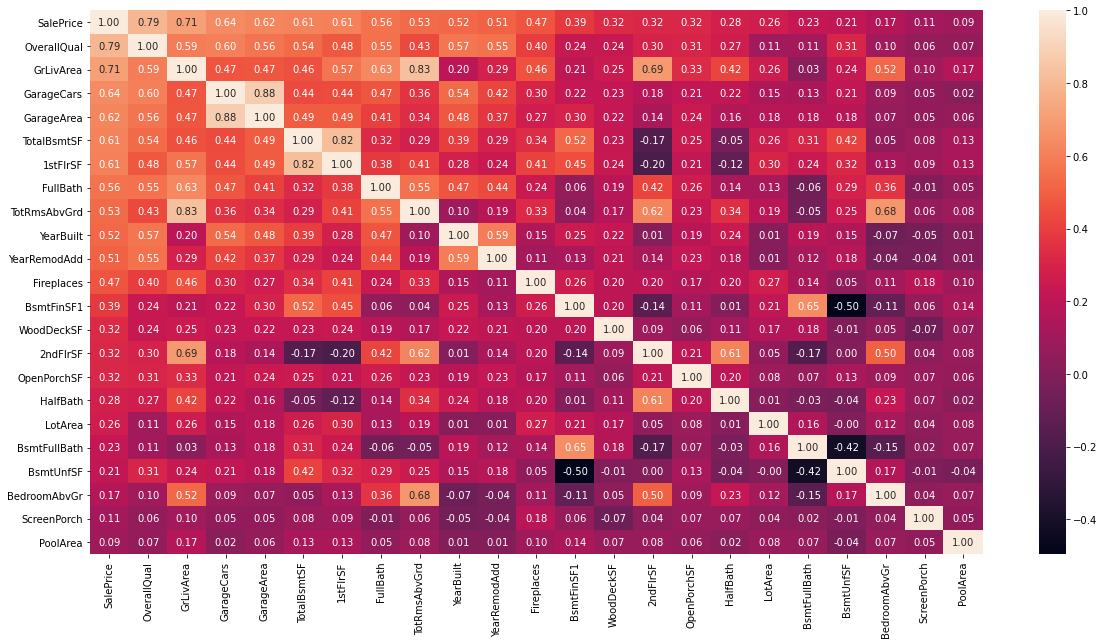

In [24]:
# check hot matrix
hotMatrix, highcorrmat = corrHotMatrix(sel_train,0.05)

In [25]:
# check features' info
features = highcorrmat.columns
sel_train = sel_train[features]
print("Selected train data shape:", sel_train.shape)
sel_train.info()
sel_train.head(100)

Selected train data shape: (1459, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   SalePrice     1459 non-null   int64
 1   OverallQual   1459 non-null   int64
 2   GrLivArea     1459 non-null   int64
 3   GarageCars    1459 non-null   int64
 4   GarageArea    1459 non-null   int64
 5   TotalBsmtSF   1459 non-null   int64
 6   1stFlrSF      1459 non-null   int64
 7   FullBath      1459 non-null   int64
 8   TotRmsAbvGrd  1459 non-null   int64
 9   YearBuilt     1459 non-null   int64
 10  YearRemodAdd  1459 non-null   int64
 11  Fireplaces    1459 non-null   int64
 12  BsmtFinSF1    1459 non-null   int64
 13  WoodDeckSF    1459 non-null   int64
 14  2ndFlrSF      1459 non-null   int64
 15  OpenPorchSF   1459 non-null   int64
 16  HalfBath      1459 non-null   int64
 17  LotArea       1459 non-null   int64
 18  BsmtFullBath  1459 non-null   

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0      208500            7       1710           2         548          856   
1      181500            6       1262           2         460         1262   
2      223500            7       1786           2         608          920   
3      140000            7       1717           3         642          756   
4      250000            8       2198           3         836         1145   
..        ...          ...        ...         ...         ...          ...   
95     185000            6       1470           2         420          680   
96     214000            7       1588           2         472         1588   
97      94750            4        960           1         432          960   
98      83000            5        835           1         366          458   
99     128950            4       1225           0           0          950   

    1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  ...  WoodDeckSF  2ndFlrSF  \
0        856         2             8       2003  ...           0       854   
1       1262         2             6       1976  ...         298         0   
2        920         2             6       2001  ...           0       866   
3        961         1             7       1915  ...           0       756   
4       1145         2             9       2000  ...         192      1053   
..       ...       ...           ...        ...  ...         ...       ...   
95       680         2             6       1993  ...         232       790   
96      1588         2             6       1999  ...         158         0   
97       960         1             6       1965  ...         120         0   
98       835         1             5       1920  ...           0         0   
99      1225         1             6       1959  ...         352         0   

    OpenPorchSF  HalfBath  LotArea  BsmtFullBath  BsmtUnfSF  BedroomAbvGr  \
0            61         1     8450             1        150             3   
1             0         0     9600             0        284             3   
2            42         1    11250             1        434             3   
3            35         0     9550             1        540             3   
4            84         1    14260             1        490             4   
..          ...       ...      ...           ...        ...           ...   
95           63         1     9765             0        370             3   
96           29         0    10264             0        426             3   
97            0         0    10921             1        440             3   
98            0         0    10625             0        350             2   
99            0         1     9320             1        381             3   

    ScreenPorch  PoolArea  
0             0         0  
1             0         0  
2             0         0  
3             0         0  
4             0         0  
..          ...       ...  
95            0         0  
96            0         0  
97            0         0  
98            0         0  
99            0         0  

[100 rows x 23 columns]

In [26]:
# Features Normalization which promise the mean=0, std=1
sel_train_norm = sel_train.copy(deep=True)
sel_train_norm

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0        208500            7       1710           2         548          856   
1        181500            6       1262           2         460         1262   
2        223500            7       1786           2         608          920   
3        140000            7       1717           3         642          756   
4        250000            8       2198           3         836         1145   
...         ...          ...        ...         ...         ...          ...   
1455     175000            6       1647           2         460          953   
1456     210000            6       2073           2         500         1542   
1457     266500            7       2340           1         252         1152   
1458     142125            5       1078           1         240         1078   
1459     147500            5       1256           1         276         1256   

      1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  ...  WoodDeckSF  2ndFlrSF  \
0          856         2             8       2003  ...           0       854   
1         1262         2             6       1976  ...         298         0   
2          920         2             6       2001  ...           0       866   
3          961         1             7       1915  ...           0       756   
4         1145         2             9       2000  ...         192      1053   
...        ...       ...           ...        ...  ...         ...       ...   
1455       953         2             7       1999  ...           0       694   
1456      2073         2             7       1978  ...         349         0   
1457      1188         2             9       1941  ...           0      1152   
1458      1078         1             5       1950  ...         366         0   
1459      1256         1             6       1965  ...         736         0   

      OpenPorchSF  HalfBath  LotArea  BsmtFullBath  BsmtUnfSF  BedroomAbvGr  \
0              61         1     8450             1        150             3   
1               0         0     9600             0        284             3   
2              42         1    11250             1        434             3   
3              35         0     9550             1        540             3   
4              84         1    14260             1        490             4   
...           ...       ...      ...           ...        ...           ...   
1455           40         1     7917             0        953             3   
1456            0         0    13175             1        589             3   
1457           60         0     9042             0        877             4   
1458            0         0     9717             1          0             2   
1459           68         1     9937             1        136             3   

      ScreenPorch  PoolArea  
0               0         0  
1               0         0  
2               0         0  
3               0         0  
4               0         0  
...           ...       ...  
1455            0         0  
1456            0         0  
1457            0         0  
1458            0         0  
1459            0         0  

[1459 rows x 23 columns]

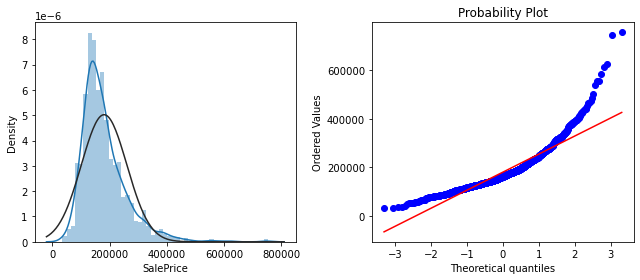

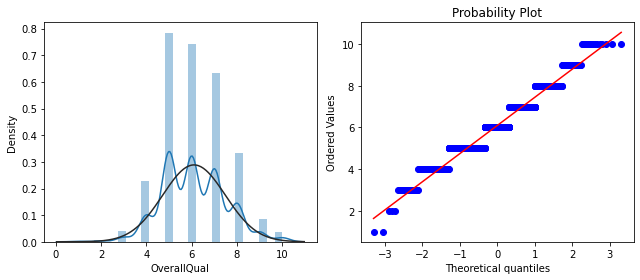

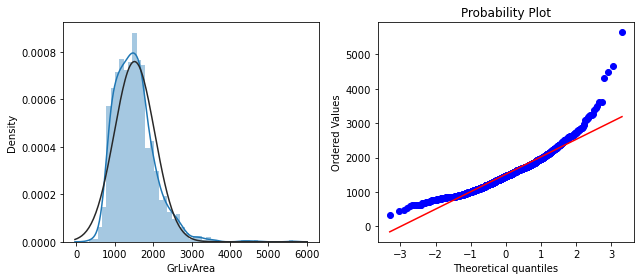

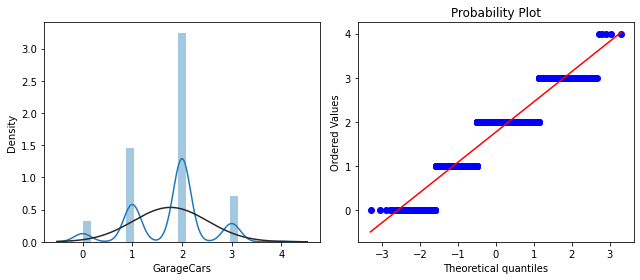

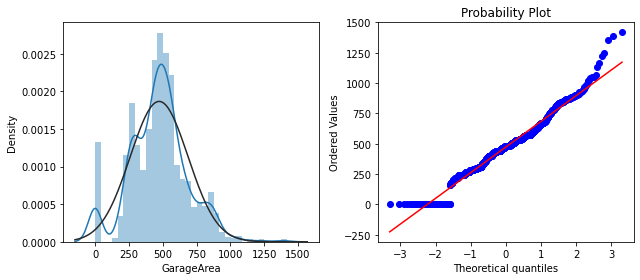

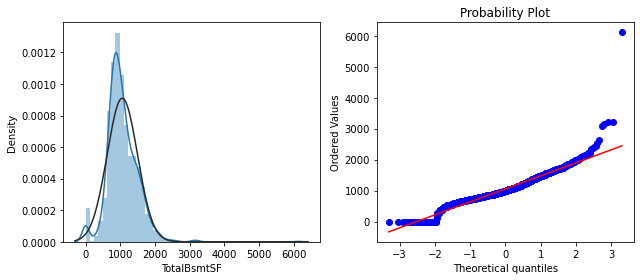

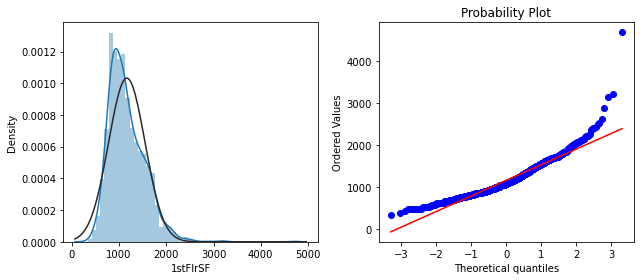

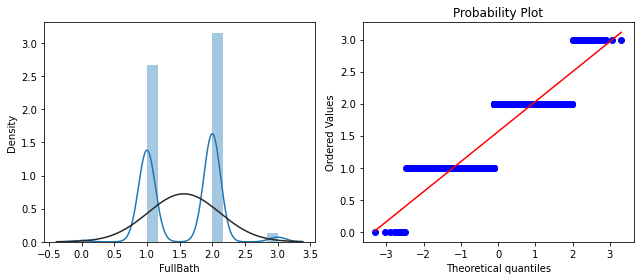

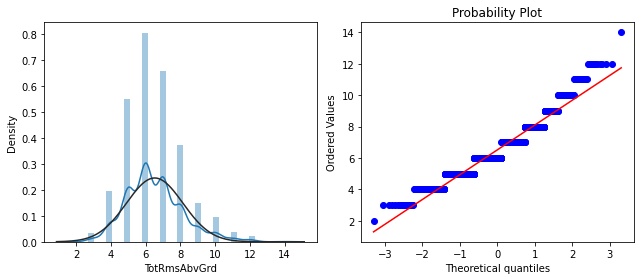

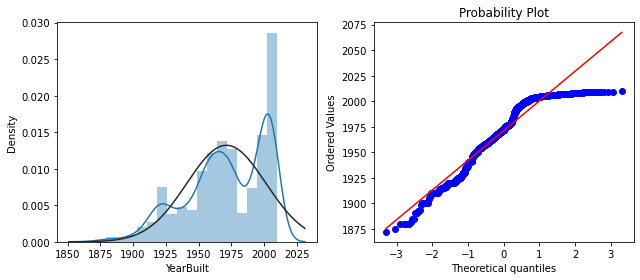

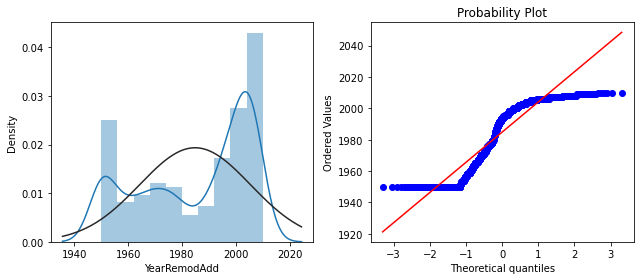

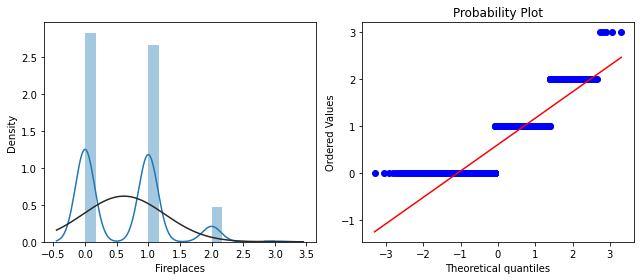

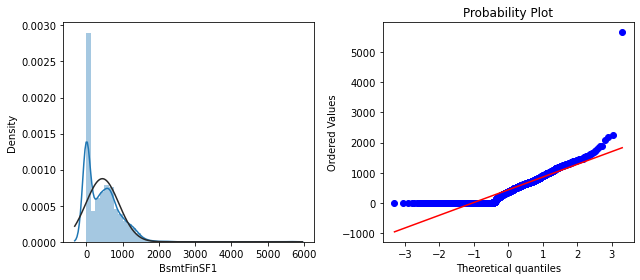

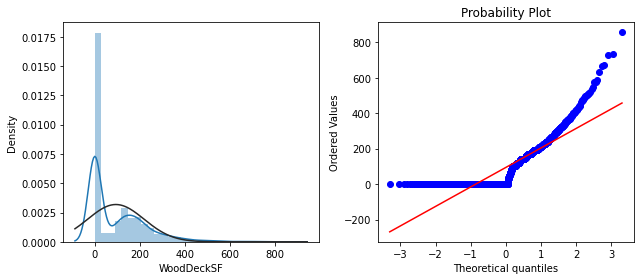

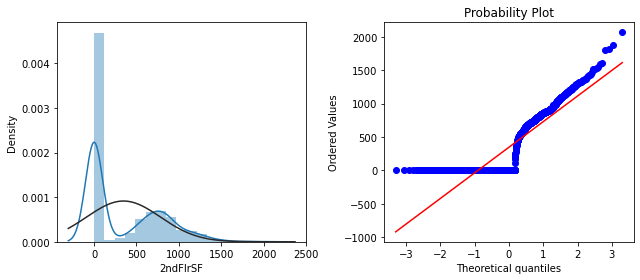

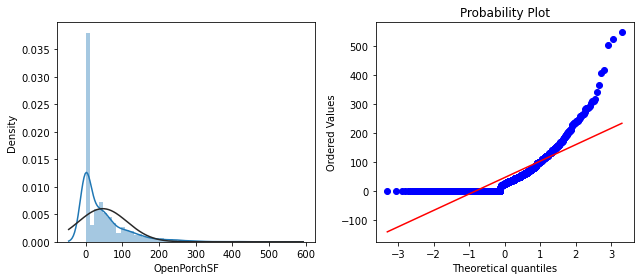

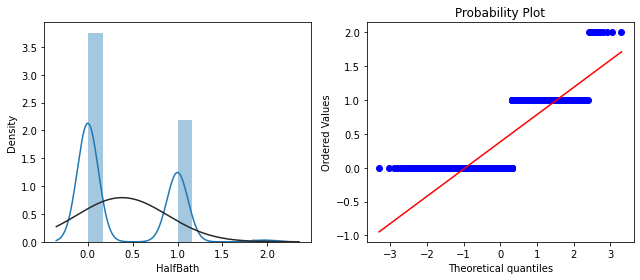

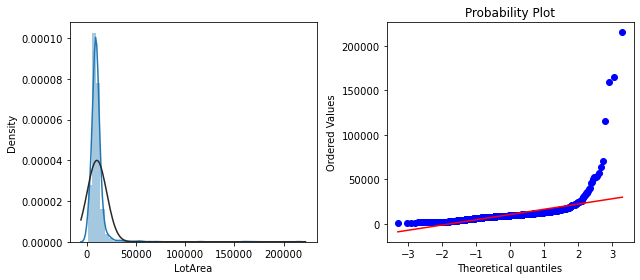

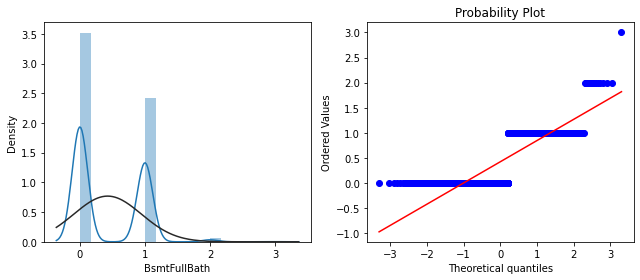

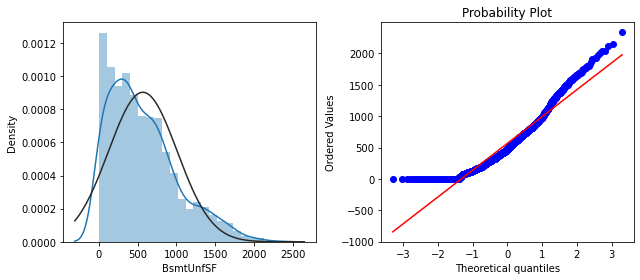

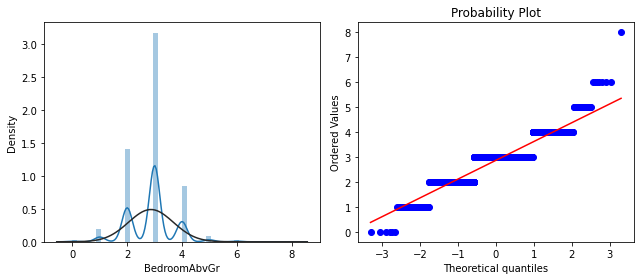

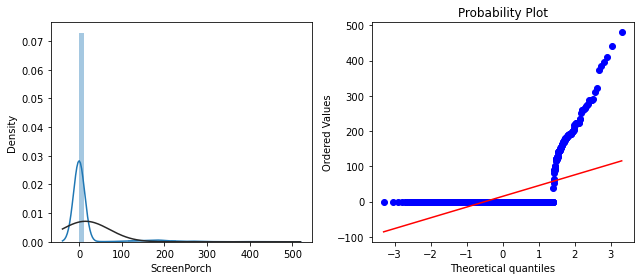

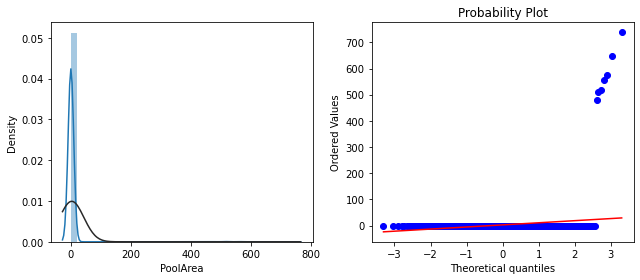

In [27]:
# check distribution
for col in sel_train_norm:
    normalDetect(sel_train_norm,col)

In [28]:
house_df = sel_train_norm
house_df.sample(20)

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
264       73000            5        764           2         504          680   
808      159950            5       1086           2         484         1024   
1163     108959            4       1258           2         400         1198   
147      222500            7       2035           2         434          884   
177      172500            5       1920           2         451         1052   
254      145000            5       1314           1         294         1314   
92       163500            5        964           2         432          876   
794      194500            7       1895           2         409          712   
561      170000            5       1389           2         418         1389   
1120     118400            6       1012           1         308         1012   
1115     318000            8       1734           3         928         1734   
866      248900            8       1646           3         870         1638   
895      140000            6       1796           2         483          780   
482      155000            7       1826           1         164          910   
644      370878            9       1766           3         478         1766   
1298     160000           10       5642           2        1418         6110   
1054     255000            8       1989           2         586         1065   
165      127500            5       1355           0           0          644   
1068     151400            6       2521           2         576          942   
868      169000            5       2320           2         672            0   

      1stFlrSF  FullBath  TotRmsAbvGrd  YearBuilt  ...  WoodDeckSF  2ndFlrSF  \
264        764         1             4       1925  ...           0         0   
808       1086         1             6       1966  ...           0         0   
1163      1258         0             6       1969  ...         120         0   
147        884         2             8       2001  ...         144      1151   
177       1252         2             8       1958  ...           0       668   
254       1314         1             5       1957  ...         250         0   
92         964         1             5       1921  ...           0         0   
794       1086         2             7       1994  ...         143       809   
561       1389         1             6       1974  ...         240         0   
1120      1012         1             6       1920  ...           0         0   
1115      1734         2             7       2007  ...           0         0   
866       1646         2             6       2006  ...         192         0   
895        983         1             8       1963  ...           0       813   
482        916         1             7       1915  ...           0       910   
644       1766         2             7       2009  ...         195         0   
1298      4692         2            12       2008  ...         214       950   
1054      1091         2             7       2002  ...         199       898   
165        808         2             6       1940  ...         140       547   
1068      1291         2            10       1973  ...         728      1230   
868       1547         2             7       1948  ...         120       720   

      OpenPorchSF  HalfBath  LotArea  BsmtFullBath  BsmtUnfSF  BedroomAbvGr  \
264             0         0     5232             0        680             2   
808             0         0    13400             1        380             3   
1163            0         2    12900             2          0             0   
147            48         1     9505             0        884             3   
177             0         0    13650             1        554             4   
254             0         0     8400             1        392             3   
92              0         0    13360             1        163             2   
794         

## 2.1 MLP

In [29]:
class HousePriceDataset(Dataset):
    """
    Define the dataset class for pytorch training
    """
    
    def __init__(self, df, mode='train', random_state=0):
        self.mode = mode
        
        # Normlization
        scalar = StandardScaler()
        df = scalar.fit_transform(df)
        df = pd.DataFrame(df)
        
        target = df.iloc[:,0]
        data = df.iloc[:, 1:]
        
        # Generation the indices of traning data and testing data. By setting different random state we can get different splits. 
        # Different from k-fold validation, the testing data may overlap.
        indices_train, indices_test = train_test_split([i for i in range(data.shape[0])], test_size = 0.2, random_state = random_state)
        
        if mode == 'train':
            indices = indices_train
        elif mode == 'test':
            indices = indices_test
            
        data = data.to_numpy()
        target = target.to_numpy()
        self.data = torch.FloatTensor(data[indices])
        self.target = torch.FloatTensor(target[indices])
        self.dim = self.data.shape[1]

        print('Finish reading the {} data. {}samples and dim = {}'.format(self.mode, len(self.data), self.dim))
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    
    def __len__(self):
        return len(self.data)


In [30]:
# data loader

def house_price_data_loader(df, mode, batch_size, n_jobs=0, random_state=0):
    """
    Output the training and testing data.
    """
    dataset = HousePriceDataset(df, mode=mode,random_state=random_state)
    dataloader = DataLoader(dataset, batch_size, 
                            shuffle=(mode == 'train'), 
                            drop_last=False,
                            num_workers=n_jobs, pin_memory=True)
    
    return dataloader

In [31]:
house_price_config_default = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8             # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth', # your model will be saved here
    'L1_w': 0,                       # weight of L1 term
    'alpha': 0                       # weight of regularizaition terms
}

# Evaluate the model on 5 different resampling splits
loss_record_5_fold = []
for j in range(5):
    train_data = house_price_data_loader(house_df, 'train', house_price_config_default['batch_size'],random_state=j)
    test_data = house_price_data_loader(house_df, 'test', house_price_config_default['batch_size'],random_state=j)
    
    model = NeuralNet(train_data.dataset.dim)

    model_loss, _ = train(train_data, test_data, model, house_price_config_default, device)

    loss_record_5_fold.append(model_loss)

mean_loss = np.mean(loss_record_5_fold)
std_loss = np.std(loss_record_5_fold)
print('The mean loss is {}\nSTD is {}'.format(mean_loss, std_loss))


Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.613301
epoch 2, loss 0.366776
epoch 3, loss 0.255474
epoch 4, loss 0.203737
epoch 5, loss 0.179349
epoch 6, loss 0.168098
epoch 7, loss 0.161642
epoch 8, loss 0.158162
epoch 9, loss 0.154644
epoch 10, loss 0.149671
epoch 12, loss 0.147336
epoch 13, loss 0.144144
epoch 14, loss 0.142203
epoch 15, loss 0.141831
epoch 16, loss 0.139945
epoch 17, loss 0.138014
epoch 18, loss 0.136863
epoch 19, loss 0.136012
epoch 20, loss 0.134244
epoch 22, loss 0.132943
epoch 24, loss 0.130010
epoch 27, loss 0.129514
epoch 28, loss 0.128855
epoch 30, loss 0.128850
epoch 32, loss 0.127247
epoch 34, loss 0.126581
epoch 36, loss 0.126185
epoch 40, loss 0.125863
epoch 41, loss 0.124379
epoch 46, loss 0.123624
epoch 48, loss 0.123093
epoch 51, loss 0.122403
epoch 60, loss 0.121965
epoch 62, loss 0.121095
epoch 71, loss 0.120531
epoch 81, loss 0.120173
epoch 86, loss 0.119397
epoch 96, l

## 2.2 MLP with L1 regularization

In [32]:
# Tune hyperparameters with 5 folds validation
# Tune alpha only

house_price_config_random_L1 = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth', # your model will be saved here
    'L1_w': 1,      # weight of L1 term
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
}

def house_price_random_search_L1_L2(iteration, config_random):
    """
    Random search for tuning hyperparameter alpha.
    Set the L1_w in config_random to be 1 in L1 regularization and 0 in L2 regularization.
    """

    iteration = iteration
    min_loss = 1000
    config_best = None
    
    config_record = []
    for i in range(iteration):
        print('ITERATION %d' %i)
        config_candidate = config_random.copy()
        alpha_index = randint(0,len(config_candidate['alpha'])-1)
        
        if alpha_index in config_record:  # if a config has been tested then skip it
            print('PARAMETER HAS BEEN TESTED')
            continue
        
        config_record.append(alpha_index)
        
        loss_record_5_fold = []
        
        config_candidate['alpha'] = config_candidate['alpha'][alpha_index]
        
        # Evaluate the model on 5 different resampling splits
        for j in range(5):
            train_data = house_price_data_loader(house_df, 'train', config_candidate['batch_size'], random_state=j)
            test_data = house_price_data_loader(house_df, 'test', config_candidate['batch_size'], random_state=j)
            model = NeuralNet(train_data.dataset.dim)

            model_loss, model_loss_record = train(train_data, test_data, model, config_candidate, device)
            
            loss_record_5_fold.append(model_loss)
        
        mean_loss = np.mean(loss_record_5_fold)
        std_loss = np.std(loss_record_5_fold)
        
        if mean_loss < min_loss:
            min_loss = mean_loss
            config_best = config_candidate
            
    print('The lowest mean loss is {}, STD : {}\nConfig is {}'.format(min_loss, std_loss, config_best))

time_start = time.time()
house_price_random_search_L1_L2(50, house_price_config_random_L1)
time_end = time.time()
print('Total Time: ', time_end-time_start)

ITERATION 0
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.574313
epoch 2, loss 0.347922
epoch 3, loss 0.248571
epoch 4, loss 0.211550
epoch 5, loss 0.192954
epoch 6, loss 0.183935
epoch 7, loss 0.179083
epoch 8, loss 0.174925
epoch 9, loss 0.170012
epoch 10, loss 0.166728
epoch 11, loss 0.163600
epoch 12, loss 0.161150
epoch 13, loss 0.157686
epoch 14, loss 0.155411
epoch 15, loss 0.152878
epoch 16, loss 0.150638
epoch 17, loss 0.149359
epoch 18, loss 0.146741
epoch 19, loss 0.145282
epoch 20, loss 0.143617
epoch 21, loss 0.142813
epoch 22, loss 0.141478
epoch 23, loss 0.139591
epoch 24, loss 0.139280
epoch 25, loss 0.137760
epoch 26, loss 0.136797
epoch 27, loss 0.135561
epoch 28, loss 0.134775
epoch 29, loss 0.134011
epoch 30, loss 0.133590
epoch 31, loss 0.132634
epoch 32, loss 0.132137
epoch 33, loss 0.131523
epoch 34, loss 0.131020
epoch 35, loss 0.129980
epoch 36, loss 0.129939
epoch 37, loss 0.129302

epoch 124, loss 0.116251
epoch 130, loss 0.116040
epoch 135, loss 0.115958
epoch 143, loss 0.115893
epoch 158, loss 0.115055
Final loss is 0.115055 after 359 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.633921
epoch 2, loss 0.394703
epoch 3, loss 0.296200
epoch 4, loss 0.266411
epoch 5, loss 0.245479
epoch 6, loss 0.245262
epoch 7, loss 0.239241
epoch 8, loss 0.234134
epoch 9, loss 0.233438
epoch 10, loss 0.232473
epoch 11, loss 0.230446
epoch 12, loss 0.229536
epoch 13, loss 0.229298
epoch 14, loss 0.227662
epoch 15, loss 0.223983
epoch 21, loss 0.221164
epoch 26, loss 0.220436
epoch 50, loss 0.219740
Final loss is 0.219740 after 251 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.494869
epoch 2, loss 0.354062
epoch 3, loss 0.337118
Final loss is 0.337118 after 204 epochs
ITERATION 1
Finish reading the train data. 

epoch 148, loss 0.102577
epoch 149, loss 0.102539
epoch 150, loss 0.102516
epoch 152, loss 0.102421
epoch 153, loss 0.102371
epoch 155, loss 0.102261
epoch 156, loss 0.102163
epoch 157, loss 0.102152
epoch 158, loss 0.102125
epoch 159, loss 0.101926
epoch 162, loss 0.101876
epoch 164, loss 0.101838
epoch 166, loss 0.101797
epoch 167, loss 0.101785
epoch 168, loss 0.101704
epoch 169, loss 0.101686
epoch 171, loss 0.101658
epoch 172, loss 0.101639
epoch 173, loss 0.101632
epoch 174, loss 0.101607
epoch 176, loss 0.101566
epoch 177, loss 0.101464
epoch 179, loss 0.101424
epoch 181, loss 0.101296
epoch 185, loss 0.101255
epoch 188, loss 0.101243
epoch 189, loss 0.101184
epoch 191, loss 0.101144
epoch 192, loss 0.101117
epoch 194, loss 0.101095
epoch 196, loss 0.100927
epoch 199, loss 0.100874
epoch 200, loss 0.100816
epoch 202, loss 0.100693
epoch 203, loss 0.100690
epoch 204, loss 0.100664
epoch 205, loss 0.100608
epoch 206, loss 0.100425
epoch 208, loss 0.100403
epoch 209, loss 0.100370


epoch 135, loss 0.147208
epoch 136, loss 0.146252
epoch 147, loss 0.145337
epoch 150, loss 0.144984
epoch 159, loss 0.143854
epoch 182, loss 0.142933
epoch 188, loss 0.142190
epoch 213, loss 0.141860
epoch 224, loss 0.141534
epoch 232, loss 0.141317
epoch 238, loss 0.140490
epoch 261, loss 0.140321
epoch 268, loss 0.139973
epoch 308, loss 0.139533
epoch 319, loss 0.139069
epoch 353, loss 0.138528
epoch 355, loss 0.138274
epoch 445, loss 0.137686
epoch 492, loss 0.137551
epoch 549, loss 0.137207
Final loss is 0.137207 after 750 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.885614
epoch 2, loss 0.565749
epoch 3, loss 0.433708
epoch 4, loss 0.379378
epoch 5, loss 0.348035
epoch 6, loss 0.341220
epoch 7, loss 0.324294
epoch 8, loss 0.313656
epoch 13, loss 0.312285
epoch 47, loss 0.307947
epoch 48, loss 0.306220
epoch 49, loss 0.299024
epoch 50, loss 0.294172
epoch 51, loss 0.289326
epoch 52, loss 0.28514

Final loss is 0.091434 after 406 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.781043
epoch 2, loss 0.509987
epoch 3, loss 0.366946
epoch 4, loss 0.281216
epoch 5, loss 0.238310
epoch 6, loss 0.209232
epoch 7, loss 0.196041
epoch 8, loss 0.188518
epoch 9, loss 0.181843
epoch 10, loss 0.175724
epoch 11, loss 0.171456
epoch 12, loss 0.168322
epoch 13, loss 0.163912
epoch 14, loss 0.161001
epoch 15, loss 0.158985
epoch 16, loss 0.156839
epoch 17, loss 0.154493
epoch 18, loss 0.151684
epoch 19, loss 0.149412
epoch 20, loss 0.147105
epoch 21, loss 0.145303
epoch 22, loss 0.144434
epoch 23, loss 0.141815
epoch 24, loss 0.141477
epoch 25, loss 0.138776
epoch 26, loss 0.137421
epoch 27, loss 0.135926
epoch 28, loss 0.135089
epoch 29, loss 0.133630
epoch 30, loss 0.132574
epoch 31, loss 0.132013
epoch 32, loss 0.131080
epoch 33, loss 0.129689
epoch 34, loss 0.128811
epoch 35, loss 0.127777
epoch 36, loss 0.12

epoch 26, loss 0.107882
epoch 27, loss 0.107439
epoch 28, loss 0.106348
epoch 29, loss 0.105797
epoch 30, loss 0.104793
epoch 31, loss 0.104735
epoch 32, loss 0.104146
epoch 33, loss 0.103638
epoch 34, loss 0.102819
epoch 35, loss 0.102637
epoch 36, loss 0.102359
epoch 37, loss 0.101376
epoch 38, loss 0.101278
epoch 39, loss 0.100686
epoch 40, loss 0.100378
epoch 41, loss 0.100142
epoch 42, loss 0.099842
epoch 43, loss 0.099461
epoch 45, loss 0.099022
epoch 46, loss 0.098808
epoch 47, loss 0.098539
epoch 48, loss 0.098055
epoch 49, loss 0.097883
epoch 51, loss 0.097505
epoch 53, loss 0.097020
epoch 58, loss 0.096884
epoch 59, loss 0.096550
epoch 60, loss 0.096390
epoch 62, loss 0.096000
epoch 63, loss 0.095991
epoch 67, loss 0.095961
epoch 68, loss 0.095890
epoch 69, loss 0.095651
epoch 70, loss 0.095466
epoch 71, loss 0.095233
epoch 72, loss 0.095231
epoch 73, loss 0.095230
epoch 74, loss 0.095052
epoch 75, loss 0.094939
epoch 77, loss 0.094716
epoch 81, loss 0.094580
epoch 82, loss 0

epoch 269, loss 0.120754
epoch 275, loss 0.120461
epoch 278, loss 0.120359
epoch 290, loss 0.120128
epoch 291, loss 0.119912
epoch 302, loss 0.119864
epoch 308, loss 0.119711
epoch 317, loss 0.119611
epoch 320, loss 0.119480
epoch 321, loss 0.119457
epoch 328, loss 0.119326
epoch 335, loss 0.119320
epoch 340, loss 0.119300
epoch 343, loss 0.119029
epoch 346, loss 0.119019
epoch 360, loss 0.119010
epoch 367, loss 0.118980
epoch 368, loss 0.118819
epoch 371, loss 0.118583
epoch 407, loss 0.118521
epoch 424, loss 0.118301
epoch 448, loss 0.118301
epoch 455, loss 0.118198
epoch 461, loss 0.118132
epoch 469, loss 0.118103
epoch 478, loss 0.118081
epoch 480, loss 0.118059
epoch 481, loss 0.117934
epoch 493, loss 0.117875
epoch 496, loss 0.117390
epoch 515, loss 0.117020
epoch 523, loss 0.116875
epoch 534, loss 0.116494
epoch 549, loss 0.116456
epoch 553, loss 0.116187
epoch 560, loss 0.116002
epoch 579, loss 0.115868
epoch 587, loss 0.115732
epoch 606, loss 0.115272
epoch 636, loss 0.114870


epoch 6, loss 0.216673
epoch 7, loss 0.204751
epoch 8, loss 0.196402
epoch 9, loss 0.190242
epoch 10, loss 0.185539
epoch 11, loss 0.180736
epoch 12, loss 0.177464
epoch 13, loss 0.173268
epoch 14, loss 0.170495
epoch 15, loss 0.167295
epoch 16, loss 0.165377
epoch 17, loss 0.162897
epoch 18, loss 0.159636
epoch 19, loss 0.157550
epoch 20, loss 0.155798
epoch 21, loss 0.153268
epoch 22, loss 0.151276
epoch 23, loss 0.149465
epoch 24, loss 0.147695
epoch 25, loss 0.145919
epoch 26, loss 0.144761
epoch 27, loss 0.142749
epoch 28, loss 0.141555
epoch 29, loss 0.140158
epoch 30, loss 0.139182
epoch 31, loss 0.137467
epoch 32, loss 0.136497
epoch 33, loss 0.135141
epoch 34, loss 0.134434
epoch 35, loss 0.133057
epoch 36, loss 0.132064
epoch 37, loss 0.131795
epoch 38, loss 0.130339
epoch 39, loss 0.129815
epoch 40, loss 0.128805
epoch 41, loss 0.128370
epoch 42, loss 0.127187
epoch 43, loss 0.126839
epoch 44, loss 0.126284
epoch 45, loss 0.125190
epoch 46, loss 0.124405
epoch 47, loss 0.124

epoch 167, loss 0.116014
epoch 168, loss 0.115966
epoch 169, loss 0.115962
epoch 170, loss 0.115735
epoch 173, loss 0.115632
epoch 175, loss 0.115560
epoch 176, loss 0.115512
epoch 177, loss 0.115382
epoch 178, loss 0.115379
epoch 179, loss 0.115186
epoch 181, loss 0.115142
epoch 182, loss 0.115118
epoch 183, loss 0.115036
epoch 184, loss 0.114951
epoch 185, loss 0.114875
epoch 188, loss 0.114764
epoch 189, loss 0.114661
epoch 190, loss 0.114585
epoch 192, loss 0.114497
epoch 194, loss 0.114361
epoch 196, loss 0.114355
epoch 197, loss 0.114274
epoch 198, loss 0.114192
epoch 199, loss 0.114090
epoch 200, loss 0.114049
epoch 204, loss 0.113913
epoch 208, loss 0.113810
epoch 209, loss 0.113786
epoch 211, loss 0.113779
epoch 212, loss 0.113668
epoch 216, loss 0.113493
epoch 218, loss 0.113421
epoch 223, loss 0.113402
epoch 225, loss 0.113379
epoch 226, loss 0.113303
epoch 227, loss 0.113225
epoch 228, loss 0.113175
epoch 231, loss 0.113058
epoch 234, loss 0.112951
epoch 237, loss 0.112821


epoch 116, loss 0.087607
epoch 117, loss 0.087450
epoch 118, loss 0.087334
epoch 120, loss 0.087236
epoch 121, loss 0.087028
epoch 122, loss 0.086867
epoch 123, loss 0.086727
epoch 125, loss 0.086684
epoch 126, loss 0.086561
epoch 128, loss 0.086264
epoch 130, loss 0.086066
epoch 135, loss 0.086016
epoch 137, loss 0.085778
epoch 138, loss 0.085644
epoch 140, loss 0.085546
epoch 143, loss 0.085412
epoch 144, loss 0.085266
epoch 146, loss 0.085246
epoch 147, loss 0.085154
epoch 151, loss 0.084921
epoch 153, loss 0.084832
epoch 155, loss 0.084773
epoch 156, loss 0.084598
epoch 158, loss 0.084461
epoch 159, loss 0.084387
epoch 162, loss 0.084314
epoch 163, loss 0.084231
epoch 164, loss 0.084128
epoch 165, loss 0.084052
epoch 168, loss 0.083755
epoch 173, loss 0.083668
epoch 174, loss 0.083468
epoch 175, loss 0.083435
epoch 176, loss 0.083309
epoch 178, loss 0.083175
epoch 181, loss 0.083124
epoch 183, loss 0.083108
epoch 184, loss 0.083024
epoch 185, loss 0.082777
epoch 188, loss 0.082742


epoch 12, loss 0.193475
epoch 13, loss 0.188433
epoch 14, loss 0.185153
epoch 15, loss 0.181777
epoch 16, loss 0.177143
epoch 17, loss 0.174498
epoch 18, loss 0.172550
epoch 19, loss 0.171163
epoch 20, loss 0.168116
epoch 21, loss 0.165771
epoch 22, loss 0.163303
epoch 23, loss 0.162340
epoch 24, loss 0.160246
epoch 25, loss 0.159199
epoch 26, loss 0.157895
epoch 27, loss 0.156178
epoch 28, loss 0.154714
epoch 29, loss 0.153449
epoch 30, loss 0.152173
epoch 31, loss 0.150874
epoch 33, loss 0.148437
epoch 35, loss 0.147910
epoch 36, loss 0.147051
epoch 37, loss 0.146448
epoch 38, loss 0.144741
epoch 39, loss 0.143783
epoch 41, loss 0.143608
epoch 42, loss 0.143480
epoch 43, loss 0.142267
epoch 44, loss 0.141334
epoch 45, loss 0.140685
epoch 46, loss 0.140499
epoch 47, loss 0.139430
epoch 50, loss 0.138953
epoch 51, loss 0.138483
epoch 52, loss 0.137810
epoch 53, loss 0.137201
epoch 54, loss 0.137080
epoch 56, loss 0.136945
epoch 57, loss 0.136421
epoch 58, loss 0.135660
epoch 60, loss 0

epoch 80, loss 0.214614
epoch 92, loss 0.214050
epoch 99, loss 0.213235
epoch 104, loss 0.213175
epoch 105, loss 0.212858
epoch 120, loss 0.211687
epoch 131, loss 0.211266
epoch 135, loss 0.210204
epoch 161, loss 0.209790
epoch 170, loss 0.209462
epoch 182, loss 0.209347
epoch 189, loss 0.208681
epoch 217, loss 0.207233
epoch 243, loss 0.207172
epoch 256, loss 0.207012
epoch 269, loss 0.206799
epoch 279, loss 0.206324
epoch 290, loss 0.206257
epoch 294, loss 0.205373
epoch 300, loss 0.205218
epoch 319, loss 0.205096
epoch 325, loss 0.204439
epoch 341, loss 0.204412
epoch 354, loss 0.203484
epoch 358, loss 0.203460
epoch 364, loss 0.203397
epoch 367, loss 0.203300
epoch 394, loss 0.202762
epoch 404, loss 0.202626
epoch 409, loss 0.202601
epoch 415, loss 0.202440
epoch 416, loss 0.201821
epoch 429, loss 0.200677
epoch 458, loss 0.200605
epoch 463, loss 0.200275
epoch 473, loss 0.200223
epoch 476, loss 0.199459
epoch 482, loss 0.199136
epoch 488, loss 0.198914
epoch 495, loss 0.198731
epo

Final loss is 0.274454 after 207 epochs
ITERATION 16
PARAMETER HAS BEEN TESTED
ITERATION 17
PARAMETER HAS BEEN TESTED
ITERATION 18
PARAMETER HAS BEEN TESTED
ITERATION 19
PARAMETER HAS BEEN TESTED
ITERATION 20
PARAMETER HAS BEEN TESTED
ITERATION 21
PARAMETER HAS BEEN TESTED
ITERATION 22
PARAMETER HAS BEEN TESTED
ITERATION 23
PARAMETER HAS BEEN TESTED
ITERATION 24
PARAMETER HAS BEEN TESTED
ITERATION 25
PARAMETER HAS BEEN TESTED
ITERATION 26
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.732517
epoch 2, loss 0.455615
epoch 3, loss 0.325595
epoch 4, loss 0.260149
epoch 5, loss 0.219670
epoch 6, loss 0.204193
epoch 7, loss 0.187218
epoch 8, loss 0.178522
epoch 9, loss 0.176858
epoch 10, loss 0.170630
epoch 11, loss 0.166748
epoch 13, loss 0.158912
epoch 15, loss 0.158844
epoch 16, loss 0.155656
epoch 17, loss 0.153153
epoch 19, loss 0.151002
epoch 21, loss 0.150274
epoch 22, loss 0.149339
epoch 23, loss 0.146139


Final loss is 0.343362 after 207 epochs
ITERATION 27
PARAMETER HAS BEEN TESTED
ITERATION 28
PARAMETER HAS BEEN TESTED
ITERATION 29
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.551800
epoch 2, loss 0.340809
epoch 3, loss 0.256024
epoch 4, loss 0.220852
epoch 5, loss 0.205728
epoch 6, loss 0.194885
epoch 7, loss 0.188316
epoch 8, loss 0.183725
epoch 9, loss 0.179841
epoch 10, loss 0.172121
epoch 11, loss 0.171845
epoch 12, loss 0.168655
epoch 13, loss 0.164013
epoch 14, loss 0.162352
epoch 15, loss 0.160146
epoch 16, loss 0.159084
epoch 17, loss 0.155849
epoch 18, loss 0.152774
epoch 19, loss 0.152439
epoch 20, loss 0.150011
epoch 21, loss 0.146932
epoch 23, loss 0.145893
epoch 24, loss 0.143482
epoch 25, loss 0.143237
epoch 27, loss 0.141456
epoch 28, loss 0.139919
epoch 29, loss 0.139582
epoch 30, loss 0.138704
epoch 31, loss 0.137281
epoch 32, loss 0.136822
epoch 33, loss 0.134304
epoch 37, loss 0.133175


epoch 204, loss 0.089571
epoch 205, loss 0.089527
epoch 206, loss 0.089448
epoch 207, loss 0.089436
epoch 209, loss 0.089412
epoch 210, loss 0.089290
epoch 212, loss 0.089281
epoch 214, loss 0.089277
epoch 215, loss 0.089150
epoch 217, loss 0.088987
epoch 218, loss 0.088968
epoch 221, loss 0.088899
epoch 223, loss 0.088882
epoch 224, loss 0.088871
epoch 226, loss 0.088664
epoch 227, loss 0.088607
epoch 229, loss 0.088566
epoch 233, loss 0.088528
epoch 234, loss 0.088372
epoch 236, loss 0.088291
epoch 238, loss 0.088248
epoch 240, loss 0.088221
epoch 242, loss 0.088044
epoch 246, loss 0.088042
epoch 247, loss 0.087943
epoch 250, loss 0.087885
epoch 253, loss 0.087815
epoch 255, loss 0.087804
epoch 256, loss 0.087770
epoch 257, loss 0.087687
epoch 260, loss 0.087616
epoch 261, loss 0.087563
epoch 265, loss 0.087461
epoch 276, loss 0.087423
epoch 281, loss 0.087392
epoch 283, loss 0.087327
epoch 285, loss 0.087275
epoch 290, loss 0.087264
epoch 297, loss 0.087232
epoch 300, loss 0.087181


epoch 12, loss 0.181626
epoch 13, loss 0.176860
epoch 14, loss 0.172143
epoch 15, loss 0.168203
epoch 16, loss 0.165028
epoch 17, loss 0.161031
epoch 18, loss 0.159538
epoch 19, loss 0.156658
epoch 20, loss 0.153444
epoch 21, loss 0.151029
epoch 22, loss 0.149198
epoch 23, loss 0.146731
epoch 24, loss 0.145048
epoch 25, loss 0.144636
epoch 26, loss 0.142450
epoch 27, loss 0.140580
epoch 28, loss 0.139124
epoch 29, loss 0.138127
epoch 30, loss 0.136523
epoch 31, loss 0.135660
epoch 32, loss 0.135372
epoch 33, loss 0.133221
epoch 35, loss 0.132320
epoch 36, loss 0.131328
epoch 37, loss 0.130090
epoch 38, loss 0.129846
epoch 39, loss 0.128922
epoch 40, loss 0.128623
epoch 41, loss 0.127424
epoch 42, loss 0.127154
epoch 43, loss 0.126260
epoch 45, loss 0.125755
epoch 46, loss 0.125204
epoch 47, loss 0.124344
epoch 49, loss 0.123581
epoch 50, loss 0.123332
epoch 52, loss 0.122693
epoch 54, loss 0.122323
epoch 55, loss 0.121859
epoch 57, loss 0.121108
epoch 59, loss 0.120777
epoch 61, loss 0

Final loss is 0.705298 after 202 epochs
ITERATION 36
PARAMETER HAS BEEN TESTED
ITERATION 37
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.813345
epoch 2, loss 0.553995
epoch 3, loss 0.497439
Final loss is 0.497439 after 204 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.786320
epoch 2, loss 0.577140
epoch 3, loss 0.539773
Final loss is 0.539773 after 204 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.671401
epoch 2, loss 0.581781
epoch 3, loss 0.563862
Final loss is 0.563862 after 204 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.877447
epoch 2, loss 0.710652
epoch 3, loss 0.667744
Final loss is 0.667744 after 204 epochs
Finish reading the train data. 1

epoch 44, loss 0.125658
epoch 45, loss 0.124558
epoch 46, loss 0.124271
epoch 47, loss 0.123874
epoch 48, loss 0.123204
epoch 49, loss 0.122491
epoch 50, loss 0.121773
epoch 51, loss 0.121308
epoch 53, loss 0.120826
epoch 54, loss 0.120618
epoch 55, loss 0.120391
epoch 56, loss 0.119494
epoch 57, loss 0.118640
epoch 59, loss 0.118400
epoch 60, loss 0.118358
epoch 61, loss 0.117626
epoch 62, loss 0.117069
epoch 63, loss 0.116710
epoch 64, loss 0.116525
epoch 65, loss 0.116064
epoch 66, loss 0.115614
epoch 67, loss 0.115433
epoch 68, loss 0.114905
epoch 69, loss 0.114319
epoch 70, loss 0.114064
epoch 71, loss 0.113743
epoch 72, loss 0.113521
epoch 73, loss 0.113284
epoch 74, loss 0.112953
epoch 75, loss 0.112506
epoch 76, loss 0.112375
epoch 77, loss 0.111945
epoch 78, loss 0.111618
epoch 79, loss 0.111345
epoch 81, loss 0.110679
epoch 82, loss 0.110403
epoch 83, loss 0.110121
epoch 84, loss 0.110055
epoch 85, loss 0.109875
epoch 86, loss 0.109704
epoch 87, loss 0.109375
epoch 88, loss 0

## 2.3 MLP with L2 regularization

In [33]:
# Tune hyperparameters
# Tune alpha only
# Set the configuration of MLP with L2 penalty term

house_price_config_random_L2 = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth', # your model will be saved here
    'L1_w': 0,      # weight of L1 term. L2 is chosen by this way.
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
}


time_start = time.time()
house_price_random_search_L1_L2(50, house_price_config_random_L2)
time_end = time.time()
print('Total Time: ', time_end-time_start)

ITERATION 0
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.637330
epoch 2, loss 0.376078
epoch 3, loss 0.272921
epoch 4, loss 0.227430
epoch 5, loss 0.210998
epoch 6, loss 0.199403
epoch 7, loss 0.193050
epoch 8, loss 0.188680
epoch 9, loss 0.183502
epoch 10, loss 0.180745
epoch 11, loss 0.175630
epoch 12, loss 0.172498
epoch 13, loss 0.169194
epoch 14, loss 0.165350
epoch 15, loss 0.164450
epoch 16, loss 0.161408
epoch 17, loss 0.158598
epoch 18, loss 0.157055
epoch 19, loss 0.154983
epoch 20, loss 0.153904
epoch 21, loss 0.151883
epoch 22, loss 0.149130
epoch 24, loss 0.147012
epoch 25, loss 0.145848
epoch 26, loss 0.144363
epoch 27, loss 0.142288
epoch 29, loss 0.142056
epoch 30, loss 0.140037
epoch 31, loss 0.138234
epoch 32, loss 0.138219
epoch 33, loss 0.136988
epoch 35, loss 0.136821
epoch 36, loss 0.134927
epoch 37, loss 0.134557
epoch 38, loss 0.134134
epoch 40, loss 0.133140
epoch 41, loss 0.132200

epoch 11, loss 0.143763
epoch 12, loss 0.141929
epoch 13, loss 0.140015
epoch 14, loss 0.138022
epoch 15, loss 0.136557
epoch 16, loss 0.135284
epoch 17, loss 0.133639
epoch 18, loss 0.132121
epoch 19, loss 0.131200
epoch 21, loss 0.129028
epoch 22, loss 0.128425
epoch 23, loss 0.128340
epoch 24, loss 0.126876
epoch 25, loss 0.126480
epoch 26, loss 0.125431
epoch 27, loss 0.125072
epoch 28, loss 0.124842
epoch 29, loss 0.124369
epoch 30, loss 0.123007
epoch 32, loss 0.122044
epoch 34, loss 0.121614
epoch 35, loss 0.121253
epoch 36, loss 0.120999
epoch 37, loss 0.119766
epoch 41, loss 0.118577
epoch 45, loss 0.117674
epoch 47, loss 0.117558
epoch 48, loss 0.116771
epoch 51, loss 0.116687
epoch 52, loss 0.116454
epoch 54, loss 0.116007
epoch 57, loss 0.114579
epoch 60, loss 0.114562
epoch 63, loss 0.114529
epoch 65, loss 0.113873
epoch 72, loss 0.113264
epoch 74, loss 0.112907
epoch 79, loss 0.112651
epoch 85, loss 0.111926
epoch 89, loss 0.111786
epoch 102, loss 0.111539
epoch 108, loss

epoch 60, loss 0.123243
epoch 62, loss 0.122909
epoch 63, loss 0.122783
epoch 65, loss 0.122353
epoch 72, loss 0.122215
epoch 75, loss 0.122143
epoch 76, loss 0.121809
epoch 78, loss 0.121687
epoch 79, loss 0.121503
epoch 80, loss 0.121434
epoch 83, loss 0.121394
epoch 85, loss 0.121346
epoch 86, loss 0.121277
epoch 88, loss 0.121118
epoch 90, loss 0.121106
epoch 91, loss 0.120946
epoch 98, loss 0.120799
epoch 99, loss 0.120496
epoch 112, loss 0.120097
epoch 118, loss 0.120016
epoch 122, loss 0.119905
epoch 130, loss 0.119652
epoch 133, loss 0.119251
epoch 146, loss 0.119244
epoch 178, loss 0.119112
epoch 183, loss 0.118923
epoch 185, loss 0.118855
epoch 188, loss 0.118695
epoch 197, loss 0.118694
Final loss is 0.118694 after 398 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.633922
epoch 2, loss 0.369340
epoch 3, loss 0.247255
epoch 4, loss 0.188670
epoch 5, loss 0.164624
epoch 6, loss 0.151277
epoch

epoch 11, loss 0.335617
epoch 15, loss 0.332538
epoch 17, loss 0.330423
epoch 18, loss 0.328344
epoch 28, loss 0.327554
epoch 112, loss 0.327434
epoch 143, loss 0.324681
epoch 170, loss 0.323243
epoch 184, loss 0.323043
epoch 189, loss 0.322855
epoch 198, loss 0.322630
epoch 203, loss 0.322630
epoch 205, loss 0.321553
epoch 214, loss 0.320571
epoch 230, loss 0.320346
epoch 234, loss 0.317953
epoch 249, loss 0.316425
epoch 256, loss 0.315295
epoch 259, loss 0.313777
epoch 307, loss 0.312807
epoch 308, loss 0.310290
epoch 339, loss 0.309425
epoch 344, loss 0.307175
epoch 361, loss 0.305609
epoch 365, loss 0.302229
epoch 395, loss 0.301891
epoch 401, loss 0.301465
epoch 403, loss 0.301267
epoch 411, loss 0.301167
epoch 418, loss 0.300204
epoch 422, loss 0.299328
epoch 430, loss 0.297873
epoch 445, loss 0.297492
epoch 453, loss 0.296863
epoch 460, loss 0.296329
epoch 463, loss 0.296156
epoch 465, loss 0.295610
epoch 472, loss 0.294522
epoch 485, loss 0.291791
epoch 508, loss 0.290248
epoch

epoch 68, loss 0.098642
epoch 72, loss 0.098441
epoch 75, loss 0.098190
epoch 76, loss 0.098042
epoch 78, loss 0.097694
epoch 81, loss 0.097532
epoch 82, loss 0.097424
epoch 83, loss 0.097296
epoch 84, loss 0.097232
epoch 85, loss 0.097130
epoch 86, loss 0.096985
epoch 88, loss 0.096935
epoch 91, loss 0.096670
epoch 92, loss 0.096596
epoch 94, loss 0.096303
epoch 98, loss 0.096288
epoch 101, loss 0.095785
epoch 104, loss 0.095754
epoch 105, loss 0.095742
epoch 107, loss 0.095722
epoch 108, loss 0.095669
epoch 109, loss 0.095554
epoch 110, loss 0.095473
epoch 111, loss 0.095426
epoch 112, loss 0.095205
epoch 115, loss 0.095129
epoch 118, loss 0.095082
epoch 121, loss 0.094841
epoch 125, loss 0.094835
epoch 126, loss 0.094659
epoch 127, loss 0.094512
epoch 130, loss 0.094467
epoch 133, loss 0.094352
epoch 137, loss 0.094155
epoch 138, loss 0.094115
epoch 146, loss 0.093868
epoch 152, loss 0.093808
epoch 153, loss 0.093757
epoch 154, loss 0.093659
epoch 160, loss 0.093621
epoch 162, loss 

epoch 221, loss 0.094293
epoch 226, loss 0.094246
epoch 229, loss 0.094245
epoch 239, loss 0.094006
epoch 272, loss 0.094000
Final loss is 0.094000 after 473 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.808593
epoch 2, loss 0.511923
epoch 3, loss 0.359536
epoch 4, loss 0.275294
epoch 5, loss 0.228912
epoch 6, loss 0.203810
epoch 7, loss 0.188486
epoch 8, loss 0.178224
epoch 9, loss 0.170716
epoch 10, loss 0.164997
epoch 11, loss 0.160344
epoch 12, loss 0.157051
epoch 13, loss 0.153048
epoch 14, loss 0.150455
epoch 15, loss 0.148088
epoch 16, loss 0.145448
epoch 17, loss 0.143156
epoch 18, loss 0.141282
epoch 19, loss 0.139140
epoch 20, loss 0.136836
epoch 21, loss 0.135374
epoch 22, loss 0.134497
epoch 23, loss 0.133062
epoch 24, loss 0.131716
epoch 25, loss 0.130443
epoch 26, loss 0.129455
epoch 27, loss 0.128490
epoch 28, loss 0.127573
epoch 29, loss 0.126327
epoch 30, loss 0.125482
epoch 31, loss

epoch 66, loss 0.096901
epoch 67, loss 0.096691
epoch 68, loss 0.096662
epoch 70, loss 0.096290
epoch 71, loss 0.095878
epoch 72, loss 0.095819
epoch 75, loss 0.095721
epoch 76, loss 0.095567
epoch 77, loss 0.095293
epoch 78, loss 0.095027
epoch 82, loss 0.094912
epoch 83, loss 0.094651
epoch 86, loss 0.094548
epoch 87, loss 0.094210
epoch 90, loss 0.093868
epoch 93, loss 0.093621
epoch 98, loss 0.093505
epoch 101, loss 0.093302
epoch 102, loss 0.093257
epoch 103, loss 0.093202
epoch 104, loss 0.093026
epoch 107, loss 0.092969
epoch 109, loss 0.092648
epoch 110, loss 0.092604
epoch 111, loss 0.092598
epoch 114, loss 0.092482
epoch 117, loss 0.092297
epoch 118, loss 0.092204
epoch 119, loss 0.092190
epoch 122, loss 0.092182
epoch 124, loss 0.091963
epoch 126, loss 0.091759
epoch 131, loss 0.091748
epoch 134, loss 0.091601
epoch 135, loss 0.091553
epoch 137, loss 0.091432
epoch 140, loss 0.091296
epoch 147, loss 0.091206
epoch 149, loss 0.091175
epoch 151, loss 0.091043
epoch 152, loss 0

epoch 536, loss 0.108206
epoch 544, loss 0.108145
epoch 553, loss 0.108062
epoch 563, loss 0.107818
epoch 589, loss 0.107783
epoch 621, loss 0.107645
epoch 634, loss 0.107613
epoch 650, loss 0.107598
epoch 703, loss 0.107532
epoch 711, loss 0.107385
epoch 719, loss 0.107121
Final loss is 0.107121 after 920 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.601117
epoch 2, loss 0.381743
epoch 3, loss 0.272263
epoch 4, loss 0.224990
epoch 5, loss 0.194597
epoch 6, loss 0.182017
epoch 7, loss 0.171550
epoch 8, loss 0.164274
epoch 9, loss 0.159159
epoch 10, loss 0.152795
epoch 11, loss 0.149985
epoch 12, loss 0.145834
epoch 13, loss 0.143009
epoch 14, loss 0.140356
epoch 15, loss 0.137086
epoch 16, loss 0.135179
epoch 17, loss 0.132518
epoch 18, loss 0.130044
epoch 19, loss 0.128536
epoch 20, loss 0.127349
epoch 21, loss 0.126116
epoch 22, loss 0.124749
epoch 23, loss 0.122954
epoch 24, loss 0.122334
epoch 25

epoch 5, loss 0.194947
epoch 6, loss 0.180065
epoch 7, loss 0.171129
epoch 8, loss 0.163998
epoch 9, loss 0.159554
epoch 10, loss 0.156366
epoch 11, loss 0.154764
epoch 12, loss 0.152123
epoch 13, loss 0.148105
epoch 14, loss 0.145895
epoch 15, loss 0.143307
epoch 16, loss 0.141909
epoch 18, loss 0.139231
epoch 20, loss 0.137362
epoch 21, loss 0.134436
epoch 22, loss 0.132159
epoch 25, loss 0.131011
epoch 26, loss 0.130388
epoch 27, loss 0.128904
epoch 28, loss 0.125374
epoch 30, loss 0.125010
epoch 33, loss 0.123115
epoch 38, loss 0.120007
epoch 44, loss 0.118552
epoch 46, loss 0.117933
epoch 49, loss 0.117359
epoch 52, loss 0.116917
epoch 53, loss 0.116646
epoch 55, loss 0.115541
epoch 59, loss 0.115205
epoch 60, loss 0.113948
epoch 65, loss 0.113131
epoch 67, loss 0.112589
epoch 69, loss 0.112538
epoch 72, loss 0.111685
epoch 80, loss 0.111203
epoch 84, loss 0.110937
epoch 86, loss 0.109599
epoch 92, loss 0.109450
epoch 100, loss 0.109047
epoch 107, loss 0.108710
epoch 111, loss 0.1

epoch 43, loss 0.107794
epoch 47, loss 0.107331
epoch 48, loss 0.107171
epoch 49, loss 0.106915
epoch 50, loss 0.106765
epoch 51, loss 0.106207
epoch 53, loss 0.105750
epoch 54, loss 0.105482
epoch 56, loss 0.105139
epoch 59, loss 0.105025
epoch 60, loss 0.104698
epoch 62, loss 0.104549
epoch 63, loss 0.104267
epoch 65, loss 0.104053
epoch 66, loss 0.103519
epoch 69, loss 0.103486
epoch 70, loss 0.103010
epoch 74, loss 0.102776
epoch 76, loss 0.102492
epoch 78, loss 0.102442
epoch 79, loss 0.102116
epoch 81, loss 0.102045
epoch 83, loss 0.101956
epoch 84, loss 0.101730
epoch 87, loss 0.101245
epoch 90, loss 0.101196
epoch 92, loss 0.101138
epoch 93, loss 0.101021
epoch 95, loss 0.100913
epoch 96, loss 0.100901
epoch 97, loss 0.100724
epoch 98, loss 0.100721
epoch 99, loss 0.100543
epoch 100, loss 0.100443
epoch 102, loss 0.100242
epoch 104, loss 0.100089
epoch 106, loss 0.100063
epoch 108, loss 0.099998
epoch 109, loss 0.099865
epoch 110, loss 0.099771
epoch 111, loss 0.099695
epoch 11

epoch 52, loss 0.108989
epoch 53, loss 0.108482
epoch 55, loss 0.107845
epoch 57, loss 0.107199
epoch 59, loss 0.107105
epoch 60, loss 0.106864
epoch 61, loss 0.106493
epoch 62, loss 0.105801
epoch 64, loss 0.105783
epoch 66, loss 0.105045
epoch 68, loss 0.105021
epoch 69, loss 0.104957
epoch 70, loss 0.104609
epoch 71, loss 0.104558
epoch 72, loss 0.104412
epoch 73, loss 0.103974
epoch 74, loss 0.103728
epoch 78, loss 0.103191
epoch 80, loss 0.102905
epoch 82, loss 0.102453
epoch 85, loss 0.102381
epoch 86, loss 0.102258
epoch 87, loss 0.102021
epoch 89, loss 0.101518
epoch 90, loss 0.101358
epoch 93, loss 0.101272
epoch 94, loss 0.100968
epoch 95, loss 0.100879
epoch 97, loss 0.100841
epoch 99, loss 0.100463
epoch 101, loss 0.100453
epoch 102, loss 0.100160
epoch 105, loss 0.099984
epoch 108, loss 0.099819
epoch 109, loss 0.099528
epoch 111, loss 0.099521
epoch 113, loss 0.099255
epoch 115, loss 0.098868
epoch 119, loss 0.098866
epoch 120, loss 0.098748
epoch 121, loss 0.098632
epoch

epoch 58, loss 0.104471
epoch 59, loss 0.104015
epoch 60, loss 0.103974
epoch 61, loss 0.103850
epoch 62, loss 0.103655
epoch 63, loss 0.103386
epoch 64, loss 0.103126
epoch 66, loss 0.102852
epoch 67, loss 0.102690
epoch 69, loss 0.102503
epoch 70, loss 0.102259
epoch 71, loss 0.101694
epoch 73, loss 0.101681
epoch 76, loss 0.101143
epoch 77, loss 0.101042
epoch 78, loss 0.100635
epoch 80, loss 0.100616
epoch 81, loss 0.100608
epoch 82, loss 0.100417
epoch 83, loss 0.100142
epoch 84, loss 0.100040
epoch 85, loss 0.099927
epoch 87, loss 0.099784
epoch 88, loss 0.099546
epoch 90, loss 0.099396
epoch 91, loss 0.099001
epoch 93, loss 0.098972
epoch 96, loss 0.098874
epoch 97, loss 0.098530
epoch 98, loss 0.098307
epoch 101, loss 0.098175
epoch 102, loss 0.098082
epoch 103, loss 0.097984
epoch 104, loss 0.097868
epoch 105, loss 0.097682
epoch 106, loss 0.097667
epoch 107, loss 0.097564
epoch 108, loss 0.097448
epoch 109, loss 0.097277
epoch 110, loss 0.097213
epoch 113, loss 0.097082
epoch

epoch 931, loss 0.193169
epoch 934, loss 0.193161
epoch 939, loss 0.193157
epoch 945, loss 0.193121
epoch 947, loss 0.193043
epoch 950, loss 0.192989
epoch 965, loss 0.192963
epoch 971, loss 0.192748
epoch 974, loss 0.192582
epoch 992, loss 0.192265
epoch 1000, loss 0.192251
Final loss is 0.192251 after 1000 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.576301
epoch 2, loss 0.387653
epoch 3, loss 0.331097
epoch 4, loss 0.323573
epoch 15, loss 0.319161
epoch 30, loss 0.318797
Final loss is 0.318797 after 231 epochs
ITERATION 19
PARAMETER HAS BEEN TESTED
ITERATION 20
PARAMETER HAS BEEN TESTED
ITERATION 21
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.685603
epoch 2, loss 0.432463
epoch 3, loss 0.300103
epoch 4, loss 0.239455
epoch 5, loss 0.212982
epoch 6, loss 0.194728
epoch 7, loss 0.183449
epoch 8, loss 0.176888
epoch 9,

Final loss is 0.293585 after 207 epochs
ITERATION 22
PARAMETER HAS BEEN TESTED
ITERATION 23
PARAMETER HAS BEEN TESTED
ITERATION 24
PARAMETER HAS BEEN TESTED
ITERATION 25
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.897539
epoch 2, loss 0.558823
epoch 3, loss 0.387080
epoch 4, loss 0.295020
epoch 5, loss 0.247467
epoch 6, loss 0.221832
epoch 7, loss 0.202961
epoch 8, loss 0.192457
epoch 9, loss 0.182993
epoch 10, loss 0.174655
epoch 11, loss 0.169904
epoch 12, loss 0.166488
epoch 13, loss 0.162988
epoch 14, loss 0.157971
epoch 15, loss 0.157288
epoch 16, loss 0.153758
epoch 17, loss 0.151324
epoch 18, loss 0.149449
epoch 19, loss 0.146874
epoch 20, loss 0.146325
epoch 21, loss 0.144652
epoch 22, loss 0.143495
epoch 23, loss 0.142637
epoch 24, loss 0.140861
epoch 25, loss 0.139609
epoch 26, loss 0.139187
epoch 27, loss 0.137776
epoch 28, loss 0.137531
epoch 29, loss 0.137343
epoch 30, loss 0.136358
epoch 31,

epoch 186, loss 0.094067
epoch 188, loss 0.093922
epoch 190, loss 0.093892
epoch 191, loss 0.093784
epoch 192, loss 0.093707
epoch 196, loss 0.093409
epoch 201, loss 0.093271
epoch 205, loss 0.093199
epoch 208, loss 0.093004
epoch 209, loss 0.092914
epoch 212, loss 0.092836
epoch 214, loss 0.092787
epoch 217, loss 0.092774
epoch 218, loss 0.092748
epoch 219, loss 0.092621
epoch 220, loss 0.092503
epoch 222, loss 0.092499
epoch 223, loss 0.092453
epoch 225, loss 0.092267
epoch 227, loss 0.092183
epoch 228, loss 0.092023
epoch 234, loss 0.092004
epoch 235, loss 0.091771
epoch 239, loss 0.091714
epoch 243, loss 0.091714
epoch 246, loss 0.091667
epoch 247, loss 0.091596
epoch 249, loss 0.091578
epoch 251, loss 0.091406
epoch 252, loss 0.091302
epoch 253, loss 0.091203
epoch 257, loss 0.091157
epoch 261, loss 0.091136
epoch 263, loss 0.090911
epoch 267, loss 0.090909
epoch 269, loss 0.090814
epoch 271, loss 0.090715
epoch 272, loss 0.090676
epoch 277, loss 0.090629
epoch 282, loss 0.090370


epoch 37, loss 0.226402
Final loss is 0.226402 after 238 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.726501
epoch 2, loss 0.448053
epoch 3, loss 0.334991
epoch 4, loss 0.281488
epoch 5, loss 0.258880
epoch 6, loss 0.246478
epoch 7, loss 0.243463
epoch 8, loss 0.239657
epoch 9, loss 0.234212
epoch 22, loss 0.231746
epoch 28, loss 0.231252
epoch 29, loss 0.227338
epoch 32, loss 0.224826
epoch 35, loss 0.221761
epoch 42, loss 0.220838
epoch 44, loss 0.220626
epoch 49, loss 0.220561
Final loss is 0.220561 after 250 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.624257
epoch 2, loss 0.406018
epoch 3, loss 0.324022
epoch 4, loss 0.280137
epoch 5, loss 0.255870
epoch 6, loss 0.248613
epoch 7, loss 0.237940
epoch 8, loss 0.234680
epoch 26, loss 0.233054
epoch 31, loss 0.230932
epoch 32, loss 0.230553
epoch 39, loss 0.2305

epoch 88, loss 0.094604
epoch 89, loss 0.094315
epoch 90, loss 0.093912
epoch 92, loss 0.093858
epoch 93, loss 0.093504
epoch 94, loss 0.093467
epoch 96, loss 0.093210
epoch 97, loss 0.093034
epoch 99, loss 0.092885
epoch 100, loss 0.092648
epoch 101, loss 0.092529
epoch 104, loss 0.092471
epoch 105, loss 0.092172
epoch 106, loss 0.091948
epoch 108, loss 0.091880
epoch 109, loss 0.091803
epoch 110, loss 0.091628
epoch 112, loss 0.091388
epoch 114, loss 0.091354
epoch 116, loss 0.091161
epoch 117, loss 0.091007
epoch 118, loss 0.090890
epoch 119, loss 0.090877
epoch 120, loss 0.090716
epoch 121, loss 0.090712
epoch 122, loss 0.090494
epoch 123, loss 0.090311
epoch 126, loss 0.090126
epoch 127, loss 0.090061
epoch 128, loss 0.090005
epoch 129, loss 0.089835
epoch 131, loss 0.089762
epoch 132, loss 0.089701
epoch 133, loss 0.089525
epoch 136, loss 0.089269
epoch 138, loss 0.089196
epoch 139, loss 0.089038
epoch 140, loss 0.088860
epoch 143, loss 0.088753
epoch 145, loss 0.088682
epoch 146

## 2.4 MLP with Elastic Net

In [34]:
# Tune hyperparameters
# Tune the weights of L1 and L2 terms. Tune the total weight of all penalty terms. 

# Set the configuration of MLP with L2 penalty term
config_random_en = {
    'n_epochs': 1000,                # maximum number of epochs
    'batch_size': 98,                # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm
    'optim_hparas': {                # hyper-parameters for the optimizer
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.8              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs
    'save_path': 'models/model.pth', # your model will be saved here
    'L1_w': [i/100 for i in range(9,100)],      # weight of L1 term
    'alpha': [1, .1, .3, .5, .7, .9, .01, .03, .05, .07, .09, .001, .003, .005, .007, .009, .0001, .0003, .0005, .0007, .0009]  # weight of regularizaition terms
}

def house_price_random_search_elastic_net(iteration, config_random):
    iteration = iteration
    min_loss = 1000
    config_best = None
    
    config_record = []
    for i in range(iteration):
        config_candidate = config_random.copy()
        L1_w_index = randint(0,len(config_candidate['L1_w'])-1)
        alpha_index = randint(0,len(config_candidate['alpha'])-1)
        
        if (L1_w_index, alpha_index) in config_record:  # if a config has been tested then skip it
            continue
        
        config_record.append((L1_w_index, alpha_index))
        
        loss_record_5_fold = []
        
        config_candidate['L1_w'] = config_candidate['L1_w'][L1_w_index]
        config_candidate['alpha'] = config_candidate['alpha'][alpha_index]
        
        # Evaluate the model on 5 different resampling splits
        for j in range(5):
            train_data = house_price_data_loader(house_df, 'train', config_candidate['batch_size'], random_state=j)
            test_data = house_price_data_loader(house_df, 'test', config_candidate['batch_size'], random_state=j)
            model = NeuralNet(train_data.dataset.dim)

            model_loss, model_loss_record = train(train_data, test_data, model, config_candidate, device)
            
            loss_record_5_fold.append(model_loss)
        
        mean_loss = np.mean(loss_record_5_fold)
        std_loss = np.std(loss_record_5_fold)
        
        
        if mean_loss < min_loss:
            min_loss = mean_loss
            config_best = config_candidate
            
    print('The lowest mean loss is {}, STD : {}\nConfig is {}'.format(min_loss, std_loss, config_best))

time_start = time.time()
house_price_random_search_elastic_net(50, config_random_en)
time_end = time.time()
print('Total Time: ', time_end-time_start)

Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.619342
epoch 2, loss 0.370350
epoch 3, loss 0.251967
epoch 4, loss 0.194746
epoch 5, loss 0.168526
epoch 6, loss 0.157161
epoch 7, loss 0.149357
epoch 8, loss 0.147105
epoch 9, loss 0.142934
epoch 10, loss 0.140964
epoch 11, loss 0.138420
epoch 12, loss 0.137386
epoch 13, loss 0.135178
epoch 14, loss 0.134471
epoch 15, loss 0.133045
epoch 17, loss 0.132349
epoch 19, loss 0.130644
epoch 21, loss 0.128744
epoch 25, loss 0.127935
epoch 26, loss 0.127523
epoch 27, loss 0.126485
epoch 31, loss 0.125896
epoch 32, loss 0.125563
epoch 33, loss 0.125412
epoch 34, loss 0.124531
epoch 36, loss 0.124494
epoch 38, loss 0.124467
epoch 40, loss 0.124209
epoch 42, loss 0.124054
epoch 43, loss 0.123812
epoch 45, loss 0.123451
epoch 47, loss 0.123160
epoch 54, loss 0.122852
epoch 55, loss 0.122774
epoch 59, loss 0.122727
epoch 62, loss 0.122456
epoch 77, loss 0.122442
Final loss 

epoch 10, loss 0.278000
epoch 11, loss 0.269590
epoch 13, loss 0.267346
epoch 14, loss 0.264845
epoch 15, loss 0.263671
epoch 16, loss 0.256555
epoch 18, loss 0.252362
epoch 20, loss 0.251699
epoch 21, loss 0.248727
epoch 23, loss 0.246563
epoch 24, loss 0.245806
epoch 25, loss 0.244230
epoch 26, loss 0.243490
epoch 27, loss 0.237911
epoch 31, loss 0.236092
epoch 33, loss 0.234539
epoch 37, loss 0.233846
epoch 38, loss 0.232210
epoch 39, loss 0.232011
epoch 40, loss 0.230991
epoch 41, loss 0.230343
epoch 42, loss 0.228548
epoch 44, loss 0.227246
epoch 48, loss 0.226410
epoch 49, loss 0.226371
epoch 51, loss 0.224537
epoch 53, loss 0.221961
epoch 62, loss 0.221139
epoch 68, loss 0.219630
epoch 74, loss 0.217283
epoch 86, loss 0.216486
epoch 92, loss 0.215780
epoch 93, loss 0.215733
epoch 94, loss 0.215441
epoch 96, loss 0.215019
epoch 99, loss 0.214207
epoch 103, loss 0.213578
epoch 111, loss 0.213048
epoch 113, loss 0.213014
epoch 120, loss 0.211777
epoch 126, loss 0.211409
epoch 128, 

epoch 81, loss 0.122650
epoch 85, loss 0.122457
epoch 89, loss 0.122399
epoch 95, loss 0.121874
epoch 102, loss 0.121865
epoch 103, loss 0.121330
epoch 106, loss 0.121009
epoch 110, loss 0.120966
epoch 117, loss 0.120869
Final loss is 0.120869 after 318 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.622237
epoch 2, loss 0.426363
epoch 3, loss 0.331881
epoch 4, loss 0.280490
epoch 5, loss 0.263023
epoch 6, loss 0.253823
epoch 7, loss 0.237539
epoch 8, loss 0.236606
epoch 9, loss 0.228040
epoch 10, loss 0.218453
epoch 13, loss 0.217852
epoch 17, loss 0.208167
Final loss is 0.208167 after 218 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.749076
epoch 2, loss 0.476103
epoch 3, loss 0.386588
epoch 4, loss 0.374481
epoch 158, loss 0.373236
epoch 167, loss 0.372916
epoch 172, loss 0.372526
epoch 185, loss 0.368743
epoch 18

epoch 148, loss 0.098983
epoch 150, loss 0.098910
epoch 152, loss 0.098741
epoch 153, loss 0.098699
epoch 154, loss 0.098599
epoch 157, loss 0.098585
epoch 158, loss 0.098429
epoch 161, loss 0.098285
epoch 164, loss 0.098215
epoch 165, loss 0.098099
epoch 166, loss 0.098057
epoch 168, loss 0.098025
epoch 170, loss 0.097955
epoch 173, loss 0.097933
epoch 174, loss 0.097932
epoch 175, loss 0.097776
epoch 177, loss 0.097628
epoch 179, loss 0.097598
epoch 182, loss 0.097596
epoch 185, loss 0.097596
epoch 186, loss 0.097569
epoch 187, loss 0.097411
epoch 191, loss 0.097334
epoch 193, loss 0.097244
epoch 196, loss 0.097181
epoch 201, loss 0.097071
epoch 206, loss 0.096979
epoch 215, loss 0.096831
epoch 219, loss 0.096783
epoch 223, loss 0.096733
epoch 232, loss 0.096701
epoch 233, loss 0.096648
epoch 234, loss 0.096525
epoch 251, loss 0.096524
epoch 255, loss 0.096498
epoch 256, loss 0.096473
epoch 265, loss 0.096446
epoch 266, loss 0.096426
epoch 267, loss 0.096383
epoch 278, loss 0.096352


epoch 4, loss 0.212789
epoch 5, loss 0.190656
epoch 6, loss 0.175290
epoch 7, loss 0.166508
epoch 8, loss 0.159457
epoch 9, loss 0.152304
epoch 10, loss 0.149134
epoch 11, loss 0.145161
epoch 12, loss 0.141249
epoch 13, loss 0.137653
epoch 14, loss 0.134646
epoch 15, loss 0.132004
epoch 16, loss 0.131028
epoch 17, loss 0.128431
epoch 18, loss 0.126522
epoch 19, loss 0.124574
epoch 20, loss 0.124093
epoch 21, loss 0.122411
epoch 22, loss 0.121140
epoch 23, loss 0.119914
epoch 24, loss 0.118701
epoch 25, loss 0.118049
epoch 26, loss 0.116869
epoch 27, loss 0.115730
epoch 29, loss 0.115576
epoch 30, loss 0.115003
epoch 31, loss 0.113576
epoch 32, loss 0.112986
epoch 33, loss 0.112315
epoch 35, loss 0.112166
epoch 36, loss 0.111903
epoch 37, loss 0.111571
epoch 39, loss 0.110772
epoch 40, loss 0.110684
epoch 41, loss 0.110114
epoch 42, loss 0.109922
epoch 43, loss 0.109523
epoch 44, loss 0.109157
epoch 45, loss 0.108717
epoch 47, loss 0.108515
epoch 48, loss 0.108458
epoch 49, loss 0.10784

epoch 32, loss 0.115838
epoch 33, loss 0.115091
epoch 34, loss 0.114076
epoch 35, loss 0.112963
epoch 37, loss 0.111750
epoch 38, loss 0.111437
epoch 39, loss 0.111299
epoch 40, loss 0.110643
epoch 41, loss 0.108902
epoch 43, loss 0.108588
epoch 44, loss 0.107999
epoch 45, loss 0.107212
epoch 46, loss 0.107088
epoch 47, loss 0.106521
epoch 48, loss 0.105957
epoch 49, loss 0.105525
epoch 50, loss 0.104970
epoch 51, loss 0.104915
epoch 52, loss 0.104484
epoch 53, loss 0.104165
epoch 54, loss 0.103350
epoch 55, loss 0.102423
epoch 59, loss 0.102157
epoch 60, loss 0.101530
epoch 61, loss 0.101368
epoch 62, loss 0.101169
epoch 63, loss 0.100285
epoch 67, loss 0.099480
epoch 68, loss 0.098847
epoch 71, loss 0.098838
epoch 72, loss 0.098448
epoch 73, loss 0.097720
epoch 76, loss 0.097422
epoch 77, loss 0.097005
epoch 80, loss 0.096514
epoch 82, loss 0.096140
epoch 85, loss 0.095991
epoch 87, loss 0.095861
epoch 88, loss 0.095335
epoch 89, loss 0.094907
epoch 93, loss 0.094761
epoch 95, loss 0

epoch 4, loss 0.223261
epoch 5, loss 0.190725
epoch 6, loss 0.174472
epoch 7, loss 0.166320
epoch 8, loss 0.160409
epoch 9, loss 0.156878
epoch 10, loss 0.152895
epoch 11, loss 0.150883
epoch 12, loss 0.148263
epoch 13, loss 0.147161
epoch 14, loss 0.144066
epoch 15, loss 0.142518
epoch 16, loss 0.142393
epoch 17, loss 0.140237
epoch 19, loss 0.139671
epoch 20, loss 0.138508
epoch 21, loss 0.138399
epoch 22, loss 0.136553
epoch 23, loss 0.135578
epoch 25, loss 0.133746
epoch 27, loss 0.133689
epoch 28, loss 0.133562
epoch 29, loss 0.132300
epoch 30, loss 0.132189
epoch 31, loss 0.131243
epoch 35, loss 0.130844
epoch 36, loss 0.130242
epoch 40, loss 0.129442
epoch 45, loss 0.128319
epoch 47, loss 0.128080
epoch 49, loss 0.127281
epoch 55, loss 0.126893
epoch 57, loss 0.126741
epoch 58, loss 0.126261
epoch 59, loss 0.126048
epoch 62, loss 0.125641
epoch 65, loss 0.125499
epoch 67, loss 0.125185
epoch 68, loss 0.124978
epoch 69, loss 0.124866
epoch 72, loss 0.124046
epoch 74, loss 0.12398

epoch 201, loss 0.085633
epoch 203, loss 0.085547
epoch 204, loss 0.085378
epoch 205, loss 0.085347
epoch 208, loss 0.085334
epoch 211, loss 0.085178
epoch 213, loss 0.085106
epoch 216, loss 0.085067
epoch 217, loss 0.084880
epoch 221, loss 0.084839
epoch 222, loss 0.084811
epoch 223, loss 0.084728
epoch 225, loss 0.084649
epoch 227, loss 0.084608
epoch 228, loss 0.084519
epoch 231, loss 0.084506
epoch 232, loss 0.084479
epoch 233, loss 0.084278
epoch 237, loss 0.084222
epoch 240, loss 0.084195
epoch 241, loss 0.084187
epoch 242, loss 0.084143
epoch 244, loss 0.084092
epoch 246, loss 0.084078
epoch 248, loss 0.083927
epoch 250, loss 0.083913
epoch 251, loss 0.083894
epoch 255, loss 0.083791
epoch 256, loss 0.083722
epoch 258, loss 0.083692
epoch 262, loss 0.083602
epoch 264, loss 0.083544
epoch 267, loss 0.083514
epoch 268, loss 0.083444
epoch 273, loss 0.083442
epoch 275, loss 0.083413
epoch 276, loss 0.083301
epoch 278, loss 0.083258
epoch 279, loss 0.083206
epoch 281, loss 0.083134


epoch 9, loss 0.209076
epoch 10, loss 0.199311
epoch 11, loss 0.194835
epoch 12, loss 0.186386
epoch 13, loss 0.181595
epoch 14, loss 0.177236
epoch 15, loss 0.174641
epoch 16, loss 0.171756
epoch 17, loss 0.166165
epoch 18, loss 0.164849
epoch 19, loss 0.161960
epoch 20, loss 0.158888
epoch 21, loss 0.156767
epoch 22, loss 0.155798
epoch 23, loss 0.152457
epoch 24, loss 0.151531
epoch 25, loss 0.149520
epoch 26, loss 0.148793
epoch 27, loss 0.147060
epoch 28, loss 0.145513
epoch 30, loss 0.145091
epoch 31, loss 0.142613
epoch 33, loss 0.141238
epoch 35, loss 0.140233
epoch 36, loss 0.139678
epoch 37, loss 0.139597
epoch 38, loss 0.139375
epoch 39, loss 0.138218
epoch 40, loss 0.137566
epoch 41, loss 0.137168
epoch 43, loss 0.137008
epoch 44, loss 0.135846
epoch 45, loss 0.135292
epoch 46, loss 0.134970
epoch 47, loss 0.134862
epoch 48, loss 0.134166
epoch 49, loss 0.133163
epoch 55, loss 0.131705
epoch 60, loss 0.131624
epoch 62, loss 0.131044
epoch 63, loss 0.130034
epoch 66, loss 0.

epoch 10, loss 0.195500
epoch 11, loss 0.190287
epoch 12, loss 0.189943
epoch 17, loss 0.189448
Final loss is 0.189448 after 218 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.598895
epoch 2, loss 0.424021
epoch 3, loss 0.362202
epoch 4, loss 0.343413
Final loss is 0.343413 after 205 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.741995
epoch 2, loss 0.523917
epoch 3, loss 0.440114
epoch 4, loss 0.406504
Final loss is 0.406504 after 205 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.655990
epoch 2, loss 0.460517
epoch 3, loss 0.378900
epoch 4, loss 0.353539
epoch 5, loss 0.351391
epoch 76, loss 0.350625
epoch 77, loss 0.345328
epoch 78, loss 0.342923
epoch 79, loss 0.337341
epoch 80, loss 0.334338
epoch 81, loss 0.328737
epoch 82, l

epoch 259, loss 0.089399
epoch 264, loss 0.089362
epoch 266, loss 0.089350
epoch 270, loss 0.089270
epoch 272, loss 0.089263
epoch 274, loss 0.089214
epoch 276, loss 0.089132
epoch 277, loss 0.089056
epoch 290, loss 0.089046
epoch 291, loss 0.088933
epoch 313, loss 0.088903
epoch 323, loss 0.088805
epoch 324, loss 0.088726
Final loss is 0.088726 after 525 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.593028
epoch 2, loss 0.361921
epoch 3, loss 0.254326
epoch 4, loss 0.207336
epoch 5, loss 0.184316
epoch 6, loss 0.169937
epoch 7, loss 0.160944
epoch 8, loss 0.154953
epoch 9, loss 0.150588
epoch 10, loss 0.146622
epoch 11, loss 0.142333
epoch 12, loss 0.139626
epoch 13, loss 0.136763
epoch 14, loss 0.133728
epoch 15, loss 0.131501
epoch 16, loss 0.128859
epoch 17, loss 0.127087
epoch 18, loss 0.124989
epoch 19, loss 0.124764
epoch 20, loss 0.123080
epoch 21, loss 0.121052
epoch 22, loss 0.119699
epoch 

epoch 634, loss 0.102200
epoch 636, loss 0.102184
epoch 639, loss 0.102138
epoch 653, loss 0.102117
epoch 655, loss 0.102096
epoch 660, loss 0.102000
epoch 664, loss 0.101911
epoch 667, loss 0.101909
epoch 673, loss 0.101835
epoch 677, loss 0.101833
epoch 680, loss 0.101588
epoch 688, loss 0.101435
epoch 695, loss 0.101380
epoch 701, loss 0.101191
epoch 705, loss 0.101174
epoch 711, loss 0.101167
epoch 712, loss 0.101164
epoch 713, loss 0.101038
epoch 714, loss 0.100947
epoch 720, loss 0.100893
epoch 723, loss 0.100697
epoch 728, loss 0.100671
epoch 735, loss 0.100432
epoch 739, loss 0.100201
epoch 747, loss 0.100194
epoch 750, loss 0.100140
epoch 755, loss 0.099942
epoch 758, loss 0.099914
epoch 759, loss 0.099856
epoch 770, loss 0.099657
epoch 777, loss 0.099653
epoch 779, loss 0.099634
epoch 780, loss 0.099549
epoch 782, loss 0.099429
epoch 784, loss 0.099402
epoch 787, loss 0.099346
epoch 791, loss 0.099290
epoch 792, loss 0.099266
epoch 804, loss 0.099213
epoch 805, loss 0.098972


epoch 79, loss 0.103529
epoch 83, loss 0.103386
epoch 85, loss 0.103279
epoch 89, loss 0.103179
epoch 91, loss 0.102672
epoch 97, loss 0.102425
epoch 98, loss 0.102143
epoch 105, loss 0.102067
epoch 106, loss 0.101645
epoch 116, loss 0.101517
epoch 120, loss 0.101466
epoch 124, loss 0.101103
epoch 132, loss 0.100869
epoch 137, loss 0.100797
epoch 140, loss 0.100738
epoch 143, loss 0.100678
epoch 145, loss 0.100650
epoch 147, loss 0.100617
epoch 149, loss 0.100310
epoch 152, loss 0.100216
epoch 154, loss 0.100015
epoch 155, loss 0.099776
epoch 162, loss 0.099538
epoch 163, loss 0.099152
epoch 166, loss 0.099073
epoch 169, loss 0.098925
epoch 185, loss 0.098715
epoch 192, loss 0.098494
epoch 196, loss 0.098012
epoch 203, loss 0.097943
epoch 212, loss 0.097802
epoch 233, loss 0.097439
epoch 245, loss 0.097411
epoch 267, loss 0.097304
epoch 268, loss 0.097091
epoch 278, loss 0.097077
epoch 288, loss 0.097007
epoch 302, loss 0.096845
epoch 320, loss 0.096801
epoch 331, loss 0.096370
epoch 4

epoch 181, loss 0.099481
epoch 185, loss 0.099454
epoch 186, loss 0.099384
epoch 189, loss 0.099322
epoch 190, loss 0.099190
epoch 191, loss 0.099109
epoch 196, loss 0.099040
epoch 197, loss 0.098973
epoch 201, loss 0.098832
epoch 203, loss 0.098817
epoch 204, loss 0.098728
epoch 205, loss 0.098629
epoch 207, loss 0.098510
epoch 215, loss 0.098419
epoch 217, loss 0.098372
epoch 221, loss 0.098368
epoch 222, loss 0.098296
epoch 223, loss 0.098210
epoch 224, loss 0.098151
epoch 227, loss 0.098142
epoch 229, loss 0.098083
epoch 232, loss 0.097999
epoch 245, loss 0.097990
epoch 246, loss 0.097940
epoch 255, loss 0.097881
epoch 257, loss 0.097766
epoch 259, loss 0.097748
epoch 263, loss 0.097722
epoch 271, loss 0.097703
epoch 279, loss 0.097656
epoch 292, loss 0.097599
Final loss is 0.097599 after 493 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.527768
epoch 2, loss 0.332311
epoch 3, loss 0.250946
epoch 

epoch 10, loss 0.155733
epoch 11, loss 0.151827
epoch 12, loss 0.149425
epoch 13, loss 0.145156
epoch 14, loss 0.144567
epoch 15, loss 0.141658
epoch 16, loss 0.139433
epoch 17, loss 0.137848
epoch 18, loss 0.136027
epoch 19, loss 0.134009
epoch 20, loss 0.133237
epoch 21, loss 0.131578
epoch 22, loss 0.130465
epoch 23, loss 0.130247
epoch 24, loss 0.129677
epoch 25, loss 0.127948
epoch 26, loss 0.127313
epoch 27, loss 0.126399
epoch 28, loss 0.125705
epoch 29, loss 0.125168
epoch 30, loss 0.124490
epoch 31, loss 0.123818
epoch 32, loss 0.123204
epoch 33, loss 0.122885
epoch 34, loss 0.122242
epoch 35, loss 0.121831
epoch 36, loss 0.121632
epoch 37, loss 0.121234
epoch 38, loss 0.120636
epoch 39, loss 0.120282
epoch 40, loss 0.120022
epoch 41, loss 0.119660
epoch 42, loss 0.119374
epoch 43, loss 0.119112
epoch 44, loss 0.118710
epoch 45, loss 0.118563
epoch 46, loss 0.118248
epoch 47, loss 0.117892
epoch 48, loss 0.117465
epoch 49, loss 0.117210
epoch 52, loss 0.116488
epoch 53, loss 0

epoch 119, loss 0.098882
epoch 120, loss 0.098802
epoch 121, loss 0.098597
epoch 123, loss 0.098550
epoch 124, loss 0.098492
epoch 125, loss 0.098457
epoch 126, loss 0.098234
epoch 128, loss 0.098221
epoch 129, loss 0.097993
epoch 131, loss 0.097839
epoch 134, loss 0.097728
epoch 135, loss 0.097724
epoch 136, loss 0.097692
epoch 137, loss 0.097654
epoch 138, loss 0.097605
epoch 139, loss 0.097452
epoch 140, loss 0.097431
epoch 141, loss 0.097392
epoch 142, loss 0.097362
epoch 143, loss 0.097331
epoch 144, loss 0.097256
epoch 145, loss 0.097127
epoch 147, loss 0.097027
epoch 148, loss 0.096981
epoch 151, loss 0.096898
epoch 152, loss 0.096844
epoch 153, loss 0.096745
epoch 155, loss 0.096654
epoch 156, loss 0.096649
epoch 158, loss 0.096540
epoch 161, loss 0.096451
epoch 163, loss 0.096299
epoch 164, loss 0.096238
epoch 167, loss 0.096211
epoch 168, loss 0.096021
epoch 172, loss 0.095989
epoch 175, loss 0.095973
epoch 181, loss 0.095921
epoch 182, loss 0.095864
epoch 185, loss 0.095824


epoch 159, loss 0.096592
epoch 160, loss 0.096576
epoch 162, loss 0.096525
epoch 163, loss 0.096382
epoch 167, loss 0.096262
epoch 170, loss 0.096149
epoch 175, loss 0.096047
epoch 178, loss 0.095789
epoch 182, loss 0.095688
epoch 184, loss 0.095632
epoch 187, loss 0.095500
epoch 188, loss 0.095490
epoch 192, loss 0.095445
epoch 195, loss 0.095393
epoch 196, loss 0.095216
epoch 200, loss 0.095154
epoch 210, loss 0.094953
epoch 227, loss 0.094895
epoch 229, loss 0.094778
epoch 247, loss 0.094755
epoch 256, loss 0.094731
epoch 259, loss 0.094713
epoch 271, loss 0.094685
Final loss is 0.094685 after 472 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.640555
epoch 2, loss 0.375428
epoch 3, loss 0.262497
epoch 4, loss 0.220124
epoch 5, loss 0.197600
epoch 6, loss 0.183470
epoch 7, loss 0.175203
epoch 8, loss 0.168041
epoch 9, loss 0.162404
epoch 10, loss 0.158940
epoch 11, loss 0.155081
epoch 12, loss 0.150

epoch 133, loss 0.088636
epoch 134, loss 0.088370
epoch 138, loss 0.088178
epoch 140, loss 0.088132
epoch 142, loss 0.088041
epoch 144, loss 0.087973
epoch 145, loss 0.087883
epoch 150, loss 0.087741
epoch 154, loss 0.087654
epoch 155, loss 0.087555
epoch 156, loss 0.087504
epoch 160, loss 0.087286
epoch 161, loss 0.087267
epoch 162, loss 0.087227
epoch 164, loss 0.087227
epoch 166, loss 0.087053
epoch 167, loss 0.087002
epoch 173, loss 0.086981
epoch 175, loss 0.086877
epoch 176, loss 0.086811
epoch 178, loss 0.086717
epoch 181, loss 0.086684
epoch 184, loss 0.086680
epoch 189, loss 0.086555
epoch 191, loss 0.086482
epoch 195, loss 0.086384
epoch 199, loss 0.086239
epoch 203, loss 0.086224
epoch 208, loss 0.086205
epoch 210, loss 0.086132
epoch 211, loss 0.086065
epoch 214, loss 0.086062
epoch 216, loss 0.085827
epoch 220, loss 0.085822
epoch 221, loss 0.085758
epoch 232, loss 0.085703
epoch 242, loss 0.085627
epoch 250, loss 0.085545
epoch 251, loss 0.085488
epoch 255, loss 0.085465


epoch 91, loss 0.103249
epoch 93, loss 0.102822
epoch 95, loss 0.102751
epoch 97, loss 0.102707
epoch 98, loss 0.102644
epoch 99, loss 0.102529
epoch 101, loss 0.102353
epoch 102, loss 0.102307
epoch 105, loss 0.101965
epoch 106, loss 0.101817
epoch 109, loss 0.101214
epoch 113, loss 0.101009
epoch 116, loss 0.100436
epoch 122, loss 0.100373
epoch 124, loss 0.100150
epoch 127, loss 0.099925
epoch 131, loss 0.099452
epoch 136, loss 0.099438
epoch 141, loss 0.099224
epoch 142, loss 0.099218
epoch 147, loss 0.099065
epoch 150, loss 0.098760
epoch 154, loss 0.098697
epoch 158, loss 0.098684
epoch 161, loss 0.098266
epoch 163, loss 0.098131
epoch 167, loss 0.098060
epoch 170, loss 0.097911
epoch 175, loss 0.097816
epoch 176, loss 0.097797
epoch 178, loss 0.097618
epoch 184, loss 0.097553
epoch 185, loss 0.097458
epoch 187, loss 0.097260
epoch 188, loss 0.097083
epoch 202, loss 0.097070
epoch 208, loss 0.096986
epoch 209, loss 0.096628
epoch 226, loss 0.096609
epoch 238, loss 0.096494
Final 

epoch 172, loss 0.088803
epoch 178, loss 0.088764
epoch 187, loss 0.088666
epoch 195, loss 0.088656
epoch 196, loss 0.088608
epoch 197, loss 0.088601
epoch 198, loss 0.088433
epoch 215, loss 0.088378
epoch 222, loss 0.088280
epoch 232, loss 0.088250
epoch 275, loss 0.088190
epoch 299, loss 0.088183
epoch 328, loss 0.088139
epoch 336, loss 0.088068
epoch 339, loss 0.088051
Final loss is 0.088051 after 540 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.573065
epoch 2, loss 0.369838
epoch 3, loss 0.273061
epoch 4, loss 0.223342
epoch 5, loss 0.197007
epoch 6, loss 0.180605
epoch 7, loss 0.171750
epoch 8, loss 0.163013
epoch 9, loss 0.157972
epoch 10, loss 0.154381
epoch 11, loss 0.148973
epoch 12, loss 0.146290
epoch 13, loss 0.144116
epoch 14, loss 0.140844
epoch 15, loss 0.138352
epoch 16, loss 0.137898
epoch 17, loss 0.136253
epoch 18, loss 0.133185
epoch 19, loss 0.131847
epoch 20, loss 0.130453
epoc

epoch 84, loss 0.097227
epoch 85, loss 0.097128
epoch 88, loss 0.096923
epoch 90, loss 0.096885
epoch 91, loss 0.096507
epoch 95, loss 0.096207
epoch 97, loss 0.096204
epoch 100, loss 0.095964
epoch 101, loss 0.095960
epoch 103, loss 0.095878
epoch 104, loss 0.095540
epoch 110, loss 0.095337
epoch 113, loss 0.095191
epoch 115, loss 0.095143
epoch 116, loss 0.095132
epoch 117, loss 0.094994
epoch 120, loss 0.094943
epoch 121, loss 0.094936
epoch 122, loss 0.094839
epoch 123, loss 0.094727
epoch 125, loss 0.094702
epoch 127, loss 0.094695
epoch 129, loss 0.094580
epoch 131, loss 0.094496
epoch 132, loss 0.094399
epoch 134, loss 0.094356
epoch 136, loss 0.094194
epoch 140, loss 0.094144
epoch 141, loss 0.094132
epoch 142, loss 0.094095
epoch 146, loss 0.094012
epoch 147, loss 0.094003
epoch 148, loss 0.093894
epoch 155, loss 0.093795
epoch 159, loss 0.093765
epoch 162, loss 0.093762
epoch 167, loss 0.093517
epoch 174, loss 0.093491
Final loss is 0.093491 after 375 epochs
Finish reading th

epoch 11, loss 0.156277
epoch 12, loss 0.153112
epoch 13, loss 0.149276
epoch 14, loss 0.146241
epoch 15, loss 0.143404
epoch 16, loss 0.140492
epoch 17, loss 0.138603
epoch 18, loss 0.136923
epoch 19, loss 0.135182
epoch 20, loss 0.133436
epoch 21, loss 0.132166
epoch 22, loss 0.130167
epoch 23, loss 0.128875
epoch 24, loss 0.127954
epoch 25, loss 0.126842
epoch 26, loss 0.125941
epoch 27, loss 0.125017
epoch 28, loss 0.124112
epoch 29, loss 0.123082
epoch 30, loss 0.122298
epoch 31, loss 0.121952
epoch 32, loss 0.121268
epoch 33, loss 0.120018
epoch 34, loss 0.119601
epoch 35, loss 0.119450
epoch 36, loss 0.119149
epoch 37, loss 0.118347
epoch 38, loss 0.118141
epoch 39, loss 0.117935
epoch 40, loss 0.116751
epoch 41, loss 0.116709
epoch 42, loss 0.116643
epoch 43, loss 0.116138
epoch 44, loss 0.115841
epoch 45, loss 0.115444
epoch 47, loss 0.115400
epoch 48, loss 0.114097
epoch 50, loss 0.114049
epoch 51, loss 0.113700
epoch 52, loss 0.113383
epoch 55, loss 0.112875
epoch 56, loss 0

epoch 158, loss 0.093092
epoch 161, loss 0.093003
epoch 163, loss 0.092911
epoch 165, loss 0.092888
epoch 166, loss 0.092872
epoch 168, loss 0.092820
epoch 169, loss 0.092765
epoch 173, loss 0.092747
epoch 175, loss 0.092607
epoch 180, loss 0.092586
epoch 181, loss 0.092529
epoch 183, loss 0.092439
epoch 191, loss 0.092379
epoch 193, loss 0.092355
epoch 194, loss 0.092313
epoch 195, loss 0.092260
epoch 196, loss 0.092256
epoch 199, loss 0.092198
epoch 201, loss 0.092129
epoch 204, loss 0.092116
epoch 207, loss 0.092036
epoch 211, loss 0.092007
epoch 214, loss 0.092001
epoch 216, loss 0.091904
epoch 223, loss 0.091858
epoch 224, loss 0.091812
epoch 228, loss 0.091778
epoch 233, loss 0.091726
epoch 234, loss 0.091659
epoch 240, loss 0.091657
epoch 244, loss 0.091615
epoch 245, loss 0.091511
epoch 252, loss 0.091413
epoch 285, loss 0.091385
Final loss is 0.091385 after 486 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22


epoch 106, loss 0.093514
epoch 107, loss 0.093139
epoch 109, loss 0.093044
epoch 111, loss 0.092838
epoch 113, loss 0.092769
epoch 114, loss 0.092693
epoch 115, loss 0.092258
epoch 117, loss 0.092247
epoch 118, loss 0.092048
epoch 119, loss 0.091914
epoch 123, loss 0.091551
epoch 125, loss 0.091439
epoch 126, loss 0.091229
epoch 128, loss 0.091122
epoch 131, loss 0.091042
epoch 132, loss 0.090914
epoch 134, loss 0.090878
epoch 135, loss 0.090761
epoch 137, loss 0.090671
epoch 138, loss 0.090466
epoch 140, loss 0.090356
epoch 141, loss 0.090247
epoch 142, loss 0.090087
epoch 145, loss 0.089962
epoch 146, loss 0.089787
epoch 148, loss 0.089499
epoch 155, loss 0.089329
epoch 156, loss 0.089252
epoch 158, loss 0.089173
epoch 159, loss 0.089115
epoch 160, loss 0.088892
epoch 162, loss 0.088837
epoch 163, loss 0.088732
epoch 164, loss 0.088631
epoch 168, loss 0.088567
epoch 170, loss 0.088496
epoch 171, loss 0.088386
epoch 174, loss 0.088204
epoch 176, loss 0.088085
epoch 177, loss 0.088069


epoch 26, loss 0.131428
epoch 27, loss 0.129166
epoch 28, loss 0.127396
epoch 29, loss 0.126728
epoch 30, loss 0.124853
epoch 31, loss 0.123942
epoch 32, loss 0.123146
epoch 33, loss 0.121775
epoch 34, loss 0.120525
epoch 35, loss 0.119948
epoch 36, loss 0.119060
epoch 37, loss 0.118294
epoch 38, loss 0.116118
epoch 40, loss 0.115558
epoch 41, loss 0.115107
epoch 42, loss 0.113775
epoch 43, loss 0.113702
epoch 44, loss 0.112890
epoch 46, loss 0.112123
epoch 47, loss 0.111765
epoch 48, loss 0.111326
epoch 49, loss 0.110329
epoch 50, loss 0.109746
epoch 51, loss 0.109383
epoch 52, loss 0.108204
epoch 55, loss 0.106888
epoch 57, loss 0.106861
epoch 58, loss 0.106233
epoch 59, loss 0.105945
epoch 60, loss 0.105852
epoch 61, loss 0.105120
epoch 62, loss 0.104866
epoch 63, loss 0.104851
epoch 64, loss 0.104355
epoch 65, loss 0.103837
epoch 66, loss 0.103831
epoch 67, loss 0.103212
epoch 69, loss 0.102829
epoch 71, loss 0.102102
epoch 72, loss 0.102032
epoch 73, loss 0.101937
epoch 74, loss 0

epoch 17, loss 0.136417
epoch 18, loss 0.135278
epoch 19, loss 0.133994
epoch 20, loss 0.132052
epoch 21, loss 0.129584
epoch 22, loss 0.128422
epoch 23, loss 0.127212
epoch 24, loss 0.126278
epoch 25, loss 0.125409
epoch 26, loss 0.124211
epoch 27, loss 0.123232
epoch 28, loss 0.122174
epoch 29, loss 0.121699
epoch 30, loss 0.120529
epoch 31, loss 0.120154
epoch 32, loss 0.119265
epoch 33, loss 0.118402
epoch 34, loss 0.118028
epoch 35, loss 0.117172
epoch 36, loss 0.116460
epoch 37, loss 0.116308
epoch 38, loss 0.115708
epoch 39, loss 0.114789
epoch 41, loss 0.114388
epoch 42, loss 0.114097
epoch 43, loss 0.113338
epoch 44, loss 0.112451
epoch 46, loss 0.112141
epoch 48, loss 0.111716
epoch 49, loss 0.111316
epoch 50, loss 0.111059
epoch 51, loss 0.110165
epoch 52, loss 0.109890
epoch 53, loss 0.109753
epoch 54, loss 0.109675
epoch 55, loss 0.109172
epoch 56, loss 0.108580
epoch 57, loss 0.108318
epoch 58, loss 0.108017
epoch 59, loss 0.107671
epoch 62, loss 0.106952
epoch 63, loss 0

epoch 255, loss 0.118440
epoch 257, loss 0.118201
epoch 260, loss 0.118029
epoch 275, loss 0.117975
epoch 294, loss 0.117744
epoch 298, loss 0.117723
epoch 362, loss 0.117252
epoch 476, loss 0.117006
Final loss is 0.117006 after 677 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.548570
epoch 2, loss 0.351769
epoch 3, loss 0.271373
epoch 4, loss 0.230500
epoch 5, loss 0.207176
epoch 6, loss 0.195094
epoch 7, loss 0.185326
epoch 8, loss 0.175373
epoch 9, loss 0.169493
epoch 10, loss 0.163468
epoch 11, loss 0.158585
epoch 12, loss 0.153825
epoch 13, loss 0.148246
epoch 14, loss 0.145986
epoch 15, loss 0.142498
epoch 16, loss 0.138322
epoch 17, loss 0.136719
epoch 18, loss 0.134427
epoch 19, loss 0.132189
epoch 20, loss 0.130177
epoch 21, loss 0.126685
epoch 22, loss 0.126410
epoch 23, loss 0.125137
epoch 24, loss 0.123648
epoch 25, loss 0.121730
epoch 26, loss 0.120755
epoch 27, loss 0.119863
epoch 28, l

epoch 24, loss 0.132364
epoch 25, loss 0.130613
epoch 27, loss 0.129779
epoch 28, loss 0.127721
epoch 30, loss 0.126318
epoch 32, loss 0.124486
epoch 34, loss 0.124377
epoch 35, loss 0.123841
epoch 36, loss 0.123109
epoch 37, loss 0.122142
epoch 40, loss 0.119579
epoch 45, loss 0.118804
epoch 48, loss 0.118772
epoch 49, loss 0.118185
epoch 50, loss 0.118106
epoch 52, loss 0.117589
epoch 53, loss 0.116959
epoch 54, loss 0.116804
epoch 57, loss 0.116042
epoch 59, loss 0.115603
epoch 61, loss 0.115082
epoch 66, loss 0.114419
epoch 73, loss 0.114313
epoch 76, loss 0.113938
epoch 77, loss 0.113441
epoch 85, loss 0.113028
epoch 91, loss 0.112883
epoch 96, loss 0.112706
epoch 99, loss 0.112437
epoch 105, loss 0.112104
epoch 118, loss 0.112025
epoch 119, loss 0.111962
epoch 120, loss 0.111721
epoch 125, loss 0.111624
epoch 135, loss 0.111561
epoch 136, loss 0.111530
epoch 138, loss 0.111347
epoch 144, loss 0.111180
epoch 151, loss 0.111095
epoch 163, loss 0.111044
epoch 166, loss 0.110867
epoc

epoch 65, loss 0.116799
epoch 67, loss 0.116547
epoch 71, loss 0.115647
epoch 73, loss 0.114968
epoch 78, loss 0.114730
epoch 79, loss 0.113952
epoch 83, loss 0.113417
epoch 85, loss 0.113128
epoch 90, loss 0.112890
epoch 93, loss 0.112592
epoch 94, loss 0.111989
epoch 96, loss 0.111880
epoch 98, loss 0.111668
epoch 104, loss 0.111332
epoch 107, loss 0.111143
epoch 108, loss 0.110929
epoch 111, loss 0.110828
epoch 112, loss 0.110659
epoch 113, loss 0.110311
epoch 119, loss 0.109895
epoch 127, loss 0.109371
epoch 134, loss 0.108955
epoch 138, loss 0.108834
epoch 140, loss 0.108653
epoch 149, loss 0.108589
epoch 152, loss 0.108560
epoch 154, loss 0.107920
epoch 178, loss 0.107433
Final loss is 0.107433 after 379 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.794342
epoch 2, loss 0.515215
epoch 3, loss 0.363215
epoch 4, loss 0.312259
epoch 5, loss 0.276762
epoch 6, loss 0.256847
epoch 7, loss 0.251895
ep

epoch 336, loss 0.085619
epoch 338, loss 0.085617
epoch 341, loss 0.085317
epoch 353, loss 0.085290
epoch 354, loss 0.085270
epoch 364, loss 0.085222
epoch 373, loss 0.085165
epoch 382, loss 0.085140
epoch 394, loss 0.085016
epoch 425, loss 0.084907
Final loss is 0.084907 after 626 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.724611
epoch 2, loss 0.440136
epoch 3, loss 0.291815
epoch 4, loss 0.222104
epoch 5, loss 0.191463
epoch 6, loss 0.176236
epoch 7, loss 0.165878
epoch 8, loss 0.158244
epoch 9, loss 0.152956
epoch 10, loss 0.149115
epoch 11, loss 0.145793
epoch 12, loss 0.141855
epoch 13, loss 0.139515
epoch 14, loss 0.136440
epoch 15, loss 0.134513
epoch 16, loss 0.132800
epoch 17, loss 0.131086
epoch 18, loss 0.129759
epoch 19, loss 0.128026
epoch 20, loss 0.126996
epoch 21, loss 0.125690
epoch 22, loss 0.124893
epoch 23, loss 0.124309
epoch 24, loss 0.123018
epoch 25, loss 0.122208
epoch 26,

Final loss is 0.212552 after 212 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.542130
epoch 2, loss 0.388910
epoch 3, loss 0.335673
epoch 4, loss 0.320411
epoch 5, loss 0.319307
Final loss is 0.319307 after 206 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.923178
epoch 2, loss 0.594129
epoch 3, loss 0.425911
epoch 4, loss 0.335246
epoch 5, loss 0.293562
epoch 6, loss 0.262958
epoch 7, loss 0.245962
epoch 8, loss 0.236791
epoch 9, loss 0.224312
epoch 10, loss 0.216160
epoch 11, loss 0.214245
epoch 12, loss 0.209329
epoch 13, loss 0.205108
epoch 14, loss 0.200845
epoch 15, loss 0.199927
epoch 16, loss 0.195302
epoch 18, loss 0.191092
epoch 21, loss 0.190244
epoch 22, loss 0.187575
epoch 23, loss 0.187176
epoch 24, loss 0.186358
epoch 25, loss 0.184848
epoch 26, loss 0.182460
epoch 31, loss 0.181459
epoch 33, loss 0.1

epoch 38, loss 0.137865
epoch 40, loss 0.136826
epoch 41, loss 0.136678
epoch 42, loss 0.135239
epoch 46, loss 0.134540
epoch 52, loss 0.133818
epoch 53, loss 0.133605
epoch 54, loss 0.132730
epoch 60, loss 0.132335
epoch 62, loss 0.132104
epoch 64, loss 0.130859
epoch 69, loss 0.129794
epoch 83, loss 0.129360
epoch 85, loss 0.129024
epoch 89, loss 0.128968
epoch 92, loss 0.128954
epoch 96, loss 0.128249
epoch 102, loss 0.127675
epoch 105, loss 0.127240
epoch 113, loss 0.127112
epoch 114, loss 0.126876
epoch 116, loss 0.126780
epoch 118, loss 0.126337
epoch 123, loss 0.126263
epoch 125, loss 0.125594
epoch 129, loss 0.125316
epoch 131, loss 0.124743
epoch 134, loss 0.124635
epoch 139, loss 0.124411
epoch 141, loss 0.123875
epoch 143, loss 0.123724
epoch 145, loss 0.123342
epoch 148, loss 0.123284
epoch 150, loss 0.122475
epoch 154, loss 0.122308
epoch 156, loss 0.122289
epoch 157, loss 0.121924
epoch 162, loss 0.121819
epoch 163, loss 0.121725
epoch 164, loss 0.121611
epoch 166, loss 0

epoch 61, loss 0.109339
epoch 62, loss 0.109256
epoch 63, loss 0.109045
epoch 64, loss 0.108836
epoch 65, loss 0.108827
epoch 66, loss 0.108572
epoch 67, loss 0.108290
epoch 68, loss 0.108018
epoch 70, loss 0.107789
epoch 71, loss 0.107770
epoch 72, loss 0.107317
epoch 73, loss 0.107311
epoch 75, loss 0.107222
epoch 76, loss 0.106835
epoch 77, loss 0.106757
epoch 78, loss 0.106733
epoch 79, loss 0.106602
epoch 82, loss 0.106574
epoch 83, loss 0.106155
epoch 84, loss 0.106106
epoch 86, loss 0.105978
epoch 87, loss 0.105410
epoch 89, loss 0.105287
epoch 91, loss 0.105193
epoch 92, loss 0.105137
epoch 94, loss 0.104954
epoch 95, loss 0.104807
epoch 96, loss 0.104553
epoch 98, loss 0.104379
epoch 99, loss 0.104297
epoch 100, loss 0.104118
epoch 102, loss 0.103792
epoch 105, loss 0.103516
epoch 107, loss 0.103281
epoch 108, loss 0.103017
epoch 109, loss 0.102945
epoch 110, loss 0.102838
epoch 112, loss 0.102641
epoch 113, loss 0.102392
epoch 115, loss 0.102348
epoch 116, loss 0.102239
epoch

epoch 34, loss 0.118391
epoch 35, loss 0.117829
epoch 36, loss 0.116880
epoch 37, loss 0.116241
epoch 38, loss 0.115538
epoch 39, loss 0.115389
epoch 40, loss 0.114653
epoch 41, loss 0.114052
epoch 42, loss 0.113910
epoch 43, loss 0.113194
epoch 44, loss 0.112864
epoch 45, loss 0.112295
epoch 46, loss 0.111814
epoch 47, loss 0.111417
epoch 49, loss 0.111083
epoch 50, loss 0.110835
epoch 51, loss 0.110611
epoch 52, loss 0.110147
epoch 53, loss 0.109949
epoch 54, loss 0.109343
epoch 55, loss 0.109157
epoch 57, loss 0.108977
epoch 58, loss 0.108593
epoch 59, loss 0.108366
epoch 60, loss 0.108347
epoch 61, loss 0.107645
epoch 62, loss 0.107616
epoch 63, loss 0.107180
epoch 64, loss 0.107100
epoch 66, loss 0.107087
epoch 67, loss 0.106849
epoch 68, loss 0.106391
epoch 69, loss 0.106221
epoch 71, loss 0.106139
epoch 72, loss 0.105774
epoch 73, loss 0.105526
epoch 75, loss 0.105286
epoch 76, loss 0.105231
epoch 77, loss 0.105179
epoch 78, loss 0.105048
epoch 79, loss 0.104942
epoch 80, loss 0

epoch 256, loss 0.092571
epoch 257, loss 0.092549
epoch 258, loss 0.092541
epoch 266, loss 0.092515
epoch 267, loss 0.092496
epoch 268, loss 0.092461
epoch 270, loss 0.092440
epoch 274, loss 0.092382
epoch 280, loss 0.092362
epoch 283, loss 0.092356
epoch 287, loss 0.092346
epoch 292, loss 0.092319
epoch 295, loss 0.092318
epoch 299, loss 0.092304
Final loss is 0.092304 after 500 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.570404
epoch 2, loss 0.364862
epoch 3, loss 0.264621
epoch 4, loss 0.213855
epoch 5, loss 0.187310
epoch 6, loss 0.174310
epoch 7, loss 0.164734
epoch 8, loss 0.157604
epoch 9, loss 0.153262
epoch 10, loss 0.148507
epoch 11, loss 0.145111
epoch 12, loss 0.142326
epoch 13, loss 0.138866
epoch 14, loss 0.136357
epoch 15, loss 0.134651
epoch 16, loss 0.132486
epoch 17, loss 0.131057
epoch 18, loss 0.129162
epoch 19, loss 0.127843
epoch 20, loss 0.126762
epoch 21, loss 0.125176
epoch

epoch 65, loss 0.321460
epoch 66, loss 0.319486
epoch 67, loss 0.312328
epoch 69, loss 0.310845
epoch 70, loss 0.308247
epoch 71, loss 0.304478
epoch 72, loss 0.301380
epoch 74, loss 0.300999
epoch 75, loss 0.296269
epoch 79, loss 0.294416
epoch 80, loss 0.288208
epoch 82, loss 0.284646
epoch 86, loss 0.284112
epoch 87, loss 0.283030
epoch 89, loss 0.282647
epoch 90, loss 0.278048
epoch 91, loss 0.276519
epoch 93, loss 0.275873
epoch 96, loss 0.272203
epoch 99, loss 0.271884
epoch 100, loss 0.266036
epoch 104, loss 0.265180
epoch 108, loss 0.264353
epoch 109, loss 0.262898
epoch 110, loss 0.258886
epoch 113, loss 0.258874
epoch 118, loss 0.257779
epoch 119, loss 0.255523
epoch 121, loss 0.254508
epoch 126, loss 0.249068
epoch 136, loss 0.247660
epoch 143, loss 0.247093
epoch 147, loss 0.244973
epoch 150, loss 0.244698
epoch 157, loss 0.240179
epoch 162, loss 0.239851
epoch 166, loss 0.236999
epoch 172, loss 0.236559
epoch 186, loss 0.233385
epoch 236, loss 0.233283
epoch 286, loss 0.23

epoch 98, loss 0.099658
epoch 99, loss 0.099616
epoch 101, loss 0.099515
epoch 104, loss 0.099410
epoch 105, loss 0.099354
epoch 107, loss 0.099182
epoch 121, loss 0.098898
epoch 132, loss 0.098873
epoch 147, loss 0.098753
Final loss is 0.098753 after 348 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.599536
epoch 2, loss 0.351104
epoch 3, loss 0.233905
epoch 4, loss 0.195258
epoch 5, loss 0.168606
epoch 6, loss 0.156204
epoch 8, loss 0.150406
epoch 9, loss 0.147001
epoch 10, loss 0.142039
epoch 12, loss 0.141233
epoch 13, loss 0.137421
epoch 14, loss 0.137350
epoch 15, loss 0.135498
epoch 17, loss 0.133715
epoch 18, loss 0.132049
epoch 19, loss 0.131978
epoch 20, loss 0.129701
epoch 21, loss 0.128977
epoch 22, loss 0.127714
epoch 24, loss 0.127265
epoch 25, loss 0.126836
epoch 26, loss 0.125230
epoch 27, loss 0.124422
epoch 28, loss 0.123215
epoch 29, loss 0.122920
epoch 31, loss 0.121935
epoch 32, l

epoch 108, loss 0.104545
epoch 109, loss 0.104119
epoch 112, loss 0.103857
epoch 115, loss 0.103547
epoch 118, loss 0.103346
epoch 121, loss 0.103170
epoch 123, loss 0.103014
epoch 129, loss 0.102778
epoch 130, loss 0.102667
epoch 131, loss 0.102566
epoch 132, loss 0.102425
epoch 137, loss 0.102418
epoch 141, loss 0.102220
epoch 143, loss 0.101907
epoch 144, loss 0.101842
epoch 146, loss 0.101743
epoch 148, loss 0.101551
epoch 152, loss 0.101485
epoch 155, loss 0.101474
epoch 157, loss 0.101266
epoch 161, loss 0.101190
epoch 162, loss 0.101155
epoch 166, loss 0.101150
epoch 171, loss 0.100519
epoch 191, loss 0.100333
epoch 200, loss 0.100190
epoch 205, loss 0.099914
epoch 223, loss 0.099816
epoch 228, loss 0.099783
epoch 232, loss 0.099713
epoch 238, loss 0.099665
epoch 242, loss 0.099586
epoch 251, loss 0.099419
epoch 265, loss 0.099302
epoch 270, loss 0.099274
epoch 286, loss 0.099181
epoch 300, loss 0.099132
epoch 346, loss 0.099114
epoch 371, loss 0.099101
epoch 377, loss 0.099099


epoch 41, loss 0.097343
epoch 44, loss 0.097083
epoch 47, loss 0.096932
epoch 49, loss 0.096298
epoch 55, loss 0.095794
epoch 58, loss 0.095420
epoch 60, loss 0.095137
epoch 66, loss 0.095106
epoch 68, loss 0.095050
epoch 69, loss 0.094665
epoch 72, loss 0.094483
epoch 76, loss 0.094294
epoch 79, loss 0.094251
epoch 80, loss 0.094015
epoch 82, loss 0.093955
epoch 83, loss 0.093892
epoch 87, loss 0.093674
epoch 90, loss 0.093492
epoch 100, loss 0.093263
epoch 106, loss 0.093236
epoch 107, loss 0.093178
epoch 110, loss 0.093178
epoch 111, loss 0.093149
epoch 113, loss 0.092953
epoch 124, loss 0.092909
epoch 125, loss 0.092841
epoch 129, loss 0.092743
epoch 148, loss 0.092711
epoch 155, loss 0.092489
Final loss is 0.092489 after 356 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.532364
epoch 2, loss 0.299846
epoch 3, loss 0.207641
epoch 4, loss 0.173391
epoch 5, loss 0.158459
epoch 6, loss 0.150275
epoch

epoch 259, loss 0.094478
epoch 262, loss 0.094476
epoch 263, loss 0.094472
epoch 268, loss 0.094362
epoch 272, loss 0.094349
epoch 279, loss 0.094343
epoch 284, loss 0.094202
epoch 299, loss 0.094133
epoch 319, loss 0.094133
epoch 324, loss 0.094072
Final loss is 0.094072 after 525 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.501392
epoch 2, loss 0.339610
epoch 3, loss 0.258506
epoch 4, loss 0.216796
epoch 5, loss 0.196564
epoch 6, loss 0.186730
epoch 7, loss 0.177286
epoch 8, loss 0.170496
epoch 9, loss 0.166753
epoch 10, loss 0.161930
epoch 11, loss 0.158084
epoch 12, loss 0.155014
epoch 13, loss 0.154392
epoch 14, loss 0.151049
epoch 15, loss 0.148665
epoch 16, loss 0.145521
epoch 17, loss 0.143486
epoch 18, loss 0.143477
epoch 19, loss 0.140706
epoch 20, loss 0.140356
epoch 21, loss 0.138932
epoch 22, loss 0.137185
epoch 23, loss 0.137044
epoch 24, loss 0.134625
epoch 25, loss 0.133932
epoch 26,

epoch 214, loss 0.084124
epoch 219, loss 0.083977
epoch 228, loss 0.083885
epoch 233, loss 0.083768
epoch 237, loss 0.083553
epoch 245, loss 0.083475
epoch 251, loss 0.083422
epoch 258, loss 0.083403
epoch 260, loss 0.083133
epoch 273, loss 0.083116
epoch 277, loss 0.082964
epoch 296, loss 0.082811
epoch 300, loss 0.082764
epoch 305, loss 0.082760
epoch 328, loss 0.082759
epoch 329, loss 0.082710
Final loss is 0.082710 after 530 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.604068
epoch 2, loss 0.368959
epoch 3, loss 0.257894
epoch 4, loss 0.206172
epoch 5, loss 0.183571
epoch 6, loss 0.171806
epoch 7, loss 0.164009
epoch 8, loss 0.158251
epoch 9, loss 0.153806
epoch 10, loss 0.150055
epoch 11, loss 0.147001
epoch 12, loss 0.144938
epoch 13, loss 0.141657
epoch 14, loss 0.139570
epoch 15, loss 0.136919
epoch 16, loss 0.135204
epoch 17, loss 0.134195
epoch 18, loss 0.132076
epoch 19, loss 0.130719
epo

epoch 227, loss 0.088932
epoch 228, loss 0.088905
epoch 232, loss 0.088744
epoch 238, loss 0.088503
epoch 241, loss 0.088442
epoch 247, loss 0.088233
epoch 251, loss 0.088171
epoch 263, loss 0.088043
epoch 269, loss 0.087895
epoch 278, loss 0.087814
epoch 279, loss 0.087775
epoch 285, loss 0.087714
epoch 308, loss 0.087624
epoch 318, loss 0.087233
epoch 336, loss 0.087187
epoch 349, loss 0.087162
epoch 375, loss 0.087072
epoch 386, loss 0.087039
epoch 401, loss 0.087005
Final loss is 0.087005 after 602 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.666041
epoch 2, loss 0.405232
epoch 3, loss 0.283592
epoch 4, loss 0.232294
epoch 5, loss 0.205038
epoch 6, loss 0.189082
epoch 7, loss 0.177850
epoch 8, loss 0.170011
epoch 9, loss 0.164374
epoch 10, loss 0.161638
epoch 11, loss 0.154202
epoch 12, loss 0.150852
epoch 13, loss 0.148086
epoch 14, loss 0.144935
epoch 15, loss 0.142058
epoch 16, loss 0.139885


epoch 69, loss 0.100945
epoch 70, loss 0.100900
epoch 71, loss 0.100337
epoch 73, loss 0.100203
epoch 75, loss 0.100196
epoch 76, loss 0.100064
epoch 77, loss 0.099895
epoch 78, loss 0.099808
epoch 80, loss 0.099753
epoch 82, loss 0.099397
epoch 86, loss 0.099011
epoch 87, loss 0.098800
epoch 90, loss 0.098793
epoch 93, loss 0.098534
epoch 94, loss 0.098458
epoch 99, loss 0.098439
epoch 100, loss 0.098207
epoch 101, loss 0.097968
epoch 105, loss 0.097850
epoch 108, loss 0.097603
epoch 109, loss 0.097597
epoch 113, loss 0.097361
epoch 116, loss 0.096938
epoch 123, loss 0.096847
epoch 124, loss 0.096630
epoch 125, loss 0.096232
epoch 131, loss 0.096212
epoch 134, loss 0.096133
epoch 138, loss 0.095962
epoch 139, loss 0.095903
epoch 142, loss 0.095446
epoch 150, loss 0.095395
epoch 154, loss 0.095290
epoch 157, loss 0.095128
epoch 158, loss 0.095122
epoch 159, loss 0.094893
epoch 165, loss 0.094629
epoch 168, loss 0.094533
epoch 176, loss 0.094331
epoch 180, loss 0.094241
epoch 185, loss 

epoch 122, loss 0.145731
epoch 123, loss 0.145568
epoch 125, loss 0.144217
epoch 126, loss 0.143074
epoch 128, loss 0.141691
epoch 136, loss 0.141037
epoch 137, loss 0.140260
epoch 147, loss 0.139806
epoch 154, loss 0.138820
epoch 158, loss 0.138368
epoch 159, loss 0.137487
epoch 169, loss 0.136844
epoch 174, loss 0.135835
epoch 183, loss 0.135692
epoch 187, loss 0.135579
epoch 190, loss 0.135226
epoch 203, loss 0.134175
epoch 206, loss 0.133844
epoch 221, loss 0.133370
epoch 225, loss 0.133089
epoch 236, loss 0.132048
epoch 244, loss 0.131470
epoch 253, loss 0.131308
epoch 267, loss 0.130640
epoch 273, loss 0.129748
epoch 303, loss 0.129529
epoch 328, loss 0.129227
epoch 387, loss 0.128557
epoch 413, loss 0.128125
epoch 487, loss 0.127775
epoch 582, loss 0.127774
Final loss is 0.127774 after 783 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.604207
epoch 2, loss 0.377279
epoch 3, loss 0.289248
epoch 

epoch 83, loss 0.102295
epoch 84, loss 0.101953
epoch 85, loss 0.101728
epoch 86, loss 0.101711
epoch 87, loss 0.101698
epoch 88, loss 0.101129
epoch 90, loss 0.100872
epoch 94, loss 0.100499
epoch 95, loss 0.100241
epoch 97, loss 0.100061
epoch 99, loss 0.099852
epoch 101, loss 0.099726
epoch 102, loss 0.099425
epoch 106, loss 0.098965
epoch 107, loss 0.098887
epoch 108, loss 0.098681
epoch 110, loss 0.098525
epoch 111, loss 0.098370
epoch 112, loss 0.098306
epoch 113, loss 0.098172
epoch 114, loss 0.098067
epoch 116, loss 0.097833
epoch 117, loss 0.097732
epoch 119, loss 0.097550
epoch 122, loss 0.097309
epoch 124, loss 0.097191
epoch 126, loss 0.096909
epoch 127, loss 0.096851
epoch 130, loss 0.096687
epoch 132, loss 0.096267
epoch 135, loss 0.096158
epoch 137, loss 0.096065
epoch 138, loss 0.096063
epoch 139, loss 0.096053
epoch 140, loss 0.095843
epoch 143, loss 0.095835
epoch 144, loss 0.095780
epoch 145, loss 0.095537
epoch 146, loss 0.095473
epoch 152, loss 0.095451
epoch 153, 

epoch 132, loss 0.117384
epoch 135, loss 0.117184
epoch 136, loss 0.117113
epoch 140, loss 0.117082
epoch 145, loss 0.116926
epoch 148, loss 0.116658
epoch 149, loss 0.116429
epoch 165, loss 0.116241
epoch 175, loss 0.116128
epoch 178, loss 0.115823
epoch 179, loss 0.115807
epoch 185, loss 0.115180
epoch 219, loss 0.115169
epoch 244, loss 0.114434
epoch 301, loss 0.114157
epoch 310, loss 0.114030
epoch 338, loss 0.114020
epoch 347, loss 0.113954
epoch 349, loss 0.113937
epoch 388, loss 0.113866
epoch 398, loss 0.113763
epoch 418, loss 0.113672
epoch 451, loss 0.113437
epoch 460, loss 0.113164
Final loss is 0.113164 after 661 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.664499
epoch 2, loss 0.405946
epoch 3, loss 0.284886
epoch 4, loss 0.221096
epoch 5, loss 0.190754
epoch 6, loss 0.177838
epoch 7, loss 0.166262
epoch 8, loss 0.158663
epoch 9, loss 0.155585
epoch 10, loss 0.147605
epoch 11, loss 0.14

epoch 13, loss 0.185037
epoch 14, loss 0.180343
epoch 15, loss 0.176945
epoch 16, loss 0.172955
epoch 17, loss 0.168773
epoch 18, loss 0.166737
epoch 19, loss 0.162863
epoch 20, loss 0.160671
epoch 21, loss 0.158950
epoch 22, loss 0.155405
epoch 23, loss 0.153237
epoch 24, loss 0.152328
epoch 25, loss 0.149979
epoch 26, loss 0.148595
epoch 27, loss 0.146387
epoch 28, loss 0.145509
epoch 29, loss 0.143397
epoch 30, loss 0.141384
epoch 31, loss 0.141371
epoch 32, loss 0.139958
epoch 33, loss 0.138206
epoch 34, loss 0.138058
epoch 35, loss 0.136859
epoch 36, loss 0.135787
epoch 37, loss 0.134583
epoch 39, loss 0.134151
epoch 40, loss 0.132608
epoch 41, loss 0.131580
epoch 44, loss 0.130736
epoch 45, loss 0.130286
epoch 46, loss 0.129483
epoch 47, loss 0.129219
epoch 48, loss 0.129116
epoch 49, loss 0.128303
epoch 50, loss 0.128121
epoch 51, loss 0.127552
epoch 52, loss 0.126805
epoch 54, loss 0.126621
epoch 55, loss 0.126095
epoch 56, loss 0.125708
epoch 57, loss 0.125692
epoch 58, loss 0

epoch 71, loss 0.124746
epoch 74, loss 0.124471
epoch 75, loss 0.124295
epoch 76, loss 0.124185
epoch 77, loss 0.123853
epoch 80, loss 0.123774
epoch 82, loss 0.123762
epoch 83, loss 0.123738
epoch 84, loss 0.123578
epoch 86, loss 0.123259
epoch 88, loss 0.123135
epoch 89, loss 0.122898
epoch 92, loss 0.122802
epoch 97, loss 0.122721
epoch 99, loss 0.122584
epoch 100, loss 0.122481
epoch 101, loss 0.122275
epoch 106, loss 0.122209
epoch 107, loss 0.122142
epoch 108, loss 0.121996
epoch 110, loss 0.121857
epoch 116, loss 0.121761
epoch 127, loss 0.121708
epoch 130, loss 0.121693
epoch 131, loss 0.121512
epoch 142, loss 0.121445
epoch 144, loss 0.121301
epoch 160, loss 0.121229
epoch 163, loss 0.121205
epoch 203, loss 0.120977
Final loss is 0.120977 after 404 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.669565
epoch 2, loss 0.423714
epoch 3, loss 0.298613
epoch 4, loss 0.229072
epoch 5, loss 0.190029


epoch 54, loss 0.101573
epoch 55, loss 0.101426
epoch 56, loss 0.101132
epoch 58, loss 0.101052
epoch 59, loss 0.100855
epoch 60, loss 0.100710
epoch 63, loss 0.100537
epoch 64, loss 0.100343
epoch 65, loss 0.100285
epoch 66, loss 0.100078
epoch 67, loss 0.099779
epoch 70, loss 0.099373
epoch 76, loss 0.099197
epoch 79, loss 0.099185
epoch 80, loss 0.098996
epoch 81, loss 0.098950
epoch 82, loss 0.098889
epoch 83, loss 0.098759
epoch 84, loss 0.098471
epoch 93, loss 0.098382
epoch 95, loss 0.098313
epoch 98, loss 0.098013
epoch 107, loss 0.097903
epoch 115, loss 0.097870
epoch 116, loss 0.097825
epoch 117, loss 0.097722
epoch 118, loss 0.097565
epoch 120, loss 0.097520
epoch 133, loss 0.097476
epoch 153, loss 0.097434
Final loss is 0.097434 after 354 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.536301
epoch 2, loss 0.339299
epoch 3, loss 0.251155
epoch 4, loss 0.214379
epoch 5, loss 0.187905
epoch 6

epoch 59, loss 0.241175
epoch 60, loss 0.239985
epoch 61, loss 0.236123
epoch 62, loss 0.232221
epoch 63, loss 0.231694
epoch 65, loss 0.230589
epoch 66, loss 0.225977
epoch 68, loss 0.224398
epoch 69, loss 0.223573
epoch 70, loss 0.223022
epoch 71, loss 0.218559
epoch 74, loss 0.216346
epoch 77, loss 0.214579
epoch 78, loss 0.214186
epoch 79, loss 0.212549
epoch 80, loss 0.211561
epoch 81, loss 0.208376
epoch 83, loss 0.207330
epoch 84, loss 0.205769
epoch 86, loss 0.203175
epoch 88, loss 0.201262
epoch 89, loss 0.198762
epoch 92, loss 0.195805
epoch 94, loss 0.194720
epoch 97, loss 0.193078
epoch 99, loss 0.190983
epoch 103, loss 0.189138
epoch 108, loss 0.188166
epoch 110, loss 0.184811
epoch 114, loss 0.184005
epoch 116, loss 0.183054
epoch 119, loss 0.180239
epoch 122, loss 0.179486
epoch 123, loss 0.179105
epoch 124, loss 0.178137
epoch 129, loss 0.177026
epoch 132, loss 0.175341
epoch 135, loss 0.174034
epoch 140, loss 0.173367
epoch 147, loss 0.171443
epoch 155, loss 0.170883
e

epoch 467, loss 0.109769
Final loss is 0.109769 after 668 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.685419
epoch 2, loss 0.405483
epoch 3, loss 0.268183
epoch 4, loss 0.206859
epoch 5, loss 0.178966
epoch 6, loss 0.162893
epoch 7, loss 0.151516
epoch 8, loss 0.147141
epoch 9, loss 0.143931
epoch 10, loss 0.138659
epoch 11, loss 0.135569
epoch 12, loss 0.130945
epoch 13, loss 0.128620
epoch 14, loss 0.125922
epoch 15, loss 0.123606
epoch 16, loss 0.121210
epoch 17, loss 0.118776
epoch 18, loss 0.115976
epoch 20, loss 0.114216
epoch 21, loss 0.111292
epoch 23, loss 0.109475
epoch 24, loss 0.108574
epoch 25, loss 0.106439
epoch 26, loss 0.105427
epoch 27, loss 0.104722
epoch 28, loss 0.103404
epoch 29, loss 0.103076
epoch 31, loss 0.102613
epoch 32, loss 0.101412
epoch 33, loss 0.100748
epoch 34, loss 0.099644
epoch 35, loss 0.099296
epoch 37, loss 0.098120
epoch 38, loss 0.097827
epoch 40, loss 0.0

epoch 478, loss 0.106567
epoch 480, loss 0.106334
epoch 481, loss 0.106186
Final loss is 0.106186 after 682 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.672780
epoch 2, loss 0.404954
epoch 3, loss 0.271439
epoch 4, loss 0.212678
epoch 5, loss 0.183441
epoch 6, loss 0.171130
epoch 7, loss 0.162373
epoch 8, loss 0.159224
epoch 9, loss 0.153844
epoch 10, loss 0.150786
epoch 11, loss 0.145985
epoch 12, loss 0.143667
epoch 13, loss 0.139601
epoch 14, loss 0.137764
epoch 15, loss 0.136457
epoch 16, loss 0.133393
epoch 17, loss 0.131477
epoch 18, loss 0.130035
epoch 19, loss 0.128037
epoch 20, loss 0.125711
epoch 21, loss 0.124573
epoch 22, loss 0.123521
epoch 23, loss 0.121793
epoch 24, loss 0.120483
epoch 25, loss 0.119401
epoch 26, loss 0.118772
epoch 27, loss 0.117417
epoch 28, loss 0.116381
epoch 29, loss 0.115240
epoch 30, loss 0.114314
epoch 31, loss 0.113969
epoch 32, loss 0.112369
epoch 34, loss 0

epoch 195, loss 0.100158
epoch 196, loss 0.099983
epoch 201, loss 0.099896
epoch 206, loss 0.099705
epoch 208, loss 0.099376
epoch 214, loss 0.099268
epoch 224, loss 0.099216
epoch 231, loss 0.098217
epoch 268, loss 0.098108
Final loss is 0.098108 after 469 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.717662
epoch 2, loss 0.456776
epoch 3, loss 0.340361
epoch 4, loss 0.289082
epoch 5, loss 0.269730
epoch 6, loss 0.252536
epoch 7, loss 0.243766
epoch 9, loss 0.235879
epoch 10, loss 0.230200
epoch 11, loss 0.225859
epoch 15, loss 0.225489
epoch 17, loss 0.220824
epoch 30, loss 0.219149
epoch 37, loss 0.218285
Final loss is 0.218285 after 238 epochs
Finish reading the train data. 1167samples and dim = 22
Finish reading the test data. 292samples and dim = 22
epoch 1, loss 0.524529
epoch 2, loss 0.384561
epoch 3, loss 0.350595
epoch 4, loss 0.341570
Final loss is 0.341570 after 205 epochs
The lowest mean